In [1]:
# Package import
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN , gradient
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data
import time

/home/guillaume/temp/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/guillaume/temp/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
# Third party import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold,Ridge,ProximityParent,ProximityCombo

import numpy as np
import matplotlib.pyplot as plt

## Data and operators

In [3]:
u0 = get_sample_data('2d-mri')
u0_mat = u0.data

n=u0_mat.shape[0]
x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,u0.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')

# Adding noise
(n1,n2) = u0.shape
s = 1e-6
# Computing y with non-cartesian Fourier transform
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')
y = (1+0j)*fourier_op.op(np.real(u0.data))+s*np.random.randn(2*n*n).view(np.complex128)
u0_mat = np.asarray(u0)

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [4]:
#Subsampling: From pysap radial mask 
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data

p = np.zeros((n*n,))

ind1 = ((n-1)*(radial_kspace_loc[:,0]+0.5)).astype(int)
ind2 = ((n-1)*(radial_kspace_loc[:,1]+0.5)).astype(int)
p[n*ind1+ind2]=1

new_loc = kspace_loc[np.where(p)]
#pysap.Image(data = convert_locations_to_mask(np.array(new_loc),u0.shape)).show()

#Wavelet
linear_op = WaveletN(wavelet_name="db8",nb_scale=4,padding_mode = "periodization")

In [5]:
#ifft on noised data = base result
uk = fourier_op.adj_op(p*y)
print(ssim(uk,u0_mat))
pysap.Image(data = np.abs(uk)).show()

0.6600003075339126


### Regularizers
See modopt/opt/agorithms.py: Condat uses Moreau identity for prox_dual: we need to define the proximal operator and not the proximal dual.

In [6]:
class RegularizerG(ProximityParent):
    r"""negative values penalisation and L2 norm

    Parameters
    ----------
    linear : class
        Linear operator class
    weights : np.ndarray
        Input array of weights
    """

    def __init__(self, zeta, eps):
        self.weights = [eps,zeta]
        self.eps = eps
        self.zeta=zeta
        self.op = self._op_method
        self.cost = self._cost_method

        
    def _op_method(self, data, extra_factor=1.0):  
        thresh = self.eps*extra_factor
        
        return np.where(data>=0,data/(1+thresh),
                 data/(0.5+np.sqrt(0.25-3*self.zeta*extra_factor*data/(1+thresh)**2)))

    
    def _cost_method(self, *args, **kwargs):
        
        cost_val = np.abs(self.zeta*np.sum(np.where(args[0]<=0,-args[0]**3,0))
                           +self.eps*np.linalg.norm(args[0])**2/2)

        if 'verbose' in kwargs and kwargs['verbose']:
            print(' - G (X):', cost_val)

        return cost_val

In [7]:
class RegularizerF2(ProximityParent):
    r"""C2 approximation of an L1 norm

    Parameters
    ----------
    linear : class
        Linear operator class
    weights : np.ndarray
        Input array of weights
    """

    def __init__(self, linear, gamma, pn1):
        self.linear = linear
        self.weights = [gamma,pn1]
        self.gamma = gamma
        self.pn1=pn1
        self.op = self._op_method
        self.cost = self._cost_method
    
    def rho(self, x):
        m = np.abs(x)
        return np.where(m<self.gamma,-m**3/3/self.gamma**2+m**2/self.gamma,m-self.gamma/3)    
    
    def prox_J(self,x,c,gamma):
        return np.where(np.abs(x)>gamma+c,x*(1-c/np.abs(x)),
                    gamma*x/(c+0.5*gamma+np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))

        
    def _op_method(self, data, extra_factor=1.0):  
        return self.prox_J(data,self.pn1*extra_factor,self.gamma)
        
    
    def _cost_method(self, *args, **kwargs):
        
        cost_val = self.pn1*np.sum(self.rho(self.linear.op(args[0])))

        if 'verbose' in kwargs and kwargs['verbose']:
            print(' - F2 (X):', cost_val)

        return cost_val

In [8]:
zeta,epsilon,gamma,pn1 = 1e15,2.15e-5,1e-10,2e-6
regularizer_G = RegularizerG(zeta,epsilon)
regularizer_F2 = RegularizerF2(linear_op,gamma,pn1)
print(regularizer_G.cost(u0_mat),regularizer_F2.cost(u0_mat))

4.100799071693488e-11 2.296999543905258e-07


### Reconstruction

In [9]:
from modopt.opt.algorithms import Condat
from mri.operators import GradAnalysis
from modopt.opt.gradient import GradParent,GradBasic

In [10]:
real_fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')
real_fourier_op.op = lambda x:fourier_op.op(np.real(x))
real_fourier_op.adj_op = lambda x:np.real(fourier_op.adj_op(x))
gradient_op = GradBasic(p*y,real_fourier_op.op,real_fourier_op.adj_op)

In [11]:
#Initialisation
gradient_op.fourier_op = real_fourier_op
norm = linear_op.l2norm(gradient_op.fourier_op.shape)
x_init = fourier_op.adj_op(p*y)

In [12]:
metrics = {
        'ssim': {
            'metric': ssim,
            'mapping': {'x_new': 'test', 'y_new': None},
            'cst_kwargs': {'ref': u0_mat, 'mask': None},
            'early_stopping': True,
        },
    }

# Grid search: $\epsilon$ and $\alpha(p)$

In [14]:
n=7
zeta,gamma=1e15,1e-10
alphas = 1e-6*np.logspace(-1,1,n)
eps = 1e-4*np.logspace(-2,2,n)
ssims = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        regularizer_G = RegularizerG(zeta,eps[i])
        regularizer_F2 = RegularizerF2(linear_op,gamma,alphas[j])
        
        eta = alphas[j]*5/2/gamma
        mu = 2*np.sqrt(eps[i]/2/eta)
        theta = 1/(1+mu)
        tau = mu/2/eps[i]
        sigma = mu*eta/2
        
        opt = Condat(x=fourier_op.adj_op(p*y),
            y=p*y,
            grad = gradient_op,
            prox = regularizer_G,
            prox_dual = regularizer_F2,
            linear = linear_op,
            sigma=1,
            tau=1,
            max_iter=100,
            auto_iterate=False,
            verbose=-1)
        opt.iterate(max_iter=100)
        
        uk = opt.x_final
        
        ssims[i,j] = ssim(uk,u0_mat)
        print(f"(epsilon,alpha)=({eps[i]},{alphas[j]}), ssim={ssims[i,j]}")

/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.6160001896159407e-07
 - G (X): 0.6683449612590416
 - F2 (X): 1.943545189175179e-08
 - COST: 0.6683452422945125



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.618845756929255e-07
 - G (X): 0.18300928332170452


 - F2 (X): 1.9788174247630543e-08
 - COST: 0.18300956499445445

 - ITERATION: 3
 - DATA FIDELITY (X): 1.6037113221455755e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:01

 - G (X): 0.02186068772541164
 - F2 (X): 1.9084643203994886e-08
 - COST: 0.021860867181187058



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:33

 - ITERATION: 4
 - DATA FIDELITY (X): 8.801779493396273e-08
 - G (X): 0.0027884462652773795
 - F2 (X): 1.8192396439983574e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:04

 - COST: 0.0027885524754687535

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 33.53853352929082

 - ITERATION: 5
 - DATA FIDELITY (X): 5.279172907504843e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:04

 - G (X): 0.00037488974455627725
 - F2 (X): 1.7359785374179014e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.0003749598960707265

 - ITERATION: 6
 - DATA FIDELITY (X): 3.83330129136544e-08
 - G (X): 5.172001911514759e-05
 - F2 (X): 1.6639265311124346e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 5.177499139337237e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.29632754159043e-08
 - G (X): 6.6035643911304175e-06
 - F2 (X): 1.6019189869467032e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - COST: 6.652546856415789e-06

 - ITERATION: 8
 - DATA FIDELITY (X): 3.1105176849765544e-08
 - G (X): 1.0540029637593987e-06
 - F2 (X): 1.54839752675246e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:02

 - COST: 1.100592115876689e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 54.04027323502499

 - ITERATION: 9
 - DATA FIDELITY (X): 3.050273733933149e-08
 - G (X): 5.582516638450208e-07
 - F2 (X): 1.5016309834028225e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 6.037707110183805e-07

 - ITERATION: 10
 - DATA FIDELITY (X): 3.032691533142474e-08
 - G (X): 5.38930611728454e-07
 - F2 (X): 1.4608990591737181e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:00:54

 - COST: 5.838665176516159e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 3.028994134007117e-08
 - G (X): 3.686195756299786e-09
 - F2 (X): 1.4238860629057629e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 4.8214997725428584e-08

 - ITERATION: 12
 - DATA FIDELITY (X): 3.029607947154265e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:52

 - G (X): 5.378288907456265e-08
 - F2 (X): 1.3918944202932254e-08
 - COST: 9.799791274903755e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.122656370193789



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - ITERATION: 13
 - DATA FIDELITY (X): 3.0313917044961904e-08
 - G (X): 1.2129601423635733e-11
 - F2 (X): 1.3637789084349139e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:59

 - COST: 4.3963835730734675e-08

 - ITERATION: 14
 - DATA FIDELITY (X): 3.0333623657404685e-08
 - G (X): 5.5816868354234834e-12
 - F2 (X): 1.3373657435086968e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:59

 - COST: 4.3712862779327074e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.03521380407184e-08
 - G (X): 2.101989691928896e-08
 - F2 (X): 1.3142480400141764e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:53

 - COST: 6.451451536014912e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.036885050514105e-08
 - G (X): 3.864333054022189e-12
 - F2 (X): 1.2936660665685201e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:49

 - COST: 4.330937550388028e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.18685276697512368

 - ITERATION: 17
 - DATA FIDELITY (X): 3.038369282997951e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:57

 - G (X): 2.2355928921224365e-12
 - F2 (X): 1.2751514474720899e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:57

 - COST: 4.313744289759253e-08

 - ITERATION: 18
 - DATA FIDELITY (X): 3.039684398062259e-08
 - G (X): 1.880805892575373e-12
 - F2 (X): 1.2583227879288133e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - COST: 4.298195266580329e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.040848949574524e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - G (X): 1.7920883038119146e-11
 - F2 (X): 1.2429534333474304e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:56

 - COST: 4.285594471225766e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.041882699162954e-08
 - G (X): 3.1956530893237416e-12
 - F2 (X): 1.2288654426243326e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 4.271067707096219e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006460156643514542

 - ITERATION: 21
 - DATA FIDELITY (X): 3.042800618920465e-08
 - G (X): 1.8331873032274857e-11
 - F2 (X): 1.2159209605552492e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:50

 - COST: 4.2605547667789416e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.0436231376186866e-08
 - G (X): 7.159191514640252e-12
 - F2 (X): 1.2039821026223177e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:48

 - COST: 4.248321159392469e-08

 - ITERATION: 23
 - DATA FIDELITY (X): 3.044360914152673e-08
 - G (X): 9.407699612415605e-11
 - F2 (X): 1.1929549421364942e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:46

 - COST: 4.246723555901583e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.045027269824089e-08
 - G (X): 1.1641159944096482e-11
 - F2 (X): 1.1827320265252452e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:44

 - COST: 4.2289234123437434e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003920521707732631

 - ITERATION: 25
 - DATA FIDELITY (X): 3.04562960792522e-08
 - G (X): 2.0172785374535794e-12
 - F2 (X): 1.1732242941561015e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:45

 - COST: 4.219055629935067e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.0461779807014496e-08
 - G (X): 5.304164000473771e-11
 - F2 (X): 1.1644165225191636e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:44

 - COST: 4.215898667221087e-08

 - ITERATION: 27
 - DATA FIDELITY (X): 3.046676624291358e-08
 - G (X): 6.4857084985001586e-12
 - F2 (X): 1.1562138476585032e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:44

 - COST: 4.203539042799711e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.047133846065019e-08
 - G (X): 3.4926758210962762e-12
 - F2 (X): 1.1485426073250182e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:44

 - COST: 4.1960257209721466e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004213257993668205

 - ITERATION: 29
 - DATA FIDELITY (X): 3.047554740267874e-08
 - G (X): 1.870500124277305e-12
 - F2 (X): 1.1413373394618863e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:42

 - COST: 4.189079129742188e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.0479441995751355e-08
 - G (X): 7.82950260184738e-11
 - F2 (X): 1.1346020289893022e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:42

 - COST: 4.1903757311662856e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.048303098375278e-08
 - G (X): 4.653546073008402e-08
 - F2 (X): 1.1282941653624654e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:41

 - COST: 8.830143336746145e-08

 - ITERATION: 32
 - DATA FIDELITY (X): 3.048633087588989e-08
 - G (X): 1.7159970280207695e-11
 - F2 (X): 1.1223641896373721e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:41

 - COST: 4.172713274254381e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3555681561681313

 - ITERATION: 33
 - DATA FIDELITY (X): 3.048938750331491e-08
 - G (X): 5.736008992181735e-10
 - F2 (X): 1.116805543552163e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:40

 - COST: 4.223104383805471e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.04922105523685e-08
 - G (X): 6.735795238905358e-11
 - F2 (X): 1.1115776035687589e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:40

 - COST: 4.167534454044514e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.0494847398158336e-08
 - G (X): 2.02968780583602e-12
 - F2 (X): 1.1066517122958953e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:39

 - COST: 4.1563394208923124e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.0497310707332264e-08
 - G (X): 2.2173651999468713e-12
 - F2 (X): 1.1019941229097701e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:38

 - COST: 4.151946930162991e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009912090570183728

 - ITERATION: 37
 - DATA FIDELITY (X): 3.04996247054397e-08
 - G (X): 1.4646449786059352e-08
 - F2 (X): 1.0976050417686822e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 5.6122124909185873e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.0501784767524997e-08
 - G (X): 1.868051734932393e-12
 - F2 (X): 1.093475808256449e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:37

 - COST: 4.143841090182442e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.050379077255119e-08
 - G (X): 1.8785909005695967e-12
 - F2 (X): 1.0895414777547561e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:36

 - COST: 4.1401084140999316e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.0505694818312684e-08
 - G (X): 1.1643396466841551e-10
 - F2 (X): 1.0858482846542509e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:36

 - COST: 4.1480611629523606e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.17710593278797204

 - ITERATION: 41
 - DATA FIDELITY (X): 3.050745028347149e-08
 - G (X): 6.990469727717115e-11
 - F2 (X): 1.0823289554584572e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:35

 - COST: 4.1400644535333234e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 3.050909674264387e-08
 - G (X): 2.8276749500987827e-09
 - F2 (X): 1.0790658332329113e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:35

 - COST: 4.4127430025071765e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.0510612550976803e-08
 - G (X): 4.741995536377845e-12
 - F2 (X): 1.0759495722554088e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:34

 - COST: 4.127485026906727e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.05120471864771e-08
 - G (X): 5.6335374744664003e-11
 - F2 (X): 1.0729895889748444e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:33

 - COST: 4.129827845097021e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.035785804488360835

 - ITERATION: 45
 - DATA FIDELITY (X): 3.051340140136154e-08
 - G (X): 7.683627689377616e-12
 - F2 (X): 1.0701575516567459e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:33

 - COST: 4.122266054561837e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 3.051469416639624e-08
 - G (X): 1.0592670461037544e-11
 - F2 (X): 1.0674919644857719e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:33

 - COST: 4.1200206481715e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.051588373127395e-08
 - G (X): 1.601237817315384e-09
 - F2 (X): 1.0649458808957455e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:32

 - COST: 4.2766580357546795e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.0517014934558846e-08
 - G (X): 2.0077712598838102e-10
 - F2 (X): 1.0625343236749938e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:32

 - COST: 4.134313529729717e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.020055336228133422

 - ITERATION: 49
 - DATA FIDELITY (X): 3.0518089971335046e-08
 - G (X): 3.771251608503314e-11
 - F2 (X): 1.0602444606383215e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:31

 - COST: 4.11582470938033e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.05190972678764e-08
 - G (X): 9.563545061115865e-12
 - F2 (X): 1.0580729123852536e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:30

 - COST: 4.110938993679005e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 3.0520037395698886e-08
 - G (X): 1.9437455688136476e-10
 - F2 (X): 1.0559936348425965e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:29

 - COST: 4.1274348301006215e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.052093526340473e-08
 - G (X): 2.4495815220199108e-11
 - F2 (X): 1.0540229299538745e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:29

 - COST: 4.1085660378163675e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011215594808443971

 - ITERATION: 53
 - DATA FIDELITY (X): 3.05217784066135e-08
 - G (X): 3.518726174026926e-10
 - F2 (X): 1.0521426214132297e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:28

 - COST: 4.1395077238148484e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.052257700898733e-08
 - G (X): 4.2319417004978175e-11
 - F2 (X): 1.0503457962765785e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:26

 - COST: 4.10683543887581e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.0523340308591094e-08
 - G (X): 5.547793582779388e-12
 - F2 (X): 1.0486289305793899e-08
 - COST: 4.101517740796777e-08



 54% (54 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:27

 - ITERATION: 56
 - DATA FIDELITY (X): 3.052406259029433e-08
 - G (X): 1.960783724337769e-12
 - F2 (X): 1.0470115917805224e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:26

 - COST: 4.0996139291823894e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005512835853738598

 - ITERATION: 57
 - DATA FIDELITY (X): 3.052472646987825e-08
 - G (X): 1.893974750925951e-12
 - F2 (X): 1.0454465519922018e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:26

 - COST: 4.09810859645512e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.052536055638401e-08
 - G (X): 1.8757741751963005e-12
 - F2 (X): 1.043943082375498e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:26

 - COST: 4.096666715431419e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.052596133322823e-08
 - G (X): 5.2958353374498025e-11
 - F2 (X): 1.0425170423068099e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:35 Time:  0:00:35


 - COST: 4.1004090109670825e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.052651697766475e-08
 - G (X): 6.885900972101197e-12
 - F2 (X): 1.041137361897542e-08
 - COST: 4.0944776497612264e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.3587599972838762e-05

 - Converged!
(epsilon,alpha)=(1.0000000000000002e-06,1e-07), ssim=0.7710792770902534


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.6160001896159407e-07
 - G (X): 0.6683449612590416
 - F2 (X): 4.187241177203585e-08
 - COST: 0.6683452647314724



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.613226059494542e-07
 - G (X): 0.27345443177531426
 - F2 (X): 4.149477327906412e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:58

 - COST: 0.2734547345926935

 - ITERATION: 3
 - DATA FIDELITY (X): 1.60177136101142e-07
 - G (X): 0.04664116845099317
 - F2 (X): 3.872852076886906e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:28

 - COST: 0.046641367356650046

 - ITERATION: 4
 - DATA FIDELITY (X): 8.851387928791398e-08
 - G (X): 0.005285746893065707
 - F2 (X): 3.562828093115985e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:17

 - COST: 0.0052858710352259265

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 17.136916741397723

 - ITERATION: 5
 - DATA FIDELITY (X): 5.383309780766698e-08
 - G (X): 0.000576204562148166
 - F2 (X): 3.284633573293859e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:57

 - COST: 0.0005762912415817066

 - ITERATION: 6
 - DATA FIDELITY (X): 3.971636444634751e-08
 - G (X): 4.9221554665752735e-05
 - F2 (X): 3.051297687573534e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:56

 - COST: 4.929178400707482e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.45715876763535e-08
 - G (X): 3.909729714308301e-06
 - F2 (X): 2.861167400928364e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 3.972912975993938e-06

 - ITERATION: 8
 - DATA FIDELITY (X): 3.2882516875537805e-08
 - G (X): 1.5064197622542954e-05
 - F2 (X): 2.707798888942702e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 1.5124158128307917e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 31.758061284479428

 - ITERATION: 9
 - DATA FIDELITY (X): 3.241711736636268e-08
 - G (X): 4.719550140073502e-06
 - F2 (X): 2.581421248975452e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:54

 - COST: 4.777781469929619e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 3.2355866696332974e-08
 - G (X): 3.449519363104263e-06
 - F2 (X): 2.4782263260786778e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 3.5066574930613833e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.241439498119982e-08
 - G (X): 4.484080926342931e-06
 - F2 (X): 2.3923322504791027e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 4.540418643828922e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 3.249908872671999e-08
 - G (X): 5.086163567045346e-07
 - F2 (X): 2.320114196051688e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 5.643165873917714e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6228929783317964

 - ITERATION: 13
 - DATA FIDELITY (X): 3.2581204220634644e-08
 - G (X): 5.759639720954125e-07
 - F2 (X): 2.259909052154679e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 6.311442668375939e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.265334682420768e-08
 - G (X): 1.589919946769223e-08
 - F2 (X): 2.2062828738585594e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 7.06153750304855e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.2714771193008754e-08
 - G (X): 5.0218030528026454e-06
 - F2 (X): 2.161721796840548e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:50

 - COST: 5.076135041964059e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 3.2766640168240995e-08
 - G (X): 6.278114906981153e-07
 - F2 (X): 2.1239270086088325e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 6.818174009524446e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8781234043133872

 - ITERATION: 17
 - DATA FIDELITY (X): 3.2810418670046136e-08
 - G (X): 1.0322547239591461e-09
 - F2 (X): 2.0911637714011722e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 5.475431110801701e-08

 - ITERATION: 18
 - DATA FIDELITY (X): 3.2847473773578844e-08
 - G (X): 1.2928420033944237e-10
 - F2 (X): 2.0626381208982078e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 5.360313918290036e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.287878837068586e-08
 - G (X): 6.117209262777883e-10
 - F2 (X): 2.0377294547813915e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 5.3867803844777566e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.290545102659839e-08
 - G (X): 8.309190670111049e-11
 - F2 (X): 2.0159015657621488e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 5.314755859092099e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.012541076576974883

 - ITERATION: 21
 - DATA FIDELITY (X): 3.292831212692779e-08
 - G (X): 3.230768681757036e-06
 - F2 (X): 1.996625546029408e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 3.283663249344258e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 3.294791188405732e-08
 - G (X): 1.7852450568361934e-12
 - F2 (X): 1.9795754381925166e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:47

 - COST: 5.2745451511039324e-08

 - ITERATION: 23
 - DATA FIDELITY (X): 3.296480715139065e-08
 - G (X): 4.51168302617178e-08
 - F2 (X): 1.964361674289226e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 9.772525415600071e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.297947061747797e-08
 - G (X): 4.6403629964249316e-11
 - F2 (X): 1.9508210865735924e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:44

 - COST: 5.2534085113178143e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 21.20433496568463

 - ITERATION: 25
 - DATA FIDELITY (X): 3.29922393207153e-08
 - G (X): 2.5398104484853355e-12
 - F2 (X): 1.9386417023268044e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 5.2381196154431835e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.300328647764505e-08
 - G (X): 1.3736711332882166e-09
 - F2 (X): 1.9277920701939138e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:45

 - COST: 5.3654878312872405e-08

 - ITERATION: 27
 - DATA FIDELITY (X): 3.3012863580895664e-08
 - G (X): 2.756508212041439e-10
 - F2 (X): 1.918069985877781e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:44

 - COST: 5.246921426087762e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.3021260639024226e-08
 - G (X): 3.6875915044039296e-11
 - F2 (X): 1.9093050353517562e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:45

 - COST: 5.2151186907585825e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013531522370682144

 - ITERATION: 29
 - DATA FIDELITY (X): 3.302860421896304e-08
 - G (X): 7.270866909138811e-10
 - F2 (X): 1.9013999992441092e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:43

 - COST: 5.2769690902318016e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.303500409733327e-08
 - G (X): 9.203336799642442e-11
 - F2 (X): 1.8941738031574375e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:42

 - COST: 5.2068775496904076e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.304063172567873e-08
 - G (X): 8.224861401528974e-12
 - F2 (X): 1.8875764016508117e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:41

 - COST: 5.192462060358838e-08

 - ITERATION: 32
 - DATA FIDELITY (X): 3.304557922627489e-08
 - G (X): 6.95060663124235e-12
 - F2 (X): 1.8815606237427677e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:40

 - COST: 5.186813607033381e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010074977857897266

 - ITERATION: 33
 - DATA FIDELITY (X): 3.3049977823448814e-08
 - G (X): 5.195991333505241e-12
 - F2 (X): 1.8760472722929232e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:40

 - COST: 5.1815646537711555e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.305385828596452e-08
 - G (X): 5.459009852825777e-12
 - F2 (X): 1.8709622858007575e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:39

 - COST: 5.1768940153824915e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.305733532195534e-08
 - G (X): 6.613091987618957e-12
 - F2 (X): 1.866251071584555e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:39

 - COST: 5.172645912978851e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.3060474528320573e-08
 - G (X): 2.1512105676540065e-12
 - F2 (X): 1.861888975508152e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:38

 - COST: 5.168151549396975e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0017079153558591579

 - ITERATION: 37
 - DATA FIDELITY (X): 3.306332034961298e-08
 - G (X): 1.8770763744941567e-12
 - F2 (X): 1.8578432485994615e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:38

 - COST: 5.1643629911982084e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.306583711290965e-08
 - G (X): 2.2734633953706674e-10
 - F2 (X): 1.8540579376633377e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 5.1833762829080094e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.306816612455926e-08
 - G (X): 2.8452561386168782e-11
 - F2 (X): 1.8505556384786396e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:37

 - COST: 5.160217507073183e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.3070234914851665e-08
 - G (X): 3.9444931908232055e-12
 - F2 (X): 1.8472651444579858e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:36

 - COST: 5.154683085262234e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003183615923085235

 - ITERATION: 41
 - DATA FIDELITY (X): 3.3072124913156316e-08
 - G (X): 2.0542741501649793e-11
 - F2 (X): 1.8441237398896924e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:35

 - COST: 5.153390505355489e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 3.307388538983594e-08
 - G (X): 3.338024047635857e-12
 - F2 (X): 1.8411603771520928e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:35

 - COST: 5.14888271854045e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.3075530837967055e-08
 - G (X): 1.9839635019791242e-11
 - F2 (X): 1.8383749445353155e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:34

 - COST: 5.147911991834001e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.307702602511136e-08
 - G (X): 3.184507439140781e-12
 - F2 (X): 1.8357807674737124e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:26 ETA:   0:00:32

 - COST: 5.143801820728762e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010260109759646283

 - ITERATION: 45
 - DATA FIDELITY (X): 3.307843275872361e-08
 - G (X): 1.1101226530811977e-11
 - F2 (X): 1.83327257776868e-08
 - COST: 5.142225976294122e-08



 44% (44 of 100) |##########             | Elapsed Time: 0:00:26 ETA:   0:00:33

 - ITERATION: 46
 - DATA FIDELITY (X): 3.307975394414712e-08
 - G (X): 7.501360903401795e-10
 - F2 (X): 1.8309635683221175e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:32

 - COST: 5.213952571770847e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.3080960885120536e-08
 - G (X): 1.0786514538670777e-10
 - F2 (X): 1.828799573499848e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:32

 - COST: 5.1476821765505726e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.308209034192792e-08
 - G (X): 1.447023153211418e-11
 - F2 (X): 1.826750857042709e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:32

 - COST: 5.136406914388712e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007009804805094325

 - ITERATION: 49
 - DATA FIDELITY (X): 3.3083143708710854e-08
 - G (X): 4.7568861664216844e-12
 - F2 (X): 1.8247827437049966e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:30

 - COST: 5.1335728031927236e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.3084142628325334e-08
 - G (X): 1.833809355735492e-12
 - F2 (X): 1.8229451403681072e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:30

 - COST: 5.131542784136214e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 3.308509525826516e-08
 - G (X): 2.0626904012030116e-12
 - F2 (X): 1.821191626998556e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:29

 - COST: 5.1299074218651926e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.308604690193576e-08
 - G (X): 5.603643572926537e-11
 - F2 (X): 1.8195318726478547e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:28

 - COST: 5.1337402064143576e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00014302508255858667

 - ITERATION: 53
 - DATA FIDELITY (X): 3.308693930441388e-08
 - G (X): 7.258024893494094e-12
 - F2 (X): 1.81796626283631e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:28

 - COST: 5.1273859957670476e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.308774714079684e-08
 - G (X): 2.6000414817511763e-12
 - F2 (X): 1.816482584948636e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:27

 - COST: 5.125517303176495e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.308851963776248e-08
 - G (X): 4.7198706917916986e-11
 - F2 (X): 1.8150629858830464e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:27

 - COST: 5.128634820351087e-08

 - ITERATION: 56
 - DATA FIDELITY (X): 3.308923149794337e-08
 - G (X): 4.933700465545291e-12
 - F2 (X): 1.8137217343278123e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:26

 - COST: 5.123138254168703e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00011024672664299633

 - ITERATION: 57
 - DATA FIDELITY (X): 3.308991756102957e-08
 - G (X): 3.777022040768988e-12
 - F2 (X): 1.8124517135583293e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:26

 - COST: 5.121821171865363e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.309054968365932e-08
 - G (X): 4.596574736659332e-07
 - F2 (X): 1.8112730771740494e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:34 ETA:   0:00:25

 - COST: 5.10860754121333e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 3.309116312874483e-08
 - G (X): 5.624291248494757e-08
 - F2 (X): 1.810152633279812e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:24

 - COST: 1.0743560194649052e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 3.3091737848954926e-08
 - G (X): 1.8194627718404334e-12
 - F2 (X): 1.809069876959288e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:24

 - COST: 5.118425608131964e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.543559884799794

 - ITERATION: 61
 - DATA FIDELITY (X): 3.309229842161163e-08
 - G (X): 1.5198902821686934e-11
 - F2 (X): 1.8080487606772472e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:23

 - COST: 5.118798493120579e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.309282717609904e-08
 - G (X): 2.641769914984277e-12
 - F2 (X): 1.807071202130517e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:36 ETA:   0:00:23

 - COST: 5.11661809673192e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.309334292623236e-08
 - G (X): 1.843114047270555e-12
 - F2 (X): 1.806133940971485e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:22

 - COST: 5.115652544999448e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.309382295439301e-08
 - G (X): 3.6333579082117832e-12
 - F2 (X): 1.805239042119222e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:21

 - COST: 5.114984673349344e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00046716264116324784

 - ITERATION: 65
 - DATA FIDELITY (X): 3.3094284829790814e-08
 - G (X): 1.849602099088988e-12
 - F2 (X): 1.8044114858242994e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:21

 - COST: 5.1140249290132895e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.309471831631656e-08
 - G (X): 1.8450668804474574e-12
 - F2 (X): 1.8036196483483948e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:20

 - COST: 5.113275986668096e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.309514390595472e-08
 - G (X): 1.2678246686227604e-09
 - F2 (X): 1.8028632620338774e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:39 ETA:   0:00:20

 - COST: 5.239160119491625e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.309555605913361e-08
 - G (X): 1.928615276063654e-11
 - F2 (X): 1.80214481737825e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:19

 - COST: 5.1136290385676754e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.012121201394334057

 - ITERATION: 69
 - DATA FIDELITY (X): 3.309593202237106e-08
 - G (X): 2.9913252296216827e-12
 - F2 (X): 1.8014550462572503e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:19

 - COST: 5.111347381017318e-08

 - ITERATION: 70
 - DATA FIDELITY (X): 3.3096298878131825e-08
 - G (X): 1.863082996948736e-12
 - F2 (X): 1.8008081232469586e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:21

 - COST: 5.1106243193598356e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.3096658392004153e-08
 - G (X): 1.8445072675275414e-12
 - F2 (X): 1.800183077284982e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:42 ETA:   0:00:20

 - COST: 5.11003336721215e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.3096994313241214e-08
 - G (X): 8.32616211271537e-12
 - F2 (X): 1.7996010805220808e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:42 ETA:   0:00:19

 - COST: 5.110133128057474e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00017663167311079018

 - ITERATION: 73
 - DATA FIDELITY (X): 3.309732100223325e-08
 - G (X): 2.099153491287939e-12
 - F2 (X): 1.7990308634590662e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:17

 - COST: 5.10897287903152e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 3.3097622905850215e-08
 - G (X): 1.845837476217177e-12
 - F2 (X): 1.7984847966254455e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:44 ETA:   0:00:16

 - COST: 5.1084316709580885e-08

 - ITERATION: 75
 - DATA FIDELITY (X): 3.309791445549791e-08
 - G (X): 1.8458677049863566e-12
 - F2 (X): 1.7979634624305692e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:44 ETA:   0:00:15

 - COST: 5.1079394947508595e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 3.309817484322844e-08
 - G (X): 4.620783663567488e-10
 - F2 (X): 1.7974700233253872e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:45 ETA:   0:00:14

 - COST: 5.153495344283906e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004290851107650633

 - ITERATION: 77
 - DATA FIDELITY (X): 3.3098415839053844e-08
 - G (X): 5.7846446096766854e-11
 - F2 (X): 1.797010556810122e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:45 ETA:   0:00:16

 - COST: 5.1126367853251835e-08

 - ITERATION: 78
 - DATA FIDELITY (X): 3.309865332280636e-08
 - G (X): 5.1060020209218855e-12
 - F2 (X): 1.7965608524596592e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:15

 - COST: 5.1069367849423877e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 3.3098876409780456e-08
 - G (X): 1.8437470878173886e-12
 - F2 (X): 1.7960989843637292e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:14

 - COST: 5.1061710000505564e-08

 - ITERATION: 80
 - DATA FIDELITY (X): 3.30991006577208e-08
 - G (X): 3.1330032073315507e-10
 - F2 (X): 1.795667677769969e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:47 ETA:   0:00:12

 - COST: 5.136907775615365e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0022947402742026146

 - ITERATION: 81
 - DATA FIDELITY (X): 3.309931004435428e-08
 - G (X): 1.8454215738206437e-12
 - F2 (X): 1.7952673032477427e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:48 ETA:   0:00:11

 - COST: 5.105382849840553e-08

 - ITERATION: 82
 - DATA FIDELITY (X): 3.309950166607877e-08
 - G (X): 1.8452070131359252e-12
 - F2 (X): 1.7948716072915865e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:48 ETA:   0:00:11

 - COST: 5.105006294600777e-08

 - ITERATION: 83
 - DATA FIDELITY (X): 3.3099680654894444e-08
 - G (X): 1.8473559943321653e-12
 - F2 (X): 1.7945096950138625e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:49 ETA:   0:00:10

 - COST: 5.10466249610274e-08

 - ITERATION: 84
 - DATA FIDELITY (X): 3.309984854952932e-08
 - G (X): 1.844992454351276e-12
 - F2 (X): 1.794175275009702e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:50 ETA:   0:00:10

 - COST: 5.104344629208068e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001353725307033798

 - ITERATION: 85
 - DATA FIDELITY (X): 3.3100002990491734e-08
 - G (X): 1.845244473561239e-12
 - F2 (X): 1.793862363714517e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:50 ETA:   0:00:10

 - COST: 5.104047187211047e-08

 - ITERATION: 86
 - DATA FIDELITY (X): 3.310016013320623e-08
 - G (X): 1.845328008323144e-12
 - F2 (X): 1.793564352488192e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:51 ETA:   0:00:10

 - COST: 5.103764898609648e-08

 - ITERATION: 87
 - DATA FIDELITY (X): 3.310030511572315e-08
 - G (X): 1.852495920941375e-12
 - F2 (X): 1.793270145979995e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:00:51 ETA:   0:00:08

 - COST: 5.1034859071444044e-08

 - ITERATION: 88
 - DATA FIDELITY (X): 3.310044121003853e-08
 - G (X): 2.139517966363851e-12
 - F2 (X): 1.7929737871526415e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:00:52 ETA:   0:00:07

 - COST: 5.103231859953131e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001072155366818438

 - ITERATION: 89
 - DATA FIDELITY (X): 3.310057576997437e-08
 - G (X): 1.846353780940129e-12
 - F2 (X): 1.792702578105002e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:00:53 ETA:   0:00:07

 - COST: 5.1029447904805326e-08

 - ITERATION: 90
 - DATA FIDELITY (X): 3.310069436690351e-08
 - G (X): 1.844697789486619e-12
 - F2 (X): 1.792439682251232e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:00:53 ETA:   0:00:06

 - COST: 5.102693588720532e-08

 - ITERATION: 91
 - DATA FIDELITY (X): 3.3100815735018495e-08
 - G (X): 9.672578432151237e-12
 - F2 (X): 1.7921918428029015e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:54 Time:  0:00:54


 - COST: 5.103240674147966e-08

 - ITERATION: 92
 - DATA FIDELITY (X): 3.3100930298569556e-08
 - G (X): 2.191655494731415e-12
 - F2 (X): 1.791942950930106e-08
 - COST: 5.102255146336534e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.3968818279205168e-05

 - Converged!
(epsilon,alpha)=(1.0000000000000002e-06,2.1544346900318832e-07), ssim=0.8924921434992744


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.6160001896159407e-07
 - G (X): 0.6683449612590416
 - F2 (X): 9.021137647697346e-08
 - COST: 0.6683453130704371



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.602603912001375e-07
 - G (X): 0.0904009664938626
 - F2 (X): 8.551677771192629e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:58

 - COST: 0.09040131227103151

 - ITERATION: 3
 - DATA FIDELITY (X): 1.6000665077472782e-07
 - G (X): 0.011715729323155321
 - F2 (X): 7.649560075218255e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:27

 - COST: 0.011715965825406849

 - ITERATION: 4
 - DATA FIDELITY (X): 8.975706977467112e-08
 - G (X): 0.0029317127428868557
 - F2 (X): 6.736826171215774e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:16

 - COST: 0.0029318698682183424

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 50.79923104077955

 - ITERATION: 5
 - DATA FIDELITY (X): 5.6224441177271164e-08
 - G (X): 0.0011256106708389772
 - F2 (X): 5.97037299766375e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56

 - COST: 0.001125726599010131

 - ITERATION: 6
 - DATA FIDELITY (X): 4.287556702731418e-08
 - G (X): 0.0001069196125213465
 - F2 (X): 5.3633055898804444e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:56

 - COST: 0.00010701612114427261

 - ITERATION: 7
 - DATA FIDELITY (X): 3.826221651570922e-08
 - G (X): 3.3833075057985725e-05
 - F2 (X): 4.89422252324762e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 3.392027949973391e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 3.698122415361762e-08
 - G (X): 9.64340804202107e-05
 - F2 (X): 4.532813375696093e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:54

 - COST: 9.651638977812127e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.450890819117934

 - ITERATION: 9
 - DATA FIDELITY (X): 3.685000966194743e-08
 - G (X): 1.2630394099511845e-05
 - F2 (X): 4.251405588769942e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:54

 - COST: 1.2709758165061492e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 3.706782411196548e-08
 - G (X): 2.7340481239594404e-05
 - F2 (X): 4.0312665203383815e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 2.741786172890975e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 3.7359026581283526e-08
 - G (X): 8.199695214848677e-05
 - F2 (X): 3.858526769937989e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 8.207289644276743e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 3.763608980409408e-08
 - G (X): 2.4123704882583362e-06
 - F2 (X): 3.716963642934678e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 2.487176214491777e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.525454287904678

 - ITERATION: 13
 - DATA FIDELITY (X): 3.7875921312568617e-08
 - G (X): 7.758882766534769e-12
 - F2 (X): 3.602622354985074e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 7.390990374518589e-08

 - ITERATION: 14
 - DATA FIDELITY (X): 3.807608237001605e-08
 - G (X): 1.7314693152325116e-06
 - F2 (X): 3.506169387295552e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 1.8046070914754833e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 3.824101246837105e-08
 - G (X): 4.149274397803439e-12
 - F2 (X): 3.4290329264910177e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 7.253549100767903e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.837685179603491e-08
 - G (X): 1.8683590587490253e-12
 - F2 (X): 3.366556028508727e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 7.204428044018094e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 11.992944838746835

 - ITERATION: 17
 - DATA FIDELITY (X): 3.848808356486426e-08
 - G (X): 1.821978767634823e-12
 - F2 (X): 3.315710515447441e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 7.164701069810631e-08

 - ITERATION: 18
 - DATA FIDELITY (X): 3.857953348374802e-08
 - G (X): 2.8296805551267625e-12
 - F2 (X): 3.2740997638878535e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:48

 - COST: 7.132336080318167e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.8654505222010454e-08
 - G (X): 9.479476206747052e-11
 - F2 (X): 3.239011425089505e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 7.113941423497298e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.8716161447988164e-08
 - G (X): 1.2955350759420669e-11
 - F2 (X): 3.2095909632668316e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:47

 - COST: 7.082502643141589e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007085794373416421

 - ITERATION: 21
 - DATA FIDELITY (X): 3.87670305179661e-08
 - G (X): 2.3978884942031465e-12
 - F2 (X): 3.184532165067088e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 7.061475005713119e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.880912395198916e-08
 - G (X): 2.4190762747388387e-08
 - F2 (X): 3.162662590963583e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 9.462651260901337e-08

 - ITERATION: 23
 - DATA FIDELITY (X): 3.884409317179663e-08
 - G (X): 3.0106080215308355e-09
 - F2 (X): 3.1435548517192785e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 7.329024971052025e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.887328246261128e-08
 - G (X): 3.914862486925829e-10
 - F2 (X): 3.127392711739048e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 7.053869582869434e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.14887349028844796

 - ITERATION: 25
 - DATA FIDELITY (X): 3.8897682988800044e-08
 - G (X): 4.815583011506745e-11
 - F2 (X): 3.1133985928062195e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:44

 - COST: 7.007982474697731e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.8918133937122985e-08
 - G (X): 8.200680218040507e-12
 - F2 (X): 3.101285603596042e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:44

 - COST: 6.993919065330145e-08

 - ITERATION: 27
 - DATA FIDELITY (X): 3.893542155949785e-08
 - G (X): 2.9374085685159954e-11
 - F2 (X): 3.090148489007424e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:43

 - COST: 6.986628053525725e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.894995177477036e-08
 - G (X): 2.8059702566388576e-12
 - F2 (X): 3.080294549747849e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:43

 - COST: 6.97557032425055e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0028436182596286315

 - ITERATION: 29
 - DATA FIDELITY (X): 3.8962263978872576e-08
 - G (X): 1.990154580823736e-12
 - F2 (X): 3.07172099455456e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:42

 - COST: 6.9681464078999e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.8972682564109185e-08
 - G (X): 1.822443370553013e-12
 - F2 (X): 3.064083141683148e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:41

 - COST: 6.961533642431122e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.898160153286138e-08
 - G (X): 1.8147329259661602e-12
 - F2 (X): 3.057642731337463e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:41

 - COST: 6.955984357916198e-08

 - ITERATION: 32
 - DATA FIDELITY (X): 3.8989341895251534e-08
 - G (X): 2.3827320496600937e-12
 - F2 (X): 3.0515458285647964e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:18 ETA:   0:00:40

 - COST: 6.950718291294916e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0016522537153128122

 - ITERATION: 33
 - DATA FIDELITY (X): 3.899619177636624e-08
 - G (X): 1.3840526410451534e-08
 - F2 (X): 3.0458069482732646e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:40

 - COST: 8.329478766955042e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.9002163634992413e-08
 - G (X): 1.709659964101564e-09
 - F2 (X): 3.040849920194843e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:39

 - COST: 7.112032280104241e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.900740918477741e-08
 - G (X): 2.1670179612271965e-10
 - F2 (X): 3.036441647077125e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:39

 - COST: 6.958852745167138e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.901201689480292e-08
 - G (X): 2.9491747051050873e-11
 - F2 (X): 3.032234703978851e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:38

 - COST: 6.936385568164249e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1112807638746557

 - ITERATION: 37
 - DATA FIDELITY (X): 3.901603923423264e-08
 - G (X): 6.991578352779092e-08
 - F2 (X): 3.028405728001237e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:38

 - COST: 1.3921588004203592e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 3.901963348421275e-08
 - G (X): 2.5115838906196355e-06
 - F2 (X): 3.025562568895809e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 2.5808591497928064e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 3.902274791208677e-08
 - G (X): 1.8342828501046102e-12
 - F2 (X): 3.022339936045151e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:36

 - COST: 6.924798155538838e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.9025592432992235e-08
 - G (X): 1.8131702320886214e-12
 - F2 (X): 3.019356275346196e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:36

 - COST: 6.922096835668629e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 18.64393484288024

 - ITERATION: 41
 - DATA FIDELITY (X): 3.9028151517824926e-08
 - G (X): 4.1376147460365913e-10
 - F2 (X): 3.016644281684893e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:35

 - COST: 6.960835580927751e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 3.9030546261704985e-08
 - G (X): 3.461775185856442e-12
 - F2 (X): 3.0143707800187675e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:35

 - COST: 6.917771583707852e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.903259477005868e-08
 - G (X): 2.843571431504284e-12
 - F2 (X): 3.0125843569962416e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:40

 - COST: 6.91612819114526e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.903421825570834e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:39

 - G (X): 1.830181968663494e-12
 - F2 (X): 3.010488721221186e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:40

 - COST: 6.914093564988886e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0034985273088625193

 - ITERATION: 45
 - DATA FIDELITY (X): 3.903591226482068e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:42

 - G (X): 1.8185174170076954e-12
 - F2 (X): 3.008775855871486e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:43

 - COST: 6.912548934095255e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 3.9037306801024916e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:45

 - G (X): 1.9132668252971935e-12
 - F2 (X): 3.0070110907598204e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:41

 - COST: 6.910933097544842e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.903859661852278e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:43

 - G (X): 1.82510332898613e-12
 - F2 (X): 3.005583376808074e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:40

 - COST: 6.909625548993251e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.9039836834204095e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:42

 - G (X): 1.8204095781410864e-12
 - F2 (X): 3.0042398325481734e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:39

 - COST: 6.908405556926398e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00039447919017287586

 - ITERATION: 49
 - DATA FIDELITY (X): 3.904092257083527e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:41

 - G (X): 7.249285774955268e-12
 - F2 (X): 3.003009608587143e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:38

 - COST: 6.907826794248166e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.904207787950074e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:40

 - G (X): 1.8202761179557232e-12
 - F2 (X): 3.0020104090737664e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:38

 - COST: 6.906400224635635e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 3.904319077171683e-08
 - G (X): 1.820519676925356e-12
 - F2 (X): 3.000790178704972e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:37

 - COST: 6.905291307844347e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.904420036204363e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:39

 - G (X): 1.889602917335404e-12
 - F2 (X): 2.999623922902121e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:36

 - COST: 6.904232919398218e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00034054697061613705

 - ITERATION: 53
 - DATA FIDELITY (X): 3.904514564924535e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:38

 - G (X): 1.8204420561432594e-12
 - F2 (X): 2.998647901868269e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:36

 - COST: 6.903344510998419e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.904597286569103e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:38

 - G (X): 1.8205361796774023e-12
 - F2 (X): 2.9977187352993385e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:34

 - COST: 6.90249807548641e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.904673479027544e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:36

 - G (X): 6.053767647804141e-10
 - F2 (X): 2.997167225896284e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:33

 - COST: 6.96237838140187e-08

 - ITERATION: 56
 - DATA FIDELITY (X): 3.9047384170585926e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:33

 - G (X): 7.579250830032643e-11
 - F2 (X): 2.996301053361328e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:32

 - COST: 6.908618721249953e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0046971761067225466

 - ITERATION: 57
 - DATA FIDELITY (X): 3.904799646555204e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:34

 - G (X): 1.0091940374883457e-11
 - F2 (X): 2.995558270297294e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:31

 - COST: 6.901367110889986e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.904857708995025e-08
 - G (X): 2.4362290359226876e-12
 - F2 (X): 2.994798098042392e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:29

 - COST: 6.899899429941009e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.904909590704431e-08
 - G (X): 8.777996764665706e-09
 - F2 (X): 2.9940155386472204e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:28

 - COST: 7.776724805818223e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.904957730425354e-08
 - G (X): 1.819806266971177e-12
 - F2 (X): 2.993386895767335e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:24

 - COST: 6.898526606819387e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.059555018665914165

 - ITERATION: 61
 - DATA FIDELITY (X): 3.905001928922854e-08
 - G (X): 2.5109362444519407e-10
 - F2 (X): 2.992851927247301e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:23

 - COST: 6.922963218614675e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.9050419359402856e-08
 - G (X): 3.1607452896443926e-11
 - F2 (X): 2.992340374563832e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:23

 - COST: 6.900543055793762e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.90508145257385e-08
 - G (X): 4.31129382649002e-12
 - F2 (X): 2.9919454976943665e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:22

 - COST: 6.897458079650866e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.905116719068273e-08
 - G (X): 1.8681520904985013e-12
 - F2 (X): 2.991403069617652e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:21

 - COST: 6.896706603894974e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0021271016792773854

 - ITERATION: 65
 - DATA FIDELITY (X): 3.90514934447166e-08
 - G (X): 1.8163347114139832e-12
 - F2 (X): 2.991039331610239e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:21

 - COST: 6.89637030955304e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.9051785241048403e-08
 - G (X): 1.8194434002267946e-12
 - F2 (X): 2.9907415952261486e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:20

 - COST: 6.896102063671011e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.90520342204136e-08
 - G (X): 1.6449484504984813e-09
 - F2 (X): 2.990314082482815e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:42 ETA:   0:00:20

 - COST: 7.060012349574023e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.9052275068483596e-08
 - G (X): 1.820916631483785e-12
 - F2 (X): 2.989882519680591e-08


 - COST: 6.8952921181921e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011668114795931512

 - ITERATION: 69
 - DATA FIDELITY (X): 3.905248207041646e-08
 - G (X): 1.821012969054168e-12
 - F2 (X): 2.9897615341702396e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:43 ETA:   0:00:19

 - COST: 6.895191842508792e-08

 - ITERATION: 70
 - DATA FIDELITY (X): 3.905267524100847e-08
 - G (X): 1.9267967312286776e-12
 - F2 (X): 2.989679878379428e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:44 ETA:   0:00:18

 - COST: 6.895140082153399e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.905287792871068e-08
 - G (X): 1.8201189587348725e-12
 - F2 (X): 2.989357224830913e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:44 Time:  0:00:44


 - COST: 6.894827029597855e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.9053069603563846e-08
 - G (X): 1.820259746685714e-12
 - F2 (X): 2.989043589144695e-08
 - COST: 6.894532575475748e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.051230923211323e-05

 - Converged!
(epsilon,alpha)=(1.0000000000000002e-06,4.6415888336127784e-07), ssim=0.8096134523916559


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.6160001896159407e-07
 - G (X): 0.6683449612590416
 - F2 (X): 1.9435451891751791e-07
 - COST: 0.6683454172135795



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.582242977305716e-07
 - G (X): 0.8073504432287779
 - F2 (X): 1.7541618820513813e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:04

 - COST: 0.8073508768692639

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5945300311436472e-07
 - G (X): 0.5675738427850984
 - F2 (X): 1.5161160933814567e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:30

 - COST: 0.5675741538497109

 - ITERATION: 4
 - DATA FIDELITY (X): 9.121142070545717e-08
 - G (X): 0.07617269761561875
 - F2 (X): 1.2904722985774938e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - COST: 0.07617291787426932

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.292354185209527

 - ITERATION: 5
 - DATA FIDELITY (X): 5.931163745985758e-08
 - G (X): 0.0073711816088025415
 - F2 (X): 1.1152010190657209e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:00:58

 - COST: 0.007371352440541908

 - ITERATION: 6
 - DATA FIDELITY (X): 4.697847251469702e-08
 - G (X): 0.001737964411358306
 - F2 (X): 9.838585183704004e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:55

 - COST: 0.0017381097756826577

 - ITERATION: 7
 - DATA FIDELITY (X): 4.301411969560027e-08
 - G (X): 0.00042917479087572287
 - F2 (X): 8.874262279666493e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 0.00042930654761821516

 - ITERATION: 8
 - DATA FIDELITY (X): 4.220987795829552e-08
 - G (X): 0.0003571905959991087
 - F2 (X): 8.154620579555736e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:52

 - COST: 0.00035731435208286255

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 10.580498585387488

 - ITERATION: 9
 - DATA FIDELITY (X): 4.246442682257922e-08
 - G (X): 0.00022925192843302307
 - F2 (X): 7.603317625324822e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:54

 - COST: 0.0002293704260360989

 - ITERATION: 10
 - DATA FIDELITY (X): 4.3011793584096634e-08
 - G (X): 0.0002282749076538561
 - F2 (X): 7.17995452799254e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 0.0002283897189927201

 - ITERATION: 11
 - DATA FIDELITY (X): 4.3585801090824825e-08
 - G (X): 6.652950836343101e-05
 - F2 (X): 6.849495179936426e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 6.66415891163212e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 4.410752388980381e-08
 - G (X): 5.82242530754067e-05
 - F2 (X): 6.582719459340759e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:54

 - COST: 5.833418779388991e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.6627909531436393

 - ITERATION: 13
 - DATA FIDELITY (X): 4.455508047353322e-08
 - G (X): 2.8467941766053983e-05
 - F2 (X): 6.362711883135098e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:51

 - COST: 2.8576123965358868e-05

 - ITERATION: 14
 - DATA FIDELITY (X): 4.493049361476834e-08
 - G (X): 7.448899565837385e-11
 - F2 (X): 6.180164032942806e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 1.0680662293985478e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.524231570648126e-08
 - G (X): 1.0375316319236256e-11
 - F2 (X): 6.035426281958485e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:50

 - COST: 1.0560695384238535e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.55006924964099e-08
 - G (X): 1.8720955767684454e-12
 - F2 (X): 5.916604830397627e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:48

 - COST: 1.0466861289596293e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 135.40638821337566

 - ITERATION: 17
 - DATA FIDELITY (X): 4.571342731259507e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:48

 - G (X): 1.745259115145514e-12
 - F2 (X): 5.812950092315638e-08
 - COST: 1.0384467349486659e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - ITERATION: 18
 - DATA FIDELITY (X): 4.588798805416438e-08
 - G (X): 1.8058849915272803e-12
 - F2 (X): 5.7305688094960576e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.0319548203411648e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.603209670979665e-08
 - G (X): 2.4790626302644646e-12
 - F2 (X): 5.6629892580801244e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:49

 - COST: 1.0266446835322816e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.615075377071717e-08
 - G (X): 1.1500383054011156e-11
 - F2 (X): 5.6066577445744136e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:50

 - COST: 1.0222883159951531e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010477919857480636

 - ITERATION: 21
 - DATA FIDELITY (X): 4.6248507479900014e-08
 - G (X): 2.5281985931145527e-12
 - F2 (X): 5.562109692738978e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 1.0187213260588291e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.632892559552183e-08
 - G (X): 1.4763835540433548e-11
 - F2 (X): 5.5231290796559445e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 1.0157498022762171e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.639524298458217e-08
 - G (X): 2.5458025548682788e-12
 - F2 (X): 5.491633043965407e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:45

 - COST: 1.0131411922679111e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.6449921279695196e-08
 - G (X): 7.695287300960755e-07
 - F2 (X): 5.4627887109629666e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 8.706065384854004e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7906751840089502

 - ITERATION: 25
 - DATA FIDELITY (X): 4.6494670097674964e-08
 - G (X): 1.7632230924884985e-12
 - F2 (X): 5.43868221513332e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:44

 - COST: 1.0088325547210066e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.6531979712283266e-08
 - G (X): 1.769747173296467e-12
 - F2 (X): 5.4162051306290176e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:44

 - COST: 1.0069580076574675e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.656295907847602e-08
 - G (X): 1.2180297123337052e-11
 - F2 (X): 5.399201890648035e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:43

 - COST: 1.005671582820797e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.658877392528223e-08
 - G (X): 1.7825264448549053e-12
 - F2 (X): 5.386573456545331e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:42

 - COST: 1.004562910171804e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00276389118047707

 - ITERATION: 29
 - DATA FIDELITY (X): 4.661024099621371e-08
 - G (X): 1.7595087828359243e-12
 - F2 (X): 5.3756988041588284e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:42

 - COST: 1.0036898854658483e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.662818129731001e-08
 - G (X): 1.514055358995304e-11
 - F2 (X): 5.36640363651467e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:41

 - COST: 1.0030735821604666e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.6643113677042834e-08
 - G (X): 2.535756051182341e-12
 - F2 (X): 5.358040747111339e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:40

 - COST: 1.0022605690420741e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 4.665565212822258e-08
 - G (X): 3.3922596212076177e-07
 - F2 (X): 5.349192462452837e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:18 ETA:   0:00:40

 - COST: 4.3937353887351275e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6281013767747574

 - ITERATION: 33
 - DATA FIDELITY (X): 4.666618102063949e-08
 - G (X): 4.2411961730410546e-08
 - F2 (X): 5.343291644343629e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:39

 - COST: 1.4251105919448634e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.667504402821105e-08
 - G (X): 5.299629037729336e-09
 - F2 (X): 5.3365924268155244e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:39

 - COST: 1.0534059733409563e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.668264028491694e-08
 - G (X): 6.622977451116453e-10
 - F2 (X): 5.3313224924524366e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:38

 - COST: 1.0065816295455296e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.668897466850933e-08
 - G (X): 8.256877711872813e-11
 - F2 (X): 5.3262569709992536e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:38

 - COST: 1.0003411315562059e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.23498353465541172

 - ITERATION: 37
 - DATA FIDELITY (X): 4.669439243497398e-08
 - G (X): 1.0447515016804308e-11
 - F2 (X): 5.321786439566669e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:37

 - COST: 9.992270434565747e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 4.669897338396941e-08
 - G (X): 2.1487511468343628e-12
 - F2 (X): 5.3177682304726084e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 9.987880443984233e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 4.670289383415878e-08
 - G (X): 2.04584701514263e-12
 - F2 (X): 5.3144130670192596e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:36

 - COST: 9.984907035136652e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 4.6706191683670473e-08
 - G (X): 1.7807883227244085e-12
 - F2 (X): 5.3099868714425516e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:35

 - COST: 9.980784118641871e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007242286109750229

 - ITERATION: 41
 - DATA FIDELITY (X): 4.6709023077279106e-08
 - G (X): 1.7813016626604606e-12
 - F2 (X): 5.307996696872583e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:35

 - COST: 9.97907713476676e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 4.671148248502066e-08
 - G (X): 1.782901726179252e-12
 - F2 (X): 5.307750658191714e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:34

 - COST: 9.979077196866398e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 4.671362417321355e-08
 - G (X): 1.7832906281560894e-12
 - F2 (X): 5.305700702370319e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:33

 - COST: 9.977241448754489e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 4.6715567208312914e-08
 - G (X): 1.783449422672972e-12
 - F2 (X): 5.304660660621045e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:33

 - COST: 9.976395726394604e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002263826110705588

 - ITERATION: 45
 - DATA FIDELITY (X): 4.671730706226549e-08
 - G (X): 1.7834096185755171e-12
 - F2 (X): 5.305096128567544e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:26 ETA:   0:00:32

 - COST: 9.97700517575595e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 4.671886383441011e-08
 - G (X): 1.7835942936491124e-12
 - F2 (X): 5.303646863287347e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:32

 - COST: 9.975711606157723e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 4.672028774377459e-08
 - G (X): 1.7834739542959731e-12
 - F2 (X): 5.301787502331935e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:31

 - COST: 9.973994624104823e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 4.672156862452997e-08
 - G (X): 1.7832795890589885e-12
 - F2 (X): 5.300207690430591e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:30

 - COST: 9.972542880842494e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003097919608767137

 - ITERATION: 49
 - DATA FIDELITY (X): 4.672281661269371e-08
 - G (X): 1.7835731695294556e-12
 - F2 (X): 5.300110353058926e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:28 ETA:   0:00:30

 - COST: 9.97257037164525e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 4.672398424852112e-08
 - G (X): 1.7883809903639387e-12
 - F2 (X): 5.2997353986200736e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:29

 - COST: 9.972312661571223e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 4.6725116885341124e-08
 - G (X): 1.7877332784520664e-12
 - F2 (X): 5.29884730525792e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:29

 - COST: 9.971537767119877e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 4.672616916273695e-08
 - G (X): 1.7829619013027236e-12
 - F2 (X): 5.2970387409058764e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:28

 - COST: 9.969833953369702e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00017608180500878706

 - ITERATION: 53
 - DATA FIDELITY (X): 4.6727105347307956e-08
 - G (X): 1.7836141177107476e-12
 - F2 (X): 5.2943971617883465e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:28

 - COST: 9.967286057930913e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 4.6727951037772654e-08
 - G (X): 1.7838577637111707e-12
 - F2 (X): 5.291574214039457e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:31 ETA:   0:00:27

 - COST: 9.964547703593094e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 4.6728771215507904e-08
 - G (X): 1.7839324058535511e-12
 - F2 (X): 5.2907303757691227e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:27

 - COST: 9.963785890560498e-08

 - ITERATION: 56
 - DATA FIDELITY (X): 4.672953502826451e-08
 - G (X): 1.7840226051869101e-12
 - F2 (X): 5.290282677943853e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:26

 - COST: 9.963414583030823e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00023251073018641736

 - ITERATION: 57
 - DATA FIDELITY (X): 4.67302343533494e-08
 - G (X): 1.7840487619371437e-12
 - F2 (X): 5.2890481004167134e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:25

 - COST: 9.962249940627848e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 4.673091372019264e-08
 - G (X): 1.784100875776931e-12
 - F2 (X): 5.28936111861877e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:34 ETA:   0:00:25

 - COST: 9.962630900725611e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 4.673152061176348e-08
 - G (X): 1.7840925670729773e-12
 - F2 (X): 5.288572674089485e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:34 ETA:   0:00:24

 - COST: 9.96190314452254e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 4.673209872069525e-08
 - G (X): 1.7841370308860904e-12
 - F2 (X): 5.28711533962611e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:24

 - COST: 9.960503625398725e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00012418536880434155

 - ITERATION: 61
 - DATA FIDELITY (X): 4.6732667152293164e-08
 - G (X): 1.7839984123543372e-12
 - F2 (X): 5.286357574063593e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:24

 - COST: 9.959802689134146e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 4.6733153454236835e-08
 - G (X): 1.7841257469662767e-12
 - F2 (X): 5.285889617319962e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:36 ETA:   0:00:23

 - COST: 9.959383375318342e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 4.673361952731484e-08
 - G (X): 1.7842013827914678e-12
 - F2 (X): 5.2859894073251744e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:37 Time:  0:00:37


 - COST: 9.959529780194937e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 4.67340435080352e-08
 - G (X): 1.7842505021794219e-12
 - F2 (X): 5.2859191065167276e-08
 - COST: 9.959501882370465e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.751475558820482e-06

 - Converged!
(epsilon,alpha)=(1.0000000000000002e-06,1e-06), ssim=0.822881997737639


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.6160001896159407e-07
 - G (X): 0.6683449612590416
 - F2 (X): 4.1872411772035847e-07
 - COST: 0.6683456415831783



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.548038150442319e-07
 - G (X): 0.16368149683958658
 - F2 (X): 3.633687810387351e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:58

 - COST: 0.16368211501218266

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5817354124651255e-07
 - G (X): 0.04300000895682492
 - F2 (X): 3.069063193837898e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:27

 - COST: 0.04300047403668555

 - ITERATION: 4
 - DATA FIDELITY (X): 9.293326322373318e-08
 - G (X): 0.13103854367765883
 - F2 (X): 2.55583045548288e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:16

 - COST: 0.1310388921939676

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.7806871204798593

 - ITERATION: 5
 - DATA FIDELITY (X): 6.355192095337797e-08
 - G (X): 0.00778428438327617
 - F2 (X): 2.1807054040308897e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56

 - COST: 0.0077845660057375265

 - ITERATION: 6
 - DATA FIDELITY (X): 5.2686394443931866e-08
 - G (X): 0.002155844709373046
 - F2 (X): 1.909670175634294e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:56

 - COST: 0.0021560883627850533

 - ITERATION: 7
 - DATA FIDELITY (X): 4.956586894613568e-08
 - G (X): 0.006339695222558988
 - F2 (X): 1.7163674662753833e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 0.006339916425174562

 - ITERATION: 8
 - DATA FIDELITY (X): 4.930187813061061e-08
 - G (X): 0.0018940847457108352
 - F2 (X): 1.5747241692274636e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:54

 - COST: 0.0018942915200058886

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.20723868460729436

 - ITERATION: 9
 - DATA FIDELITY (X): 4.995680991973094e-08
 - G (X): 0.00048323840714623625
 - F2 (X): 1.469512488143033e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:54

 - COST: 0.00048343531520497025

 - ITERATION: 10
 - DATA FIDELITY (X): 5.082491768016379e-08
 - G (X): 0.0005089273639048014
 - F2 (X): 1.3877419947583842e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 0.0005091169630219574

 - ITERATION: 11
 - DATA FIDELITY (X): 5.166842965177821e-08
 - G (X): 0.00022764518922284755
 - F2 (X): 1.3220429568747245e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 0.00022782906194818682

 - ITERATION: 12
 - DATA FIDELITY (X): 5.2416972998832094e-08
 - G (X): 1.4588095795523883e-06
 - F2 (X): 1.2693231491532992e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 1.6381588674665504e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.3254643286254484

 - ITERATION: 13
 - DATA FIDELITY (X): 5.3059746174600964e-08
 - G (X): 1.8985913347087415e-10
 - F2 (X): 1.2245991419906127e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 1.757095195071331e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 5.3604508420876224e-08
 - G (X): 1.9270888728468853e-11
 - F2 (X): 1.1890481939340485e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 1.7252859870300955e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 5.4061209643740706e-08
 - G (X): 2.671533175650073e-12
 - F2 (X): 1.1604604023983547e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:50

 - COST: 1.7010992141675181e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 5.4442065945495183e-08
 - G (X): 7.46823767207437e-12
 - F2 (X): 1.1375127277416318e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 1.6820080695733045e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02934399947578161

 - ITERATION: 17
 - DATA FIDELITY (X): 5.475868127887939e-08
 - G (X): 1.9191793179058575e-12
 - F2 (X): 1.1169323919603224e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.6645383965422952e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 5.5021253713514586e-08
 - G (X): 9.506459625584489e-12
 - F2 (X): 1.100457356961189e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:48

 - COST: 1.6507649586925908e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 5.5239164776107836e-08
 - G (X): 1.345991556367138e-11
 - F2 (X): 1.08695843157125e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 1.639484678487965e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 5.542016155817054e-08
 - G (X): 5.415905667574677e-11
 - F2 (X): 1.0755449092669163e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:47

 - COST: 1.6302881154153791e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013924686576521635

 - ITERATION: 21
 - DATA FIDELITY (X): 5.5570352588485153e-08
 - G (X): 7.2310393644019264e-12
 - F2 (X): 1.066502928980749e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 1.6222787652592444e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 5.5694431184661663e-08
 - G (X): 1.9202573589689673e-12
 - F2 (X): 1.0585147044210699e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:46

 - COST: 1.6154782188412761e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 5.579718618732226e-08
 - G (X): 3.6277387231302504e-06
 - F2 (X): 1.051583631462294e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 3.788694272463802e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 5.588260688073751e-08
 - G (X): 3.943531112577334e-12
 - F2 (X): 1.0458629803181571e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 1.6047284844366581e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9180141815989665

 - ITERATION: 25
 - DATA FIDELITY (X): 5.5953439734761856e-08
 - G (X): 1.6986305949389683e-12
 - F2 (X): 1.0409457595785101e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:44

 - COST: 1.600497143232078e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 5.601250977175603e-08
 - G (X): 4.609713905923023e-12
 - F2 (X): 1.0359168359992719e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:44

 - COST: 1.5960880308558914e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 5.6062085819510564e-08
 - G (X): 7.859592468686115e-12
 - F2 (X): 1.03179385976142e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:43

 - COST: 1.5924933138812125e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 5.6103531102417675e-08
 - G (X): 1.924052663661786e-12
 - F2 (X): 1.0286668232967543e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:42

 - COST: 1.5897213748475677e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004515875503336811

 - ITERATION: 29
 - DATA FIDELITY (X): 5.61383022524257e-08
 - G (X): 1.7039758682943937e-12
 - F2 (X): 1.0269039653378346e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:42

 - COST: 1.5883040276207745e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 5.6167597466544825e-08
 - G (X): 1.7162441913609283e-12
 - F2 (X): 1.0248057428949688e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:41

 - COST: 1.5864988800023306e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 5.61924028013572e-08
 - G (X): 5.22556370805404e-10
 - F2 (X): 1.022482929147696e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:41

 - COST: 1.589632520869322e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 5.621343858273703e-08
 - G (X): 6.578728528098536e-11
 - F2 (X): 1.0197614977166456e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:18 ETA:   0:00:39

 - COST: 1.5825537563968258e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008248665520400942

 - ITERATION: 33
 - DATA FIDELITY (X): 5.623149591458161e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:18 ETA:   0:00:39

 - G (X): 7.633049955802346e-05
 - F2 (X): 1.0174061331427541e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:45

 - COST: 7.648847166725232e-05

 - ITERATION: 34
 - DATA FIDELITY (X): 5.624694770172476e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:45

 - G (X): 3.287942064292654e-12
 - F2 (X): 1.0158643391545135e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:46

 - COST: 1.578366695592404e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 5.6260201471309676e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:48

 - G (X): 8.2617559727202e-12
 - F2 (X): 1.0145378400757184e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:44

 - COST: 1.5772224723485424e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 5.627154982999952e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:20 ETA:   0:00:43

 - G (X): 4.000570613296661e-12
 - F2 (X): 1.0131052540587033e-07
 - COST: 1.5758607580648315e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 242.08368265547853



 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:45

 - ITERATION: 37
 - DATA FIDELITY (X): 5.6281239497902027e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:45

 - G (X): 1.7542915498205403e-12
 - F2 (X): 1.0113130354342052e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:43

 - COST: 1.5741429733287236e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 5.6289633378735955e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:43

 - G (X): 1.7189802291729632e-12
 - F2 (X): 1.0100883040975512e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:44

 - COST: 1.5730018276872024e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 5.6296956619556595e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:48

 - G (X): 1.7220601808923156e-12
 - F2 (X): 1.0098855601058885e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:44

 - COST: 1.5728723469032632e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 5.6303352220130705e-08
 - G (X): 1.7232238395975143e-12
 - F2 (X): 1.0095176828878155e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - COST: 1.5725684373275185e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005417418104601099

 - ITERATION: 41
 - DATA FIDELITY (X): 5.6308982888213504e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:45

 - G (X): 1.7235303188443045e-12
 - F2 (X): 1.0082514722025845e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:43

 - COST: 1.5713585363879078e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 5.6314045534402955e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:43

 - G (X): 1.7237639378983624e-12
 - F2 (X): 1.0071379049716591e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:40

 - COST: 1.5702955979550678e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 5.63185503202125e-08
 - G (X): 1.7239891926063238e-12
 - F2 (X): 1.0070816174628106e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:39

 - COST: 1.5702843605568616e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 5.632259157012292e-08
 - G (X): 1.7240392188313977e-12
 - F2 (X): 1.006247739245161e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:39

 - COST: 1.5694908953385786e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005984117633921524

 - ITERATION: 45
 - DATA FIDELITY (X): 5.6326114717204205e-08
 - G (X): 1.724011309885668e-12
 - F2 (X): 1.0052534106115762e-07
 - COST: 1.568531797896717e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:37

 - ITERATION: 46
 - DATA FIDELITY (X): 5.6329378712583086e-08
 - G (X): 1.724058985631869e-12
 - F2 (X): 1.0047479644705199e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:38

 - COST: 1.5680589921862072e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 5.633232211624039e-08
 - G (X): 1.724121838730456e-12
 - F2 (X): 1.0047758902526121e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:36

 - COST: 1.5681163526334033e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 5.6335062180695277e-08
 - G (X): 1.724172730144594e-12
 - F2 (X): 1.0044078264384943e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:35

 - COST: 1.5677756899727486e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00022282255488353814

 - ITERATION: 49
 - DATA FIDELITY (X): 5.633752659497081e-08
 - G (X): 1.724206235656242e-12
 - F2 (X): 1.0042040065048393e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:36

 - COST: 1.567596514516904e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 5.6339783260658885e-08
 - G (X): 1.724239166426158e-12


 49% (49 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:26

 - F2 (X): 1.0038925741151513e-07
 - COST: 1.5673076491134045e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:34

 - ITERATION: 51
 - DATA FIDELITY (X): 5.634184349329948e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:35

 - G (X): 1.7242466544068765e-12
 - F2 (X): 1.0033531005076902e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:36

 - COST: 1.5667887779072289e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 5.634373323261707e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:34

 - G (X): 1.7242905066687226e-12
 - F2 (X): 1.0028452634498289e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:50

 - COST: 1.5662998386810664e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005794751646667213

 - ITERATION: 53
 - DATA FIDELITY (X): 5.634546120649663e-08
 - G (X): 1.7243061497557912e-12
 - F2 (X): 1.0022726640063694e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:32

 - COST: 1.5657445191328332e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 5.634692137518711e-08
 - G (X): 1.7243529046231408e-12
 - F2 (X): 1.0021676492643962e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:31

 - COST: 1.5656541065453135e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 5.63483309546969e-08
 - G (X): 1.7244192501276902e-12
 - F2 (X): 1.0021414162114047e-07
 - COST: 1.565641969950875e-07



100% (100 of 100) |######################| Elapsed Time: 0:00:34 Time:  0:00:34


 - ITERATION: 56
 - DATA FIDELITY (X): 5.634970656771751e-08
 - G (X): 1.7244963470500878e-12
 - F2 (X): 1.0022645826953612e-07
 - COST: 1.5657788933360068e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.101443627669896e-06

 - Converged!
(epsilon,alpha)=(1.0000000000000002e-06,2.154434690031883e-06), ssim=0.8377769590259989


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.6160001896159407e-07
 - G (X): 0.6683449612590416
 - F2 (X): 9.021137647697346e-07
 - COST: 0.6683461249728254



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.4994009424027593e-07
 - G (X): 0.2053772243478446


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:56

 - F2 (X): 7.617475433917749e-07
 - COST: 0.20537823603548225

 - ITERATION: 3
 - DATA FIDELITY (X): 1.569338865084737e-07
 - G (X): 0.052416401757051256
 - F2 (X): 6.317144413212525e-07
 - COST: 0.05241719040537909



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:33

 - ITERATION: 4
 - DATA FIDELITY (X): 9.730265993224842e-08
 - G (X): 0.014900630450184537
 - F2 (X): 5.164396978098162e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - COST: 0.01490124419254228

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 11.97897620803093

 - ITERATION: 5
 - DATA FIDELITY (X): 7.255413398814695e-08
 - G (X): 0.024267240108790167
 - F2 (X): 4.3443339986386566e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 0.02426774709632402

 - ITERATION: 6
 - DATA FIDELITY (X): 6.445222374602174e-08
 - G (X): 0.013256087457592396
 - F2 (X): 3.7654746511388076e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:03

 - COST: 0.013256528457281255

 - ITERATION: 7
 - DATA FIDELITY (X): 6.290181678984957e-08
 - G (X): 0.0024418743057679744
 - F2 (X): 3.369407984602856e-07
 - COST: 0.002442274148383225



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - ITERATION: 8
 - DATA FIDELITY (X): 6.35985443260327e-08
 - G (X): 0.00042448099745376376
 - F2 (X): 3.0839200538032763e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:06

 - COST: 0.00042485298800347014

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 12.087761291567748

 - ITERATION: 9
 - DATA FIDELITY (X): 6.488134940760482e-08
 - G (X): 0.00019633469757468014
 - F2 (X): 2.8767406673061797e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 0.00019668725299081837

 - ITERATION: 10
 - DATA FIDELITY (X): 6.618450142166232e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - G (X): 3.455380900507637e-06
 - F2 (X): 2.7127717173224896e-07


 - COST: 3.7928425736615485e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 6.738348702177818e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:03

 - G (X): 0.00026370622698272325
 - F2 (X): 2.584878623721626e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - COST: 0.0002640320983321172

 - ITERATION: 12
 - DATA FIDELITY (X): 6.843437283452197e-08
 - G (X): 8.727819132541708e-05
 - F2 (X): 2.4809383444214043e-07
 - COST: 8.759471953269375e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.42984981412436535



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:03

 - ITERATION: 13
 - DATA FIDELITY (X): 6.933450018495372e-08
 - G (X): 3.196332741738892e-07
 - F2 (X): 2.3968689949611855e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - COST: 6.286546738549615e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 7.009790382865972e-08
 - G (X): 1.9628072689766988e-10
 - F2 (X): 2.3254739245908415e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - COST: 3.0284157701464153e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 7.074169222793786e-08
 - G (X): 1.3234294997165711e-08
 - F2 (X): 2.2690230928363521e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 3.108782965087388e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 7.12824609002043e-08
 - G (X): 1.6556235775167446e-09
 - F2 (X): 2.219967101059071e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:56

 - COST: 2.949347945836282e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5375967679899144

 - ITERATION: 17
 - DATA FIDELITY (X): 7.173670126294482e-08
 - G (X): 2.0729520408917735e-10
 - F2 (X): 2.1800759419656454e-07
 - COST: 2.8995159066359856e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:59

 - ITERATION: 18
 - DATA FIDELITY (X): 7.211754351895573e-08
 - G (X): 2.6027112137090833e-11
 - F2 (X): 2.1475249271792877e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - COST: 2.868960633490216e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 7.243628248482656e-08
 - G (X): 4.10387148647876e-12
 - F2 (X): 2.120657643036897e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:54

 - COST: 2.8450615066000273e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 7.270416363293365e-08
 - G (X): 1.6793032236555613e-12
 - F2 (X): 2.0958924426923164e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 2.8229508720538897e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01772476042053801

 - ITERATION: 21
 - DATA FIDELITY (X): 7.292914192698799e-08
 - G (X): 1.6374578174155126e-12
 - F2 (X): 2.0718532907583612e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:53

 - COST: 2.801161084606415e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 7.31183707375763e-08
 - G (X): 1.638024880835462e-12
 - F2 (X): 2.051191760579001e-07
 - COST: 2.782391848203572e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:53

 - ITERATION: 23
 - DATA FIDELITY (X): 7.327788910051758e-08
 - G (X): 1.6378632251906479e-12
 - F2 (X): 2.0364797791672663e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:54

 - COST: 2.769275048804694e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 7.34127716055296e-08
 - G (X): 1.6418739892934944e-12
 - F2 (X): 2.0254863981390412e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:54

 - COST: 2.75963053293423e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009883936389066695

 - ITERATION: 25
 - DATA FIDELITY (X): 7.352712801411539e-08
 - G (X): 8.333110639118627e-08
 - F2 (X): 2.015982232201137e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:50

 - COST: 3.5845645762541536e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 7.362438601539833e-08
 - G (X): 1.6367531998704914e-12
 - F2 (X): 2.0065595003525536e-07
 - COST: 2.7428197280385354e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - ITERATION: 27
 - DATA FIDELITY (X): 7.370748221498807e-08
 - G (X): 0.00028687180066923524
 - F2 (X): 1.9974852879591282e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:53

 - COST: 0.0002871452566802461

 - ITERATION: 28
 - DATA FIDELITY (X): 7.377890658786533e-08
 - G (X): 1.6358678430616691e-12
 - F2 (X): 1.9901947205489717e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:49

 - COST: 2.7280001451060555e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9977985432171326

 - ITERATION: 29
 - DATA FIDELITY (X): 7.384075634499064e-08
 - G (X): 1.6355279746283661e-12
 - F2 (X): 1.9833975106127244e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 2.721821429342377e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 7.389445828168812e-08
 - G (X): 1.635116856698634e-12
 - F2 (X): 1.976721406196056e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:47

 - COST: 2.715682340181504e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 7.394146389908169e-08
 - G (X): 1.6348275295886905e-12
 - F2 (X): 1.9717752621346053e-07
 - COST: 2.711206249400718e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - ITERATION: 32
 - DATA FIDELITY (X): 7.398281458591546e-08
 - G (X): 1.6345016387961915e-12
 - F2 (X): 1.9670235482128936e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:48

 - COST: 2.7068680390884364e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0035860492123569185

 - ITERATION: 33
 - DATA FIDELITY (X): 7.401914507334194e-08
 - G (X): 1.634423633808655e-12
 - F2 (X): 1.960626893366802e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:40

 - COST: 2.7008346883365594e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 7.405127201593908e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:45

 - G (X): 1.6336462279629008e-12
 - F2 (X): 1.9558792607820956e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 2.696408317403766e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 7.40799412717206e-08
 - G (X): 1.6335614805644848e-12
 - F2 (X): 1.9541384413694481e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:44

 - COST: 2.69495418970146e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 7.410573744453005e-08
 - G (X): 1.9518649235319492e-08
 - F2 (X): 1.9501471578880383e-07
 - COST: 2.8863910246865337e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03298527533704183



 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:46

 - ITERATION: 37
 - DATA FIDELITY (X): 7.412903708508048e-08
 - G (X): 1.6331649613242836e-12
 - F2 (X): 1.9474995919202092e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 2.688806294420627e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 7.415003571921424e-08
 - G (X): 1.6329860633256156e-12
 - F2 (X): 1.9441485112821268e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:42

 - COST: 2.685665198334902e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 7.416920537872837e-08
 - G (X): 1.6328169974828159e-12
 - F2 (X): 1.940488458467748e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:41

 - COST: 2.6821968404250064e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 7.418674272284417e-08
 - G (X): 0.03746818485773254
 - F2 (X): 1.9382352104308323e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:40

 - COST: 0.037468452867996306

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.99998565611172

 - ITERATION: 41
 - DATA FIDELITY (X): 7.420284490135419e-08
 - G (X): 1.6327173427504916e-12
 - F2 (X): 1.9376890731508832e-07
 - COST: 2.6797338493378524e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:42

 - ITERATION: 42
 - DATA FIDELITY (X): 7.421761672251646e-08
 - G (X): 1.6327001227654016e-12
 - F2 (X): 1.9377110674565206e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:40

 - COST: 2.679903561682913e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 7.423138221420111e-08
 - G (X): 1.6326064166922164e-12
 - F2 (X): 1.93673472503772e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:39

 - COST: 2.6790648732438983e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 7.42441774722383e-08
 - G (X): 1.632340477066414e-12
 - F2 (X): 1.9320873003863613e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:38

 - COST: 2.6745453985135147e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011258083718098612

 - ITERATION: 45
 - DATA FIDELITY (X): 7.425605655301007e-08
 - G (X): 1.6323087907962861e-12
 - F2 (X): 1.9298546317819992e-07
 - COST: 2.672431520400008e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:39

 - ITERATION: 46
 - DATA FIDELITY (X): 7.426720901296129e-08
 - G (X): 1.6323403011506135e-12
 - F2 (X): 1.9296675334675767e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:38

 - COST: 2.672355947000201e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 7.427763264903344e-08
 - G (X): 1.6322169546076454e-12
 - F2 (X): 1.9269237600722035e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:37

 - COST: 2.6697164087320836e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 7.42872388853518e-08
 - G (X): 1.6321761364519442e-12
 - F2 (X): 1.926094217676842e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:35

 - COST: 2.6689829282917245e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011403770828934962

 - ITERATION: 49
 - DATA FIDELITY (X): 7.4296103233429e-08
 - G (X): 1.6321847913961307e-12
 - F2 (X): 1.9250688729823845e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:34

 - COST: 2.6680462271645887e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 7.430442470344373e-08
 - G (X): 1.6322049458085053e-12
 - F2 (X): 1.923816956243808e-07
 - COST: 2.6668775253277034e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:36

 - ITERATION: 51
 - DATA FIDELITY (X): 7.43123077429386e-08
 - G (X): 1.6323044123991338e-12
 - F2 (X): 1.9245501021422964e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:32 Time:  0:00:32


 - COST: 2.6676895026158066e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 7.431977724845033e-08
 - G (X): 1.6323735700369826e-12
 - F2 (X): 1.9242135778501174e-07
 - COST: 2.667427674070321e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.6254910141575673e-05

 - Converged!
(epsilon,alpha)=(1.0000000000000002e-06,4.641588833612778e-06), ssim=0.8389405234911292


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.6160001896159407e-07
 - G (X): 0.6683449612590416
 - F2 (X): 1.943545189175179e-06
 - COST: 0.6683471664042497



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.426696162881863e-07
 - G (X): 0.2505683474932441


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:55

 - F2 (X): 1.5906202655458598e-06
 - COST: 0.25057018078312593

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5744379639961222e-07
 - G (X): 0.02780569681973595
 - F2 (X): 1.303526280116525e-06
 - COST: 0.027807157789812468



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:33

 - ITERATION: 4
 - DATA FIDELITY (X): 1.0936466546527958e-07
 - G (X): 0.024595967494996946
 - F2 (X): 1.047123527268553e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - COST: 0.02459712398318968

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 16.53515774088497

 - ITERATION: 5
 - DATA FIDELITY (X): 9.415530355886932e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - G (X): 0.13305855866563768
 - F2 (X): 8.662310202523747e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.13305951905196148

 - ITERATION: 6
 - DATA FIDELITY (X): 9.232389419724916e-08
 - G (X): 0.0008765962501489409
 - F2 (X): 7.375590370500745e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.0008774261330801882

 - ITERATION: 7
 - DATA FIDELITY (X): 9.47067172939287e-08
 - G (X): 0.0022019614525693697
 - F2 (X): 6.481306136203468e-07
 - COST: 0.002202704289900284



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - ITERATION: 8
 - DATA FIDELITY (X): 9.792805685342085e-08
 - G (X): 3.3297126561763534e-05
 - F2 (X): 5.837668507994791e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - COST: 3.3978821469416435e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 58.88194952794244

 - ITERATION: 9
 - DATA FIDELITY (X): 1.0085204615626183e-07
 - G (X): 0.01212677921728568
 - F2 (X): 5.363425330853124e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:01

 - COST: 0.012127416411864923

 - ITERATION: 10
 - DATA FIDELITY (X): 1.0338295635091015e-07
 - G (X): 2.6089576864919836e-07
 - F2 (X): 5.005061915477546e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:01

 - COST: 8.647849165478631e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 1.0548067306670048e-07
 - G (X): 3.378738786293527e-05
 - F2 (X): 4.7260322281789705e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:59

 - COST: 3.436547175881987e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 1.0719274159858349e-07
 - G (X): 5.096056181982841e-10
 - F2 (X): 4.511995364924232e-07
 - COST: 5.58901883709205e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 346.2726904402456



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - ITERATION: 13
 - DATA FIDELITY (X): 1.0859214105751634e-07
 - G (X): 6.321090909386897e-11
 - F2 (X): 4.342747511611133e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - COST: 5.429301031277235e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 1.0973997486971386e-07
 - G (X): 6.853492952863955e-10
 - F2 (X): 4.221020434036975e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:58

 - COST: 5.325273675686978e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 1.1068109321814546e-07
 - G (X): 1.2225596983557863e-10
 - F2 (X): 4.116614454840073e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 5.224647946719884e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 1.114524089220937e-07
 - G (X): 2.0069985023024992e-11
 - F2 (X): 4.022257912973486e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:56

 - COST: 5.136982702044653e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03792299412318184

 - ITERATION: 17
 - DATA FIDELITY (X): 1.120828470977005e-07
 - G (X): 1.2497374825819285e-11
 - F2 (X): 3.949557339066381e-07
 - COST: 5.070510783791644e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:56

 - ITERATION: 18
 - DATA FIDELITY (X): 1.1259830945801578e-07
 - G (X): 5.860983809941364e-12
 - F2 (X): 3.895403793038273e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - COST: 5.02144549745653e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 1.130201677797067e-07
 - G (X): 1.8178399313665923e-12
 - F2 (X): 3.848651912353241e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:55

 - COST: 4.978871768549622e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 1.1336638361093409e-07
 - G (X): 1.517655176291091e-12
 - F2 (X): 3.8119871302999904e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 4.945666142961094e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01686913498947696

 - ITERATION: 21
 - DATA FIDELITY (X): 1.1365104893080321e-07
 - G (X): 1.5297244656621675e-12
 - F2 (X): 3.7846332300301777e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:52

 - COST: 4.921159016582867e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 1.138852535729013e-07
 - G (X): 1.5634740671528454e-12
 - F2 (X): 3.7519943874865526e-07
 - COST: 4.890862557956237e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - ITERATION: 23
 - DATA FIDELITY (X): 1.1407814859956412e-07
 - G (X): 1.5381976664973456e-12
 - F2 (X): 3.727619967406351e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:54

 - COST: 4.868416835378658e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 1.1423732711521029e-07
 - G (X): 1.5386345559679882e-12
 - F2 (X): 3.701018029555779e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 4.843406687053441e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010317120350835138

 - ITERATION: 25
 - DATA FIDELITY (X): 1.1436943444151592e-07
 - G (X): 1.5392390269972495e-12
 - F2 (X): 3.6786388835364577e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:51

 - COST: 4.822348620341886e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 1.1447906483924986e-07
 - G (X): 1.540364632356591e-12
 - F2 (X): 3.6619223706979063e-07
 - COST: 4.806728422736728e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - ITERATION: 27
 - DATA FIDELITY (X): 1.1456999260624619e-07
 - G (X): 1.5476712827868866e-12
 - F2 (X): 3.65037070674516e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:50

 - COST: 4.796086109520449e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 1.146457160342126e-07
 - G (X): 1.540908748152355e-12
 - F2 (X): 3.641724613259817e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:49

 - COST: 4.788197182689424e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004673667242823509

 - ITERATION: 29
 - DATA FIDELITY (X): 1.1470953103613076e-07
 - G (X): 1.54150389608652e-12
 - F2 (X): 3.631358032934192e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 4.77846875833446e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 1.1476345118100165e-07
 - G (X): 1.5418646895743342e-12
 - F2 (X): 3.6163578030953553e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:42

 - COST: 4.764007733552268e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 1.1480933549967234e-07
 - G (X): 1.5420440897329404e-12
 - F2 (X): 3.602482969571547e-07
 - COST: 4.750591745009168e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:48

 - ITERATION: 32
 - DATA FIDELITY (X): 1.1484886123341078e-07
 - G (X): 1.5422038881121212e-12
 - F2 (X): 3.5927713250818583e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:47

 - COST: 4.7412753594548473e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005331868521306159

 - ITERATION: 33
 - DATA FIDELITY (X): 1.1488292685649607e-07
 - G (X): 4.3272650030541904e-09
 - F2 (X): 3.589571336810493e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 4.781673255405996e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 1.1491253952964425e-07
 - G (X): 4.0943003713943804e-08
 - F2 (X): 3.584522200972106e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:46

 - COST: 5.143077633407986e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 1.1493863865889766e-07
 - G (X): 9.568412903838707e-08
 - F2 (X): 3.5777511998033586e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:43

 - COST: 5.683978876776206e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 1.1496141286319122e-07
 - G (X): 4.601720120848237e-10
 - F2 (X): 3.576116336635761e-07
 - COST: 4.7303321853885215e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.047008407030333536



 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:46

 - ITERATION: 37
 - DATA FIDELITY (X): 1.1498125328842006e-07
 - G (X): 1.8594608484995585e-12
 - F2 (X): 3.57294796567396e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 4.7227790931666457e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 1.149986751269083e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:45

 - G (X): 1.2250732048583647e-09
 - F2 (X): 3.568867209767675e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:48

 - COST: 4.7311046930853417e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 1.1501413247773478e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:48

 - G (X): 9.477179373755311e-06
 - F2 (X): 3.5625835592996034e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:49

 - COST: 9.948451862163006e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 1.150279247075958e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:52

 - G (X): 4.326252994029138e-09
 - F2 (X): 3.5605407669777963e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:51

 - COST: 4.754082543994046e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9093053467665903

 - ITERATION: 41
 - DATA FIDELITY (X): 1.1504016929284116e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:50

 - G (X): 1.5442233116166597e-12
 - F2 (X): 3.557050663045212e-07
 - COST: 4.70746779820674e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:51

 - ITERATION: 42
 - DATA FIDELITY (X): 1.150513831550102e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:53

 - G (X): 1.5444927850032282e-12
 - F2 (X): 3.551717907817536e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:48

 - COST: 4.702247184295488e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 1.1506186977288174e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:50

 - G (X): 1.544764153818842e-12
 - F2 (X): 3.548426223008583e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:48

 - COST: 4.699060368378939e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 1.1507136498880099e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:50

 - G (X): 1.545149314802666e-12
 - F2 (X): 3.54945308915969e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:46

 - COST: 4.700182190540848e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001114177394273343

 - ITERATION: 45
 - DATA FIDELITY (X): 1.1507986148595704e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:48

 - G (X): 1.545390605842413e-12
 - F2 (X): 3.545828364621245e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:45

 - COST: 4.696642433386874e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 1.150876939584482e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:45

 - G (X): 1.5457537001209332e-12
 - F2 (X): 3.5468741381855204e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:44

 - COST: 4.697766535307004e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 1.1509476982457135e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:46

 - G (X): 0.0008595601833494466
 - F2 (X): 3.543253891661639e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:42

 - COST: 0.0008600296035084373

 - ITERATION: 48
 - DATA FIDELITY (X): 1.1510134891206371e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:44

 - G (X): 0.00024955544081357633
 - F2 (X): 3.5434916209379526e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:43

 - COST: 0.00025002489132458223

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.999153698398374

 - ITERATION: 49
 - DATA FIDELITY (X): 1.1510753854302747e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:45

 - G (X): 1.5506328854586797e-12
 - F2 (X): 3.539179500018507e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:42

 - COST: 4.6902703917776365e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 1.1511330833582768e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:53

 - G (X): 1.5476517867109133e-12
 - F2 (X): 3.536410862650779e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:40

 - COST: 4.687559422526923e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 1.1511867682239074e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:40

 - G (X): 2.4320041675231747e-12
 - F2 (X): 3.535054872329797e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:35

 - COST: 4.686265960595379e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 1.1512346728719097e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:39

 - G (X): 1.5474708654360004e-12
 - F2 (X): 3.535270818338041e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - COST: 4.686520965918605e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005380350401767666

 - ITERATION: 53
 - DATA FIDELITY (X): 1.1512791836102489e-07
 - G (X): 1.5477841437359352e-12
 - F2 (X): 3.536852061492084e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:32

 - COST: 4.68814672294377e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 1.1513221989503184e-07
 - G (X): 1.5481928815106943e-12
 - F2 (X): 3.53633282956551e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:31

 - COST: 4.6876705104446434e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 1.1513631658239074e-07
 - G (X): 0.0056712443791372925
 - F2 (X): 3.531283518771185e-07
 - COST: 0.005671712643805752



 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:32

 - ITERATION: 56
 - DATA FIDELITY (X): 1.151402468599773e-07
 - G (X): 0.0007089346071087033
 - F2 (X): 3.528205219956546e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - COST: 0.0007094025678775589

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9998530693002342

 - ITERATION: 57
 - DATA FIDELITY (X): 1.1514399361765881e-07
 - G (X): 8.083990822197215e-05
 - F2 (X): 3.527203034866672e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:29

 - COST: 8.130777251907647e-05

 - ITERATION: 58
 - DATA FIDELITY (X): 1.1514764706339515e-07
 - G (X): 1.1079827859334995e-05
 - F2 (X): 3.527415673202972e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:30

 - COST: 1.1547717073718688e-05

 - ITERATION: 59
 - DATA FIDELITY (X): 1.1515108664602769e-07
 - G (X): 1.3854327275122721e-06
 - F2 (X): 3.529955298318485e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:27

 - COST: 1.8535793439901483e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 1.1515433364498472e-07
 - G (X): 1.732927018878568e-07
 - F2 (X): 3.526982511372055e-07
 - COST: 6.41145286670047e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 36.22073709122044



 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:28

 - ITERATION: 61
 - DATA FIDELITY (X): 1.1515729594590652e-07
 - G (X): 2.1690019487781347e-08
 - F2 (X): 3.5243053121891504e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:28

 - COST: 4.892778466526029e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 1.1516004295617424e-07
 - G (X): 2.718371479744801e-09
 - F2 (X): 3.5221487133182075e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:26

 - COST: 4.700932857677398e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 1.1516266619856451e-07
 - G (X): 1.5507835805208292e-12
 - F2 (X): 3.52325072780433e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:25

 - COST: 4.67489289762578e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 1.151651890038684e-07
 - G (X): 5.894028958787211e-07
 - F2 (X): 3.524189770693063e-07
 - COST: 1.0569870619518958e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3706880849011506



 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:26

 - ITERATION: 65
 - DATA FIDELITY (X): 1.1516763231940476e-07
 - G (X): 1.5513301910012194e-12
 - F2 (X): 3.521246535698502e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:24

 - COST: 4.6729383721944595e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 1.1516997007009502e-07
 - G (X): 1.5516425459661002e-12
 - F2 (X): 3.5200770062729546e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:23

 - COST: 4.671792223399364e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 1.1517217158046325e-07
 - G (X): 1.3959492771992022e-06
 - F2 (X): 3.5200208468481874e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:24

 - COST: 1.8631235334644842e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 1.1517432640601643e-07
 - G (X): 1.7455218517457566e-07
 - F2 (X): 3.5197702786678673e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:21

 - COST: 6.417035394473788e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6269311084724676

 - ITERATION: 69
 - DATA FIDELITY (X): 1.151763893081011e-07
 - G (X): 2.184206493312359e-08
 - F2 (X): 3.5170255257267675e-07
 - COST: 4.887210068139014e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - ITERATION: 70
 - DATA FIDELITY (X): 1.15178367996457e-07
 - G (X): 2.7352965887189853e-09
 - F2 (X): 3.515810933792162e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:22

 - COST: 4.6949475796439217e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 1.1518021195053769e-07
 - G (X): 3.43176058696531e-10
 - F2 (X): 3.516432776638334e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:20

 - COST: 4.671666656730676e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 1.1518200843333136e-07
 - G (X): 1.553176514489307e-12
 - F2 (X): 3.5163877527144705e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:20

 - COST: 4.668223368812929e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.025939023005276896

 - ITERATION: 73
 - DATA FIDELITY (X): 1.1518372103298008e-07
 - G (X): 1.5534248622221384e-12
 - F2 (X): 3.515045725936526e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:18

 - COST: 4.6668984705149487e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 1.1518534279321708e-07
 - G (X): 1.553647804205084e-12
 - F2 (X): 3.5128288282617707e-07
 - COST: 4.6646977926719836e-07



 73% (73 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:19

 - ITERATION: 75
 - DATA FIDELITY (X): 1.1518690894874102e-07
 - G (X): 1.391166357946016e-06
 - F2 (X): 3.510224087065285e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:17

 - COST: 1.8573756756012854e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 1.1518842714448654e-07
 - G (X): 1.7395267548291615e-07
 - F2 (X): 3.510542357030717e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:17

 - COST: 6.401953383304744e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6263731356932741

 - ITERATION: 77
 - DATA FIDELITY (X): 1.1518991043824563e-07
 - G (X): 2.1758613189262086e-08
 - F2 (X): 3.5094989801540764e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:17

 - COST: 4.878984216429154e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 1.1519130881456016e-07
 - G (X): 9.629557754061097e-10
 - F2 (X): 3.510157755652732e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:15

 - COST: 4.671700401552395e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 1.15192649329156e-07
 - G (X): 1.2116704808896977e-10
 - F2 (X): 3.5096298628131933e-07
 - COST: 4.662768026585643e-07



 78% (78 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:14

 - ITERATION: 80
 - DATA FIDELITY (X): 1.1519397034920286e-07
 - G (X): 1.5386390323885727e-11
 - F2 (X): 3.5094326480508584e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:14

 - COST: 4.661526215446126e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.024279625896967572

 - ITERATION: 81
 - DATA FIDELITY (X): 1.1519527080855374e-07
 - G (X): 0.002751530254214111
 - F2 (X): 3.511378127526189e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:13

 - COST: 0.002751996587297672

 - ITERATION: 82
 - DATA FIDELITY (X): 1.151964436735681e-07
 - G (X): 1.6106203669042495e-12
 - F2 (X): 3.511422777036836e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:12

 - COST: 4.663403319976186e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 1.1519757029266804e-07
 - G (X): 1.1034232718529595e-05
 - F2 (X): 3.510559300864786e-07
 - COST: 1.1500486218908741e-05



 82% (82 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 1.1519866154792056e-07
 - G (X): 1.3794388290703302e-06
 - F2 (X): 3.5085782225586006e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:56 ETA:   0:00:11

 - COST: 1.8454953128741108e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 205.23907811312367

 - ITERATION: 85
 - DATA FIDELITY (X): 1.151997111821811e-07
 - G (X): 1.724718259717552e-07
 - F2 (X): 3.5061417331650396e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:11

 - COST: 6.382857104704402e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 1.1520076339793891e-07
 - G (X): 2.156873511932104e-08
 - F2 (X): 3.5056029080690903e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:10

 - COST: 4.87329789324169e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 1.1520175595866936e-07
 - G (X): 2.6985957327909975e-09
 - F2 (X): 3.5060749855615084e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:00:58 ETA:   0:00:08

 - COST: 4.6850785024761117e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 1.1520274525615754e-07
 - G (X): 3.3795286260616004e-10
 - F2 (X): 3.505388008038963e-07
 - COST: 4.6607949892266e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.20439839121932601



 87% (87 of 100) |####################   | Elapsed Time: 0:00:59 ETA:   0:00:09

 - ITERATION: 89
 - DATA FIDELITY (X): 1.1520370612639869e-07
 - G (X): 1.5570926076558664e-12
 - F2 (X): 3.504531765226054e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:00:59 ETA:   0:00:08

 - COST: 4.6565843974161176e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 1.1520463464249855e-07
 - G (X): 1.5573246499349675e-12
 - F2 (X): 3.50523544100911e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:07

 - COST: 4.657297360680595e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 1.1520555687205292e-07
 - G (X): 1.7925377864240804e-07
 - F2 (X): 3.5066499917499454e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:07

 - COST: 6.451243346894555e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 1.152064453189203e-07
 - G (X): 1.557737805799892e-12
 - F2 (X): 3.504405015552083e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:01 ETA:   0:00:05

 - COST: 4.656485046119344e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.16149536353854393

 - ITERATION: 93
 - DATA FIDELITY (X): 1.1520732275214593e-07
 - G (X): 3.369660646440966e-07
 - F2 (X): 3.504345862540637e-07
 - COST: 8.026079736503062e-07



 92% (92 of 100) |#####################  | Elapsed Time: 0:01:02 ETA:   0:00:05

 - ITERATION: 94
 - DATA FIDELITY (X): 1.1520823665442952e-07
 - G (X): 1.558243537820157e-12
 - F2 (X): 3.5066880018770805e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:03 ETA:   0:00:04

 - COST: 4.658785950856754e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 1.1520917361416631e-07
 - G (X): 1.5584424000281665e-12
 - F2 (X): 3.506149442051419e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:03 ETA:   0:00:04

 - COST: 4.658256762617082e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 1.1521017275899873e-07
 - G (X): 1.5586819162824793e-12
 - F2 (X): 3.5069895522703813e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:03

 - COST: 4.6591068666795316e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3614221996740319

 - ITERATION: 97
 - DATA FIDELITY (X): 1.1521115822130646e-07
 - G (X): 1.5588570240367084e-12
 - F2 (X): 3.506351190118621e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:05 ETA:   0:00:02

 - COST: 4.658478360901926e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 1.1521210631994551e-07
 - G (X): 1.5590456911933805e-12
 - F2 (X): 3.5042642710937737e-07
 - COST: 4.6564009247501406e-07



 97% (97 of 100) |###################### | Elapsed Time: 0:01:05 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 1.1521306756100427e-07
 - G (X): 1.559252850715579e-12
 - F2 (X): 3.5035961037613825e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:06 Time:  0:01:06

 - COST: 4.6557423718999327e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 1.1521397654772284e-07
 - G (X): 1.559436741691756e-12
 - F2 (X): 3.5028265487334674e-07
 - COST: 4.6549819085781126e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004462601457045081



(epsilon,alpha)=(1.0000000000000002e-06,9.999999999999999e-06), ssim=0.7742396468176288


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.615983131873601e-07
 - G (X): 0.6683421643977229
 - F2 (X): 1.9435409456194058e-08
 - COST: 0.6683424454314456



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.6188287935234297e-07
 - G (X): 0.18300727192982202


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:00

 - F2 (X): 1.9788108328560705e-08
 - COST: 0.1830075536008097

 - ITERATION: 3
 - DATA FIDELITY (X): 1.6037018868253173e-07
 - G (X): 0.02186046275841602
 - F2 (X): 1.908456115977333e-08
 - COST: 0.021860642213165863



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:36

 - ITERATION: 4
 - DATA FIDELITY (X): 8.801738904233785e-08
 - G (X): 0.002788417094570628
 - F2 (X): 1.8192301117158737e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - COST: 0.002788523304260788

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 33.538694562717

 - ITERATION: 5
 - DATA FIDELITY (X): 5.279158739707234e-08
 - G (X): 0.00037488570264359005
 - F2 (X): 1.7359678585677763e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.00037495585390957283

 - ITERATION: 6
 - DATA FIDELITY (X): 3.8332981687939904e-08
 - G (X): 5.168118970901767e-05
 - F2 (X): 1.6639148578808806e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 5.173616183928442e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.296328669864871e-08
 - G (X): 6.603482568161869e-06
 - F2 (X): 1.601906463748519e-08
 - COST: 6.652464919498003e-06



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - ITERATION: 8
 - DATA FIDELITY (X): 3.110520394763613e-08
 - G (X): 1.0539957098370945e-06
 - F2 (X): 1.5483842814200836e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:06

 - COST: 1.1005847565989314e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 54.03537750626976

 - ITERATION: 9
 - DATA FIDELITY (X): 3.0502770402216386e-08
 - G (X): 6.084359328306839e-07
 - F2 (X): 1.501616773567843e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 6.539548709685788e-07

 - ITERATION: 10
 - DATA FIDELITY (X): 3.032695108264248e-08
 - G (X): 5.389138645528133e-07
 - F2 (X): 1.4608844860236715e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:05

 - COST: 5.838496604956925e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 3.028997822922861e-08
 - G (X): 3.6841282835582414e-09
 - F2 (X): 1.4238711576346033e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - COST: 4.821281808913288e-08

 - ITERATION: 12
 - DATA FIDELITY (X): 3.0296117029749216e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:48

 - G (X): 5.378202356224787e-08
 - F2 (X): 1.3918791877153882e-08
 - COST: 9.799693246915097e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.465950641033637



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:59

 - ITERATION: 13
 - DATA FIDELITY (X): 3.03139549995234e-08
 - G (X): 8.626485110987978e-12
 - F2 (X): 1.3637633714964386e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:04

 - COST: 4.396021519959878e-08

 - ITERATION: 14
 - DATA FIDELITY (X): 3.033366184143013e-08
 - G (X): 8.991626423258192e-12
 - F2 (X): 1.3373499946814332e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 4.3716153414667724e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.0352176364944485e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - G (X): 2.101954295738535e-08
 - F2 (X): 1.3142321140849205e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:01:02

 - COST: 6.451404046317905e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.0368888925109324e-08
 - G (X): 9.277052092085035e-12
 - F2 (X): 1.293650003112678e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 4.331466600832819e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1868921414036049

 - ITERATION: 17
 - DATA FIDELITY (X): 3.038373132792338e-08
 - G (X): 8.759330345307363e-12
 - F2 (X): 1.2751352602806461e-08
 - COST: 4.314384326107515e-08



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - ITERATION: 18
 - DATA FIDELITY (X): 3.039688254149447e-08
 - G (X): 8.682737429657531e-12
 - F2 (X): 1.258306503461346e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:55

 - COST: 4.298863031353759e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.040852810901372e-08
 - G (X): 1.98191874012304e-11
 - F2 (X): 1.2429363568373438e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 4.285771086478839e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.041886635469809e-08
 - G (X): 9.04066607174083e-12
 - F2 (X): 1.2288494776093218e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - COST: 4.271640179686305e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006524881130453364

 - ITERATION: 21
 - DATA FIDELITY (X): 3.0428045200308195e-08
 - G (X): 2.0177376807439365e-11
 - F2 (X): 1.2159045257587538e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - COST: 4.260726783470317e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.043627041801478e-08
 - G (X): 1.1057067086131784e-11
 - F2 (X): 1.2039656326758487e-08
 - COST: 4.2486983811859394e-08



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - ITERATION: 23
 - DATA FIDELITY (X): 3.044364807069411e-08
 - G (X): 9.443509676960044e-11
 - F2 (X): 1.192938523355788e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:56

 - COST: 4.246746840102159e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.045031158200461e-08
 - G (X): 1.4344385990269014e-11
 - F2 (X): 1.182715623291789e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 4.2291812200912766e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003952027934278613

 - ITERATION: 25
 - DATA FIDELITY (X): 3.04563349227856e-08
 - G (X): 8.661829513507252e-12
 - F2 (X): 1.1732078906385072e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:51

 - COST: 4.219707565868417e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.046181863388461e-08
 - G (X): 5.369668330292949e-11
 - F2 (X): 1.1644001448755882e-08
 - COST: 4.2159516765943426e-08



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:53

 - ITERATION: 27
 - DATA FIDELITY (X): 3.046680506885439e-08
 - G (X): 1.0617936772696486e-11
 - F2 (X): 1.1561975095140582e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 4.2039398100767676e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.0471377294148734e-08
 - G (X): 9.119255627208907e-12
 - F2 (X): 1.1485263252063675e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:49

 - COST: 4.1965759801839616e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004183487428566537

 - ITERATION: 29
 - DATA FIDELITY (X): 3.047558624108736e-08
 - G (X): 8.628644697566168e-12
 - F2 (X): 1.1413211222405185e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:51

 - COST: 4.1897426108190113e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.0479480839777037e-08
 - G (X): 7.873126494894733e-11
 - F2 (X): 1.1345858871145668e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:47

 - COST: 4.190407097587165e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.048306983441466e-08
 - G (X): 1.3290251979538466e-11
 - F2 (X): 1.128278100678686e-08
 - COST: 4.177914109318106e-08



 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - ITERATION: 32
 - DATA FIDELITY (X): 3.0486369731875557e-08
 - G (X): 1.9109929923158864e-11
 - F2 (X): 1.1223482083950973e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:49

 - COST: 4.172896174574969e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00351336259784187

 - ITERATION: 33
 - DATA FIDELITY (X): 3.0489426362896006e-08
 - G (X): 1.6821596211560058e-08
 - F2 (X): 1.1167897733486177e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:46

 - COST: 5.847892030794224e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.0492249394911075e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:46

 - G (X): 6.78551603665896e-11
 - F2 (X): 1.1115617984394752e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48

 - COST: 4.167572253967242e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.0494886237167365e-08
 - G (X): 8.60242266797681e-12
 - F2 (X): 1.1066359542399563e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:44

 - COST: 4.15698482022349e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.049734953277822e-08
 - G (X): 8.68299259868196e-12
 - F2 (X): 1.1019784660297944e-08
 - COST: 4.1525817185674845e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.20529322895568222



 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:44

 - ITERATION: 37
 - DATA FIDELITY (X): 3.0499663522642467e-08
 - G (X): 9.185859477243207e-12
 - F2 (X): 1.0975895008228895e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 4.1484744390348604e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.05018235682539e-08
 - G (X): 8.610759948373542e-12
 - F2 (X): 1.093460393930042e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:42

 - COST: 4.1445038267502696e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.050382955586235e-08
 - G (X): 8.615921212238392e-12
 - F2 (X): 1.0895261932448008e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - COST: 4.1407707409522595e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.0505733579297955e-08
 - G (X): 1.1671624558265556e-10
 - F2 (X): 1.0858331209520735e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:40

 - COST: 4.148078103440134e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004981899742966944

 - ITERATION: 41
 - DATA FIDELITY (X): 3.0507489024919005e-08
 - G (X): 7.039315820576636e-11
 - F2 (X): 1.082313911977753e-08
 - COST: 4.14010213029023e-08



 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:42

 - ITERATION: 42
 - DATA FIDELITY (X): 3.050913546248416e-08
 - G (X): 2.8267776448519746e-09
 - F2 (X): 1.0790509042403107e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:42

 - COST: 4.412642214973924e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.051065125369584e-08
 - G (X): 9.623919990719028e-12
 - F2 (X): 1.0759347584248832e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:39

 - COST: 4.127962275793539e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.051208586903716e-08
 - G (X): 5.693583952858733e-11
 - F2 (X): 1.0729748930102696e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:38

 - COST: 4.1298770638668445e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.035712126801427824

 - ITERATION: 45
 - DATA FIDELITY (X): 3.051344006399587e-08
 - G (X): 1.1355218072218085e-11
 - F2 (X): 1.0701429766624952e-08
 - COST: 4.1226225048693036e-08



 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:39

 - ITERATION: 46
 - DATA FIDELITY (X): 3.0514732806025786e-08
 - G (X): 1.350090246710653e-11
 - F2 (X): 1.0674775120438936e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:39

 - COST: 4.120300882893183e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.051592234981914e-08
 - G (X): 1.601025481327735e-09
 - F2 (X): 1.0649315465964556e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:36

 - COST: 4.276626329711143e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.051705352860534e-08
 - G (X): 2.0091518298230475e-10
 - F2 (X): 1.0625201082234323e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - COST: 4.1343169793821966e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.019976346903824785

 - ITERATION: 49
 - DATA FIDELITY (X): 3.051812853758947e-08
 - G (X): 3.860540068927372e-11
 - F2 (X): 1.060230362787889e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:34

 - COST: 4.1159037566157636e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.051913580307308e-08
 - G (X): 1.2672939737155288e-11
 - F2 (X): 1.0580589313579745e-08
 - COST: 4.111239805638998e-08



 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:36

 - ITERATION: 51
 - DATA FIDELITY (X): 3.052007590070632e-08
 - G (X): 1.9458244383781811e-10
 - F2 (X): 1.0559797722349816e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:35

 - COST: 4.127445606689395e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.0520973734254144e-08
 - G (X): 4.5989300701095873e-11
 - F2 (X): 1.0540091463568011e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:33

 - COST: 4.110705449852325e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0013361607733834685

 - ITERATION: 53
 - DATA FIDELITY (X): 3.052181684497161e-08
 - G (X): 3.518529530910761e-10
 - F2 (X): 1.052128986410149e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:33

 - COST: 4.139495966216417e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.0522615412933956e-08
 - G (X): 4.311583066728919e-11
 - F2 (X): 1.0503322722690977e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:31

 - COST: 4.1069053966292224e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.052337868312248e-08
 - G (X): 1.0032568568354205e-11
 - F2 (X): 1.0486155171755812e-08
 - COST: 4.1019566423446646e-08



 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:33

 - ITERATION: 56
 - DATA FIDELITY (X): 3.052410092491844e-08
 - G (X): 8.601679623090265e-12
 - F2 (X): 1.0469982854117547e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:31

 - COST: 4.100268545865908e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005385876834808632

 - ITERATION: 57
 - DATA FIDELITY (X): 3.052476476034859e-08
 - G (X): 8.588211023661997e-12
 - F2 (X): 1.0454333707320933e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:30

 - COST: 4.098768667869318e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.052539880300314e-08
 - G (X): 8.583659150812718e-12
 - F2 (X): 1.0439300007506712e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:31

 - COST: 4.097328246966067e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.0525999535756705e-08
 - G (X): 5.358802773619919e-11
 - F2 (X): 1.0425040481477952e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:38 Time:  0:00:38


 - COST: 4.100462804497086e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.052655514519037e-08
 - G (X): 1.0815379859822952e-11
 - F2 (X): 1.0411244601172112e-08
 - COST: 4.09486151262223e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.42729886178958e-05

 - Converged!
(epsilon,alpha)=(4.641588833612778e-06,1e-07), ssim=0.7711089067191885


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.615983131873601e-07
 - G (X): 0.6683421643977229
 - F2 (X): 4.187232034739818e-08
 - COST: 0.6683424678683565



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.613209234338778e-07
 - G (X): 0.2734509802662563


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:00

 - F2 (X): 4.1494638319297056e-08
 - COST: 0.2734512830818181

 - ITERATION: 3
 - DATA FIDELITY (X): 1.6017621332638095e-07
 - G (X): 0.04664051065860311
 - F2 (X): 3.8728360216495715e-08
 - COST: 0.046640709563176654



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:36

 - ITERATION: 4
 - DATA FIDELITY (X): 8.851349695559617e-08
 - G (X): 0.005285675175911728
 - F2 (X): 3.562810290775893e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - COST: 0.0052857993175115916

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 17.137051214325574

 - ITERATION: 5
 - DATA FIDELITY (X): 5.3832982164131894e-08
 - G (X): 0.0005761970469271731
 - F2 (X): 3.284614490169732e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.0005762837260542389

 - ITERATION: 6
 - DATA FIDELITY (X): 3.9716361514008056e-08
 - G (X): 4.9220712736153686e-05
 - F2 (X): 3.05127768892651e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 4.929094187455696e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.457162896946857e-08
 - G (X): 3.909520562142568e-06
 - F2 (X): 2.8611467594050322e-08
 - COST: 3.972703658706087e-06



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:07

 - ITERATION: 8
 - DATA FIDELITY (X): 3.288257506376763e-08
 - G (X): 1.5063805691612591e-05
 - F2 (X): 2.707777797476267e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:06

 - COST: 1.5123766044651123e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 31.758655272226477

 - ITERATION: 9
 - DATA FIDELITY (X): 3.241718210053885e-08
 - G (X): 4.719453072171167e-06
 - F2 (X): 2.581399899900155e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 4.777684253270708e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 3.235593409310736e-08
 - G (X): 3.44944116172804e-06
 - F2 (X): 2.4782048333839817e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 3.5065791441549873e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.241446353596771e-08
 - G (X): 4.484028491956185e-06
 - F2 (X): 2.3923107235925446e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - COST: 4.540366062728079e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 3.249915783880755e-08
 - G (X): 5.086062157724716e-07
 - F2 (X): 2.3200927196921856e-08
 - COST: 5.64306300808201e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6228785723060085



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - ITERATION: 13
 - DATA FIDELITY (X): 3.258127362283094e-08
 - G (X): 5.759552059686667e-07
 - F2 (X): 2.2598876728028947e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:02

 - COST: 6.311353563195265e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.2653416386432115e-08
 - G (X): 1.5899375533131576e-08
 - F2 (X): 2.2062617098006e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:58

 - COST: 7.061540901756969e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.2714840848932856e-08
 - G (X): 5.021742056582057e-06
 - F2 (X): 2.161700848260795e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 5.076073905913598e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 3.2766709871039384e-08
 - G (X): 6.278038640950244e-07
 - F2 (X): 2.1239062811201547e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:56

 - COST: 6.818096367772654e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8781234875394609

 - ITERATION: 17
 - DATA FIDELITY (X): 3.2810488390109664e-08
 - G (X): 1.0322414913060433e-09
 - F2 (X): 2.0911432895447147e-08
 - COST: 5.475416277686285e-08



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - ITERATION: 18
 - DATA FIDELITY (X): 3.2847543462486865e-08
 - G (X): 1.2953066616833984e-10
 - F2 (X): 2.0626179102484356e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:55

 - COST: 5.3603253231139566e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.28788580142101e-08
 - G (X): 6.11751417872411e-10
 - F2 (X): 2.0377095233426873e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:54

 - COST: 5.386770466550939e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.2905520603338805e-08
 - G (X): 8.348919518486793e-11
 - F2 (X): 2.0158819249265455e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 5.314782904778913e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.012539135657622213

 - ITERATION: 21
 - DATA FIDELITY (X): 3.292838162965857e-08
 - G (X): 3.2305447893376595e-06
 - F2 (X): 1.996606200716115e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:53

 - COST: 3.283439232974479e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 3.2947981298541066e-08
 - G (X): 8.483633278736419e-12
 - F2 (X): 1.9795563967605308e-08
 - COST: 5.2752028899425115e-08



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - ITERATION: 23
 - DATA FIDELITY (X): 3.2964876469753896e-08
 - G (X): 4.510869546040106e-08
 - F2 (X): 1.9643429421612976e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:55

 - COST: 9.771700135176793e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.2979539833613686e-08
 - G (X): 4.7135185246456484e-11
 - F2 (X): 1.9508026603885155e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:51

 - COST: 5.2534701622745294e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 21.2040162995012

 - ITERATION: 25
 - DATA FIDELITY (X): 3.2992308419550176e-08
 - G (X): 8.680754691237715e-12
 - F2 (X): 1.9386235785478366e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:50

 - COST: 5.238722495971978e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.300335545473352e-08
 - G (X): 1.3740286630558803e-09
 - F2 (X): 1.927774245931231e-08
 - COST: 5.365512657710171e-08



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - ITERATION: 27
 - DATA FIDELITY (X): 3.301293242971875e-08
 - G (X): 2.757807686335833e-10
 - F2 (X): 1.918052446161018e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 5.246923765996251e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.302132935808622e-08
 - G (X): 3.773547860187971e-11
 - F2 (X): 1.9092877665722277e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:49

 - COST: 5.215194250241038e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013583973840124296

 - ITERATION: 29
 - DATA FIDELITY (X): 3.30286728051432e-08
 - G (X): 7.269755386563635e-10
 - F2 (X): 1.9013829848332156e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 5.276947819213172e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.303507255638977e-08
 - G (X): 9.23741444149083e-11
 - F2 (X): 1.894157033375037e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:47

 - COST: 5.206901703455505e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.304070005478667e-08
 - G (X): 1.1640143355829778e-11
 - F2 (X): 1.8875598584500965e-08
 - COST: 5.192793878264346e-08



 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - ITERATION: 32
 - DATA FIDELITY (X): 3.3045647459584646e-08
 - G (X): 1.0806893661247111e-11
 - F2 (X): 1.8815442912765522e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 5.187189726601141e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010006366267717755

 - ITERATION: 33
 - DATA FIDELITY (X): 3.305004595812887e-08
 - G (X): 9.767535063313533e-12
 - F2 (X): 1.8760311384284532e-08


 - COST: 5.182012487747671e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.3053926342181295e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:46

 - G (X): 9.911898361105877e-12
 - F2 (X): 1.870946646777641e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:48

 - COST: 5.177330470831881e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.3057403093616075e-08
 - G (X): 1.0592245299835596e-11
 - F2 (X): 1.8662354885074768e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:45

 - COST: 5.1730350223990676e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.3060542245880576e-08
 - G (X): 8.562179956710838e-12
 - F2 (X): 1.8618734806170414e-08
 - COST: 5.16878392320077e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001694480736115594



 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:47

 - ITERATION: 37
 - DATA FIDELITY (X): 3.3063388048046535e-08
 - G (X): 8.506922323698919e-12
 - F2 (X): 1.8578297436591772e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:44

 - COST: 5.1650192406962006e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.306590492494454e-08
 - G (X): 2.2741928919050158e-10
 - F2 (X): 1.8540427225469625e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - COST: 5.183375143960467e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.3068234552536026e-08
 - G (X): 2.961844802440248e-11
 - F2 (X): 1.850540404974679e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - COST: 5.160325705030722e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.307030367671504e-08
 - G (X): 9.178149098353706e-12
 - F2 (X): 1.847250081057831e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:40

 - COST: 5.155198263639171e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0031864998895459796

 - ITERATION: 41
 - DATA FIDELITY (X): 3.307219384406162e-08
 - G (X): 2.2155292473110453e-11
 - F2 (X): 1.8441076877189174e-08
 - COST: 5.153542601372391e-08



 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:41

 - ITERATION: 42
 - DATA FIDELITY (X): 3.3073953882564e-08
 - G (X): 8.927876303421211e-12
 - F2 (X): 1.841144100497578e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:42

 - COST: 5.1494322763843196e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.3075598490276926e-08
 - G (X): 2.1485493380154613e-11
 - F2 (X): 1.838360701558814e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:39

 - COST: 5.148069099924523e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.3077092426081655e-08
 - G (X): 8.977352071249479e-12
 - F2 (X): 1.8357666342510627e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:38

 - COST: 5.144373612066353e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010232911720329354

 - ITERATION: 45
 - DATA FIDELITY (X): 3.307849837054701e-08
 - G (X): 1.3876890704340082e-11
 - F2 (X): 1.8332584649114977e-08
 - COST: 5.1424959910366324e-08



 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:39

 - ITERATION: 46
 - DATA FIDELITY (X): 3.3079819093079386e-08
 - G (X): 7.499917394211964e-10
 - F2 (X): 1.830949555406661e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:38

 - COST: 5.213930638656719e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.308102585846744e-08
 - G (X): 1.0813799590562282e-10
 - F2 (X): 1.8287857241948277e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:36

 - COST: 5.147702109632133e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.308215532002976e-08
 - G (X): 1.6628001214065345e-11
 - F2 (X): 1.826737160494064e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - COST: 5.136615492618446e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007011551979588045

 - ITERATION: 49
 - DATA FIDELITY (X): 3.308320877365182e-08
 - G (X): 9.617033777497731e-12
 - F2 (X): 1.8247692054047392e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:34

 - COST: 5.134051786147671e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.30842078116026e-08
 - G (X): 8.486061937819253e-12
 - F2 (X): 1.822931750849389e-08
 - COST: 5.132201138203431e-08



 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:36

 - ITERATION: 51
 - DATA FIDELITY (X): 3.3085160584425694e-08
 - G (X): 8.538895667126097e-12
 - F2 (X): 1.8211784042105563e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:35

 - COST: 5.130548352219838e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.3086112325785804e-08
 - G (X): 5.67352162160785e-11
 - F2 (X): 1.8195187990680707e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:33

 - COST: 5.1338035532682584e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00018520593219232602

 - ITERATION: 53
 - DATA FIDELITY (X): 3.3087004838817844e-08
 - G (X): 1.1009951932971292e-11
 - F2 (X): 1.8179533271664475e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:32

 - COST: 5.1277548062415296e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.308781276407638e-08
 - G (X): 8.676677151794089e-12
 - F2 (X): 1.8164697882450442e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:31

 - COST: 5.1261187323678614e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.308858536961919e-08
 - G (X): 4.786653996239152e-11
 - F2 (X): 1.8150503207495473e-08
 - COST: 5.128695511707705e-08



 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:27

 - ITERATION: 56
 - DATA FIDELITY (X): 3.3089297314186415e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:33

 - G (X): 9.559449613402771e-12
 - F2 (X): 1.8137092170737637e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:31

 - COST: 5.123594893453745e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00015441753845981074

 - ITERATION: 57
 - DATA FIDELITY (X): 3.308998342881722e-08
 - G (X): 9.080894382408179e-12
 - F2 (X): 1.8124393182040877e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:30

 - COST: 5.12234575052405e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.309061560632915e-08
 - G (X): 4.595311585241359e-07
 - F2 (X): 1.8112607795126165e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:31

 - COST: 5.107343819255913e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 3.30912291109391e-08
 - G (X): 1.1193097162472283e-11
 - F2 (X): 1.8101404383449335e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:28

 - COST: 5.1203826591550907e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.309180387535694e-08
 - G (X): 8.465498445296244e-12
 - F2 (X): 1.8090577933872235e-08
 - COST: 5.119084730767447e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.488154979466008



 59% (59 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:29

 - ITERATION: 61
 - DATA FIDELITY (X): 3.309236448299046e-08
 - G (X): 1.7300365978574263e-11
 - F2 (X): 1.8080367973840792e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:28

 - COST: 5.1190032822809824e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.3092893274471835e-08
 - G (X): 8.686205901207648e-12
 - F2 (X): 1.807059340695611e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:26

 - COST: 5.117217288732915e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.309340905323361e-08
 - G (X): 8.485435338042466e-12
 - F2 (X): 1.8061239369584882e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:25

 - COST: 5.116313385815654e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.3093889676109844e-08
 - G (X): 9.032818187557575e-12
 - F2 (X): 1.8052295761552023e-08
 - COST: 5.1155218255849426e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004285995154042062



 63% (63 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:26

 - ITERATION: 65
 - DATA FIDELITY (X): 3.309435157169598e-08
 - G (X): 8.480136813623192e-12
 - F2 (X): 1.8044005190319576e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:24

 - COST: 5.1146836898829186e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.3094785051257544e-08
 - G (X): 8.487499038057302e-12
 - F2 (X): 1.8036081164568353e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:23

 - COST: 5.1139353714863953e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.309521071070078e-08
 - G (X): 8.488674797810151e-12
 - F2 (X): 1.8028511728968603e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:43 Time:  0:00:43


 - COST: 5.1132211114467194e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.309562289896154e-08
 - G (X): 2.8128813315949003e-11
 - F2 (X): 1.8021333541043397e-08
 - COST: 5.114508525332088e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.696207487801087e-05

 - Converged!
(epsilon,alpha)=(4.641588833612778e-06,2.1544346900318832e-07), ssim=0.8669686129656999


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.615983131873601e-07
 - G (X): 0.6683421643977229
 - F2 (X): 9.021117950856254e-08
 - COST: 0.6683425162072156



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.6025873380330327e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:58

 - G (X): 0.0904007642475087
 - F2 (X): 8.551652256153498e-08
 - COST: 0.09040111002276506

 - ITERATION: 3
 - DATA FIDELITY (X): 1.600057625253331e-07
 - G (X): 0.011715716593262837
 - F2 (X): 7.649532102626964e-08
 - COST: 0.011715953094346388



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:35

 - ITERATION: 4
 - DATA FIDELITY (X): 8.975672395555595e-08
 - G (X): 0.002931688562604871
 - F2 (X): 6.736797584446612e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - COST: 0.0029318456873046713

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 50.799156824876675

 - ITERATION: 5
 - DATA FIDELITY (X): 5.6224364225287336e-08
 - G (X): 0.0011256064580341043
 - F2 (X): 5.970344156233325e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.001125722385839892

 - ITERATION: 6
 - DATA FIDELITY (X): 4.287560486682978e-08
 - G (X): 0.00010691907826734696
 - F2 (X): 5.363276812145075e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.00010701558664033525

 - ITERATION: 7
 - DATA FIDELITY (X): 3.8262300279151915e-08
 - G (X): 3.383304139219594e-05
 - F2 (X): 4.894193964250876e-08
 - COST: 3.39202456321176e-05



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:07

 - ITERATION: 8
 - DATA FIDELITY (X): 3.6981325771047143e-08
 - G (X): 9.643088432915371e-05
 - F2 (X): 4.5327852094015006e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 9.651319350701877e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.451088467929125

 - ITERATION: 9
 - DATA FIDELITY (X): 3.6850118237180826e-08
 - G (X): 1.2631278272337574e-05
 - F2 (X): 4.2513779624103827e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 1.271064217019886e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 3.7067935409446694e-08
 - G (X): 2.7341025200181705e-05
 - F2 (X): 4.031239512527719e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 2.741840553071643e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 3.7359138932430486e-08
 - G (X): 8.199606759334933e-05
 - F2 (X): 3.858500384321513e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - COST: 8.207201173612498e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 3.7636202472147334e-08
 - G (X): 2.412368641505153e-06
 - F2 (X): 3.7169379920974786e-08
 - COST: 2.4871742238982753e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5254324264676938



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:03

 - ITERATION: 13
 - DATA FIDELITY (X): 3.787603400734474e-08
 - G (X): 3.3324575125769422e-12
 - F2 (X): 3.6025974047431575e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:02

 - COST: 7.390534051228889e-08

 - ITERATION: 14
 - DATA FIDELITY (X): 3.8076194941645844e-08
 - G (X): 1.1087773888135572e-11
 - F2 (X): 3.5061452025137076e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:58

 - COST: 7.314873474067105e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.824112488920704e-08
 - G (X): 9.01531060680689e-12
 - F2 (X): 3.4290094183334334e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 7.254023438314818e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.8376964035488254e-08
 - G (X): 8.360431785729535e-12
 - F2 (X): 3.366533111768689e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:56

 - COST: 7.205065558496088e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.017035549649041904

 - ITERATION: 17
 - DATA FIDELITY (X): 3.848819563151778e-08
 - G (X): 8.385924208663803e-12
 - F2 (X): 3.315688132305443e-08
 - COST: 7.165346287878088e-08



 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:59

 - ITERATION: 18
 - DATA FIDELITY (X): 3.857964535558346e-08
 - G (X): 8.662091010586541e-12
 - F2 (X): 3.274077857161439e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - COST: 7.132908601820844e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.865461691728183e-08
 - G (X): 9.513688697021363e-11
 - F2 (X): 3.238990011591629e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:48

 - COST: 7.113965392016834e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.871627298792576e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:55

 - G (X): 1.527307775374799e-11
 - F2 (X): 3.209569961335535e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 7.082724567903486e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007154127480796357

 - ITERATION: 21
 - DATA FIDELITY (X): 3.8767141920151856e-08
 - G (X): 8.514258098758504e-12
 - F2 (X): 3.184511547798724e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - COST: 7.062077165623786e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.880923524913778e-08
 - G (X): 2.4189083261610277e-08
 - F2 (X): 3.162642309088811e-08
 - COST: 9.462474160163618e-08



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - ITERATION: 23
 - DATA FIDELITY (X): 3.88442043717381e-08
 - G (X): 3.0104068361639228e-09
 - F2 (X): 3.14353493282009e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:55

 - COST: 7.328996053610293e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.887339358851293e-08
 - G (X): 3.915337497449969e-10
 - F2 (X): 3.127373129462182e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:51

 - COST: 7.053865863287975e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.14890565043754533

 - ITERATION: 25
 - DATA FIDELITY (X): 3.8897794038819304e-08
 - G (X): 4.881636161561436e-11
 - F2 (X): 3.113379328449575e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:50

 - COST: 7.008040368493068e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.8918244909155995e-08
 - G (X): 1.1534725418181674e-11
 - F2 (X): 3.101266646034574e-08
 - COST: 6.994244609491992e-08



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - ITERATION: 27
 - DATA FIDELITY (X): 3.893553247944378e-08
 - G (X): 3.0468837912293446e-11
 - F2 (X): 3.090129816795043e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 6.98672994853065e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.895006261200905e-08
 - G (X): 8.596537690763665e-12
 - F2 (X): 3.0802761667357157e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:49

 - COST: 6.976142081705698e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002822696338071742

 - ITERATION: 29
 - DATA FIDELITY (X): 3.896237475870266e-08
 - G (X): 8.413380360594112e-12
 - F2 (X): 3.0717028745650845e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:51

 - COST: 6.96878168847141e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.897279330199009e-08
 - G (X): 8.389581019054283e-12
 - F2 (X): 3.064065279892694e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:47

 - COST: 6.962183568193608e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.898171223037855e-08
 - G (X): 8.396504480766734e-12
 - F2 (X): 3.057625102992814e-08
 - COST: 6.956635976478746e-08



 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - ITERATION: 32
 - DATA FIDELITY (X): 3.8989452563250484e-08
 - G (X): 8.53326111627914e-12
 - F2 (X): 3.051528478063056e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 6.951327060499733e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0016538884684536449

 - ITERATION: 33
 - DATA FIDELITY (X): 3.8996302418812494e-08
 - G (X): 1.3840031510265226e-08
 - F2 (X): 3.045789860002231e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:46

 - COST: 8.329423252910003e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.900227421871939e-08
 - G (X): 1.7096105479284163e-09
 - F2 (X): 3.040833107381458e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:46

 - COST: 7.112021584046238e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.9007519703367884e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:48

 - G (X): 2.1683102171539072e-10
 - F2 (X): 3.0364250972168705e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:44

 - COST: 6.958860169725199e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.901212734738739e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:43

 - G (X): 3.0572009212735693e-11
 - F2 (X): 3.0322183859638095e-08
 - COST: 6.936488321623823e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.11126718747426803



 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:48

 - ITERATION: 37
 - DATA FIDELITY (X): 3.901614962438534e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:50

 - G (X): 6.98976646100039e-08
 - F2 (X): 3.0283896570608213e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:47

 - COST: 1.3919771080499746e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 3.901974382874956e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:47

 - G (X): 2.51158186341365e-06
 - F2 (X): 3.025546722798685e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:50

 - COST: 2.5808570744703863e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 3.902285818334593e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:53

 - G (X): 8.380701887535977e-12
 - F2 (X): 3.0223286510987254e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:49

 - COST: 6.925452539622072e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.902570316099501e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:49

 - G (X): 8.38740330552117e-12
 - F2 (X): 3.019341098629273e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:51

 - COST: 6.922750155059326e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 18.64193365193925

 - ITERATION: 41
 - DATA FIDELITY (X): 3.9028261805394764e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:53

 - G (X): 4.136475669081855e-10
 - F2 (X): 3.01662767125343e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:47

 - COST: 6.960818608483724e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 3.903065626654626e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:49

 - G (X): 8.879795924661984e-12
 - F2 (X): 3.014355042014491e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:49

 - COST: 6.918308648261583e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.903270463746522e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:51

 - G (X): 8.661871709087014e-12
 - F2 (X): 3.0125691623098035e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:45

 - COST: 6.916705813227235e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.9034328068878406e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:48

 - G (X): 8.390138529268625e-12
 - F2 (X): 3.010473912273996e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:44

 - COST: 6.914745733014763e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003446905796106625

 - ITERATION: 45
 - DATA FIDELITY (X): 3.903602200688173e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:43

 - G (X): 8.391291307337267e-12
 - F2 (X): 3.008761267019888e-08
 - COST: 6.913202596838794e-08



 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:42

 - ITERATION: 46
 - DATA FIDELITY (X): 3.903741655508081e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:42

 - G (X): 8.41316458072534e-12
 - F2 (X): 3.006996680381372e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:42

 - COST: 6.911579652347525e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.903870638054693e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:45

 - G (X): 8.393050846673585e-12
 - F2 (X): 3.005569130142561e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:45

 - COST: 6.910279073281922e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.903994653696482e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:45

 - G (X): 8.392411702078505e-12
 - F2 (X): 3.004225690073659e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:46

 - COST: 6.909059584940348e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003939111052039904

 - ITERATION: 49
 - DATA FIDELITY (X): 3.9041032247536494e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:46

 - G (X): 1.0915847402923043e-11
 - F2 (X): 3.0029956202585655e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:40

 - COST: 6.908190429752507e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.904218748469892e-08
 - G (X): 8.391642908150362e-12
 - F2 (X): 3.001996586782019e-08
 - COST: 6.907054499542725e-08



 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:40

 - ITERATION: 51
 - DATA FIDELITY (X): 3.904330032883113e-08
 - G (X): 8.391793263579355e-12
 - F2 (X): 3.0007764965138606e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 6.905945708723332e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.90443098646853e-08
 - G (X): 8.406588738204626e-12
 - F2 (X): 2.9996103655090996e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:33

 - COST: 6.90488201085145e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003198367114658879

 - ITERATION: 53
 - DATA FIDELITY (X): 3.904525510877564e-08
 - G (X): 8.390531161479242e-12
 - F2 (X): 2.998634456723827e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:33

 - COST: 6.90399902071754e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.9046082242473025e-08
 - G (X): 8.391239561676197e-12
 - F2 (X): 2.9977054106022116e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:30

 - COST: 6.903152758805682e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.9046844118904714e-08
 - G (X): 6.053900995276306e-10
 - F2 (X): 2.997153965417691e-08
 - COST: 6.962377387260925e-08



 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - ITERATION: 56
 - DATA FIDELITY (X): 3.9047493481620175e-08
 - G (X): 7.621863799108894e-11
 - F2 (X): 2.9962878844375424e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - COST: 6.908659096398669e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004605618636475388

 - ITERATION: 57
 - DATA FIDELITY (X): 3.90481057527595e-08
 - G (X): 1.2975086085278812e-11
 - F2 (X): 2.995545203036171e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:30

 - COST: 6.901653286920648e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.9048686341220625e-08
 - G (X): 8.533742950449244e-12
 - F2 (X): 2.9947851197631177e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:29

 - COST: 6.900507128180224e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.9049205106145924e-08
 - G (X): 8.778333505854592e-09
 - F2 (X): 2.994002652867723e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:29

 - COST: 7.776756514067774e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.9049686474097895e-08
 - G (X): 8.3892568790678e-12
 - F2 (X): 2.99340111903818e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:28

 - COST: 6.899208692135877e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05953985164351674

 - ITERATION: 61
 - DATA FIDELITY (X): 3.9050124703497896e-08
 - G (X): 3.619530349473521e-07
 - F2 (X): 2.99282388067241e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:27

 - COST: 4.3093139845757413e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 3.905052958840963e-08
 - G (X): 3.2605493645334565e-11
 - F2 (X): 2.9923199073730244e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:26

 - COST: 6.900633415578521e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.905092431400216e-08
 - G (X): 9.203638158626369e-12
 - F2 (X): 2.991929305379685e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:22

 - COST: 6.897942100595764e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.90512770209787e-08
 - G (X): 8.383919513503338e-12
 - F2 (X): 2.991388780684803e-08
 - COST: 6.897354874734023e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.6239722385636286



 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:25

 - ITERATION: 65
 - DATA FIDELITY (X): 3.9051602949153056e-08
 - G (X): 8.38462666265477e-12
 - F2 (X): 2.991026001309979e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - COST: 6.89702475889155e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.905189460483494e-08
 - G (X): 8.38854227538041e-12
 - F2 (X): 2.990728741358431e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:24

 - COST: 6.896757056069464e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.905214342173267e-08
 - G (X): 1.6471448775843296e-09
 - F2 (X): 2.990301583116177e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:23

 - COST: 7.060230413047876e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.9052384153137146e-08
 - G (X): 8.389853659972056e-12
 - F2 (X): 2.989870141610439e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:21

 - COST: 6.89594754229015e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011636147152659294

 - ITERATION: 69
 - DATA FIDELITY (X): 3.9052591094195395e-08
 - G (X): 9.843646482859588e-12
 - F2 (X): 2.989749205836639e-08
 - COST: 6.895992679904464e-08



 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:22

 - ITERATION: 70
 - DATA FIDELITY (X): 3.905278421269676e-08
 - G (X): 8.40750936156017e-12
 - F2 (X): 2.989667598838029e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - COST: 6.895786771043861e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.9052986871495604e-08
 - G (X): 8.387329873081772e-12
 - F2 (X): 2.9893449772716344e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:48 Time:  0:00:48


 - COST: 6.895482397408502e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.9053178512258696e-08
 - G (X): 8.388862911723727e-12
 - F2 (X): 2.989031378915049e-08
 - COST: 6.895188116432091e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.041212402389939e-05

 - Converged!
(epsilon,alpha)=(4.641588833612778e-06,4.6415888336127784e-07), ssim=0.8096135591992176


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.615983131873601e-07
 - G (X): 0.6683421643977229
 - F2 (X): 1.9435409456194057e-07
 - COST: 0.6683426203501307



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.582226872169657e-07
 - G (X): 0.8075242529090604


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:56

 - F2 (X): 1.7541592327306614e-07
 - COST: 0.8075246865476708

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5945217943523722e-07
 - G (X): 0.5674100024327013
 - F2 (X): 1.5161076303880455e-07
 - COST: 0.5674103134956439



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:33

 - ITERATION: 4
 - DATA FIDELITY (X): 9.121114650261282e-08
 - G (X): 0.07616114625702555
 - F2 (X): 1.2904663148832647e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - COST: 0.07616136651480354

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.2932446419547905

 - ITERATION: 5
 - DATA FIDELITY (X): 5.931163115117877e-08
 - G (X): 0.0073647758184768874
 - F2 (X): 1.1151952899960889e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.007364946649637038

 - ITERATION: 6
 - DATA FIDELITY (X): 4.6978572479136153e-08
 - G (X): 0.0017840907023785745
 - F2 (X): 9.83855041270098e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.0017842360664551806

 - ITERATION: 7
 - DATA FIDELITY (X): 4.301426584978754e-08
 - G (X): 0.0004799555876419591
 - F2 (X): 8.874230204581434e-08
 - COST: 0.0004800873442098547



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - ITERATION: 8
 - DATA FIDELITY (X): 4.2210040722728075e-08
 - G (X): 0.00038728936771894305
 - F2 (X): 8.154584182878409e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - COST: 0.00038741312360149457

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.546602630860878

 - ITERATION: 9
 - DATA FIDELITY (X): 4.246461576105363e-08
 - G (X): 0.0002292097569503969
 - F2 (X): 7.603287994027952e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 0.00022932825444609822

 - ITERATION: 10
 - DATA FIDELITY (X): 4.30119869711436e-08
 - G (X): 0.00022812731631948783
 - F2 (X): 7.179918834815897e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:00:56

 - COST: 0.00022824212749480714

 - ITERATION: 11
 - DATA FIDELITY (X): 4.358599690571535e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:02

 - G (X): 6.652122930802966e-05
 - F2 (X): 6.84944221623078e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - COST: 6.663330972709769e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 4.41077160518442e-08
 - G (X): 5.822279590238328e-05
 - F2 (X): 6.582765505365033e-08
 - COST: 5.8332731273488774e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.661557798240228



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:04

 - ITERATION: 13
 - DATA FIDELITY (X): 4.4555243366383683e-08
 - G (X): 7.373300388351243e-08
 - F2 (X): 6.362594136744336e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:04

 - COST: 1.8191418861733947e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 4.493066936580662e-08
 - G (X): 7.469937762147115e-11
 - F2 (X): 6.180080264759733e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:58

 - COST: 1.0680617139102542e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.5242493745628754e-08
 - G (X): 1.289687712714317e-11
 - F2 (X): 6.035638475907901e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 1.056117753818349e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.550089358010892e-08
 - G (X): 8.202684393133949e-12
 - F2 (X): 5.916533484898927e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:57

 - COST: 1.0467443111349133e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.37298762871915675

 - ITERATION: 17
 - DATA FIDELITY (X): 4.5713635331987716e-08
 - G (X): 8.22160187299568e-12
 - F2 (X): 5.81281370581451e-08
 - COST: 1.0384999399200581e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:59

 - ITERATION: 18
 - DATA FIDELITY (X): 4.5888199473907305e-08
 - G (X): 8.24086125551691e-12
 - F2 (X): 5.7304642612828424e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:59

 - COST: 1.0320108294799125e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.603230822259922e-08
 - G (X): 8.413316691238543e-12
 - F2 (X): 5.662951925768696e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:55

 - COST: 1.026702407969774e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.615094464236831e-08
 - G (X): 1.402805958163582e-11
 - F2 (X): 5.606714260332373e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:58

 - COST: 1.0223211530527367e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010486559933326136

 - ITERATION: 21
 - DATA FIDELITY (X): 4.624867409034312e-08
 - G (X): 8.409308062717543e-12
 - F2 (X): 5.5621909654975e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:53

 - COST: 1.0187899305338083e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.632908469845165e-08
 - G (X): 1.6795308379170696e-11
 - F2 (X): 5.523297717186791e-08
 - COST: 1.0157885717869874e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - ITERATION: 23
 - DATA FIDELITY (X): 4.639538837060166e-08
 - G (X): 8.394475232563997e-12
 - F2 (X): 5.491526492269506e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:54

 - COST: 1.0131904776852929e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.645006735666333e-08
 - G (X): 8.228590038580982e-12
 - F2 (X): 5.4630072418136064e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:53

 - COST: 1.0108836836483797e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005189701636328231

 - ITERATION: 25
 - DATA FIDELITY (X): 4.649480889651668e-08
 - G (X): 8.220787888739341e-12
 - F2 (X): 5.438709564948768e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:50

 - COST: 1.008901253338931e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.653211941658049e-08
 - G (X): 8.230257798941594e-12
 - F2 (X): 5.416133819357123e-08
 - COST: 1.0070168786795066e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - ITERATION: 27
 - DATA FIDELITY (X): 4.656310339599291e-08
 - G (X): 1.4555354689438477e-11
 - F2 (X): 5.3991134430329054e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 1.005687931810114e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.658892717559546e-08
 - G (X): 8.177131094845218e-12
 - F2 (X): 5.386274094466135e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:49

 - COST: 1.0045984525135166e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0028014653726572557

 - ITERATION: 29
 - DATA FIDELITY (X): 4.661038461530802e-08
 - G (X): 8.21720851661511e-12
 - F2 (X): 5.375628417208457e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 1.0037488599590921e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.662833501362683e-08
 - G (X): 1.7133023745863543e-11
 - F2 (X): 5.366376269715799e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:47

 - COST: 1.0030923073453068e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.6643278441158375e-08
 - G (X): 8.421394247293099e-12
 - F2 (X): 5.3578359489372376e-08
 - COST: 1.0023005932477805e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:48

 - ITERATION: 32
 - DATA FIDELITY (X): 4.665583421199358e-08
 - G (X): 3.3920807644331734e-07
 - F2 (X): 5.349248186373321e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:47

 - COST: 4.393563925190441e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6280779177374047

 - ITERATION: 33
 - DATA FIDELITY (X): 4.6666363693589384e-08
 - G (X): 4.240975346612652e-08
 - F2 (X): 5.343350545013711e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 1.42509622609853e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.667522881485594e-08
 - G (X): 5.299311512001735e-09
 - F2 (X): 5.3366359583640794e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:44

 - COST: 1.0534089991049847e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.668282268485982e-08
 - G (X): 6.622800178475148e-10
 - F2 (X): 5.331357558303122e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:43

 - COST: 1.0065867828573854e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.668915700375126e-08
 - G (X): 2.242221689625963e-06
 - F2 (X): 5.3263186452465795e-08
 - COST: 2.3421740330821803e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8985397070511791



 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:43

 - ITERATION: 37
 - DATA FIDELITY (X): 4.66945770627064e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:43

 - G (X): 1.3108410610518783e-11
 - F2 (X): 5.321783131065435e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:43

 - COST: 9.992551678397127e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 4.6699161739200004e-08
 - G (X): 8.301622972986748e-12
 - F2 (X): 5.3177431856179635e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:42

 - COST: 9.988489521835263e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 4.6703086289644146e-08
 - G (X): 8.286579054171975e-12
 - F2 (X): 5.314275794531618e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:41

 - COST: 9.98541308140145e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 4.670639912818363e-08
 - G (X): 8.234262716729665e-12
 - F2 (X): 5.3100179646632926e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:40

 - COST: 9.981481303753328e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007085135427033903

 - ITERATION: 41
 - DATA FIDELITY (X): 4.670922595337274e-08
 - G (X): 8.238230573987585e-12
 - F2 (X): 5.308212395957468e-08
 - COST: 9.979958814352142e-08



 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:41

 - ITERATION: 42
 - DATA FIDELITY (X): 4.6711684000568915e-08
 - G (X): 8.23971868471514e-12
 - F2 (X): 5.307974025047143e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:41

 - COST: 9.979966396972506e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 4.671381930162888e-08
 - G (X): 0.00014264959146114567
 - F2 (X): 5.306095543441623e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:40

 - COST: 0.0001427493662358817

 - ITERATION: 44
 - DATA FIDELITY (X): 4.671576215766373e-08
 - G (X): 8.240055603145151e-12
 - F2 (X): 5.305015789156651e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:37

 - COST: 9.977416010483338e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9986027269638449

 - ITERATION: 45
 - DATA FIDELITY (X): 4.671749868823227e-08
 - G (X): 8.23998126210263e-12
 - F2 (X): 5.305016902313934e-08
 - COST: 9.97759076926337e-08



 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:39

 - ITERATION: 46
 - DATA FIDELITY (X): 4.671907725428158e-08
 - G (X): 8.240080917871373e-12
 - F2 (X): 5.3034806237606555e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:38

 - COST: 9.9762123572806e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 4.672051153497099e-08
 - G (X): 8.239847411186252e-12
 - F2 (X): 5.301540973506591e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:37

 - COST: 9.974416111744808e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 4.6721808323819714e-08
 - G (X): 8.239547016169911e-12
 - F2 (X): 5.299854925239682e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:36

 - COST: 9.97285971232327e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00032722776450583383

 - ITERATION: 49
 - DATA FIDELITY (X): 4.672305585367542e-08
 - G (X): 8.239869028735585e-12
 - F2 (X): 5.300254312555659e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:31

 - COST: 9.973383884826075e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 4.672422224194844e-08
 - G (X): 8.23982780163732e-12
 - F2 (X): 5.299812549947478e-08
 - COST: 9.973058756922486e-08



 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:35

 - ITERATION: 51
 - DATA FIDELITY (X): 4.6725349771107745e-08
 - G (X): 8.238938029339975e-12
 - F2 (X): 5.2988998943909765e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:34

 - COST: 9.972258765304685e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 4.6726392816845755e-08
 - G (X): 8.238987027653317e-12
 - F2 (X): 5.2970035882276544e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:32

 - COST: 9.970466768614996e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001863891584206883

 - ITERATION: 53
 - DATA FIDELITY (X): 4.672732903875074e-08
 - G (X): 8.239701660580934e-12
 - F2 (X): 5.2943481216463436e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:33

 - COST: 9.967904995687476e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 4.672817406963957e-08
 - G (X): 8.23990383757916e-12
 - F2 (X): 5.291596850847052e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:31

 - COST: 9.965238248194767e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 4.672899007748146e-08
 - G (X): 8.239944391242564e-12
 - F2 (X): 5.2907515990999326e-08
 - COST: 9.964474601287204e-08



 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:32

 - ITERATION: 56
 - DATA FIDELITY (X): 4.6729755128261124e-08
 - G (X): 8.239997840025193e-12
 - F2 (X): 5.2903313661271936e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:31

 - COST: 9.964130878737309e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00022770102314881982

 - ITERATION: 57
 - DATA FIDELITY (X): 4.6730453171095233e-08
 - G (X): 8.239986421914167e-12
 - F2 (X): 5.2890901169474245e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:30

 - COST: 9.962959432699139e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 4.673113911931961e-08
 - G (X): 8.240004504888917e-12
 - F2 (X): 5.2895257007731396e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:29

 - COST: 9.96346361315559e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 4.673174914940308e-08
 - G (X): 8.239960639330524e-12
 - F2 (X): 5.288724438349641e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:28

 - COST: 9.962723349353883e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 4.673233009474284e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:27

 - G (X): 8.239939018707335e-12
 - F2 (X): 5.287208759475793e-08
 - COST: 9.961265762851948e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000122160960598375



 59% (59 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:29

 - ITERATION: 61
 - DATA FIDELITY (X): 4.6732899151238735e-08
 - G (X): 8.239774482229825e-12
 - F2 (X): 5.286198154096514e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:28

 - COST: 9.96031204666861e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 4.6733401122455266e-08
 - G (X): 8.239901156120014e-12
 - F2 (X): 5.2857996818998845e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:26

 - COST: 9.959963784261023e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 4.673386367905202e-08
 - G (X): 8.239956110680979e-12
 - F2 (X): 5.285827017644319e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:40 Time:  0:00:40


 - COST: 9.96003738116059e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 4.6734290575518495e-08
 - G (X): 8.239985054773082e-12
 - F2 (X): 5.285772300289451e-08
 - COST: 9.960025356346777e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.0697427265958302e-05

 - Converged!
(epsilon,alpha)=(4.641588833612778e-06,1e-06), ssim=0.8228824003276811


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.615983131873601e-07
 - G (X): 0.6683421643977229
 - F2 (X): 4.1872320347398175e-07
 - COST: 0.6683428447192395



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.5480229429089286e-07
 - G (X): 0.16368000147464795


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:56

 - F2 (X): 3.6336805497038613e-07
 - COST: 0.16368061964499722

 - ITERATION: 3
 - DATA FIDELITY (X): 1.581728261402777e-07
 - G (X): 0.04299992597674709
 - F2 (X): 3.069056410643541e-07
 - COST: 0.0430003910552143



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:29

 - ITERATION: 4
 - DATA FIDELITY (X): 9.293310775427815e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:29

 - G (X): 0.13103603246463488
 - F2 (X): 2.555824936906894e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - COST: 0.13103638098023634

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.78073371870375

 - ITERATION: 5
 - DATA FIDELITY (X): 6.355204608183674e-08
 - G (X): 0.007784287828833563
 - F2 (X): 2.1807002262232505e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.007784569450902268

 - ITERATION: 6
 - DATA FIDELITY (X): 5.2686646205076914e-08
 - G (X): 0.0021559678269543843
 - F2 (X): 1.9096652631531124e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.0021562114801269047

 - ITERATION: 7
 - DATA FIDELITY (X): 4.956617666181518e-08
 - G (X): 0.006339584222168983
 - F2 (X): 1.716362653176237e-07
 - COST: 0.006339805424610963



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - ITERATION: 8
 - DATA FIDELITY (X): 4.93022106548177e-08
 - G (X): 0.0018940450564016245
 - F2 (X): 1.5747194595837348e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - COST: 0.0018942518305582376

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.20727614867974334

 - ITERATION: 9
 - DATA FIDELITY (X): 4.995715410259299e-08
 - G (X): 0.00048323246799796086
 - F2 (X): 1.4695078770641322e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:01

 - COST: 0.00048342937593976983

 - ITERATION: 10
 - DATA FIDELITY (X): 5.082526755706086e-08
 - G (X): 0.0005089229890865261
 - F2 (X): 1.3877374742317674e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:03

 - COST: 0.0005091125881015062

 - ITERATION: 11
 - DATA FIDELITY (X): 5.16687824685693e-08
 - G (X): 0.00022764455771703872
 - F2 (X): 1.3220385512419283e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:54

 - COST: 0.0002278284303546315

 - ITERATION: 12
 - DATA FIDELITY (X): 5.241732749128495e-08
 - G (X): 1.4588010702896874e-06
 - F2 (X): 1.269318824707393e-07
 - COST: 1.6381502802517116e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.3254314475560327



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - ITERATION: 13
 - DATA FIDELITY (X): 5.306010171619051e-08
 - G (X): 1.897537119644522e-10
 - F2 (X): 1.2245949091146947e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - COST: 1.7570934633962444e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 5.360486467638629e-08
 - G (X): 2.0380293102759458e-11
 - F2 (X): 1.1890440171621532e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:58

 - COST: 1.7252964668570436e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 5.406156651666882e-08
 - G (X): 8.03033932440994e-12
 - F2 (X): 1.1604563025571215e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:01:01

 - COST: 1.7011522711170537e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 5.4442423289590246e-08
 - G (X): 1.0711138411078266e-11
 - F2 (X): 1.1375086845317583e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:57

 - COST: 1.6820400288117716e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.029320718874463587

 - ITERATION: 17
 - DATA FIDELITY (X): 5.4759039083811604e-08
 - G (X): 7.989984062856552e-12
 - F2 (X): 1.1169260283986998e-07
 - COST: 1.6645963190774444e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:00

 - ITERATION: 18
 - DATA FIDELITY (X): 5.502161541183571e-08
 - G (X): 1.2281988297000478e-11
 - F2 (X): 1.1004534086169994e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:59

 - COST: 1.6507923826183264e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 5.5239525828804634e-08
 - G (X): 1.5539988842914223e-11
 - F2 (X): 1.0869579169711739e-07


 - COST: 1.6395085751476492e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 5.542052168568392e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:56

 - G (X): 5.470636289392389e-11
 - F2 (X): 1.0755443059491789e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:58

 - COST: 1.6302965864349572e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013940751164237979

 - ITERATION: 21
 - DATA FIDELITY (X): 5.5570712321463406e-08
 - G (X): 1.0566618944148253e-11
 - F2 (X): 1.0665011882302755e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - COST: 1.622313977634351e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 5.569479082927441e-08
 - G (X): 7.991765761869054e-12
 - F2 (X): 1.0585121392561177e-07
 - COST: 1.6155399652064805e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - ITERATION: 23
 - DATA FIDELITY (X): 5.5797545893031546e-08
 - G (X): 3.6276740929009924e-06
 - F2 (X): 1.051580555139389e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:55

 - COST: 3.788629694307963e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 5.5882966805606585e-08
 - G (X): 8.708540958386554e-12
 - F2 (X): 1.0458595738522439e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 1.6047763273178935e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9180104850361733

 - ITERATION: 25
 - DATA FIDELITY (X): 5.595379990225032e-08
 - G (X): 7.948342678158673e-12
 - F2 (X): 1.0409421370456255e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:51

 - COST: 1.6005596194949104e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 5.6012870183964067e-08
 - G (X): 8.955112510616994e-12
 - F2 (X): 1.0359131387259298e-07
 - COST: 1.5961313916906766e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - ITERATION: 27
 - DATA FIDELITY (X): 5.6062446422854967e-08
 - G (X): 1.098710435894619e-11
 - F2 (X): 1.0317901329841104e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 1.5925244682562496e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 5.610389185161486e-08
 - G (X): 7.96285969195107e-12
 - F2 (X): 1.0286631052947782e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 1.5897816524078463e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00452027239871237

 - ITERATION: 29
 - DATA FIDELITY (X): 5.613866313410081e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:51

 - G (X): 7.951077271703961e-12
 - F2 (X): 1.0269002745459327e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:48

 - COST: 1.588366416659658e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 5.616795845722602e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:50

 - G (X): 7.967097528923394e-12
 - F2 (X): 1.0248020700444957e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 1.586561325592045e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 5.6192763865637906e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:53

 - G (X): 5.225117810556946e-10
 - F2 (X): 1.0224792641319563e-07
 - COST: 1.5896320205988924e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49


 - ITERATION: 32
 - DATA FIDELITY (X): 5.6213799724953406e-08
 - G (X): 6.618375651767238e-11
 - F2 (X): 1.0197578552536955e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:47

 - COST: 1.5825576900684063e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000863136140690634

 - ITERATION: 33
 - DATA FIDELITY (X): 5.6231857140623484e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:47

 - G (X): 7.633126811098387e-05
 - F2 (X): 1.01740251882959e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 7.648924022000745e-05

 - ITERATION: 34
 - DATA FIDELITY (X): 5.6247308981656836e-08
 - G (X): 8.397029653913917e-12
 - F2 (X): 1.0158607397121847e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:39

 - COST: 1.5784177998252922e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 5.62605628300185e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - G (X): 1.1312517656870669e-11
 - F2 (X): 1.0145342592287545e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:45

 - COST: 1.5772530127055082e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 5.627191124343773e-08
 - G (X): 8.728199176622775e-12


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:44

 - F2 (X): 1.0131016578716346e-07
 - COST: 1.575908052297778e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 242.0801358379392



 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:43

 - ITERATION: 37
 - DATA FIDELITY (X): 5.6281600967926425e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:46

 - G (X): 7.968204088593334e-12
 - F2 (X): 1.0113094435987155e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - COST: 1.5742051353188655e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 5.6289994876633474e-08
 - G (X): 7.968830239528384e-12
 - F2 (X): 1.0100847084438941e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:44

 - COST: 1.5730643455126241e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 5.6297318148246476e-08
 - G (X): 7.972389088863054e-12
 - F2 (X): 1.0098819568645053e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - COST: 1.5729348622378589e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 5.630371380918351e-08
 - G (X): 7.973363779829468e-12
 - F2 (X): 1.0095140888555749e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:40

 - COST: 1.5726309605852082e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005416062178896368

 - ITERATION: 41
 - DATA FIDELITY (X): 5.630934449909258e-08
 - G (X): 7.973765931619427e-12
 - F2 (X): 1.0082478656761958e-07
 - COST: 1.5714210483264376e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:42

 - ITERATION: 42
 - DATA FIDELITY (X): 5.631440716977725e-08
 - G (X): 7.973951902317467e-12
 - F2 (X): 1.0071342940373572e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:41

 - COST: 1.5703581052541528e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 5.631891197767734e-08
 - G (X): 7.974149114174845e-12
 - F2 (X): 1.0070780007164297e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:38

 - COST: 1.570346861984345e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 5.632295327050305e-08
 - G (X): 7.974159708571376e-12
 - F2 (X): 1.0062441206798633e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:38

 - COST: 1.5695533949819797e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005983937260737814

 - ITERATION: 45
 - DATA FIDELITY (X): 5.632647643361056e-08
 - G (X): 7.974087459856549e-12
 - F2 (X): 1.0052497856759522e-07
 - COST: 1.5685942908866565e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:40

 - ITERATION: 46
 - DATA FIDELITY (X): 5.632974046489296e-08
 - G (X): 7.97409864370098e-12
 - F2 (X): 1.0047443279044589e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:37

 - COST: 1.5681214735398255e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 5.6332683876840646e-08
 - G (X): 7.974134238995738e-12
 - F2 (X): 1.0047722310656443e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:36

 - COST: 1.5681788111764408e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 5.6335423973637903e-08
 - G (X): 7.9741553507749e-12
 - F2 (X): 1.0044041760474351e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - COST: 1.5678381573373218e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00022282912360964343

 - ITERATION: 49
 - DATA FIDELITY (X): 5.6337888403981335e-08
 - G (X): 7.974156335332262e-12
 - F2 (X): 1.0042003452481285e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:34

 - COST: 1.5676589708512952e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 5.634014502387922e-08
 - G (X): 7.974161156964954e-12
 - F2 (X): 1.003888942482623e-07
 - COST: 1.567370134332985e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:35

 - ITERATION: 51
 - DATA FIDELITY (X): 5.634220529034591e-08
 - G (X): 9.895532478751254e-10
 - F2 (X): 1.003349487341715e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:35

 - COST: 1.5766670727239254e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 5.634409505766304e-08
 - G (X): 7.97414961960747e-12
 - F2 (X): 1.0028416491415413e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:32

 - COST: 1.5663623412143679e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0025454132622922225

 - ITERATION: 53
 - DATA FIDELITY (X): 5.634582307114017e-08
 - G (X): 7.974138596183927e-12
 - F2 (X): 1.0022690431271425e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:33

 - COST: 1.565807015224506e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 5.6347283263507e-08
 - G (X): 7.974165820733962e-12
 - F2 (X): 1.0021640108522422e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:28

 - COST: 1.5657165851455196e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 5.634869285576276e-08
 - G (X): 7.974210511428675e-12
 - F2 (X): 1.0021377647867811e-07
 - COST: 1.565704435449523e-07



100% (100 of 100) |######################| Elapsed Time: 0:00:35 Time:  0:00:35


 - ITERATION: 56
 - DATA FIDELITY (X): 5.6350068467502835e-08
 - G (X): 7.974267384563846e-12
 - F2 (X): 1.0022609343444939e-07
 - COST: 1.5658413616933677e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.088120150011927e-06

 - Converged!
(epsilon,alpha)=(4.641588833612778e-06,2.154434690031883e-06), ssim=0.8377769606259158


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.615983131873601e-07
 - G (X): 0.6683421643977229
 - F2 (X): 9.021117950856253e-07
 - COST: 0.6683433281078311



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.49938723127737e-07
 - G (X): 0.2053753935799086


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:56

 - F2 (X): 7.617462663367929e-07
 - COST: 0.2053764052648981

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5693338380601274e-07
 - G (X): 0.05241604422036386
 - F2 (X): 6.317133193819358e-07
 - COST: 0.052416832867067054



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:34

 - ITERATION: 4
 - DATA FIDELITY (X): 9.73027491147962e-08
 - G (X): 0.01490074176435446
 - F2 (X): 5.164388945006265e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - COST: 0.014901355505998077

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 11.97895493756804

 - ITERATION: 5
 - DATA FIDELITY (X): 7.25545241144811e-08
 - G (X): 0.024267101453679146
 - F2 (X): 4.3443265579607037e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.024267608440859057

 - ITERATION: 6
 - DATA FIDELITY (X): 6.445275760607385e-08
 - G (X): 0.013256019590920412
 - F2 (X): 3.7654676001226056e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:03

 - COST: 0.013256460590438031

 - ITERATION: 7
 - DATA FIDELITY (X): 6.290241948116269e-08
 - G (X): 0.00244191872590703
 - F2 (X): 3.3694008535615913e-07
 - COST: 0.0024423185684118672



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - ITERATION: 8
 - DATA FIDELITY (X): 6.35991808406356e-08
 - G (X): 0.00042447439044439257
 - F2 (X): 3.083912952591795e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - COST: 0.0004248463809204924

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 12.087516656491928

 - ITERATION: 9
 - DATA FIDELITY (X): 6.488200325560669e-08
 - G (X): 0.00021161384290589377
 - F2 (X): 2.8767202934794555e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 0.00021196639693849733

 - ITERATION: 10
 - DATA FIDELITY (X): 6.618516180805103e-08
 - G (X): 3.4551689744296726e-06
 - F2 (X): 2.712765116314279e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 3.7926306478691513e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 6.738415373718949e-08
 - G (X): 0.00026370326110859016
 - F2 (X): 2.584875980198877e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 0.0002640291328603472

 - ITERATION: 12
 - DATA FIDELITY (X): 6.843504374859348e-08
 - G (X): 8.727915889032824e-05
 - F2 (X): 2.48093524665795e-07
 - COST: 8.759568745874263e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.38639420450874007



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - ITERATION: 13
 - DATA FIDELITY (X): 6.933517389769838e-08
 - G (X): 3.1963604759882744e-07
 - F2 (X): 2.396863506235431e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - COST: 6.286575721200689e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 7.009857931202757e-08
 - G (X): 1.9639424563487112e-10
 - F2 (X): 2.325467635461319e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:58

 - COST: 3.0284173710379434e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 7.074236892336972e-08
 - G (X): 1.3234214913071472e-08
 - F2 (X): 2.269016405141135e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 3.108782243505547e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 7.128313854452421e-08
 - G (X): 1.655624079049561e-09
 - F2 (X): 2.2199604210095467e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:56

 - COST: 2.9493480472452844e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5376019737410026

 - ITERATION: 17
 - DATA FIDELITY (X): 7.173737958899963e-08
 - G (X): 2.0740897251790878e-10
 - F2 (X): 2.180069159617268e-07
 - COST: 2.8995170452324435e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - ITERATION: 18
 - DATA FIDELITY (X): 7.211822242861712e-08
 - G (X): 2.7006839711257773e-11
 - F2 (X): 2.1475182272547735e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - COST: 2.868970519938057e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 7.243696197765994e-08
 - G (X): 8.367791834901796e-12
 - F2 (X): 2.1206510207118898e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 2.845104318406838e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 7.270484359238499e-08
 - G (X): 7.502740043701028e-12
 - F2 (X): 2.0958857863160189e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 2.823009249640306e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01770853669714633

 - ITERATION: 21
 - DATA FIDELITY (X): 7.292982238666993e-08
 - G (X): 7.499358355776394e-12
 - F2 (X): 2.0718466093382028e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:48

 - COST: 2.8012198267884597e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 7.311905164917187e-08
 - G (X): 7.500313539392674e-12
 - F2 (X): 2.051185051660014e-07
 - COST: 2.7824505712871265e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - ITERATION: 23
 - DATA FIDELITY (X): 7.32785703600186e-08
 - G (X): 7.499975568655689e-12
 - F2 (X): 2.0364730404809907e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:54

 - COST: 2.7693337438368633e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 7.341345322648057e-08
 - G (X): 8.744495779073231e-06
 - F2 (X): 2.0254796221228074e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:53

 - COST: 9.020457194511992e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9399436825128581

 - ITERATION: 25
 - DATA FIDELITY (X): 7.352780993094823e-08
 - G (X): 8.332919219264023e-08
 - F2 (X): 2.0159754157700936e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:50

 - COST: 3.584545437005978e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 7.362506818503528e-08
 - G (X): 7.498080204944613e-12
 - F2 (X): 2.006552686576024e-07
 - COST: 2.7428783492284264e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - ITERATION: 27
 - DATA FIDELITY (X): 7.370816463603434e-08
 - G (X): 0.00028686738166287595
 - F2 (X): 1.9974784813767626e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 0.0002871408376756497

 - ITERATION: 28
 - DATA FIDELITY (X): 7.377958921574822e-08
 - G (X): 7.497312757869095e-12
 - F2 (X): 1.990187923426695e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:49

 - COST: 2.728058788711756e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9977984956775254

 - ITERATION: 29
 - DATA FIDELITY (X): 7.384143916363361e-08
 - G (X): 7.496872725164456e-12
 - F2 (X): 1.9833907184310148e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:48

 - COST: 2.7218800787946025e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 7.389514125375238e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:48

 - G (X): 7.496349956243932e-12
 - F2 (X): 1.976714652690239e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:47

 - COST: 2.715741028727325e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 7.394214703131677e-08
 - G (X): 7.495973893850785e-12
 - F2 (X): 1.971768514768782e-07
 - COST: 2.711264944820888e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:48

 - ITERATION: 32
 - DATA FIDELITY (X): 7.398349788154038e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - G (X): 7.495572430174022e-12
 - F2 (X): 1.9670168067167456e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:42

 - COST: 2.706926741256451e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0035859605141903483

 - ITERATION: 33
 - DATA FIDELITY (X): 7.401982850719325e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:48

 - G (X): 7.494725850348239e-12
 - F2 (X): 1.9606201488228203e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 2.7008933811532564e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 7.405195556825827e-08
 - G (X): 7.49451074741708e-12
 - F2 (X): 1.955872494456155e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:46

 - COST: 2.696466995246212e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 7.408062492190333e-08
 - G (X): 7.49438737047857e-12
 - F2 (X): 1.954131636608629e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:44

 - COST: 2.695012829701367e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 7.410642117493768e-08
 - G (X): 1.9520693787144037e-08
 - F2 (X): 1.950140322217368e-07
 - COST: 2.886411471838185e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.032977948852466334



 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:46

 - ITERATION: 37
 - DATA FIDELITY (X): 7.412972086613745e-08
 - G (X): 7.49388185923841e-12
 - F2 (X): 1.9474927358574976e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 2.688864883337464e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 7.415071956096507e-08
 - G (X): 7.493650902272552e-12
 - F2 (X): 1.9441416475081095e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:42

 - COST: 2.6857237796267827e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 7.416988929038397e-08
 - G (X): 7.493429337495212e-12
 - F2 (X): 1.9404815992365005e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - COST: 2.6822554264337154e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 7.418742666845337e-08
 - G (X): 0.03746789194170147
 - F2 (X): 1.9382283656592488e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:40

 - COST: 0.0374681599519647

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9999856556868693

 - ITERATION: 41
 - DATA FIDELITY (X): 7.420352890312625e-08
 - G (X): 7.49328776720987e-12
 - F2 (X): 1.9376822660790678e-07
 - COST: 2.6797924879880026e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:41

 - ITERATION: 42
 - DATA FIDELITY (X): 7.421830077345744e-08
 - G (X): 7.493248723970114e-12
 - F2 (X): 1.9377042617642993e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:41

 - COST: 2.6799622019861135e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 7.42320663181039e-08
 - G (X): 7.493101474085685e-12
 - F2 (X): 1.9367279104801989e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:38

 - COST: 2.679123504675979e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 7.424486162735095e-08
 - G (X): 7.492752661377398e-12
 - F2 (X): 1.9320804916289133e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:38

 - COST: 2.6746040354290367e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011257856930429024

 - ITERATION: 45
 - DATA FIDELITY (X): 7.425674075104086e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:37

 - G (X): 7.492686325815096e-12
 - F2 (X): 1.9298478147120173e-07
 - COST: 2.672490149085684e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 7.426789324015284e-08
 - G (X): 7.492703904063072e-12
 - F2 (X): 1.9296606982322695e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:39

 - COST: 2.6724145576728383e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 7.427831691796903e-08
 - G (X): 7.492539736043402e-12
 - F2 (X): 1.9269169223743147e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:36

 - COST: 2.6697750169513655e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 7.428792319395333e-08
 - G (X): 7.492472903160968e-12
 - F2 (X): 1.9260873671403585e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:35

 - COST: 2.6690415238089236e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011403587202804698

 - ITERATION: 49
 - DATA FIDELITY (X): 7.429678757741815e-08
 - G (X): 7.492464538159786e-12
 - F2 (X): 1.9250620087536578e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:34

 - COST: 2.668104809173221e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 7.430510907490457e-08
 - G (X): 7.492463755833188e-12
 - F2 (X): 1.9238101222671284e-07
 - COST: 2.6669361376537325e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:35

 - ITERATION: 51
 - DATA FIDELITY (X): 7.431299213822079e-08
 - G (X): 7.492559820038519e-12
 - F2 (X): 1.924543263568493e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:32 Time:  0:00:32


 - COST: 2.667748110548901e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 7.432046169107324e-08
 - G (X): 7.492623371445435e-12
 - F2 (X): 1.9242067298720917e-07
 - COST: 2.6674862730165387e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.6256464961036015e-05

 - Converged!
(epsilon,alpha)=(4.641588833612778e-06,4.641588833612778e-06), ssim=0.8389405305664873


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.615983131873601e-07
 - G (X): 0.6683421643977229
 - F2 (X): 1.943540945619406e-06
 - COST: 0.6683443695369817



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.426684862461455e-07
 - G (X): 0.2505665962916204


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:06

 - F2 (X): 1.590617918582523e-06
 - COST: 0.2505684295780253

 - ITERATION: 3
 - DATA FIDELITY (X): 1.574436622810146e-07
 - G (X): 0.027805752823178858
 - F2 (X): 1.3035242696387352e-06


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:34

 - COST: 0.02780721379111078

 - ITERATION: 4
 - DATA FIDELITY (X): 1.0936518817742968e-07
 - G (X): 0.024596378122538228
 - F2 (X): 1.0471222901307288e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - COST: 0.024597534610016535

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 16.534914814994888

 - ITERATION: 5
 - DATA FIDELITY (X): 9.415616977326784e-08
 - G (X): 0.13305728817832774
 - F2 (X): 8.662298815179174e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:07

 - COST: 0.13305824856437903

 - ITERATION: 6
 - DATA FIDELITY (X): 9.232493454553005e-08
 - G (X): 0.0008765526572164098
 - F2 (X): 7.375579734552655e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:03

 - COST: 0.0008773825401244107

 - ITERATION: 7
 - DATA FIDELITY (X): 9.470784995718701e-08
 - G (X): 0.0022018745091657147
 - F2 (X): 6.481295163058787e-07
 - COST: 0.0022026173465319776



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - ITERATION: 8
 - DATA FIDELITY (X): 9.792923906135713e-08
 - G (X): 3.3297054987821035e-05
 - F2 (X): 5.837657383140274e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 3.397874996519642e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 58.8836917019866

 - ITERATION: 9
 - DATA FIDELITY (X): 1.0085325688147675e-07
 - G (X): 0.01212649313070826
 - F2 (X): 5.363414081181866e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 0.01212713032537326

 - ITERATION: 10
 - DATA FIDELITY (X): 1.0338418303818764e-07
 - G (X): 2.6089288419817975e-07
 - F2 (X): 5.005050634585117e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:03

 - COST: 8.647821306948791e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 1.0548190953575447e-07
 - G (X): 3.3786865021757326e-05
 - F2 (X): 4.7260209114352645e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - COST: 3.436494902243661e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 1.0719398404948342e-07
 - G (X): 5.088617027179503e-10
 - F2 (X): 4.51198398459526e-07
 - COST: 5.589012442117273e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 346.26970293667694



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - ITERATION: 13
 - DATA FIDELITY (X): 1.0859338741802908e-07
 - G (X): 6.240965628478075e-11
 - F2 (X): 4.342736061023879e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:02

 - COST: 5.429294031767017e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 1.09741223893224e-07
 - G (X): 6.853464463561077e-10
 - F2 (X): 4.2210088015280735e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:59

 - COST: 5.325274504923875e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 1.1068234419395215e-07
 - G (X): 1.2235965397968667e-10
 - F2 (X): 4.116602766295956e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:01:02

 - COST: 5.224649804775274e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 1.1145366152338808e-07
 - G (X): 2.0942570319051102e-11
 - F2 (X): 4.0222461738135597e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 5.136992214750631e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03792125962511929

 - ITERATION: 17
 - DATA FIDELITY (X): 1.1208410108511098e-07
 - G (X): 1.4004158305022884e-11
 - F2 (X): 3.949545495372343e-07
 - COST: 5.070526547806503e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:00

 - ITERATION: 18
 - DATA FIDELITY (X): 1.1259956458587565e-07
 - G (X): 8.635350495494202e-12
 - F2 (X): 3.895391816454436e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - COST: 5.021473815818147e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 1.1302142382523887e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - G (X): 6.681851045767701e-12
 - F2 (X): 3.8486398653221497e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 4.978920922084996e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 1.13367640492113e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:57

 - G (X): 6.647030905114723e-12
 - F2 (X): 3.8119750096995054e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:00

 - COST: 4.945717884929687e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.016863239042178235

 - ITERATION: 21
 - DATA FIDELITY (X): 1.1365230656822954e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:03

 - G (X): 6.6640781134094844e-12
 - F2 (X): 3.7846210372713937e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:06

 - COST: 4.921210743734824e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 1.138865119197901e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:09

 - G (X): 6.6748958691268894e-12
 - F2 (X): 3.7519821577816584e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:07

 - COST: 4.890914025938251e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 1.1407940754513442e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:10

 - G (X): 6.6721145247001774e-12
 - F2 (X): 3.727607670115814e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:01:02

 - COST: 4.868468466712405e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 1.1423858656968963e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:01:05

 - G (X): 6.671665199998422e-12
 - F2 (X): 3.701005717867198e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:01:02

 - COST: 4.843458300216095e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01031700559005176

 - ITERATION: 25
 - DATA FIDELITY (X): 1.1437069438771145e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:01:05

 - G (X): 6.672779059869114e-12
 - F2 (X): 3.678626546606257e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:01:01

 - COST: 4.822400218273971e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 1.1448032522940018e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:01:04

 - G (X): 6.673793071529149e-12
 - F2 (X): 3.661909993358848e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:01:00

 - COST: 4.806779983583565e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 1.1457125337756535e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:01:03

 - G (X): 6.675604278023088e-12
 - F2 (X): 3.6503582917169813e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:59

 - COST: 4.796137581535415e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 1.1464697718756002e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:01:01

 - G (X): 6.6741160315253095e-12
 - F2 (X): 3.6417121453505406e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:57

 - COST: 4.788248658386456e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004673639064031448

 - ITERATION: 29
 - DATA FIDELITY (X): 1.1471079248653219e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:57

 - G (X): 6.6747017879322415e-12
 - F2 (X): 3.6313455395498766e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:58

 - COST: 4.778520211433078e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 1.1476471291064724e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:58

 - G (X): 6.674991350918174e-12
 - F2 (X): 3.616345309276784e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:01:11

 - COST: 4.7640591882967653e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 1.1481059742186549e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:01:10

 - G (X): 6.675060384472804e-12
 - F2 (X): 3.602470473266449e-07
 - COST: 4.750643198088949e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:01:01

 - ITERATION: 32
 - DATA FIDELITY (X): 1.1485012334971669e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:01:01

 - G (X): 6.675142708191903e-12
 - F2 (X): 3.592758791568215e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:59

 - COST: 4.7413267764924635e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005331814711167234

 - ITERATION: 33
 - DATA FIDELITY (X): 1.1488418915499371e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:59

 - G (X): 4.327245597737073e-09
 - F2 (X): 3.589558792550993e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:55

 - COST: 4.781673140078301e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 1.1491380196884608e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:55

 - G (X): 4.094232555769346e-08
 - F2 (X): 3.5845096444465586e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:53

 - COST: 5.143070919711954e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 1.1493990122544149e-07
 - G (X): 9.568368860237026e-08
 - F2 (X): 3.5777386397688685e-07


 - COST: 5.683974538046986e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 1.1496267554196619e-07
 - G (X): 4.60210755270062e-10
 - F2 (X): 3.576103760402553e-07
 - COST: 4.7303326233749156e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.047008705816278626



 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - ITERATION: 37
 - DATA FIDELITY (X): 1.149825160432326e-07
 - G (X): 6.740816349360409e-12
 - F2 (X): 3.5729353971082604e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:45

 - COST: 4.72282796570408e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 1.14999938009139e-07
 - G (X): 1.2251074134569778e-09
 - F2 (X): 3.568854630568752e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:44

 - COST: 4.7311050847947123e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 1.1501539544949891e-07
 - G (X): 9.477072252419165e-06
 - F2 (X): 3.5625709843711876e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:41

 - COST: 9.948344746305783e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 1.1502918773471669e-07
 - G (X): 4.326288058956217e-09
 - F2 (X): 3.56052815601318e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - COST: 4.7540829139499093e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9093039424830415

 - ITERATION: 41
 - DATA FIDELITY (X): 1.1504143237723098e-07
 - G (X): 6.676797712537933e-12
 - F2 (X): 3.5570380399072374e-07
 - COST: 4.7075191316566726e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:42

 - ITERATION: 42
 - DATA FIDELITY (X): 1.1505264630603298e-07
 - G (X): 6.677028993491156e-12
 - F2 (X): 3.5517052941932936e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:39

 - COST: 4.7022985275435583e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 1.1506313300107722e-07
 - G (X): 6.67727679354781e-12
 - F2 (X): 3.5484136143365676e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:39

 - COST: 4.6991117171152754e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 1.15072628288388e-07
 - G (X): 6.677672187573784e-12
 - F2 (X): 3.549440470763043e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - COST: 4.700233530368799e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001114163959341732

 - ITERATION: 45
 - DATA FIDELITY (X): 1.1508112484555811e-07
 - G (X): 6.677890057457348e-12
 - F2 (X): 3.5458157553675063e-07
 - COST: 4.696693782723662e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:39

 - ITERATION: 46
 - DATA FIDELITY (X): 1.1508895737167998e-07
 - G (X): 6.678235150508814e-12
 - F2 (X): 3.546861501714792e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:36

 - COST: 4.697817857783097e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 1.150960332918173e-07
 - G (X): 0.0008595491688502227
 - F2 (X): 3.543241261031668e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:36

 - COST: 0.0008600185890096177

 - ITERATION: 48
 - DATA FIDELITY (X): 1.1510261242275624e-07
 - G (X): 0.00024955270267608653
 - F2 (X): 3.5434789745811045e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 0.0002500221531859674

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9991536786639087

 - ITERATION: 49
 - DATA FIDELITY (X): 1.1510880208548706e-07
 - G (X): 6.6797767483767156e-12
 - F2 (X): 3.539166866037422e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:31

 - COST: 4.6903216846597764e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 1.151145719440717e-07
 - G (X): 6.6790512057364586e-12
 - F2 (X): 3.5363982224530823e-07
 - COST: 4.687610732405857e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:35

 - ITERATION: 51
 - DATA FIDELITY (X): 1.1511994046678142e-07
 - G (X): 6.937467091537425e-12
 - F2 (X): 3.535042231933819e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 4.6863110112725485e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 1.1512473097641626e-07
 - G (X): 6.679812081570279e-12
 - F2 (X): 3.5352581654400377e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:32

 - COST: 4.686572273325016e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005386957582588919

 - ITERATION: 53
 - DATA FIDELITY (X): 1.1512918208933382e-07
 - G (X): 6.6801478644617145e-12
 - F2 (X): 3.536839396949565e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:33

 - COST: 4.688198019321548e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 1.1513348363845782e-07
 - G (X): 6.6805662702461005e-12
 - F2 (X): 3.536320174156474e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:31

 - COST: 4.6877218162037546e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 1.1513758035507246e-07
 - G (X): 0.005671191013354565
 - F2 (X): 3.53127086716328e-07
 - COST: 0.005671659278021636



 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:32

 - ITERATION: 56
 - DATA FIDELITY (X): 1.1514151064462261e-07
 - G (X): 0.000708927936367047
 - F2 (X): 3.52819256812326e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - COST: 0.000709395897134504

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9998530663099101

 - ITERATION: 57
 - DATA FIDELITY (X): 1.1514525742838189e-07
 - G (X): 8.083917300599629e-05
 - F2 (X): 3.527190370987133e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:30

 - COST: 8.130703730052339e-05

 - ITERATION: 58
 - DATA FIDELITY (X): 1.1514891088947897e-07
 - G (X): 1.107972362579854e-05
 - F2 (X): 3.527403008410569e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:29

 - COST: 1.1547612837529075e-05

 - ITERATION: 59
 - DATA FIDELITY (X): 1.1515235050089293e-07
 - G (X): 1.3854196950465386e-06
 - F2 (X): 3.52994262142776e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:24

 - COST: 1.8535663076902075e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 1.1515559753239345e-07
 - G (X): 1.7329106671456725e-07
 - F2 (X): 3.526969853130227e-07
 - COST: 6.411436495599834e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 36.22061952260055



 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:27

 - ITERATION: 61
 - DATA FIDELITY (X): 1.1515855985735592e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:27

 - G (X): 2.1689803562973395e-08
 - F2 (X): 3.5242926713244046e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - COST: 4.892776305527698e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 1.1516130691332199e-07
 - G (X): 2.718327076261183e-09
 - F2 (X): 3.522136067991627e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:26

 - COST: 4.7009324078874585e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 1.1516393017203379e-07
 - G (X): 6.683034361287893e-12
 - F2 (X): 3.5232380735956926e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:25

 - COST: 4.6749442056596434e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 1.1516645299978476e-07
 - G (X): 5.89408265281693e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:18

 - F2 (X): 3.524177109460641e-07
 - COST: 1.056992429227542e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.37069258979081154



 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:26

 - ITERATION: 65
 - DATA FIDELITY (X): 1.1516889634788894e-07
 - G (X): 6.683563382895613e-12
 - F2 (X): 3.521233874682958e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - COST: 4.672989673795676e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 1.1517123409936289e-07
 - G (X): 6.683863884856836e-12
 - F2 (X): 3.52006434691448e-07


 - COST: 4.6718435265469574e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 1.1517343562519917e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:23

 - G (X): 1.3959512644957556e-06
 - F2 (X): 3.520008188258034e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:23

 - COST: 1.863125518946758e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 1.1517559044477179e-07
 - G (X): 1.7455243081079287e-07
 - F2 (X): 3.5197576203917145e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:21

 - COST: 6.417037832947361e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6269273442313921

 - ITERATION: 69
 - DATA FIDELITY (X): 1.1517765337024885e-07
 - G (X): 2.1842089645858447e-08
 - F2 (X): 3.5170128781290855e-07
 - COST: 4.887210308290158e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:22

 - ITERATION: 70
 - DATA FIDELITY (X): 1.1517963207825633e-07
 - G (X): 2.735291229821735e-09
 - F2 (X): 3.5157982812333217e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - COST: 4.694947514314102e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 1.1518147605976983e-07
 - G (X): 3.432022040594308e-10
 - F2 (X): 3.5164201179234255e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:20

 - COST: 4.671666900561718e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 1.1518327256331043e-07
 - G (X): 6.685343481915885e-12
 - F2 (X): 3.516375093728225e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:19

 - COST: 4.6682746727961487e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.025933379491078868

 - ITERATION: 73
 - DATA FIDELITY (X): 1.1518498518168504e-07
 - G (X): 6.685583432800997e-12
 - F2 (X): 3.515033073012722e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:18

 - COST: 4.666949780663901e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 1.1518660696286114e-07
 - G (X): 6.6857966452890595e-12
 - F2 (X): 3.512816178688053e-07
 - COST: 4.664749106283117e-07



 73% (73 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 1.1518817314697747e-07
 - G (X): 1.3911834752545925e-06
 - F2 (X): 3.510211435979528e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:17

 - COST: 1.8573927919995228e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 1.1518969134164084e-07
 - G (X): 1.739548140907759e-07
 - F2 (X): 3.5105296921328097e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:17

 - COST: 6.401974746456977e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6263719068908202

 - ITERATION: 77
 - DATA FIDELITY (X): 1.1519117464296872e-07
 - G (X): 2.1758876401640475e-08
 - F2 (X): 3.509486313160862e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:16

 - COST: 4.878986823606953e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 1.1519257303207272e-07
 - G (X): 9.629402778097692e-10
 - F2 (X): 3.510145078413461e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:14

 - COST: 4.6717002115122856e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 1.1519391354582682e-07
 - G (X): 1.2126426331915987e-10
 - F2 (X): 3.5096171892369155e-07
 - COST: 4.6627689673283753e-07



 78% (78 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:15

 - ITERATION: 80
 - DATA FIDELITY (X): 1.151952345819803e-07
 - G (X): 1.6557829121968656e-11
 - F2 (X): 3.5094199731493917e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:12

 - COST: 4.6615378972604145e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.024278498532709244

 - ITERATION: 81
 - DATA FIDELITY (X): 1.1519653504574328e-07
 - G (X): 0.002751477402665689
 - F2 (X): 3.511365443543608e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:14

 - COST: 0.002751943735745089

 - ITERATION: 82
 - DATA FIDELITY (X): 1.1519770792461745e-07
 - G (X): 6.6985547588475354e-12
 - F2 (X): 3.5114100986736593e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:12

 - COST: 4.6634541634674224e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 1.1519883453337734e-07
 - G (X): 1.1034613059579516e-05
 - F2 (X): 3.5105479034674794e-07
 - COST: 1.1500866684459641e-05



 82% (82 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 1.1519992576478912e-07
 - G (X): 1.3794709002535947e-06
 - F2 (X): 3.508565556808584e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:56 ETA:   0:00:12

 - COST: 1.845527381699242e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 205.22874369792865

 - ITERATION: 85
 - DATA FIDELITY (X): 1.1520097541991042e-07
 - G (X): 1.724758339888382e-07
 - F2 (X): 3.5061286666256077e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:10

 - COST: 6.382896760713094e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 1.1520202765570536e-07
 - G (X): 2.1569233187847427e-08
 - F2 (X): 3.5055898558299013e-07


 - COST: 4.873302464265429e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 1.1520302023169428e-07
 - G (X): 4.38188959591585e-05
 - F2 (X): 3.5060620419026455e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:00:58 ETA:   0:00:08

 - COST: 4.4284705183580466e-05

 - ITERATION: 88
 - DATA FIDELITY (X): 1.1520400953817505e-07
 - G (X): 3.3800463336933754e-10
 - F2 (X): 3.505375172220229e-07
 - COST: 4.660795313935673e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9748469232513546



 87% (87 of 100) |####################   | Elapsed Time: 0:00:59 ETA:   0:00:07

 - ITERATION: 89
 - DATA FIDELITY (X): 1.1520497042705267e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:00:59 ETA:   0:00:09

 - G (X): 6.6891622191651e-12
 - F2 (X): 3.5045189961612e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:08

 - COST: 4.656635592053918e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 1.152058989529009e-07
 - G (X): 6.68939234902586e-12
 - F2 (X): 3.505222740646825e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:07

 - COST: 4.6573486240993243e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 1.1520682118793078e-07
 - G (X): 1.792598828153553e-07
 - F2 (X): 3.5066373074365816e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:06

 - COST: 6.451304347469442e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 1.152077096489081e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:07

 - G (X): 6.689805201463869e-12
 - F2 (X): 3.5043923527027015e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:02 ETA:   0:00:05

 - COST: 4.656536347243797e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1614946169883207

 - ITERATION: 93
 - DATA FIDELITY (X): 1.1520858707615878e-07
 - G (X): 3.369805252632358e-07
 - F2 (X): 3.5043331847342505e-07
 - COST: 8.026224308128196e-07



 92% (92 of 100) |#####################  | Elapsed Time: 0:01:02 ETA:   0:00:05

 - ITERATION: 94
 - DATA FIDELITY (X): 1.1520950096131403e-07
 - G (X): 6.690309454599202e-12
 - F2 (X): 3.506675312028922e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:03 ETA:   0:00:04

 - COST: 4.658837224736608e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 1.1521043791093757e-07
 - G (X): 6.690502495414723e-12
 - F2 (X): 3.506136761331803e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:03 ETA:   0:00:04

 - COST: 4.6583080454661327e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 1.1521143705307303e-07
 - G (X): 6.690717008115811e-12
 - F2 (X): 3.5069768714682804e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:03

 - COST: 4.659158149169092e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.36142823251331596

 - ITERATION: 97
 - DATA FIDELITY (X): 1.1521242251424519e-07
 - G (X): 6.690899151159035e-12
 - F2 (X): 3.5063385202915096e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:05 ETA:   0:00:02

 - COST: 4.658529654425473e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 1.1521337061028109e-07
 - G (X): 6.691083053244102e-12
 - F2 (X): 3.504251604624544e-07
 - COST: 4.656452221557887e-07



 97% (97 of 100) |###################### | Elapsed Time: 0:01:05 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 1.1521433185977599e-07
 - G (X): 6.691287739189823e-12
 - F2 (X): 3.5035834382586633e-07


 - COST: 4.655793669733815e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 1.1521524085054074e-07
 - G (X): 6.72780206183701e-12
 - F2 (X): 3.5028140081033676e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:06 Time:  0:01:06


 - COST: 4.655033694629393e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004462021963862826

(epsilon,alpha)=(4.641588833612778e-06,9.999999999999999e-06), ssim=0.7742396558310218


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.615903960888987e-07
 - G (X): 0.6683291830579132
 - F2 (X): 1.943521249188756e-08
 - COST: 0.6683294640835218



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.618750062420632e-07
 - G (X): 0.18299793691518662


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:00

 - F2 (X): 1.9787802366584654e-08
 - COST: 0.18299821857799523

 - ITERATION: 3
 - DATA FIDELITY (X): 1.6036580982111614e-07
 - G (X): 0.021859418674517832
 - F2 (X): 1.9084180354878305e-08
 - COST: 0.02185959812450801



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:36

 - ITERATION: 4
 - DATA FIDELITY (X): 8.801550568080721e-08
 - G (X): 0.0027882817115546334
 - F2 (X): 1.8191858682195365e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:18

 - COST: 0.0027883879189189963

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 33.53944193093799

 - ITERATION: 5
 - DATA FIDELITY (X): 5.27909304062067e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - G (X): 0.0003748669437955719
 - F2 (X): 1.7359182935997888e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 0.0003749370939089141

 - ITERATION: 6
 - DATA FIDELITY (X): 3.8332837374474114e-08
 - G (X): 5.1678502634134464e-05
 - F2 (X): 1.66386067787163e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 5.1733474078287655e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.296333969571674e-08
 - G (X): 6.603102816999383e-06
 - F2 (X): 1.601848339032415e-08
 - COST: 6.6520846400854245e-06



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:08

 - ITERATION: 8
 - DATA FIDELITY (X): 3.110533035474706e-08
 - G (X): 1.0539620517116393e-06
 - F2 (X): 1.5483228053486068e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 1.1005506101198724e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 54.03555297224943

 - ITERATION: 9
 - DATA FIDELITY (X): 3.05029244977177e-08
 - G (X): 6.083956333299178e-07
 - F2 (X): 1.5015524805640317e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 6.539140826332758e-07

 - ITERATION: 10
 - DATA FIDELITY (X): 3.032711637073301e-08
 - G (X): 5.388361449895224e-07
 - F2 (X): 1.4608177973794163e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:05

 - COST: 5.837714393340495e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 3.0290148680989194e-08
 - G (X): 3.6786726682234487e-09
 - F2 (X): 1.423802569244238e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - COST: 4.820684704165502e-08

 - ITERATION: 12
 - DATA FIDELITY (X): 3.0296290284590684e-08
 - G (X): 5.377801769750259e-08
 - F2 (X): 1.3918089346443162e-08
 - COST: 9.799239732853643e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.465744999566337



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:04

 - ITERATION: 13
 - DATA FIDELITY (X): 3.0314130040883406e-08
 - G (X): 3.1081486040752975e-11
 - F2 (X): 1.3636916902877473e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - COST: 4.3982128429801634e-08

 - ITERATION: 14
 - DATA FIDELITY (X): 3.033383813705595e-08
 - G (X): 3.9191979405823656e-11
 - F2 (X): 1.3372772969539245e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 4.374580308600102e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.035235360235446e-08
 - G (X): 2.101794038694179e-08
 - F2 (X): 1.3141585157622998e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:01:02

 - COST: 6.451187914691925e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.0369066885319756e-08
 - G (X): 4.043894714012775e-11
 - F2 (X): 1.2935756955760172e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 4.3345262788220054e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1866284425693525

 - ITERATION: 17
 - DATA FIDELITY (X): 3.038391012581742e-08
 - G (X): 4.0330921151229366e-11
 - F2 (X): 1.2750602247952367e-08
 - COST: 4.317484329492102e-08



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:00

 - ITERATION: 18
 - DATA FIDELITY (X): 3.039706157794312e-08
 - G (X): 4.029654019598637e-11
 - F2 (X): 1.258230990565072e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:59

 - COST: 4.3019668023789824e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.0408707428263855e-08
 - G (X): 4.4026812555364007e-11
 - F2 (X): 1.2428604918819283e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:55

 - COST: 4.2881339159638504e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.0419045964777654e-08
 - G (X): 4.0310688149701626e-11
 - F2 (X): 1.2287733290989535e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:57

 - COST: 4.274708994391689e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006610914401697884

 - ITERATION: 21
 - DATA FIDELITY (X): 3.0428225085836316e-08
 - G (X): 4.4119856218797065e-11
 - F2 (X): 1.2158281819589113e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - COST: 4.263062676164423e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.0436450538700315e-08
 - G (X): 4.0740167085902215e-11
 - F2 (X): 1.2038891796363904e-08
 - COST: 4.251608250215012e-08



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - ITERATION: 23
 - DATA FIDELITY (X): 3.044382839665781e-08
 - G (X): 1.0216562725741378e-10
 - F2 (X): 1.1928620360151646e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:54

 - COST: 4.2474614384066865e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.045049207186659e-08
 - G (X): 4.167574003285243e-11
 - F2 (X): 1.1826391825593974e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:53

 - COST: 4.231855963749342e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004169383282481881

 - ITERATION: 25
 - DATA FIDELITY (X): 3.0456515566924386e-08
 - G (X): 4.010106704137587e-11
 - F2 (X): 1.173131558178661e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - COST: 4.222793221575237e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.04619994132585e-08
 - G (X): 6.641003651328873e-11
 - F2 (X): 1.1643239629144659e-08
 - COST: 4.217164907891645e-08



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - ITERATION: 27
 - DATA FIDELITY (X): 3.0466985977366406e-08
 - G (X): 4.052048014342104e-11
 - F2 (X): 1.1561215267771148e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:53

 - COST: 4.206872172528097e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.047155831329563e-08
 - G (X): 4.0156679707323566e-11
 - F2 (X): 1.1484505821851883e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 4.199622081485483e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003980717103009289

 - ITERATION: 29
 - DATA FIDELITY (X): 3.0475767325444137e-08
 - G (X): 4.003407677977987e-11
 - F2 (X): 1.1412456754045556e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - COST: 4.192825815626947e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.047966196570317e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - G (X): 8.783190526623628e-11
 - F2 (X): 1.1345107718268105e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - COST: 4.191260158923751e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.0483250984142365e-08
 - G (X): 4.124144819097033e-11
 - F2 (X): 1.1282033512567817e-08
 - COST: 4.180652594490115e-08



 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:46

 - ITERATION: 32
 - DATA FIDELITY (X): 3.048655088675468e-08
 - G (X): 4.3466968288326314e-11
 - F2 (X): 1.1222738583618376e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:46

 - COST: 4.175275643866138e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0033697915289880244

 - ITERATION: 33
 - DATA FIDELITY (X): 3.04896075098768e-08
 - G (X): 5.74567142822222e-10
 - F2 (X): 1.1167158403924468e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 4.223133305662349e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.0492430547233514e-08
 - G (X): 6.871091394469105e-09
 - F2 (X): 1.1114881411003501e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48

 - COST: 4.847840335270612e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.049506756030879e-08
 - G (X): 8.675531661258126e-10
 - F2 (X): 1.1065628951323553e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 4.2428249677758155e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.0497530629068786e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:44

 - G (X): 6.096728563277112e-09
 - F2 (X): 1.1019059350207309e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:43

 - COST: 4.761331854255321e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007420663613758868

 - ITERATION: 37
 - DATA FIDELITY (X): 3.049984465854753e-08
 - G (X): 4.0046703406301065e-11
 - F2 (X): 1.0975174380033033e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:46

 - COST: 4.151506574198686e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.050200473626122e-08
 - G (X): 3.9913354362849275e-11
 - F2 (X): 1.0933887895351235e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:43

 - COST: 4.147580598597531e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.05040106498433e-08
 - G (X): 3.9908567828742285e-11
 - F2 (X): 1.0894551359922487e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:43

 - COST: 4.1438470577594534e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.050591454148737e-08
 - G (X): 8.320342370906783e-08
 - F2 (X): 1.0857623973515427e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:40

 - COST: 1.2456696222407063e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5000713511158671

 - ITERATION: 41
 - DATA FIDELITY (X): 3.0507669990582686e-08
 - G (X): 8.038795436042747e-11
 - F2 (X): 1.0822437580851895e-08
 - COST: 4.141049552579501e-08



 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:40

 - ITERATION: 42
 - DATA FIDELITY (X): 3.05093162660581e-08
 - G (X): 4.073488293473441e-11
 - F2 (X): 1.0789812293206659e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:40

 - COST: 4.133986344219949e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.051083187655152e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:40

 - G (X): 4.0072989064085214e-11
 - F2 (X): 1.0758658581616067e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - COST: 4.130956344723167e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.0512266179088005e-08
 - G (X): 6.886022984820048e-11
 - F2 (X): 1.0729062521176533e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:37

 - COST: 4.131018893011274e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0015808155663983089

 - ITERATION: 45
 - DATA FIDELITY (X): 3.051362041384054e-08
 - G (X): 4.049647941155096e-11
 - F2 (X): 1.0700749181019557e-08
 - COST: 4.125486607427165e-08



 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 3.051491284794321e-08
 - G (X): 1.7877311435654772e-10
 - F2 (X): 1.0674102519933196e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:38

 - COST: 4.136778848223295e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.051610233363707e-08
 - G (X): 1.6003981573266536e-09
 - F2 (X): 1.0648646734107004e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - COST: 4.2765147225070726e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.0517233488323937e-08
 - G (X): 2.0446873462030856e-10
 - F2 (X): 1.0624538691434857e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - COST: 4.13462409143791e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.017699548371226732

 - ITERATION: 49
 - DATA FIDELITY (X): 3.051830834830485e-08
 - G (X): 5.4689070537466245e-11
 - F2 (X): 1.0601637580533178e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:34

 - COST: 4.11746349993755e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.0519316488561264e-08
 - G (X): 4.0810886844475066e-11
 - F2 (X): 1.0579936426426013e-08
 - COST: 4.114006380183175e-08



 49% (49 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:35

 - ITERATION: 51
 - DATA FIDELITY (X): 3.05202557150245e-08
 - G (X): 3.97820158177836e-11
 - F2 (X): 1.055915216597276e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:35

 - COST: 4.111918989681505e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.052115282183581e-08
 - G (X): 3.9784075519233126e-11
 - F2 (X): 1.053945239222073e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:33

 - COST: 4.110038928957577e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001156897368700845

 - ITERATION: 53
 - DATA FIDELITY (X): 3.05219955402978e-08
 - G (X): 3.5345269557536814e-10
 - F2 (X): 1.0520656462874953e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:33

 - COST: 4.139610469874812e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.0522793947503335e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - G (X): 5.7939267097737147e-11
 - F2 (X): 1.0502695594132999e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:31

 - COST: 4.108342880873407e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.052355702454691e-08
 - G (X): 4.0085942946566554e-11
 - F2 (X): 1.048553923201936e-08
 - COST: 4.104918219951284e-08



 54% (54 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:33

 - ITERATION: 56
 - DATA FIDELITY (X): 3.0524278374526674e-08
 - G (X): 3.97633708666118e-11
 - F2 (X): 1.0469372482960161e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:30

 - COST: 4.1033414228353446e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00483582509435779

 - ITERATION: 57
 - DATA FIDELITY (X): 3.052494147952386e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:31

 - G (X): 3.975734130124446e-11
 - F2 (X): 1.045372695465251e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:31

 - COST: 4.101842577547761e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.0525575025949885e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:33

 - G (X): 3.975131233539935e-11
 - F2 (X): 1.0438695504946599e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:30

 - COST: 4.1004021843231885e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.0526175507081096e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:30

 - G (X): 6.60569467190434e-11
 - F2 (X): 1.0424438885627645e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:29

 - COST: 4.101667133942778e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.0526731087925014e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:31

 - G (X): 4.0248806651681074e-11
 - F2 (X): 1.0410663028570881e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:29

 - COST: 4.0977642923147576e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003431134998464321

 - ITERATION: 61
 - DATA FIDELITY (X): 3.0527265613776076e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:31

 - G (X): 3.982817846893604e-11
 - F2 (X): 1.0397508238008933e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:30

 - COST: 4.096460203025395e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.052776115383787e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:32

 - G (X): 3.9726103647092356e-11
 - F2 (X): 1.0385053070867022e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:28

 - COST: 4.0952540328351986e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.0528216156915656e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:29

 - G (X): 3.9724726157176466e-11
 - F2 (X): 1.0372849845516799e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:27

 - COST: 4.094079072858963e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.052862505970637e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:28

 - G (X): 3.9720297064743947e-11
 - F2 (X): 1.0361169388661682e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:26

 - COST: 4.09295147454328e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005720863542932355

 - ITERATION: 65
 - DATA FIDELITY (X): 3.052904513825633e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:27

 - G (X): 3.9726507258403463e-11
 - F2 (X): 1.0349999149405407e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:25

 - COST: 4.091877079492014e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.052943851882476e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:26

 - G (X): 3.971318916962551e-11
 - F2 (X): 1.0339116860892352e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:24

 - COST: 4.090826856888674e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.052982144553669e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - G (X): 3.973394966953415e-11
 - F2 (X): 1.0328673639402361e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:23

 - COST: 4.0898229034608585e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.053018494649202e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:24

 - G (X): 3.9681108115874225e-11
 - F2 (X): 1.031871964294897e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:22

 - COST: 4.0888585697556864e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004918229395919971

 - ITERATION: 69
 - DATA FIDELITY (X): 3.0530520872090144e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:16

 - G (X): 3.9690642016843455e-11
 - F2 (X): 1.030895709773932e-08
 - COST: 4.08791686118463e-08



 68% (68 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:22

 - ITERATION: 70
 - DATA FIDELITY (X): 3.053084866314665e-08
 - G (X): 4.012509764035926e-11
 - F2 (X): 1.0299523118260918e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - COST: 4.087049687904793e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.053116355064356e-08
 - G (X): 3.987710960643648e-11
 - F2 (X): 1.0290457201582375e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:47 ETA:   0:00:20

 - COST: 4.0861497861832374e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.053145958980888e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:47 ETA:   0:00:20

 - G (X): 3.968005172057864e-11
 - F2 (X): 1.0281608561917663e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:20

 - COST: 4.0852748203447124e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004334547195899628

 - ITERATION: 73
 - DATA FIDELITY (X): 3.053175082650277e-08
 - G (X): 3.665896473465779e-10
 - F2 (X): 1.0273124099052003e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:18

 - COST: 4.117146457290135e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 3.0532025009633805e-08
 - G (X): 5.5305585093949964e-11
 - F2 (X): 1.026492619237807e-08
 - COST: 4.085225678710582e-08



 73% (73 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 3.053228831246336e-08
 - G (X): 3.9938739014730305e-11
 - F2 (X): 1.0256942576481315e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:50 ETA:   0:00:17

 - COST: 4.082916962795941e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 3.0532543790764723e-08
 - G (X): 6.212241950722871e-10
 - F2 (X): 1.0249195659150679e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:17

 - COST: 4.1402963644987685e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002534433981521055

 - ITERATION: 77
 - DATA FIDELITY (X): 3.053279430411296e-08
 - G (X): 8.703093718450463e-11
 - F2 (X): 1.0241761357565482e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:17

 - COST: 4.086158659886295e-08

 - ITERATION: 78
 - DATA FIDELITY (X): 3.053303140139987e-08
 - G (X): 3.966510707743932e-11
 - F2 (X): 1.023442668578694e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:15

 - COST: 4.0807123194264246e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 3.053327013436752e-08
 - G (X): 3.9679258791178814e-11
 - F2 (X): 1.022731482934496e-08
 - COST: 4.0800264222503657e-08



 78% (78 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:15

 - ITERATION: 80
 - DATA FIDELITY (X): 3.0533502131344126e-08
 - G (X): 3.9654321062178346e-11
 - F2 (X): 1.0220405262669225e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:53 ETA:   0:00:14

 - COST: 4.079356171507553e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0009177637485131498

 - ITERATION: 81
 - DATA FIDELITY (X): 3.053372614762476e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:53 ETA:   0:00:15

 - G (X): 3.9652532641061855e-11
 - F2 (X): 1.0213745445082073e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:13

 - COST: 4.078712412534789e-08

 - ITERATION: 82
 - DATA FIDELITY (X): 3.053393394721171e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:13

 - G (X): 3.964998325545236e-11
 - F2 (X): 1.0207291554233224e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:12

 - COST: 4.0780875484700386e-08

 - ITERATION: 83
 - DATA FIDELITY (X): 3.053413761591919e-08
 - G (X): 5.3503959736300195e-08
 - F2 (X): 1.0201017677614688e-08
 - COST: 9.423911502983408e-08



 82% (82 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 3.0534334861816e-08
 - G (X): 3.980981377955497e-11
 - F2 (X): 1.019497043884965e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:56 ETA:   0:00:11

 - COST: 4.076911511444521e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3958294281550171

 - ITERATION: 85
 - DATA FIDELITY (X): 3.053452152645435e-08
 - G (X): 3.9638505004177057e-11
 - F2 (X): 1.018902133321704e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:11

 - COST: 4.0763181364675564e-08

 - ITERATION: 86
 - DATA FIDELITY (X): 3.053470590245815e-08
 - G (X): 3.963565860721461e-11
 - F2 (X): 1.018321980341852e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:09

 - COST: 4.0757561364483885e-08

 - ITERATION: 87
 - DATA FIDELITY (X): 3.0534888521145106e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:10

 - G (X): 3.963466620949191e-11
 - F2 (X): 1.0177622522058944e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:10

 - COST: 4.075214570941354e-08

 - ITERATION: 88
 - DATA FIDELITY (X): 3.053505651016906e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:10

 - G (X): 3.966442449503082e-11
 - F2 (X): 1.0172161670246565e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:00:59 ETA:   0:00:10

 - COST: 4.074688260491066e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002664377144656461

 - ITERATION: 89
 - DATA FIDELITY (X): 3.0535221918643206e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:00:59 ETA:   0:00:13

 - G (X): 3.962822864830369e-11
 - F2 (X): 1.0166883858423853e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:10

 - COST: 4.0741734005715364e-08

 - ITERATION: 90
 - DATA FIDELITY (X): 3.053538106837641e-08
 - G (X): 3.962724827560808e-11
 - F2 (X): 1.0161696766401907e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - COST: 4.073670508305393e-08

 - ITERATION: 91
 - DATA FIDELITY (X): 3.053553937323892e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - G (X): 3.985442557937232e-11
 - F2 (X): 1.0156726945108583e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:07

 - COST: 4.073212074392688e-08

 - ITERATION: 92
 - DATA FIDELITY (X): 3.053568782368679e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - G (X): 3.962306976538266e-11
 - F2 (X): 1.0151850312347976e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:07

 - COST: 4.072716120580015e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00023517441577854665

 - ITERATION: 93
 - DATA FIDELITY (X): 3.0535837829200323e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:07

 - G (X): 3.961895562470747e-11
 - F2 (X): 1.0147165517332856e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:03 ETA:   0:00:06

 - COST: 4.0722622302157886e-08

 - ITERATION: 94
 - DATA FIDELITY (X): 3.0535978574175546e-08
 - G (X): 3.96172967364283e-11
 - F2 (X): 1.0142499668992367e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:05

 - COST: 4.071809553990434e-08

 - ITERATION: 95
 - DATA FIDELITY (X): 3.0536126429979735e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:05

 - G (X): 3.961523156429601e-11
 - F2 (X): 1.0138014289864902e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - COST: 4.0713755951408934e-08

 - ITERATION: 96
 - DATA FIDELITY (X): 3.053626769076606e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:06

 - G (X): 3.961291162701692e-11
 - F2 (X): 1.0133656116393937e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - COST: 4.070953671878702e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002140072121236877

 - ITERATION: 97
 - DATA FIDELITY (X): 3.053640779362479e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - G (X): 3.9610752479947175e-11
 - F2 (X): 1.0129454229395448e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:07 ETA:   0:00:03

 - COST: 4.070547277550019e-08

 - ITERATION: 98
 - DATA FIDELITY (X): 3.05365398895871e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:07 ETA:   0:00:02

 - G (X): 3.960681957887159e-11
 - F2 (X): 1.0125305348774092e-08
 - COST: 4.070145205794007e-08



 97% (97 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 3.053667388136283e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - G (X): 3.9605608178605074e-11
 - F2 (X): 1.01213049786249e-08


 98% (98 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:01

 - COST: 4.069758446816634e-08

 - ITERATION: 100
 - DATA FIDELITY (X): 3.0536805421617384e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:08 Time:  0:01:08


 - G (X): 3.4028392472948993e-09
 - F2 (X): 1.0117366014087772e-08
 - COST: 4.405701068300006e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03949839311668365

(epsilon,alpha)=(2.1544346900318833e-05,1e-07), ssim=0.8205829629747045
 - ITERATION: 1
 - DATA FIDELITY (X): 2.615903960888987e-07
 - G (X): 0.6683291830579132


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 4.1871896000663564e-08
 - COST: 0.6683294865202053



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.6131311448700405e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.27343496058416333
 - F2 (X): 4.149401190648484e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:21

 - COST: 0.2734352633912897

 - ITERATION: 3
 - DATA FIDELITY (X): 1.601719308045386e-07
 - G (X): 0.046637457624609156
 - F2 (X): 3.872761501898034e-08
 - COST: 0.046637656524154976



  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:42

 - ITERATION: 4
 - DATA FIDELITY (X): 8.851172294028586e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:48

 - G (X): 0.005285342311912249
 - F2 (X): 3.5627276622968533e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - COST: 0.005285466450911812

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 17.13767539297907

 - ITERATION: 5
 - DATA FIDELITY (X): 5.3832446008293715e-08
 - G (X): 0.000576162166123774
 - F2 (X): 3.2845259175073055e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:10

 - COST: 0.0005762488438289574

 - ITERATION: 6
 - DATA FIDELITY (X): 3.971634852048932e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:10

 - G (X): 4.921680513084222e-05
 - F2 (X): 3.051184867436769e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:08

 - COST: 4.9287033328037085e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.457182125561435e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:08

 - G (X): 3.908549876469072e-06
 - F2 (X): 2.861050954588843e-08
 - COST: 3.971732207270574e-06



  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:20

 - ITERATION: 8
 - DATA FIDELITY (X): 3.288284577232373e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:34

 - G (X): 1.5061986698840968e-05
 - F2 (X): 2.7076799049138274e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:19

 - COST: 1.512194634366243e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 31.76141239564484

 - ITERATION: 9
 - DATA FIDELITY (X): 3.241748319411745e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:19

 - G (X): 4.719002593390023e-06
 - F2 (X): 2.5813008122557283e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:16

 - COST: 4.777233084706698e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 3.235624754625388e-08
 - G (X): 3.449078226394668e-06
 - F2 (X): 2.4781050797756886e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:02

 - COST: 3.5062155247386788e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.2414782364321556e-08
 - G (X): 4.483785136904189e-06
 - F2 (X): 2.392210811817908e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:56

 - COST: 4.5401220273866895e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 3.249947925411351e-08
 - G (X): 5.085591494871711e-07
 - F2 (X): 2.3199930429623757e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:53

 - COST: 5.642585591709084e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6228117141695634

 - ITERATION: 13
 - DATA FIDELITY (X): 3.2581596385008765e-08
 - G (X): 5.759145210436728e-07
 - F2 (X): 2.259788446763349e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:51

 - COST: 6.31094001896315e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.265373989010935e-08
 - G (X): 1.5900234138918782e-08
 - F2 (X): 2.206165700799132e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:51

 - COST: 7.061563103701946e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.2715164523139074e-08
 - G (X): 5.021458940766923e-06
 - F2 (X): 2.161603566229285e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 5.0757901409523555e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 3.276703453398638e-08
 - G (X): 6.277684649149951e-07
 - F2 (X): 2.1238091497756847e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - COST: 6.817735909467383e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8781238618262103

 - ITERATION: 17
 - DATA FIDELITY (X): 3.2810816031480194e-08
 - G (X): 1.03275357501246e-09
 - F2 (X): 2.0910471573391643e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - COST: 5.47540411798843e-08

 - ITERATION: 18
 - DATA FIDELITY (X): 3.28478700914339e-08
 - G (X): 1.3511319496050595e-10
 - F2 (X): 2.0625261528824697e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 5.36082448152191e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.2879183627257724e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:56

 - G (X): 6.128573312625404e-10
 - F2 (X): 2.0376202715269294e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - COST: 5.386824367378956e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.290584491545942e-08
 - G (X): 9.550351632158847e-11
 - F2 (X): 2.015791595432728e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - COST: 5.315926438610828e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.012471353948169594

 - ITERATION: 21
 - DATA FIDELITY (X): 3.292870514836816e-08
 - G (X): 4.003677470254754e-11
 - F2 (X): 1.996521670259138e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - COST: 5.293395862566209e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.294830438821967e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - G (X): 3.959326392916451e-11
 - F2 (X): 1.9794788038498327e-08
 - COST: 5.278268569064716e-08



 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:50

 - ITERATION: 23


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - DATA FIDELITY (X): 3.296519521372841e-08
 - G (X): 4.3900165432216103e-11
 - F2 (X): 1.9642596218794516e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:59

 - COST: 5.2651691597955145e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.297987924738924e-08
 - G (X): 6.092499005784665e-11
 - F2 (X): 1.950716036760488e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:58

 - COST: 5.254796460505197e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004914351738036891

 - ITERATION: 25
 - DATA FIDELITY (X): 3.2992647502695446e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:01:01

 - G (X): 3.95830999243329e-11
 - F2 (X): 1.9385329683786508e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 5.241756028640629e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.300370150545554e-08
 - G (X): 3.9584614814065207e-11
 - F2 (X): 1.9276809473562376e-08
 - COST: 5.232009559383198e-08



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - ITERATION: 27
 - DATA FIDELITY (X): 3.301327952704058e-08
 - G (X): 1.1093452100124844e-10
 - F2 (X): 1.917950538736134e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 5.230371943540317e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.30216811451305e-08
 - G (X): 4.225885015541569e-11
 - F2 (X): 1.909188031839391e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:45

 - COST: 5.215582031367982e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0026624292221019414

 - ITERATION: 29
 - DATA FIDELITY (X): 3.302902520359833e-08
 - G (X): 4.1541879676857356e-11
 - F2 (X): 1.9012904436568076e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:44

 - COST: 5.208347151984326e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.3035420949562665e-08
 - G (X): 3.955692586440933e-11
 - F2 (X): 1.8940744734558683e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:41

 - COST: 5.201572260998575e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.304104423702734e-08
 - G (X): 3.957867755553544e-11
 - F2 (X): 1.8874774130684524e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:41

 - COST: 5.19553970452674e-08

 - ITERATION: 32
 - DATA FIDELITY (X): 3.304599075541004e-08
 - G (X): 3.980547099391683e-11
 - F2 (X): 1.8814643022615557e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:40

 - COST: 5.190043924901951e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0023432273449949673

 - ITERATION: 33
 - DATA FIDELITY (X): 3.305038614162894e-08
 - G (X): 3.9731279614180974e-11
 - F2 (X): 1.8759524573680024e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:40

 - COST: 5.184964199492314e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.305426288760754e-08
 - G (X): 3.97565355167757e-11
 - F2 (X): 1.8708744262998787e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:39

 - COST: 5.180276368612311e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.30577258853057e-08
 - G (X): 3.9926427531973316e-11
 - F2 (X): 1.8661595802921965e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:38

 - COST: 5.175924811575964e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.3060872637246953e-08
 - G (X): 2.6214878888992167e-07
 - F2 (X): 1.861805073749431e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:38

 - COST: 3.138277122646629e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.716476743116911

 - ITERATION: 37
 - DATA FIDELITY (X): 3.306370632097666e-08
 - G (X): 3.9437766785720806e-11
 - F2 (X): 1.8577700363085414e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:37

 - COST: 5.168084445084779e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.306622836739152e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:37

 - G (X): 2.291188253757334e-10
 - F2 (X): 1.8539819090941396e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:42

 - COST: 5.183516628370865e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.306855035623216e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:42

 - G (X): 4.6534338732684045e-11
 - F2 (X): 1.850478068065191e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:49

 - COST: 5.161986537561675e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.307061639677184e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:49

 - G (X): 3.9555832725504426e-11
 - F2 (X): 1.847188927088619e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:54

 - COST: 5.158206150038354e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0030433914178128072

 - ITERATION: 41
 - DATA FIDELITY (X): 3.307250715089201e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:53

 - G (X): 4.439390892282695e-11
 - F2 (X): 1.8440432098806513e-08
 - COST: 5.155733315862135e-08



 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:52

 - ITERATION: 42
 - DATA FIDELITY (X): 3.307426928107803e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:52

 - G (X): 3.955412645511723e-11
 - F2 (X): 1.8410821351182273e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:49

 - COST: 5.152464475871542e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.3075917817389283e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:49

 - G (X): 4.401156217449573e-11
 - F2 (X): 1.8382954116639023e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:49

 - COST: 5.15028834962028e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.30774112108624e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:51

 - G (X): 3.9483554253023e-11
 - F2 (X): 1.8357004691283727e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:50

 - COST: 5.1473899456399145e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001021540600887228

 - ITERATION: 45
 - DATA FIDELITY (X): 3.307881634183923e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:49

 - G (X): 3.938815845137175e-11
 - F2 (X): 1.8331956503137472e-08
 - COST: 5.145016100342808e-08



 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:47

 - ITERATION: 46
 - DATA FIDELITY (X): 3.3080133640251514e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:47

 - G (X): 7.506786654287402e-10
 - F2 (X): 1.830895818972174e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:42

 - COST: 5.213977049540199e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.308133828142853e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:42

 - G (X): 1.1463534450167039e-10
 - F2 (X): 1.8287268569197997e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:41

 - COST: 5.14832421951282e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.3082461041895384e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:44

 - G (X): 4.179234990653668e-11
 - F2 (X): 1.826695087721882e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:42

 - COST: 5.139120426902075e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006954934478607115

 - ITERATION: 49
 - DATA FIDELITY (X): 3.30835009100232e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:42

 - G (X): 3.958818476021989e-11
 - F2 (X): 1.8247248375650133e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:42

 - COST: 5.137033747043356e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.308449644374346e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:41

 - G (X): 4.576680977358251e-07
 - F2 (X): 1.8228869744420943e-08
 - COST: 5.089814639239895e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:38

 - ITERATION: 51
 - DATA FIDELITY (X): 3.3085453511050444e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:38

 - G (X): 3.937124491313263e-11
 - F2 (X): 1.8211286626202212e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:40

 - COST: 5.133611138216579e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.3086410688334615e-08
 - G (X): 3.936163621133644e-11
 - F2 (X): 1.8194584720318428e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - COST: 5.132035704486438e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.45851430485094

 - ITERATION: 53
 - DATA FIDELITY (X): 3.308730719796987e-08
 - G (X): 3.992642429865263e-11
 - F2 (X): 1.8178905353722454e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:33

 - COST: 5.1306138975990974e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.308811797764581e-08
 - G (X): 3.938354300641732e-11
 - F2 (X): 1.816406258860994e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:28

 - COST: 5.129156410926217e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.308888889758097e-08
 - G (X): 8.267726574089308e-11
 - F2 (X): 1.814989582652678e-08
 - COST: 5.132146198984864e-08



100% (100 of 100) |######################| Elapsed Time: 0:00:38 Time:  0:00:38


 - ITERATION: 56
 - DATA FIDELITY (X): 3.308960263812499e-08
 - G (X): 4.002237740853282e-11
 - F2 (X): 1.813645685465673e-08
 - COST: 5.126608187019025e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.902981231420045e-05

 - Converged!
(epsilon,alpha)=(2.1544346900318833e-05,2.1544346900318832e-07), ssim=0.8361544466358546


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.615903960888987e-07
 - G (X): 0.6683291830579132
 - F2 (X): 9.021026528123688e-08
 - COST: 0.6683295348585746



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.602510414432268e-07
 - G (X): 0.09039982556956383
 - F2 (X): 8.551533828706099e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:01

 - COST: 0.09040017133594355

 - ITERATION: 3
 - DATA FIDELITY (X): 1.6000164024926226e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:13

 - G (X): 0.011715657514285396
 - F2 (X): 7.649402269120237e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:42

 - COST: 0.011715894009948337

 - ITERATION: 4
 - DATA FIDELITY (X): 8.97551194119621e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:47

 - G (X): 0.002924645857818421
 - F2 (X): 6.736662811121316e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:18

 - COST: 0.002924802979565944

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 50.82333236852884

 - ITERATION: 5
 - DATA FIDELITY (X): 5.6224005388145886e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:38

 - G (X): 0.0011252411490364795
 - F2 (X): 5.970211082668616e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:15

 - COST: 0.0011253570751526942

 - ITERATION: 6
 - DATA FIDELITY (X): 4.287577750342498e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:19

 - G (X): 0.00010694015885888449
 - F2 (X): 5.3631434792766814e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:11

 - COST: 0.00010703666607118068

 - ITERATION: 7
 - DATA FIDELITY (X): 3.826268818106543e-08
 - G (X): 3.3831479318494416e-05
 - F2 (X): 4.894060823761973e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 3.39186826149131e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 3.6981798173040515e-08
 - G (X): 9.633138841155204e-05
 - F2 (X): 4.5326535712885964e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 9.641369674543797e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.455775665818823

 - ITERATION: 9
 - DATA FIDELITY (X): 3.68506235459743e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - G (X): 1.2631772653004977e-05
 - F2 (X): 4.2512492254397414e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 1.2711135768805348e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 3.7068454085911816e-08
 - G (X): 2.7129353580551465e-05
 - F2 (X): 4.031117111497308e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 2.720673320575235e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 3.7359662551635855e-08
 - G (X): 8.199197295833548e-05
 - F2 (X): 3.858377547069385e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - COST: 8.20679163963578e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 3.763672712183238e-08
 - G (X): 2.4123604365385283e-06
 - F2 (X): 3.716815949508951e-08
 - COST: 2.4871653231554502e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5279069198114721



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - ITERATION: 13
 - DATA FIDELITY (X): 3.7876559465174776e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - G (X): 5.809722349859921e-08
 - F2 (X): 3.602479982540787e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:58

 - COST: 1.3199858278918185e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.80767194457613e-08
 - G (X): 3.876144900904445e-11
 - F2 (X): 3.5061213108038646e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 7.3176694002809e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.824165207120491e-08
 - G (X): 3.9078544623065313e-11
 - F2 (X): 3.4289665903159435e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:55

 - COST: 7.257039651898741e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.837749363453771e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:55

 - G (X): 3.904779420820913e-11
 - F2 (X): 3.366469728740883e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:59

 - COST: 7.208123871615475e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.41840966027423704

 - ITERATION: 17
 - DATA FIDELITY (X): 3.8488737804249684e-08
 - G (X): 3.906816862562124e-11
 - F2 (X): 3.3156343106136586e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - COST: 7.168414907901189e-08

 - ITERATION: 18
 - DATA FIDELITY (X): 3.8580163912931046e-08
 - G (X): 3.9111849252046413e-11
 - F2 (X): 3.274025865158559e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 7.135953441376869e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.865512907269903e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:59

 - G (X): 1.0244701186213029e-10
 - F2 (X): 3.2389262324552536e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:58

 - COST: 7.11468384091137e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.871677224188295e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:58

 - G (X): 4.096631710353275e-11
 - F2 (X): 3.20949923213729e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:00

 - COST: 7.085273088035938e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007352939227435445

 - ITERATION: 21
 - DATA FIDELITY (X): 3.876764070773955e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:00

 - G (X): 3.901973754388461e-11
 - F2 (X): 3.1844282092985816e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:03

 - COST: 7.065094253826926e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.880973691444568e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:06

 - G (X): 2.4178678609700348e-08
 - F2 (X): 3.1625441092841725e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:05

 - COST: 9.461385661698776e-08

 - ITERATION: 23
 - DATA FIDELITY (X): 3.8844709231132254e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:05

 - G (X): 3.0093320232533525e-09
 - F2 (X): 3.143476723330998e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:01:08

 - COST: 7.328880848769558e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.887389294080778e-08
 - G (X): 3.931691093004234e-10
 - F2 (X): 3.1272810360200606e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:56

 - COST: 7.05398724103088e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.14903924671640406

 - ITERATION: 25
 - DATA FIDELITY (X): 3.8898299910252986e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:59

 - G (X): 6.182209299893216e-11
 - F2 (X): 3.113516656763224e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:58

 - COST: 7.009528857088416e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.891857925794432e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:57

 - G (X): 3.9675789551254025e-11
 - F2 (X): 3.101402849714031e-08
 - COST: 6.997228354463588e-08



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:58

 - ITERATION: 27
 - DATA FIDELITY (X): 3.89358642769487e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:01:15

 - G (X): 4.865022178059714e-11
 - F2 (X): 3.090316491250307e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:01:01

 - COST: 6.988767941123238e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.8950386675669916e-08
 - G (X): 4.955789360877712e-10
 - F2 (X): 3.080516356663889e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:01:02

 - COST: 7.025112917839658e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005083279558735066

 - ITERATION: 29
 - DATA FIDELITY (X): 3.896274668303705e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:01:02

 - G (X): 7.250025484914589e-11
 - F2 (X): 3.071799946510436e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:55

 - COST: 6.975324640299056e-08

 - ITERATION: 30


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:01:01

 - DATA FIDELITY (X): 3.897328034031341e-08
 - G (X): 3.9701271083335144e-11
 - F2 (X): 3.064308499177778e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:59

 - COST: 6.965606660317452e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.8982209613668576e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:01:02

 - G (X): 3.893850815813651e-11
 - F2 (X): 3.057581577978344e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:59

 - COST: 6.959696390161015e-08

 - ITERATION: 32
 - DATA FIDELITY (X): 3.898999777651854e-08
 - G (X): 3.8936175124227075e-11
 - F2 (X): 3.051564609283178e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:50

 - COST: 6.954458004447454e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001924436458633397

 - ITERATION: 33
 - DATA FIDELITY (X): 3.899681132330283e-08
 - G (X): 1.421818191295317e-07
 - F2 (X): 3.045817774610979e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:47

 - COST: 2.1163680819894432e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 3.9002745397976415e-08
 - G (X): 1.7758973390041634e-08
 - F2 (X): 3.0408762115215885e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:42

 - COST: 8.717048090323393e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.900795515684291e-08
 - G (X): 8.674952515905293e-10
 - F2 (X): 3.0363999282339344e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:40

 - COST: 7.023944969077278e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.901253566333637e-08
 - G (X): 1.174112228172443e-10
 - F2 (X): 3.032097542668204e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 6.945092231283566e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.1390686044880713

 - ITERATION: 37
 - DATA FIDELITY (X): 3.901655704950119e-08
 - G (X): 6.295970675574326e-11
 - F2 (X): 3.028280275016191e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:38

 - COST: 6.936231950641885e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.902018034223481e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - G (X): 3.9315731182471633e-11
 - F2 (X): 3.0255057363249415e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:45

 - COST: 6.931455343666669e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.902332423746977e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:45

 - G (X): 3.892273008435806e-11
 - F2 (X): 3.022163817185627e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:43

 - COST: 6.92838851394104e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.9026240071760345e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:46

 - G (X): 3.8898707723022456e-11
 - F2 (X): 3.0191202955561704e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:49

 - COST: 6.925634173504507e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0009863277382524277

 - ITERATION: 41
 - DATA FIDELITY (X): 3.902884300118881e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:01:03

 - G (X): 4.202373967836027e-11
 - F2 (X): 3.0164693606021115e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:53

 - COST: 6.923556034688828e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 3.903119952991128e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:01:00

 - G (X): 3.899865006153209e-11
 - F2 (X): 3.01412088337802e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:50

 - COST: 6.921140701375301e-08

 - ITERATION: 43


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:59

 - DATA FIDELITY (X): 3.903318137785073e-08
 - G (X): 1.8306508958011207e-10
 - F2 (X): 3.011857970309758e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:50

 - COST: 6.933482617052841e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.9035077686554846e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:50

 - G (X): 9.124706492026821e-08
 - F2 (X): 3.009946310671124e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:46

 - COST: 1.603816057135343e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.39731360867334414

 - ITERATION: 45
 - DATA FIDELITY (X): 3.9036771662320006e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:45

 - G (X): 1.1402308340172004e-08
 - F2 (X): 3.008085752739796e-08
 - COST: 8.051993752988996e-08



 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:40

 - ITERATION: 46
 - DATA FIDELITY (X): 3.903827071342216e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:42

 - G (X): 1.426265305612623e-09
 - F2 (X): 3.006423885606173e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:41

 - COST: 7.052877487509651e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.9039659741579554e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:41

 - G (X): 3.8896251897653606e-11
 - F2 (X): 3.005104931871612e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:41

 - COST: 6.912960531219332e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.9040934060429545e-08
 - G (X): 9.040626901420998e-08
 - F2 (X): 3.003732135345749e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:35

 - COST: 1.59484524428097e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.33928531636876313

 - ITERATION: 49
 - DATA FIDELITY (X): 3.9042110952628225e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:37

 - G (X): 3.8894990624659404e-11
 - F2 (X): 3.0024814302011344e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:36

 - COST: 6.910582024526423e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.904319595531052e-08
 - G (X): 1.7603859466442441e-06
 - F2 (X): 3.001531335681791e-08
 - COST: 1.8294444559563724e-06



 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:36

 - ITERATION: 51
 - DATA FIDELITY (X): 3.904423678199185e-08
 - G (X): 3.889249767569218e-11
 - F2 (X): 3.000418108208161e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:35

 - COST: 6.908731036174916e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.904521198969037e-08
 - G (X): 3.8892290664886566e-11
 - F2 (X): 2.999373622540731e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:32

 - COST: 6.907784050576256e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 12.74116601965846

 - ITERATION: 53
 - DATA FIDELITY (X): 3.904608663976191e-08
 - G (X): 3.888858294393375e-11
 - F2 (X): 2.998474931267729e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:32

 - COST: 6.906972453538314e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.904688040150033e-08
 - G (X): 3.888845250683615e-11
 - F2 (X): 2.997664963325891e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:33

 - COST: 6.906241848726607e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.9047578769335394e-08
 - G (X): 6.068678250491242e-10
 - F2 (X): 2.996907226953752e-08
 - COST: 6.962351886392203e-08



 54% (54 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:33

 - ITERATION: 56
 - DATA FIDELITY (X): 3.9048224565862946e-08
 - G (X): 1.9410681409349995e-08
 - F2 (X): 2.99608660845222e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:32

 - COST: 8.841977205973513e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.12598540428157773

 - ITERATION: 57
 - DATA FIDELITY (X): 3.904880119452756e-08
 - G (X): 4.1744582540107695e-11
 - F2 (X): 2.9954050868244235e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:29

 - COST: 6.90445966453119e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.90493452165857e-08
 - G (X): 3.89420491282101e-11
 - F2 (X): 2.9946376577720684e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:29

 - COST: 6.90346638434346e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.9049846210987754e-08
 - G (X): 3.8895869243655397e-11
 - F2 (X): 2.9938805947367946e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:29

 - COST: 6.902754802759935e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.905030304231848e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - G (X): 3.888092617339875e-11
 - F2 (X): 2.993267117338516e-08
 - COST: 6.902185514187704e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002162799590915616



 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:29

 - ITERATION: 61
 - DATA FIDELITY (X): 3.905074469389144e-08
 - G (X): 3.888220468322795e-11
 - F2 (X): 2.992712794565341e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:29

 - COST: 6.901675484422807e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.905114437761103e-08
 - G (X): 3.888211930998777e-11
 - F2 (X): 2.9922177889399704e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:26

 - COST: 6.901220438632072e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.905152369498666e-08
 - G (X): 3.935495670577115e-07
 - F2 (X): 2.991833256103267e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - COST: 4.6251942331373085e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 3.905187087358087e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - G (X): 3.8881113756914355e-11
 - F2 (X): 2.991252438753335e-08
 - COST: 6.900327637487113e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7403140838360911



 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:26

 - ITERATION: 65
 - DATA FIDELITY (X): 3.905219126075526e-08
 - G (X): 1.1117251823907289e-09
 - F2 (X): 2.990846190586538e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:25

 - COST: 7.007237834901136e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.905248495428828e-08
 - G (X): 3.887999803056346e-11
 - F2 (X): 2.9906105172202434e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:24

 - COST: 6.899747012452128e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.9052722630657755e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:25

 - G (X): 3.8879501058171466e-11
 - F2 (X): 2.990153568899724e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:24

 - COST: 6.899313782071317e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.905296195676566e-08
 - G (X): 3.8879011576573066e-11
 - F2 (X): 2.989905247372114e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:23

 - COST: 6.899089344206337e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007869151240321963

 - ITERATION: 69
 - DATA FIDELITY (X): 3.9053180244744694e-08
 - G (X): 3.887851916108748e-11
 - F2 (X): 2.989701635916209e-08
 - COST: 6.898907512306787e-08



 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:22

 - ITERATION: 70
 - DATA FIDELITY (X): 3.9053378731579684e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:22

 - G (X): 3.895832229803398e-11
 - F2 (X): 2.989444005839392e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:21

 - COST: 6.898677711227164e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.905357808499404e-08
 - G (X): 2.464816213254317e-09
 - F2 (X): 2.989285692383599e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:20

 - COST: 7.141125122208435e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.905373550984159e-08
 - G (X): 3.1065297414251927e-10
 - F2 (X): 2.98891263289153e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:19

 - COST: 6.92535148128994e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01911575922982376

 - ITERATION: 73
 - DATA FIDELITY (X): 3.9053910053785114e-08
 - G (X): 5.4704058201076265e-11
 - F2 (X): 2.988529016498021e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:18

 - COST: 6.89939042769664e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 3.90540795019909e-08
 - G (X): 3.887633057221593e-11
 - F2 (X): 2.9884755025692836e-08
 - COST: 6.897771085825595e-08



 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 3.9054231797177684e-08
 - G (X): 3.887612652996132e-11
 - F2 (X): 2.988203039014055e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:17

 - COST: 6.89751383138482e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 3.905439169544296e-08
 - G (X): 3.8875836785080415e-11
 - F2 (X): 2.987873281254499e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:16

 - COST: 6.897200034477303e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00017743373903312848

 - ITERATION: 77
 - DATA FIDELITY (X): 3.905457170784923e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:16

 - G (X): 1.3157979935528683e-07
 - F2 (X): 2.9876766142235256e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:16

 - COST: 2.005111372053713e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 3.905474578476334e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:16

 - G (X): 3.8875264418361677e-11
 - F2 (X): 2.9873626375654956e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:15

 - COST: 6.896724742483666e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 3.905491744641916e-08
 - G (X): 4.7248685820267116e-07
 - F2 (X): 2.987200026937089e-08
 - COST: 5.414137759184612e-07



 - ITERATION: 80
 - DATA FIDELITY (X): 3.90550649853127e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:14

 - G (X): 4.4014860668146443e-07
 - F2 (X): 2.9870436902998004e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:14

 - COST: 5.090741085697752e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7434731151026182

 - ITERATION: 81
 - DATA FIDELITY (X): 3.90552094059666e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:14

 - G (X): 3.904300255211257e-11
 - F2 (X): 2.986707019067122e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:13

 - COST: 6.896132259918992e-08

 - ITERATION: 82
 - DATA FIDELITY (X): 3.905536013994735e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:14

 - G (X): 3.8865227434042445e-11
 - F2 (X): 2.9865267280583196e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - COST: 6.895949264796459e-08

 - ITERATION: 83
 - DATA FIDELITY (X): 3.905549382040188e-08
 - G (X): 7.86279026608639e-09
 - F2 (X): 2.9863298614951356e-08
 - COST: 7.678158270143963e-08



 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 3.9055611374219276e-08
 - G (X): 3.887242501547483e-11
 - F2 (X): 2.9861500903849475e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - COST: 6.895598470308422e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0536358078193549

 - ITERATION: 85
 - DATA FIDELITY (X): 3.9055732451493307e-08
 - G (X): 3.887728750157797e-11
 - F2 (X): 2.9860136769212094e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:11

 - COST: 6.895474650820699e-08

 - ITERATION: 86
 - DATA FIDELITY (X): 3.905583092432893e-08
 - G (X): 3.8872540383982924e-11
 - F2 (X): 2.9858036229369415e-08


 - COST: 6.895273969408233e-08

 - ITERATION: 87
 - DATA FIDELITY (X): 3.905593538175824e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10

 - G (X): 3.887287157309445e-11
 - F2 (X): 2.9856871374097166e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:01 Time:  0:01:01


 - COST: 6.89516796274285e-08

 - ITERATION: 88
 - DATA FIDELITY (X): 3.9056023311471385e-08
 - G (X): 3.8872883416036526e-11
 - F2 (X): 2.985658520994136e-08
 - COST: 6.895148140482877e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.1363820812087784e-05

 - Converged!
(epsilon,alpha)=(2.1544346900318833e-05,4.6415888336127784e-07), ssim=0.809769357619464


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.615903960888987e-07
 - G (X): 0.6683291830579132
 - F2 (X): 1.943521249188756e-07
 - COST: 0.6683296390004343



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.5821521246596134e-07
 - G (X): 0.8074704093250737


 - F2 (X): 1.7541389460105617e-07
 - COST: 0.8074708429541808

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5944833138165097e-07
 - G (X): 0.5673618382386313


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:02

 - F2 (X): 1.5160871341747311e-07
 - COST: 0.5673621492956762



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:32

 - ITERATION: 4
 - DATA FIDELITY (X): 9.12098316300171e-08
 - G (X): 0.07615456034832402
 - F2 (X): 1.290447479220754e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - COST: 0.07615478060290357

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.2933359067759191

 - ITERATION: 5
 - DATA FIDELITY (X): 5.931157968441911e-08
 - G (X): 0.007364234312549122
 - F2 (X): 1.1151772869375711e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.0073644051418575

 - ITERATION: 6
 - DATA FIDELITY (X): 4.697907061472068e-08
 - G (X): 0.0017838982071250683
 - F2 (X): 9.838378553143788e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:03

 - COST: 0.0017840435699812145

 - ITERATION: 7
 - DATA FIDELITY (X): 4.3014992403175595e-08
 - G (X): 0.0004799517220043811
 - F2 (X): 8.874063792628084e-08
 - COST: 0.00048008347763471056



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - ITERATION: 8
 - DATA FIDELITY (X): 4.221086037393152e-08
 - G (X): 0.0004161381032452114
 - F2 (X): 8.15439793047411e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 0.00041626185808489005

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.206388483624107

 - ITERATION: 9
 - DATA FIDELITY (X): 4.246547755232281e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - G (X): 0.00022926870521531152
 - F2 (X): 7.603068203391657e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 0.00022938720137489775

 - ITERATION: 10
 - DATA FIDELITY (X): 4.301286429524201e-08
 - G (X): 0.0002280532589164965
 - F2 (X): 7.179743091560082e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 0.00022816806921170736

 - ITERATION: 11
 - DATA FIDELITY (X): 4.358688765494948e-08
 - G (X): 6.651987318503268e-05
 - F2 (X): 6.849271785184226e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - COST: 6.663195279053948e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 4.410861154953427e-08
 - G (X): 5.8216181572675406e-05
 - F2 (X): 6.58260734166069e-08
 - COST: 5.8326116257641545e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.661670463315035



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - ITERATION: 13
 - DATA FIDELITY (X): 4.4556137481972394e-08
 - G (X): 4.40955775180466e-05
 - F2 (X): 6.362463472607563e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - COST: 4.420375829025465e-05

 - ITERATION: 14
 - DATA FIDELITY (X): 4.49315636892827e-08
 - G (X): 8.263436157916675e-11
 - F2 (X): 6.179946165945826e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 1.0681365971032012e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.524338764304962e-08
 - G (X): 3.925440012031048e-11
 - F2 (X): 6.035498842747012e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 1.0563763047064004e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.550178799267592e-08
 - G (X): 3.8263706955581655e-11
 - F2 (X): 5.9163940742876734e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 1.0470399244250823e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 209.66002694227168

 - ITERATION: 17
 - DATA FIDELITY (X): 4.5714528454837076e-08
 - G (X): 4.432680605762609e-05
 - F2 (X): 5.812736606911833e-08
 - COST: 4.443064795215005e-05



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:00

 - ITERATION: 18
 - DATA FIDELITY (X): 4.5889088894793644e-08
 - G (X): 3.828559016751144e-11
 - F2 (X): 5.7301900391108186e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - COST: 1.0322927487606933e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.603319259508147e-08
 - G (X): 3.8311557485518664e-11
 - F2 (X): 5.662816127404457e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:55

 - COST: 1.0269966542661156e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.615183237283325e-08
 - G (X): 3.826967049446756e-11
 - F2 (X): 5.606637368899391e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 1.0225647573232162e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 216.28491264134576

 - ITERATION: 21
 - DATA FIDELITY (X): 4.6249565345694505e-08
 - G (X): 3.8275575593074496e-11
 - F2 (X): 5.562116089064127e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - COST: 1.0190900181192885e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.632997775922151e-08
 - G (X): 4.09273775017183e-11
 - F2 (X): 5.5232125034814495e-08
 - COST: 1.0160303017153773e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - ITERATION: 23
 - DATA FIDELITY (X): 4.6396282339459384e-08
 - G (X): 3.824161695236316e-11
 - F2 (X): 5.4914314263536036e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:55

 - COST: 1.0134883821994779e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.645095996627375e-08
 - G (X): 3.82113722434295e-11
 - F2 (X): 5.462902172718468e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:51

 - COST: 1.0111819306570186e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005161337582623923

 - ITERATION: 25
 - DATA FIDELITY (X): 4.649570095856647e-08
 - G (X): 3.82148466995987e-11
 - F2 (X): 5.438602270437567e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:50

 - COST: 1.0091993850964174e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.653301109282003e-08
 - G (X): 3.822021952287805e-11
 - F2 (X): 5.416027424305057e-08
 - COST: 1.0073150555539348e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - ITERATION: 27
 - DATA FIDELITY (X): 4.656399425608661e-08
 - G (X): 3.9993006578800226e-11
 - F2 (X): 5.3990035549670984e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:50

 - COST: 1.005940228123364e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.6589817525132264e-08
 - G (X): 3.814784056225714e-11
 - F2 (X): 5.386293370309396e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:49

 - COST: 1.0049089906878847e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0028173280155001654

 - ITERATION: 29
 - DATA FIDELITY (X): 4.661128006637025e-08
 - G (X): 3.8198714876413946e-11
 - F2 (X): 5.3755215462041385e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:51

 - COST: 1.0040469424328804e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.66292293400181e-08
 - G (X): 4.104187549866924e-11
 - F2 (X): 5.3662412511331575e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:47

 - COST: 1.0033268372684835e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.664417169797702e-08
 - G (X): 4.986167820359162e-05
 - F2 (X): 5.3578517609736946e-08
 - COST: 4.9961900892899334e-05



 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:48

 - ITERATION: 32
 - DATA FIDELITY (X): 4.665672441672701e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:48

 - G (X): 3.389310083672371e-07
 - F2 (X): 5.349118371732636e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:46

 - COST: 4.390789165012905e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9960171929448741

 - ITERATION: 33
 - DATA FIDELITY (X): 4.666725378306109e-08
 - G (X): 4.237512393924515e-08
 - F2 (X): 5.343182382356697e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:45

 - COST: 1.424742015458732e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.667611884196346e-08
 - G (X): 5.295084621277866e-09
 - F2 (X): 5.336477597297397e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48

 - COST: 1.0533597943621529e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.6683712782965834e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48

 - G (X): 6.627132829570691e-10
 - F2 (X): 5.3312185617427975e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:44

 - COST: 1.0065861168335088e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.669004697210029e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:43

 - G (X): 2.2424059978304776e-06
 - F2 (X): 5.3261973102965866e-08
 - COST: 2.3423580179055437e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8985638583132406



 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:48

 - ITERATION: 37
 - DATA FIDELITY (X): 4.669546719313206e-08
 - G (X): 3.944034380589483e-11
 - F2 (X): 5.3216733045746116e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:47

 - COST: 9.995164058268406e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 4.6700054420429725e-08
 - G (X): 3.819544108221892e-11
 - F2 (X): 5.3176524397541984e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:42

 - COST: 9.991477425905393e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 4.670397885084265e-08
 - G (X): 3.8205179477887455e-11
 - F2 (X): 5.3141892900277676e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - COST: 9.988407693059821e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 4.670729195327386e-08
 - G (X): 3.820302896715407e-11
 - F2 (X): 5.309930542979878e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:41

 - COST: 9.98448004120398e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006886209992761379

 - ITERATION: 41
 - DATA FIDELITY (X): 4.6710118715358874e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - G (X): 3.820725686865334e-11
 - F2 (X): 5.308123201040085e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:41

 - COST: 9.982955798262837e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 4.6712576685244274e-08
 - G (X): 3.820826514168367e-11
 - F2 (X): 5.3078831351509797e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:42

 - COST: 9.982961630189575e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 4.671471140842656e-08
 - G (X): 3.8208063583693385e-11
 - F2 (X): 5.305939885118722e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:38

 - COST: 9.981231832319747e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 4.6716656717628796e-08
 - G (X): 3.820774955626674e-11
 - F2 (X): 5.304922720357661e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:34

 - COST: 9.980409167076168e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00021423233974737844

 - ITERATION: 45
 - DATA FIDELITY (X): 4.6718391860035655e-08
 - G (X): 3.820732572740156e-11
 - F2 (X): 5.304947972601375e-08
 - COST: 9.98060789117768e-08



 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 4.671996924821952e-08
 - G (X): 3.8207096028304467e-11
 - F2 (X): 5.30340993551656e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:37

 - COST: 9.979227569941342e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 4.672140268579224e-08
 - G (X): 3.820656139803541e-11
 - F2 (X): 5.3014637667939936e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:37

 - COST: 9.977424691513021e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 4.672269919069506e-08
 - G (X): 3.820598667315684e-11
 - F2 (X): 5.299897588943453e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:36

 - COST: 9.975988106680274e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003218829275315268

 - ITERATION: 49
 - DATA FIDELITY (X): 4.672393636256291e-08
 - G (X): 3.8206066117301346e-11
 - F2 (X): 5.3001695010880726e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:36

 - COST: 9.976383743956094e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 4.672510628776834e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:34

 - G (X): 3.8204744845035803e-11
 - F2 (X): 5.299685075569202e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:34

 - COST: 9.976016178830539e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 4.6726239277118096e-08
 - G (X): 3.820362566781306e-11
 - F2 (X): 5.298771302033976e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:34

 - COST: 9.975215592312566e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 4.672728451037966e-08
 - G (X): 3.8204465282097515e-11
 - F2 (X): 5.296886163065631e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:34

 - COST: 9.973435060631807e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001879460374282071

 - ITERATION: 53
 - DATA FIDELITY (X): 4.672822223822785e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:33

 - G (X): 3.820497879359207e-11
 - F2 (X): 5.294241853104904e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:33

 - COST: 9.970884574807048e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 4.672906756659807e-08
 - G (X): 3.82049629774515e-11
 - F2 (X): 5.2914985272712415e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:31

 - COST: 9.968225780228794e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 4.672988359646915e-08
 - G (X): 3.820482050940932e-11
 - F2 (X): 5.2906568538243036e-08
 - COST: 9.96746569552216e-08



 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:30

 - ITERATION: 56
 - DATA FIDELITY (X): 4.673064849197317e-08
 - G (X): 3.8204698955354904e-11
 - F2 (X): 5.2900266516194116e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:32

 - COST: 9.966911970712264e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002374134212091833

 - ITERATION: 57
 - DATA FIDELITY (X): 4.673135350046917e-08
 - G (X): 3.820451947090568e-11
 - F2 (X): 5.288997709239144e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:30

 - COST: 9.965953511233151e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 4.6732035927441096e-08
 - G (X): 3.8204380689235285e-11
 - F2 (X): 5.2894967325739296e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:29

 - COST: 9.966520763386962e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 4.673264252068355e-08
 - G (X): 3.820418533623747e-11
 - F2 (X): 5.2886942875364344e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:27

 - COST: 9.965778958138413e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 4.67332214644464e-08
 - G (X): 3.820401329725515e-11
 - F2 (X): 5.287161614474721e-08
 - COST: 9.964304162249087e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00011997713296887345



 59% (59 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:28

 - ITERATION: 61
 - DATA FIDELITY (X): 4.673378974248942e-08
 - G (X): 3.820371303715687e-11
 - F2 (X): 5.2861361126557124e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:26

 - COST: 9.96333545820837e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 4.673429159356643e-08
 - G (X): 3.820371871062387e-11
 - F2 (X): 5.285726681473087e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:26

 - COST: 9.962976212700791e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 4.6734754250473634e-08
 - G (X): 3.8203658798960144e-11
 - F2 (X): 5.2857565438523965e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:25

 - COST: 9.963052334779656e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 4.6735181094778285e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:41 Time:  0:00:41


 - G (X): 3.8203580673015853e-11
 - F2 (X): 5.28568867789286e-08
 - COST: 9.96302714543799e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.1652602898960895e-05

 - Converged!
(epsilon,alpha)=(2.1544346900318833e-05,1e-06), ssim=0.8228824232975394


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.615903960888987e-07
 - G (X): 0.6683291830579132
 - F2 (X): 4.1871896000663557e-07
 - COST: 0.6683298633672694



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.547952361525843e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:02

 - G (X): 0.16367306114749894
 - F2 (X): 3.6336468490658666e-07
 - COST: 0.16367367930742

 - ITERATION: 3
 - DATA FIDELITY (X): 1.581695074845127e-07
 - G (X): 0.042999540804163336
 - F2 (X): 3.0690249266932153e-07
 - COST: 0.04300000587616349



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:36

 - ITERATION: 4
 - DATA FIDELITY (X): 9.293238669021066e-08
 - G (X): 0.13102937925825694
 - F2 (X): 2.555797668929524e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - COST: 0.13102972777041055

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.7808125958771663

 - ITERATION: 5
 - DATA FIDELITY (X): 6.355262449636148e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - G (X): 0.007784518877590051
 - F2 (X): 2.1806763170782616e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 0.007784800497846255

 - ITERATION: 6
 - DATA FIDELITY (X): 5.268781290596397e-08
 - G (X): 0.0021565408592120906
 - F2 (X): 1.9096438618610827e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:02

 - COST: 0.0021567845114111826

 - ITERATION: 7
 - DATA FIDELITY (X): 4.9567603714088976e-08
 - G (X): 0.0064894332875209725
 - F2 (X): 1.7163414852049118e-07
 - COST: 0.006489654489273207



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - ITERATION: 8
 - DATA FIDELITY (X): 4.9303753777681145e-08
 - G (X): 0.0018939024654445894
 - F2 (X): 1.5746985923361712e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - COST: 0.0018941092390576007

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1858140724627493

 - ITERATION: 9
 - DATA FIDELITY (X): 4.995875171666736e-08
 - G (X): 0.0004845934335454381
 - F2 (X): 1.4694871263150993e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:01

 - COST: 0.0004847903410097863

 - ITERATION: 10
 - DATA FIDELITY (X): 5.0826891982794816e-08
 - G (X): 0.0005089036437502402
 - F2 (X): 1.3877166193013107e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:01

 - COST: 0.000509093242304153

 - ITERATION: 11
 - DATA FIDELITY (X): 5.1670420600043136e-08
 - G (X): 0.00022764083067621443
 - F2 (X): 1.3220180779889524e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:03

 - COST: 0.00022782470290461337

 - ITERATION: 12
 - DATA FIDELITY (X): 5.241897341227331e-08
 - G (X): 0.0001674931663437195
 - F2 (X): 1.2692987743443453e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - COST: 0.00016767251519456624

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.512997659226774

 - ITERATION: 13
 - DATA FIDELITY (X): 5.306175251605665e-08
 - G (X): 1.9196472705744038e-10
 - F2 (X): 1.2245753651063218e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:59

 - COST: 1.7571125375374627e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 5.3606518860122415e-08
 - G (X): 4.059302756095846e-11
 - F2 (X): 1.1890247745001011e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - COST: 1.725495893376935e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 5.406322354306056e-08
 - G (X): 3.684780152595762e-11
 - F2 (X): 1.1604373542327156e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 1.7014380676785808e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 5.444408246117603e-08
 - G (X): 3.761178863336426e-11
 - F2 (X): 1.1374903823279703e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:56

 - COST: 1.6823073248260642e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.029217044115891436

 - ITERATION: 17
 - DATA FIDELITY (X): 5.4760700149544534e-08
 - G (X): 3.6995907037637885e-11
 - F2 (X): 1.1169077022581282e-07
 - COST: 1.6648846628239499e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:57

 - ITERATION: 18
 - DATA FIDELITY (X): 5.502327835612056e-08
 - G (X): 3.816667106739247e-11
 - F2 (X): 1.1004366911607224e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - COST: 1.651051141432602e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 5.524118774353329e-08
 - G (X): 3.932249746465536e-11
 - F2 (X): 1.0869402837084942e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 1.6397453861184737e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 5.5422185526058263e-08
 - G (X): 6.552653590116472e-11
 - F2 (X): 1.075525190359835e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 1.6304023109794292e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.014001846827677888

 - ITERATION: 21
 - DATA FIDELITY (X): 5.557237855781629e-08
 - G (X): 3.756756540277299e-11
 - F2 (X): 1.0664817967298048e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:48

 - COST: 1.6225812579619954e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 5.569645964706374e-08
 - G (X): 3.6974125881344166e-11
 - F2 (X): 1.0584927512390844e-07
 - COST: 1.6158270889685352e-07



 - ITERATION: 23
 - DATA FIDELITY (X): 5.579921645226306e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:47

 - G (X): 3.698899800807085e-11
 - F2 (X): 1.0515277670043694e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:54

 - COST: 1.6098898215070807e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 5.588473312335138e-08
 - G (X): 3.713748476447827e-11
 - F2 (X): 1.0458279057184491e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:53

 - COST: 1.6050466117996076e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007300895091011221

 - ITERATION: 25
 - DATA FIDELITY (X): 5.5955605117271286e-08
 - G (X): 3.6965119728911617e-11
 - F2 (X): 1.0409268989839273e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:47

 - COST: 1.6008526013539293e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 5.601469631984164e-08
 - G (X): 3.7111219997737294e-11
 - F2 (X): 1.0358979773168223e-07
 - COST: 1.5964160527152162e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:51

 - ITERATION: 27
 - DATA FIDELITY (X): 5.606425237066752e-08
 - G (X): 3.7651637604010975e-11
 - F2 (X): 1.0318096036625295e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - COST: 1.5928286437452448e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 5.610568938739929e-08
 - G (X): 3.692897103088996e-11
 - F2 (X): 1.0288758713906509e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:50

 - COST: 1.5903020549749526e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004441525242627439

 - ITERATION: 29
 - DATA FIDELITY (X): 5.614040994109018e-08
 - G (X): 3.696399262972179e-11
 - F2 (X): 1.0270727774734078e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:49

 - COST: 1.5888465168106067e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 5.616973189962668e-08
 - G (X): 3.69802144869145e-11
 - F2 (X): 1.024844460613767e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:42

 - COST: 1.5869115817549032e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 5.6194532154738604e-08
 - G (X): 3.6984888239437764e-11
 - F2 (X): 1.022492720464251e-07
 - COST: 1.5848078908940314e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:48

 - ITERATION: 32
 - DATA FIDELITY (X): 5.621558276155454e-08
 - G (X): 3.698587744138992e-11
 - F2 (X): 1.0197636149128611e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:48

 - COST: 1.5822893013028205e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0027346512730955517

 - ITERATION: 33
 - DATA FIDELITY (X): 5.623363881029938e-08
 - G (X): 3.6985514133934644e-11
 - F2 (X): 1.0172527209210868e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:47

 - COST: 1.57995896416542e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 5.624907381520908e-08
 - G (X): 3.6985445015887736e-11
 - F2 (X): 1.0157575694801821e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:46

 - COST: 1.578618162082432e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 5.6262311305749825e-08
 - G (X): 3.860813184556074e-11
 - F2 (X): 1.0143766313567361e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:39

 - COST: 1.57738582573269e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 5.627363779773002e-08
 - G (X): 3.697714637880495e-11
 - F2 (X): 1.0127108506371907e-07
 - COST: 1.575817000078279e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0017043941458160686



 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:45

 - ITERATION: 37
 - DATA FIDELITY (X): 5.628332950783931e-08
 - G (X): 3.696998108953288e-11
 - F2 (X): 1.0111400294832359e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:44

 - COST: 1.5743430243725243e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 5.629169847685805e-08
 - G (X): 3.697931658450395e-11
 - F2 (X): 1.0099442060550067e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - COST: 1.5732309839894322e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 5.629899117087398e-08
 - G (X): 3.698228479605819e-11
 - F2 (X): 1.0098492259694103e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - COST: 1.5732089605261107e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 5.630538278503968e-08
 - G (X): 3.6983151121405636e-11
 - F2 (X): 1.0095828728987166e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:40

 - COST: 1.5730065322603275e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004317935559828258

 - ITERATION: 41
 - DATA FIDELITY (X): 5.631101497097164e-08
 - G (X): 3.6983565155469166e-11
 - F2 (X): 1.0082480920350704e-07
 - COST: 1.5717280773963413e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:41

 - ITERATION: 42
 - DATA FIDELITY (X): 5.631608406431917e-08
 - G (X): 3.698354658351318e-11
 - F2 (X): 1.0071093478679294e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:41

 - COST: 1.5706400239769562e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 5.632059282410664e-08
 - G (X): 3.6983524094414767e-11
 - F2 (X): 1.006825879411997e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:40

 - COST: 1.5704016428940077e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 5.632465210524216e-08
 - G (X): 3.704194135666832e-11
 - F2 (X): 1.0060969946722939e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:37

 - COST: 1.5697139351382822e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000717337717364997

 - ITERATION: 45
 - DATA FIDELITY (X): 5.632815847473606e-08
 - G (X): 3.698288446716564e-11
 - F2 (X): 1.0052764959666819e-07
 - COST: 1.5689279095587142e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 5.633142225119776e-08
 - G (X): 3.6983035984318335e-11
 - F2 (X): 1.0047996909228476e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:37

 - COST: 1.5684837437946683e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 5.633436431537965e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:37

 - G (X): 3.69829386891572e-11
 - F2 (X): 1.0048275092555295e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:36

 - COST: 1.5685409817962175e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 5.633710870303556e-08
 - G (X): 3.698283334032205e-11
 - F2 (X): 1.0045279102896117e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:37

 - COST: 1.5682688256533705e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001918656025509915

 - ITERATION: 49
 - DATA FIDELITY (X): 5.6339611330689165e-08
 - G (X): 3.698266227857061e-11
 - F2 (X): 1.0041913379668348e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:34

 - COST: 1.5679572778965122e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 5.634186374247652e-08
 - G (X): 3.698253294686119e-11
 - F2 (X): 1.0038510528368586e-07
 - COST: 1.5676395155910924e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:35

 - ITERATION: 51
 - DATA FIDELITY (X): 5.634390761908184e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:35

 - G (X): 3.698236765740171e-11
 - F2 (X): 1.003331768911928e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:36

 - COST: 1.5671406687793203e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 5.634579167826029e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:36

 - G (X): 3.6982236630485816e-11
 - F2 (X): 1.002831296926615e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:39

 - COST: 1.5666590360755228e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005734535713872099

 - ITERATION: 53
 - DATA FIDELITY (X): 5.6347513267191636e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:41

 - G (X): 3.698218153077604e-11
 - F2 (X): 1.0025892573098356e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:40

 - COST: 1.5664342117970598e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 5.6348961170474024e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:42

 - G (X): 3.6981988227236293e-11
 - F2 (X): 1.0021474727223968e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:38

 - COST: 1.5660069043094096e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 5.6350369694432855e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:40

 - G (X): 3.698194772163664e-11
 - F2 (X): 1.0020095477177372e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:36

 - COST: 1.5658830641392822e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 5.635175455509488e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:36

 - G (X): 3.698192726758019e-11
 - F2 (X): 1.0021287102553924e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:34

 - COST: 1.566016075079017e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00017305055625306182

 - ITERATION: 57
 - DATA FIDELITY (X): 5.635316183755459e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:36

 - G (X): 3.698181398075966e-11
 - F2 (X): 1.0019884235366204e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:34

 - COST: 1.565889860051974e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 5.635444299936822e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:36

 - G (X): 3.6981714191885745e-11
 - F2 (X): 1.0015436901181766e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:35

 - COST: 1.5654579372537776e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 5.63556260556351e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:36

 - G (X): 3.698159704880277e-11
 - F2 (X): 1.0010420982027292e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:32

 - COST: 1.5649681747295683e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 5.6356694809461975e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:31

 - G (X): 3.698147871985355e-11
 - F2 (X): 1.000718225067719e-07
 - COST: 1.5646549879495373e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005510678241431511



 59% (59 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:32

 - ITERATION: 61
 - DATA FIDELITY (X): 5.6357688166292454e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:34

 - G (X): 3.698144822497515e-11
 - F2 (X): 1.0008132118595728e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:32

 - COST: 1.5647599080047472e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 5.635863840138954e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:32

 - G (X): 3.698134931704027e-11
 - F2 (X): 1.0004612446412182e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:31

 - COST: 1.564417442148284e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 5.635954375080594e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:31

 - G (X): 3.698129672144293e-11
 - F2 (X): 1.0004916485215976e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:29

 - COST: 1.5644568989968714e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 5.6360345346328694e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:28

 - G (X): 3.698120797993945e-11
 - F2 (X): 1.0001403024071532e-07
 - COST: 1.5641135679502396e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00019398099302269465



 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:28

 - ITERATION: 65
 - DATA FIDELITY (X): 5.636114352100588e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:28

 - G (X): 1.3234151907466722e-05
 - F2 (X): 9.996919004282857e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:28

 - COST: 1.3390482241030556e-05

 - ITERATION: 66
 - DATA FIDELITY (X): 5.636195817700575e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:28

 - G (X): 3.69810506522091e-11
 - F2 (X): 9.996593026573797e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:26

 - COST: 1.5636486949339594e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 5.6362782905642965e-08
 - G (X): 3.6981010999988297e-11
 - F2 (X): 9.99655438237882e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:24

 - COST: 1.5636530774043114e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 5.636358912677318e-08
 - G (X): 3.699905956283034e-11
 - F2 (X): 9.99748770633384e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:21

 - COST: 1.563754652496744e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 42.31653650722589

 - ITERATION: 69
 - DATA FIDELITY (X): 5.6364341331035895e-08
 - G (X): 3.697969983374073e-11
 - F2 (X): 9.995972236719863e-08
 - COST: 1.5636104339806827e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:22

 - ITERATION: 70
 - DATA FIDELITY (X): 5.63650787697808e-08
 - G (X): 3.6980371390564705e-11
 - F2 (X): 9.993307567729965e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - COST: 1.56335134818471e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 5.6365809197137004e-08
 - G (X): 3.69807647217818e-11
 - F2 (X): 9.997968153250424e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:20

 - COST: 1.5638247149436302e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 5.636650488464439e-08
 - G (X): 3.69808401870675e-11
 - F2 (X): 9.998719638485567e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:20

 - COST: 1.5639068210968714e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002461061207582601

 - ITERATION: 73
 - DATA FIDELITY (X): 5.6367210287178406e-08
 - G (X): 0.0034552273727999194
 - F2 (X): 9.998462598276959e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:16

 - COST: 0.0034553837246361894

 - ITERATION: 74
 - DATA FIDELITY (X): 5.636788556331828e-08
 - G (X): 3.69808140869255e-11
 - F2 (X): 9.995499895372644e-08
 - COST: 1.5635986533113164e-07



 73% (73 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 5.6368529333732787e-08
 - G (X): 3.69806910415442e-11
 - F2 (X): 9.991803300844159e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:50 ETA:   0:00:17

 - COST: 1.5632354303321592e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 5.6369136868177884e-08
 - G (X): 3.698059624146568e-11
 - F2 (X): 9.984683752735624e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:17

 - COST: 1.5625295499177559e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 11054.022070869956

 - ITERATION: 77
 - DATA FIDELITY (X): 5.636970680113117e-08
 - G (X): 3.698053731962039e-11
 - F2 (X): 9.980444901887522e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:16

 - COST: 1.5621113635732602e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 5.637023438107211e-08
 - G (X): 3.698047212352946e-11
 - F2 (X): 9.977195641395596e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:13

 - COST: 1.561791712671516e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 5.637073857895311e-08
 - G (X): 3.6980170192538126e-11
 - F2 (X): 9.975517791935801e-08
 - COST: 1.5616289666850367e-07



 78% (78 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:15

 - ITERATION: 80
 - DATA FIDELITY (X): 5.637122743806356e-08
 - G (X): 3.698025544858341e-11
 - F2 (X): 9.975592320592941e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:53 ETA:   0:00:14

 - COST: 1.5616413089944157e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002026083269999548

 - ITERATION: 81
 - DATA FIDELITY (X): 5.6371703711790953e-08
 - G (X): 3.698036649190816e-11
 - F2 (X): 9.980114465448358e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:13

 - COST: 1.5620982873276643e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 5.637218169198589e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:13

 - G (X): 3.698039075089155e-11
 - F2 (X): 9.982301297210013e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:12

 - COST: 1.562321750548369e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 5.6372634980001556e-08
 - G (X): 3.698038296618255e-11
 - F2 (X): 9.983651831400706e-08
 - COST: 1.562461336769748e-07



 82% (82 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:13

 - ITERATION: 84
 - DATA FIDELITY (X): 5.637312028459991e-08
 - G (X): 3.698044526163678e-11
 - F2 (X): 9.988643544060484e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:56 ETA:   0:00:11

 - COST: 1.5629653617046638e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003220874125346595

 - ITERATION: 85
 - DATA FIDELITY (X): 5.637354070725953e-08
 - G (X): 3.6980432806145133e-11
 - F2 (X): 9.988825076278878e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:11

 - COST: 1.5629877190285446e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 5.6373947918515314e-08
 - G (X): 3.698036672404667e-11
 - F2 (X): 9.986659213032334e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:10

 - COST: 1.562775204155627e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 5.637437248388056e-08
 - G (X): 3.698042566269235e-11
 - F2 (X): 9.988516118108508e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:58 Time:  0:00:58


 - COST: 1.5629651409062834e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 5.637480799157757e-08
 - G (X): 3.698042854661318e-11
 - F2 (X): 9.987241687851532e-08
 - COST: 1.562842052986395e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.4162968398438703e-05

 - Converged!
(epsilon,alpha)=(2.1544346900318833e-05,2.154434690031883e-06), ssim=0.8380390510483388


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.615903960888987e-07
 - G (X): 0.6683291830579132
 - F2 (X): 9.021026528123686e-07
 - COST: 0.6683303467509621



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.4993235953386877e-07
 - G (X): 0.205366896537366


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:56

 - F2 (X): 7.617403388259616e-07
 - COST: 0.20536790821006437

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5693105100795016e-07
 - G (X): 0.05241438482054386
 - F2 (X): 6.317081118992176e-07
 - COST: 0.05241517345970677



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:34

 - ITERATION: 4
 - DATA FIDELITY (X): 9.730316358056233e-08
 - G (X): 0.015099431349014912
 - F2 (X): 5.164325496589731e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:04

 - COST: 0.015100045084728151

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 11.94076022854025

 - ITERATION: 5
 - DATA FIDELITY (X): 7.255633780084547e-08
 - G (X): 0.024266717603430854
 - F2 (X): 4.3442920140172424e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.024267224588970057

 - ITERATION: 6
 - DATA FIDELITY (X): 6.445523840127304e-08
 - G (X): 0.013255693739555742
 - F2 (X): 3.7654526405855125e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:59

 - COST: 0.013256134740058201

 - ITERATION: 7
 - DATA FIDELITY (X): 6.290521916441129e-08
 - G (X): 0.00244217046637179
 - F2 (X): 3.369385358577208e-07
 - COST: 0.002442570310126812



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - ITERATION: 8
 - DATA FIDELITY (X): 6.360213678637441e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - G (X): 0.00041256790629747334
 - F2 (X): 3.0838930837307985e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:06

 - COST: 0.00041293989774263275

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 12.14068471043051

 - ITERATION: 9
 - DATA FIDELITY (X): 6.488503929129987e-08
 - G (X): 0.00021160114370234292
 - F2 (X): 2.876694102949711e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 0.0002119536981519292

 - ITERATION: 10
 - DATA FIDELITY (X): 6.618824058681946e-08
 - G (X): 3.45450905762613e-06
 - F2 (X): 2.712735942009599e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 3.791970892413909e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 6.738725613392219e-08
 - G (X): 7.182176203882767e-10
 - F2 (X): 2.58479952595122e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - COST: 3.265854263494325e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 6.843817087043475e-08
 - G (X): 8.727793793708928e-05
 - F2 (X): 2.480904072392279e-07
 - COST: 8.759446651519895e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.4538567758240086



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:03

 - ITERATION: 13
 - DATA FIDELITY (X): 6.933830875588028e-08
 - G (X): 4.415591074946999e-06
 - F2 (X): 2.3968618210643484e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:02

 - COST: 4.724615565809315e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 7.01017172712788e-08
 - G (X): 1.9919609221707893e-10
 - F2 (X): 2.325466039832558e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:58

 - COST: 3.0284751734675166e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 7.074550921731715e-08
 - G (X): 1.3233882049780154e-08
 - F2 (X): 2.2690046141006213e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 3.1087985267715946e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 7.128628195805854e-08
 - G (X): 4.412945605159181e-05
 - F2 (X): 2.219970357792037e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:51

 - COST: 4.4422739369329076e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8876133169953112

 - ITERATION: 17
 - DATA FIDELITY (X): 7.174052585485112e-08
 - G (X): 2.1009025985553907e-10
 - F2 (X): 2.1800439486626533e-07
 - COST: 2.89955010980972e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - ITERATION: 18
 - DATA FIDELITY (X): 7.212137196285422e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - G (X): 4.3252735288443406e-11
 - F2 (X): 2.1474772356380756e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:50

 - COST: 2.869123482619502e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 7.244011459473658e-08
 - G (X): 3.488545594085233e-11
 - F2 (X): 2.1206081081921155e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 2.84535810869889e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 7.270799868743616e-08
 - G (X): 0.0005067100779522938
 - F2 (X): 2.095847487401552e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 0.0005069923706997213

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.998862815649916

 - ITERATION: 21
 - DATA FIDELITY (X): 7.293298003654896e-08
 - G (X): 3.470975396831335e-11
 - F2 (X): 2.0718117996236826e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:49

 - COST: 2.8014886975288556e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 7.312221157471302e-08
 - G (X): 3.470955966379551e-11
 - F2 (X): 2.051152814405243e-07
 - COST: 2.782722025749011e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - ITERATION: 23
 - DATA FIDELITY (X): 7.328173208861799e-08
 - G (X): 3.470839720971508e-11
 - F2 (X): 2.0364413097212816e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:47

 - COST: 2.7696057145795585e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 7.341661678941129e-08
 - G (X): 3.4707205891850224e-11
 - F2 (X): 2.0254270773626876e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:53

 - COST: 2.759940317315719e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009885927536777044

 - ITERATION: 25
 - DATA FIDELITY (X): 7.353097008162033e-08
 - G (X): 3.470587831838778e-11
 - F2 (X): 2.0159405752815172e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 2.751597334880904e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 7.362823036069914e-08
 - G (X): 3.470451722256497e-11
 - F2 (X): 2.0065292550725318e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:45

 - COST: 2.743158603851749e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 7.371133090591932e-08
 - G (X): 3.470350804516311e-11
 - F2 (X): 1.9973114942093118e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - COST: 2.734771838348957e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 7.378275058564438e-08
 - G (X): 3.470261062933265e-11
 - F2 (X): 1.9901623063837265e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:50

 - COST: 2.7283368383464637e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005792903621382044

 - ITERATION: 29
 - DATA FIDELITY (X): 7.384460411912889e-08
 - G (X): 3.4701707758667805e-11
 - F2 (X): 1.9834065631904199e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:49

 - COST: 2.7221996214592954e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 7.389830985241572e-08
 - G (X): 3.470066609120349e-11
 - F2 (X): 1.9767274512059846e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:44

 - COST: 2.716057556391054e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 7.394531823224804e-08
 - G (X): 3.46998859072792e-11
 - F2 (X): 1.971755297391644e-07
 - COST: 2.711555478573197e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:48

 - ITERATION: 32
 - DATA FIDELITY (X): 7.398667070603397e-08
 - G (X): 3.4699135709152956e-11
 - F2 (X): 1.9669962727649956e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:47

 - COST: 2.7072099711824267e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003597079127240234

 - ITERATION: 33
 - DATA FIDELITY (X): 7.402300230845608e-08
 - G (X): 3.469763131575391e-11
 - F2 (X): 1.9605950478663799e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:47

 - COST: 2.7011720472640985e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 7.405512991755736e-08
 - G (X): 3.4697162418760854e-11
 - F2 (X): 1.9558444591820758e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:46

 - COST: 2.696742729981837e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 7.408379957963566e-08
 - G (X): 3.469681424208559e-11
 - F2 (X): 1.954101579928137e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:39

 - COST: 2.6952865438669144e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 7.41095961388318e-08
 - G (X): 3.469630788424937e-11
 - F2 (X): 1.9501094321376378e-07
 - COST: 2.691552356604798e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0020560995008133695



 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:44

 - ITERATION: 37
 - DATA FIDELITY (X): 7.413289594812541e-08
 - G (X): 3.469580399854225e-11
 - F2 (X): 1.947461414167539e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:44

 - COST: 2.6891373316887786e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 7.415389482693668e-08
 - G (X): 3.469532849141382e-11
 - F2 (X): 1.9441101579791526e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - COST: 2.6859960595334337e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 7.417306478202123e-08
 - G (X): 3.4694863127257254e-11
 - F2 (X): 1.9404499489890828e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - COST: 2.6825275454405675e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 7.419060228828546e-08
 - G (X): 0.03746609850114136
 - F2 (X): 1.9381965795762691e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:42

 - COST: 0.0374663665114016

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9999856535463485

 - ITERATION: 41
 - DATA FIDELITY (X): 7.420670470376592e-08
 - G (X): 3.4694527119222725e-11
 - F2 (X): 1.93765035551644e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:36

 - COST: 2.680064347825291e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 7.422147671100599e-08
 - G (X): 3.4694386934353393e-11
 - F2 (X): 1.9376723352403744e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:40

 - COST: 2.680234046219778e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 7.423524243197234e-08
 - G (X): 3.4693991822532053e-11
 - F2 (X): 1.9366960271482124e-07


 - COST: 2.679395391386161e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 7.424803793991192e-08
 - G (X): 3.469327986094848e-11
 - F2 (X): 1.9320486896151116e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:37

 - COST: 2.67487600181284e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011256435102867245

 - ITERATION: 45
 - DATA FIDELITY (X): 7.425991723512745e-08
 - G (X): 3.4693030462386624e-11
 - F2 (X): 1.9298160688905788e-07
 - COST: 2.672762171546477e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:39

 - ITERATION: 46
 - DATA FIDELITY (X): 7.427106982434892e-08
 - G (X): 3.4692983452397435e-11
 - F2 (X): 1.929628900399265e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:36

 - COST: 2.672686528477278e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 7.428149365688327e-08
 - G (X): 3.469262993265147e-11
 - F2 (X): 1.9268851316754295e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:37

 - COST: 2.670046994543589e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 7.429110010922645e-08
 - G (X): 3.469246120416274e-11
 - F2 (X): 1.9260555557165901e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:36

 - COST: 2.669313481420896e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011402534229852368

 - ITERATION: 49
 - DATA FIDELITY (X): 7.429996464173016e-08
 - G (X): 3.469235559524576e-11
 - F2 (X): 1.9250302221354062e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:31

 - COST: 2.66837679210866e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 7.430828627008146e-08
 - G (X): 3.4692257078140026e-11
 - F2 (X): 1.9237783628135022e-07
 - COST: 2.667208148085098e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:35

 - ITERATION: 51
 - DATA FIDELITY (X): 7.431616944382055e-08
 - G (X): 3.4692337312641065e-11
 - F2 (X): 1.9245114972443818e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:29

 - COST: 2.668020115055714e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 7.432363918445443e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:32 Time:  0:00:32


 - G (X): 3.46923748837192e-11
 - F2 (X): 1.9241750614934634e-07
 - COST: 2.6677583770868446e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.62743597929624e-05

 - Converged!
(epsilon,alpha)=(2.1544346900318833e-05,4.641588833612778e-06), ssim=0.8389405754102588


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.615903960888987e-07
 - G (X): 0.6683291830579132
 - F2 (X): 1.943521249188756e-06
 - COST: 0.6683313881695585



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.426632415650547e-07
 - G (X): 0.25068060225346783


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:56

 - F2 (X): 1.5906076512129976e-06
 - COST: 0.2506824355243606

 - ITERATION: 3
 - DATA FIDELITY (X): 1.574430395357261e-07
 - G (X): 0.02780601241487271
 - F2 (X): 1.303516889452193e-06
 - COST: 0.0278074733748017



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:34

 - ITERATION: 4
 - DATA FIDELITY (X): 1.0936760577974322e-07
 - G (X): 0.024598344053997977
 - F2 (X): 1.0471169972532114e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - COST: 0.02459950053860101

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 16.536097871487442

 - ITERATION: 5
 - DATA FIDELITY (X): 9.416018274031598e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - G (X): 0.13305076155487697
 - F2 (X): 8.662256608116147e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.1330517219407205

 - ITERATION: 6
 - DATA FIDELITY (X): 9.232975693733138e-08
 - G (X): 0.0008762571753867577
 - F2 (X): 7.375543836600934e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.0008770870595273551

 - ITERATION: 7
 - DATA FIDELITY (X): 9.471310406084499e-08
 - G (X): 0.002201478383614525
 - F2 (X): 6.48104598591589e-07
 - COST: 0.0022022212013171776



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - ITERATION: 8
 - DATA FIDELITY (X): 9.793473179619815e-08
 - G (X): 3.329675821350593e-05
 - F2 (X): 5.837524280570479e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 3.397844537335918e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 58.89125756211248

 - ITERATION: 9
 - DATA FIDELITY (X): 1.0085888455692642e-07
 - G (X): 0.012125673150451589
 - F2 (X): 5.363327954338789e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 0.01212631034213158

 - ITERATION: 10
 - DATA FIDELITY (X): 1.0338988502999816e-07
 - G (X): 1.0831705270638188e-07
 - F2 (X): 5.004984299368939e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:03

 - COST: 7.122053676732739e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 1.0548765637859777e-07
 - G (X): 5.734086317912998e-06
 - F2 (X): 4.7258279207594887e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:59

 - COST: 6.312156766367545e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 1.0719976220044216e-07
 - G (X): 5.060722538009855e-10
 - F2 (X): 4.511929093556697e-07
 - COST: 5.588987438099128e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1763.9431778766186



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - ITERATION: 13
 - DATA FIDELITY (X): 1.0859918068111294e-07
 - G (X): 6.417530644787867e-11
 - F2 (X): 4.342735010816181e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - COST: 5.42936857069179e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 1.097470274582649e-07
 - G (X): 6.858462562566038e-10
 - F2 (X): 4.221003488735712e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:58

 - COST: 5.325332225880928e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 1.1068815541247439e-07
 - G (X): 1.5792916007407286e-10
 - F2 (X): 4.116581678262717e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 5.225042523988201e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 1.1145947973383439e-07
 - G (X): 3.852195421038454e-11
 - F2 (X): 4.022211611289182e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:56

 - COST: 5.13719162816963e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03787471298678957

 - ITERATION: 17
 - DATA FIDELITY (X): 1.1208992558731199e-07
 - G (X): 3.297498042544125e-11
 - F2 (X): 3.9494977222473906e-07
 - COST: 5.070726727924765e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:59

 - ITERATION: 18
 - DATA FIDELITY (X): 1.1260539469356121e-07
 - G (X): 0.00018940262016351955
 - F2 (X): 3.895342653114032e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - COST: 0.0001899047598235245

 - ITERATION: 19
 - DATA FIDELITY (X): 1.1302725788085832e-07
 - G (X): 3.044720621468116e-11
 - F2 (X): 3.8485895521471103e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:54

 - COST: 4.979166603017841e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 1.1337347795182841e-07
 - G (X): 3.047799632080845e-11
 - F2 (X): 3.811922532490378e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 4.945962091971871e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 190.84822519474076

 - ITERATION: 21
 - DATA FIDELITY (X): 1.1365814724654883e-07
 - G (X): 0.0004973833467975626
 - F2 (X): 3.7849905291051146e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:52

 - COST: 0.0004978755039977197

 - ITERATION: 22
 - DATA FIDELITY (X): 1.1389235421727327e-07
 - G (X): 3.0499322520759633e-11
 - F2 (X): 3.751927091984037e-07
 - COST: 4.891155627381977e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - ITERATION: 23
 - DATA FIDELITY (X): 1.1408525349996904e-07
 - G (X): 3.05009981695508e-11
 - F2 (X): 3.727423758316896e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:56

 - COST: 4.868581303298282e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 1.1424443553017631e-07
 - G (X): 3.049934574840456e-11
 - F2 (X): 3.700811511100672e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 4.843560859859919e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 512.1356308301807

 - ITERATION: 25
 - DATA FIDELITY (X): 1.143765462800808e-07
 - G (X): 3.049970621309228e-11
 - F2 (X): 3.6784962693019975e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 4.822566729164936e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 1.1448617905539035e-07
 - G (X): 3.050019703583529e-11
 - F2 (X): 3.661819958408791e-07
 - COST: 4.806986750933053e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - ITERATION: 27
 - DATA FIDELITY (X): 1.1457710867423725e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - G (X): 3.050031606318961e-11
 - F2 (X): 3.650288883160427e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:49

 - COST: 4.796364973063431e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 1.1465283410187732e-07
 - G (X): 3.049967704968264e-11
 - F2 (X): 3.641648651354798e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:49

 - COST: 4.788481989144068e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004664291257520011

 - ITERATION: 29
 - DATA FIDELITY (X): 1.1471664998576235e-07
 - G (X): 3.049999169674094e-11
 - F2 (X): 3.6312848001044724e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:48

 - COST: 4.778756299879063e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 1.1477057100764906e-07
 - G (X): 2.482269121803528e-09
 - F2 (X): 3.6162854221745543e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:47

 - COST: 4.788813823469081e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 1.1481645600861124e-07
 - G (X): 3.0499451170770905e-11
 - F2 (X): 3.602411630046672e-07
 - COST: 4.750881184644492e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - ITERATION: 32
 - DATA FIDELITY (X): 1.1485598266173582e-07
 - G (X): 3.049917723530394e-11
 - F2 (X): 3.5927005320551586e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:48

 - COST: 4.74156535044487e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007914038597013222

 - ITERATION: 33
 - DATA FIDELITY (X): 1.1489004911090841e-07
 - G (X): 4.326650633308271e-09
 - F2 (X): 3.589500449932495e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:45

 - COST: 4.781667447374662e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 1.1491966274213303e-07
 - G (X): 4.0959474847100493e-08
 - F2 (X): 3.5844517493234637e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 5.143243125215799e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 1.1494576269721033e-07
 - G (X): 9.568170520821144e-08
 - F2 (X): 3.577680664282843e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:43

 - COST: 5.68395534333706e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 1.1496853756084877e-07
 - G (X): 3.158427333225874e-11
 - F2 (X): 3.576045776061634e-07
 - COST: 4.7260469944034446e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04659862211475095



 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:45

 - ITERATION: 37
 - DATA FIDELITY (X): 1.1498837845987545e-07
 - G (X): 3.049769970570512e-11
 - F2 (X): 3.5728776724211277e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 4.723066434016939e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 1.150058003576641e-07
 - G (X): 3.049422816740587e-11
 - F2 (X): 3.5687935187931944e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:42

 - COST: 4.7191564646515094e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 1.1502125790710799e-07
 - G (X): 3.049767439163944e-11
 - F2 (X): 3.562435640755692e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:43

 - COST: 4.712953196570688e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 1.150350517262321e-07
 - G (X): 4.326264960263818e-09
 - F2 (X): 3.560470916782123e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:40

 - COST: 4.754084083647082e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002621134871959613

 - ITERATION: 41
 - DATA FIDELITY (X): 1.1504729586388907e-07
 - G (X): 3.049914015412773e-11
 - F2 (X): 3.5570087213297224e-07
 - COST: 4.7077866713701543e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:41

 - ITERATION: 42
 - DATA FIDELITY (X): 1.1505850935082709e-07
 - G (X): 1.2249499513791496e-07
 - F2 (X): 3.551668406447341e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:41

 - COST: 5.927203451334762e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 1.1506899577450677e-07
 - G (X): 3.049933235918449e-11
 - F2 (X): 3.5483707584715576e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:38

 - COST: 4.699365709540217e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 1.1507849106107044e-07
 - G (X): 3.0499795377128375e-11
 - F2 (X): 3.5493916990584576e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:37

 - COST: 4.7004816076229334e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1314003051184163

 - ITERATION: 45
 - DATA FIDELITY (X): 1.1508698788402565e-07
 - G (X): 3.049988685917677e-11
 - F2 (X): 3.5457625819401996e-07
 - COST: 4.696937459649048e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:39

 - ITERATION: 46
 - DATA FIDELITY (X): 1.1509482060200094e-07
 - G (X): 3.050014519099144e-11
 - F2 (X): 3.546805625546495e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:38

 - COST: 4.698058833018414e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 1.1510189668169703e-07
 - G (X): 0.000859498068393635
 - F2 (X): 3.5431839477125453e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:36

 - COST: 0.000859967488685088

 - ITERATION: 48
 - DATA FIDELITY (X): 1.1510847598905335e-07
 - G (X): 3.050014829335002e-11
 - F2 (X): 3.543043961382086e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:37

 - COST: 4.6944337227555533e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.99890811331515

 - ITERATION: 49
 - DATA FIDELITY (X): 1.1511466527071316e-07
 - G (X): 3.0500609726895485e-11
 - F2 (X): 3.5391089071761407e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:34

 - COST: 4.690560565980541e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 1.151204359087969e-07
 - G (X): 3.0500529684659254e-11
 - F2 (X): 3.536445967416393e-07
 - COST: 4.687955331801209e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:34

 - ITERATION: 51
 - DATA FIDELITY (X): 1.1512580490969006e-07
 - G (X): 3.05580051648391e-11
 - F2 (X): 3.53508771883572e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:34

 - COST: 4.686651347984269e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 1.1513059564499738e-07
 - G (X): 3.050117574795514e-11
 - F2 (X): 3.5352756852972375e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:34

 - COST: 4.6868866535046906e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005310584212705803

 - ITERATION: 53
 - DATA FIDELITY (X): 1.1513504692709829e-07
 - G (X): 0.0004242355502647951
 - F2 (X): 3.536829940146037e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:32

 - COST: 0.00042470436830573685

 - ITERATION: 54
 - DATA FIDELITY (X): 1.1513934868498762e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:32

 - G (X): 3.050226841579448e-11
 - F2 (X): 3.5362912325273607e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:31

 - COST: 4.687989742061395e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 1.1514344562862344e-07
 - G (X): 0.005670765432539366
 - F2 (X): 3.5312292231574867e-07
 - COST: 0.00567123369890731



 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:32

 - ITERATION: 56
 - DATA FIDELITY (X): 1.1514737574289094e-07
 - G (X): 0.0007088987274027562
 - F2 (X): 3.5281433025065026e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:30

 - COST: 0.0007093666891087497

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9333647084248534

 - ITERATION: 57
 - DATA FIDELITY (X): 1.1515112244968224e-07
 - G (X): 8.861965668376536e-05
 - F2 (X): 3.527034923987649e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:29

 - COST: 8.908751129861381e-05

 - ITERATION: 58
 - DATA FIDELITY (X): 1.1515477501184928e-07
 - G (X): 1.107927357164054e-05
 - F2 (X): 3.5273480822050055e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:26

 - COST: 1.154716315487289e-05

 - ITERATION: 59
 - DATA FIDELITY (X): 1.1515821422971994e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:30

 - G (X): 1.385363424478715e-06
 - F2 (X): 3.5299033491815913e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:27

 - COST: 1.8535119736265941e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 1.1516146130933734e-07
 - G (X): 1.732840154399302e-07
 - F2 (X): 3.5269206456800863e-07
 - COST: 6.411375413172761e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 39.34020564838784



 59% (59 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:29

 - ITERATION: 61
 - DATA FIDELITY (X): 1.1516442392145176e-07
 - G (X): 2.1688883315102214e-08
 - F2 (X): 3.5242394686667966e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:28

 - COST: 4.892772541032336e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 1.1516717124072315e-07
 - G (X): 2.7182561813599586e-09
 - F2 (X): 3.522081943554133e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:26

 - COST: 4.700936217774964e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 1.1516979447592533e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:26

 - G (X): 3.050387074430864e-11
 - F2 (X): 3.523182578902095e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:25

 - COST: 4.675185562368791e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 1.1517231736889021e-07
 - G (X): 5.894338820080605e-07
 - F2 (X): 3.524120117862981e-07
 - COST: 1.0570182111632488e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3707131921017587



 63% (63 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:26

 - ITERATION: 65
 - DATA FIDELITY (X): 1.1517476090985299e-07
 - G (X): 4.5558146650844414e-10
 - F2 (X): 3.521179451754422e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:24

 - COST: 4.677482875518036e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 1.1517709882071627e-07
 - G (X): 3.050456517250576e-11
 - F2 (X): 3.520006283429721e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:23

 - COST: 4.6720823172886084e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 1.1517930041543356e-07
 - G (X): 0.00010403135446520179
 - F2 (X): 3.51994888315982e-07


 - COST: 0.00010449852865393321

 - ITERATION: 68
 - DATA FIDELITY (X): 1.1518145524806728e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:43 ETA:   0:00:23

 - G (X): 1.745762591088156e-07
 - F2 (X): 3.5196974182629934e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:43 ETA:   0:00:22

 - COST: 6.417274561831822e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9911075305133225

 - ITERATION: 69
 - DATA FIDELITY (X): 1.1518351839750733e-07
 - G (X): 2.1842286417972683e-08
 - F2 (X): 3.516953730017307e-07
 - COST: 4.887211778172107e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:44 ETA:   0:00:22

 - ITERATION: 70
 - DATA FIDELITY (X): 1.1518549726599405e-07
 - G (X): 2.735400786301695e-09
 - F2 (X): 3.5157355572923247e-07


 - COST: 4.694944537815282e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 1.1518734134878248e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:21

 - G (X): 3.2093725777752676e-10
 - F2 (X): 3.516361174889236e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:45 ETA:   0:00:20

 - COST: 4.6714439609548364e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 1.1518913809953606e-07
 - G (X): 3.050578965932373e-11
 - F2 (X): 3.516317772012609e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:46 ETA:   0:00:20

 - COST: 4.6685142109045634e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.025931394945398537

 - ITERATION: 73
 - DATA FIDELITY (X): 1.1519085084567845e-07
 - G (X): 3.050599060662783e-11
 - F2 (X): 3.5149755974300214e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:47 ETA:   0:00:18

 - COST: 4.6671891657928723e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 1.1519247272589294e-07
 - G (X): 3.0143222720178135e-06
 - F2 (X): 3.512858462304251e-07
 - COST: 3.4808005909741315e-06



 73% (73 of 100) |################       | Elapsed Time: 0:00:47 ETA:   0:00:19

 - ITERATION: 75
 - DATA FIDELITY (X): 1.151940344496396e-07
 - G (X): 1.3912671094839937e-06
 - F2 (X): 3.5101420075147594e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:48 ETA:   0:00:18

 - COST: 1.8574753446851092e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 1.1519555595666027e-07
 - G (X): 1.7396526561985058e-07
 - F2 (X): 3.5104391720154325e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:48 ETA:   0:00:17

 - COST: 6.40204738778054e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5804744305283397

 - ITERATION: 77
 - DATA FIDELITY (X): 1.1519704107064894e-07
 - G (X): 2.1760095714565506e-08
 - F2 (X): 3.509398559461789e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:49 ETA:   0:00:16

 - COST: 4.878969927313934e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 1.1519844016835293e-07
 - G (X): 1.5057713872372238e-05
 - F2 (X): 3.510066238039623e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:50 ETA:   0:00:14

 - COST: 1.5523918936344553e-05

 - ITERATION: 79
 - DATA FIDELITY (X): 1.1519978063353179e-07
 - G (X): 2.226313877659715e-10
 - F2 (X): 3.509545439978424e-07
 - COST: 4.663769560191402e-07



 78% (78 of 100) |#################      | Elapsed Time: 0:00:50 ETA:   0:00:15

 - ITERATION: 80
 - DATA FIDELITY (X): 1.1520110159262808e-07
 - G (X): 4.0924197600376256e-11
 - F2 (X): 3.509353860188514e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:51 ETA:   0:00:14

 - COST: 4.661774118090798e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 16.169847122549086

 - ITERATION: 81
 - DATA FIDELITY (X): 1.1520240191969298e-07
 - G (X): 3.059041044959003e-11
 - F2 (X): 3.510209587871137e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:52 ETA:   0:00:11

 - COST: 4.662539511172563e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 1.1520358796739437e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:52 ETA:   0:00:13

 - G (X): 3.0506060070335555e-11
 - F2 (X): 3.511348877364503e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:52 ETA:   0:00:12

 - COST: 4.66368981763915e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 1.1520470880468292e-07
 - G (X): 1.1035713707814452e-05
 - F2 (X): 3.510767090827807e-07
 - COST: 1.1501995125701916e-05



 82% (82 of 100) |##################     | Elapsed Time: 0:00:53 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 1.1520579426737539e-07
 - G (X): 1.3796239726272195e-06
 - F2 (X): 3.508783365500449e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:54 ETA:   0:00:12

 - COST: 1.8457081034446396e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9301285834071692

 - ITERATION: 85
 - DATA FIDELITY (X): 1.1520684097021999e-07
 - G (X): 1.7249430192077975e-07
 - F2 (X): 3.506275732926181e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:54 ETA:   0:00:10

 - COST: 6.383287161836179e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 1.1520789211453221e-07
 - G (X): 2.1571627649725387e-08
 - F2 (X): 3.5056671637414874e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:00:55 ETA:   0:00:10

 - COST: 4.873462361384063e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 1.1520888463590834e-07
 - G (X): 2.699051598263735e-09
 - F2 (X): 3.505970546148265e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:00:55 ETA:   0:00:08

 - COST: 4.6850499084899863e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 1.1520987309060363e-07
 - G (X): 1.4794007324364121e-09
 - F2 (X): 3.50536621829065e-07
 - COST: 4.67225895652105e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.20299005682195842



 87% (87 of 100) |####################   | Elapsed Time: 0:00:56 ETA:   0:00:08

 - ITERATION: 89
 - DATA FIDELITY (X): 1.1521083517526785e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:00:56 ETA:   0:00:08

 - G (X): 3.0509156940971375e-11
 - F2 (X): 3.504533410752905e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:00:57 ETA:   0:00:08

 - COST: 4.6569468540749933e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 1.1521176491283203e-07
 - G (X): 1.699541187938453e-07
 - F2 (X): 3.505220784569591e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:00:57 ETA:   0:00:07

 - COST: 6.356879621636365e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 1.1521268762701212e-07
 - G (X): 1.7928880361315088e-07
 - F2 (X): 3.5066142520705077e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:00:58 ETA:   0:00:06

 - COST: 6.451629164472138e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 1.1521357635499947e-07
 - G (X): 3.0509769811476714e-11
 - F2 (X): 3.5043555343686086e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:00:59 ETA:   0:00:05

 - COST: 4.656796395616718e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008515975901875925

 - ITERATION: 93
 - DATA FIDELITY (X): 1.1521445384311427e-07
 - G (X): 3.3704868716932905e-07
 - F2 (X): 3.504286954938297e-07
 - COST: 8.026918365062731e-07



 92% (92 of 100) |#####################  | Elapsed Time: 0:00:59 ETA:   0:00:05

 - ITERATION: 94
 - DATA FIDELITY (X): 1.1521536771224513e-07
 - G (X): 3.051028656230799e-11
 - F2 (X): 3.5066238411815025e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:00 ETA:   0:00:04

 - COST: 4.659082621169577e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 1.1521630454972634e-07
 - G (X): 3.0510452092079415e-11
 - F2 (X): 3.506082025352014e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:01 ETA:   0:00:03

 - COST: 4.658550175370198e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 1.1521730357461399e-07
 - G (X): 3.051063520857956e-11
 - F2 (X): 3.5069200822098137e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:01 ETA:   0:00:03

 - COST: 4.659398224308039e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3614586003363545

 - ITERATION: 97
 - DATA FIDELITY (X): 1.1521828899999814e-07
 - G (X): 3.051079546676888e-11
 - F2 (X): 3.506280914287026e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:02 ETA:   0:00:01

 - COST: 4.658768912241675e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 1.1521923707906642e-07
 - G (X): 3.0510927906738526e-11
 - F2 (X): 3.504193582229672e-07
 - COST: 4.656691062299404e-07



 97% (97 of 100) |###################### | Elapsed Time: 0:01:02 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 1.1522019840906199e-07
 - G (X): 3.051112019087159e-11
 - F2 (X): 3.5035251636315704e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:03 Time:  0:01:03


 - COST: 4.656032258924099e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 1.1522110741901144e-07
 - G (X): 3.05112791780967e-11
 - F2 (X): 3.5027553921102037e-07
 - COST: 4.655271579092099e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004463538723666895

(epsilon,alpha)=(2.1544346900318833e-05,9.999999999999999e-06), ssim=0.7742397278230564


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.615536568794114e-07
 - G (X): 0.6682689406576019
 - F2 (X): 1.9434298352980317e-08
 - COST: 0.6682692216455571



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.6183847552923915e-07
 - G (X): 0.1829546300461907


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:57

 - F2 (X): 1.978638237312769e-08
 - COST: 0.1829549116710486

 - ITERATION: 3
 - DATA FIDELITY (X): 1.6034549843011174e-07
 - G (X): 0.02185674017986923
 - F2 (X): 1.9082413043545614e-08
 - COST: 0.021856919607780703



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:34

 - ITERATION: 4
 - DATA FIDELITY (X): 8.800677725383965e-08
 - G (X): 0.0028213013180659386
 - F2 (X): 1.8189828606862907e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:04

 - COST: 0.0028214075146717993

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 33.49278101764671

 - ITERATION: 5
 - DATA FIDELITY (X): 5.278790128096744e-08
 - G (X): 0.00037940365582513823
 - F2 (X): 1.735687616432426e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 0.0003794738006025835

 - ITERATION: 6
 - DATA FIDELITY (X): 3.833218495292637e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - G (X): 5.053367886194284e-05
 - F2 (X): 1.6636088399627242e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 5.0588647135295394e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.296360111894854e-08
 - G (X): 6.4496381577391035e-06
 - F2 (X): 1.6015786892695002e-08
 - COST: 6.498617545750747e-06



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:08

 - ITERATION: 8
 - DATA FIDELITY (X): 3.110593126500307e-08
 - G (X): 1.0641717537480693e-06
 - F2 (X): 1.5480378468228215e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - COST: 1.1107580634813005e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 55.51744240566955

 - ITERATION: 9
 - DATA FIDELITY (X): 3.050365285194786e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - G (X): 6.068634991849015e-07
 - F2 (X): 1.5012547185249363e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 6.523796992220986e-07

 - ITERATION: 10
 - DATA FIDELITY (X): 3.0327896340448944e-08
 - G (X): 5.384935063833206e-07
 - F2 (X): 1.4605087607756281e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:05

 - COST: 5.834264903315258e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 3.0290953232736515e-08
 - G (X): 6.011234629249399e-10
 - F2 (X): 1.423484488813447e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - COST: 4.512692158379593e-08

 - ITERATION: 12
 - DATA FIDELITY (X): 3.0297108788521656e-08
 - G (X): 2.5375050884332318e-08
 - F2 (X): 1.3914831274170016e-08
 - COST: 6.958699094702399e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.772940808043693



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - ITERATION: 13
 - DATA FIDELITY (X): 3.031495729363135e-08
 - G (X): 1.7769017519154e-10
 - F2 (X): 1.363359025452695e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - COST: 4.412623772334984e-08

 - ITERATION: 14
 - DATA FIDELITY (X): 3.0334671493927885e-08
 - G (X): 8.008704687184517e-09
 - F2 (X): 1.336939868822318e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 5.1712774869335585e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.035319141028108e-08
 - G (X): 1.872217632486207e-10
 - F2 (X): 1.3138152889331996e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:01:01

 - COST: 4.3678566062861694e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.036990813477054e-08
 - G (X): 1.8728205458696608e-10
 - F2 (X): 1.2932293319240486e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:57

 - COST: 4.3489483508597993e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.09947409703273608

 - ITERATION: 17
 - DATA FIDELITY (X): 3.038475385274172e-08
 - G (X): 1.8715076507839996e-10
 - F2 (X): 1.2747111539864152e-08
 - COST: 4.331901615768427e-08



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - ITERATION: 18
 - DATA FIDELITY (X): 3.039790715264675e-08
 - G (X): 1.870108951404111e-10
 - F2 (X): 1.2578798496676208e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - COST: 4.316371654446337e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.040955451180777e-08
 - G (X): 1.8770630149414032e-10
 - F2 (X): 1.242507715049268e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 4.302233796379459e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.0419894351189134e-08
 - G (X): 1.8673771825393218e-10
 - F2 (X): 1.228414841644555e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - COST: 4.289078048588862e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006630119622511862

 - ITERATION: 21
 - DATA FIDELITY (X): 3.042907176104476e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:57

 - G (X): 1.874535968591037e-10
 - F2 (X): 1.215465401230602e-08


 - COST: 4.2771179370209885e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.043729825215341e-08
 - G (X): 1.865682871871213e-10


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:53

 - F2 (X): 1.2035371946275333e-08
 - COST: 4.265923848561587e-08



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - ITERATION: 23
 - DATA FIDELITY (X): 3.044468007760364e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:53

 - G (X): 2.0850105803474948e-10
 - F2 (X): 1.1925067878421775e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 4.257824901406017e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.0451341594666864e-08
 - G (X): 1.8651737506069816e-10
 - F2 (X): 1.1822787847627504e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 4.246064681735507e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004604034666521163

 - ITERATION: 25
 - DATA FIDELITY (X): 3.045736909449043e-08
 - G (X): 7.679978264393454e-09
 - F2 (X): 1.1727724075615153e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:50

 - COST: 4.986507143449903e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.0462854950790075e-08
 - G (X): 1.9336718635111086e-10
 - F2 (X): 1.1639668596793683e-08
 - COST: 4.2295890733934867e-08



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - ITERATION: 27
 - DATA FIDELITY (X): 3.0467842737139145e-08
 - G (X): 1.860301691959177e-10
 - F2 (X): 1.1557656706302654e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:50

 - COST: 4.221152961263772e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.0472416376071826e-08
 - G (X): 1.8588237159559588e-10
 - F2 (X): 1.1480972090280674e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:49

 - COST: 4.21392708379481e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.09259143571996578

 - ITERATION: 29
 - DATA FIDELITY (X): 3.047662486320518e-08
 - G (X): 1.8577923853363455e-10
 - F2 (X): 1.140893621387194e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:51

 - COST: 4.207134031561075e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.0480520694529316e-08
 - G (X): 1.8570407701297728e-10
 - F2 (X): 1.134162086395923e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:47

 - COST: 4.200784563550152e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.048410919570495e-08
 - G (X): 6.897464662592741e-10
 - F2 (X): 1.1278555780780831e-08
 - COST: 4.245241144274506e-08



 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - ITERATION: 32
 - DATA FIDELITY (X): 3.048740938881717e-08
 - G (X): 1.974009431478467e-10
 - F2 (X): 1.121929451123353e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 4.1904104843198544e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0032875982442336126

 - ITERATION: 33
 - DATA FIDELITY (X): 3.0490464947716656e-08
 - G (X): 6.007803735934709e-10
 - F2 (X): 1.1163732897186065e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:46

 - COST: 4.2254978218496195e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.049328799349085e-08
 - G (X): 1.9694237045778481e-10
 - F2 (X): 1.1111487593691432e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48

 - COST: 4.180171795764007e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.049592400911595e-08
 - G (X): 1.8528615467330522e-10
 - F2 (X): 1.106225919912368e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 4.174346936291293e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.049838662123159e-08
 - G (X): 1.8527586321644892e-10
 - F2 (X): 1.1015714192013598e-08
 - COST: 4.169937667646164e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00735653403375089



 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:46

 - ITERATION: 37
 - DATA FIDELITY (X): 3.0500700425502667e-08
 - G (X): 1.8525112259017193e-10
 - F2 (X): 1.0971850040524562e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:46

 - COST: 4.1657801588617404e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.0502861779641984e-08
 - G (X): 1.8517438333190554e-10
 - F2 (X): 1.093059461878655e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:43

 - COST: 4.161863078176044e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.050486676928205e-08
 - G (X): 1.8512664921032107e-10
 - F2 (X): 1.0891290703313078e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - COST: 4.158128412180545e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.0506769330096765e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - G (X): 2.1835433175943393e-10
 - F2 (X): 1.0854386316487233e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - COST: 4.1579509978343434e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0013905383117158493

 - ITERATION: 41
 - DATA FIDELITY (X): 3.050852439479553e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:43

 - G (X): 1.9762792419611502e-10
 - F2 (X): 1.0819272682373774e-08
 - COST: 4.152542500136542e-08



 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:45

 - ITERATION: 42
 - DATA FIDELITY (X): 3.0510167329700736e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:45

 - G (X): 1.851135731903737e-10
 - F2 (X): 1.0786682052481275e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:47

 - COST: 4.148196295537239e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.051168243403045e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:50

 - G (X): 8.160703379847562e-09
 - F2 (X): 1.0755480424763687e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:47

 - COST: 4.94278662386417e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.0513120747780765e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:49

 - G (X): 1.9307326397548067e-10
 - F2 (X): 1.0725957421120852e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:49

 - COST: 4.14321514328771e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.08642557987574

 - ITERATION: 45
 - DATA FIDELITY (X): 3.051447108634843e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:58

 - G (X): 1.0141994628125673e-07
 - F2 (X): 1.069767084225315e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:47

 - COST: 1.426320882098583e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 3.051576212899267e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:47

 - G (X): 1.2670463689680415e-08
 - F2 (X): 1.0671040985525165e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:46

 - COST: 5.3857266804198255e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.051695097997415e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:46

 - G (X): 1.6062041770951312e-09
 - F2 (X): 1.0645623017216905e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:43

 - COST: 4.2768778174286193e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.051808127995282e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:43

 - G (X): 2.720731279095782e-10
 - F2 (X): 1.0621525648618222e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:44

 - COST: 4.141168005648062e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.3341445169544388

 - ITERATION: 49
 - DATA FIDELITY (X): 3.0519157459092444e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:44

 - G (X): 1.8828304092951365e-10
 - F2 (X): 1.0598646578573517e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:42

 - COST: 4.1306087078595476e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.0520164546003735e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:44

 - G (X): 1.8472510059031887e-10
 - F2 (X): 1.0576958490954402e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:43

 - COST: 4.128184813754845e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 3.052110386873642e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:52

 - G (X): 1.8458073788075798e-10
 - F2 (X): 1.0556204970760828e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:44

 - COST: 4.126188957737801e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.052199986456812e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:51

 - G (X): 1.8456828961553004e-10
 - F2 (X): 1.0536564484890106e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:42

 - COST: 4.1243132639073756e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010049448805025604

 - ITERATION: 53
 - DATA FIDELITY (X): 3.052284052862755e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:42

 - G (X): 3.944099343255295e-10
 - F2 (X): 1.051773957619142e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:39

 - COST: 4.143499003914449e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.0523640857266965e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:41

 - G (X): 1.891071766262746e-10
 - F2 (X): 1.049975520132322e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:37

 - COST: 4.121250323521646e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.052440626492742e-08
 - G (X): 1.8452335500321316e-10
 - F2 (X): 1.0482737630406906e-08
 - COST: 4.119166725033754e-08



 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:35

 - ITERATION: 56
 - DATA FIDELITY (X): 3.0525119106796785e-08
 - G (X): 1.8444501113022208e-10
 - F2 (X): 1.0466543024470954e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:30

 - COST: 4.117610714239796e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003395974744828537

 - ITERATION: 57
 - DATA FIDELITY (X): 3.052578482573123e-08
 - G (X): 1.8441940109197828e-10
 - F2 (X): 1.0450901247348308e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:29

 - COST: 4.1161105474171516e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.052641945881615e-08
 - G (X): 1.84391718208056e-10
 - F2 (X): 1.0435915736818791e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - COST: 4.1146726913843e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.0527020735800315e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - G (X): 8.338341108571179e-08
 - F2 (X): 1.0421641623876258e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:28

 - COST: 1.2433207344538835e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 3.052758233277809e-08
 - G (X): 1.994905333708017e-09
 - F2 (X): 1.0407833367438485e-08
 - COST: 4.293032103392459e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5079119090442391



 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:29

 - ITERATION: 61
 - DATA FIDELITY (X): 3.052812287428209e-08
 - G (X): 1.84309554615296e-10
 - F2 (X): 1.0394720265987418e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:27

 - COST: 4.110715269488481e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.052861856960421e-08
 - G (X): 1.842854082669054e-10
 - F2 (X): 1.0382282304406144e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:26

 - COST: 4.109518628227726e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.052907359624196e-08
 - G (X): 1.8426461174360585e-10
 - F2 (X): 1.037011258386991e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - COST: 4.1083450791855477e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.052948129657667e-08
 - G (X): 6.539568074998691e-09
 - F2 (X): 1.0358462282824333e-08
 - COST: 4.7427511654399695e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.07127505220524251



 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - ITERATION: 65
 - DATA FIDELITY (X): 3.0529897300254684e-08
 - G (X): 7.973712940167335e-10
 - F2 (X): 1.0347321143968516e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:24

 - COST: 4.1674589738239935e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.053028690924173e-08
 - G (X): 1.8430329254420953e-10
 - F2 (X): 1.033651886863212e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:23

 - COST: 4.105110907041806e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.0530662538749015e-08
 - G (X): 1.8409097106775907e-10
 - F2 (X): 1.032607992390369e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:23

 - COST: 4.104083343372046e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.053102254396956e-08
 - G (X): 1.846402710847993e-10
 - F2 (X): 1.0316124905124632e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - COST: 4.103178772017899e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00795731445610736

 - ITERATION: 69
 - DATA FIDELITY (X): 3.053135703737945e-08
 - G (X): 1.8410688590582859e-10
 - F2 (X): 1.0306396491337333e-08
 - COST: 4.1021860414622605e-08



 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:21

 - ITERATION: 70
 - DATA FIDELITY (X): 3.0531681105058376e-08
 - G (X): 1.8408770039668428e-10
 - F2 (X): 1.02969762393716e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:21

 - COST: 4.101274504482666e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.053199420707669e-08
 - G (X): 1.841030105651738e-10
 - F2 (X): 1.028789070325005e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:20

 - COST: 4.100398792089191e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.0532292453890114e-08
 - G (X): 1.8406491666259662e-10
 - F2 (X): 1.0279073956327804e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:19

 - COST: 4.0995431326880515e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004291031814567953

 - ITERATION: 73
 - DATA FIDELITY (X): 3.053258221433754e-08
 - G (X): 1.8759156641161384e-10
 - F2 (X): 1.027056243458637e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:18

 - COST: 4.0990736215335516e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 3.0532859716967826e-08
 - G (X): 1.84067122921524e-10
 - F2 (X): 1.0262408075970702e-08
 - COST: 4.097933491586005e-08



 73% (73 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:19

 - ITERATION: 75
 - DATA FIDELITY (X): 3.053311973653284e-08
 - G (X): 1.840118613630094e-10
 - F2 (X): 1.0254436161992125e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:17

 - COST: 4.0971567759887976e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 3.0533376771465664e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:17

 - G (X): 1.8400012693174986e-10
 - F2 (X): 1.0246703616959336e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:17

 - COST: 4.096408051535675e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00042012062729032684

 - ITERATION: 77
 - DATA FIDELITY (X): 3.053362740675994e-08
 - G (X): 3.538478723303809e-10
 - F2 (X): 1.0239299377164787e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:16

 - COST: 4.112677465625511e-08

 - ITERATION: 78
 - DATA FIDELITY (X): 3.0533862722692405e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:16

 - G (X): 1.874047388306946e-10
 - F2 (X): 1.0231958226458047e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:15

 - COST: 4.095322568798114e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 3.0534102138331624e-08
 - G (X): 1.8402218778324176e-10
 - F2 (X): 1.022487095205788e-08
 - COST: 4.0942995278172747e-08



 78% (78 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:15

 - ITERATION: 80
 - DATA FIDELITY (X): 3.0534333557086056e-08
 - G (X): 1.8392916531038638e-10
 - F2 (X): 1.0217963935583989e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:13

 - COST: 4.093622665798044e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0024521289203216375

 - ITERATION: 81
 - DATA FIDELITY (X): 3.053455678717765e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:14

 - G (X): 1.8392029721148297e-10
 - F2 (X): 1.0211326614015394e-08


 - COST: 4.092980369840452e-08

 - ITERATION: 82
 - DATA FIDELITY (X): 3.053476344066563e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:13

 - G (X): 1.8390778174629434e-10
 - F2 (X): 1.0204879937105244e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:12

 - COST: 4.0923551159517164e-08

 - ITERATION: 83
 - DATA FIDELITY (X): 3.053496812750126e-08
 - G (X): 1.8389334674878375e-10
 - F2 (X): 1.0198609337260392e-08
 - COST: 4.0917470811510436e-08



 82% (82 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 3.053516632144753e-08
 - G (X): 1.2903853702030542e-09
 - F2 (X): 1.0192608525622697e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:11

 - COST: 4.201816021727328e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013049592285448688

 - ITERATION: 85
 - DATA FIDELITY (X): 3.053534967196483e-08
 - G (X): 1.840164469307332e-10
 - F2 (X): 1.0186666261681715e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:11

 - COST: 4.090603238057728e-08

 - ITERATION: 86
 - DATA FIDELITY (X): 3.0535533437522424e-08
 - G (X): 1.8384767006595858e-10
 - F2 (X): 1.0180880726863662e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:10

 - COST: 4.090026183445204e-08

 - ITERATION: 87
 - DATA FIDELITY (X): 3.0535716022151935e-08
 - G (X): 1.8383798297057208e-10
 - F2 (X): 1.0175304022208115e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:09

 - COST: 4.089485802733062e-08

 - ITERATION: 88
 - DATA FIDELITY (X): 3.053588315582757e-08
 - G (X): 1.9549480345998403e-10
 - F2 (X): 1.016985158614224e-08
 - COST: 4.0901229545429794e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00012478154605896977



 87% (87 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:09

 - ITERATION: 89
 - DATA FIDELITY (X): 3.053604858138756e-08
 - G (X): 1.8381238875356926e-10
 - F2 (X): 1.016458888124956e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - COST: 4.0884449851390685e-08

 - ITERATION: 90
 - DATA FIDELITY (X): 3.053620756782561e-08
 - G (X): 1.8380104237620877e-10
 - F2 (X): 1.015940784136374e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:07

 - COST: 4.087941645156556e-08

 - ITERATION: 91
 - DATA FIDELITY (X): 3.0536366175032034e-08
 - G (X): 1.8388806783027168e-10
 - F2 (X): 1.0154432478984413e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:07

 - COST: 4.087468672184672e-08

 - ITERATION: 92
 - DATA FIDELITY (X): 3.053651693193179e-08
 - G (X): 1.8377459815920888e-10
 - F2 (X): 1.0149579104077722e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:06

 - COST: 4.0869870634168717e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00023621079574395322

 - ITERATION: 93
 - DATA FIDELITY (X): 3.053666601940505e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:06

 - G (X): 1.8376629987609585e-10
 - F2 (X): 1.0144889292597541e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:05

 - COST: 4.086532161187869e-08

 - ITERATION: 94
 - DATA FIDELITY (X): 3.053680824879944e-08
 - G (X): 1.8375690751660337e-10
 - F2 (X): 1.0140253368439784e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:05

 - COST: 4.086081852475583e-08

 - ITERATION: 95
 - DATA FIDELITY (X): 3.0536954005533934e-08
 - G (X): 1.837466423244963e-10
 - F2 (X): 1.0135773728960908e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:04

 - COST: 4.085647437681934e-08

 - ITERATION: 96
 - DATA FIDELITY (X): 3.0537096473483094e-08
 - G (X): 1.8373616709674523e-10
 - F2 (X): 1.013143452896641e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:03

 - COST: 4.085226716954625e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00021293425819144947

 - ITERATION: 97
 - DATA FIDELITY (X): 3.0537235096902074e-08
 - G (X): 1.8372601138192596e-10
 - F2 (X): 1.0127211766789985e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:06 ETA:   0:00:02

 - COST: 4.0848172875073984e-08

 - ITERATION: 98
 - DATA FIDELITY (X): 3.0537372039529926e-08
 - G (X): 1.8371608889066285e-10
 - F2 (X): 1.0123092613512692e-08
 - COST: 4.084418074193328e-08



 97% (97 of 100) |###################### | Elapsed Time: 0:01:07 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 3.053750468067635e-08
 - G (X): 1.8370609206503108e-10
 - F2 (X): 1.0119089652579339e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:07 Time:  0:01:07


 - COST: 4.0840300425320723e-08

 - ITERATION: 100
 - DATA FIDELITY (X): 3.053763749865552e-08
 - G (X): 3.39760858235226e-09
 - F2 (X): 1.01152079432916e-08
 - COST: 4.405045402429938e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.037676668717922496

(epsilon,alpha)=(0.0001,1e-07), ssim=0.821652285787494


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.615536568794114e-07
 - G (X): 0.6682689406576019
 - F2 (X): 4.186992654809029e-08
 - COST: 0.6682692440811853



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.612768814623312e-07
 - G (X): 0.27335723577943377
 - F2 (X): 4.14911046755785e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:07

 - COST: 0.2733575385474199

 - ITERATION: 3
 - DATA FIDELITY (X): 1.6015206643720079e-07
 - G (X): 0.04662329030873922
 - F2 (X): 3.8724172582260366e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:35

 - COST: 0.04662348918497824

 - ITERATION: 4
 - DATA FIDELITY (X): 8.850350408064218e-08
 - G (X): 0.005308339365824193
 - F2 (X): 3.562342749434285e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:08

 - COST: 0.005308463492755768

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 17.13193485082125

 - ITERATION: 5
 - DATA FIDELITY (X): 5.382997205090915e-08
 - G (X): 0.000577361668544945
 - F2 (X): 3.2841169564640197e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:07

 - COST: 0.0005774483396865605

 - ITERATION: 6
 - DATA FIDELITY (X): 3.971628869885972e-08
 - G (X): 4.923010670811624e-05
 - F2 (X): 3.0507580908371906e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:03

 - COST: 4.930033057772347e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.457271858967577e-08
 - G (X): 3.87711747515178e-06
 - F2 (X): 2.8606282710137685e-08
 - COST: 3.940296476451594e-06



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - ITERATION: 8
 - DATA FIDELITY (X): 3.288411110186662e-08
 - G (X): 1.4208856624677227e-05
 - F2 (X): 2.7072255734268058e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 1.4268812991513362e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 33.41951246253501

 - ITERATION: 9
 - DATA FIDELITY (X): 3.241887673648206e-08
 - G (X): 4.7148837658850425e-06
 - F2 (X): 2.5808622026725337e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 4.77311126464825e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 3.235771257528771e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - G (X): 1.982825570363391e-06
 - F2 (X): 2.4776727730648956e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:01

 - COST: 2.0399600106693275e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.241630298967559e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:04

 - G (X): 3.3740496964194063e-06
 - F2 (X): 2.3917279336153735e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:03

 - COST: 3.430383278745236e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 3.250101107978327e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - G (X): 4.691148275846086e-08
 - F2 (X): 2.3195311627475426e-08
 - COST: 1.0260780546571955e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9284145113655679



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:04

 - ITERATION: 13
 - DATA FIDELITY (X): 3.2583146441937873e-08
 - G (X): 1.2392057801957723e-06
 - F2 (X): 2.2593355083338043e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - COST: 1.2943822817210483e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 3.265531694420757e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - G (X): 3.2842700953522553e-06
 - F2 (X): 2.2057245805148328e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 3.3389826581016115e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 3.2716686209102114e-08
 - G (X): 5.020202367008266e-06
 - F2 (X): 2.161123115409568e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 5.074530284371463e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 3.276852647841684e-08
 - G (X): 6.276113540064724e-07
 - F2 (X): 2.1233220182749234e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 6.816131006676385e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.19505741433312376

 - ITERATION: 17
 - DATA FIDELITY (X): 3.281232581712931e-08
 - G (X): 1.0476946457778985e-09
 - F2 (X): 2.0905690239143953e-08
 - COST: 5.4765710702051164e-08



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - ITERATION: 18
 - DATA FIDELITY (X): 3.2849369165221254e-08
 - G (X): 4.506817060512532e-06
 - F2 (X): 2.0620342116435457e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 4.560286771794189e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 3.288071180483054e-08
 - G (X): 6.379875583973112e-10
 - F2 (X): 2.0371095370080872e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 5.3889794733308724e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.29074006904832e-08
 - G (X): 1.8970528471325944e-10
 - F2 (X): 2.015314878495189e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:57

 - COST: 5.325025476014834e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 42.07495193735258

 - ITERATION: 21
 - DATA FIDELITY (X): 3.293027166098646e-08
 - G (X): 1.8531279193053634e-08
 - F2 (X): 1.9960707642708392e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - COST: 7.142225849674849e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.2949865256920605e-08
 - G (X): 2.133589959545003e-08
 - F2 (X): 1.9790157921610358e-08
 - COST: 7.407592277398099e-08



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - ITERATION: 23
 - DATA FIDELITY (X): 3.2966796120710197e-08
 - G (X): 1.8431038257680024e-10
 - F2 (X): 1.963835164350414e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:56

 - COST: 5.278945814679114e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.298143018964278e-08
 - G (X): 1.2108408351627099e-07
 - F2 (X): 1.950298309866391e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 1.7356849680457768e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3572208173466287

 - ITERATION: 25
 - DATA FIDELITY (X): 3.2994177331223126e-08
 - G (X): 2.8822750884286845e-07
 - F2 (X): 1.9381483246953665e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:51

 - COST: 3.4060316942104523e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 3.300519761971817e-08
 - G (X): 3.602709284173969e-08
 - F2 (X): 1.9273312879838054e-08
 - COST: 8.830560334129591e-08



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:53

 - ITERATION: 27
 - DATA FIDELITY (X): 3.301475970918324e-08
 - G (X): 9.112826901584594e-08
 - F2 (X): 1.917626958800411e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:53

 - COST: 1.433192983130333e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 3.302315676550139e-08
 - G (X): 3.4719241744446506e-09
 - F2 (X): 1.9088710683406858e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 5.558379162335289e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.1563705867994112

 - ITERATION: 29
 - DATA FIDELITY (X): 3.3030494333638784e-08
 - G (X): 1.84997107041621e-10
 - F2 (X): 1.9009749259848703e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:51

 - COST: 5.2225240700529106e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.30368978316991e-08
 - G (X): 1.832700549851766e-10
 - F2 (X): 1.8937719422353693e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 5.215788730903797e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.304251281101194e-08
 - G (X): 1.832363441801548e-10
 - F2 (X): 1.8871936145977835e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 5.209768530116993e-08

 - ITERATION: 32
 - DATA FIDELITY (X): 3.30474469877071e-08
 - G (X): 1.834913359145215e-10
 - F2 (X): 1.881209089662384e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 5.2043029220245465e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002327749423131026

 - ITERATION: 33
 - DATA FIDELITY (X): 3.305180324059771e-08
 - G (X): 1.8321970246545397e-10
 - F2 (X): 1.875686199565493e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:48

 - COST: 5.199188493871809e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.305570023665246e-08
 - G (X): 1.8504218845072173e-10
 - F2 (X): 1.8706125557147448e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48

 - COST: 5.194686798225063e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.305919222320773e-08
 - G (X): 1.8304133266277259e-10
 - F2 (X): 1.8659137294773295e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 5.19013708506438e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.30623303810618e-08
 - G (X): 1.8301811780157213e-10
 - F2 (X): 1.8615644968534118e-08
 - COST: 5.186099346739749e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0016999285250169664



 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:45

 - ITERATION: 37
 - DATA FIDELITY (X): 3.306516033764114e-08
 - G (X): 1.829958658412984e-10
 - F2 (X): 1.857528332653303e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:46

 - COST: 5.1823439530015466e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.3067707365177163e-08
 - G (X): 7.50964460114174e-08
 - F2 (X): 1.8537674701622496e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:43

 - COST: 1.2670182807821706e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 3.307003235322174e-08
 - G (X): 9.388410818643764e-09
 - F2 (X): 1.8502539265916794e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:42

 - COST: 6.09609824377823e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.307211014386485e-08
 - G (X): 1.1877989039631946e-09
 - F2 (X): 1.846945765101855e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:40

 - COST: 5.27293666988466e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5702763599897772

 - ITERATION: 41
 - DATA FIDELITY (X): 3.3074031932250095e-08
 - G (X): 2.472877006478542e-10
 - F2 (X): 1.843809742188897e-08
 - COST: 5.175941705478692e-08



 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:40

 - ITERATION: 42
 - DATA FIDELITY (X): 3.307579922685792e-08
 - G (X): 1.8497706820309539e-10
 - F2 (X): 1.840857350916441e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:40

 - COST: 5.1669349804225424e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.307744085174221e-08
 - G (X): 3.690474995661775e-08
 - F2 (X): 1.8381054849689585e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:39

 - COST: 8.836324565804954e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.307888830262163e-08
 - G (X): 1.8286258117860725e-10
 - F2 (X): 1.835517241100945e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:39

 - COST: 5.161692329480969e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.26111843104115845

 - ITERATION: 45
 - DATA FIDELITY (X): 3.30802788324126e-08
 - G (X): 1.8273154511994983e-10


 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:38

 - F2 (X): 1.8330017733776948e-08
 - COST: 5.15930281113095e-08



 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 3.308159604679974e-08
 - G (X): 1.8272775397466825e-10
 - F2 (X): 1.830709080377338e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:39

 - COST: 5.1571414604547795e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.3082793488689626e-08
 - G (X): 1.8270799042360925e-10
 - F2 (X): 1.828541426081286e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:36

 - COST: 5.155091573992609e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.308391433701398e-08
 - G (X): 1.8268176717237475e-10
 - F2 (X): 1.826490602031716e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - COST: 5.1531502124503515e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007957210659878901

 - ITERATION: 49
 - DATA FIDELITY (X): 3.308495950805793e-08
 - G (X): 1.8266783970616474e-10
 - F2 (X): 1.8245322322329937e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:37

 - COST: 5.151294967009403e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.308595632206643e-08
 - G (X): 1.8264480193534782e-10
 - F2 (X): 1.8226891456375575e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:34

 - COST: 5.149549258037735e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 3.308691290382659e-08
 - G (X): 1.8263401067119078e-10
 - F2 (X): 1.82090621610093e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:35

 - COST: 5.1478609075507076e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.308787034509558e-08
 - G (X): 1.8260353323749892e-10
 - F2 (X): 1.8192425529480648e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:34

 - COST: 5.146289940781373e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000650211640928404

 - ITERATION: 53
 - DATA FIDELITY (X): 3.308875832731319e-08
 - G (X): 1.8259196730145048e-10
 - F2 (X): 1.8176790213370892e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:32

 - COST: 5.1448140507985534e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.308957771421452e-08
 - G (X): 6.627627532450886e-10
 - F2 (X): 1.8161988490193604e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:30

 - COST: 5.191432895765321e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.309036195945638e-08
 - G (X): 1.8238715956382724e-10
 - F2 (X): 1.814789188334835e-08
 - COST: 5.142064100236856e-08



 54% (54 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:32

 - ITERATION: 56
 - DATA FIDELITY (X): 3.309108756332388e-08
 - G (X): 1.8283893059736864e-10
 - F2 (X): 1.8134438178900465e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:30

 - COST: 5.140836467282171e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0051878726916171755

 - ITERATION: 57
 - DATA FIDELITY (X): 3.309177476721938e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:32

 - G (X): 1.824934552137118e-10
 - F2 (X): 1.8121774421128912e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:30

 - COST: 5.1396042643562e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.30923861608913e-08
 - G (X): 1.8250613297981864e-10
 - F2 (X): 1.8110023853605326e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:30

 - COST: 5.138491614747644e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.309297681401996e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:30

 - G (X): 1.825236805441747e-10
 - F2 (X): 1.8098683447780742e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:28

 - COST: 5.1374183942344876e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.309353901060155e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:28

 - G (X): 1.8307437289464796e-10
 - F2 (X): 1.8087724954225305e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:27

 - COST: 5.1364338337721503e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004130535463258391

 - ITERATION: 61
 - DATA FIDELITY (X): 3.309409531121154e-08
 - G (X): 1.8246454632910852e-10
 - F2 (X): 1.807739770686098e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:27

 - COST: 5.1353957564401625e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.309462772132853e-08
 - G (X): 1.8245942229436628e-10
 - F2 (X): 1.806757599625186e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:27

 - COST: 5.1344663139874755e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.309513919985224e-08
 - G (X): 1.8245220402205957e-10
 - F2 (X): 1.8058122680259315e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:25

 - COST: 5.133571408413362e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.309563380317728e-08
 - G (X): 1.8249594515300256e-10
 - F2 (X): 1.8049180472638048e-08
 - COST: 5.132731022096833e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003467304749239034



 63% (63 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:25

 - ITERATION: 65
 - DATA FIDELITY (X): 3.309610010508149e-08
 - G (X): 1.0169675729637414e-06
 - F2 (X): 1.8040985530575672e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:24

 - COST: 1.0681046585993986e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 3.309654587233271e-08
 - G (X): 1.9228133696542015e-10
 - F2 (X): 1.8033075247412597e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:24

 - COST: 5.132190245671073e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.309697794171398e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:24

 - G (X): 1.2655459168489833e-09
 - F2 (X): 1.802552394143802e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:44 ETA:   0:00:22

 - COST: 5.2388047800000984e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.3097391045869876e-08
 - G (X): 1.823857189385029e-10
 - F2 (X): 1.8018351658614686e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:44 ETA:   0:00:22

 - COST: 5.1298128423423063e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.796295145882874

 - ITERATION: 69
 - DATA FIDELITY (X): 3.309778450399061e-08
 - G (X): 1.823943699531942e-10
 - F2 (X): 1.8011593157188836e-08
 - COST: 5.1291772031132643e-08



 68% (68 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:21

 - ITERATION: 70
 - DATA FIDELITY (X): 3.3098161518318206e-08
 - G (X): 1.8240421152841806e-10
 - F2 (X): 1.8005063285870882e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:22

 - COST: 5.128562901571751e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.309850756067231e-08
 - G (X): 1.8237562733793602e-10
 - F2 (X): 1.7998878136264654e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:46 ETA:   0:00:20

 - COST: 5.1279761324274904e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.30988486723898e-08
 - G (X): 1.8236882283916976e-10
 - F2 (X): 1.799292765334278e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:47 ETA:   0:00:19

 - COST: 5.1274145148571746e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00022909487128822847

 - ITERATION: 73
 - DATA FIDELITY (X): 3.309917028795037e-08
 - G (X): 1.8236161661429023e-10
 - F2 (X): 1.7987373685389144e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:18

 - COST: 5.126890558995381e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 3.309947237059593e-08
 - G (X): 1.823558944336167e-10
 - F2 (X): 1.7981896392259113e-08
 - COST: 5.126372465728866e-08



 73% (73 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:19

 - ITERATION: 75
 - DATA FIDELITY (X): 3.309975497164863e-08
 - G (X): 1.8234598023714837e-10
 - F2 (X): 1.797678601551523e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:49 ETA:   0:00:17

 - COST: 5.125888696740101e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 3.310000023763739e-08
 - G (X): 4.928422257683334e-10
 - F2 (X): 1.7971734976441925e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:49 ETA:   0:00:17

 - COST: 5.1564577439847646e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002828480460980083

 - ITERATION: 77
 - DATA FIDELITY (X): 3.310024984951783e-08
 - G (X): 1.9103642920754755e-10
 - F2 (X): 1.7967221833583287e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:50 ETA:   0:00:16

 - COST: 5.1258508112308666e-08

 - ITERATION: 78
 - DATA FIDELITY (X): 3.310048404700729e-08
 - G (X): 1.824060389102422e-10
 - F2 (X): 1.796279724998006e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:15

 - COST: 5.1245687335897596e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 3.3100701065788666e-08
 - G (X): 1.8232214076138606e-10
 - F2 (X): 1.7958496122339593e-08
 - COST: 5.124151932888965e-08



 78% (78 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:15

 - ITERATION: 80
 - DATA FIDELITY (X): 3.3100908115157554e-08
 - G (X): 3.612211756483047e-10
 - F2 (X): 1.7954157011974723e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:52 ETA:   0:00:14

 - COST: 5.1416286302780576e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0014963322323010603

 - ITERATION: 81
 - DATA FIDELITY (X): 3.310111402869039e-08
 - G (X): 3.830117178897734e-08
 - F2 (X): 1.7950082573321528e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:53 ETA:   0:00:13

 - COST: 8.935236839098927e-08

 - ITERATION: 82
 - DATA FIDELITY (X): 3.3101301830603936e-08
 - G (X): 4.793523179419285e-09
 - F2 (X): 1.794633724929488e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:53 ETA:   0:00:12

 - COST: 5.58411622593181e-08

 - ITERATION: 83
 - DATA FIDELITY (X): 3.3101478483267183e-08
 - G (X): 7.6238444952988e-08
 - F2 (X): 1.7942689298412994e-08
 - COST: 1.272826127346682e-07



 82% (82 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 3.310165159307955e-08
 - G (X): 9.53422012366609e-09
 - F2 (X): 1.79392718017433e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:55 ETA:   0:00:12

 - COST: 6.057514351848895e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.22710920461200151

 - ITERATION: 85
 - DATA FIDELITY (X): 3.310181944333459e-08
 - G (X): 1.8228973490287866e-10
 - F2 (X): 1.793612723140698e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:55 ETA:   0:00:10

 - COST: 5.122023640964445e-08

 - ITERATION: 86
 - DATA FIDELITY (X): 3.3101975676305625e-08
 - G (X): 1.8228504784014007e-10
 - F2 (X): 1.7933053695157375e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:56 ETA:   0:00:10

 - COST: 5.1217314419303135e-08

 - ITERATION: 87
 - DATA FIDELITY (X): 3.310212070545506e-08
 - G (X): 1.8228007526587556e-10
 - F2 (X): 1.7930166366760484e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:00:57 ETA:   0:00:08

 - COST: 5.121456714748142e-08

 - ITERATION: 88
 - DATA FIDELITY (X): 3.310225445759684e-08
 - G (X): 1.8228805767615871e-10
 - F2 (X): 1.7927236747401635e-08
 - COST: 5.121177926267463e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00010939000739780055



 87% (87 of 100) |####################   | Elapsed Time: 0:00:57 ETA:   0:00:08

 - ITERATION: 89
 - DATA FIDELITY (X): 3.310238385501694e-08
 - G (X): 1.8227073332843962e-10
 - F2 (X): 1.792450233519707e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:00:58 ETA:   0:00:08

 - COST: 5.1209156923542445e-08

 - ITERATION: 90
 - DATA FIDELITY (X): 3.310250284455222e-08
 - G (X): 1.8226683445280048e-10
 - F2 (X): 1.7921947187644668e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:00:59 ETA:   0:00:07

 - COST: 5.120671686664969e-08

 - ITERATION: 91
 - DATA FIDELITY (X): 3.310262326629556e-08
 - G (X): 1.822629757550738e-10
 - F2 (X): 1.7919496703809284e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:59 Time:  0:00:59


 - COST: 5.1204382945859917e-08

 - ITERATION: 92
 - DATA FIDELITY (X): 3.310273625982835e-08
 - G (X): 1.822600628286416e-10
 - F2 (X): 1.791700236028448e-08
 - COST: 5.120199868294147e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.26911120163184e-05

 - Converged!
(epsilon,alpha)=(0.0001,2.1544346900318832e-07), ssim=0.8922271058888601


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.615536568794114e-07
 - G (X): 0.6682689406576019
 - F2 (X): 9.020602222429265e-08
 - COST: 0.668269292417281



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.602153494746364e-07
 - G (X): 0.09039547048073826


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:59

 - F2 (X): 8.550984200097848e-08
 - COST: 0.09039581620592974

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5998251951586746e-07
 - G (X): 0.011715383473223241
 - F2 (X): 7.648799720276467e-08
 - COST: 0.011715619943739961



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:36

 - ITERATION: 4
 - DATA FIDELITY (X): 8.974768482144862e-08
 - G (X): 0.002924126310594928
 - F2 (X): 6.736047047839177e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - COST: 0.002924283418750228

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 50.82172927227333

 - ITERATION: 5
 - DATA FIDELITY (X): 5.622236332133072e-08
 - G (X): 0.0011251504607036984
 - F2 (X): 5.969589852087028e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.0011252663789655406

 - ITERATION: 6
 - DATA FIDELITY (X): 4.287660861452269e-08
 - G (X): 0.00010692886349139417
 - F2 (X): 5.362523635464073e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:03

 - COST: 0.00010702536533636333

 - ITERATION: 7
 - DATA FIDELITY (X): 3.826450877334051e-08
 - G (X): 3.383078798053208e-05
 - F2 (X): 4.893443115951055e-08
 - COST: 3.391798692046493e-05



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - ITERATION: 8
 - DATA FIDELITY (X): 3.6984000855447004e-08
 - G (X): 9.675090909554273e-05
 - F2 (X): 4.5320461808225997e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 9.683321355820641e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.424706922694146

 - ITERATION: 9
 - DATA FIDELITY (X): 3.6852977086398454e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - G (X): 4.6910456194187674e-05
 - F2 (X): 4.250654352516125e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 4.6989815714799235e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 3.707086720104003e-08
 - G (X): 2.81777241720147e-05
 - F2 (X): 4.0305388579400963e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:01

 - COST: 2.8255100427795142e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 3.7362101043809156e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:04

 - G (X): 8.19685565305837e-05
 - F2 (X): 3.8578099601352105e-08


 - COST: 8.204449673122887e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 3.763917255772563e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - G (X): 2.412321137452719e-06
 - F2 (X): 3.7162617579234905e-08
 - COST: 2.4871229275896795e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.10986070719698263



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:03

 - ITERATION: 13
 - DATA FIDELITY (X): 3.7879004772019656e-08
 - G (X): 6.217978815773222e-06
 - F2 (X): 3.6019286451964107e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - COST: 6.2918771069972056e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 3.8079176429607186e-08
 - G (X): 1.8083070584931726e-10
 - F2 (X): 3.5055921046908093e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 7.33159281823646e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.8244124254437026e-08
 - G (X): 6.674447829478738e-06
 - F2 (X): 3.428491768988368e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:01:01

 - COST: 6.746976871423059e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 3.837994925301632e-08
 - G (X): 6.258238983764927e-08
 - F2 (X): 3.365970805024073e-08


 - COST: 1.3462204714090632e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0750415549489997

 - ITERATION: 17
 - DATA FIDELITY (X): 3.8491165637461485e-08
 - G (X): 2.27386253688913e-08
 - F2 (X): 3.315131448766326e-08
 - COST: 9.438110549401605e-08



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:01

 - ITERATION: 18
 - DATA FIDELITY (X): 3.8582599711981124e-08
 - G (X): 2.8481064569837983e-09
 - F2 (X): 3.2735376179588186e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:59

 - COST: 7.416608234855311e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.8657564262162455e-08
 - G (X): 4.856616120694056e-10
 - F2 (X): 3.238445592265985e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:55

 - COST: 7.15276817968917e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.871920626972369e-08
 - G (X): 1.8971629104279574e-10
 - F2 (X): 3.2090495248332624e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:57

 - COST: 7.099941780909911e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.18256239205392932

 - ITERATION: 21
 - DATA FIDELITY (X): 3.8770076321391055e-08
 - G (X): 1.8118458970915222e-10
 - F2 (X): 3.1839695380716056e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - COST: 7.079095629181626e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.881217841865269e-08
 - G (X): 1.8106263856604572e-10


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:42

 - F2 (X): 3.1620960353021756e-08
 - COST: 7.061420141024049e-08



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - ITERATION: 23
 - DATA FIDELITY (X): 3.8847149551371665e-08
 - G (X): 1.8150076177317225e-10
 - F2 (X): 3.143059532613865e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:55

 - COST: 7.045924563928349e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.887632762582172e-08
 - G (X): 1.8124805811835347e-10
 - F2 (X): 3.126856392820999e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 7.032613961215007e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004402249917605656

 - ITERATION: 25
 - DATA FIDELITY (X): 3.8900743761370354e-08
 - G (X): 1.8084372513355673e-10
 - F2 (X): 3.113139582283803e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:50

 - COST: 7.021298330934195e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.892101754251669e-08
 - G (X): 1.892050073558887e-10
 - F2 (X): 3.101014834754958e-08
 - COST: 7.012037089742216e-08



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - ITERATION: 27
 - DATA FIDELITY (X): 3.893831708214417e-08
 - G (X): 1.1618938612198755e-09
 - F2 (X): 3.089897259071317e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 7.099918353407721e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.8952837028627764e-08
 - G (X): 2.325608949533384e-10
 - F2 (X): 3.080088023261787e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:49

 - COST: 6.998627815619897e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004625352683134472

 - ITERATION: 29
 - DATA FIDELITY (X): 3.8965195906880554e-08
 - G (X): 1.8073318606325982e-10
 - F2 (X): 3.071424356574003e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:48

 - COST: 6.986017265868385e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.897572360033834e-08
 - G (X): 1.8072177233541397e-10
 - F2 (X): 3.063952906810088e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:47

 - COST: 6.979597444077463e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.898464916009771e-08
 - G (X): 2.4857160029827727e-09
 - F2 (X): 3.057210334711294e-08
 - COST: 7.204246851019342e-08



 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - ITERATION: 32
 - DATA FIDELITY (X): 3.899244718936229e-08
 - G (X): 1.806849135645284e-10
 - F2 (X): 3.0511623660182956e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:48

 - COST: 6.968475576310977e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.014613121681201621

 - ITERATION: 33
 - DATA FIDELITY (X): 3.8999255599749794e-08
 - G (X): 1.3825202392397948e-08
 - F2 (X): 3.0454298533365045e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:45

 - COST: 8.32787565255128e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.9005186437883784e-08
 - G (X): 1.7169498981939735e-09
 - F2 (X): 3.0405052644527225e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 7.112718898060498e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.901038776682768e-08
 - G (X): 8.823130854078446e-10
 - F2 (X): 3.036022216230567e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:43

 - COST: 7.02529230145412e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.9014962450589966e-08
 - G (X): 2.1119598673314923e-10
 - F2 (X): 3.0317841631541306e-08
 - COST: 6.954400006886442e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.10450174510633632



 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:45

 - ITERATION: 37
 - DATA FIDELITY (X): 3.901898194976713e-08
 - G (X): 1.869063830385034e-10
 - F2 (X): 3.0279323275402026e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 6.948521160820765e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.9022594555294625e-08
 - G (X): 1.8055324138325053e-10
 - F2 (X): 3.0251114561395584e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:42

 - COST: 6.945426235807347e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.90257339022707e-08
 - G (X): 1.805208524239766e-10
 - F2 (X): 3.0217437563087633e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:43

 - COST: 6.94236923177823e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.9028647045332384e-08
 - G (X): 1.8051801372122857e-10
 - F2 (X): 3.0187797961314755e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:40

 - COST: 6.939696302036837e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008559146176124873

 - ITERATION: 41
 - DATA FIDELITY (X): 3.9031248244250394e-08
 - G (X): 1.8153162469732783e-10
 - F2 (X): 3.016140641293943e-08
 - COST: 6.937418628188715e-08



 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:42

 - ITERATION: 42
 - DATA FIDELITY (X): 3.903359920260275e-08
 - G (X): 1.805028712743638e-10
 - F2 (X): 3.0138260369512596e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:41

 - COST: 6.935236244338971e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.903558284488903e-08
 - G (X): 1.8048539407142966e-10
 - F2 (X): 3.0115689365739714e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:39

 - COST: 6.933175760470018e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.903747582909307e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:39

 - G (X): 1.8048256152376795e-10
 - F2 (X): 3.0096139584033083e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:38

 - COST: 6.931409797464992e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005820090733298898

 - ITERATION: 45
 - DATA FIDELITY (X): 3.9039170364491225e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:37

 - G (X): 1.8055605934386684e-10
 - F2 (X): 3.007770077036822e-08
 - COST: 6.929742719420331e-08



 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:37

 - ITERATION: 46
 - DATA FIDELITY (X): 3.9040669001725183e-08
 - G (X): 1.8046527435778637e-10
 - F2 (X): 3.0061300620010995e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:37

 - COST: 6.928243489609397e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.9042046886305406e-08
 - G (X): 1.8045881782551955e-10
 - F2 (X): 3.004813217804708e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:36

 - COST: 6.9270637882178e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.90433277221372e-08
 - G (X): 1.8045254277960875e-10
 - F2 (X): 3.003475880593666e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:36

 - COST: 6.925853907085348e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000365880591949068

 - ITERATION: 49
 - DATA FIDELITY (X): 3.9044502397570554e-08
 - G (X): 1.8044596878749397e-10
 - F2 (X): 3.002184544466765e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:34

 - COST: 6.92467938110257e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.904558949716358e-08
 - G (X): 1.8043940464206454e-10
 - F2 (X): 3.0012714211953326e-08
 - COST: 6.923874311375897e-08



 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:36

 - ITERATION: 51
 - DATA FIDELITY (X): 3.9046632207817615e-08
 - G (X): 1.8043329858854776e-10
 - F2 (X): 3.000136954965076e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:35

 - COST: 6.922843505605691e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.904760336040993e-08
 - G (X): 3.5042344248664333e-09
 - F2 (X): 2.999056703271192e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:33

 - COST: 7.254240481798828e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.023173333473790015

 - ITERATION: 53
 - DATA FIDELITY (X): 3.9048479489154344e-08
 - G (X): 1.1967745827828611e-06
 - F2 (X): 2.998174420811236e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:34

 - COST: 1.2658048064801278e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 3.904926739573089e-08
 - G (X): 1.882398473661254e-10
 - F2 (X): 2.997373619240807e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:31

 - COST: 6.921124343550509e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.904996286735678e-08
 - G (X): 6.376279314564569e-10
 - F2 (X): 2.996618611557327e-08
 - COST: 6.96537769143865e-08



 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:32

 - ITERATION: 56
 - DATA FIDELITY (X): 3.905060804944358e-08
 - G (X): 1.9435382783042544e-08
 - F2 (X): 2.99582736451086e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:31

 - COST: 8.844426447759472e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.44422889848239

 - ITERATION: 57
 - DATA FIDELITY (X): 3.9051182740370113e-08
 - G (X): 1.80615879548119e-10
 - F2 (X): 2.995106173664074e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:29

 - COST: 6.918286035655898e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.905172902610712e-08
 - G (X): 1.803936349470422e-10
 - F2 (X): 2.9943525114028784e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:30

 - COST: 6.917564777508295e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.905222702792604e-08
 - G (X): 1.8039003121734389e-10
 - F2 (X): 2.9936030831309674e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:27

 - COST: 6.916864789045307e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.905268107692604e-08
 - G (X): 1.8038982270862022e-10
 - F2 (X): 2.992995406802282e-08
 - COST: 6.916302496765748e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00019399225771606294



 59% (59 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:29

 - ITERATION: 61
 - DATA FIDELITY (X): 3.9053120322813684e-08
 - G (X): 1.8038790753977185e-10
 - F2 (X): 2.992459686770119e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:28

 - COST: 6.915810509805465e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.9053521564302657e-08
 - G (X): 3.1565604127632114e-06
 - F2 (X): 2.991944365840507e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:26

 - COST: 3.225533377985919e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 3.9053897485104216e-08
 - G (X): 3.9461256842388875e-07
 - F2 (X): 2.991547048194741e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:25

 - COST: 4.635819363909404e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 3.9054242703279516e-08
 - G (X): 1.803791154368761e-10
 - F2 (X): 2.990967716497281e-08
 - COST: 6.91442989836892e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.1845864992307815



 63% (63 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:26

 - ITERATION: 65
 - DATA FIDELITY (X): 3.905456173961965e-08
 - G (X): 8.89375798297447e-07
 - F2 (X): 2.9906474628366404e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:25

 - COST: 9.58336834665433e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 3.905485386835661e-08
 - G (X): 1.8037374227497768e-10
 - F2 (X): 2.9903312791505597e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:23

 - COST: 6.913854040213718e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.905509550746318e-08
 - G (X): 1.8037127536589643e-10
 - F2 (X): 2.989878977558854e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:43 ETA:   0:00:24

 - COST: 6.913425655841762e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.9055328416865756e-08
 - G (X): 1.8036892646016125e-10
 - F2 (X): 2.989621729384443e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:44 ETA:   0:00:21

 - COST: 6.913191463717035e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.43114072070549

 - ITERATION: 69
 - DATA FIDELITY (X): 3.905554405956935e-08
 - G (X): 1.8160018497053916e-10
 - F2 (X): 2.989441610784391e-08
 - COST: 6.913156035238379e-08



 68% (68 of 100) |###############        | Elapsed Time: 0:00:44 ETA:   0:00:22

 - ITERATION: 70
 - DATA FIDELITY (X): 3.905574657096e-08
 - G (X): 1.8036259214140204e-10
 - F2 (X): 2.989157334403135e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:22

 - COST: 6.912768250713275e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.905594422505088e-08
 - G (X): 1.8036243434620446e-10
 - F2 (X): 2.9890083385785975e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:46 ETA:   0:00:20

 - COST: 6.912639004518306e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.9056101104652845e-08
 - G (X): 3.588865835683936e-10
 - F2 (X): 2.9886357957311063e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:46 ETA:   0:00:20

 - COST: 6.93013456455323e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0012171898236873503

 - ITERATION: 73
 - DATA FIDELITY (X): 3.905627363990369e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:46 ETA:   0:00:20

 - G (X): 1.8443358546359836e-10
 - F2 (X): 2.988252300180229e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:47 ETA:   0:00:19

 - COST: 6.912323022716958e-08

 - ITERATION: 74


 72% (72 of 100) |################       | Elapsed Time: 0:00:47 ETA:   0:00:21

 - DATA FIDELITY (X): 3.905644284537251e-08
 - G (X): 1.8035693432057923e-10
 - F2 (X): 2.988205215051427e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:27

 - COST: 6.911885193020736e-08

 - ITERATION: 75
 - DATA FIDELITY (X): 3.90565943235023e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:27

 - G (X): 2.748161828253808e-10
 - F2 (X): 2.987895617504223e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:49 ETA:   0:00:22

 - COST: 6.92103666813699e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 3.905676049247152e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:49 ETA:   0:00:27

 - G (X): 1.82150110421487e-10
 - F2 (X): 2.9876449207033735e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:50 ETA:   0:00:20

 - COST: 6.911535980992674e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000604691087054888

 - ITERATION: 77
 - DATA FIDELITY (X): 3.905692675995936e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:50 ETA:   0:00:21

 - G (X): 1.8036131247900046e-10
 - F2 (X): 2.987425879414542e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:20

 - COST: 6.911154686658378e-08

 - ITERATION: 78
 - DATA FIDELITY (X): 3.9057098616289766e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:20

 - G (X): 1.8034592985049371e-10
 - F2 (X): 2.987070500023633e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:23

 - COST: 6.910814954637659e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 3.905727532807082e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:23

 - G (X): 1.8034812881751364e-10
 - F2 (X): 2.986950605668104e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:19

 - COST: 6.910712951356937e-08

 - ITERATION: 80
 - DATA FIDELITY (X): 3.905742141142413e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:19

 - G (X): 3.9006072445360846e-08
 - F2 (X): 2.9867873250794117e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:53 ETA:   0:00:18

 - COST: 1.0793136710757908e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.2192675658066502

 - ITERATION: 81
 - DATA FIDELITY (X): 3.90575696020079e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:18

 - G (X): 5.993601984485572e-08
 - F2 (X): 2.986449512791138e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:16

 - COST: 1.28858084574775e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 3.905772155364095e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:16

 - G (X): 7.497188027451332e-09
 - F2 (X): 2.9862467043634e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:16

 - COST: 7.641737662472628e-08

 - ITERATION: 83
 - DATA FIDELITY (X): 3.9057858592288396e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:19

 - G (X): 7.863352800560027e-09
 - F2 (X): 2.9860577417076945e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:15

 - COST: 7.678178880992536e-08

 - ITERATION: 84
 - DATA FIDELITY (X): 3.905798110634323e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:18

 - G (X): 8.835009014287026e-06
 - F2 (X): 2.985912609971346e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:14

 - COST: 8.903926121493082e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9771426191287212

 - ITERATION: 85
 - DATA FIDELITY (X): 3.9058096102059015e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:14

 - G (X): 1.1044728546294884e-06
 - F2 (X): 2.9857195818342777e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:13

 - COST: 1.1733881465498902e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 3.905819924592772e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:13

 - G (X): 1.3808372627337458e-07
 - F2 (X): 2.9855592506963984e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - COST: 2.069975180262663e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 3.9058302428459786e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - G (X): 1.7267458987176248e-08
 - F2 (X): 2.985461579147906e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:00:59 ETA:   0:00:10

 - COST: 8.618037720711509e-08

 - ITERATION: 88
 - DATA FIDELITY (X): 3.9058379646016005e-08
 - G (X): 1.8033955283486902e-10
 - F2 (X): 2.985469997662847e-08
 - COST: 6.909341917547935e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.89001039927489



 87% (87 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:08

 - ITERATION: 89
 - DATA FIDELITY (X): 3.905845655564065e-08
 - G (X): 1.803387083725146e-10
 - F2 (X): 2.985274169559344e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - COST: 6.90915369596066e-08

 - ITERATION: 90
 - DATA FIDELITY (X): 3.905853851371721e-08
 - G (X): 1.8033761805522444e-10
 - F2 (X): 2.985112104931445e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:07

 - COST: 6.908999718108689e-08

 - ITERATION: 91
 - DATA FIDELITY (X): 3.905860502144642e-08
 - G (X): 1.8033690024277344e-10
 - F2 (X): 2.984981183758808e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:02 Time:  0:01:02


 - COST: 6.908875375927728e-08

 - ITERATION: 92
 - DATA FIDELITY (X): 3.9058664113356776e-08
 - G (X): 1.8033613352698465e-10
 - F2 (X): 2.9849443334497014e-08
 - COST: 6.908844358138077e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.138578664860308e-05

 - Converged!
(epsilon,alpha)=(0.0001,4.6415888336127784e-07), ssim=0.8097931036114815


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.615536568794114e-07
 - G (X): 0.6682689406576019
 - F2 (X): 1.9434298352980317e-07
 - COST: 0.6682693965542422



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.581805303594651e-07
 - G (X): 0.8072205681315686


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:57

 - F2 (X): 1.7540447927175643e-07
 - COST: 0.8072210017165783

 - ITERATION: 3
 - DATA FIDELITY (X): 1.594304832102557e-07
 - G (X): 0.5673779785589529
 - F2 (X): 1.5159923041100436e-07
 - COST: 0.5673782895886665



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:34

 - ITERATION: 4
 - DATA FIDELITY (X): 9.120374057870336e-08
 - G (X): 0.07612468009544612
 - F2 (X): 1.2903600261833956e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - COST: 0.07612490033518932

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.2929030055708217

 - ITERATION: 5
 - DATA FIDELITY (X): 5.9311352482585395e-08
 - G (X): 0.007361675935559781
 - F2 (X): 1.1150936214922085e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.007361846756274413

 - ITERATION: 6
 - DATA FIDELITY (X): 4.69813948647471e-08
 - G (X): 0.0018128954544523802
 - F2 (X): 9.837566348111306e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:03

 - COST: 0.001813040811510726

 - ITERATION: 7
 - DATA FIDELITY (X): 4.301837642098481e-08
 - G (X): 0.00047977769587344
 - F2 (X): 8.873288774720037e-08
 - COST: 0.0004799094471376082



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - ITERATION: 8
 - DATA FIDELITY (X): 4.221467447686071e-08
 - G (X): 0.00038277160068461507
 - F2 (X): 8.153647475748916e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - COST: 0.00038289535183384945

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.633792925957813

 - ITERATION: 9
 - DATA FIDELITY (X): 4.246945859177579e-08
 - G (X): 0.00024130770053642803
 - F2 (X): 7.602345732846291e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:01

 - COST: 0.00024142619345234826

 - ITERATION: 10
 - DATA FIDELITY (X): 4.3016922521253536e-08
 - G (X): 0.00022802252414114434
 - F2 (X): 7.179060093449458e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:06

 - COST: 0.00022813733166460008

 - ITERATION: 11
 - DATA FIDELITY (X): 4.359098171415278e-08
 - G (X): 0.00010453235672398863
 - F2 (X): 6.848603133454548e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - COST: 0.00010464443373703733

 - ITERATION: 12
 - DATA FIDELITY (X): 4.4112723395929974e-08
 - G (X): 4.6760884078706145e-09
 - F2 (X): 6.581852032519438e-08
 - COST: 1.1460733212899497e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.482319810534756



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:04

 - ITERATION: 13
 - DATA FIDELITY (X): 4.4560255472167666e-08
 - G (X): 4.400776926241204e-05
 - F2 (X): 6.361803017468666e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - COST: 4.4115947548058897e-05

 - ITERATION: 14
 - DATA FIDELITY (X): 4.493568878096599e-08
 - G (X): 0.00015871232688685312
 - F2 (X): 6.179343601867527e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 0.00015881905601165277

 - ITERATION: 15
 - DATA FIDELITY (X): 4.524751695734938e-08
 - G (X): 1.779270303459952e-10
 - F2 (X): 6.034906620057778e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 1.0577451018827316e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.550592176674919e-08
 - G (X): 1.779147083550507e-10
 - F2 (X): 5.915806065474645e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:56

 - COST: 1.0484189712985068e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 962.5289393821544

 - ITERATION: 17
 - DATA FIDELITY (X): 4.5718666157544575e-08
 - G (X): 1.7783122597286058e-10
 - F2 (X): 5.8120971316120526e-08
 - COST: 1.0401746869963797e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - ITERATION: 18
 - DATA FIDELITY (X): 4.589323523916573e-08
 - G (X): 1.7775183634444427e-10
 - F2 (X): 5.729765777688354e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - COST: 1.0336864485239372e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.603734877046198e-08
 - G (X): 1.7769620022922286e-10
 - F2 (X): 5.662335230222608e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 1.0283839727291728e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.6155977052281013e-08
 - G (X): 1.7763074706012906e-10
 - F2 (X): 5.605937337406009e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 1.0239298117340123e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010499052932477302

 - ITERATION: 21
 - DATA FIDELITY (X): 4.625371512840077e-08
 - G (X): 1.775783871891608e-10
 - F2 (X): 5.561529893638e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:53

 - COST: 1.0204659245196994e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.6334132829566664e-08
 - G (X): 1.7812214734981769e-10
 - F2 (X): 5.522646384909363e-08
 - COST: 1.0173871882601011e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - ITERATION: 23
 - DATA FIDELITY (X): 4.640042866021384e-08
 - G (X): 1.7748438382088824e-10
 - F2 (X): 5.490993282384495e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:52

 - COST: 1.0148784586787968e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.645510473100414e-08
 - G (X): 1.7742908307114133e-10
 - F2 (X): 5.462467471249755e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:54

 - COST: 1.0125720852657283e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0051308619420311775

 - ITERATION: 25
 - DATA FIDELITY (X): 4.6499847775329815e-08
 - G (X): 1.7740849289072783e-10
 - F2 (X): 5.438017859592844e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - COST: 1.0105743486414898e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.6537129966950194e-08
 - G (X): 1.7739495227082409e-10
 - F2 (X): 5.415540147454502e-08
 - COST: 1.0086992639376603e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:51

 - ITERATION: 27
 - DATA FIDELITY (X): 4.6568126979958533e-08
 - G (X): 1.7770114108734877e-10
 - F2 (X): 5.3985637141701556e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:50

 - COST: 1.0073146526274745e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.659395638088475e-08
 - G (X): 1.772920303494511e-10
 - F2 (X): 5.3857497932125646e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:50

 - COST: 1.0062874634335984e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0028165924503355325

 - ITERATION: 29
 - DATA FIDELITY (X): 4.6615434540151213e-08
 - G (X): 2.4961734568141688e-08
 - F2 (X): 5.375140400248106e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:49

 - COST: 1.2532857311077397e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.663338313267813e-08
 - G (X): 1.779516565577321e-10
 - F2 (X): 5.3658762090159604e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:42

 - COST: 1.0047009687939546e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.6648342539115836e-08
 - G (X): 1.865236901645565e-05
 - F2 (X): 5.357376481453845e-08
 - COST: 1.8752591123809304e-05



 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:48

 - ITERATION: 32
 - DATA FIDELITY (X): 4.666089555176959e-08
 - G (X): 3.3749516480244283e-07
 - F2 (X): 5.3487129288188024e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:47

 - COST: 4.3764318964240045e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9882336679009753

 - ITERATION: 33
 - DATA FIDELITY (X): 4.667142631064689e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:47

 - G (X): 4.219586417767698e-08
 - F2 (X): 5.342676390531116e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:46

 - COST: 1.4229405439363503e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.668027335529218e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:49

 - G (X): 5.275340743944965e-09
 - F2 (X): 5.33603249104728e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:45

 - COST: 1.0531593900970994e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.668785989012547e-08
 - G (X): 6.818889254801964e-10
 - F2 (X): 5.330768509331302e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - COST: 1.0067743390891869e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.6694198490680394e-08
 - G (X): 2.24303357695689e-06


 34% (34 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48

 - F2 (X): 5.32573111026423e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:43

 - COST: 2.342985086550213e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8986725902900773

 - ITERATION: 37
 - DATA FIDELITY (X): 4.66996301318358e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:43

 - G (X): 1.7745914882887034e-10
 - F2 (X): 5.3211508808319196e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:44

 - COST: 1.0008859808898387e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.670422836912417e-08
 - G (X): 1.7729687332110233e-10
 - F2 (X): 5.3174532853600756e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - COST: 1.0005605809604602e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.670813659453034e-08
 - G (X): 1.7728036666179621e-10
 - F2 (X): 5.313704272487049e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:41

 - COST: 1.0002245968606263e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.671144768408862e-08
 - G (X): 1.8507040910536158e-07
 - F2 (X): 5.309359134766489e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:42

 - COST: 2.848754481371151e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.4800058609906073

 - ITERATION: 41
 - DATA FIDELITY (X): 4.671426929753448e-08
 - G (X): 1.7728267932476353e-10
 - F2 (X): 5.3076115089606224e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:41

 - COST: 9.996766706646547e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 4.6716724901271635e-08
 - G (X): 1.7728244553534373e-10
 - F2 (X): 5.307278895113204e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:41

 - COST: 9.996679629793902e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 4.671885774855462e-08
 - G (X): 1.7728065630663756e-10
 - F2 (X): 5.3054696763412945e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:40

 - COST: 9.99508351682742e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 4.6720797942357105e-08
 - G (X): 1.7727867189781762e-10
 - F2 (X): 5.304923725260085e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:37

 - COST: 9.994731386685578e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00018166415972220687

 - ITERATION: 45
 - DATA FIDELITY (X): 4.672254228517796e-08
 - G (X): 1.7727660368440088e-10
 - F2 (X): 5.304288989683407e-08
 - COST: 9.994270878569644e-08



 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 4.672412455877028e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:38

 - G (X): 1.772748830835113e-10
 - F2 (X): 5.302887558643831e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:39

 - COST: 9.99302750282921e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 4.6725560219905155e-08
 - G (X): 1.7727301121887792e-10
 - F2 (X): 5.301020066433245e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:36

 - COST: 9.991303389545649e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 4.672685294567184e-08
 - G (X): 1.772711414682544e-10
 - F2 (X): 5.2998252621269924e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:36

 - COST: 9.990237670841001e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002881319811523356

 - ITERATION: 49
 - DATA FIDELITY (X): 4.6728074088007336e-08
 - G (X): 1.7727008512053926e-10
 - F2 (X): 5.299862472145685e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:35

 - COST: 9.990396889458472e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 4.6729248165702376e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:34

 - G (X): 1.7726578184156943e-10
 - F2 (X): 5.299472666239461e-08
 - COST: 9.990124060993856e-08



 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:36

 - ITERATION: 51
 - DATA FIDELITY (X): 4.6730389175848484e-08
 - G (X): 1.7726563550869692e-10
 - F2 (X): 5.298176836372285e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:34

 - COST: 9.988942317508003e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 4.6731442820008624e-08
 - G (X): 1.7726566262599203e-10
 - F2 (X): 5.296324617488797e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:33

 - COST: 9.987195465752259e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00021942015216468687

 - ITERATION: 53
 - DATA FIDELITY (X): 4.6732377355236104e-08
 - G (X): 1.772648616986281e-10
 - F2 (X): 5.293730613292677e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:32

 - COST: 9.984694834986151e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 4.673322134963458e-08
 - G (X): 1.7726375790642235e-10
 - F2 (X): 5.290965516070245e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:31

 - COST: 9.982014026824346e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 4.673403860932244e-08
 - G (X): 1.772627362760342e-10
 - F2 (X): 5.290170131064619e-08
 - COST: 9.981300265624467e-08



 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:32

 - ITERATION: 56
 - DATA FIDELITY (X): 4.67348020040855e-08
 - G (X): 1.772618117695532e-10
 - F2 (X): 5.289544289803437e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:30

 - COST: 9.980750671388942e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00023333898965509492

 - ITERATION: 57
 - DATA FIDELITY (X): 4.673550737622891e-08
 - G (X): 1.7726083623796108e-10
 - F2 (X): 5.288545740672653e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:29

 - COST: 9.979822561919339e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 4.6736190117725036e-08
 - G (X): 1.7725996842585514e-10
 - F2 (X): 5.288870778112166e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:29

 - COST: 9.980215786727256e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 4.673679507737853e-08
 - G (X): 1.7725906974852875e-10
 - F2 (X): 5.288267967595046e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:24

 - COST: 9.979673382307752e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 4.673737064666904e-08
 - G (X): 1.7725825481955024e-10
 - F2 (X): 5.286782908412789e-08
 - COST: 9.978245798561649e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00010618179971515661



 59% (59 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:28

 - ITERATION: 61
 - DATA FIDELITY (X): 4.6737937663266126e-08
 - G (X): 1.7725731303784308e-10
 - F2 (X): 5.285746902107728e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:26

 - COST: 9.977266399738124e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 4.673843955403789e-08
 - G (X): 1.772567297171526e-10
 - F2 (X): 5.285245077925605e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:27

 - COST: 9.97681470630111e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 4.6738909835998755e-08
 - G (X): 1.772561309227499e-10
 - F2 (X): 5.285197198174743e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:25

 - COST: 9.976813794866894e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 4.6739334962091136e-08
 - G (X): 1.7725555865792222e-10


100% (100 of 100) |######################| Elapsed Time: 0:00:40 Time:  0:00:40


 - F2 (X): 5.2852724170267216e-08
 - COST: 9.976931469101628e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.6831029276358775e-05

 - Converged!
(epsilon,alpha)=(0.0001,1e-06), ssim=0.8228826897565726


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.615536568794114e-07
 - G (X): 0.6682689406576019
 - F2 (X): 4.1869926548090284e-07
 - COST: 0.6682696209105242



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.547624875500415e-07
 - G (X): 0.16364085875306517


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:55

 - F2 (X): 3.633496006374917e-07
 - COST: 0.16364147686515335

 - ITERATION: 3
 - DATA FIDELITY (X): 1.581541385600867e-07
 - G (X): 0.04298437614429341
 - F2 (X): 3.0688721382242454e-07
 - COST: 0.04298484118564579



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:33

 - ITERATION: 4
 - DATA FIDELITY (X): 9.29290789778066e-08
 - G (X): 0.1319916497526203
 - F2 (X): 2.5557032724342935e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - COST: 0.1319919982520265

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.754406928649599

 - ITERATION: 5
 - DATA FIDELITY (X): 6.355537440445117e-08
 - G (X): 0.007899248772500856
 - F2 (X): 2.1805507904929994e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 0.007899530382954309

 - ITERATION: 6
 - DATA FIDELITY (X): 5.269324952989573e-08
 - G (X): 0.002278759925060616
 - F2 (X): 1.909537899307027e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:59

 - COST: 0.002279003572100077

 - ITERATION: 7
 - DATA FIDELITY (X): 4.9574277551155984e-08
 - G (X): 0.006329148233618584
 - F2 (X): 1.7162387650334687e-07
 - COST: 0.006329369431772639



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - ITERATION: 8
 - DATA FIDELITY (X): 4.931095770339202e-08
 - G (X): 0.001717220119729117
 - F2 (X): 1.5746021988800582e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - COST: 0.0017174268909067084

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.2649175581053148

 - ITERATION: 9
 - DATA FIDELITY (X): 4.9966203162416166e-08
 - G (X): 0.0007487832545055984
 - F2 (X): 1.4693351587654532e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 0.0007489801542246373

 - ITERATION: 10
 - DATA FIDELITY (X): 5.083446928415417e-08
 - G (X): 0.0005064266214773666
 - F2 (X): 1.3876186940705636e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:03

 - COST: 0.0005066162178160578

 - ITERATION: 11
 - DATA FIDELITY (X): 5.167806197447379e-08
 - G (X): 0.00017300914688363723
 - F2 (X): 1.321927988493423e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 0.00017319301774446105

 - ITERATION: 12
 - DATA FIDELITY (X): 5.242663667885099e-08
 - G (X): 1.522165765665844e-09
 - F2 (X): 1.2691983286708261e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - COST: 1.8086863531159944e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.242130855221944

 - ITERATION: 13
 - DATA FIDELITY (X): 5.3069427234945205e-08
 - G (X): 2.5091811380213853e-10
 - F2 (X): 1.2244835787381527e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - COST: 1.7576870322256262e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 5.3614210902570774e-08
 - G (X): 1.717918033761708e-10
 - F2 (X): 1.188954519108972e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - COST: 1.7268145461684414e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 5.4070935272095726e-08
 - G (X): 1.7169598505999734e-10
 - F2 (X): 1.160378418253191e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 1.7028047308247484e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 5.445182163538791e-08
 - G (X): 1.719010399056951e-10
 - F2 (X): 1.137420989176007e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:56

 - COST: 1.6836582159289432e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.028950156308179043

 - ITERATION: 17
 - DATA FIDELITY (X): 5.476844857138574e-08
 - G (X): 1.717937398588068e-10
 - F2 (X): 1.1168355690690854e-07
 - COST: 1.6662379921815308e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - ITERATION: 18
 - DATA FIDELITY (X): 5.5031027512827605e-08
 - G (X): 1.7203263785154973e-10
 - F2 (X): 1.100316906734975e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - COST: 1.6523475082417664e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 5.52489509114405e-08
 - G (X): 1.7225462062815323e-10
 - F2 (X): 1.0868619493648448e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 1.6410740046855313e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 5.542994598693088e-08
 - G (X): 1.7997880209180834e-10
 - F2 (X): 1.075467064968857e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 1.631566312859084e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01403917889551432

 - ITERATION: 21
 - DATA FIDELITY (X): 5.558013431991516e-08
 - G (X): 1.7175175983488313e-10
 - F2 (X): 1.0663536045739955e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:53

 - COST: 1.623872465371496e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 5.570424356704375e-08
 - G (X): 1.716568005813966e-10
 - F2 (X): 1.0583623429028166e-07
 - COST: 1.617121346579068e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - ITERATION: 23
 - DATA FIDELITY (X): 5.5807008016918954e-08
 - G (X): 1.71658300209504e-10
 - F2 (X): 1.0514006188439029e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:54

 - COST: 1.6111872820151874e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 5.589254005153704e-08
 - G (X): 1.7167152602871198e-10
 - F2 (X): 1.0456908875137559e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:53

 - COST: 1.6063330032894134e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00729553338114888

 - ITERATION: 25
 - DATA FIDELITY (X): 5.596342124996128e-08
 - G (X): 2.850378036863907e-05
 - F2 (X): 1.040867755130077e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:47

 - COST: 2.866383056540204e-05

 - ITERATION: 26
 - DATA FIDELITY (X): 5.60225159283898e-08
 - G (X): 1.7156720597728493e-10
 - F2 (X): 1.035878293478139e-07
 - COST: 1.59781912482181e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:51

 - ITERATION: 27
 - DATA FIDELITY (X): 5.6072082508752275e-08
 - G (X): 1.716780306730092e-10
 - F2 (X): 1.0317270444385754e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:50

 - COST: 1.5941646498328282e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 5.611352450955425e-08
 - G (X): 1.7156403097777715e-10
 - F2 (X): 1.0287764290305657e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:50

 - COST: 1.591627314435886e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 89.47550122909726

 - ITERATION: 29
 - DATA FIDELITY (X): 5.614824858843441e-08
 - G (X): 1.7160682176524886e-10
 - F2 (X): 1.0269670665592446e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:49

 - COST: 1.5901656206612413e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 5.617756473177507e-08
 - G (X): 1.7162106250957544e-10
 - F2 (X): 1.0247535666633434e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:42

 - COST: 1.5882454246061898e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 5.620236031273869e-08
 - G (X): 1.7162384796300396e-10
 - F2 (X): 1.0224080356376846e-07
 - COST: 1.5861478772447015e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:48

 - ITERATION: 32
 - DATA FIDELITY (X): 5.622340661875592e-08
 - G (X): 1.7162242032137112e-10
 - F2 (X): 1.019682057268397e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:48

 - COST: 1.58363234765917e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0027228450400913137

 - ITERATION: 33
 - DATA FIDELITY (X): 5.62414581704833e-08
 - G (X): 1.7162047490807014e-10
 - F2 (X): 1.0173077644466889e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:45

 - COST: 1.5814385509006027e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 5.6256894533924794e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:45

 - G (X): 1.7161914511534872e-10
 - F2 (X): 1.0156783994289279e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 1.5799635362193293e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 5.627013212609372e-08
 - G (X): 1.7191637334419332e-10
 - F2 (X): 1.0142468244611566e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:44

 - COST: 1.578667309455536e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 5.6281455125912926e-08
 - G (X): 1.7158652117239212e-10
 - F2 (X): 1.012589205572948e-07
 - COST: 1.5771196220438013e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0017793202590921477



 - ITERATION: 37
 - DATA FIDELITY (X): 5.629114716200407e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:44

 - G (X): 1.7160001038767585e-10
 - F2 (X): 1.0110326126673094e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 1.5756600843912268e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 5.6299516095297333e-08
 - G (X): 1.716080947606757e-10
 - F2 (X): 1.0098478853424606e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - COST: 1.5745591272430407e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 5.630680859357562e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - G (X): 1.7161026551442578e-10
 - F2 (X): 1.0097604351656954e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:38

 - COST: 1.574544623756596e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 5.631320277038444e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:44

 - G (X): 1.716103198148822e-10
 - F2 (X): 1.0095412513039979e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:41

 - COST: 1.5743893822059911e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004081399194923845

 - ITERATION: 41
 - DATA FIDELITY (X): 5.63188357663023e-08
 - G (X): 2.6486391897269884e-07
 - F2 (X): 1.0081746238801563e-07
 - COST: 4.220002171270168e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:41

 - ITERATION: 42
 - DATA FIDELITY (X): 5.6323903733094265e-08
 - G (X): 1.7160844733362524e-10
 - F2 (X): 1.007023946893373e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:40

 - COST: 1.571979068697652e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 5.632841222536293e-08
 - G (X): 1.7160765808431071e-10
 - F2 (X): 1.0067362425759104e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:39

 - COST: 1.5717364414103827e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 5.633247250781801e-08
 - G (X): 1.7162001567720888e-10
 - F2 (X): 1.0060097370057781e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:38

 - COST: 1.5710506622407304e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8429441921913904

 - ITERATION: 45
 - DATA FIDELITY (X): 5.633599046590728e-08
 - G (X): 1.7160492457863513e-10
 - F2 (X): 1.00510004534249e-07
 - COST: 1.5701759992473492e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:37

 - ITERATION: 46
 - DATA FIDELITY (X): 5.6339251012234123e-08
 - G (X): 1.716047972063582e-10
 - F2 (X): 1.0047268264582476e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:39

 - COST: 1.5698353845526524e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 5.634218942931034e-08
 - G (X): 1.7160411547687005e-10
 - F2 (X): 1.0048319773950442e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:36

 - COST: 1.5699699128429163e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 5.634492747013566e-08
 - G (X): 1.7160337458516915e-10
 - F2 (X): 1.0045271363099274e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:36

 - COST: 1.5696924447571357e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00011116679444993582

 - ITERATION: 49
 - DATA FIDELITY (X): 5.634742288658892e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:36

 - G (X): 1.7160244266473398e-10
 - F2 (X): 1.0041421053756988e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:34

 - COST: 1.5693323586682353e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 5.634967052260905e-08
 - G (X): 1.7160167811122602e-10
 - F2 (X): 1.0037426933531474e-07
 - COST: 1.5689554153603501e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:36

 - ITERATION: 51
 - DATA FIDELITY (X): 5.63517179983231e-08
 - G (X): 1.7160084384182536e-10
 - F2 (X): 1.0032204186470963e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:33

 - COST: 1.5684536070687455e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 5.6353599069605936e-08
 - G (X): 1.7160004274640133e-10
 - F2 (X): 1.0027349656621143e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:32

 - COST: 1.5679869567856376e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005889511172284175

 - ITERATION: 53
 - DATA FIDELITY (X): 5.6355323860614926e-08
 - G (X): 1.7159955886624486e-10
 - F2 (X): 1.0025010155586727e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:33

 - COST: 1.5677702497534844e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 5.635677088848833e-08
 - G (X): 1.7159881588017743e-10
 - F2 (X): 1.0020640362372216e-07


 - COST: 1.5673477332809065e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 5.635817888558672e-08
 - G (X): 1.715982368709703e-10


 54% (54 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:31

 - F2 (X): 1.0019320463039218e-07
 - COST: 1.5672298175284988e-07



 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:32

 - ITERATION: 56
 - DATA FIDELITY (X): 5.635956199956805e-08
 - G (X): 1.7159779984844185e-10
 - F2 (X): 1.0020524573864512e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:32

 - COST: 1.567364055380616e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00016720192360674448

 - ITERATION: 57
 - DATA FIDELITY (X): 5.636096841582285e-08
 - G (X): 1.715971271994615e-10
 - F2 (X): 1.0019147606929032e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:30

 - COST: 1.5672404161231264e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 5.636225048393514e-08
 - G (X): 1.7159640186070846e-10
 - F2 (X): 1.0013579085204735e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:31

 - COST: 1.566696377378432e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 5.636340348884301e-08
 - G (X): 1.7159580290000864e-10
 - F2 (X): 1.0009635411999613e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:28

 - COST: 1.5663135341173915e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 5.6364480877820036e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:28

 - G (X): 1.7159518575802546e-10
 - F2 (X): 1.0006691442976751e-07
 - COST: 1.5660299049334556e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005086780813517905



 59% (59 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:29

 - ITERATION: 61
 - DATA FIDELITY (X): 5.636548027716072e-08
 - G (X): 1.715948218792185e-10
 - F2 (X): 1.0007514084545434e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:27

 - COST: 1.5661221594449426e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 5.636643156993936e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:29

 - G (X): 1.715942285384396e-10
 - F2 (X): 1.0003660645479867e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:26

 - COST: 1.5657463225327646e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 5.636734747942286e-08
 - G (X): 1.7159379646930474e-10
 - F2 (X): 1.0004258994262322e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:25

 - COST: 1.5658153121851537e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 5.636814980873335e-08
 - G (X): 1.715932835941021e-10
 - F2 (X): 1.0000805909451971e-07
 - COST: 1.5654780218684716e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00018367743380242176



 63% (63 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:24

 - ITERATION: 65
 - DATA FIDELITY (X): 5.6368949932262375e-08
 - G (X): 1.7159269052940455e-10
 - F2 (X): 9.996049806732562e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:24

 - COST: 1.5650104069011739e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 5.6369769663650477e-08
 - G (X): 1.7159228369159535e-10
 - F2 (X): 9.99591624397151e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:24

 - COST: 1.5650052438705716e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 5.637059375850147e-08
 - G (X): 1.71591939856764e-10
 - F2 (X): 9.995904451185751e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:42 Time:  0:00:42


 - COST: 1.5650123021021576e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 5.637139924447493e-08
 - G (X): 1.715924639619032e-10
 - F2 (X): 9.996806050619203e-08
 - COST: 1.5651105221462885e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.42393837937159e-05

 - Converged!
(epsilon,alpha)=(0.0001,2.154434690031883e-06), ssim=0.8379279619686821


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.615536568794114e-07
 - G (X): 0.6682689406576019
 - F2 (X): 9.020602222429263e-07
 - COST: 0.668270104271481



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.499028341391822e-07
 - G (X): 0.20532747031743098
 - F2 (X): 7.617129622518455e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:56

 - COST: 0.2053284819332274

 - ITERATION: 3
 - DATA FIDELITY (X): 1.569202350120802e-07
 - G (X): 0.05238009872808348
 - F2 (X): 6.316846387916797e-07
 - COST: 0.05238088733295729



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:30

 - ITERATION: 4
 - DATA FIDELITY (X): 9.73050925122256e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:35

 - G (X): 0.015087702123617328
 - F2 (X): 5.164137483068968e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:09

 - COST: 0.015088315842458148

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 11.948108842095115

 - ITERATION: 5
 - DATA FIDELITY (X): 7.256475257275047e-08
 - G (X): 0.024264563128101296
 - F2 (X): 4.344130380310123e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.0242650701058919

 - ITERATION: 6
 - DATA FIDELITY (X): 6.446675173208736e-08
 - G (X): 0.013113606436143448
 - F2 (X): 3.765197760560249e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.013114047422671235

 - ITERATION: 7
 - DATA FIDELITY (X): 6.291822944758295e-08
 - G (X): 0.002468990964681186
 - F2 (X): 3.3692423702838116e-07
 - COST: 0.002469390807147662



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - ITERATION: 8
 - DATA FIDELITY (X): 6.361587505927587e-08
 - G (X): 0.00041237198637084934
 - F2 (X): 3.0838053872948336e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:06

 - COST: 0.0004127439827846381

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 11.969246844087104

 - ITERATION: 9
 - DATA FIDELITY (X): 6.489914742817229e-08
 - G (X): 0.00021211693389153985
 - F2 (X): 2.876599427051247e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 0.00021246949298167316

 - ITERATION: 10
 - DATA FIDELITY (X): 6.620254310467463e-08
 - G (X): 1.8609254985221024e-06
 - F2 (X): 2.7126139666661714e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 2.198389438293394e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 6.740166681907115e-08
 - G (X): 6.968771293053477e-10
 - F2 (X): 2.5846751652061414e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - COST: 3.2656606046899065e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 6.845264840117162e-08
 - G (X): 8.554440633670791e-05
 - F2 (X): 2.4807722105331703e-07
 - COST: 8.58609362061624e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.4907077798340844



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - ITERATION: 13
 - DATA FIDELITY (X): 6.935283138143308e-08
 - G (X): 4.094942910490529e-06
 - F2 (X): 2.396723224035078e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:02

 - COST: 4.403968064275469e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 7.01162715794457e-08
 - G (X): 2.534517619961859e-10
 - F2 (X): 2.3253277198980787e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:58

 - COST: 3.0290249533124975e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 7.076008697819333e-08
 - G (X): 1.3232910056333049e-08
 - F2 (X): 2.2688653529042454e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:01:01

 - COST: 3.108795323249509e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 7.130088036155356e-08
 - G (X): 1.6629957567674467e-09
 - F2 (X): 2.219802636566759e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:00

 - COST: 2.949441397749969e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.7693737903826685

 - ITERATION: 17
 - DATA FIDELITY (X): 7.175514106017059e-08
 - G (X): 2.6215225514775254e-10
 - F2 (X): 2.1799029319836433e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:56

 - COST: 2.9000758651368267e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 7.213600046728545e-08
 - G (X): 1.629619105644361e-10
 - F2 (X): 2.1473158188386698e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - COST: 2.870305442617169e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 7.245475203628566e-08
 - G (X): 1.610158772293356e-10
 - F2 (X): 2.1204797796306004e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 2.84663745876575e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 7.272264804150744e-08
 - G (X): 1.6098774902618592e-10
 - F2 (X): 2.0956259066549664e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 2.8244622645603027e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0175065841321011

 - ITERATION: 21
 - DATA FIDELITY (X): 7.294764478998757e-08
 - G (X): 1.6098575889749083e-10
 - F2 (X): 2.0716887606903376e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:47

 - COST: 2.802775066179188e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 7.313688978524407e-08
 - G (X): 1.6097956246923957e-10
 - F2 (X): 2.0509892691495586e-07
 - COST: 2.783967962626692e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:48

 - ITERATION: 23
 - DATA FIDELITY (X): 7.329641861380962e-08
 - G (X): 1.6097422643929617e-10
 - F2 (X): 2.0357804479512552e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:54

 - COST: 2.770354376353744e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 7.343125767711013e-08
 - G (X): 1.6097010312176717e-10
 - F2 (X): 2.025362156613989e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:46

 - COST: 2.761284434416308e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009961644265084604

 - ITERATION: 25
 - DATA FIDELITY (X): 7.354562491662449e-08
 - G (X): 1.6096616864250786e-10
 - F2 (X): 2.0158654849069875e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:50

 - COST: 2.7529313957596576e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 7.364288214871303e-08
 - G (X): 1.6096195586979699e-10
 - F2 (X): 2.0065553084069826e-07
 - COST: 2.744593749452811e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:51

 - ITERATION: 27
 - DATA FIDELITY (X): 7.372601451950399e-08
 - G (X): 1.609578389104073e-10
 - F2 (X): 1.9973603208126182e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:44

 - COST: 2.736230044396762e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 7.379745982879387e-08
 - G (X): 1.609543422483102e-10
 - F2 (X): 1.9901625480779884e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:51

 - COST: 2.72974668978841e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005771779237549113

 - ITERATION: 29
 - DATA FIDELITY (X): 7.385933041048533e-08
 - G (X): 1.6095126590219622e-10
 - F2 (X): 1.9833443168045916e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 2.723547133568467e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 7.39130453956767e-08
 - G (X): 1.6094780650734586e-10
 - F2 (X): 1.9766231422837206e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:47

 - COST: 2.7173630743055613e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 7.39600591172689e-08
 - G (X): 1.609451524126394e-10
 - F2 (X): 1.971628256535606e-07
 - COST: 2.7128382992324214e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - ITERATION: 32
 - DATA FIDELITY (X): 7.400141544259573e-08
 - G (X): 3.0327974916636972e-06
 - F2 (X): 1.966858975863721e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:48

 - COST: 3.303484804692665e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8477968572514728

 - ITERATION: 33
 - DATA FIDELITY (X): 7.403774942899665e-08
 - G (X): 1.6093885443139445e-10
 - F2 (X): 1.9604521206355194e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:45

 - COST: 2.7024390034698e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 7.406987945584969e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:45

 - G (X): 1.3014527119303936e-05
 - F2 (X): 1.955698484186289e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:41

 - COST: 1.3284166847178414e-05

 - ITERATION: 35
 - DATA FIDELITY (X): 7.40985507719809e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:48

 - G (X): 1.6093523328155532e-10
 - F2 (X): 1.95395481528029e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:45

 - COST: 2.6965496753329147e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 7.412434917113696e-08
 - G (X): 1.6093348175161295e-10
 - F2 (X): 1.9499612859435566e-07
 - COST: 2.6928141124724423e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 24.15029840478627



 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:44

 - ITERATION: 37
 - DATA FIDELITY (X): 7.414764895675082e-08
 - G (X): 1.331634797396975e-05
 - F2 (X): 1.9471797600054716e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:43

 - COST: 1.3585213598927048e-05

 - ITERATION: 38
 - DATA FIDELITY (X): 7.416865212807821e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:43

 - G (X): 1.6093022570349144e-10
 - F2 (X): 1.9439615080453532e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:42

 - COST: 2.6872573315831705e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 7.418782357937428e-08
 - G (X): 1.6092863682240788e-10
 - F2 (X): 1.9403345716024565e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:43

 - COST: 2.6838220937644234e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 7.42053599185988e-08
 - G (X): 1.6092684309043886e-10
 - F2 (X): 1.93712278264805e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:40

 - COST: 2.680785650264942e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 24.824701437871855

 - ITERATION: 41
 - DATA FIDELITY (X): 7.422146011643516e-08
 - G (X): 1.6092716455864653e-10
 - F2 (X): 1.9372253305446503e-07
 - COST: 2.6810492033545885e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:41

 - ITERATION: 42
 - DATA FIDELITY (X): 7.423627696443449e-08
 - G (X): 1.6092702956068152e-10
 - F2 (X): 1.9377745827927698e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:40

 - COST: 2.681746622732721e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 7.425002786173206e-08
 - G (X): 1.6092550043486673e-10
 - F2 (X): 1.936912949605637e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:35

 - COST: 2.6810224832273064e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 7.426280688543105e-08
 - G (X): 1.6092299564825907e-10
 - F2 (X): 1.9322019540725386e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:35

 - COST: 2.6764392528833317e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0009956375312430992

 - ITERATION: 45
 - DATA FIDELITY (X): 7.427467630143537e-08
 - G (X): 1.609218103746248e-10
 - F2 (X): 1.9298751629335363e-07
 - COST: 2.674231144051636e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 7.428582374987848e-08
 - G (X): 1.6092142459522412e-10
 - F2 (X): 1.929608941615275e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:38

 - COST: 2.674076393360012e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 7.429624647373103e-08
 - G (X): 1.6092017654360218e-10
 - F2 (X): 1.9268146167479005e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:37

 - COST: 2.6713862832506466e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 7.43058533810936e-08
 - G (X): 1.6091953371509987e-10
 - F2 (X): 1.9259449290672192e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:36

 - COST: 2.6706126582153063e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011809429419250958

 - ITERATION: 49
 - DATA FIDELITY (X): 7.43147188516009e-08
 - G (X): 1.6091897088984803e-10
 - F2 (X): 1.9249010126624233e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:30

 - COST: 2.6696573908873307e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 7.432304172814156e-08
 - G (X): 1.609184186591248e-10
 - F2 (X): 1.9236408011938965e-07
 - COST: 2.6684804026619034e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:34

 - ITERATION: 51
 - DATA FIDELITY (X): 7.433092599660407e-08
 - G (X): 1.609184259738479e-10
 - F2 (X): 1.9243692327747783e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:32 Time:  0:00:32


 - COST: 2.669287677000558e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 7.433839725046315e-08
 - G (X): 1.6091834335177536e-10
 - F2 (X): 1.9240303325364067e-07
 - COST: 2.669023488474556e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.247692397569341e-05

 - Converged!
(epsilon,alpha)=(0.0001,4.641588833612778e-06), ssim=0.8389408606876203


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.615536568794114e-07
 - G (X): 0.6682689406576019
 - F2 (X): 1.9434298352980317e-06
 - COST: 0.668271145641094



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.426389088696728e-07
 - G (X): 0.250518231205162


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:56

 - F2 (X): 1.5905600661891734e-06
 - COST: 0.25052006440413704

 - ITERATION: 3
 - DATA FIDELITY (X): 1.57440153691404e-07
 - G (X): 0.027807213720961784
 - F2 (X): 1.303473207792589e-06
 - COST: 0.02780867463432327



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:34

 - ITERATION: 4
 - DATA FIDELITY (X): 1.0937886690616905e-07
 - G (X): 0.024607235321716298
 - F2 (X): 1.0470909695524712e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - COST: 0.024608391791552754

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 16.5284744586863

 - ITERATION: 5
 - DATA FIDELITY (X): 9.4178845716781e-08
 - G (X): 0.13302546693789785
 - F2 (X): 8.662020558474924e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 0.13302642731879943

 - ITERATION: 6
 - DATA FIDELITY (X): 9.235217432646455e-08
 - G (X): 0.0008753196462973464
 - F2 (X): 7.375322298515505e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:59

 - COST: 0.0008761495307015244

 - ITERATION: 7
 - DATA FIDELITY (X): 9.473751279204076e-08
 - G (X): 0.0021783884182619605
 - F2 (X): 6.48081339969514e-07
 - COST: 0.0021791312371147223



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - ITERATION: 8
 - DATA FIDELITY (X): 9.796020951575028e-08
 - G (X): 3.329515194675992e-05
 - F2 (X): 5.837286407079162e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 3.3976840796983586e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 59.50430983734503

 - ITERATION: 9
 - DATA FIDELITY (X): 1.0088497763248445e-07
 - G (X): 0.012122464412009011
 - F2 (X): 5.363086172152035e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 0.01212310160560386

 - ITERATION: 10
 - DATA FIDELITY (X): 1.0341632236510418e-07
 - G (X): 0.0009273998689442153
 - F2 (X): 5.004411766787232e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:00:56

 - COST: 0.0009280037264432591

 - ITERATION: 11
 - DATA FIDELITY (X): 1.0551430445992599e-07
 - G (X): 5.732630747438316e-06
 - F2 (X): 4.725558722996829e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 6.3107009241979244e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 1.0722653961900157e-07
 - G (X): 5.075760140774884e-10
 - F2 (X): 4.511807206498975e-07
 - COST: 5.589148362829765e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1898.8304689945992



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - ITERATION: 13
 - DATA FIDELITY (X): 1.0862604194725512e-07
 - G (X): 1.4152348319964753e-10
 - F2 (X): 4.342615520529282e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - COST: 5.43029117483383e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 1.097739460428017e-07
 - G (X): 6.988527504528646e-10
 - F2 (X): 4.2208407172632236e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:59

 - COST: 5.325568705195769e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 1.10715116113754e-07
 - G (X): 2.0883118683758478e-10
 - F2 (X): 4.116246615441261e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:58

 - COST: 5.225486088447177e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 1.1148648957414684e-07
 - G (X): 1.426633162143111e-10
 - F2 (X): 4.021988940230227e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - COST: 5.138280469133838e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03783309092018963

 - ITERATION: 17
 - DATA FIDELITY (X): 1.121169585136952e-07
 - G (X): 1.4152816975399705e-10
 - F2 (X): 3.949307447235655e-07
 - COST: 5.071892314070147e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:57

 - ITERATION: 18
 - DATA FIDELITY (X): 1.1263244604039086e-07
 - G (X): 1.4105173073957288e-10
 - F2 (X): 3.894986636747345e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - COST: 5.02272161445865e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 1.1305435422510987e-07
 - G (X): 1.4103264130204999e-10
 - F2 (X): 3.8479776066798223e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:56

 - COST: 4.979931475343941e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 1.1340061743019826e-07
 - G (X): 1.4107365522464941e-10
 - F2 (X): 3.8117155282344095e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:55

 - COST: 4.947132439088639e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.016878103691124614

 - ITERATION: 21
 - DATA FIDELITY (X): 1.1368527162186262e-07
 - G (X): 0.0005166166896132303
 - F2 (X): 3.784758353374148e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:47

 - COST: 0.0005171088507201895

 - ITERATION: 22
 - DATA FIDELITY (X): 1.1391947195431984e-07
 - G (X): 1.4108499290980477e-10
 - F2 (X): 3.751838528311936e-07
 - COST: 4.892444097784232e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - ITERATION: 23
 - DATA FIDELITY (X): 1.1411237481151151e-07
 - G (X): 1.410838057196873e-10
 - F2 (X): 3.7271505053325484e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:53

 - COST: 4.869685091504861e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 1.142715744051735e-07
 - G (X): 1.4107731229589067e-10
 - F2 (X): 3.7006680855863786e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:53

 - COST: 4.844794602761072e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 531.8109290665204

 - ITERATION: 25
 - DATA FIDELITY (X): 1.1440369404041787e-07
 - G (X): 1.4107346177829164e-10
 - F2 (X): 3.678365144785576e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:55

 - COST: 4.823812819807538e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 1.1451333441783302e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:54

 - G (X): 1.410715282390645e-10
 - F2 (X): 3.6616517746218155e-07
 - COST: 4.808195834082537e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - ITERATION: 27
 - DATA FIDELITY (X): 1.1460427220915649e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - G (X): 1.4106949830411002e-10
 - F2 (X): 3.650049444800798e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:57

 - COST: 4.797502861875404e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 1.1468000429894352e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:59

 - G (X): 1.4106714220553722e-10
 - F2 (X): 3.641165758323441e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:58

 - COST: 4.789376472734931e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004707404537450852

 - ITERATION: 29
 - DATA FIDELITY (X): 1.1474382728190263e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:01:00

 - G (X): 5.072570769708625e-10
 - F2 (X): 3.6310400155936004e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:59

 - COST: 4.783550859182335e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 1.147977574959692e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:59

 - G (X): 1.410641747423896e-10
 - F2 (X): 3.6159535291228184e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:56

 - COST: 4.765341745829934e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 1.1484365028052635e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:56

 - G (X): 1.9678246336145882e-05
 - F2 (X): 3.602225038158546e-07
 - COST: 2.0153312490242265e-05



 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:57

 - ITERATION: 32
 - DATA FIDELITY (X): 1.1488318120300103e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:57

 - G (X): 1.410594969899286e-10
 - F2 (X): 3.5925392024107523e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:57

 - COST: 4.742781609410662e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9537081534800357

 - ITERATION: 33
 - DATA FIDELITY (X): 1.1491725150400076e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:57

 - G (X): 0.000261143575433719
 - F2 (X): 3.5893186566948477e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:57

 - COST: 0.00026161742455089245

 - ITERATION: 34
 - DATA FIDELITY (X): 1.1494686800491417e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:01:00

 - G (X): 5.57530503357515e-10
 - F2 (X): 3.5840402048612243e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:56

 - COST: 4.739084189943941e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 1.149729710242687e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:58

 - G (X): 9.567240626674576e-08
 - F2 (X): 3.577441477558533e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:54

 - COST: 5.683895250468678e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 1.1499574967088356e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:53

 - G (X): 1.4123447150419273e-10
 - F2 (X): 3.5754511046229737e-07
 - COST: 4.726820946046851e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 250.7514914656966



 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:49

 - ITERATION: 37
 - DATA FIDELITY (X): 1.1501559616667542e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:49

 - G (X): 1.410392105875738e-10
 - F2 (X): 3.5726612014223306e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:48

 - COST: 4.7242275551949603e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 1.1503301884569819e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:50

 - G (X): 1.4104899551997255e-10
 - F2 (X): 3.568666915950508e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:49

 - COST: 4.7204075943626896e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 1.1504847617341334e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:52

 - G (X): 4.230702050988918e-05
 - F2 (X): 3.562292790508284e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:48

 - COST: 4.277829826511342e-05

 - ITERATION: 40
 - DATA FIDELITY (X): 1.1506227022089847e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:48

 - G (X): 1.4105183598784863e-10
 - F2 (X): 3.560290813128974e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:46

 - COST: 4.712324033697837e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9781624563236241

 - ITERATION: 41
 - DATA FIDELITY (X): 1.1507451603528029e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:45

 - G (X): 3.9481707368142545e-09
 - F2 (X): 3.5563613887095834e-07
 - COST: 4.7465882564305287e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:46

 - ITERATION: 42
 - DATA FIDELITY (X): 1.1508571954498512e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:46

 - G (X): 1.4387491959001453e-10
 - F2 (X): 3.5514266045275214e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:46

 - COST: 4.703722549173273e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 1.150962113664698e-07
 - G (X): 1.4105047625491027e-10
 - F2 (X): 3.5482398053691056e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:42

 - COST: 4.7006124237963526e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 1.1510571319805227e-07
 - G (X): 1.4105125417638808e-10
 - F2 (X): 3.549250268784818e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:38

 - COST: 4.701717913307105e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005103040074119087

 - ITERATION: 45
 - DATA FIDELITY (X): 1.1511421441815083e-07
 - G (X): 1.583053621625932e-07
 - F2 (X): 3.5455824019750224e-07
 - COST: 6.279778167782462e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - ITERATION: 46
 - DATA FIDELITY (X): 1.1512204992791677e-07
 - G (X): 1.5090313119054924e-10
 - F2 (X): 3.546591028098951e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - COST: 4.699320558690024e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 1.1512912787715189e-07
 - G (X): 1.4119967674156714e-10
 - F2 (X): 3.5425713925771496e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:37

 - COST: 4.695274668116084e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 1.1513570834208775e-07
 - G (X): 1.4104832940758451e-10
 - F2 (X): 3.542791365436089e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:36

 - COST: 4.6955589321510424e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.16912930138174115

 - ITERATION: 49
 - DATA FIDELITY (X): 1.1514189827782789e-07
 - G (X): 1.41048553811694e-10
 - F2 (X): 3.538949255715413e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:35

 - COST: 4.691778724031809e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 1.1514766937556846e-07
 - G (X): 1.410489467270541e-10
 - F2 (X): 3.5360579537997193e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:34

 - COST: 4.6889451370226747e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 1.1515303926429503e-07
 - G (X): 1.4104910296737336e-10
 - F2 (X): 3.534884454312435e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 4.6878253379850587e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 1.1515783122058816e-07
 - G (X): 1.4104916575182818e-10
 - F2 (X): 3.5351986105741886e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:33

 - COST: 4.6881874144375884e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005024639744243805

 - ITERATION: 53
 - DATA FIDELITY (X): 1.1516228492268018e-07
 - G (X): 1.4104929413824208e-10
 - F2 (X): 3.536173159342689e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:33

 - COST: 4.689206501510873e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 1.15166600813506e-07
 - G (X): 1.4105008866142716e-10
 - F2 (X): 3.53604711759007e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:27

 - COST: 4.689123626611744e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 1.1517069149208291e-07
 - G (X): 0.0056698094539365945
 - F2 (X): 3.5309471891284265e-07
 - COST: 0.005670277719347



 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:31

 - ITERATION: 56
 - DATA FIDELITY (X): 1.1517461467359502e-07
 - G (X): 0.0007087539232973409
 - F2 (X): 3.5279911023220586e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:30

 - COST: 0.0007092218970222467

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9998529927001789

 - ITERATION: 57
 - DATA FIDELITY (X): 1.1517835851963166e-07
 - G (X): 8.86016700316917e-05
 - F2 (X): 3.526888673674911e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:30

 - COST: 8.906953725757881e-05

 - ITERATION: 58
 - DATA FIDELITY (X): 1.1518201052335674e-07
 - G (X): 1.107702518827236e-05
 - F2 (X): 3.527166691801139e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:29

 - COST: 1.1544923867975832e-05

 - ITERATION: 59
 - DATA FIDELITY (X): 1.1518545078667526e-07
 - G (X): 1.3850823159190667e-06
 - F2 (X): 3.529680737213136e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:27

 - COST: 1.8532358404270555e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 1.1518869898055672e-07
 - G (X): 1.7324878064651038e-07
 - F2 (X): 3.5266746388515674e-07
 - COST: 6.411049435122238e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 39.337094984533564



 59% (59 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:28

 - ITERATION: 61
 - DATA FIDELITY (X): 1.1519166250791229e-07
 - G (X): 2.1684643048816495e-08
 - F2 (X): 3.5239851517038747e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:28

 - COST: 4.892748207271162e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 1.1519441113128242e-07
 - G (X): 2.720619621599229e-09
 - F2 (X): 3.521819996329614e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:26

 - COST: 4.70097030385843e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 1.1519703489980362e-07
 - G (X): 1.4104934800745748e-10
 - F2 (X): 3.522915485522024e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:24

 - COST: 4.676296328000135e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 1.1519955841738921e-07
 - G (X): 1.4104968098006178e-10
 - F2 (X): 3.523796271546225e-07
 - COST: 4.6772023525299176e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02568235040216274



 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:25

 - ITERATION: 65
 - DATA FIDELITY (X): 1.1520200335336461e-07
 - G (X): 1.4104932370380833e-10
 - F2 (X): 3.5209087227512653e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - COST: 4.6743392495219494e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 1.1520434092363227e-07
 - G (X): 1.4104941522286432e-10
 - F2 (X): 3.519698045483756e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:24

 - COST: 4.6731519488723076e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 1.1520654276075928e-07
 - G (X): 1.395336759920427e-06
 - F2 (X): 3.519391100670132e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:23

 - COST: 1.8624824127481993e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 1.1520868703539721e-07
 - G (X): 1.7458129356263652e-07
 - F2 (X): 3.5194443601339843e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:19

 - COST: 6.417344166114322e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.62672995849227

 - ITERATION: 69
 - DATA FIDELITY (X): 1.1521075478667695e-07
 - G (X): 2.1843192607551664e-08
 - F2 (X): 3.5165789739762877e-07
 - COST: 4.887118447918574e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:21

 - ITERATION: 70
 - DATA FIDELITY (X): 1.1521274788849959e-07
 - G (X): 2.738579727733526e-09
 - F2 (X): 3.51531293334434e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - COST: 4.6948262095066713e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 1.1521460112716161e-07
 - G (X): 3.47423766221788e-10
 - F2 (X): 3.515915843512932e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:47 ETA:   0:00:20

 - COST: 4.671536092446766e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 1.1521638991435986e-07
 - G (X): 1.4104946566757197e-10
 - F2 (X): 3.516213578310763e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:20

 - COST: 4.6697879721110374e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.025758724481081605

 - ITERATION: 73
 - DATA FIDELITY (X): 1.1521809769964743e-07
 - G (X): 1.410494908185117e-10
 - F2 (X): 3.5149095933303844e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:17

 - COST: 4.6685010652350436e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 1.1521971484986497e-07
 - G (X): 1.4104943648840613e-10
 - F2 (X): 3.5125364030288156e-07
 - COST: 4.6661440458923493e-07



 73% (73 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 1.1522127967680747e-07
 - G (X): 1.3916335102634528e-06
 - F2 (X): 3.510002940766986e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:50 ETA:   0:00:17

 - COST: 1.8578550840169588e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 1.1522280192550447e-07
 - G (X): 1.7401287061575112e-07
 - F2 (X): 3.509543711813558e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:50 ETA:   0:00:16

 - COST: 6.401900437226114e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6263219984510799

 - ITERATION: 77
 - DATA FIDELITY (X): 1.1522429037566948e-07
 - G (X): 2.1766162976311076e-08
 - F2 (X): 3.5091065307452884e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:16

 - COST: 4.879011064265094e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 1.1522568933621648e-07
 - G (X): 1.7625175215754885e-09
 - F2 (X): 3.5099088531378487e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:15

 - COST: 4.679790921715768e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 1.152270217182334e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:16

 - G (X): 2.610543667845247e-10
 - F2 (X): 3.509530817331481e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:17

 - COST: 4.66441157818166e-07

 - ITERATION: 80
 - DATA FIDELITY (X): 1.1522834191487508e-07
 - G (X): 1.4329940212389947e-10
 - F2 (X): 3.5093006873019567e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:53 ETA:   0:00:15

 - COST: 4.6630171004719466e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.024805690324576447

 - ITERATION: 81
 - DATA FIDELITY (X): 1.1522964627083434e-07
 - G (X): 1.409728750615806e-10
 - F2 (X): 3.5107810390623805e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:14

 - COST: 4.6644872305213395e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 1.1523081837700458e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:15

 - G (X): 1.4104783567899233e-10
 - F2 (X): 3.5112120004572733e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:14

 - COST: 4.664930662584109e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 1.1523194840851795e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:14

 - G (X): 1.1041220387975706e-05
 - F2 (X): 3.510342660850218e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:14

 - COST: 1.1507486602469246e-05

 - ITERATION: 84
 - DATA FIDELITY (X): 1.1523303877016955e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:15

 - G (X): 1.3803131098003883e-06
 - F2 (X): 3.50839792474641e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:12

 - COST: 1.8463859410451989e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9301369856369008

 - ITERATION: 85
 - DATA FIDELITY (X): 1.1523408972082595e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:12

 - G (X): 1.7257916036533664e-07
 - F2 (X): 3.505926124877956e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:11

 - COST: 6.384058625739582e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 1.1523514255122625e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:11

 - G (X): 2.158274943263514e-08
 - F2 (X): 3.505158856794976e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:10

 - COST: 4.873337776633589e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 1.1523613636698022e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:10

 - G (X): 2.7044526103585186e-09
 - F2 (X): 3.5055926373876087e-07


 - COST: 4.684998527160996e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 1.1523712381515433e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:00:59 ETA:   0:00:09

 - G (X): 2.307779559047688e-06
 - F2 (X): 3.504647852221898e-07
 - COST: 2.7734814680850323e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6527618364071469



 87% (87 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:09

 - ITERATION: 89
 - DATA FIDELITY (X): 1.1523808531783553e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:10

 - G (X): 1.4105072858509276e-10
 - F2 (X): 3.504318003641333e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:09

 - COST: 4.658109364105539e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 1.152390144114552e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:10

 - G (X): 1.4105103142158927e-10
 - F2 (X): 3.506134575242564e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:09

 - COST: 4.659935229671332e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 1.1523992583619448e-07
 - G (X): 1.794123222655639e-07
 - F2 (X): 3.506488994878283e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:07

 - COST: 6.453011475895867e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 1.1524081905771764e-07
 - G (X): 1.4105116087332405e-10
 - F2 (X): 3.5039275847329517e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:06

 - COST: 4.6577462869188613e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.16134931633895178

 - ITERATION: 93
 - DATA FIDELITY (X): 1.1524170219054792e-07
 - G (X): 3.373584392123939e-07
 - F2 (X): 3.503806203480808e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:03 ETA:   0:00:05

 - COST: 8.029807617510226e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 1.1524261837978813e-07
 - G (X): 1.4105175691715811e-10
 - F2 (X): 3.506067328729428e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:04

 - COST: 4.6599040300964806e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 1.15243555550076e-07
 - G (X): 1.4105180781362616e-10
 - F2 (X): 3.505694019537075e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:03

 - COST: 4.659540093115971e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 1.1524455475232705e-07
 - G (X): 1.4105184603823204e-10
 - F2 (X): 3.5060497666189015e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:02

 - COST: 4.6599058326025543e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.36163799315444106

 - ITERATION: 97
 - DATA FIDELITY (X): 1.1524553592077421e-07
 - G (X): 1.4105186952165298e-10
 - F2 (X): 3.505999052944692e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:01:05 ETA:   0:00:02

 - COST: 4.6598649308476506e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 1.1524648482983717e-07
 - G (X): 1.4105181260023266e-10
 - F2 (X): 3.5040812540545175e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:06 ETA:   0:00:01

 - COST: 4.6579566204788917e-07

 - ITERATION: 99
 - DATA FIDELITY (X): 1.1524744772895369e-07
 - G (X): 1.4105194295010967e-10
 - F2 (X): 3.5034092833682157e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:07 Time:  0:01:07


 - COST: 4.6572942800872536e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 1.1524835772739329e-07
 - G (X): 1.4105200419508593e-10
 - F2 (X): 3.5025976015921243e-07
 - COST: 4.6564916989080083e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00043329021521233316

(epsilon,alpha)=(0.0001,9.999999999999999e-06), ssim=0.7742418227609288


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.6138331600939083e-07
 - G (X): 0.6679895707945057
 - F2 (X): 1.9430057200074133e-08
 - COST: 0.6679898516078789



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.616691945133307e-07
 - G (X): 0.18277157768273095
 - F2 (X): 1.9779810231529747e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:57

 - COST: 0.1827718591317357

 - ITERATION: 3
 - DATA FIDELITY (X): 1.6025151298818988e-07
 - G (X): 0.021834423603317006
 - F2 (X): 1.9074226466846138e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:27

 - COST: 0.02183460292905646

 - ITERATION: 4
 - DATA FIDELITY (X): 8.796655158918396e-08
 - G (X): 0.002818367254090034
 - F2 (X): 1.81803124715534e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:16

 - COST: 0.002818473400954095

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 33.5093528836387

 - ITERATION: 5
 - DATA FIDELITY (X): 5.2774096271012245e-08
 - G (X): 0.0003758617029158863
 - F2 (X): 1.734625556891607e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56

 - COST: 0.00037593182326772626

 - ITERATION: 6
 - DATA FIDELITY (X): 3.832942701272737e-08
 - G (X): 5.032350195373804e-05
 - F2 (X): 1.6624442003120356e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:55

 - COST: 5.037845582275389e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.2965095015965424e-08
 - G (X): 6.453525224962862e-06
 - F2 (X): 1.600327813688641e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 6.502493598115714e-06

 - ITERATION: 8
 - DATA FIDELITY (X): 3.110900777464524e-08
 - G (X): 1.2924205470234615e-06
 - F2 (X): 1.546716237509725e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:02

 - COST: 1.3389967171732041e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 53.36597661279811

 - ITERATION: 9
 - DATA FIDELITY (X): 3.050732593131949e-08
 - G (X): 4.852727287001446e-07
 - F2 (X): 1.499871067099569e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 5.307787653024598e-07

 - ITERATION: 10
 - DATA FIDELITY (X): 3.033181289080343e-08
 - G (X): 5.368270753920022e-07
 - F2 (X): 1.4590740516187334e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 5.81749628798993e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 3.029498130063772e-08
 - G (X): 5.548143418894606e-10
 - F2 (X): 1.4220087329057448e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 4.5069882971584624e-08

 - ITERATION: 12
 - DATA FIDELITY (X): 3.0301198117332266e-08
 - G (X): 8.206866098852254e-10
 - F2 (X): 1.3899750061660303e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - COST: 4.5021634788877796e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 11.34886948024864

 - ITERATION: 13
 - DATA FIDELITY (X): 3.031908804528306e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:04

 - G (X): 1.5211383286340988e-09
 - F2 (X): 1.3618190066375726e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:06

 - COST: 4.5458416440292884e-08

 - ITERATION: 14


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:29

 - DATA FIDELITY (X): 3.033882272661994e-08
 - G (X): 8.69077086490308e-10
 - F2 (X): 1.3353776555242713e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:28

 - COST: 4.4561676368352965e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.035736574207781e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:27

 - G (X): 8.6935857316295e-10
 - F2 (X): 1.3122392993008682e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:15

 - COST: 4.434911730824944e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.0374103850805415e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:28

 - G (X): 8.687207227853967e-10
 - F2 (X): 1.2916329369704029e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:07

 - COST: 4.4159153943294845e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.017081133048061633

 - ITERATION: 17
 - DATA FIDELITY (X): 3.038895982754373e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:10

 - G (X): 8.679950951066892e-10
 - F2 (X): 1.2730992704357196e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:00

 - COST: 4.398794762700762e-08

 - ITERATION: 18
 - DATA FIDELITY (X): 3.0402122035018356e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:03

 - G (X): 8.672875598840781e-10
 - F2 (X): 1.2562587781405626e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:58

 - COST: 4.383199737630806e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.0413773271306454e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:01

 - G (X): 8.666108439379674e-10
 - F2 (X): 1.2408794278906649e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - COST: 4.368917839415107e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.042411893577395e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:57

 - G (X): 8.659711616969114e-10
 - F2 (X): 1.2267800930370736e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - COST: 4.3557891027841596e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006566129786573715

 - ITERATION: 21
 - DATA FIDELITY (X): 3.043330466771306e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - G (X): 8.654916527953108e-10
 - F2 (X): 1.213827166597644e-08


 - COST: 4.343706798648481e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.044153540128765e-08
 - G (X): 8.647772652334403e-10


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:53

 - F2 (X): 1.201897676881388e-08
 - COST: 4.332528943533497e-08



 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - ITERATION: 23
 - DATA FIDELITY (X): 3.0448920762665784e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:53

 - G (X): 8.691995197067822e-10
 - F2 (X): 1.1908626750811997e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 4.3226747033184557e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.045559050371731e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - G (X): 8.637478880638265e-10
 - F2 (X): 1.1806374978357243e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - COST: 4.312571337013838e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004746790266106525

 - ITERATION: 25
 - DATA FIDELITY (X): 3.046162190104208e-08
 - G (X): 8.632396613162667e-10
 - F2 (X): 1.1711353904987472e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:50

 - COST: 4.303621546734582e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.046710928608581e-08
 - G (X): 8.643339578383821e-10
 - F2 (X): 1.1623300874507548e-08
 - COST: 4.295474411843174e-08



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:54

 - ITERATION: 27
 - DATA FIDELITY (X): 3.0472103178776395e-08
 - G (X): 8.626039138354899e-10
 - F2 (X): 1.1541351474768017e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:51

 - COST: 4.28760585673799e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.047667886043179e-08
 - G (X): 8.619238904498976e-10
 - F2 (X): 1.1464701991636368e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 4.280330474251806e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003636771608030696

 - ITERATION: 29
 - DATA FIDELITY (X): 3.048088791648158e-08
 - G (X): 8.615490761978087e-10
 - F2 (X): 1.139274371706011e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:48

 - COST: 4.2735180709739504e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.0484781826928254e-08
 - G (X): 8.611650652218696e-10
 - F2 (X): 1.1325492355087905e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 4.267143924723803e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.0488371165733633e-08
 - G (X): 8.608062273823893e-10
 - F2 (X): 1.1262531815095774e-08
 - COST: 4.26117092082118e-08



 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:51

 - ITERATION: 32
 - DATA FIDELITY (X): 3.0491669266347263e-08
 - G (X): 8.628925442136929e-10
 - F2 (X): 1.1203455079778889e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 4.2558016890339844e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0027814326671870408

 - ITERATION: 33
 - DATA FIDELITY (X): 3.049471316822735e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:50

 - G (X): 1.0283752723866875e-09
 - F2 (X): 1.1147859696320433e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 4.267094813693447e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.049754900755729e-08
 - G (X): 8.621576925161111e-10
 - F2 (X): 1.109584028884849e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 4.245554698892189e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.050017886324208e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:44

 - G (X): 8.596089667519553e-10
 - F2 (X): 1.1046624870022347e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:43

 - COST: 4.2406412700016385e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.0502647175197167e-08
 - G (X): 8.592034371220886e-10
 - F2 (X): 1.1000108549444472e-08
 - COST: 4.236195916176373e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004224727409654539



 - ITERATION: 37
 - DATA FIDELITY (X): 3.0504968677387624e-08
 - G (X): 8.589363420564144e-10
 - F2 (X): 1.0956571074226198e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:43

 - COST: 4.232047609367024e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.050711376224287e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:43

 - G (X): 8.711542510290599e-10
 - F2 (X): 1.091526573577112e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:42

 - COST: 4.229353374904305e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.050912651772029e-08
 - G (X): 1.107647622439554e-07
 - F2 (X): 1.0876294017830818e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:41

 - COST: 1.521501827795065e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 3.0511004050301424e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - G (X): 8.581633928705055e-10
 - F2 (X): 1.0839552380372876e-08


 - COST: 4.220871982354481e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5646507121131229

 - ITERATION: 41
 - DATA FIDELITY (X): 3.0512753968083955e-08
 - G (X): 8.604204001101805e-10


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:40

 - F2 (X): 1.0804796170540751e-08
 - COST: 4.2177970538734884e-08



 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - ITERATION: 42
 - DATA FIDELITY (X): 3.05143755203085e-08
 - G (X): 8.576669586522099e-10
 - F2 (X): 1.0772249085037678e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:39

 - COST: 4.2144291563998384e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.051589774443337e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:41

 - G (X): 9.619241032999339e-10
 - F2 (X): 1.0741042830062004e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:38

 - COST: 4.2218864677795307e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.051734021838633e-08
 - G (X): 8.589123285779366e-10
 - F2 (X): 1.0711614981662309e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:39

 - COST: 4.208786752862658e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001842070722579768

 - ITERATION: 45
 - DATA FIDELITY (X): 3.051869407254181e-08
 - G (X): 8.570691461540997e-10
 - F2 (X): 1.0683421973800044e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:38

 - COST: 4.2059185192495956e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 3.051998372902329e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:38

 - G (X): 8.607276803950332e-10
 - F2 (X): 1.0656725238845147e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:38

 - COST: 4.203743664826347e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.052118357786639e-08
 - G (X): 8.566451400276828e-10
 - F2 (X): 1.0631518824590641e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - COST: 4.2009347542484717e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.052231063021356e-08
 - G (X): 8.565026635049114e-10
 - F2 (X): 1.0607361022974355e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:37

 - COST: 4.1986174316692826e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0012036353765548396

 - ITERATION: 49
 - DATA FIDELITY (X): 3.052339162324608e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:37

 - G (X): 8.563446810313435e-10
 - F2 (X): 1.0584575831740755e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:34

 - COST: 4.1964312136018177e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.0524399238945765e-08
 - G (X): 8.56182011679417e-10
 - F2 (X): 1.0562932981070761e-08
 - COST: 4.194351423169594e-08



 49% (49 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:34

 - ITERATION: 51
 - DATA FIDELITY (X): 3.052534312383968e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:36

 - G (X): 8.560227256380578e-10
 - F2 (X): 1.0542375615357592e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:33

 - COST: 4.192374146483533e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.0526228260223144e-08
 - G (X): 8.558717004352675e-10
 - F2 (X): 1.0522816965588238e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:33

 - COST: 4.190491692624665e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0009444022861824478

 - ITERATION: 53
 - DATA FIDELITY (X): 3.0527066866426535e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - G (X): 8.646298241891789e-10
 - F2 (X): 1.0504119826684024e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:32

 - COST: 4.189581651729974e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.052786508340266e-08
 - G (X): 8.556897608817087e-10
 - F2 (X): 1.0486272196868883e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:32

 - COST: 4.186982704115325e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.052862475639215e-08
 - G (X): 8.554258729691318e-10
 - F2 (X): 1.0469398927701975e-08
 - COST: 4.185344955706326e-08



 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:30

 - ITERATION: 56
 - DATA FIDELITY (X): 3.0529329431941636e-08
 - G (X): 8.552774596725776e-10
 - F2 (X): 1.0453296291023935e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:32

 - COST: 4.183790318263815e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008876761615101917

 - ITERATION: 57
 - DATA FIDELITY (X): 3.0529990567000824e-08
 - G (X): 8.551442135971193e-10
 - F2 (X): 1.0437750453698665e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:30

 - COST: 4.182288523429661e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.053062177654165e-08
 - G (X): 8.550158640241449e-10
 - F2 (X): 1.0422911693634604e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:30

 - COST: 4.18085493342004e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.053121584338107e-08
 - G (X): 8.563634753963707e-10
 - F2 (X): 1.0408676268802e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:28

 - COST: 4.179625558757944e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.053177839572694e-08
 - G (X): 8.547616723618771e-10
 - F2 (X): 1.0394983127687809e-08
 - COST: 4.1781523195776624e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006419862542654377



 - ITERATION: 61
 - DATA FIDELITY (X): 3.053231407760161e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:28

 - G (X): 8.546391502238065e-10
 - F2 (X): 1.0382140365788278e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:28

 - COST: 4.1769093593613694e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.053279115851074e-08
 - G (X): 8.54534371987038e-10
 - F2 (X): 1.0369713320959626e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:26

 - COST: 4.1757038851457404e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.053324131017234e-08
 - G (X): 8.544088160663117e-10
 - F2 (X): 1.0357638705235168e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:25

 - COST: 4.174528883147382e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.053364752364808e-08
 - G (X): 8.543000871083618e-10
 - F2 (X): 1.034606172396412e-08
 - COST: 4.173400933472057e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005610286610636234



 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:26

 - ITERATION: 65
 - DATA FIDELITY (X): 3.053406362118575e-08
 - G (X): 8.54195667940821e-10
 - F2 (X): 1.0334920727233546e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:25

 - COST: 4.172318001636012e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.053445641853072e-08
 - G (X): 8.540847169821974e-10
 - F2 (X): 1.0324158128277458e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:24

 - COST: 4.1712699263790377e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.0534834264874206e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:24

 - G (X): 8.539785785783412e-10
 - F2 (X): 1.0313820947220517e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:23

 - COST: 4.170263379067307e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.053519533421155e-08
 - G (X): 8.539567133025539e-10
 - F2 (X): 1.0303935863993971e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:23

 - COST: 4.1693087911508076e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00048153043285329496

 - ITERATION: 69
 - DATA FIDELITY (X): 3.05355268939729e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:22

 - G (X): 4.787442252041926e-07
 - F2 (X): 1.0294280233427761e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:22

 - COST: 5.195740323315934e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 3.0535848779061797e-08
 - G (X): 8.537047095788532e-10
 - F2 (X): 1.0284939844529457e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:19

 - COST: 4.167449333317011e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.053615980140068e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - G (X): 8.536114767683171e-10
 - F2 (X): 1.0275943318565237e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:47 ETA:   0:00:20

 - COST: 4.1665714596734234e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.053645395182877e-08
 - G (X): 2.5505297440438945e-09
 - F2 (X): 1.026719868063504e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:21

 - COST: 4.33541823765077e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.601378567200612

 - ITERATION: 73
 - DATA FIDELITY (X): 3.053674108826884e-08
 - G (X): 9.027242555541083e-10
 - F2 (X): 1.0258856211695583e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:18

 - COST: 4.169832155551853e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 3.0537008263119105e-08
 - G (X): 8.546943291479459e-10
 - F2 (X): 1.0250651040696446e-08
 - COST: 4.16423536329635e-08



 73% (73 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:19

 - ITERATION: 75
 - DATA FIDELITY (X): 3.05372754779315e-08
 - G (X): 8.532651085818741e-10
 - F2 (X): 1.0242812377073933e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:50 ETA:   0:00:18

 - COST: 4.163335296358731e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 3.053752865048373e-08
 - G (X): 1.264867279923465e-09
 - F2 (X): 1.0235141928531945e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:17

 - COST: 4.203753785893914e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0039466011512274725

 - ITERATION: 77
 - DATA FIDELITY (X): 3.053777981101761e-08
 - G (X): 8.60979976670916e-10
 - F2 (X): 1.0227780664630474e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:17

 - COST: 4.1626540452319e-08

 - ITERATION: 78
 - DATA FIDELITY (X): 3.0538017673378005e-08
 - G (X): 8.530346206383268e-10
 - F2 (X): 1.0220473200146328e-08


 - COST: 4.161152549416266e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 3.0538259415536356e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:11

 - G (X): 8.529646875127273e-10
 - F2 (X): 1.0213517974616533e-08
 - COST: 4.1604742077665614e-08



 78% (78 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:15

 - ITERATION: 80
 - DATA FIDELITY (X): 3.053847936990442e-08
 - G (X): 8.529072029258358e-10
 - F2 (X): 1.0206649020819453e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:53 ETA:   0:00:14

 - COST: 4.1598035593649706e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004241237631001277

 - ITERATION: 81
 - DATA FIDELITY (X): 3.053870475180092e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:53 ETA:   0:00:15

 - G (X): 3.962921912637399e-09
 - F2 (X): 1.0200095144206098e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:13

 - COST: 4.4701721808644414e-08

 - ITERATION: 82
 - DATA FIDELITY (X): 3.053891292458197e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:20

 - G (X): 9.80298644536303e-10
 - F2 (X): 1.01936862726504e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:13

 - COST: 4.171289784176867e-08

 - ITERATION: 83
 - DATA FIDELITY (X): 3.053911760413748e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:12

 - G (X): 8.550345764728331e-10
 - F2 (X): 1.018757532503239e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:12

 - COST: 4.15817275056427e-08

 - ITERATION: 84
 - DATA FIDELITY (X): 3.0539307523644154e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:12

 - G (X): 8.526544976042899e-10
 - F2 (X): 1.0181507944581225e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:56 ETA:   0:00:11

 - COST: 4.157346996582967e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.039196854532862105

 - ITERATION: 85
 - DATA FIDELITY (X): 3.0539498189716454e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:56 ETA:   0:00:11

 - G (X): 8.525723966284638e-10
 - F2 (X): 1.0175677845292582e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:11

 - COST: 4.15677484316375e-08

 - ITERATION: 86
 - DATA FIDELITY (X): 3.0539680106064034e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:11

 - G (X): 8.525166168780201e-10
 - F2 (X): 1.0169953587596132e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:57 ETA:   0:00:10

 - COST: 4.156215031053819e-08

 - ITERATION: 87
 - DATA FIDELITY (X): 3.053985591844401e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:10

 - G (X): 8.525712738474386e-10
 - F2 (X): 1.0164454778109253e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:09

 - COST: 4.15568819704007e-08

 - ITERATION: 88
 - DATA FIDELITY (X): 3.054002238422366e-08
 - G (X): 8.523917872928226e-10


 87% (87 of 100) |####################   | Elapsed Time: 0:00:58 ETA:   0:00:08

 - F2 (X): 1.015908385029929e-08
 - COST: 4.1551498021815776e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00025892394920013075



 - ITERATION: 89
 - DATA FIDELITY (X): 3.0540187597037695e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:00:59 ETA:   0:00:08

 - G (X): 8.523409219833615e-10
 - F2 (X): 1.0153850099094002e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:08

 - COST: 4.1546378618115055e-08

 - ITERATION: 90
 - DATA FIDELITY (X): 3.05403472846437e-08
 - G (X): 8.523264504521783e-10
 - F2 (X): 1.0148725763806524e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:07

 - COST: 4.15413994989024e-08

 - ITERATION: 91
 - DATA FIDELITY (X): 3.054050820599933e-08
 - G (X): 8.522200991663848e-10
 - F2 (X): 1.0143847872469061e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:06

 - COST: 4.153657617763478e-08

 - ITERATION: 92
 - DATA FIDELITY (X): 3.054065599904641e-08
 - G (X): 8.521758775203149e-10
 - F2 (X): 1.0139068221791e-08


 - COST: 4.153190009835773e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00023236060043781788

 - ITERATION: 93
 - DATA FIDELITY (X): 3.054080423348091e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:02 ETA:   0:00:04

 - G (X): 8.521288843059229e-10
 - F2 (X): 1.013442458961129e-08
 - COST: 4.1527357707398126e-08



 92% (92 of 100) |#####################  | Elapsed Time: 0:01:02 ETA:   0:00:05

 - ITERATION: 94
 - DATA FIDELITY (X): 3.054094843958174e-08
 - G (X): 8.520797511439627e-10
 - F2 (X): 1.0129852472623562e-08


 - COST: 4.152288066334927e-08

 - ITERATION: 95
 - DATA FIDELITY (X): 3.0541095333367593e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:03 ETA:   0:00:04

 - G (X): 8.520310954765888e-10
 - F2 (X): 1.012546053928308e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:06

 - COST: 4.151858696812726e-08

 - ITERATION: 96
 - DATA FIDELITY (X): 3.0541236789647594e-08
 - G (X): 8.51983562865275e-10
 - F2 (X): 1.0121178271366621e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:04 ETA:   0:00:03

 - COST: 4.1514398623879495e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00020778222796185387

 - ITERATION: 97
 - DATA FIDELITY (X): 3.0541376972381544e-08
 - G (X): 8.519369488846344e-10
 - F2 (X): 1.0117018282997344e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:05 ETA:   0:00:02

 - COST: 4.151033220426352e-08

 - ITERATION: 98
 - DATA FIDELITY (X): 3.054151194250552e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:05 ETA:   0:00:02

 - G (X): 8.518900825858871e-10
 - F2 (X): 1.0112996521056936e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:06 ETA:   0:00:02

 - COST: 4.1506398546148344e-08

 - ITERATION: 99
 - DATA FIDELITY (X): 3.05416441407191e-08
 - G (X): 8.518450676639149e-10
 - F2 (X): 1.0109013446549484e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:06 Time:  0:01:06


 - COST: 4.1502502654932503e-08

 - ITERATION: 100
 - DATA FIDELITY (X): 3.0541777325983966e-08
 - G (X): 9.42336818961305e-10
 - F2 (X): 1.0105213361759535e-08
 - COST: 4.158932750670481e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0009038122169094225

(epsilon,alpha)=(0.0004641588833612778,1e-07), ssim=0.8266068559539463


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.6138331600939083e-07
 - G (X): 0.6679895707945057
 - F2 (X): 4.1860789261143476e-08
 - COST: 0.667989874038611



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.611089802173746e-07
 - G (X): 0.2730766131943799


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:59

 - F2 (X): 4.147761737046451e-08
 - COST: 0.27307691578097754

 - ITERATION: 3
 - DATA FIDELITY (X): 1.6006015126109564e-07
 - G (X): 0.04655760956664339
 - F2 (X): 3.870812948372891e-08
 - COST: 0.046557808334924136



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:35

 - ITERATION: 4
 - DATA FIDELITY (X): 8.846563018794426e-08
 - G (X): 0.005301163608157318
 - F2 (X): 3.5605641038934e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - COST: 0.005301287679428545

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 17.1466099902539

 - ITERATION: 5
 - DATA FIDELITY (X): 5.3818766901002954e-08
 - G (X): 0.0005759889805134834
 - F2 (X): 3.2822115307782194e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.0005760756213956922

 - ITERATION: 6
 - DATA FIDELITY (X): 3.9716375001920515e-08
 - G (X): 4.8469529539601716e-05
 - F2 (X): 3.048755471303901e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 4.853973346931667e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.457720551333255e-08
 - G (X): 3.293601906821449e-06
 - F2 (X): 2.8585346276122416e-08
 - COST: 3.3567644586109045e-06



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:07

 - ITERATION: 8
 - DATA FIDELITY (X): 3.2890300666004445e-08
 - G (X): 1.554922773594198e-05
 - F2 (X): 2.7051705469531705e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 1.5609169742077516e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 31.933540117540673

 - ITERATION: 9
 - DATA FIDELITY (X): 3.242573164076538e-08
 - G (X): 9.418252236645908e-06
 - F2 (X): 2.578743562649667e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 9.47646540391317e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 3.236483963441862e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - G (X): 1.2488124803037875e-06
 - F2 (X): 2.4755188616899505e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:05

 - COST: 1.3059325085551056e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.242354227012357e-08
 - G (X): 3.06982219167072e-07
 - F2 (X): 2.3895755234311722e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - COST: 3.633015166715073e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 3.25083069297536e-08
 - G (X): 4.129389884180289e-06
 - F2 (X): 2.3173924042065934e-08
 - COST: 4.185072115152109e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.3706051404895694



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - ITERATION: 13
 - DATA FIDELITY (X): 3.2590490253415476e-08
 - G (X): 5.737014582179798e-07
 - F2 (X): 2.2572031932860975e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - COST: 6.288639804042562e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.266266834608963e-08
 - G (X): 8.226886650181463e-07
 - F2 (X): 2.203612488424182e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 8.773874582484778e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.272403984352665e-08
 - G (X): 2.7221454107311264e-07
 - F2 (X): 2.1590314707157583e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:01:01

 - COST: 3.2652889562379685e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 3.277588735553075e-08
 - G (X): 8.566400896834806e-10
 - F2 (X): 2.121253028959822e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:57

 - COST: 5.484505773481246e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.9495393573362167

 - ITERATION: 17
 - DATA FIDELITY (X): 3.2819713569367815e-08
 - G (X): 1.977501316562016e-09
 - F2 (X): 2.0885320809123783e-08
 - COST: 5.5682535695053614e-08



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:00

 - ITERATION: 18
 - DATA FIDELITY (X): 3.2856724015199066e-08
 - G (X): 8.645294025075882e-10
 - F2 (X): 2.0600141163718126e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:59

 - COST: 5.4321394581424776e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.288807317018932e-08
 - G (X): 8.567833998530374e-10
 - F2 (X): 2.0351135608556202e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 5.409599217859856e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.2914745490317153e-08
 - G (X): 8.540596425412673e-10
 - F2 (X): 2.0133466947284202e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:57

 - COST: 5.390227208014262e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01857128011735494

 - ITERATION: 21
 - DATA FIDELITY (X): 3.29376162413975e-08
 - G (X): 8.533495532939975e-10
 - F2 (X): 1.9941315971065812e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - COST: 5.3732281765757305e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.295718962076865e-08
 - G (X): 2.1727581790207902e-08
 - F2 (X): 1.9771150382207954e-08
 - COST: 7.445592179318451e-08



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - ITERATION: 23
 - DATA FIDELITY (X): 3.297410055938925e-08
 - G (X): 8.527091154019128e-10
 - F2 (X): 1.9619646416944305e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:55

 - COST: 5.344645609173546e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.298872370014793e-08
 - G (X): 8.521147428745896e-10
 - F2 (X): 1.9484590458735816e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 5.332542890175834e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.20058012993545096

 - ITERATION: 25
 - DATA FIDELITY (X): 3.300145836419233e-08
 - G (X): 8.517272039415695e-10
 - F2 (X): 1.9363439306962805e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:50

 - COST: 5.32166248750967e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.301246591884562e-08
 - G (X): 3.682863133896674e-07
 - F2 (X): 1.9255546127598957e-08
 - COST: 4.2055432543611197e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:50

 - ITERATION: 27
 - DATA FIDELITY (X): 3.3022003614457255e-08
 - G (X): 4.528307482769711e-09
 - F2 (X): 1.9158795008501667e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 5.6709106105728634e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.3030385097454964e-08
 - G (X): 8.507690271460095e-10
 - F2 (X): 1.9071561426193173e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:48

 - COST: 5.295271555079415e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.3202907188167106

 - ITERATION: 29
 - DATA FIDELITY (X): 3.303770784145034e-08
 - G (X): 8.507697323195354e-10
 - F2 (X): 1.899280391622279e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:48

 - COST: 5.288128148999267e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.304411221457215e-08
 - G (X): 8.501939332507168e-10
 - F2 (X): 1.892096036126702e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:48

 - COST: 5.2815266509089895e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.304971740310604e-08
 - G (X): 8.499111455736681e-10
 - F2 (X): 1.8855445562774582e-08
 - COST: 5.275507411145429e-08



 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - ITERATION: 32
 - DATA FIDELITY (X): 3.305463722731871e-08
 - G (X): 8.496803236489495e-10
 - F2 (X): 1.8795856186593793e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 5.270017373756145e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0022881758375106415

 - ITERATION: 33
 - DATA FIDELITY (X): 3.305898373317752e-08
 - G (X): 3.275965684076912e-07
 - F2 (X): 1.874068394968962e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 3.7939623609055833e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 3.306289046400353e-08
 - G (X): 8.493193365373062e-10
 - F2 (X): 1.8690438775049908e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - COST: 5.260264857559075e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.306635408985103e-08
 - G (X): 8.498088924155385e-10
 - F2 (X): 1.864342647012674e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:45

 - COST: 5.2559589452393316e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.3069493228221975e-08
 - G (X): 8.488287325621265e-10
 - F2 (X): 1.8600205282747734e-08
 - COST: 5.251852724353183e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.111216476369353



 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:47

 - ITERATION: 37
 - DATA FIDELITY (X): 3.3072306842438824e-08
 - G (X): 8.486764288131506e-10
 - F2 (X): 1.8560088825408875e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:39

 - COST: 5.248107209666085e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.307484011050592e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:44

 - G (X): 8.485254959491176e-10
 - F2 (X): 1.852250977818502e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - COST: 5.244587538464006e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.3077173223366484e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - G (X): 9.20965176967092e-10
 - F2 (X): 1.848746560785189e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - COST: 5.2485604008185465e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.3079247537107586e-08
 - G (X): 1.3894491934349468e-09
 - F2 (X): 1.8454569766469924e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:41

 - COST: 5.292326649701246e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0045719399286538

 - ITERATION: 41
 - DATA FIDELITY (X): 3.3081149457415945e-08
 - G (X): 8.588969391764257e-10
 - F2 (X): 1.8423268811948566e-08
 - COST: 5.2363315208540936e-08



 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:41

 - ITERATION: 42
 - DATA FIDELITY (X): 3.308292692447795e-08
 - G (X): 8.4816563339148e-10
 - F2 (X): 1.8393999958130638e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:42

 - COST: 5.232509251600007e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.308455849708925e-08
 - G (X): 8.477581705137567e-10
 - F2 (X): 1.83665585600558e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - COST: 5.229887522765881e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.308601905836335e-08
 - G (X): 8.476516313945913e-10
 - F2 (X): 1.834081994763414e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:39

 - COST: 5.227449063739208e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001100106691015137

 - ITERATION: 45
 - DATA FIDELITY (X): 3.308740209395948e-08
 - G (X): 8.475878373599355e-10
 - F2 (X): 1.8315966224128745e-08
 - COST: 5.2250956155448157e-08



 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 3.30887162781489e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:40

 - G (X): 8.474212539026309e-10
 - F2 (X): 1.8293097379828736e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:40

 - COST: 5.222923491188027e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.3089910968123796e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:39

 - G (X): 8.473195647938924e-10
 - F2 (X): 1.827173534844776e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:41

 - COST: 5.220896588136545e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.309102269136622e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:41

 - G (X): 8.472148722115045e-10
 - F2 (X): 1.825101073497257e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:42

 - COST: 5.218924829855029e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00078523265993234

 - ITERATION: 49
 - DATA FIDELITY (X): 3.309209207228246e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:42

 - G (X): 8.471135430545309e-10
 - F2 (X): 1.823170864168909e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:42

 - COST: 5.2170914257026076e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.3093069382280444e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:42

 - G (X): 8.470262370402702e-10
 - F2 (X): 1.8213263166246402e-08
 - COST: 5.2153358785567114e-08



 49% (49 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:43

 - ITERATION: 51
 - DATA FIDELITY (X): 3.309402803485008e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:43

 - G (X): 8.469338464609456e-10
 - F2 (X): 1.8195669325660703e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:43

 - COST: 5.213663120697173e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.3094981321150064e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:44

 - G (X): 4.5804290953844256e-08
 - F2 (X): 1.8179295673435548e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:41

 - COST: 9.707856794842987e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.30084687328705917

 - ITERATION: 53
 - DATA FIDELITY (X): 3.3095853099444954e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:41

 - G (X): 5.788062672341528e-09
 - F2 (X): 1.8163838036057886e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:40

 - COST: 5.7047753807844365e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.309666509376724e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:42

 - G (X): 1.113230710148438e-09
 - F2 (X): 1.8149138831202944e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:39

 - COST: 5.235903463511862e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.30974420540025e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:38

 - G (X): 8.484804508700232e-10
 - F2 (X): 1.8135184111561984e-08
 - COST: 5.208110661643451e-08



 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:39

 - ITERATION: 56
 - DATA FIDELITY (X): 3.3098169445061115e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:47

 - G (X): 8.464637660823959e-10
 - F2 (X): 1.812185009193793e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:37

 - COST: 5.206648330308144e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.050497553784118264

 - ITERATION: 57
 - DATA FIDELITY (X): 3.309885422846061e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:39

 - G (X): 8.464522692248854e-10
 - F2 (X): 1.8109284537019608e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:38

 - COST: 5.205459103470511e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.309949168234499e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:44

 - G (X): 5.628237659393056e-08
 - F2 (X): 1.8097618721289833e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:35

 - COST: 1.0747948699756537e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 3.310009693862002e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:35

 - G (X): 8.463371464505436e-10
 - F2 (X): 1.8086283231348148e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:33

 - COST: 5.203271731641872e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.310067004786504e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:35

 - G (X): 4.246162650039071e-09
 - F2 (X): 1.8075577522210542e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:33

 - COST: 5.542241022011465e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.4846576584075148

 - ITERATION: 61
 - DATA FIDELITY (X): 3.310119964117399e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:33

 - G (X): 9.382138153682033e-10
 - F2 (X): 1.806549352055584e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:34

 - COST: 5.210490697709804e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.310171110784652e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:34

 - G (X): 8.476914331405769e-10
 - F2 (X): 1.8055744910610884e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:33

 - COST: 5.2005147451597984e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.310221876245352e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:41

 - G (X): 8.461423016651088e-10
 - F2 (X): 1.804637817348085e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:32

 - COST: 5.199473923759948e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.3102696232791704e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:38

 - G (X): 7.618206399619243e-09
 - F2 (X): 1.8037594010672495e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:31

 - COST: 5.875849664308344e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05998182715982907

 - ITERATION: 65
 - DATA FIDELITY (X): 3.310315053839283e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:33

 - G (X): 8.460231188738939e-10
 - F2 (X): 1.802956336101049e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:26

 - COST: 5.1978737018277215e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.310358670356678e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:27

 - G (X): 8.459824868104624e-10
 - F2 (X): 1.802173719164174e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:26

 - COST: 5.197130638201898e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.3104022549187884e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:27

 - G (X): 2.1389088805050024e-09
 - F2 (X): 1.8014382115317886e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:25

 - COST: 5.325731354501077e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.310443320417872e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:27

 - G (X): 8.804354189533634e-10
 - F2 (X): 1.8007265134717287e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:25

 - COST: 5.199213375784937e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.012345945141401577

 - ITERATION: 69
 - DATA FIDELITY (X): 3.3104824684126675e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:27

 - G (X): 8.46366573749366e-10
 - F2 (X): 1.8000566792611703e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:24

 - COST: 5.195175805048774e-08

 - ITERATION: 70
 - DATA FIDELITY (X): 3.3105186526705724e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:25

 - G (X): 8.458152705870735e-10
 - F2 (X): 1.7994175468702735e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:21

 - COST: 5.194517726599553e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.3105543091403744e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:23

 - G (X): 5.76060981697939e-09
 - F2 (X): 1.798807032839119e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:22

 - COST: 5.6854223236774325e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.3105881888742806e-08
 - G (X): 1.7925002249729848e-08
 - F2 (X): 1.798220303088444e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:20

 - COST: 6.90130871693571e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.17455187545326228

 - ITERATION: 73
 - DATA FIDELITY (X): 3.310619801022009e-08
 - G (X): 3.367500212590037e-08
 - F2 (X): 1.7976681894156484e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:18

 - COST: 8.475788203027695e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 3.31064938397947e-08
 - G (X): 4.2936751608926494e-09
 - F2 (X): 1.7971391361968953e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:18

 - COST: 5.53715603626563e-08

 - ITERATION: 75
 - DATA FIDELITY (X): 3.310675208226779e-08
 - G (X): 8.463905870550401e-10
 - F2 (X): 1.796624039713953e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:15

 - COST: 5.1919383066462364e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 3.3107014710117256e-08
 - G (X): 8.476728212390076e-10
 - F2 (X): 1.796140444923163e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:14

 - COST: 5.19160919805879e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3495334068576982

 - ITERATION: 77
 - DATA FIDELITY (X): 3.310726204610949e-08
 - G (X): 1.1119553164772704e-09
 - F2 (X): 1.7956870039439586e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:14

 - COST: 5.217608740202635e-08

 - ITERATION: 78
 - DATA FIDELITY (X): 3.310749132204967e-08
 - G (X): 1.9777047673263828e-08
 - F2 (X): 1.7952467704736968e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:13

 - COST: 7.083700670005047e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 3.310770330215074e-08
 - G (X): 2.6110122080849757e-09
 - F2 (X): 1.794824962634103e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:13

 - COST: 5.366696513657675e-08

 - ITERATION: 80
 - DATA FIDELITY (X): 3.310790100951553e-08
 - G (X): 8.993648041988111e-10
 - F2 (X): 1.794414496877674e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:12

 - COST: 5.195141078249108e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1646940509323685

 - ITERATION: 81
 - DATA FIDELITY (X): 3.310810007225862e-08
 - G (X): 8.45471129312977e-10
 - F2 (X): 1.7940185405138075e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:11

 - COST: 5.189375660670968e-08

 - ITERATION: 82
 - DATA FIDELITY (X): 3.310828171567087e-08
 - G (X): 8.454459293544888e-10
 - F2 (X): 1.793640935749659e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:11

 - COST: 5.189013700252195e-08

 - ITERATION: 83
 - DATA FIDELITY (X): 3.310846331798603e-08
 - G (X): 8.454218392487041e-10
 - F2 (X): 1.79328069040372e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:10

 - COST: 5.188669206127193e-08

 - ITERATION: 84
 - DATA FIDELITY (X): 3.310863476550091e-08
 - G (X): 8.45398068074503e-10
 - F2 (X): 1.7929587797220898e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:09

 - COST: 5.188362063079631e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00013087478307679225

 - ITERATION: 85
 - DATA FIDELITY (X): 3.310879963478644e-08
 - G (X): 8.45375683309124e-10
 - F2 (X): 1.7926453298684755e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:09

 - COST: 5.188062861678032e-08

 - ITERATION: 86
 - DATA FIDELITY (X): 3.3108950165735846e-08
 - G (X): 8.45353973197822e-10
 - F2 (X): 1.792347787825133e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:08

 - COST: 5.1877782017185e-08

 - ITERATION: 87
 - DATA FIDELITY (X): 3.310909135784785e-08
 - G (X): 8.453328538819923e-10
 - F2 (X): 1.792058796758034e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:08

 - COST: 5.187501217931019e-08

 - ITERATION: 88
 - DATA FIDELITY (X): 3.310922281237343e-08
 - G (X): 8.453124819645992e-10
 - F2 (X): 1.7917699228392338e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:07

 - COST: 5.187223452273037e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00010760701878521845

 - ITERATION: 89
 - DATA FIDELITY (X): 3.310935212928332e-08
 - G (X): 8.452917073791548e-10
 - F2 (X): 1.791508938772618e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - COST: 5.1869733224388654e-08

 - ITERATION: 90
 - DATA FIDELITY (X): 3.310947577782862e-08
 - G (X): 8.452693565671039e-10
 - F2 (X): 1.791253017022783e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:07

 - COST: 5.1867275304623556e-08

 - ITERATION: 91
 - DATA FIDELITY (X): 3.310959698742232e-08
 - G (X): 8.452607819894061e-10
 - F2 (X): 1.791004475490094e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:03 Time:  0:01:03


 - COST: 5.186490252431266e-08

 - ITERATION: 92
 - DATA FIDELITY (X): 3.3109714368602585e-08
 - G (X): 8.452344900809175e-10
 - F2 (X): 1.7907643829327235e-08
 - COST: 5.186259268801074e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.171451281388109e-05

 - Converged!
(epsilon,alpha)=(0.0004641588833612778,2.1544346900318832e-07), ssim=0.8909436843255689


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.6138331600939083e-07
 - G (X): 0.6679895707945057
 - F2 (X): 9.018633653632166e-08
 - COST: 0.6679899223641582



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.600499572420958e-07
 - G (X): 0.09039004588634961
 - F2 (X): 8.548432879483664e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:55

 - COST: 0.09039039142063565

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5989405413797815e-07
 - G (X): 0.011721179867751327
 - F2 (X): 7.646006095613998e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:26

 - COST: 0.011721416221866421

 - ITERATION: 4
 - DATA FIDELITY (X): 8.971345998544212e-08
 - G (X): 0.0029202610025439095
 - F2 (X): 6.733011077783827e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:15

 - COST: 0.002920418046114673

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 50.795444471272795

 - ITERATION: 5
 - DATA FIDELITY (X): 5.621504736381832e-08
 - G (X): 0.0010650222008464993
 - F2 (X): 5.966680172777659e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56

 - COST: 0.0010651380826955908

 - ITERATION: 6
 - DATA FIDELITY (X): 4.2880770927445165e-08
 - G (X): 0.00010105964675338561
 - F2 (X): 5.3596318415333005e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:54

 - COST: 0.0001011561238427284

 - ITERATION: 7
 - DATA FIDELITY (X): 3.8273271198785085e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:03

 - G (X): 5.584124307649344e-05
 - F2 (X): 4.8906046998165115e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - COST: 5.592842239469039e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 3.699457287450807e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - G (X): 0.0001368316673333648
 - F2 (X): 4.529316159033154e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 0.00013691395506782963

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.047914477537464

 - ITERATION: 9
 - DATA FIDELITY (X): 3.686423441534036e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:08

 - G (X): 3.725961501028849e-05
 - F2 (X): 4.2479560034584354e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:12

 - COST: 3.733895880473841e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 3.708243689063123e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:32

 - G (X): 1.7304624959775576e-05
 - F2 (X): 4.027656095596598e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:32

 - COST: 1.7381983957622173e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 3.737368951808763e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:35

 - G (X): 8.345781027634824e-05
 - F2 (X): 3.85539299022527e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:30

 - COST: 8.353373789576858e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 3.765083742725773e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:29

 - G (X): 7.480037063538668e-05
 - F2 (X): 3.713648186000671e-08
 - COST: 7.487515795467395e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6545589029670159



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:14

 - ITERATION: 13
 - DATA FIDELITY (X): 3.789060934521927e-08
 - G (X): 5.701890635908126e-08
 - F2 (X): 3.5993864583547495e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:06

 - COST: 1.3090338028784802e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.809077233260192e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:10

 - G (X): 8.428487117033712e-10
 - F2 (X): 3.502914769965682e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:06

 - COST: 7.39627687439621e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.8255718311520445e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:10

 - G (X): 8.4302581320124e-10
 - F2 (X): 3.425764971599478e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:12

 - COST: 7.335639384071647e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.839148046185672e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:15

 - G (X): 8.425221316438158e-10
 - F2 (X): 3.363395154821617e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:08

 - COST: 7.286795414171672e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.40103992158967894

 - ITERATION: 17
 - DATA FIDELITY (X): 3.8502709863209696e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:12

 - G (X): 8.419879926133803e-10
 - F2 (X): 3.3127479686274055e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:08

 - COST: 7.247217754209714e-08

 - ITERATION: 18
 - DATA FIDELITY (X): 3.8594118317721694e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:11

 - G (X): 8.414939444695871e-10
 - F2 (X): 3.2712363160334465e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:04

 - COST: 7.214797542252574e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.866913935862292e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:07

 - G (X): 8.41045645056399e-10
 - F2 (X): 3.236392246002287e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:00

 - COST: 7.18741074637022e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.873097117580904e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:03

 - G (X): 1.0044234445752608e-09
 - F2 (X): 3.206742076447525e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:57

 - COST: 7.180281538485955e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006564938177687193

 - ITERATION: 21
 - DATA FIDELITY (X): 3.8781819205721924e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:00

 - G (X): 8.428835022673543e-10
 - F2 (X): 3.181841158212307e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - COST: 7.144311429011235e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.882392146081751e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:59

 - G (X): 8.399299576402146e-10
 - F2 (X): 3.159825799243938e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:55

 - COST: 7.12621094108971e-08

 - ITERATION: 23
 - DATA FIDELITY (X): 3.885887940578699e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:58

 - G (X): 2.8061055674899865e-09
 - F2 (X): 3.141126399649873e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:55

 - COST: 7.307624896977571e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.88879426444419e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:58

 - G (X): 8.976159114344469e-10
 - F2 (X): 3.1248797953802326e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:53

 - COST: 7.103435650967867e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009752105154018509

 - ITERATION: 25
 - DATA FIDELITY (X): 3.891231171757973e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:56

 - G (X): 8.397590414371994e-10
 - F2 (X): 3.110879356282765e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - COST: 7.086086432184459e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.893268797992704e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:55

 - G (X): 8.38990904105153e-10
 - F2 (X): 3.098912114214661e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:51

 - COST: 7.076080002617881e-08

 - ITERATION: 27
 - DATA FIDELITY (X): 3.894993986651815e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:53

 - G (X): 8.386102248301179e-10
 - F2 (X): 3.087917668909466e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:51

 - COST: 7.066772678044293e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.896437302071116e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:53

 - G (X): 1.8425673775597134e-08
 - F2 (X): 3.078085452989745e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:51

 - COST: 8.817090132620574e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.10839280069244428

 - ITERATION: 29
 - DATA FIDELITY (X): 3.8976644921212815e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:54

 - G (X): 2.448633646070609e-09
 - F2 (X): 3.069687218215907e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:51

 - COST: 7.21221507494425e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.898706796613921e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:54

 - G (X): 8.859287358290475e-10
 - F2 (X): 3.0619827004270356e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:50

 - COST: 7.049282370623862e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.8995995167717224e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:53

 - G (X): 8.387872468961418e-10
 - F2 (X): 3.055413512918031e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:48

 - COST: 7.038891754379367e-08

 - ITERATION: 32
 - DATA FIDELITY (X): 3.90037760310951e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:51

 - G (X): 8.379809734006653e-10
 - F2 (X): 3.049477597102363e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - COST: 7.03365329755194e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013427023536931072

 - ITERATION: 33
 - DATA FIDELITY (X): 3.901056895281437e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:49

 - G (X): 8.532652984193407e-10
 - F2 (X): 3.043801508588051e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:46

 - COST: 7.030184933711421e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.901654035087713e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:49

 - G (X): 1.8964884646511167e-09
 - F2 (X): 3.038830621783597e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:46

 - COST: 7.130133503336421e-08

 - ITERATION: 35


 33% (33 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:51

 - DATA FIDELITY (X): 3.90217511593772e-08
 - G (X): 8.640944338931467e-10
 - F2 (X): 3.034350396763973e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:48

 - COST: 7.022934956091007e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.9026340148740306e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:51

 - G (X): 4.405975431181145e-09
 - F2 (X): 3.030205798860051e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:48

 - COST: 7.373437356852197e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.016396760987011615

 - ITERATION: 37
 - DATA FIDELITY (X): 3.903033715891087e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:50

 - G (X): 1.3061281777547425e-08
 - F2 (X): 3.026565214588644e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:45

 - COST: 8.235727108234474e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.903390347924025e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:48

 - G (X): 8.68196583318276e-08
 - F2 (X): 3.023552602389675e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:44

 - COST: 1.5608908783496462e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 3.9037084933243644e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:47

 - G (X): 8.373433585329131e-10
 - F2 (X): 3.020381930566042e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:44

 - COST: 7.007824759743698e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.903992035074202e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:46

 - G (X): 8.373932937026187e-10
 - F2 (X): 3.017588424307155e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:42

 - COST: 7.00531978875162e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7015906607693767

 - ITERATION: 41
 - DATA FIDELITY (X): 3.9042468842262296e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:44

 - G (X): 8.372203253352349e-10
 - F2 (X): 3.0149483675786714e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:42

 - COST: 7.002917284338425e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 3.904482318480952e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:44

 - G (X): 8.37163628553009e-10
 - F2 (X): 3.0124906871308114e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:41

 - COST: 7.000689368467064e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.904690214606597e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:43

 - G (X): 8.371151563857302e-10
 - F2 (X): 3.0107903762468175e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:40

 - COST: 6.999192106491987e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.904852593507522e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:43

 - G (X): 8.370679831995375e-10
 - F2 (X): 3.0087147732989074e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:39

 - COST: 6.997274165126383e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005101559957028437

 - ITERATION: 45
 - DATA FIDELITY (X): 3.9050230788194905e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:41

 - G (X): 8.370243974088967e-10
 - F2 (X): 3.00701369592735e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:38

 - COST: 6.99573921448773e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 3.905165990528324e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:40

 - G (X): 8.369783447293538e-10
 - F2 (X): 3.0052802013017415e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:38

 - COST: 6.994144026303001e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.905296673050605e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:40

 - G (X): 8.369395035329551e-10
 - F2 (X): 3.0040044577149864e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:38

 - COST: 6.992995081118886e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.905409740805011e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:40

 - G (X): 8.370121111305562e-10
 - F2 (X): 3.0027300671339684e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:37

 - COST: 6.991841019052035e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003609009489749566

 - ITERATION: 49
 - DATA FIDELITY (X): 3.905513989846957e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:38

 - G (X): 8.36852743178697e-10
 - F2 (X): 3.001424362033668e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:36

 - COST: 6.990623626198493e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.9056257459028305e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:37

 - G (X): 1.0341324828564597e-09
 - F2 (X): 3.00033912349681e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:35

 - COST: 7.009378117685287e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 3.90573101045763e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:36

 - G (X): 8.399217723378423e-10
 - F2 (X): 2.999139517545598e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:34

 - COST: 6.988862705237011e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.905831107931268e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:36

 - G (X): 8.367300105965295e-10
 - F2 (X): 2.9981080326255804e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:34

 - COST: 6.987612141616502e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001683321244309644

 - ITERATION: 53
 - DATA FIDELITY (X): 3.9059223699804156e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - G (X): 8.367018088893129e-10
 - F2 (X): 2.9971110609941245e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:33

 - COST: 6.986703611863472e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.9060075237566015e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:35

 - G (X): 8.367062664423006e-10
 - F2 (X): 2.996212129294369e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:32

 - COST: 6.9858902796952e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.906083571576505e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:34

 - G (X): 8.367019965673395e-10
 - F2 (X): 2.995467100050076e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:32

 - COST: 6.985220871283315e-08

 - ITERATION: 56
 - DATA FIDELITY (X): 3.9061517342967397e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:34

 - G (X): 8.381844657289997e-10
 - F2 (X): 2.994657766076356e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:31

 - COST: 6.984627946945995e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00019649985945304304

 - ITERATION: 57
 - DATA FIDELITY (X): 3.906214000749696e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:33

 - G (X): 8.365884796548973e-10
 - F2 (X): 2.9939294216649285e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:30

 - COST: 6.983802270380114e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.9062726518883016e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:32

 - G (X): 8.366161174686784e-10
 - F2 (X): 2.9931945545245946e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:29

 - COST: 6.983128818159764e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.9063241498346995e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:30

 - G (X): 8.366210116012468e-10
 - F2 (X): 2.992394609069703e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:28

 - COST: 6.982380860064527e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.906371657119423e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:30

 - G (X): 8.366074984011397e-10
 - F2 (X): 2.99190880526172e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:28

 - COST: 6.981941212221257e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00018683443711692223

 - ITERATION: 61
 - DATA FIDELITY (X): 3.906413702427653e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:29

 - G (X): 8.365960127609052e-10
 - F2 (X): 2.991316201110186e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:27

 - COST: 6.98138950481393e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.9064534190487026e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:29

 - G (X): 8.36582022528166e-10
 - F2 (X): 2.9907184215039004e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:27

 - COST: 6.98083004280542e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.906490566997202e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:28

 - G (X): 8.365671839833277e-10
 - F2 (X): 2.9902851682139676e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:26

 - COST: 6.980432453609502e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.906523695069594e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:27

 - G (X): 8.365535838796004e-10
 - F2 (X): 2.989819000950762e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:25

 - COST: 6.979998054408315e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00012815074724982587

 - ITERATION: 65
 - DATA FIDELITY (X): 3.906555266931877e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:27

 - G (X): 8.365408356952344e-10
 - F2 (X): 2.9895087921069485e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:24

 - COST: 6.979718142608348e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.906584483721453e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:26

 - G (X): 8.365291590344817e-10
 - F2 (X): 2.9892350504252206e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:24

 - COST: 6.979472450050121e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.9066127115456644e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:25

 - G (X): 8.365176986799418e-10
 - F2 (X): 2.9888109135550154e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:23

 - COST: 6.979075394968675e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.9066387224488085e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:24

 - G (X): 8.365066753833413e-10
 - F2 (X): 2.9884264279687265e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:22

 - COST: 6.978715817955868e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001002579643568808

 - ITERATION: 69
 - DATA FIDELITY (X): 3.906660655065587e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:23

 - G (X): 8.364961789293014e-10
 - F2 (X): 2.988317120021436e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:21

 - COST: 6.978627392979953e-08

 - ITERATION: 70
 - DATA FIDELITY (X): 3.906681830419526e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:22

 - G (X): 8.364861753570217e-10
 - F2 (X): 2.988149183752388e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:20

 - COST: 6.978479631707616e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.906700788491539e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:21

 - G (X): 8.364765370168117e-10
 - F2 (X): 2.987922310507421e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:20

 - COST: 6.978270752700641e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.906719607384841e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:21

 - G (X): 3.6281964105292526e-06
 - F2 (X): 2.9875866363301384e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:19

 - COST: 3.6971394729664025e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9629482469880506

 - ITERATION: 73
 - DATA FIDELITY (X): 3.906737870271318e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:21

 - G (X): 8.364585120209874e-10
 - F2 (X): 2.987285126271737e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:19

 - COST: 6.977668847745154e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 3.906755561051178e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:20

 - G (X): 8.364451041433566e-10
 - F2 (X): 2.987107314630282e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:18

 - COST: 6.977507386095796e-08

 - ITERATION: 75
 - DATA FIDELITY (X): 3.906771424441613e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:19

 - G (X): 4.960711562930586e-09
 - F2 (X): 2.98676972822748e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:18

 - COST: 7.389612308962152e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 3.906788065409263e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:19

 - G (X): 8.679531791883954e-09
 - F2 (X): 2.9865898101189294e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:17

 - COST: 7.761331054716587e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.07892360898822937

 - ITERATION: 77
 - DATA FIDELITY (X): 3.906804947277823e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:18

 - G (X): 8.364270046091356e-10
 - F2 (X): 2.986268705023123e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:16

 - COST: 6.97671635276186e-08

 - ITERATION: 78
 - DATA FIDELITY (X): 3.9068204428635976e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:17

 - G (X): 8.364215068835825e-10
 - F2 (X): 2.9860142153761087e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:16

 - COST: 6.976476808928064e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 3.906836303838842e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:17

 - G (X): 8.364108495984268e-10
 - F2 (X): 2.985914722829717e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:15

 - COST: 6.976392111628401e-08

 - ITERATION: 80
 - DATA FIDELITY (X): 3.9068493902008805e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:16

 - G (X): 4.415763878382225e-07
 - F2 (X): 2.9856849407298435e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:15

 - COST: 5.105017311475298e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7595378408621333

 - ITERATION: 81
 - DATA FIDELITY (X): 3.906862901742992e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:16

 - G (X): 8.364008327364015e-10
 - F2 (X): 2.98540592138964e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:14

 - COST: 6.975908906406273e-08

 - ITERATION: 82
 - DATA FIDELITY (X): 3.9068759094952575e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:14

 - G (X): 6.294167826847324e-08
 - F2 (X): 2.985255347085742e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:13

 - COST: 1.3186299083428323e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 3.9068874912181127e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:14

 - G (X): 7.91391449011742e-09
 - F2 (X): 2.9850021527541016e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:12

 - COST: 7.683281092983956e-08

 - ITERATION: 84
 - DATA FIDELITY (X): 3.906898885956277e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:13

 - G (X): 8.363845223377646e-10
 - F2 (X): 2.984904448460937e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - COST: 6.975441786650991e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3754409681791261

 - ITERATION: 85
 - DATA FIDELITY (X): 3.906908063256971e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:12

 - G (X): 8.363797123837788e-10
 - F2 (X): 2.984685734804018e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - COST: 6.975231769299367e-08

 - ITERATION: 86
 - DATA FIDELITY (X): 3.906917206416517e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:11

 - G (X): 8.363750017342e-10
 - F2 (X): 2.98448227278705e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:10

 - COST: 6.975036979376986e-08

 - ITERATION: 87
 - DATA FIDELITY (X): 3.9069289714283456e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:11

 - G (X): 1.929936317725585e-08
 - F2 (X): 2.9843265280027365e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:09

 - COST: 8.821191817156667e-08

 - ITERATION: 88
 - DATA FIDELITY (X): 3.906939713256613e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:10

 - G (X): 8.363663922151362e-10
 - F2 (X): 2.98425865007681e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:08

 - COST: 6.974835002554937e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1168495148876273

 - ITERATION: 89
 - DATA FIDELITY (X): 3.90694657902166e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:09

 - G (X): 8.363623143516884e-10
 - F2 (X): 2.9840435777648095e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:08

 - COST: 6.974626388221639e-08

 - ITERATION: 90
 - DATA FIDELITY (X): 3.906955461740134e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:08

 - G (X): 8.363583909335803e-10
 - F2 (X): 2.983890276498134e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:07

 - COST: 6.974481577331626e-08

 - ITERATION: 91
 - DATA FIDELITY (X): 3.9069634751793285e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:07

 - G (X): 8.363545876212435e-10
 - F2 (X): 2.9837541309066025e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - COST: 6.974353064848054e-08

 - ITERATION: 92
 - DATA FIDELITY (X): 3.9069708711580664e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:07 Time:  0:01:07


 - G (X): 8.363509204039976e-10
 - F2 (X): 2.9837572309970074e-08
 - COST: 6.974363194195475e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.8081903915869165e-05

 - Converged!
(epsilon,alpha)=(0.0004641588833612778,4.6415888336127784e-07), ssim=0.8098143900198218
 - ITERATION: 1
 - DATA FIDELITY (X): 2.6138331600939083e-07
 - G (X): 0.6679895707945057


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 1.943005720007413e-07
 - COST: 0.6679900264783937



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.580198217192097e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.8061403531302661
 - F2 (X): 1.7536078726668245e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:11

 - COST: 0.8061407865108751

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5934791901177638e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:22

 - G (X): 0.5664501966542729
 - F2 (X): 1.515550663965975e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:40

 - COST: 0.5664505075572582

 - ITERATION: 4
 - DATA FIDELITY (X): 9.117574542642717e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:46

 - G (X): 0.07615414056622916
 - F2 (X): 1.289954166377055e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - COST: 0.07615436073739122

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.293992600618371

 - ITERATION: 5
 - DATA FIDELITY (X): 5.931060301870551e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:09

 - G (X): 0.007158821084480833
 - F2 (X): 1.1147010134944379e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:07

 - COST: 0.0071589918651852

 - ITERATION: 6
 - DATA FIDELITY (X): 4.699247383021122e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:10

 - G (X): 0.0016585570750090762
 - F2 (X): 9.833956047591908e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - COST: 0.0016587024070433823

 - ITERATION: 7
 - DATA FIDELITY (X): 4.3034391212045496e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:08

 - G (X): 0.0005045484362398985
 - F2 (X): 8.869636420211119e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - COST: 0.0005046801669953126

 - ITERATION: 8
 - DATA FIDELITY (X): 4.223268010140285e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:08

 - G (X): 0.0004143064739845935
 - F2 (X): 8.150189079057931e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 0.00041443020855548546

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.593727268005626

 - ITERATION: 9
 - DATA FIDELITY (X): 4.2488300618128023e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - G (X): 0.0005050704313497252
 - F2 (X): 7.59921329925928e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:01

 - COST: 0.000505188911783336

 - ITERATION: 10
 - DATA FIDELITY (X): 4.303607200118106e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - G (X): 0.00034052830025298544
 - F2 (X): 7.175789952476901e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:03

 - COST: 0.0003406430942245114

 - ITERATION: 11
 - DATA FIDELITY (X): 4.361029378116125e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:03

 - G (X): 2.8825154668707857e-05
 - F2 (X): 6.845071216059748e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - COST: 2.8937215674649615e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 4.413209904930608e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - G (X): 1.8669624221979967e-05
 - F2 (X): 6.578582203428435e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:59

 - COST: 1.8779542143063557e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 16.72609969099497

 - ITERATION: 13
 - DATA FIDELITY (X): 4.457964326801424e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - G (X): 1.000006888558306e-09
 - F2 (X): 6.358522967290987e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 1.0916487982948242e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 4.4955058691289165e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:03

 - G (X): 8.276152622424412e-10
 - F2 (X): 6.176266155109993e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:01

 - COST: 1.0754533550463154e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.526692256070952e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:04

 - G (X): 8.257573674301469e-10
 - F2 (X): 6.031853028928977e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:01

 - COST: 1.0641121021742945e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.552535060080734e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:04

 - G (X): 8.255535042791736e-10
 - F2 (X): 5.9132792248749784e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:01

 - COST: 1.054836963538363e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.022724985894027244

 - ITERATION: 17
 - DATA FIDELITY (X): 4.5738096331993346e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:04

 - G (X): 8.249307769684597e-10
 - F2 (X): 5.8098500965677616e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:58

 - COST: 1.0466152807463943e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.591266390529711e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:01

 - G (X): 8.245135678975238e-10
 - F2 (X): 5.727249103929282e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 1.0400966851248745e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.605680888736792e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:59

 - G (X): 8.242099773860584e-10
 - F2 (X): 5.659809768702202e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - COST: 1.03479116551776e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.61754711727404e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - G (X): 8.239515168108968e-10
 - F2 (X): 5.6032128021187883e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - COST: 1.0303155071073918e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010462071297582254

 - ITERATION: 21
 - DATA FIDELITY (X): 4.627323292697202e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:59

 - G (X): 8.237309835117635e-10
 - F2 (X): 5.55834648530288e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - COST: 1.0268042876351258e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.635369200342731e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:58

 - G (X): 8.237886053107001e-10
 - F2 (X): 5.520141628703662e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:58

 - COST: 1.0237889689577462e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.6420005997709514e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:01

 - G (X): 8.231209539218855e-10
 - F2 (X): 5.486827387384646e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 1.0211140082547787e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.647443689206455e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:56

 - G (X): 8.229847508718963e-10
 - F2 (X): 5.4593552098199384e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 1.0189097374113583e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00518107249937114

 - ITERATION: 25
 - DATA FIDELITY (X): 4.651977472532268e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:54

 - G (X): 6.379158395227344e-05
 - F2 (X): 5.435046733698867e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - COST: 6.389245419433576e-05

 - ITERATION: 26
 - DATA FIDELITY (X): 4.655728352022421e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - G (X): 8.22790370393242e-10
 - F2 (X): 5.412449922418222e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 1.0150457311479967e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.658839747099572e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - G (X): 4.791672766888024e-05
 - F2 (X): 5.395881140270764e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 4.8017274877753945e-05

 - ITERATION: 28
 - DATA FIDELITY (X): 4.6614219170437214e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:53

 - G (X): 8.225830808009469e-10
 - F2 (X): 5.383075229269327e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - COST: 1.0126755454393142e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.329923051129181

 - ITERATION: 29
 - DATA FIDELITY (X): 4.663565537176715e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:53

 - G (X): 8.225672229570945e-10
 - F2 (X): 5.3729078608921096e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - COST: 1.0118730120364534e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.665356675702291e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:53

 - G (X): 8.226428025009684e-10
 - F2 (X): 5.362343114010066e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - COST: 1.0109964069962453e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.666846086138209e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:52

 - G (X): 1.8996469857052793e-05
 - F2 (X): 5.353696049358481e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:48

 - COST: 1.909667527840776e-05

 - ITERATION: 32
 - DATA FIDELITY (X): 4.668092820632598e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:51

 - G (X): 4.741235880407134e-08
 - F2 (X): 5.3452962800740906e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - COST: 1.4754624981113823e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9894884320674314

 - ITERATION: 33
 - DATA FIDELITY (X): 4.669137207344376e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:49

 - G (X): 5.979874889997002e-09
 - F2 (X): 5.339840128640138e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 1.0606964824984215e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.67001383926346e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:48

 - G (X): 1.10505725222451e-09
 - F2 (X): 5.333110303627766e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 1.0113629868113676e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.670764043771251e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:48

 - G (X): 8.271212895660215e-10
 - F2 (X): 5.328281252786253e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:45

 - COST: 1.0081757425514105e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.671389547355414e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:47

 - G (X): 8.222793249719619e-10
 - F2 (X): 5.3232956881069686e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - COST: 1.0076913167959578e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.027875057386280686

 - ITERATION: 37
 - DATA FIDELITY (X): 4.671928303542824e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:47

 - G (X): 8.240895935206227e-10
 - F2 (X): 5.318962054906988e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - COST: 1.0073299317801875e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.672380563296195e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:46

 - G (X): 8.222762434091598e-10
 - F2 (X): 5.315231880040993e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - COST: 1.0069840067678103e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.67276969952098e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:45

 - G (X): 8.222588063208322e-10
 - F2 (X): 5.3116747296457926e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:42

 - COST: 1.0066670309798856e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.673099445223585e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:44

 - G (X): 8.222553332417925e-10
 - F2 (X): 5.307334236203116e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:42

 - COST: 1.006265921475088e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006860566773174825

 - ITERATION: 41
 - DATA FIDELITY (X): 4.6733812122940784e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:45

 - G (X): 8.222465660356792e-10
 - F2 (X): 5.30591785488481e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:42

 - COST: 1.0061523723782455e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 4.673625792667885e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:44

 - G (X): 8.222351702986631e-10
 - F2 (X): 5.305346141912339e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:42

 - COST: 1.006119545161009e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.6738384564438266e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:44

 - G (X): 8.222235166901998e-10
 - F2 (X): 5.303735550267126e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:40

 - COST: 1.0059796358379972e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.6740352340972636e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:42

 - G (X): 8.22213066656379e-10
 - F2 (X): 5.302610582899197e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:40

 - COST: 1.0058867123662098e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00020158860722018691

 - ITERATION: 45
 - DATA FIDELITY (X): 4.6742107144265606e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:42

 - G (X): 8.222030759591233e-10
 - F2 (X): 5.302005474673807e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:39

 - COST: 1.005843649669628e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 4.674367980917136e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:41

 - G (X): 8.221946651055118e-10
 - F2 (X): 5.300299007666823e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:38

 - COST: 1.005688645509451e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.67450925879203e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:40

 - G (X): 8.222125410252058e-10
 - F2 (X): 5.298354474537402e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - COST: 1.0055084987431952e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.674639697994891e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:38

 - G (X): 8.221670246373575e-10
 - F2 (X): 5.297306457209349e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:35

 - COST: 1.0054162857667975e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003021051178869981

 - ITERATION: 49
 - DATA FIDELITY (X): 4.674761063083291e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - G (X): 8.22169141200051e-10
 - F2 (X): 5.2976428302115504e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 1.0054620807414846e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.674872953824955e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:36

 - G (X): 3.9080539497662953e-07
 - F2 (X): 5.297667838516762e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - COST: 4.905308029000467e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 4.674986168420381e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:36

 - G (X): 8.221598735310066e-10
 - F2 (X): 5.296427463858809e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - COST: 1.0053629619632291e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.675090936349165e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - G (X): 8.221538439178127e-10
 - F2 (X): 5.2945015873313266e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:34

 - COST: 1.0051807908072273e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.939886337512986

 - ITERATION: 53
 - DATA FIDELITY (X): 4.6751846898500804e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:35

 - G (X): 8.22148012781064e-10
 - F2 (X): 5.291662650789945e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:33

 - COST: 1.0049062141918132e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.6752690930841275e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - G (X): 8.22142329384338e-10
 - F2 (X): 5.2889688825123877e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:32

 - COST: 1.0046452208534948e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.675351523692161e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:34

 - G (X): 8.221372984569633e-10
 - F2 (X): 5.2883063325716827e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:32

 - COST: 1.004587158610954e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 4.675428674729239e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:33

 - G (X): 8.221326386855505e-10
 - F2 (X): 5.287686700566469e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:31

 - COST: 1.0045328639164264e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00021472710096486557

 - ITERATION: 57
 - DATA FIDELITY (X): 4.6755005180156724e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:32

 - G (X): 8.221279697149628e-10
 - F2 (X): 5.286817746949682e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:30

 - COST: 1.004453106193685e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.675569762699575e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:30

 - G (X): 5.430288468187074e-06
 - F2 (X): 5.2868685252367455e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - COST: 5.5299128510664365e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 4.675629781755457e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:31

 - G (X): 8.221196232384638e-10
 - F2 (X): 5.286510632574096e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:29

 - COST: 1.0044352376653399e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.675686627267217e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:30

 - G (X): 8.221156760212412e-10
 - F2 (X): 5.285225997896095e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:29

 - COST: 1.0043124192765437e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 27.029195913325715

 - ITERATION: 61
 - DATA FIDELITY (X): 4.675742539211584e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:31

 - G (X): 8.221117603098491e-10
 - F2 (X): 5.283911128228979e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:27

 - COST: 1.0041864843471548e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 4.6757920095799474e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:28

 - G (X): 3.6341216467194368e-06
 - F2 (X): 5.283656004784929e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:26

 - COST: 3.7337161268630853e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 4.675838507065137e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:27

 - G (X): 8.221054257170674e-10
 - F2 (X): 5.2831684325963303e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - COST: 1.0041217482233174e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 4.6758819451751265e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:27

 - G (X): 8.221025506282992e-10
 - F2 (X): 5.2831950872355404e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:25

 - COST: 1.0041287287473497e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 18.091915173257554

 - ITERATION: 65
 - DATA FIDELITY (X): 4.67592367114845e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:27

 - G (X): 8.220997010711232e-10
 - F2 (X): 5.28258200750669e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:24

 - COST: 1.0040715648762252e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 4.675965947762171e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:26

 - G (X): 8.220970727714717e-10
 - F2 (X): 5.282640590654462e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:24

 - COST: 1.0040816245693781e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 4.6760051468573143e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:25

 - G (X): 8.261871680095445e-10
 - F2 (X): 5.281706070575956e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:25

 - COST: 1.0040329934234224e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 4.676043214421886e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:26

 - G (X): 8.220913882926233e-10
 - F2 (X): 5.280906565770214e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:27

 - COST: 1.0039158919021362e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00010174766974301545

 - ITERATION: 69
 - DATA FIDELITY (X): 4.676079981805724e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:26

 - G (X): 8.22088733881827e-10
 - F2 (X): 5.2805784815090224e-08
 - COST: 1.003886733670293e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:28

 - ITERATION: 70
 - DATA FIDELITY (X): 4.6761110745027906e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:33

 - G (X): 8.22086164642807e-10
 - F2 (X): 5.28007413495651e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:26

 - COST: 1.0038393825923582e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 4.676139650242521e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:32

 - G (X): 7.951150011540739e-09
 - F2 (X): 5.28072614987801e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:27

 - COST: 1.0751980801274605e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 4.67616687747115e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:30

 - G (X): 8.220813968289675e-10
 - F2 (X): 5.2803808373814505e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:24

 - COST: 1.0038755854535497e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03431698958027095

 - ITERATION: 73
 - DATA FIDELITY (X): 4.676195409047694e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:25

 - G (X): 8.220790152554515e-10
 - F2 (X): 5.2806903274615576e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:23

 - COST: 1.0039093638034796e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 4.676225347948017e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:28

 - G (X): 8.220765307996601e-10
 - F2 (X): 5.279908843844893e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:22

 - COST: 1.0038341844872875e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 4.676257981387963e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:27

 - G (X): 8.220743341548683e-10
 - F2 (X): 5.280813628074522e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:21

 - COST: 1.0039279042877972e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 4.676287021815971e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:55 Time:  0:00:55


 - G (X): 8.220720385494532e-10
 - F2 (X): 5.2803897170877586e-08
 - COST: 1.0038883942758674e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.623353040284592e-05

 - Converged!
(epsilon,alpha)=(0.0004641588833612778,1e-06), ssim=0.8229364146264809
 - ITERATION: 1
 - DATA FIDELITY (X): 2.6138331600939083e-07
 - G (X): 0.6679895707945057


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 4.1860789261143475e-07
 - COST: 0.6679902507857143



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.5461074853413833e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.1631921984287542
 - F2 (X): 3.6327607496038264e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:46

 - COST: 0.16319281631557772

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5808295385455342e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:57

 - G (X): 0.04300653362183225
 - F2 (X): 3.0681745824900406e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:02:08

 - COST: 0.04300699852224436

 - ITERATION: 4
 - DATA FIDELITY (X): 9.291384810556808e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:42

 - G (X): 0.1322760630836876
 - F2 (X): 2.5551420162244283e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:37

 - COST: 0.13227641151173736

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.7419380244836224

 - ITERATION: 5
 - DATA FIDELITY (X): 6.356819097503146e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:43

 - G (X): 0.007431106295487408
 - F2 (X): 2.180011345731254e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:24

 - COST: 0.007431387864812956

 - ITERATION: 6
 - DATA FIDELITY (X): 5.2718761273314216e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:40

 - G (X): 0.0005078294638398295
 - F2 (X): 1.9090930871002784e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:19

 - COST: 0.0005080730919098128

 - ITERATION: 7
 - DATA FIDELITY (X): 4.9605495461185004e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:35

 - G (X): 0.006398049100746815
 - F2 (X): 1.7158111749620983e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:19

 - COST: 0.0063982702873597724

 - ITERATION: 8
 - DATA FIDELITY (X): 4.934471876329003e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:35

 - G (X): 0.0013956775287292508
 - F2 (X): 1.5741608918608688e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:18

 - COST: 0.0013958842895372002

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01864299436099288

 - ITERATION: 9
 - DATA FIDELITY (X): 5.0000512974906575e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:35

 - G (X): 0.0006226791900368499
 - F2 (X): 1.4689317743619e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:13

 - COST: 0.000622876083727261

 - ITERATION: 10
 - DATA FIDELITY (X): 5.0869197083430426e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:17

 - G (X): 0.0005058805519867499
 - F2 (X): 1.3871785912132937e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:06

 - COST: 0.0005060701390429547

 - ITERATION: 11
 - DATA FIDELITY (X): 5.171323646588519e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:09

 - G (X): 0.00012067514486928811
 - F2 (X): 1.3215548139451727e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:01

 - COST: 0.00012085901358714851

 - ITERATION: 12
 - DATA FIDELITY (X): 5.246202441979146e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:04

 - G (X): 1.4676458665688558e-05
 - F2 (X): 1.26885976591186e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 1.4855806666699535e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.318518350896211

 - ITERATION: 13
 - DATA FIDELITY (X): 5.310535847935359e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:03

 - G (X): 8.130241047857648e-10
 - F2 (X): 1.2241973625986656e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:00

 - COST: 1.7633811884400592e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 5.365001639021172e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:03

 - G (X): 7.968505461411049e-10
 - F2 (X): 1.188429337727847e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:01

 - COST: 1.7328980070913752e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 5.4107009110154394e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:04

 - G (X): 7.972478509396864e-10
 - F2 (X): 1.1599190874379949e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:00

 - COST: 1.7089616570489358e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 5.448801208516337e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:03

 - G (X): 7.971182801507042e-10
 - F2 (X): 1.1366873056100868e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:58

 - COST: 1.6895386092632276e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.028771199516595656

 - ITERATION: 17
 - DATA FIDELITY (X): 5.480454496186131e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:01

 - G (X): 7.969390351798994e-10
 - F2 (X): 1.1163122642367355e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:58

 - COST: 1.6723271042071476e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 5.50671849788671e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:58

 - G (X): 7.968383390877389e-10
 - F2 (X): 1.0999645411155844e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:00:57

 - COST: 1.6586047742951327e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 5.528517355668095e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:00:57

 - G (X): 7.966287012877548e-10
 - F2 (X): 1.0865094530826811e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - COST: 1.6473274756623682e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 5.546609856590044e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:57

 - G (X): 7.965268398561253e-10
 - F2 (X): 1.0751405195993427e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:54

 - COST: 1.6377667736569082e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013953215860550166

 - ITERATION: 21
 - DATA FIDELITY (X): 5.5616282768065916e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:54

 - G (X): 7.963923656071863e-10
 - F2 (X): 1.0663634543238622e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 1.6304902056605932e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 5.574047925832197e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:56

 - G (X): 7.962855831516904e-10
 - F2 (X): 1.057923003674069e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 1.6232906520888054e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 5.584332852573795e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:55

 - G (X): 7.96225648988571e-10
 - F2 (X): 1.0513240803485902e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:54

 - COST: 1.6177196220958554e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 5.592885069040273e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:57

 - G (X): 8.007991676354214e-10
 - F2 (X): 1.0458329719457552e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - COST: 1.6131294705261367e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007097751850983726

 - ITERATION: 25
 - DATA FIDELITY (X): 5.599975753738744e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - G (X): 7.959703338120591e-10
 - F2 (X): 1.0404099186045848e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:52

 - COST: 1.6083671973165797e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 5.605893126848829e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:52

 - G (X): 7.959723835717405e-10
 - F2 (X): 1.035335146586561e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:51

 - COST: 1.6038841831071614e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 5.6108548350685244e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:51

 - G (X): 7.96019818420903e-10
 - F2 (X): 1.0312820040499747e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:51

 - COST: 1.600327685741036e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 5.615004170349031e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:51

 - G (X): 2.431936605723786e-09
 - F2 (X): 1.0283631567308491e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:51

 - COST: 1.61418293982299e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000702827087369941

 - ITERATION: 29
 - DATA FIDELITY (X): 5.618477516451892e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:51

 - G (X): 0.00010677278729890021
 - F2 (X): 1.0262914883698098e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - COST: 0.00010693160122290171

 - ITERATION: 30
 - DATA FIDELITY (X): 5.6214095862032124e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:50

 - G (X): 7.97649160158271e-10
 - F2 (X): 1.0241251372508044e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:48

 - COST: 1.5942425874727083e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 5.623887901314067e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:50

 - G (X): 7.959434841295238e-10
 - F2 (X): 1.0217183004865314e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:48

 - COST: 1.5920665254592333e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 5.6259884197537267e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:50

 - G (X): 7.959695023608072e-10
 - F2 (X): 1.0193542281274042e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:46

 - COST: 1.589912765126385e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 335.5547531955801

 - ITERATION: 33
 - DATA FIDELITY (X): 5.627792546408787e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:49

 - G (X): 7.959787300804864e-10
 - F2 (X): 1.0169700605259218e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 1.5877091024676053e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 5.62933558361012e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:48

 - G (X): 7.966225226028273e-10
 - F2 (X): 1.0155184063120616e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:44

 - COST: 1.5864181898991017e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 5.630656132709629e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:47

 - G (X): 7.959187063459587e-10
 - F2 (X): 1.0140233604707737e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:44

 - COST: 1.5850481608051964e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 5.631788316803018e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:46

 - G (X): 7.959215221471512e-10
 - F2 (X): 1.0123046339554e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 1.5834426808571732e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0017789070526018033

 - ITERATION: 37
 - DATA FIDELITY (X): 5.632757725368385e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:46

 - G (X): 7.959340551062673e-10
 - F2 (X): 1.0104295967568462e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - COST: 1.5816647098447474e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 5.63359933542754e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:45

 - G (X): 7.959431315003933e-10
 - F2 (X): 1.0097266972618459e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:42

 - COST: 1.5810460621196039e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 5.6343233736189834e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:44

 - G (X): 7.959433419477512e-10
 - F2 (X): 1.0094741239621983e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:42

 - COST: 1.5808658947435743e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 5.6349578955617644e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:44

 - G (X): 7.95939813595251e-10
 - F2 (X): 1.0091091407930306e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:41

 - COST: 1.5805643284851594e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000405053613459154

 - ITERATION: 41
 - DATA FIDELITY (X): 5.6355215300511106e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:43

 - G (X): 7.959336007389116e-10
 - F2 (X): 1.0077828770372535e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:41

 - COST: 1.5792943660497537e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 5.636031294222034e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:43

 - G (X): 7.959276448539328e-10
 - F2 (X): 1.0068180891433536e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:40

 - COST: 1.5783804950140963e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 5.636483511165884e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:42

 - G (X): 7.95923209148644e-10
 - F2 (X): 1.0065025424217887e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:39

 - COST: 1.5781101256298635e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 5.636889777933306e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:41

 - G (X): 7.959179760070436e-10
 - F2 (X): 1.0055744682850142e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:39

 - COST: 1.5772226258384153e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007422702390046829

 - ITERATION: 45
 - DATA FIDELITY (X): 5.6372447905350216e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:41

 - G (X): 7.959123439630377e-10
 - F2 (X): 1.0044796493605973e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:38

 - COST: 1.5761632518537296e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 5.637571122604417e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:40

 - G (X): 0.000776074134857584
 - F2 (X): 1.0043843826398035e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - COST: 0.000776230949007074

 - ITERATION: 47
 - DATA FIDELITY (X): 5.637865545012103e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:39

 - G (X): 7.959054700479673e-10
 - F2 (X): 1.0044425133444832e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - COST: 1.5761881225461732e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 5.6381403696692904e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - G (X): 7.9590134081238e-10
 - F2 (X): 1.0039712918248917e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:35

 - COST: 1.5757443421999446e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2462.2144692693987

 - ITERATION: 49
 - DATA FIDELITY (X): 5.6383900695854426e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:37

 - G (X): 7.958978100382435e-10
 - F2 (X): 1.003801978344878e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - COST: 1.5755999634038048e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 5.638611989393167e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - G (X): 7.958945520195815e-10
 - F2 (X): 1.0035464913434124e-07
 - COST: 1.575366635802925e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:35

 - ITERATION: 51
 - DATA FIDELITY (X): 5.63881874615216e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:37

 - G (X): 7.95890424534977e-10
 - F2 (X): 1.0030256025694703e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:34

 - COST: 1.5748663814300362e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 5.6390065473871644e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:36

 - G (X): 7.958862026576951e-10
 - F2 (X): 1.0025206762460412e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - COST: 1.5743801930113345e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005461702425329045

 - ITERATION: 53
 - DATA FIDELITY (X): 5.639178806608529e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:37

 - G (X): 7.958834376191539e-10
 - F2 (X): 1.0021748173209575e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:32

 - COST: 1.574051532358002e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 5.639324686526838e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:34

 - G (X): 7.958805149997559e-10
 - F2 (X): 1.001847398313979e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:32

 - COST: 1.5737386721166603e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 5.639464075962257e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:34

 - G (X): 7.958776888955498e-10
 - F2 (X): 1.0019184730448634e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:31

 - COST: 1.5738236575300445e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 5.639603182515734e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:40 Time:  0:00:40


 - G (X): 7.958748468155561e-10
 - F2 (X): 1.0017937938929417e-07
 - COST: 1.5737128606126705e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.059837605854969e-05

 - Converged!
(epsilon,alpha)=(0.0004641588833612778,2.154434690031883e-06), ssim=0.8377803434735859
 - ITERATION: 1
 - DATA FIDELITY (X): 2.6138331600939083e-07
 - G (X): 0.6679895707945057


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 9.018633653632165e-07
 - COST: 0.667990734041187



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.497660443670571e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.2051273384847369
 - F2 (X): 7.615850298481116e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:17

 - COST: 0.20512834983581113

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5687023856503746e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:30

 - G (X): 0.052099641739626446
 - F2 (X): 6.315729690849198e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:45

 - COST: 0.05210043018283409

 - ITERATION: 4
 - DATA FIDELITY (X): 9.731427399493802e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:51

 - G (X): 0.01434550439189761
 - F2 (X): 5.163277822284953e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:08

 - COST: 0.014346118033953834

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 12.14017217310322

 - ITERATION: 5
 - DATA FIDELITY (X): 7.260396401503594e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:11

 - G (X): 0.027021165335592325
 - F2 (X): 4.343404459114322e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 0.02702167228000225

 - ITERATION: 6
 - DATA FIDELITY (X): 6.452035897327384e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:09

 - G (X): 0.013208626148429969
 - F2 (X): 3.764667578357227e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - COST: 0.013209067135546778

 - ITERATION: 7
 - DATA FIDELITY (X): 6.29787523731932e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:07

 - G (X): 0.0028268912883639015
 - F2 (X): 3.36866503183275e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 0.002827291133619458

 - ITERATION: 8
 - DATA FIDELITY (X): 6.367977527163603e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:07

 - G (X): 0.000767961263517273
 - F2 (X): 3.08330781733386e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 0.0007683332740742781

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 10.188804739856954

 - ITERATION: 9
 - DATA FIDELITY (X): 6.496479756613478e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:07

 - G (X): 0.0016942452967867623
 - F2 (X): 2.8760097831664634e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:03

 - COST: 0.0016945978625626452

 - ITERATION: 10
 - DATA FIDELITY (X): 6.626913888766158e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:07

 - G (X): 0.0001987523552170174
 - F2 (X): 2.7120144276048035e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:02

 - COST: 0.00019908982579866556

 - ITERATION: 11
 - DATA FIDELITY (X): 6.746879119462509e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:06

 - G (X): 0.00015957096995997396
 - F2 (X): 2.5840587700296517e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - COST: 0.00015989684462817155

 - ITERATION: 12
 - DATA FIDELITY (X): 6.85200978681986e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:04

 - G (X): 4.6866421304779314e-05
 - F2 (X): 2.4801114359989237e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - COST: 4.718295254624741e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.1447244695063

 - ITERATION: 13
 - DATA FIDELITY (X): 6.942048495686055e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:04

 - G (X): 3.318815266728745e-05
 - F2 (X): 2.3961866815927254e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:01

 - COST: 3.3497191820403584e-05

 - ITERATION: 14
 - DATA FIDELITY (X): 7.018406253499281e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:04

 - G (X): 7.467147072393816e-10
 - F2 (X): 2.3248966411190913e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:01

 - COST: 3.034204413541413e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 7.082797822282704e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:05

 - G (X): 1.3245192263184941e-08
 - F2 (X): 2.2682003635002367e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:00

 - COST: 3.108932068360357e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 7.136887496964957e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:04

 - G (X): 1.814499518105767e-09
 - F2 (X): 2.2190080393371051e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - COST: 2.9508417842146584e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 54.77866944225094

 - ITERATION: 17
 - DATA FIDELITY (X): 7.182321127978592e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:01

 - G (X): 7.744991844884585e-10
 - F2 (X): 2.1790007272319062e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:59

 - COST: 2.9049778318746503e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 7.220414711836728e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:58

 - G (X): 7.470379490609116e-10
 - F2 (X): 2.1463399537767653e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 2.8758518044510473e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 7.252299220382529e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:57

 - G (X): 7.46651150870054e-10
 - F2 (X): 2.1196291624595176e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - COST: 2.852325596006471e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 7.27909179255882e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - G (X): 7.466245561838463e-10
 - F2 (X): 2.095103555570103e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - COST: 2.8304789803878234e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.017249415955387145

 - ITERATION: 21
 - DATA FIDELITY (X): 7.301596236544209e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - G (X): 7.465882386334482e-10
 - F2 (X): 2.0712443474784675e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - COST: 2.808869853519223e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 7.320525539395085e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:57

 - G (X): 7.465540242825412e-10
 - F2 (X): 2.050524662733837e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:54

 - COST: 2.7900427569161706e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 7.336482177378021e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:57

 - G (X): 7.46529661169906e-10
 - F2 (X): 2.0351464369797967e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 2.776259951329298e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 7.349969849094022e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:56

 - G (X): 7.465118232143792e-10
 - F2 (X): 2.0244707688225353e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - COST: 2.7669328719640813e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010051930163401489

 - ITERATION: 25
 - DATA FIDELITY (X): 7.361412548918005e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:54

 - G (X): 7.464952637138209e-10
 - F2 (X): 2.0151485188896632e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 2.7587547264186017e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 7.371140620879761e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - G (X): 7.464779647804918e-10
 - F2 (X): 2.0059464915164362e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - COST: 2.7505253332522174e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 7.379455937836605e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - G (X): 7.46459390556317e-10
 - F2 (X): 1.9968024613878645e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 2.742212649077088e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 7.38660195429832e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:52

 - G (X): 7.464435205154397e-10
 - F2 (X): 1.9892475398087608e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - COST: 2.735372170443747e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005786353145464737

 - ITERATION: 29
 - DATA FIDELITY (X): 7.392790421880711e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:52

 - G (X): 7.46430347838769e-10
 - F2 (X): 1.9824616587432988e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 2.729205004409758e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 7.398162984871661e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:52

 - G (X): 7.464158212898489e-10
 - F2 (X): 1.975788880644599e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 2.7230693373446637e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 7.402867252323536e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:50

 - G (X): 7.464049149977636e-10
 - F2 (X): 1.9711577033831157e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 2.718908477765447e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 7.407004671417114e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:47

 - G (X): 7.463950774886154e-10
 - F2 (X): 1.9664117610789278e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - COST: 2.7145761789955255e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0034581279198183184

 - ITERATION: 33
 - DATA FIDELITY (X): 7.41063891144197e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:48

 - G (X): 7.463799608055569e-10
 - F2 (X): 1.9599041583654797e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 2.7084318491177323e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 7.413853053172381e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:45

 - G (X): 7.46369056932311e-10
 - F2 (X): 1.955002316267703e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:47

 - COST: 2.703851312154264e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 7.416720349822711e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:49

 - G (X): 7.463623949799186e-10
 - F2 (X): 1.9530500409103246e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:45

 - COST: 2.7021856998423946e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 7.419302305236474e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:48

 - G (X): 7.463555288014487e-10
 - F2 (X): 1.9493733751072148e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:48

 - COST: 2.698767160918877e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0020978336235890093

 - ITERATION: 37
 - DATA FIDELITY (X): 7.421632830137154e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:50

 - G (X): 7.463487127447873e-10
 - F2 (X): 1.9465804234410532e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:45

 - COST: 2.6962071935822163e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 7.423732885991345e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:47

 - G (X): 7.463419059427164e-10
 - F2 (X): 1.943439569772777e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - COST: 2.6932762774313383e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 7.425650654568146e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:45

 - G (X): 7.463355687358337e-10
 - F2 (X): 1.9401397172250077e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - COST: 2.690168138369181e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 7.427404174824193e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:44

 - G (X): 9.27062986135341e-10
 - F2 (X): 1.9363846467947656e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:41

 - COST: 2.6883956941385383e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0020302145416287117

 - ITERATION: 41
 - DATA FIDELITY (X): 7.42901448596544e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - G (X): 7.463283948773732e-10
 - F2 (X): 1.9364834146197514e-07
 - COST: 2.686848147165069e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:41

 - ITERATION: 42
 - DATA FIDELITY (X): 7.430497007105648e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:43

 - G (X): 0.00032268719700904585
 - F2 (X): 1.9371533399993023e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:41

 - COST: 0.0003229552173131168

 - ITERATION: 43
 - DATA FIDELITY (X): 7.43187377297002e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:43

 - G (X): 7.463210309791627e-10
 - F2 (X): 1.9361469685628955e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:43

 - COST: 2.686797556169689e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 7.433151371572856e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:45

 - G (X): 7.463102042020678e-10
 - F2 (X): 1.93124526302601e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:39

 - COST: 2.6820235022253163e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 601.0388808124295

 - ITERATION: 45
 - DATA FIDELITY (X): 7.434338904402603e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:41

 - G (X): 7.463049484052972e-10
 - F2 (X): 1.9291148450999661e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - COST: 2.680011785024279e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 7.435453688651257e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:40

 - G (X): 7.463025006709537e-10
 - F2 (X): 1.9285546601863654e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 2.6795630540582006e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 7.436497383467508e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:39

 - G (X): 7.462976593259729e-10
 - F2 (X): 1.9259949469575584e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:38

 - COST: 2.677107661897569e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 7.43745749233334e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:40

 - G (X): 7.462951874100922e-10
 - F2 (X): 1.9254333910090861e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - COST: 2.676642092116521e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010880383536831526

 - ITERATION: 49
 - DATA FIDELITY (X): 7.438343600936427e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:39

 - G (X): 4.363822948925286e-06
 - F2 (X): 1.9244652431004685e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:36

 - COST: 4.630652909244697e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 7.439176431512975e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:38

 - G (X): 7.462901007368488e-10
 - F2 (X): 1.9232491170834945e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - COST: 2.6746296612421606e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 7.439964121280737e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:36

 - G (X): 7.462886749608392e-10
 - F2 (X): 1.923308929613739e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - COST: 2.6747682284914214e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 7.440707508945398e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - G (X): 7.462885117800695e-10
 - F2 (X): 1.9233966305487194e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:33

 - COST: 2.67493026656106e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.155872765350791

 - ITERATION: 53
 - DATA FIDELITY (X): 7.441407213659382e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:35

 - G (X): 7.462878080402786e-10
 - F2 (X): 1.9211080467617658e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:32

 - COST: 2.672711646208107e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 7.442073770887137e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:34

 - G (X): 7.462765148292309e-10
 - F2 (X): 1.91807050248699e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:32

 - COST: 2.669740644723996e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 7.442714107703925e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:34

 - G (X): 7.462744655917429e-10
 - F2 (X): 1.9164011879375904e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:32

 - COST: 2.6681353433639003e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 7.443317656746524e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:33

 - G (X): 7.46271904244138e-10
 - F2 (X): 1.915138765765156e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:31

 - COST: 2.66693325048225e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0013839929058210164

 - ITERATION: 57
 - DATA FIDELITY (X): 7.443900024249008e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:32

 - G (X): 7.464721171361148e-10
 - F2 (X): 1.9130484936680318e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:30

 - COST: 2.664903217264294e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 7.44445058700699e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:31

 - G (X): 7.46265783170459e-10
 - F2 (X): 1.9131149381416984e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - COST: 2.665022654674102e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 7.444971891542066e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:30

 - G (X): 7.462656352354376e-10
 - F2 (X): 1.9131658173527254e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - COST: 2.6651256628592864e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 7.445462625805349e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:42 Time:  0:00:42


 - G (X): 7.46265946563496e-10
 - F2 (X): 1.9131976643331844e-07
 - COST: 2.6652065863793544e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.623864352973949e-05

 - Converged!
(epsilon,alpha)=(0.0004641588833612778,4.641588833612778e-06), ssim=0.8388078826953933
 - ITERATION: 1
 - DATA FIDELITY (X): 2.6138331600939083e-07
 - G (X): 0.6679895707945057


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 1.943005720007413e-06
 - COST: 0.6679917751835417



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.4252635263224603e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.25153423962559035
 - F2 (X): 1.5903247965711897e-06


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:13

 - COST: 0.25153607247673954

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5742711501563106e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:24

 - G (X): 0.02780811618086566
 - F2 (X): 1.3032757490056945e-06


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:41

 - COST: 0.02780957688372968

 - ITERATION: 4
 - DATA FIDELITY (X): 1.0943142723813017e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:47

 - G (X): 0.02467363021020841
 - F2 (X): 1.0469710729523553e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - COST: 0.024674786612708603

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 16.5200342807374

 - ITERATION: 5
 - DATA FIDELITY (X): 9.426571313506983e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:10

 - G (X): 0.1328990830512391
 - F2 (X): 8.660572882652791e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 0.1329000433742405

 - ITERATION: 6
 - DATA FIDELITY (X): 9.245644757573786e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:10

 - G (X): 0.0008574194991447369
 - F2 (X): 7.374135091505321e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - COST: 0.0008582493691014632

 - ITERATION: 7
 - DATA FIDELITY (X): 9.485096942382876e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:09

 - G (X): 0.002168494554937418
 - F2 (X): 6.479917875929427e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - COST: 0.0021692373976944348

 - ITERATION: 8
 - DATA FIDELITY (X): 9.807861451537139e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:08

 - G (X): 3.6939510013447913e-06
 - F2 (X): 5.836479328824672e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 4.37567754874263e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 60.53730591097841

 - ITERATION: 9
 - DATA FIDELITY (X): 1.0100622137945072e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:07

 - G (X): 2.277380289835827e-05
 - F2 (X): 5.361776198670212e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 2.3410986739604743e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 1.0353857180187594e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:07

 - G (X): 0.000926390740641824
 - F2 (X): 5.003448889353304e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:03

 - COST: 0.0009269946241025612

 - ITERATION: 11
 - DATA FIDELITY (X): 1.0563781954399141e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:07

 - G (X): 1.3707067866922613e-05
 - F2 (X): 4.725458589442583e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:03

 - COST: 1.4285251545410864e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 1.0735083371866972e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:06

 - G (X): 7.598900436306342e-10
 - F2 (X): 4.51069858756035e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:02

 - COST: 5.591805825183354e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 63.02438319307723

 - ITERATION: 13
 - DATA FIDELITY (X): 1.0875081964887668e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:05

 - G (X): 4.332327537528453e-06
 - F2 (X): 4.3413618392635755e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 4.8752145411036875e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 1.0989904230660272e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:02

 - G (X): 9.444502177330387e-10
 - F2 (X): 4.2197612239318156e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 5.328196149175173e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 1.1084042815053448e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:01

 - G (X): 1.3529726279480767e-05
 - F2 (X): 4.1151653156364795e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:57

 - COST: 1.405208323919495e-05

 - ITERATION: 16
 - DATA FIDELITY (X): 1.1161197721359365e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:01

 - G (X): 6.540244960563574e-10
 - F2 (X): 4.020872800790915e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:59

 - COST: 5.143532817887416e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6287332081370308

 - ITERATION: 17
 - DATA FIDELITY (X): 1.1224259176880787e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:02

 - G (X): 6.539434748162538e-10
 - F2 (X): 3.9466495518059064e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:59

 - COST: 5.075614904242147e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 1.1275826319779642e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:02

 - G (X): 6.539115887901903e-10
 - F2 (X): 3.8937831204079096e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:58

 - COST: 5.027904868273775e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 1.131802315493879e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:01

 - G (X): 6.539403800254344e-10
 - F2 (X): 3.8471764315375304e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - COST: 4.985518150831663e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 1.1352655026417998e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:59

 - G (X): 6.539585737265409e-10
 - F2 (X): 3.8099348063389055e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - COST: 4.951739894717971e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.016731147184081557

 - ITERATION: 21
 - DATA FIDELITY (X): 1.1381132591458621e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:58

 - G (X): 6.539591194184686e-10
 - F2 (X): 3.7834813177275424e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - COST: 4.928134168067589e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 1.1404556304005814e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:59

 - G (X): 6.539302597109485e-10
 - F2 (X): 3.750925520060528e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - COST: 4.897920453058219e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 1.1423849968375654e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:58

 - G (X): 6.539088518661212e-10
 - F2 (X): 3.7255848648475506e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:55

 - COST: 4.874508950203778e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 1.143977964114601e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:58

 - G (X): 6.538812457591789e-10
 - F2 (X): 3.7000671583779373e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:55

 - COST: 4.85058393495013e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010381570352507858

 - ITERATION: 25
 - DATA FIDELITY (X): 1.1452991583431118e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:58

 - G (X): 6.53857512797938e-10
 - F2 (X): 3.6776254906523555e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - COST: 4.829463224123447e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 1.146395936170907e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:56

 - G (X): 6.538439936769676e-10
 - F2 (X): 3.660554374072927e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - COST: 4.813488750180604e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 1.1473057109442476e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:55

 - G (X): 6.538327742490843e-10
 - F2 (X): 3.6489198760563813e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:49

 - COST: 4.80276391474312e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 1.1480633675478945e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:52

 - G (X): 6.538217032176235e-10
 - F2 (X): 3.6399326568985143e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - COST: 4.794534241478585e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004756944854604724

 - ITERATION: 29
 - DATA FIDELITY (X): 1.1487019103249905e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:52

 - G (X): 6.538146965232609e-10
 - F2 (X): 3.6298966976602723e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - COST: 4.785136754950496e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 1.1492414058486731e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:51

 - G (X): 6.538039563337686e-10
 - F2 (X): 3.614437986135945e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - COST: 4.770217431547955e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 1.1497011060189196e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:51

 - G (X): 6.537904014275407e-10
 - F2 (X): 3.600359269259885e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 4.7565982792930803e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 1.1500963893831931e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:50

 - G (X): 6.537810012399491e-10
 - F2 (X): 3.5914600418820277e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - COST: 4.7480942412776203e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005330174102750352

 - ITERATION: 33
 - DATA FIDELITY (X): 1.1504371468004412e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:49

 - G (X): 4.37282293600014e-09
 - F2 (X): 3.5877879475416114e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 4.781953323702054e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 1.1507331274402548e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:48

 - G (X): 8.468397415142065e-10
 - F2 (X): 3.583014791309756e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 4.7422163161651527e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 1.1509942890077675e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:47

 - G (X): 9.561753535037977e-08
 - F2 (X): 3.576531179027979e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:44

 - COST: 5.683700821539544e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 1.1512222519716138e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:46

 - G (X): 6.537392410215066e-10
 - F2 (X): 3.57454633117994e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - COST: 4.7323059755617687e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.08562179101902039

 - ITERATION: 37
 - DATA FIDELITY (X): 1.1514207815704273e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:46

 - G (X): 6.53738165577201e-10
 - F2 (X): 3.5715294009051015e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 4.7294875641313005e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 1.1515951577630562e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:46

 - G (X): 7.221189538135378e-10
 - F2 (X): 3.567661708469548e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - COST: 4.72647805577074e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 1.1517498219797351e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:45

 - G (X): 2.9531149307279413e-06
 - F2 (X): 3.560841851352033e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:42

 - COST: 3.424374098061118e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 1.1518878292967514e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:44

 - G (X): 0.00034794403336777495
 - F2 (X): 3.55911187745099e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:41

 - COST: 0.00034841513333844974

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9973124207429694

 - ITERATION: 41
 - DATA FIDELITY (X): 1.1520103464534161e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:43

 - G (X): 6.53733170112258e-10
 - F2 (X): 3.5552141763093097e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:40

 - COST: 4.7137618544638484e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 1.1521224359487904e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:42

 - G (X): 6.537311500126786e-10
 - F2 (X): 3.550203982697269e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:39

 - COST: 4.7088637301461865e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 1.1522274126654577e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:41

 - G (X): 7.69907982755942e-10
 - F2 (X): 3.5461000313233204e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:39

 - COST: 4.7060265238163374e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 1.1523220451333846e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:41

 - G (X): 0.013861829934776903
 - F2 (X): 3.5482543165565745e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:38

 - COST: 0.013862299992413072

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9999320292756776

 - ITERATION: 45
 - DATA FIDELITY (X): 1.1524069172787776e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:40

 - G (X): 1.772243449671345e-08
 - F2 (X): 3.54361050015384e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - COST: 4.873241762399752e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 1.1524855257357016e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:40

 - G (X): 6.537264691673533e-10
 - F2 (X): 3.545114773757052e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 4.704137564184427e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 1.1525566637088667e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:39

 - G (X): 6.53721714673083e-10
 - F2 (X): 3.541035456638075e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:36

 - COST: 4.7001293374936725e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 1.1526224578875566e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:38

 - G (X): 6.537214134925314e-10
 - F2 (X): 3.541702648104181e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:35

 - COST: 4.700862320126663e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.018762666257752234

 - ITERATION: 49
 - DATA FIDELITY (X): 1.1526847377078174e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - G (X): 6.537186503626543e-10
 - F2 (X): 3.5379523361273476e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:35

 - COST: 4.6971742603387913e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 1.1527425414539049e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:37

 - G (X): 6.537161096177739e-10
 - F2 (X): 3.5352908097720795e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - COST: 4.694570512322162e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 1.1527962643671383e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:36

 - G (X): 6.537143704001975e-10
 - F2 (X): 3.533812741749438e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - COST: 4.6931461498205785e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 1.1528443342334712e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - G (X): 6.537136427894072e-10
 - F2 (X): 3.5338294075305494e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:33

 - COST: 4.6932108781919145e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005739974126683405

 - ITERATION: 53
 - DATA FIDELITY (X): 1.1528888422899897e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:35

 - G (X): 6.537127448137371e-10
 - F2 (X): 3.5346810225550913e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:33

 - COST: 4.6941069922932185e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 1.1529319791081238e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - G (X): 6.53715119677793e-10
 - F2 (X): 3.534990672717723e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:32

 - COST: 4.694459803022625e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 1.1529728792050543e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:34

 - G (X): 0.0056646242779015135
 - F2 (X): 3.530010747146226e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - COST: 0.005665092576264148

 - ITERATION: 56
 - DATA FIDELITY (X): 1.153012105608058e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:33

 - G (X): 0.0007081070930608655
 - F2 (X): 3.527224969110256e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:30

 - COST: 0.0007085751167683373

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9998526975793611

 - ITERATION: 57
 - DATA FIDELITY (X): 1.1530497229532757e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:32

 - G (X): 8.852065123415272e-05
 - F2 (X): 3.525791002543436e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:29

 - COST: 8.898853530670239e-05

 - ITERATION: 58
 - DATA FIDELITY (X): 1.1530861984989724e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:31

 - G (X): 1.6922144902427498e-05
 - F2 (X): 3.525696613689402e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:28

 - COST: 1.7390023183646336e-05

 - ITERATION: 59
 - DATA FIDELITY (X): 1.1531205831228566e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:30

 - G (X): 1.3838161998300791e-06
 - F2 (X): 3.52793354263227e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - COST: 1.8519216124055918e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 1.1531530579433866e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:29

 - G (X): 1.7309106954638052e-07
 - F2 (X): 3.5254398594587286e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:27

 - COST: 6.40950361286592e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 41.67309336900757

 - ITERATION: 61
 - DATA FIDELITY (X): 1.1531826870294634e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:29

 - G (X): 2.1673021379923246e-08
 - F2 (X): 3.522657254858869e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:27

 - COST: 4.892570155687565e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 1.1532101947822717e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:29

 - G (X): 2.7894997666667284e-09
 - F2 (X): 3.5205697022603933e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:27

 - COST: 4.7016748947093325e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 1.153236427543508e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:29

 - G (X): 6.537037761594095e-10
 - F2 (X): 3.524285695960677e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:27

 - COST: 4.684059161265779e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 1.1532622086955201e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:28

 - G (X): 6.53702780560355e-10
 - F2 (X): 3.522720079394991e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:26

 - COST: 4.682519315896114e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.024306268696740553

 - ITERATION: 65
 - DATA FIDELITY (X): 1.1532864962121417e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:27

 - G (X): 6.536996313578634e-10
 - F2 (X): 3.5189569371192184e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:25

 - COST: 4.678780429644939e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 1.1533098182996285e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:26

 - G (X): 6.53698662623389e-10
 - F2 (X): 3.5174414356267546e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:24

 - COST: 4.677288240552617e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 1.1533317232277869e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:25

 - G (X): 1.396243134266465e-06
 - F2 (X): 3.5173246348160454e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:23

 - COST: 1.8633087700708482e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 1.153353080461438e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:24

 - G (X): 1.7461201467122067e-07
 - F2 (X): 3.51680093300439e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:22

 - COST: 6.416274160178034e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6264947297996182

 - ITERATION: 69
 - DATA FIDELITY (X): 1.1533737208612407e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:23

 - G (X): 2.1855420061891967e-08
 - F2 (X): 3.5155651153399557e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:21

 - COST: 4.887493036820115e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 1.1533936169312274e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:23

 - G (X): 3.730524007627782e-08
 - F2 (X): 3.5140698010980024e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:22

 - COST: 5.040515818792008e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 1.1534122698937445e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:23

 - G (X): 7.362051760494465e-10
 - F2 (X): 3.514994150918862e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:21

 - COST: 4.675768472573101e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 1.1534301949585288e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:22

 - G (X): 6.536939642502985e-10
 - F2 (X): 3.51545287741455e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:20

 - COST: 4.675420012015582e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.06168417757529712

 - ITERATION: 73
 - DATA FIDELITY (X): 1.1534473465075182e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:21

 - G (X): 6.536928890535378e-10
 - F2 (X): 3.513232428692515e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:19

 - COST: 4.6732167040905683e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 1.1534634265240159e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:20

 - G (X): 6.536919668567285e-10
 - F2 (X): 3.511326567016557e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:18

 - COST: 4.6713269132091404e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 1.1534791224615417e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:19

 - G (X): 1.3933726838040219e-06
 - F2 (X): 3.508718638752117e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:17

 - COST: 1.859592459925388e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 1.1534943766678528e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:18

 - G (X): 3.244118992764161e-07
 - F2 (X): 3.5084533354694967e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:17

 - COST: 7.90606670490151e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6474022080056102

 - ITERATION: 77
 - DATA FIDELITY (X): 1.1535092938455022e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:18

 - G (X): 2.1800900216751025e-08
 - F2 (X): 3.508202746548168e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:17

 - COST: 4.87972104256118e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 1.1535232814743589e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:17

 - G (X): 2.803410760085382e-09
 - F2 (X): 3.508398654409436e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:16

 - COST: 4.689956043484649e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 1.1535366222939874e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:17

 - G (X): 7.361638652374542e-10
 - F2 (X): 3.507760125342357e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:15

 - COST: 4.6686583862887187e-07

 - ITERATION: 80
 - DATA FIDELITY (X): 1.1535497940433059e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:16

 - G (X): 4.472795565409146e-06
 - F2 (X): 3.508002835838562e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:15

 - COST: 4.9389508283973326e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.822974442614418

 - ITERATION: 81
 - DATA FIDELITY (X): 1.1535628346646348e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:16

 - G (X): 6.537063491043017e-10
 - F2 (X): 3.509684808615045e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:15

 - COST: 4.669784706770723e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 1.1535746679736611e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:16

 - G (X): 1.1133995923162312e-05
 - F2 (X): 3.509706448868168e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:14

 - COST: 1.1600324034846495e-05

 - ITERATION: 83
 - DATA FIDELITY (X): 1.1535859561780065e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:15

 - G (X): 1.391910675723453e-06
 - F2 (X): 3.509322604402411e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:13

 - COST: 1.8582015317814948e-06

 - ITERATION: 84
 - DATA FIDELITY (X): 1.1535968390277703e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:14

 - G (X): 1.7403010889370308e-07
 - F2 (X): 3.5071963501998654e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:13

 - COST: 6.401094278164667e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.8301843528179083

 - ITERATION: 85
 - DATA FIDELITY (X): 1.153607333636349e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:13

 - G (X): 2.177299863440319e-08
 - F2 (X): 3.5046274336508356e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:12

 - COST: 4.875964753631217e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 1.1536178206516472e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:12

 - G (X): 2.7992456510590886e-09
 - F2 (X): 3.502390365026203e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:10

 - COST: 4.684000642188441e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 1.1536284292692877e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:11

 - G (X): 0.011552783607911898
 - F2 (X): 3.5044490600367614e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:09

 - COST: 0.01155324941566083

 - ITERATION: 88
 - DATA FIDELITY (X): 1.1536379953014384e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:10

 - G (X): 4.43058308257397e-07
 - F2 (X): 3.5038877993256117e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:08

 - COST: 9.08810887720102e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9999172595250266

 - ITERATION: 89
 - DATA FIDELITY (X): 1.1536473112143258e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:09

 - G (X): 6.536857329850717e-10
 - F2 (X): 3.503521456656974e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:08

 - COST: 4.66370562520115e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 1.1536564640606003e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:08

 - G (X): 6.536860274112297e-10
 - F2 (X): 3.5053210719453247e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:07

 - COST: 4.665514396280037e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 1.153665536387873e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:07

 - G (X): 1.7587520133378267e-07
 - F2 (X): 3.505383882879757e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:06

 - COST: 6.417801432605456e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 1.15367448776254e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:07

 - G (X): 6.536849929094151e-10
 - F2 (X): 3.5028108421431876e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - COST: 4.663022179834822e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.15807521644804384

 - ITERATION: 93
 - DATA FIDELITY (X): 1.1536833464407796e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - G (X): 6.536841738212073e-10
 - F2 (X): 3.5014507012470125e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:05

 - COST: 4.661670889426004e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 1.1536925309698131e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:05

 - G (X): 6.536858616555079e-10
 - F2 (X): 3.504531397091981e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:04

 - COST: 4.664760786678349e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 1.1537018915514056e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:05

 - G (X): 6.536856558199942e-10
 - F2 (X): 3.504988444452789e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:04

 - COST: 4.665227192562394e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 1.1537118614866194e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:04

 - G (X): 6.4126858625467185e-06
 - F2 (X): 3.505333887497617e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:03

 - COST: 6.8785904374451425e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8730253506360852

 - ITERATION: 97
 - DATA FIDELITY (X): 1.153721700568184e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:03

 - G (X): 6.536841659621915e-10
 - F2 (X): 3.5046351360676015e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:02

 - COST: 4.6648936782954073e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 1.1537311771538564e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - G (X): 6.536832523982553e-10
 - F2 (X): 3.502856292064022e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - COST: 4.663124301741861e-07

 - ITERATION: 99
 - DATA FIDELITY (X): 1.1537408566316359e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - G (X): 6.536827931861396e-10
 - F2 (X): 3.501568402867779e-07


 98% (98 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:01

 - COST: 4.661846087431276e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 1.1537500587887546e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:12 Time:  0:01:12


 - G (X): 7.063011266766463e-05
 - F2 (X): 3.501033239317751e-07
 - COST: 7.109559099747528e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9869650831033507

(epsilon,alpha)=(0.0004641588833612778,9.999999999999999e-06), ssim=0.7742361443716266
 - ITERATION: 1
 - DATA FIDELITY (X): 2.6059668816200156e-07
 - G (X): 0.6666982275216491


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 1.941041244567045e-08
 - COST: 0.6666985075287497



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.608893854642199e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.1818415685008613
 - F2 (X): 1.974930637645876e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:16

 - COST: 0.18184184913955315

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5982142946669745e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:26

 - G (X): 0.02173189614598986
 - F2 (X): 1.9036282830212484e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:43

 - COST: 0.021732075003702157

 - ITERATION: 4
 - DATA FIDELITY (X): 8.778597789603948e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:48

 - G (X): 0.0028043699931605045
 - F2 (X): 1.8136246763700324e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:08

 - COST: 0.0028044759153851642

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 33.582707221829274

 - ITERATION: 5
 - DATA FIDELITY (X): 5.2716172978821476e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:12

 - G (X): 0.00037460470968385623
 - F2 (X): 1.7297444543953916e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:09

 - COST: 0.00037467472330137905

 - ITERATION: 6
 - DATA FIDELITY (X): 3.8322823231108365e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:13

 - G (X): 5.193994466760082e-05
 - F2 (X): 1.6570740319276572e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:08

 - COST: 5.199483823115121e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.297827026335028e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:12

 - G (X): 5.5442904050395245e-06
 - F2 (X): 1.5945568854722826e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:07

 - COST: 5.593214244157598e-06

 - ITERATION: 8
 - DATA FIDELITY (X): 3.112955968034782e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:11

 - G (X): 8.505553988744957e-07
 - F2 (X): 1.5406142280209485e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - COST: 8.97091100835053e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 64.73952053915475

 - ITERATION: 9
 - DATA FIDELITY (X): 3.053066701619124e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:08

 - G (X): 1.074923437017013e-07
 - F2 (X): 1.4935002470753663e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:05

 - COST: 1.529580131886462e-07

 - ITERATION: 10
 - DATA FIDELITY (X): 3.0356294115349726e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:08

 - G (X): 4.381984754036563e-08
 - F2 (X): 1.4524627792761592e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:04

 - COST: 8.870076944847695e-08

 - ITERATION: 11
 - DATA FIDELITY (X): 3.0319985236529287e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:08

 - G (X): 5.791122596652928e-08
 - F2 (X): 1.4152464943053255e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:07

 - COST: 1.0238367614611182e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 3.0326474860034184e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:10

 - G (X): 1.342234229164694e-07
 - F2 (X): 1.3830174746712313e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:07

 - COST: 1.783800725232159e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1392806807059011

 - ITERATION: 13
 - DATA FIDELITY (X): 3.0344542725437415e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:07

 - G (X): 7.562134724829035e-08
 - F2 (X): 1.3547414593276665e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:11

 - COST: 1.1951330456700442e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.036439648507263e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:28

 - G (X): 4.536300853895995e-09
 - F2 (X): 1.3282142599802033e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:13

 - COST: 4.818283993877066e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.038303694710302e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:29

 - G (X): 4.028338293505505e-09
 - F2 (X): 1.304985811047199e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:17

 - COST: 4.7461233351080514e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.039986772074034e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:31

 - G (X): 4.016573189274261e-09
 - F2 (X): 1.2843197239474559e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:26

 - COST: 4.7259638149489164e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7704244254632571

 - ITERATION: 17
 - DATA FIDELITY (X): 3.041478119906653e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:59

 - G (X): 4.012928205884646e-09
 - F2 (X): 1.265732804136767e-08
 - COST: 4.708503744631885e-08



 16% (16 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:12

 - ITERATION: 18
 - DATA FIDELITY (X): 3.0427982152352104e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:27

 - G (X): 4.009550090492638e-09
 - F2 (X): 1.2488411841189088e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:10

 - COST: 4.692594408403383e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.043966799519587e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:23

 - G (X): 1.0652270008800723e-07
 - F2 (X): 1.2334428491395569e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:45

 - COST: 1.4929679657459866e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 3.0450006199633006e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:45

 - G (X): 4.003334347525256e-09
 - F2 (X): 1.21933516264687e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:22

 - COST: 4.664669217362696e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5202138017908289

 - ITERATION: 21
 - DATA FIDELITY (X): 3.04592344985492e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:26

 - G (X): 1.113699241926923e-08
 - F2 (X): 1.2063764771783992e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:01:21

 - COST: 5.3659991689602423e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.046747441376092e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:01:21

 - G (X): 3.99776741244354e-09
 - F2 (X): 1.1944194318659563e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:18 ETA:   0:01:20

 - COST: 4.6409436144864024e-08

 - ITERATION: 23
 - DATA FIDELITY (X): 3.047489812270828e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:18 ETA:   0:01:20

 - G (X): 3.9961170665919626e-09
 - F2 (X): 1.18338201030053e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:01:20

 - COST: 4.6304835292305545e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.048158009619107e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:01:18

 - G (X): 3.992772823966615e-09
 - F2 (X): 1.1731857759924194e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:01:22

 - COST: 4.6206210680081884e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.08170247977020006

 - ITERATION: 25
 - DATA FIDELITY (X): 3.0487620281565775e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:01:20

 - G (X): 3.990526478754806e-09
 - F2 (X): 1.1637007508163867e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:01:13

 - COST: 4.6115154268484446e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.049312040918715e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:01:20

 - G (X): 3.988348735275831e-09
 - F2 (X): 1.1549349950171332e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:22 ETA:   0:01:05

 - COST: 4.6030819094634315e-08

 - ITERATION: 27
 - DATA FIDELITY (X): 3.049812053175148e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:22 ETA:   0:01:18

 - G (X): 3.986377286207136e-09
 - F2 (X): 1.146731849437722e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:22 ETA:   0:01:04

 - COST: 4.5951816312335837e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.05027222210574e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:23 ETA:   0:01:17

 - G (X): 3.984316495056881e-09
 - F2 (X): 1.1390984081936775e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:01:02

 - COST: 4.587802279805105e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003442609241118738

 - ITERATION: 29
 - DATA FIDELITY (X): 3.050694396817716e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:01:15

 - G (X): 3.982466129946166e-09
 - F2 (X): 1.1319674430591654e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:01:12

 - COST: 4.5809084528714985e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.051082618059463e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:01:16

 - G (X): 3.980677359214065e-09
 - F2 (X): 1.1252934734141882e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:25 ETA:   0:00:58

 - COST: 4.5744438273950575e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.0514387479474076e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:25 ETA:   0:01:01

 - G (X): 3.978988853701241e-09
 - F2 (X): 1.1190300055634511e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:26 ETA:   0:00:54

 - COST: 4.568367638880983e-08

 - ITERATION: 32
 - DATA FIDELITY (X): 3.051769885507265e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:26 ETA:   0:00:56

 - G (X): 3.977376292433093e-09
 - F2 (X): 1.113160345262043e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:48

 - COST: 4.562667860012618e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002663091319259643

 - ITERATION: 33
 - DATA FIDELITY (X): 3.052073950093407e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:50

 - G (X): 4.010207634856522e-09
 - F2 (X): 1.1076506567305424e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:47

 - COST: 4.560745370309601e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.052357230503285e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:49

 - G (X): 3.9746554227401366e-09
 - F2 (X): 1.1024788218309287e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:28 ETA:   0:00:46

 - COST: 4.552301594608227e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.052621531295678e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:28 ETA:   0:00:48

 - G (X): 3.972893648188016e-09
 - F2 (X): 1.0976014590274293e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:29 ETA:   0:00:45

 - COST: 4.547512355141909e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.0528685895868516e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:29 ETA:   0:00:47

 - G (X): 3.971569868891696e-09
 - F2 (X): 1.0930033975902546e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:45

 - COST: 4.5430289740662755e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002475720080313957

 - ITERATION: 37
 - DATA FIDELITY (X): 3.053100437713767e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:47

 - G (X): 3.970291036838281e-09
 - F2 (X): 1.0886863686171889e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:44

 - COST: 4.5388159100147846e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.053314523320641e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:46

 - G (X): 3.969057217710145e-09
 - F2 (X): 1.0846017253245474e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:43

 - COST: 4.534821970416203e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.053515682664001e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:45

 - G (X): 6.3586671382002916e-09
 - F2 (X): 1.0807597559589075e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:32 ETA:   0:00:41

 - COST: 4.770142152442938e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.0537026904487734e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:32 ETA:   0:00:43

 - G (X): 4.014537643121333e-09
 - F2 (X): 1.0771305287457863e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:32 ETA:   0:00:41

 - COST: 4.532286983506693e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.024594786176276386

 - ITERATION: 41
 - DATA FIDELITY (X): 3.053875533534218e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:32 ETA:   0:00:43

 - G (X): 3.966176226206271e-09
 - F2 (X): 1.073742838964445e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:42

 - COST: 4.52423599511929e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 3.054036496746946e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:44

 - G (X): 3.964520776658396e-09
 - F2 (X): 1.0705038637642152e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:34 ETA:   0:00:41

 - COST: 4.520992438177001e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.05418966455632e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:34 ETA:   0:00:43

 - G (X): 3.963553512480987e-09
 - F2 (X): 1.0674553157102034e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:35 ETA:   0:00:40

 - COST: 4.518000331514622e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.054332387637254e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:35 ETA:   0:00:42

 - G (X): 3.962607092144197e-09
 - F2 (X): 1.0645379989487433e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:35 ETA:   0:00:39

 - COST: 4.515131095800417e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0013391818859928683

 - ITERATION: 45
 - DATA FIDELITY (X): 3.054468835567198e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:35 ETA:   0:00:41

 - G (X): 3.991851813868112e-09
 - F2 (X): 1.0618076414357437e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:39

 - COST: 4.515461658389752e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 3.0545933605688865e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:41

 - G (X): 3.963290748680566e-09
 - F2 (X): 1.059217570974058e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:37 ETA:   0:00:39

 - COST: 4.510140006411001e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.054710764697892e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:37 ETA:   0:00:41

 - G (X): 3.959883415533982e-09
 - F2 (X): 1.0567337154167204e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:38 ETA:   0:00:39

 - COST: 4.50743282166801e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.0548232615949413e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:38 ETA:   0:00:41

 - G (X): 3.959073848112993e-09
 - F2 (X): 1.0544034883083721e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:38 ETA:   0:00:37

 - COST: 4.5051341347146134e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0014462814513570962

 - ITERATION: 49
 - DATA FIDELITY (X): 3.0549288397290656e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:38 ETA:   0:00:39

 - G (X): 3.958289616824176e-09
 - F2 (X): 1.0521865024673323e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:36

 - COST: 4.502944303878815e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.055027040125333e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:38

 - G (X): 3.9575203763538584e-09
 - F2 (X): 1.0500743442253228e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:35

 - COST: 4.500853421986042e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 3.055120191739827e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:37

 - G (X): 3.956775232476216e-09
 - F2 (X): 1.0480819931749267e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:34

 - COST: 4.498879708162376e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.055207216767451e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:41 ETA:   0:00:36

 - G (X): 3.956054741861124e-09
 - F2 (X): 1.0461707533639236e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:41 ETA:   0:00:34

 - COST: 4.496983444317487e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008820246874039485

 - ITERATION: 53
 - DATA FIDELITY (X): 3.055290544263986e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:41 ETA:   0:00:37

 - G (X): 3.9553591245519655e-09
 - F2 (X): 1.044350054816459e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:42 ETA:   0:00:34

 - COST: 4.495176511535641e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.055369562246382e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:42 ETA:   0:00:36

 - G (X): 4.3431133986439e-09
 - F2 (X): 1.0426504425631578e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:34

 - COST: 4.5323313446739303e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.0554416359525745e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:36

 - G (X): 3.960151067861989e-09
 - F2 (X): 1.040992974587572e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:44 ETA:   0:00:33

 - COST: 4.492449717326346e-08

 - ITERATION: 56
 - DATA FIDELITY (X): 3.055511729772244e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:44 ETA:   0:00:34

 - G (X): 3.953416842610413e-09
 - F2 (X): 1.0394163830257912e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:44 ETA:   0:00:32

 - COST: 4.490269797059076e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004986055921307968

 - ITERATION: 57
 - DATA FIDELITY (X): 3.0555773272466534e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:44 ETA:   0:00:33

 - G (X): 3.952770699472136e-09
 - F2 (X): 1.0379180378988555e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:45 ETA:   0:00:30

 - COST: 4.488772435092722e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.055638330034621e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:45 ETA:   0:00:32

 - G (X): 3.9524185311487745e-09
 - F2 (X): 1.0364768480934778e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:31

 - COST: 4.487357031242976e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.055696165420952e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:33

 - G (X): 3.951594577776771e-09
 - F2 (X): 1.0351047967101364e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:47 ETA:   0:00:30

 - COST: 4.4859604199087655e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.05575044894678e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:47 ETA:   0:00:32

 - G (X): 3.951055680498516e-09
 - F2 (X): 1.0338087310540782e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:47 ETA:   0:00:30

 - COST: 4.4846647480507095e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006135913911422507

 - ITERATION: 61
 - DATA FIDELITY (X): 3.055798942516007e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:48 ETA:   0:00:32

 - G (X): 3.950456706487697e-09
 - F2 (X): 1.0325459877086257e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:48 ETA:   0:00:28

 - COST: 4.483390600873402e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.0558430734554416e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:48 ETA:   0:00:29

 - G (X): 3.949933681565872e-09
 - F2 (X): 1.0313371815146649e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:27

 - COST: 4.482173623126693e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.055887618011431e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:28

 - G (X): 3.949429254477552e-09
 - F2 (X): 1.0301804825065694e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:50 ETA:   0:00:26

 - COST: 4.4810110259657564e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.0559300467937e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:50 ETA:   0:00:27

 - G (X): 3.948942419212226e-09
 - F2 (X): 1.0290594752141354e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:50 ETA:   0:00:25

 - COST: 4.479883763929058e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005210901606106639

 - ITERATION: 65
 - DATA FIDELITY (X): 3.055970761603633e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:50 ETA:   0:00:27

 - G (X): 3.948466378927051e-09
 - F2 (X): 1.0279881060107865e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:51 ETA:   0:00:25

 - COST: 4.478805505507124e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.0560087119991304e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:51 ETA:   0:00:26

 - G (X): 3.950083676170374e-09
 - F2 (X): 1.0269616301590885e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:52 ETA:   0:00:24

 - COST: 4.477978709775257e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.05604395278184e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:52 ETA:   0:00:25

 - G (X): 3.9475299496630164e-09
 - F2 (X): 1.0259639540873803e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:53 ETA:   0:00:23

 - COST: 4.4767609018355216e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.0560782788622304e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:53 ETA:   0:00:25

 - G (X): 3.9470985332266405e-09
 - F2 (X): 1.0249979079124459e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:53 ETA:   0:00:22

 - COST: 4.4757860400973404e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00047330367291032615

 - ITERATION: 69
 - DATA FIDELITY (X): 3.056111279265457e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:53 ETA:   0:00:24

 - G (X): 4.128225659468843e-09
 - F2 (X): 1.0240746153090803e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:54 ETA:   0:00:22

 - COST: 4.493008460521422e-08

 - ITERATION: 70
 - DATA FIDELITY (X): 3.056142487797105e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:54 ETA:   0:00:23

 - G (X): 3.946274248086229e-09
 - F2 (X): 1.023171348441878e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:55 ETA:   0:00:21

 - COST: 4.473941261047606e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.0561732024268136e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:55 ETA:   0:00:22

 - G (X): 3.9458759870488096e-09
 - F2 (X): 1.0223141160404056e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:20

 - COST: 4.4730749171720996e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.056201844332226e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:21

 - G (X): 3.945487085098735e-09
 - F2 (X): 1.021481062346021e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:56 ETA:   0:00:19

 - COST: 4.47223161518812e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0024195022418194894

 - ITERATION: 73
 - DATA FIDELITY (X): 3.056229870510195e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:56 ETA:   0:00:20

 - G (X): 3.945245088026147e-09
 - F2 (X): 1.0206764629366397e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:57 ETA:   0:00:19

 - COST: 4.4714308422494493e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 3.056256867974999e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:57 ETA:   0:00:20

 - G (X): 3.944720032813994e-09
 - F2 (X): 1.0198882309344016e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:58 ETA:   0:00:19

 - COST: 4.4706171021908e-08

 - ITERATION: 75
 - DATA FIDELITY (X): 3.056283745437374e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:58 ETA:   0:00:20

 - G (X): 3.944512723425792e-09
 - F2 (X): 1.0191403913760702e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:18

 - COST: 4.4698754091560235e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 3.056308462632909e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:19

 - G (X): 3.944005061414134e-09
 - F2 (X): 1.0183964759756092e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:59 ETA:   0:00:17

 - COST: 4.4691054447499315e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003431141183117585

 - ITERATION: 77
 - DATA FIDELITY (X): 3.056333654257438e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:59 ETA:   0:00:18

 - G (X): 3.943687082193983e-09
 - F2 (X): 1.0176889519321894e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:01:00 ETA:   0:00:17

 - COST: 4.468391314409026e-08

 - ITERATION: 78
 - DATA FIDELITY (X): 3.0563573309546855e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:01:00 ETA:   0:00:18

 - G (X): 3.9433639532725245e-09
 - F2 (X): 1.016995293596272e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:01:01 ETA:   0:00:16

 - COST: 4.46768901987821e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 3.056380838880396e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:01:01 ETA:   0:00:17

 - G (X): 3.94310551209841e-09
 - F2 (X): 1.0163349772788117e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:01:01 ETA:   0:00:16

 - COST: 4.467026367369049e-08

 - ITERATION: 80
 - DATA FIDELITY (X): 3.056402354711876e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:01:02 ETA:   0:00:16

 - G (X): 3.942727548902712e-09
 - F2 (X): 1.015687266075433e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:01:02 ETA:   0:00:15

 - COST: 4.466362375677581e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00030129565812302264

 - ITERATION: 81
 - DATA FIDELITY (X): 3.0564236350502476e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:01:02 ETA:   0:00:15

 - G (X): 3.942427107982217e-09
 - F2 (X): 1.0150721555090932e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:01:03 ETA:   0:00:14

 - COST: 4.465738501357563e-08

 - ITERATION: 82
 - DATA FIDELITY (X): 3.056443072943195e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:01:03 ETA:   0:00:15

 - G (X): 3.942132698438081e-09
 - F2 (X): 1.0144635426095438e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:01:04 ETA:   0:00:13

 - COST: 4.465119885396547e-08

 - ITERATION: 83
 - DATA FIDELITY (X): 3.056462676111939e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:01:04 ETA:   0:00:14

 - G (X): 3.941843545558997e-09
 - F2 (X): 1.0138769360600003e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:04 ETA:   0:00:12

 - COST: 4.464523966727839e-08

 - ITERATION: 84
 - DATA FIDELITY (X): 3.056481564994937e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:04 ETA:   0:00:13

 - G (X): 3.94156314632543e-09
 - F2 (X): 1.0133057530445425e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:05 ETA:   0:00:11

 - COST: 4.463943632672023e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00026777129755262504

 - ITERATION: 85
 - DATA FIDELITY (X): 3.0564994311981955e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:05 ETA:   0:00:12

 - G (X): 3.941292126290571e-09
 - F2 (X): 1.012753814250332e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:06 ETA:   0:00:11

 - COST: 4.463382458077585e-08

 - ITERATION: 86
 - DATA FIDELITY (X): 3.0565167963846705e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:06 ETA:   0:00:11

 - G (X): 3.941026639055139e-09
 - F2 (X): 1.0122163189200916e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:07 ETA:   0:00:10

 - COST: 4.462835779210276e-08

 - ITERATION: 87
 - DATA FIDELITY (X): 3.056533986589525e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:07 ETA:   0:00:11

 - G (X): 1.8920513529312302e-07
 - F2 (X): 1.011701132015489e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:07 ETA:   0:00:09

 - COST: 2.2988748647917317e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 3.056550203701626e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:07 ETA:   0:00:10

 - G (X): 3.940515469315953e-09
 - F2 (X): 1.0111950327308862e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:08 ETA:   0:00:09

 - COST: 4.4617967833641074e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6748254689644185

 - ITERATION: 89
 - DATA FIDELITY (X): 3.056566750916869e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:08 ETA:   0:00:09

 - G (X): 3.94027022559972e-09
 - F2 (X): 1.0107073342732965e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:09 ETA:   0:00:08

 - COST: 4.4613011077501375e-08

 - ITERATION: 90
 - DATA FIDELITY (X): 3.056582363160581e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:09 ETA:   0:00:08

 - G (X): 3.940031710994691e-09
 - F2 (X): 1.0102299838907045e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:10 ETA:   0:00:07

 - COST: 4.4608155181507545e-08

 - ITERATION: 91
 - DATA FIDELITY (X): 3.056598018057171e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:10 ETA:   0:00:07

 - G (X): 3.939799197192001e-09
 - F2 (X): 1.0097677097722658e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:10 ETA:   0:00:06

 - COST: 4.460345647548637e-08

 - ITERATION: 92
 - DATA FIDELITY (X): 3.056613308165312e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:10 ETA:   0:00:07

 - G (X): 3.939655785154894e-09
 - F2 (X): 1.0093183136416931e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:11 ETA:   0:00:06

 - COST: 4.4598972003224944e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00021005908266368212

 - ITERATION: 93
 - DATA FIDELITY (X): 3.056628462742771e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:11 ETA:   0:00:06

 - G (X): 3.939347652002172e-09
 - F2 (X): 1.0088878352698902e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:12 ETA:   0:00:05

 - COST: 4.459451063212878e-08

 - ITERATION: 94
 - DATA FIDELITY (X): 3.056642878607639e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:12 ETA:   0:00:05

 - G (X): 3.939127191125829e-09
 - F2 (X): 1.0084688891764488e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:12 ETA:   0:00:04

 - COST: 4.45902448689667e-08

 - ITERATION: 95
 - DATA FIDELITY (X): 3.056656953588162e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:13 ETA:   0:00:05

 - G (X): 3.9389237002613785e-09
 - F2 (X): 1.0080568362164796e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:13 ETA:   0:00:04

 - COST: 4.458606159830779e-08

 - ITERATION: 96
 - DATA FIDELITY (X): 3.056671233995569e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:13 ETA:   0:00:04

 - G (X): 3.938721234011501e-09
 - F2 (X): 1.0076645578146859e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:14 ETA:   0:00:03

 - COST: 4.458207915211405e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00018633057203841082

 - ITERATION: 97
 - DATA FIDELITY (X): 3.056684663817239e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:14 ETA:   0:00:03

 - G (X): 4.845689752948283e-09
 - F2 (X): 1.007279049468676e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:15 ETA:   0:00:02

 - COST: 4.548532688580744e-08

 - ITERATION: 98
 - DATA FIDELITY (X): 3.056697868329323e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:15 ETA:   0:00:02

 - G (X): 3.9536142018814575e-09
 - F2 (X): 1.0069161514333934e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:15 ETA:   0:00:02

 - COST: 4.458975439950862e-08

 - ITERATION: 99
 - DATA FIDELITY (X): 3.0567096020745725e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:15 ETA:   0:00:02

 - G (X): 3.938201011740843e-09
 - F2 (X): 1.0065517681248096e-08


 98% (98 of 100) |###################### | Elapsed Time: 0:01:16 ETA:   0:00:01

 - COST: 4.457081471373467e-08

 - ITERATION: 100
 - DATA FIDELITY (X): 3.056721966910524e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:16 Time:  0:01:16


 - G (X): 3.937904723457652e-09
 - F2 (X): 1.0062028154953847e-08
 - COST: 4.456715254751674e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010513073753612694

(epsilon,alpha)=(0.002154434690031882,1e-07), ssim=0.8480191225448886
 - ITERATION: 1
 - DATA FIDELITY (X): 2.6059668816200156e-07
 - G (X): 0.6666982275216491


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 4.181846592077903e-08
 - COST: 0.6666985299368031



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.603355466204323e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.22659866871734546
 - F2 (X): 4.141561089072593e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:17

 - COST: 0.22659897046850297

 - ITERATION: 3
 - DATA FIDELITY (X): 1.596396428678384e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:28

 - G (X): 0.039649675810639114
 - F2 (X): 3.8634028098157417e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:43

 - COST: 0.039649874084310074

 - ITERATION: 4
 - DATA FIDELITY (X): 8.8295910764351e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:48

 - G (X): 0.004568533796954142
 - F2 (X): 3.552344582248913e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - COST: 0.004568657616310728

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 19.201880660654425

 - ITERATION: 5
 - DATA FIDELITY (X): 5.377287798784064e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:10

 - G (X): 0.00048712213453446917
 - F2 (X): 3.273452026435125e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.0004872086419327214

 - ITERATION: 6
 - DATA FIDELITY (X): 3.972286404337042e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:08

 - G (X): 4.157016611641768e-05
 - F2 (X): 3.039568901608438e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - COST: 4.164028466947714e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.4604276379332375e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:08

 - G (X): 4.152105880053881e-06
 - F2 (X): 2.8490582590630382e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:06

 - COST: 4.215200739023844e-06

 - ITERATION: 8
 - DATA FIDELITY (X): 3.2925239495643115e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:09

 - G (X): 1.6328183756175075e-05
 - F2 (X): 2.6954332711069814e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - COST: 1.638806332838179e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 24.668210865618985

 - ITERATION: 9
 - DATA FIDELITY (X): 3.246375288022499e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:09

 - G (X): 2.0062135380081425e-05
 - F2 (X): 2.5690936308974896e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:06

 - COST: 2.0120290069270626e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 3.240413066983105e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:09

 - G (X): 1.031516663189638e-06
 - F2 (X): 2.465828315608653e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:04

 - COST: 1.0885790770155554e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.246334731471406e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:07

 - G (X): 1.4155056884635923e-06
 - F2 (X): 2.3797394243804356e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - COST: 1.4717664300221108e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 3.2548329519669096e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:06

 - G (X): 4.4674757931378627e-07
 - F2 (X): 2.3075121215685735e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:02

 - COST: 5.023710300491411e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.743359859814777

 - ITERATION: 13
 - DATA FIDELITY (X): 3.263060288236209e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:05

 - G (X): 9.897474576473798e-07
 - F2 (X): 2.2473694498889245e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:01

 - COST: 1.044851755028631e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 3.2702865149057846e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:05

 - G (X): 3.969030232901167e-09
 - F2 (X): 2.1939359356066966e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:01

 - COST: 5.861125473802598e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.2764286541057e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:04

 - G (X): 3.965212696313865e-09
 - F2 (X): 2.149437432496551e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:04

 - COST: 5.822387356233638e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.281615018097814e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:07

 - G (X): 1.2208539709919448e-08
 - F2 (X): 2.111713890062844e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:02

 - COST: 6.614182879152603e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.8727276803932025

 - ITERATION: 17
 - DATA FIDELITY (X): 3.285994850111823e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:06

 - G (X): 4.411301651852073e-09
 - F2 (X): 2.079087485756026e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:01

 - COST: 5.806212501053056e-08

 - ITERATION: 18
 - DATA FIDELITY (X): 3.289695040241047e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:05

 - G (X): 3.971219478321355e-09
 - F2 (X): 2.0507073321754607e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:57

 - COST: 5.737524320248643e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.292827542469246e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:00

 - G (X): 4.016137484579347e-09
 - F2 (X): 2.0259813620417922e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - COST: 5.7204226529689724e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.295499741778644e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:59

 - G (X): 8.858932211041439e-08
 - F2 (X): 2.004329401043766e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - COST: 1.415876135386385e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.4193052985809722

 - ITERATION: 21
 - DATA FIDELITY (X): 3.2977845856280925e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:59

 - G (X): 1.1747673092303209e-08
 - F2 (X): 1.9852567147215494e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:57

 - COST: 6.457808609579963e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.299737206513868e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:00

 - G (X): 3.94428227031518e-09
 - F2 (X): 1.9683807543580146e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:58

 - COST: 5.662546187903401e-08

 - ITERATION: 23
 - DATA FIDELITY (X): 3.3014236825108124e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:01

 - G (X): 3.942248358390724e-09
 - F2 (X): 1.9533723133864398e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:57

 - COST: 5.6490208317363246e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.3028855150148714e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:01:00

 - G (X): 5.638539491355721e-09
 - F2 (X): 1.93999252378295e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:55

 - COST: 5.806731987933394e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05801469255451403

 - ITERATION: 25
 - DATA FIDELITY (X): 3.304156485058531e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:58

 - G (X): 3.970709169602878e-09
 - F2 (X): 1.928001561848015e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - COST: 5.6292289638668336e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.305252415159963e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:56

 - G (X): 4.557153154521042e-09
 - F2 (X): 1.917348852059488e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:51

 - COST: 5.6783165826715554e-08

 - ITERATION: 27
 - DATA FIDELITY (X): 3.306206413941953e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:54

 - G (X): 3.953248757437835e-09
 - F2 (X): 1.9078250080916023e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 5.609356297777338e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.30703490980037e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:53

 - G (X): 3.93405862745168e-09
 - F2 (X): 1.8992322923327354e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - COST: 5.599673064878273e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008789002213786428

 - ITERATION: 29
 - DATA FIDELITY (X): 3.307758657985219e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:53

 - G (X): 3.9326094589442584e-09
 - F2 (X): 1.8915088169248385e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - COST: 5.5925284208044835e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.308391622184065e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:51

 - G (X): 3.93139733029174e-09
 - F2 (X): 1.8844623200943168e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:48

 - COST: 5.585993675307556e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.308938997085675e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:51

 - G (X): 4.0875758739651573e-08
 - F2 (X): 1.8780106703508062e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 9.274525541401639e-08

 - ITERATION: 32
 - DATA FIDELITY (X): 3.30942660043695e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:50

 - G (X): 6.430140093225865e-09
 - F2 (X): 1.8721575449239237e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 5.8245981546834606e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.259657558868108

 - ITERATION: 33
 - DATA FIDELITY (X): 3.309856011384368e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:49

 - G (X): 3.9790384291267675e-09
 - F2 (X): 1.8667349830836933e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 5.5744948373807376e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.3102438717104547e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:48

 - G (X): 3.927154693433579e-09
 - F2 (X): 1.8618307383169985e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:46

 - COST: 5.564790079370811e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.310584338731253e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:48

 - G (X): 3.92611212372442e-09
 - F2 (X): 1.857211658952065e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:47

 - COST: 5.5604072100557603e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.310895104394513e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:49

 - G (X): 7.2113172524965116e-09
 - F2 (X): 1.852962880479666e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:47

 - COST: 5.88498971012383e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.026745424869305326

 - ITERATION: 37
 - DATA FIDELITY (X): 3.3111743593378846e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:49

 - G (X): 3.9245218686758376e-09
 - F2 (X): 1.8490244618047682e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:45

 - COST: 5.5526510080102365e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.3114271255099846e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:48

 - G (X): 7.095820490994639e-08
 - F2 (X): 1.8453935195367398e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:44

 - COST: 1.2252641136041363e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 3.3116484064394064e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:46

 - G (X): 9.685174665495327e-09
 - F2 (X): 1.8419211056520625e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:44

 - COST: 6.122086978641002e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.31185619920813e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:47

 - G (X): 4.074743913226289e-09
 - F2 (X): 1.838666263680893e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:45

 - COST: 5.557996854211652e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5244147558231156

 - ITERATION: 41
 - DATA FIDELITY (X): 3.312048670683906e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:47

 - G (X): 3.92386564986234e-09
 - F2 (X): 1.8356060964078063e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:44

 - COST: 5.540041332077946e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 3.312223779770631e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:47

 - G (X): 3.920980926250157e-09
 - F2 (X): 1.8327612564232035e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:42

 - COST: 5.5370831288188504e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.3123788200170023e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:45

 - G (X): 3.920405853105371e-09
 - F2 (X): 1.8300887189044072e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:41

 - COST: 5.534508124231946e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.31252593124868e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:43

 - G (X): 3.919840837427577e-09
 - F2 (X): 1.8275286065497847e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:40

 - COST: 5.5320386215412223e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0009558279892205543

 - ITERATION: 45
 - DATA FIDELITY (X): 3.3126645748503996e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:42

 - G (X): 3.919320495779718e-09
 - F2 (X): 1.8251863972086952e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:42

 - COST: 5.5297830216370664e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 3.3127889708550206e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:44

 - G (X): 3.91880116789623e-09
 - F2 (X): 1.822981271819437e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:41

 - COST: 5.52765035946408e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.3129057753284327e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:43

 - G (X): 3.91831790686259e-09
 - F2 (X): 1.820854884477175e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:41

 - COST: 5.525592450491867e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.313020883823655e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:43

 - G (X): 1.6966857213950795e-08
 - F2 (X): 1.8189091059140073e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:37

 - COST: 6.828615711132741e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.10496624013116287

 - ITERATION: 49
 - DATA FIDELITY (X): 3.3131221958013105e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:39

 - G (X): 4.427693969237145e-09
 - F2 (X): 1.817053943386431e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:37

 - COST: 5.572945536111456e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.313222773235374e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:39

 - G (X): 3.924873227521891e-09
 - F2 (X): 1.815267242198592e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:36

 - COST: 5.520977338186155e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 3.313321459060153e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:38

 - G (X): 2.6589097070794675e-08
 - F2 (X): 1.8135885509143214e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - COST: 7.785819717053941e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.313412886601249e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:37

 - G (X): 5.112308104035083e-09
 - F2 (X): 1.812022290189802e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:33

 - COST: 5.6366659871945594e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.17348223579883204

 - ITERATION: 53
 - DATA FIDELITY (X): 3.313497049015181e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - G (X): 3.936636135398887e-09
 - F2 (X): 1.810540872371792e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:33

 - COST: 5.5177015349268616e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.313576260596666e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:34

 - G (X): 3.937984617789442e-09
 - F2 (X): 1.8091393139622356e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:32

 - COST: 5.5165140363378454e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.3136498306711014e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:34

 - G (X): 3.9151931918109866e-09
 - F2 (X): 1.807805442843303e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:32

 - COST: 5.5129745926955025e-08

 - ITERATION: 56
 - DATA FIDELITY (X): 3.313720198166647e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:34

 - G (X): 6.599551283815298e-08
 - F2 (X): 1.8065517815265333e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:31

 - COST: 1.1719823263508477e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.35969680238010343

 - ITERATION: 57
 - DATA FIDELITY (X): 3.313785409830587e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:33

 - G (X): 9.317263485560776e-09
 - F2 (X): 1.8053754315896923e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:30

 - COST: 6.050887189976357e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.313847703863973e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:32

 - G (X): 4.046063388526086e-09
 - F2 (X): 1.8042576170104573e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:30

 - COST: 5.5227116597270386e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.313906696720575e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:31

 - G (X): 3.915776638760373e-09
 - F2 (X): 1.8031972955140973e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:29

 - COST: 5.508681656110709e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.313962600169729e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:31

 - G (X): 3.938781655362885e-09
 - F2 (X): 1.8021877763123532e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:28

 - COST: 5.510028542018371e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05035876627997104

 - ITERATION: 61
 - DATA FIDELITY (X): 3.314015195793061e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:30

 - G (X): 3.913805756598595e-09
 - F2 (X): 1.801222380964775e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:28

 - COST: 5.5066181524176956e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.314065119121787e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:29

 - G (X): 3.9132463768000645e-09
 - F2 (X): 1.8003227888469073e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:27

 - COST: 5.5057125456487004e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.3141126335452595e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:28

 - G (X): 2.0956470249438882e-07
 - F2 (X): 1.7994734492900653e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:26

 - COST: 2.6070056332274203e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 3.3141577531256994e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:28

 - G (X): 2.6487030274327062e-08
 - F2 (X): 1.798658373156311e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:25

 - COST: 7.761519153714716e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6744954812220594

 - ITERATION: 65
 - DATA FIDELITY (X): 3.31420023387606e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:27

 - G (X): 3.912596186913636e-09
 - F2 (X): 1.79787267547387e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:25

 - COST: 5.503332528041293e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.314245533168151e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:26

 - G (X): 3.912398249867958e-09
 - F2 (X): 1.797119887703372e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:24

 - COST: 5.5026052458583184e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.3142880503822015e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:25

 - G (X): 3.9122057410834694e-09
 - F2 (X): 1.7964267571110483e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:24

 - COST: 5.501935381601597e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.3143259911019114e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:25

 - G (X): 3.912020286800676e-09
 - F2 (X): 1.795762260312832e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:23

 - COST: 5.501290280094811e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00024648337556554

 - ITERATION: 69
 - DATA FIDELITY (X): 3.314363893957378e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:24

 - G (X): 3.911844075707244e-09
 - F2 (X): 1.795132610820108e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:22

 - COST: 5.50068091234821e-08

 - ITERATION: 70
 - DATA FIDELITY (X): 3.314399809590033e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:24

 - G (X): 3.911673107748418e-09
 - F2 (X): 1.794532936014398e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:21

 - COST: 5.500100056379273e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.314431147890213e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:22

 - G (X): 3.911495951379809e-09
 - F2 (X): 1.793950259815175e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:20

 - COST: 5.499531002843369e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.3144626833399836e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:21

 - G (X): 3.911353578452707e-09
 - F2 (X): 1.793409371570838e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:20

 - COST: 5.499007412756092e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00020389555805353353

 - ITERATION: 73
 - DATA FIDELITY (X): 3.314491033223847e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:21

 - G (X): 3.911203760512877e-09
 - F2 (X): 1.7928800066301657e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:19

 - COST: 5.4984914159053006e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 3.314518724883244e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:20

 - G (X): 3.911059522698778e-09
 - F2 (X): 1.792398074576498e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:19

 - COST: 5.49802275172962e-08

 - ITERATION: 75
 - DATA FIDELITY (X): 3.3145444194417433e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:20

 - G (X): 1.6476505639388644e-08
 - F2 (X): 1.791927329445986e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:18

 - COST: 6.754122312826593e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 3.314567661381143e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:19

 - G (X): 4.389079494175979e-09
 - F2 (X): 1.791484773860374e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:17

 - COST: 5.544960384659115e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.10590777880671313

 - ITERATION: 77
 - DATA FIDELITY (X): 3.314589662563185e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:18

 - G (X): 3.910659015409337e-09
 - F2 (X): 1.7910451046959425e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:16

 - COST: 5.4967006688000606e-08

 - ITERATION: 78
 - DATA FIDELITY (X): 3.3146113997755635e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:17

 - G (X): 3.91053574114931e-09
 - F2 (X): 1.7906307768393608e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:15

 - COST: 5.496295750729856e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 3.314631211086386e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:16

 - G (X): 3.910417281054372e-09
 - F2 (X): 1.7902440549665082e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:15

 - COST: 5.495916994158331e-08

 - ITERATION: 80
 - DATA FIDELITY (X): 3.314650234534083e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:16

 - G (X): 3.9432246722345055e-09
 - F2 (X): 1.7898701863338263e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:15

 - COST: 5.4988428880913597e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00016039119895852656

 - ITERATION: 81
 - DATA FIDELITY (X): 3.314668278629645e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:15

 - G (X): 3.910193295961797e-09
 - F2 (X): 1.7895250817042756e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:14

 - COST: 5.495212689930101e-08

 - ITERATION: 82
 - DATA FIDELITY (X): 3.3146859224850425e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:15

 - G (X): 3.910087401289532e-09
 - F2 (X): 1.7892081870755126e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:13

 - COST: 5.4949028496895084e-08

 - ITERATION: 83
 - DATA FIDELITY (X): 3.3147022528705604e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:14

 - G (X): 3.9099826998603e-09
 - F2 (X): 1.7888834410483623e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:12

 - COST: 5.4945839639049525e-08

 - ITERATION: 84
 - DATA FIDELITY (X): 3.314718501952233e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:13

 - G (X): 3.9098833383070096e-09
 - F2 (X): 1.7885850254396033e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - COST: 5.4942918612225374e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00011281540640259571

 - ITERATION: 85
 - DATA FIDELITY (X): 3.3147333275512014e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:12

 - G (X): 3.909790154820299e-09
 - F2 (X): 1.7883015415254263e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:10

 - COST: 5.494013884558657e-08

 - ITERATION: 86
 - DATA FIDELITY (X): 3.314747531312624e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:11

 - G (X): 3.909699233604017e-09
 - F2 (X): 1.7880302492630003e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:10

 - COST: 5.493747703936026e-08

 - ITERATION: 87
 - DATA FIDELITY (X): 3.314761086902472e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:10

 - G (X): 3.909610787457418e-09
 - F2 (X): 1.7877623351429684e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:09

 - COST: 5.493484500791182e-08

 - ITERATION: 88
 - DATA FIDELITY (X): 3.314774826342103e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:04 Time:  0:01:04


 - G (X): 3.909525167717825e-09
 - F2 (X): 1.787507897797278e-08
 - COST: 5.493235240911163e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.482783003775415e-05

 - Converged!
(epsilon,alpha)=(0.002154434690031882,2.1544346900318832e-07), ssim=0.8864515289199215
 - ITERATION: 1
 - DATA FIDELITY (X): 2.6059668816200156e-07
 - G (X): 0.6666982275216491


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 9.009515366364247e-08
 - COST: 0.6666985782134909



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.592882611178329e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.08986073953603871
 - F2 (X): 8.536649571475141e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:17

 - COST: 0.08986108419079554

 - ITERATION: 3
 - DATA FIDELITY (X): 1.594895071323864e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:27

 - G (X): 0.011600249633388052
 - F2 (X): 7.633136496990498e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:42

 - COST: 0.011600485454260154

 - ITERATION: 4
 - DATA FIDELITY (X): 8.956054718655405e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:47

 - G (X): 0.0029630416767256747
 - F2 (X): 6.71979265630816e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - COST: 0.002963198435199424

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 50.948371589680285

 - ITERATION: 5
 - DATA FIDELITY (X): 5.6186959521055966e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:09

 - G (X): 0.0010297405145208733
 - F2 (X): 5.953643036695763e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 0.0010298562379107612

 - ITERATION: 6
 - DATA FIDELITY (X): 4.290590094905019e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - G (X): 4.287497560161152e-05
 - F2 (X): 5.3464488533340355e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:07

 - COST: 4.29713459910939e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.8320046831662955e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:10

 - G (X): 7.357869457257503e-05
 - F2 (X): 4.877479900573602e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:07

 - COST: 7.366578941841243e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 3.70497007528573e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:11

 - G (X): 0.00014967072925661324
 - F2 (X): 4.516341889412377e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:09

 - COST: 0.0001497529423762602

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.801869455099273

 - ITERATION: 9
 - DATA FIDELITY (X): 3.6922719024622565e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:12

 - G (X): 1.372557840420815e-06
 - F2 (X): 4.235398457245725e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 1.4518345440178948e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 3.714194801997196e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:08

 - G (X): 3.836305107248154e-06
 - F2 (X): 4.015418114312627e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:02

 - COST: 3.913601236411253e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.743353303058147e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:05

 - G (X): 9.991416191929228e-05
 - F2 (X): 3.8435797333837614e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:03

 - COST: 9.999003124965671e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 3.7710860122149385e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:46

 - G (X): 3.6264856563888957e-06
 - F2 (X): 3.702551774393305e-08
 - COST: 3.701222034254978e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9482556569575032



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - ITERATION: 13
 - DATA FIDELITY (X): 3.79506075270808e-08
 - G (X): 8.383067670264079e-06
 - F2 (X): 3.5881310251991675e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 8.456899588043151e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 3.815112312517804e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - G (X): 8.268426142466884e-06
 - F2 (X): 3.491796262844633e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:27

 - COST: 8.34149522822051e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 3.831580499917671e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:32

 - G (X): 3.8999504083621476e-09
 - F2 (X): 3.415013420351694e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:02

 - COST: 7.636588961105579e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.845133233517801e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:05

 - G (X): 3.896898777554315e-09
 - F2 (X): 3.353180525171249e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:59

 - COST: 7.58800363644448e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 109.33723699750662

 - ITERATION: 17
 - DATA FIDELITY (X): 3.8562642406852865e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:03

 - G (X): 3.8942511073569425e-09
 - F2 (X): 3.302515432047909e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:59

 - COST: 7.54820478346889e-08

 - ITERATION: 18
 - DATA FIDELITY (X): 3.8653993474390044e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:01

 - G (X): 3.891927967429853e-09
 - F2 (X): 3.261232826753995e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 7.515824970935985e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.872895659195231e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:00

 - G (X): 3.88986712077985e-09
 - F2 (X): 3.226374599566023e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - COST: 7.488256970839239e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.879069262383529e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:59

 - G (X): 3.887982266300003e-09
 - F2 (X): 3.196730323955405e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - COST: 7.464597812968934e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007435033122710915

 - ITERATION: 21
 - DATA FIDELITY (X): 3.8841592534718744e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:59

 - G (X): 3.8863488247811065e-09
 - F2 (X): 3.1719786926472766e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - COST: 7.444772828597262e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.8883720235138354e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:59

 - G (X): 3.884868259205623e-09
 - F2 (X): 3.150173000629063e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - COST: 7.42703185006346e-08

 - ITERATION: 23
 - DATA FIDELITY (X): 3.891869152574677e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:59

 - G (X): 3.88489465288788e-09
 - F2 (X): 3.131586885277314e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:55

 - COST: 7.411945503140778e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.894776638894559e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:58

 - G (X): 3.8820734786235626e-09
 - F2 (X): 3.115557856586893e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:55

 - COST: 7.398541843343808e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004140129270674643

 - ITERATION: 25
 - DATA FIDELITY (X): 3.897212888587339e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:57

 - G (X): 3.894518086227444e-09
 - F2 (X): 3.101806497412851e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - COST: 7.388471194622935e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.8992559382801035e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:56

 - G (X): 3.8802697216229386e-09
 - F2 (X): 3.089604482093127e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:51

 - COST: 7.376887392535524e-08

 - ITERATION: 27
 - DATA FIDELITY (X): 3.900976790671145e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:54

 - G (X): 3.879086048140477e-09
 - F2 (X): 3.078767393049655e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 7.367652788534848e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.90242115447522e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:53

 - G (X): 3.878404888468271e-09
 - F2 (X): 3.068737290885853e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 7.358998934207899e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002628354709844412

 - ITERATION: 29
 - DATA FIDELITY (X): 3.903655808417117e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:52

 - G (X): 3.877712710959766e-09
 - F2 (X): 3.060666860249544e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - COST: 7.352093939762639e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.904683157415346e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:51

 - G (X): 3.877053545221418e-09
 - F2 (X): 3.0534016133222115e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - COST: 7.3457901252597e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.9055753972818796e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:50

 - G (X): 3.8764368036932305e-09
 - F2 (X): 3.047030926585214e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 7.340250004236417e-08

 - ITERATION: 32
 - DATA FIDELITY (X): 3.9063449220910796e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:50

 - G (X): 3.875868196484782e-09
 - F2 (X): 3.041073266316782e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 7.33500500805634e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0015419870190077265

 - ITERATION: 33
 - DATA FIDELITY (X): 3.907020037060739e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:49

 - G (X): 3.875346766462693e-09
 - F2 (X): 3.035551530336724e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 7.330106244043732e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.907609769777977e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:48

 - G (X): 3.874870874514214e-09
 - F2 (X): 3.0310346079720844e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 7.326131465201483e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.9081245171095057e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:48

 - G (X): 3.874433056628364e-09
 - F2 (X): 3.0266283367166146e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:45

 - COST: 7.322196159488957e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.908568189027979e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:48

 - G (X): 1.965271991228216e-06
 - F2 (X): 3.0225699690578605e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - COST: 2.0345833728090742e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9304668345315217

 - ITERATION: 37
 - DATA FIDELITY (X): 3.908963789915941e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - G (X): 2.4571721876728556e-07
 - F2 (X): 3.0191238151602094e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 3.149980948180471e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 3.909311420056771e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:45

 - G (X): 3.089144158334748e-08
 - F2 (X): 3.016263186516786e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - COST: 1.0014718764908305e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 3.9096225363120004e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:45

 - G (X): 3.8729410523429556e-09
 - F2 (X): 3.013294627880498e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:46

 - COST: 7.310211269426795e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.909902020643553e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:48

 - G (X): 4.357016201151852e-09
 - F2 (X): 3.0105076477627646e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:44

 - COST: 7.356111288521504e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.8306024282968287

 - ITERATION: 41
 - DATA FIDELITY (X): 3.910154846086422e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:46

 - G (X): 3.880365314053955e-09
 - F2 (X): 3.0078732111167696e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:42

 - COST: 7.306064588608587e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 3.91038255686346e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:45

 - G (X): 3.8722534484933e-09
 - F2 (X): 3.005659704680786e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:41

 - COST: 7.303267606393576e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.910585843328008e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:43

 - G (X): 5.535110314020738e-07
 - F2 (X): 3.0039602997048135e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:41

 - COST: 6.22656492832402e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 3.9107465455979124e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:43

 - G (X): 3.871760151590188e-09
 - F2 (X): 3.001849721274023e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:41

 - COST: 7.299772282030953e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7899914660720533

 - ITERATION: 45
 - DATA FIDELITY (X): 3.910915871380983e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:43

 - G (X): 3.871562591196665e-09
 - F2 (X): 3.0002942850895764e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:40

 - COST: 7.298366415590226e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 3.91105719426288e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:42

 - G (X): 3.871363812639845e-09
 - F2 (X): 2.998686135787447e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:39

 - COST: 7.296879711314312e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.9111920943301975e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:41

 - G (X): 3.8711939876822204e-09
 - F2 (X): 2.997276677471613e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - COST: 7.295588170570033e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.911304749078478e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:39

 - G (X): 3.871036048140805e-09
 - F2 (X): 2.996019846915603e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:37

 - COST: 7.29442820080816e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00035844754339047635

 - ITERATION: 49
 - DATA FIDELITY (X): 3.911418334084444e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:39

 - G (X): 3.870883810606597e-09
 - F2 (X): 2.994937557113198e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:36

 - COST: 7.293444272258301e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.911519693186525e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:38

 - G (X): 3.870744227226803e-09
 - F2 (X): 2.993911936867295e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:36

 - COST: 7.2925060527765e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 3.9116187611418664e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:37

 - G (X): 3.881686642628088e-09
 - F2 (X): 2.9927834273710625e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:35

 - COST: 7.292570852775738e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.911713824620017e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:37

 - G (X): 3.870507860979008e-09
 - F2 (X): 2.991704732053087e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - COST: 7.290469342771004e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00019955574756960783

 - ITERATION: 53
 - DATA FIDELITY (X): 3.91180175436011e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:36

 - G (X): 3.870314824275491e-09
 - F2 (X): 2.990915861618221e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:33

 - COST: 7.289749098405879e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.9118796813787025e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - G (X): 3.870256194912976e-09
 - F2 (X): 2.990238636691325e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:32

 - COST: 7.289143937561326e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.91195009017071e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:34

 - G (X): 3.870170951242538e-09
 - F2 (X): 2.98938918488515e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:31

 - COST: 7.288356370180114e-08

 - ITERATION: 56
 - DATA FIDELITY (X): 3.912014274614437e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:32

 - G (X): 3.870083043199321e-09
 - F2 (X): 2.988491766490755e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:30

 - COST: 7.287514345425123e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002073509309280431

 - ITERATION: 57
 - DATA FIDELITY (X): 3.912072852335502e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:32

 - G (X): 3.8743470808832665e-09
 - F2 (X): 2.987914905006116e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:30

 - COST: 7.287422465429945e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.912124540875947e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:31

 - G (X): 3.869760440671109e-09
 - F2 (X): 2.9871331843956556e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:30

 - COST: 7.286233769338714e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.9121741128058734e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:31

 - G (X): 1.0025234042882924e-07
 - F2 (X): 2.986647908912188e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:29

 - COST: 1.6924056064600987e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 3.912217915605505e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:30

 - G (X): 3.869751606797687e-09
 - F2 (X): 2.9860965793969685e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:28

 - COST: 7.285289655682243e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.39801527876242987

 - ITERATION: 61
 - DATA FIDELITY (X): 3.912258723116177e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:29

 - G (X): 1.530066626502322e-08
 - F2 (X): 2.985473693297107e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:27

 - COST: 8.427799042915607e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.912296269637795e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:28

 - G (X): 1.3311705649153622e-07
 - F2 (X): 2.984874671541139e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:26

 - COST: 2.0208876590332554e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 3.912331866948543e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:28

 - G (X): 3.876193903936287e-09
 - F2 (X): 2.984549618280772e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:25

 - COST: 7.284500875622944e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.912365020085231e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:27

 - G (X): 3.869542626761691e-09
 - F2 (X): 2.9840853777057383e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:25

 - COST: 7.28340466046714e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9657373232071377

 - ITERATION: 65
 - DATA FIDELITY (X): 3.912396266195357e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:26

 - G (X): 3.8694645918967855e-09
 - F2 (X): 2.9837628856097225e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:24

 - COST: 7.283105610994758e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.912424877818803e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:25

 - G (X): 3.869412646840645e-09
 - F2 (X): 2.983615642676622e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:23

 - COST: 7.28298178517949e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.9124510022112335e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:25

 - G (X): 2.1749506353083036e-06
 - F2 (X): 2.983282042979314e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:23

 - COST: 2.243907965760209e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 3.912476472642048e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:24

 - G (X): 2.719266454087745e-07
 - F2 (X): 2.982889703849474e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:22

 - COST: 3.408803071736897e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9436468837749685

 - ITERATION: 69
 - DATA FIDELITY (X): 3.91249980332489e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:23

 - G (X): 3.8692645513332494e-09
 - F2 (X): 2.9825868473875034e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:21

 - COST: 7.282013105845718e-08

 - ITERATION: 70
 - DATA FIDELITY (X): 3.9125206841235127e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:22

 - G (X): 3.8692258009830866e-09
 - F2 (X): 2.982309659836611e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:21

 - COST: 7.281752924058433e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.9125400147118416e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:22

 - G (X): 3.8691868639653835e-09
 - F2 (X): 2.9822468329834396e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:21

 - COST: 7.28170553409182e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.9125577844546095e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - G (X): 3.86914592517841e-09
 - F2 (X): 2.9820014305794607e-08
 - COST: 7.281473807551911e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.02857265337827e-05

 - Converged!
(epsilon,alpha)=(0.002154434690031882,4.6415888336127784e-07), ssim=0.8096676223410749
 - ITERATION: 1
 - DATA FIDELITY (X): 2.6059668816200156e-07
 - G (X): 0.6666982275216491


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 1.9410412445670452e-07
 - COST: 0.6666986822224616



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.5727971016125426e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.8004006667728609
 - F2 (X): 1.7515738640149453e-07
 - COST: 0.8004010992099575


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:51


 - ITERATION: 3
 - DATA FIDELITY (X): 1.5897061793272564e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:03:03

 - G (X): 0.563180882889327
 - F2 (X): 1.5135050850291568e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:38

 - COST: 0.5631811932104533

 - ITERATION: 4
 - DATA FIDELITY (X): 9.105165505962663e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:38

 - G (X): 0.08040595933539038
 - F2 (X): 1.2880674567865926e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:38

 - COST: 0.08040617919379112

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.279565827949336

 - ITERATION: 5
 - DATA FIDELITY (X): 5.931298168951449e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:38

 - G (X): 0.007986764166406495
 - F2 (X): 1.1129150370293079e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:36

 - COST: 0.007986934770891888

 - ITERATION: 6
 - DATA FIDELITY (X): 4.7049854072236784e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:42

 - G (X): 0.0019431152252969207
 - F2 (X): 9.816820347605892e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:25

 - COST: 0.001943260443354469

 - ITERATION: 7
 - DATA FIDELITY (X): 4.311461669340019e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:36

 - G (X): 0.0005985725976014222
 - F2 (X): 8.853578498458299e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:18

 - COST: 0.0005987042480031003

 - ITERATION: 8
 - DATA FIDELITY (X): 4.232208046308308e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:34

 - G (X): 0.0004292226460156341
 - F2 (X): 8.134456775431624e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:19

 - COST: 0.00042934631266385145

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.659247895165882

 - ITERATION: 9
 - DATA FIDELITY (X): 4.2581546437703426e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:36

 - G (X): 0.00016839352508876966
 - F2 (X): 7.583420191307741e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:08 ETA:   0:01:18

 - COST: 0.00016851194083712044

 - ITERATION: 10
 - DATA FIDELITY (X): 4.3130963202820625e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:08 ETA:   0:01:34

 - G (X): 8.399275219879822e-05
 - F2 (X): 7.161172842397022e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:16

 - COST: 8.410749489042501e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 4.3705969186821965e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:09 ETA:   0:01:31

 - G (X): 9.605478433036976e-05
 - F2 (X): 6.83088644289429e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:17

 - COST: 9.616679916398553e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 4.422806005341856e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:33

 - G (X): 4.4977896365240984e-05
 - F2 (X): 6.564480089144308e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:32

 - COST: 4.508776922618585e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7883983407160581

 - ITERATION: 13
 - DATA FIDELITY (X): 4.467574475241547e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:31

 - G (X): 6.729576501178233e-05
 - F2 (X): 6.343590345838905e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:18

 - COST: 6.740387665999314e-05

 - ITERATION: 14
 - DATA FIDELITY (X): 4.505119014350748e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:18

 - G (X): 3.822779133093871e-09
 - F2 (X): 6.161705920851968e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:12 ETA:   0:01:15

 - COST: 1.1049102848512102e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.536306636788124e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:12 ETA:   0:01:28

 - G (X): 3.820918123870056e-09
 - F2 (X): 6.018564367283515e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:12

 - COST: 1.0936962816458645e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.5621584919817406e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:28

 - G (X): 3.818837829154862e-09
 - F2 (X): 5.900767565334015e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:17

 - COST: 1.0844809840231241e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 308.95809548008674

 - ITERATION: 17
 - DATA FIDELITY (X): 4.583436173059733e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:31

 - G (X): 3.81577675393165e-09
 - F2 (X): 5.797861289775553e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:15 ETA:   0:01:25

 - COST: 1.0762875138228451e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.600914108595588e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:15 ETA:   0:01:24

 - G (X): 4.768558121558464e-06
 - F2 (X): 5.7149587019801185e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:16 ETA:   0:01:23

 - COST: 4.871716849664221e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 4.615332636247182e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:16 ETA:   0:01:28

 - G (X): 3.812422418846877e-09
 - F2 (X): 5.6471687128024676e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:01:06

 - COST: 1.0643743590934337e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.6272018739147577e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:01:09

 - G (X): 3.811413515481194e-09
 - F2 (X): 5.5921175387934434e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:59

 - COST: 1.060046076425632e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 22.43860715042448

 - ITERATION: 21
 - DATA FIDELITY (X): 4.636980138523216e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:01:02

 - G (X): 3.810289963944961e-09
 - F2 (X): 5.547192041320631e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:18 ETA:   0:00:53

 - COST: 1.0565201176238344e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.64502377396627e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:18 ETA:   0:00:56

 - G (X): 2.6148136954722558e-06
 - F2 (X): 5.5072375578172125e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:19 ETA:   0:00:55

 - COST: 2.7163363087900905e-06

 - ITERATION: 23
 - DATA FIDELITY (X): 4.6516413834671216e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:19 ETA:   0:00:55

 - G (X): 4.864692463819878e-09
 - F2 (X): 5.474681119501664e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:54

 - COST: 1.0612791749350773e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.657140746669057e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:54

 - G (X): 3.8068812741589744e-09
 - F2 (X): 5.4473604111893557e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:53

 - COST: 1.0485189285274311e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 12.375632084990265

 - ITERATION: 25
 - DATA FIDELITY (X): 4.661700306094949e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:53

 - G (X): 3.8063451535085464e-09
 - F2 (X): 5.4230559535493157e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:00:53

 - COST: 1.0465390774995119e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.6654663980560205e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:00:53

 - G (X): 3.805934861359925e-09
 - F2 (X): 5.400993558639127e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:00:50

 - COST: 1.0447053442831141e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.668580560092719e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:22 ETA:   0:00:53

 - G (X): 3.8055055293125684e-09
 - F2 (X): 5.385103072944245e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:22 ETA:   0:00:49

 - COST: 1.0434234185968221e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.671161611674388e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:22 ETA:   0:00:52

 - G (X): 0.00041061785038111573
 - F2 (X): 5.3715026502071854e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:49

 - COST: 0.00041071827702373454

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.999490961713595

 - ITERATION: 29
 - DATA FIDELITY (X): 4.6733011963382894e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:51

 - G (X): 3.804983233906819e-09
 - F2 (X): 5.3610584021669256e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:50

 - COST: 1.0414857921895897e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.675084561051685e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:50

 - G (X): 3.80478318714135e-09
 - F2 (X): 5.350926018094673e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:47

 - COST: 1.0406488897860492e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.6765661830696426e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:50

 - G (X): 3.804565182483704e-09
 - F2 (X): 5.3430621109172176e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:25 ETA:   0:00:46

 - COST: 1.040008481223523e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 4.6778046234746173e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:25 ETA:   0:00:49

 - G (X): 7.34150547429853e-09
 - F2 (X): 5.335477719553214e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:46

 - COST: 1.0747432890457684e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.015423601366461641

 - ITERATION: 33
 - DATA FIDELITY (X): 4.6788380434884116e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:49

 - G (X): 3.883036502822023e-09
 - F2 (X): 5.328510397597445e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:45

 - COST: 1.0395652091368058e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.6797075582945445e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:47

 - G (X): 3.804949234992196e-09
 - F2 (X): 5.323384530785011e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:46

 - COST: 1.0383587012578775e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.680448770672516e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:47

 - G (X): 3.8038966234675414e-09
 - F2 (X): 5.3188781475026195e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:28 ETA:   0:00:44

 - COST: 1.037971658052189e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.6810738149078134e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:28 ETA:   0:00:46

 - G (X): 3.803868965774521e-09
 - F2 (X): 5.3130451688034005e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:43

 - COST: 1.0374505880288665e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0012053760714724143

 - ITERATION: 37
 - DATA FIDELITY (X): 4.681609000643264e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:45

 - G (X): 3.803803046564695e-09
 - F2 (X): 5.309444180735202e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:43

 - COST: 1.0371433486034936e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.682060629171039e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:45

 - G (X): 3.8037251235951365e-09
 - F2 (X): 5.3055186041072125e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:43

 - COST: 1.0367951745637765e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.682446062493957e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:45

 - G (X): 3.803646464475873e-09
 - F2 (X): 5.3019082991667694e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:42

 - COST: 1.0364719008108313e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.682774832750124e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:45

 - G (X): 3.803577312298833e-09
 - F2 (X): 5.298100086805012e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:41

 - COST: 1.0361232650785019e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006481522779005056

 - ITERATION: 41
 - DATA FIDELITY (X): 4.683054391530346e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:44

 - G (X): 3.803515650719948e-09
 - F2 (X): 5.295885048768079e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:40

 - COST: 1.035929100537042e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 4.683298530068494e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:42

 - G (X): 3.8034606193717144e-09
 - F2 (X): 5.295578218858545e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:41

 - COST: 1.0359222810864211e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.683513934182893e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:41

 - G (X): 3.80341198902729e-09
 - F2 (X): 5.29439078661275e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:40

 - COST: 1.0358245919698372e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.683705499777017e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:34 ETA:   0:00:40

 - G (X): 3.803368824536565e-09
 - F2 (X): 5.293988297456713e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:34 ETA:   0:00:39

 - COST: 1.0358030679687387e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00010799319260578253

 - ITERATION: 45
 - DATA FIDELITY (X): 4.683881222838124e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:34 ETA:   0:00:39

 - G (X): 3.803327892577592e-09
 - F2 (X): 5.293140625322129e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:37

 - COST: 1.0357354637418012e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 4.6840381419250134e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:39

 - G (X): 3.8032885226015434e-09
 - F2 (X): 5.2915133368125006e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:36

 - COST: 1.0355880330997669e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.684182213788283e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:38

 - G (X): 3.8032525371065865e-09
 - F2 (X): 5.2894790233738044e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:36

 - COST: 1.0353986490872746e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.68431200169176e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:38

 - G (X): 3.803213104783355e-09
 - F2 (X): 5.288165455555749e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:37 ETA:   0:00:36

 - COST: 1.0352798767725845e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00031147808491467166

 - ITERATION: 49
 - DATA FIDELITY (X): 4.6844331185135146e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:37 ETA:   0:00:38

 - G (X): 8.715869196004052e-08
 - F2 (X): 5.288115292242314e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - COST: 1.868841760675988e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.684546396927411e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:37

 - G (X): 8.483893179518443e-08
 - F2 (X): 5.2877444756389404e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:35

 - COST: 1.8456184052084795e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 4.684657020518256e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:37

 - G (X): 3.803131350835225e-09
 - F2 (X): 5.28736573739639e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:35

 - COST: 1.0352335892998169e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.684760462049445e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:36

 - G (X): 3.80310326852378e-09
 - F2 (X): 5.285212246792761e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:34

 - COST: 1.0350283035694584e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7941982020141515

 - ITERATION: 53
 - DATA FIDELITY (X): 4.684855304357574e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:36

 - G (X): 3.80307653078018e-09
 - F2 (X): 5.2829055567960026e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:41 ETA:   0:00:33

 - COST: 1.0348068514231596e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.684939105422666e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:41 ETA:   0:00:35

 - G (X): 3.823296485766032e-09
 - F2 (X): 5.280518253176907e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:32

 - COST: 1.0347787007176177e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.685021590930583e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:34

 - G (X): 4.185922885388714e-09
 - F2 (X): 5.27968561680954e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:31

 - COST: 1.0383299496278994e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 4.6850986795591415e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:33

 - G (X): 7.876615496997644e-07
 - F2 (X): 5.278530188967147e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:31

 - COST: 8.872978383850272e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7911894693912223

 - ITERATION: 57
 - DATA FIDELITY (X): 4.685172524225029e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:32

 - G (X): 3.802974369384238e-09
 - F2 (X): 5.277710809169689e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:44 ETA:   0:00:30

 - COST: 1.0343180770333141e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.685240187668569e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:44 ETA:   0:00:32

 - G (X): 3.802963186475091e-09
 - F2 (X): 5.2773104456402355e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:29

 - COST: 1.0342846951956314e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.6853072511099746e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:30

 - G (X): 3.802947556792376e-09
 - F2 (X): 5.276996791061499e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:29

 - COST: 1.0342598797850711e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.6853625745732664e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:45 Time:  0:00:45


 - G (X): 3.8029310490193035e-09
 - F2 (X): 5.2763301315613305e-08
 - COST: 1.0341985811036527e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.976757955269443e-05

 - Converged!
(epsilon,alpha)=(0.002154434690031882,1e-06), ssim=0.8228539653490335
 - ITERATION: 1
 - DATA FIDELITY (X): 2.6059668816200156e-07
 - G (X): 0.6666982275216491


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 4.181846592077903e-07
 - COST: 0.6666989063029964



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.539121605460194e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.16321891142785055
 - F2 (X): 3.629340229774342e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:11

 - COST: 0.16321952827403408

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5775869863249175e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:22

 - G (X): 0.056789550083430174
 - F2 (X): 3.0648917815640974e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:39

 - COST: 0.05679001433130696

 - ITERATION: 4
 - DATA FIDELITY (X): 9.28483009565423e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:45

 - G (X): 0.13870457309152215
 - F2 (X): 2.5525035077254515e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - COST: 0.13870492119017389

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.245217055691142

 - ITERATION: 5
 - DATA FIDELITY (X): 6.363242042190809e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:09

 - G (X): 0.007330213472112341
 - F2 (X): 2.177558100453402e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.007330494860342808

 - ITERATION: 6
 - DATA FIDELITY (X): 5.284186233148102e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:09

 - G (X): 0.005154229235699194
 - F2 (X): 1.906853851377636e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - COST: 0.0051544727629466635

 - ITERATION: 7
 - DATA FIDELITY (X): 4.975495559664772e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:08

 - G (X): 0.005657984302850135
 - F2 (X): 1.7136039443578855e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - COST: 0.0056582054182001676

 - ITERATION: 8
 - DATA FIDELITY (X): 4.950612259556789e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:07

 - G (X): 0.0010337207161443245
 - F2 (X): 1.5719446717383893e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 0.001033927416734094

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.865618619839024

 - ITERATION: 9
 - DATA FIDELITY (X): 5.016725689911434e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - G (X): 0.0017851762329129048
 - F2 (X): 1.466825031335382e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 0.0017853730826729375

 - ITERATION: 10
 - DATA FIDELITY (X): 5.1038865111174244e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - G (X): 0.0005613924341783668
 - F2 (X): 1.3852297953844604e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:03

 - COST: 0.0005615819960230165

 - ITERATION: 11
 - DATA FIDELITY (X): 5.188411095198989e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:03

 - G (X): 3.963022378892777e-05
 - F2 (X): 1.3194789805666673e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - COST: 3.981405579793642e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 5.263380322496161e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:04

 - G (X): 3.94821085346346e-09
 - F2 (X): 1.266898762529876e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - COST: 1.8327189033141265e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 57.67779710153914

 - ITERATION: 13
 - DATA FIDELITY (X): 5.327749928996375e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:04

 - G (X): 3.6916668792447288e-09
 - F2 (X): 1.2223996220016506e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 1.7920912836937353e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 5.3822563042579064e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:03

 - G (X): 3.6900099867449776e-09
 - F2 (X): 1.186941180152532e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:58

 - COST: 1.7620669104457725e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 5.4279676203624076e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:02

 - G (X): 3.6890644184113325e-09
 - F2 (X): 1.158285307802597e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 1.737972714022951e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 5.4660750710432045e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:01

 - G (X): 3.68771881334449e-09
 - F2 (X): 1.134881692490683e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - COST: 1.7183663877284484e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.028301358607591903

 - ITERATION: 17
 - DATA FIDELITY (X): 5.4977541985610714e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:00

 - G (X): 3.686659534752998e-09
 - F2 (X): 1.1146435186336058e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 1.701285533837243e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 5.5240334519303755e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:00

 - G (X): 3.685879843978862e-09
 - F2 (X): 1.0982909564917501e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 1.6875531001245762e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 5.5458412318322266e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:59

 - G (X): 3.6852283002251767e-09
 - F2 (X): 1.0849744616238208e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - COST: 1.6764108678092952e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 5.5639586644772015e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:58

 - G (X): 3.6847005921147235e-09
 - F2 (X): 1.073521040833908e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - COST: 1.6667639132027755e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01365882908937375

 - ITERATION: 21
 - DATA FIDELITY (X): 5.5789996929996586e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:57

 - G (X): 3.6844521071284993e-09
 - F2 (X): 1.0641060328136553e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:53

 - COST: 1.6588505231849062e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 5.59142999323617e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - G (X): 3.6836218794405226e-09
 - F2 (X): 1.0562090972985931e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - COST: 1.6521883154166154e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 5.601738621190489e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - G (X): 3.6832761951764784e-09
 - F2 (X): 1.0490972799386187e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:54

 - COST: 1.6461039040094323e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 5.610309620586155e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:54

 - G (X): 3.6830322905177633e-09
 - F2 (X): 1.043900054429189e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - COST: 1.6417613393929821e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007048219280157048

 - ITERATION: 25
 - DATA FIDELITY (X): 5.617408374760509e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:55

 - G (X): 3.682914895419641e-09
 - F2 (X): 1.0391182271733415e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 1.637688213603589e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 5.623335640753416e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:55

 - G (X): 3.682439298836533e-09
 - F2 (X): 1.0340838464096713e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:51

 - COST: 1.633241803473378e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 5.628315824843796e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:54

 - G (X): 3.682359046079485e-09
 - F2 (X): 1.0299242224388987e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 1.6295793953840732e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 5.632469616843328e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:53

 - G (X): 3.6823544699203144e-09
 - F2 (X): 1.0267742414691024e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - COST: 1.6268447478526384e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004454540687024049

 - ITERATION: 29
 - DATA FIDELITY (X): 5.635946762893645e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:52

 - G (X): 3.682317424535963e-09
 - F2 (X): 1.0244201555387158e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:48

 - COST: 1.62483800607344e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 5.638887671260199e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - G (X): 3.6822775786153776e-09
 - F2 (X): 1.0226218505224874e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 1.623333393434661e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 5.6413652294164523e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:50

 - G (X): 3.682226892443531e-09
 - F2 (X): 1.0202645296679605e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:49

 - COST: 1.6212233215340409e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 5.6434687595106355e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:49

 - G (X): 3.682162271796074e-09
 - F2 (X): 1.0178170381992129e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - COST: 1.618985536868237e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0024574160042723898

 - ITERATION: 33
 - DATA FIDELITY (X): 5.645271797695888e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48

 - G (X): 3.682110873575722e-09
 - F2 (X): 1.0154555997879262e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 1.6168038882932724e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 5.646818502282398e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:48

 - G (X): 2.469570055677427e-05
 - F2 (X): 1.0139378236320122e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:44

 - COST: 2.4853562524160296e-05

 - ITERATION: 35
 - DATA FIDELITY (X): 5.648142735582082e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:47

 - G (X): 3.682003451095643e-09
 - F2 (X): 1.0124462831965053e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:44

 - COST: 1.61408059126567e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 5.649277519187833e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:46

 - G (X): 3.6819994021027267e-09
 - F2 (X): 1.0107026626040508e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - COST: 1.6124504085438614e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 76.52983905769484

 - ITERATION: 37
 - DATA FIDELITY (X): 5.65024989049048e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - G (X): 3.6819745127752893e-09
 - F2 (X): 1.0089515459369196e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - COST: 1.6107962801137204e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 5.651085201379255e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - G (X): 3.6819508274001373e-09
 - F2 (X): 1.0081280603005359e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 1.6100560887124627e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 5.6518136525556164e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - G (X): 3.6819309595592782e-09
 - F2 (X): 1.0078758170589278e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - COST: 1.6098764919100822e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 5.652453516761864e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - G (X): 3.681907225786977e-09
 - F2 (X): 1.007464175348939e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:42

 - COST: 1.6095285992829953e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00044954815939900785

 - ITERATION: 41
 - DATA FIDELITY (X): 5.653020613110008e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:42

 - G (X): 3.6818774770860156e-09
 - F2 (X): 1.0062728499302846e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:40

 - COST: 1.6083936860121455e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 5.653533142846733e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:43

 - G (X): 3.6818508317880694e-09
 - F2 (X): 1.0053411935352479e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:42

 - COST: 1.607513016137802e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 5.653981648969852e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:45

 - G (X): 3.6818247518080393e-09
 - F2 (X): 1.0045577481015023e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:43

 - COST: 1.606774160516568e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 5.654387154774133e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:45

 - G (X): 3.6818034611646872e-09
 - F2 (X): 1.0039393458901654e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:44

 - COST: 1.6061960959792255e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0009139349012700167

 - ITERATION: 45
 - DATA FIDELITY (X): 5.654747663543859e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:46

 - G (X): 3.6817762671580082e-09
 - F2 (X): 1.0027691812698346e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:45

 - COST: 1.6050617102958006e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 5.655080692837903e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:45

 - G (X): 3.6817575866712975e-09
 - F2 (X): 1.0024860616477384e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:43

 - COST: 1.6048117067982417e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 5.655376819662299e-08
 - G (X): 3.6817451662422233e-09
 - F2 (X): 1.0026718130647536e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:33 Time:  0:00:33


 - COST: 1.6050269466934057e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 5.6556495769095457e-08
 - G (X): 3.681726036636011e-09
 - F2 (X): 1.0021436350816727e-07
 - COST: 1.6045258531389875e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.989468366625015e-05

 - Converged!
(epsilon,alpha)=(0.002154434690031882,2.154434690031883e-06), ssim=0.83767856444241


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 1
 - DATA FIDELITY (X): 2.6059668816200156e-07
 - G (X): 0.6666982275216491
 - F2 (X): 9.009515366364245e-07
 - COST: 0.6666993890698738



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.491365485380415e-07
 - G (X): 0.2039770407962074
 - F2 (X): 7.609874621974344e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:55

 - COST: 0.20397805092021812

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5664369234311346e-07
 - G (X): 0.05059099219141488
 - F2 (X): 6.310452823983206e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:25

 - COST: 0.05059177988038962

 - ITERATION: 4
 - DATA FIDELITY (X): 9.736230755466482e-08
 - G (X): 0.012225303038712707
 - F2 (X): 5.159450612058647e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:11

 - COST: 0.012225916346081467

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 12.86038476882558

 - ITERATION: 5
 - DATA FIDELITY (X): 7.279169643843936e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:04

 - G (X): 0.025718414142678826
 - F2 (X): 4.3398769452302287e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.025718920922069788

 - ITERATION: 6
 - DATA FIDELITY (X): 6.477463477703482e-08
 - G (X): 0.011694432067657122
 - F2 (X): 3.7614030585365915e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.011694872982597753

 - ITERATION: 7
 - DATA FIDELITY (X): 6.326488990356226e-08
 - G (X): 0.005179159083250694
 - F2 (X): 3.365538357524226e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:57

 - COST: 0.005179558901976349

 - ITERATION: 8
 - DATA FIDELITY (X): 6.398146415212183e-08
 - G (X): 0.001258250514402236
 - F2 (X): 3.080167801929661e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 0.001258622512646581

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.811236356231006

 - ITERATION: 9
 - DATA FIDELITY (X): 6.527465025973537e-08
 - G (X): 0.0003319966975129396
 - F2 (X): 2.87271001103031e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:54

 - COST: 0.00033234924316430235

 - ITERATION: 10
 - DATA FIDELITY (X): 6.658331417769405e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - G (X): 0.00038566979636100616
 - F2 (X): 2.709307010359027e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:01

 - COST: 0.00038600731037621974

 - ITERATION: 11
 - DATA FIDELITY (X): 6.778522521787287e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:01

 - G (X): 0.015369161556762548
 - F2 (X): 2.5810679392939725e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:01:03

 - COST: 0.015369487448781695

 - ITERATION: 12
 - DATA FIDELITY (X): 6.883793191800633e-08
 - G (X): 1.4097538746307356e-05
 - F2 (X): 2.4769367209402023e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - COST: 1.4414070350319382e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9533046572972957

 - ITERATION: 13
 - DATA FIDELITY (X): 6.97392871766028e-08
 - G (X): 0.0002974479257212075
 - F2 (X): 2.392993516190198e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - COST: 0.00029775696436000313

 - ITERATION: 14
 - DATA FIDELITY (X): 7.050354574153916e-08
 - G (X): 3.456033744092975e-09
 - F2 (X): 2.3222474036549034e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:02

 - COST: 3.061843198511225e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 7.114804285388256e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - G (X): 1.363336281537248e-08
 - F2 (X): 2.2652148914794375e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 3.1130289481719876e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 7.16894382928884e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:01:04

 - G (X): 0.00029034710222130183
 - F2 (X): 2.2162391118190575e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:09

 - COST: 0.0002906404155707766

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02444195982675163

 - ITERATION: 17
 - DATA FIDELITY (X): 7.214411890553332e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:27

 - G (X): 3.4601612598322246e-09
 - F2 (X): 2.1761952450498292e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:25

 - COST: 2.9322380467034845e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 7.252535448666618e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:26

 - G (X): 3.4541521999537432e-09
 - F2 (X): 2.1436043323492652e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:11

 - COST: 2.9033993992154647e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 7.284444086761684e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:25

 - G (X): 3.4539386635979896e-09
 - F2 (X): 2.1164869496189892e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:06

 - COST: 2.8794707449311374e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 7.311258982540083e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:10

 - G (X): 3.4537567617145104e-09
 - F2 (X): 2.0920428486393625e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:01

 - COST: 2.8577063145105157e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01716181764257411

 - ITERATION: 21
 - DATA FIDELITY (X): 7.333789056538416e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:04

 - G (X): 3.4535630026641775e-09
 - F2 (X): 2.068229734932536e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:59

 - COST: 2.8361442706130195e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 7.352743600170488e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:02

 - G (X): 3.4533932618683465e-09
 - F2 (X): 2.047373369281534e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:58

 - COST: 2.817181661917266e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 7.368713560982642e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:01

 - G (X): 3.453281037332125e-09
 - F2 (X): 2.0313871481248162e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:59

 - COST: 2.802791314596402e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 7.382231029241431e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:01:02

 - G (X): 3.4532101629941976e-09
 - F2 (X): 2.021752755663868e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:59

 - COST: 2.7945079602179533e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010009587653822333

 - ITERATION: 25
 - DATA FIDELITY (X): 7.393688102971014e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:01:02

 - G (X): 3.4531299378400025e-09
 - F2 (X): 2.0119234656443854e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:58

 - COST: 2.785823575319887e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 7.403430178925108e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:01:01

 - G (X): 3.4530531798612614e-09
 - F2 (X): 2.0030681514467994e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:57

 - COST: 2.7779417011379225e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 7.411756732178004e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:59

 - G (X): 3.4529714040466697e-09
 - F2 (X): 1.994157402848654e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:55

 - COST: 2.7698627901069215e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 7.418912056933443e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:58

 - G (X): 3.452894480685697e-09
 - F2 (X): 1.9859628525438886e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:54

 - COST: 2.76238300304409e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005697411952632349

 - ITERATION: 29
 - DATA FIDELITY (X): 7.425109660385901e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:59

 - G (X): 3.4528347402768304e-09
 - F2 (X): 1.9793457237825015e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:01:13

 - COST: 2.75638503722386e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 7.430486764976602e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:01:13

 - G (X): 4.573000480673651e-05
 - F2 (X): 1.9724451345678483e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:01:15

 - COST: 4.600155418784306e-05

 - ITERATION: 31
 - DATA FIDELITY (X): 7.435189043987664e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:01:13

 - G (X): 3.4527234968940517e-09
 - F2 (X): 1.9682720562729404e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:59

 - COST: 2.7463181956406476e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 7.439336173990961e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:01:02

 - G (X): 3.452680355420181e-09
 - F2 (X): 1.9638196443891825e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:52

 - COST: 2.7422800653424804e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 83.31513929619653

 - ITERATION: 33
 - DATA FIDELITY (X): 7.442978790428187e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:54

 - G (X): 3.452612058534116e-09
 - F2 (X): 1.9570187047789752e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:49

 - COST: 2.735842704407135e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 7.446203443955585e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:51

 - G (X): 3.4525595979834083e-09
 - F2 (X): 1.951979917747908e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:47

 - COST: 2.7311258581233006e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 7.449079586854907e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:49

 - G (X): 3.452524085378111e-09
 - F2 (X): 1.9493614367172943e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:46

 - COST: 2.728794636256566e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 7.451665221117488e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:48

 - G (X): 3.4524983077856817e-09
 - F2 (X): 1.9461885336869978e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:45

 - COST: 2.7258800388766034e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002253825962034176

 - ITERATION: 37
 - DATA FIDELITY (X): 7.453996300693186e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:47

 - G (X): 3.4524674353044645e-09
 - F2 (X): 1.9433699759115794e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:45

 - COST: 2.7232942803339427e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 7.456103002756536e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:47

 - G (X): 3.4524348260919207e-09
 - F2 (X): 1.9397896263246252e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:43

 - COST: 2.719924274861198e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 7.458025828302394e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:46

 - G (X): 3.4524265317793357e-09
 - F2 (X): 1.93857781629043e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:43

 - COST: 2.7189046644384625e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 7.459784783508643e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:45

 - G (X): 3.452390944456649e-09
 - F2 (X): 1.935222903844189e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:41

 - COST: 2.7157252916396197e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001580346626443781

 - ITERATION: 41
 - DATA FIDELITY (X): 7.461403856144054e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:44

 - G (X): 3.4523620668627953e-09
 - F2 (X): 1.93202146662348e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:41

 - COST: 2.7126854729065135e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 7.46288928463578e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:43

 - G (X): 3.4523579548446025e-09
 - F2 (X): 1.9328174256737733e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:40

 - COST: 2.7136299336857974e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 7.464260663654115e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:42

 - G (X): 3.452339600132482e-09
 - F2 (X): 1.932670305107647e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:38

 - COST: 2.713619767474383e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 7.465542633236855e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:40

 - G (X): 3.452296759019526e-09
 - F2 (X): 1.9282075755033128e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:38

 - COST: 2.7092848064171936e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006289678629336272

 - ITERATION: 45
 - DATA FIDELITY (X): 7.466729324832467e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:40

 - G (X): 3.4522732271098477e-09
 - F2 (X): 1.926291952164718e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 2.7074876169190635e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 7.467843399391829e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:39

 - G (X): 3.452258341049072e-09
 - F2 (X): 1.9252518855540586e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - COST: 2.7065588089037324e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 7.468887019391215e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - G (X): 3.4522393853922665e-09
 - F2 (X): 1.9230166419602875e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - COST: 2.704427737753332e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 7.469847209988886e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - G (X): 3.452229913963817e-09
 - F2 (X): 1.922817890904519e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:36

 - COST: 2.704324911043046e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0009787426732475327

 - ITERATION: 49
 - DATA FIDELITY (X): 7.470734146893934e-08
 - G (X): 3.452212456241671e-09
 - F2 (X): 1.9206378084547156e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - COST: 2.7022333477065256e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 7.471566583090505e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:37

 - G (X): 3.4522013834195776e-09
 - F2 (X): 1.9198599901329326e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - COST: 2.701538662276179e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 7.472355875881064e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:37

 - G (X): 3.4521945876599046e-09
 - F2 (X): 1.9196336407202134e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:36

 - COST: 2.7013911741849186e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 7.473099454672562e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:38

 - G (X): 0.0010490844122107066
 - F2 (X): 1.9201351919322464e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:33

 - COST: 0.0010493511567244464

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9994851693623795

 - ITERATION: 53
 - DATA FIDELITY (X): 7.473801235485848e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - G (X): 0.0072779505289883315
 - F2 (X): 1.9189314177751946e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:32

 - COST: 0.0072782171601424635

 - ITERATION: 54
 - DATA FIDELITY (X): 7.474469601991026e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:32

 - G (X): 1.553062257736037e-05
 - F2 (X): 1.91535039714649e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:32

 - COST: 1.579690231309493e-05

 - ITERATION: 55
 - DATA FIDELITY (X): 7.475111696215345e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:32

 - G (X): 3.452134367611986e-09
 - F2 (X): 1.9131224070561678e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:31

 - COST: 2.695154920353822e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 7.475716251333465e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:31

 - G (X): 3.452121623603449e-09
 - F2 (X): 1.911848281911647e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:31

 - COST: 2.693941123281028e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 13533.763536216129

 - ITERATION: 57
 - DATA FIDELITY (X): 7.476297484141352e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:33

 - G (X): 3.452106902685277e-09
 - F2 (X): 1.9099324773307688e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:29

 - COST: 2.692083294771757e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 7.476850175047138e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:31

 - G (X): 3.4520956941777296e-09
 - F2 (X): 1.9089473897687044e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:29

 - COST: 2.6911533642151953e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 7.477376256014214e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:30

 - G (X): 3.4520957177048865e-09
 - F2 (X): 1.9094215298684316e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:29

 - COST: 2.691680112646902e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 7.477869591646821e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:30

 - G (X): 3.45209737342953e-09
 - F2 (X): 1.9102937385011243e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:29

 - COST: 2.6926016714001014e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001941066797707775

 - ITERATION: 61
 - DATA FIDELITY (X): 7.47833614379902e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:30

 - G (X): 3.452102516239346e-09
 - F2 (X): 1.9113753928370556e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:28

 - COST: 2.6937300323793507e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 7.478796573981795e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:29

 - G (X): 3.452097607251612e-09
 - F2 (X): 1.9111216959331352e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:27

 - COST: 2.693522329403831e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 7.479235480082062e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:28

 - G (X): 3.452084053130439e-09
 - F2 (X): 1.910026644892172e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:26

 - COST: 2.692471033431683e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 7.479650630569611e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:27

 - G (X): 3.4520600011280074e-09
 - F2 (X): 1.906639599906361e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:25

 - COST: 2.6891252629746023e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010510014251110464

 - ITERATION: 65
 - DATA FIDELITY (X): 7.480047788215896e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:26

 - G (X): 3.4520453168628238e-09
 - F2 (X): 1.904726012742807e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:24

 - COST: 2.6872512447330247e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 7.480429077316694e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:26

 - G (X): 3.4520392110536565e-09
 - F2 (X): 1.9037267338223504e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:23

 - COST: 2.6862900336645565e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 7.480804708133195e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:25

 - G (X): 3.4520323578249405e-09
 - F2 (X): 1.9030072267045758e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:23

 - COST: 2.685608021096145e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 7.481166516948886e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:24

 - G (X): 3.4520289086969796e-09
 - F2 (X): 1.9023477228071914e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:22

 - COST: 2.6849846635890496e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005490257566532342

 - ITERATION: 69
 - DATA FIDELITY (X): 7.481513024738737e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:23

 - G (X): 3.452032665917041e-09
 - F2 (X): 1.9024142378794463e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:21

 - COST: 2.68508586701249e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 7.481846773589677e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:22

 - G (X): 3.452022750236811e-09
 - F2 (X): 1.9004696013760637e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:20

 - COST: 2.6831745062373995e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 7.482163340635324e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:22

 - G (X): 3.4520108631605778e-09
 - F2 (X): 1.899362644358346e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:20

 - COST: 2.6820990870534845e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 7.48246960207614e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:21

 - G (X): 3.4520116680426844e-09
 - F2 (X): 1.9003478449152436e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:19

 - COST: 2.6831149218032845e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005677992318837013

 - ITERATION: 73
 - DATA FIDELITY (X): 7.482765746616404e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:20

 - G (X): 3.4520038987696003e-09
 - F2 (X): 1.8993544705435246e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:18

 - COST: 2.6821510841928606e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 7.483058115899876e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:19

 - G (X): 3.45199396616577e-09
 - F2 (X): 1.8981006400118145e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:18

 - COST: 2.68092639126346e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 7.483337560358822e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:19

 - G (X): 3.451992722899197e-09
 - F2 (X): 1.8978945782469017e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:17

 - COST: 2.6807482615117757e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 7.483601417565962e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:18

 - G (X): 3.4519844281631867e-09
 - F2 (X): 1.8961684086288736e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:17

 - COST: 2.6790483946671017e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006121163708068903

 - ITERATION: 77
 - DATA FIDELITY (X): 7.483862666591702e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:18

 - G (X): 3.4519759115023036e-09
 - F2 (X): 1.8949104421034966e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:16

 - COST: 2.67781646787769e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 7.484122882656356e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:17

 - G (X): 3.451994071033664e-09
 - F2 (X): 1.8978128407231284e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:15

 - COST: 2.680745069699101e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 7.484378435740364e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:16

 - G (X): 3.452008029388411e-09
 - F2 (X): 1.899487402791344e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:14

 - COST: 2.6824453266592645e-07

 - ITERATION: 80
 - DATA FIDELITY (X): 7.484625049672883e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:15

 - G (X): 3.451999889755622e-09
 - F2 (X): 1.8990629082367916e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:14

 - COST: 2.6820454121016363e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011052682300797666

 - ITERATION: 81
 - DATA FIDELITY (X): 7.484864002142615e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:15

 - G (X): 3.4519933969593056e-09
 - F2 (X): 1.8993094023539432e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:13

 - COST: 2.682315736537798e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 7.485100524470712e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:14

 - G (X): 3.4519872177296434e-09
 - F2 (X): 1.8985623579452753e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:13

 - COST: 2.681592282569643e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 7.485326324582868e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:14

 - G (X): 3.4519765292978903e-09
 - F2 (X): 1.8970880014945058e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:12

 - COST: 2.6801403992457714e-07

 - ITERATION: 84
 - DATA FIDELITY (X): 7.485546870301288e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:13

 - G (X): 3.451974741212771e-09
 - F2 (X): 1.8971219486205398e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:11

 - COST: 2.6801963830627965e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006662336610378545

 - ITERATION: 85
 - DATA FIDELITY (X): 7.48576306558334e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:12

 - G (X): 3.4519730568777104e-09
 - F2 (X): 1.8974712150746212e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - COST: 2.6805672522017326e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 7.485976716433461e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - G (X): 3.451974672584865e-09
 - F2 (X): 1.8980562633466507e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:10

 - COST: 2.6811736817158455e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 7.486180615909801e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - G (X): 3.4519713101667065e-09
 - F2 (X): 1.8969820962178529e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:09

 - COST: 2.6801198709105e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 7.486378654800027e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:10

 - G (X): 3.451958616980938e-09
 - F2 (X): 1.8946514235698465e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:09

 - COST: 2.6778088752196586e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007115040098607026

 - ITERATION: 89
 - DATA FIDELITY (X): 7.486570760286777e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:09

 - G (X): 3.4519479901450653e-09
 - F2 (X): 1.8932082942888486e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:08

 - COST: 2.676384850218977e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 7.486755980791245e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:08

 - G (X): 3.4519466807672397e-09
 - F2 (X): 1.892580812033552e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:07

 - COST: 2.675775876920349e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 7.486933736018117e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:07

 - G (X): 3.451948919872345e-09
 - F2 (X): 1.893209279275382e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:06

 - COST: 2.676422142075917e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 7.487107153589704e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:07

 - G (X): 3.4519524049934625e-09
 - F2 (X): 1.8940138470198097e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - COST: 2.6772440864287145e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00028120941819086777

 - ITERATION: 93
 - DATA FIDELITY (X): 7.487275969922281e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - G (X): 3.4519501488390643e-09
 - F2 (X): 1.8938583696545052e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:05

 - COST: 2.677105468135124e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 7.48743717464257e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:05

 - G (X): 3.4519557622627078e-09
 - F2 (X): 1.895319116521438e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:04

 - COST: 2.678582391608322e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 7.487590000705173e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:04

 - G (X): 3.451957902933085e-09
 - F2 (X): 1.89663532191355e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:04

 - COST: 2.6799139010133984e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 7.487747927445125e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:04

 - G (X): 0.001831231597064111
 - F2 (X): 1.8960405737684406e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:03

 - COST: 0.0018314960786007623

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.999707621306287

 - ITERATION: 97
 - DATA FIDELITY (X): 7.4879014549838e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:03

 - G (X): 3.451947172464106e-09
 - F2 (X): 1.895787507920158e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:02

 - COST: 2.679097125143179e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 7.488051942952589e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:02

 - G (X): 2.645901816135931e-08
 - F2 (X): 1.8946847477212118e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - COST: 2.908080123630064e-07

 - ITERATION: 99
 - DATA FIDELITY (X): 7.488193075082601e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - G (X): 4.7610808427868086e-09
 - F2 (X): 1.894036028256684e-07


 98% (98 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:01

 - COST: 2.690466144192812e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 7.488322557690965e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:12 Time:  0:01:12


 - G (X): 1.601041816061635e-06
 - F2 (X): 1.8927434190598308e-07
 - COST: 1.8651993835445278e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7382130619383274

(epsilon,alpha)=(0.002154434690031882,4.641588833612778e-06), ssim=0.838351418999869
 - ITERATION: 1
 - DATA FIDELITY (X): 2.6059668816200156e-07
 - G (X): 0.6666982275216491


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 1.941041244567045e-06
 - COST: 0.6667004291595817



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.4200904096474596e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.2512645198124769
 - F2 (X): 1.5892277388651461e-06


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:33

 - COST: 0.2512663510492567

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5737132421400274e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:31

 - G (X): 0.02778816883303468
 - F2 (X): 1.302350459626853e-06
 - COST: 0.027789628554818525



  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:52

 - ITERATION: 4
 - DATA FIDELITY (X): 1.0967978213246655e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:52

 - G (X): 0.022146406812520527
 - F2 (X): 1.0463748683510854e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:13

 - COST: 0.02214756286717101

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 17.38242708629019

 - ITERATION: 5
 - DATA FIDELITY (X): 9.467262134120903e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:13

 - G (X): 0.13227190688861215
 - F2 (X): 8.654905811493889e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:11

 - COST: 0.13227286705181465

 - ITERATION: 6
 - DATA FIDELITY (X): 9.294410848722126e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:15

 - G (X): 0.00029092458557284235
 - F2 (X): 7.368402400773229e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:11

 - COST: 0.0002917543699214069

 - ITERATION: 7
 - DATA FIDELITY (X): 9.538160581576312e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:14

 - G (X): 0.002911857966249027
 - F2 (X): 6.473337506085987e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:10

 - COST: 0.0029126006816054513

 - ITERATION: 8
 - DATA FIDELITY (X): 9.863203887497315e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:13

 - G (X): 4.2722101360761285e-05
 - F2 (X): 5.830149729004149e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:07

 - COST: 4.340374837253667e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 43.84588049914499

 - ITERATION: 9
 - DATA FIDELITY (X): 1.0157289057367865e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:10

 - G (X): 2.525060054979227e-06
 - F2 (X): 5.35566810530318e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:05

 - COST: 3.162199756083224e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 1.0411257308659569e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:08

 - G (X): 3.644388143310166e-07
 - F2 (X): 4.999061422669242e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:03

 - COST: 9.684575296845366e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 1.0621628747041213e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:06

 - G (X): 4.195307301776558e-08
 - F2 (X): 4.7213648926055995e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - COST: 6.203058497487377e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 1.0793212395802129e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:05

 - G (X): 5.9019080740158325e-05
 - F2 (X): 4.506719340876873e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:05

 - COST: 5.957768479820403e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9313821401460974

 - ITERATION: 13
 - DATA FIDELITY (X): 1.0933397225653135e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:09

 - G (X): 4.62558445357016e-09
 - F2 (X): 4.337252514308191e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:08

 - COST: 5.476848081409206e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 1.1048344787269891e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:11

 - G (X): 4.637130214806959e-08
 - F2 (X): 4.2140737069659053e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:11

 - COST: 5.78262120717359e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 1.1142574383108432e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:14

 - G (X): 3.02933354507515e-09
 - F2 (X): 4.109901945780545e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:07

 - COST: 5.254452719542139e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 1.1219809706675167e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:07

 - G (X): 3.0254528872267455e-09
 - F2 (X): 4.014942974871418e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:03

 - COST: 5.167178474411202e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.08039414166906712

 - ITERATION: 17
 - DATA FIDELITY (X): 1.1282934508169504e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:02

 - G (X): 3.0669298703770462e-09
 - F2 (X): 3.9409608131491514e-07
 - COST: 5.099923562669872e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:57

 - ITERATION: 18
 - DATA FIDELITY (X): 1.1334552351822069e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:57

 - G (X): 3.025662314481617e-09
 - F2 (X): 3.886605218116573e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:57

 - COST: 5.050317076443596e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 1.1376780706712424e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:00

 - G (X): 3.0248699625894934e-09
 - F2 (X): 3.842305758311571e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - COST: 5.010232528608708e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 1.1411452482498081e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:00

 - G (X): 1.3454478038507802e-06
 - F2 (X): 3.805310710791264e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:57

 - COST: 1.8400933997548873e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.566435930145878

 - ITERATION: 21
 - DATA FIDELITY (X): 1.1439966469366607e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:00

 - G (X): 3.0247260510235807e-09
 - F2 (X): 3.7790353510934055e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - COST: 4.953279258540302e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 1.1463427395186749e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:57

 - G (X): 2.846403851004508e-06
 - F2 (X): 3.746015981573706e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:54

 - COST: 3.335639723113746e-06

 - ITERATION: 23
 - DATA FIDELITY (X): 1.14827508124474e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:54

 - G (X): 3.024471660050408e-09
 - F2 (X): 3.718716752270167e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 4.897236550115411e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 1.1498713573374046e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:55

 - G (X): 1.3259765749846514e-05
 - F2 (X): 3.694436259623528e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:53

 - COST: 1.3744196511542608e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7308564608947639

 - ITERATION: 25
 - DATA FIDELITY (X): 1.1511937129439805e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - G (X): 3.024239751111554e-09
 - F2 (X): 3.673417777608989e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - COST: 4.854853888064085e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 1.152292664810688e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:55

 - G (X): 3.02418281142219e-09
 - F2 (X): 3.6575698307095127e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:52

 - COST: 4.840104323634422e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 1.1532036349858797e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:52

 - G (X): 3.0241303094939457e-09
 - F2 (X): 3.6436954302471325e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:51

 - COST: 4.827140368327952e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 1.1539627169922967e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:53

 - G (X): 3.0240576577289396e-09
 - F2 (X): 3.6345306433404384e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - COST: 4.818733936910024e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005088590718404551

 - ITERATION: 29
 - DATA FIDELITY (X): 1.1546022286288088e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:51

 - G (X): 3.0240252081613304e-09
 - F2 (X): 3.6233576387224497e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:50

 - COST: 4.808200119432872e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 1.155142857067742e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:50

 - G (X): 3.0239707017698456e-09
 - F2 (X): 3.6074124433375443e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:49

 - COST: 4.792795007422985e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 1.1556043930463443e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:49

 - G (X): 3.0239146207962123e-09
 - F2 (X): 3.594433481549851e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:48

 - COST: 4.780277020804157e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 1.1560013441535385e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:48

 - G (X): 3.0238731593820595e-09
 - F2 (X): 3.585566356062375e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:48

 - COST: 4.771806431809734e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005120524175129747

 - ITERATION: 33
 - DATA FIDELITY (X): 1.1563432621125794e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - G (X): 5.2663648497020995e-09
 - F2 (X): 3.579217482440669e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:47

 - COST: 4.788224393050269e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 1.1566403209665914e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:47

 - G (X): 3.0704134709610014e-09
 - F2 (X): 3.578060771986964e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:46

 - COST: 4.765405227663166e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 1.1569018888060595e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:46

 - G (X): 3.0242871838425066e-09
 - F2 (X): 3.5755991376073187e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:44

 - COST: 4.762743898251803e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 1.1571299034184408e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:46

 - G (X): 3.023706641530334e-09
 - F2 (X): 3.567584533507267e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 4.7549515033410116e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0037755168246512033

 - ITERATION: 37
 - DATA FIDELITY (X): 1.1573295392104058e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:45

 - G (X): 3.0237242007879843e-09
 - F2 (X): 3.564039452221475e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:45

 - COST: 4.7516062334397607e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 1.1575042278798352e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:47

 - G (X): 3.023720625816852e-09
 - F2 (X): 3.5608271157923314e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - COST: 4.748568549930335e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 1.157659627938139e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:44

 - G (X): 3.023695441740774e-09
 - F2 (X): 3.5549907186597837e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:42

 - COST: 4.7428873010153304e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 1.1577976726208116e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:45

 - G (X): 3.0236799233831924e-09
 - F2 (X): 3.553587707491646e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:42

 - COST: 4.7416221793462897e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0016516724497889223

 - ITERATION: 41
 - DATA FIDELITY (X): 1.1579202106629187e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:44

 - G (X): 0.0031881962221070584
 - F2 (X): 3.5501416652244974e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:41

 - COST: 0.003188667028294647

 - ITERATION: 42
 - DATA FIDELITY (X): 1.158032349260135e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:43

 - G (X): 3.0236384260233705e-09
 - F2 (X): 3.544713500421867e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:39

 - COST: 4.7329822339422353e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 1.15813736715754e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:41

 - G (X): 3.0236217778394295e-09
 - F2 (X): 3.5402239993649896e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:38

 - COST: 4.728597584300924e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 1.1582324266264693e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:40

 - G (X): 3.0236238923877256e-09
 - F2 (X): 3.5390564277677267e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:38

 - COST: 4.727525093318073e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3371.566574317171

 - ITERATION: 45
 - DATA FIDELITY (X): 1.1583185959489873e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:40

 - G (X): 3.023626190522123e-09
 - F2 (X): 3.540049088787638e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:37

 - COST: 4.7286039466418465e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 1.1583964388184243e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:39

 - G (X): 0.00014759980195438115
 - F2 (X): 3.5416357721652385e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:38

 - COST: 0.0001480698051754795

 - ITERATION: 47
 - DATA FIDELITY (X): 1.1584675041885704e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:38

 - G (X): 3.023594339770528e-09
 - F2 (X): 3.537621971433292e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - COST: 4.7263254190195676e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 1.1585331340102339e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - G (X): 3.023579613898408e-09
 - F2 (X): 3.535082787371906e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:35

 - COST: 4.7238517175211244e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 156.18505952208938

 - ITERATION: 49
 - DATA FIDELITY (X): 1.1585958909159397e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - G (X): 3.0235654116066165e-09
 - F2 (X): 3.530081369345451e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 4.7189129143774567e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 1.1586544747869882e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:36

 - G (X): 3.023554868335966e-09
 - F2 (X): 3.528213378416394e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - COST: 4.717103401886742e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 1.1587086167809043e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - G (X): 3.2004075435898515e-05
 - F2 (X): 3.528131891982063e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - COST: 3.247275948677481e-05

 - ITERATION: 52
 - DATA FIDELITY (X): 1.1587570063484333e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:35

 - G (X): 3.0235432000834434e-09
 - F2 (X): 3.5284765382397247e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:34

 - COST: 4.7174689765889925e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9713578458084813

 - ITERATION: 53
 - DATA FIDELITY (X): 1.1588015052168987e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:34

 - G (X): 0.04492462160471654
 - F2 (X): 3.5308788156714603e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:32

 - COST: 0.04492509057274863

 - ITERATION: 54
 - DATA FIDELITY (X): 1.1588454880945438e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:34

 - G (X): 0.005621150656887261
 - F2 (X): 3.526960229792078e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:32

 - COST: 0.005621619237459049

 - ITERATION: 55
 - DATA FIDELITY (X): 1.1588859619212714e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:33

 - G (X): 0.0007026728028588649
 - F2 (X): 3.52365723214093e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - COST: 0.0007031410571782711

 - ITERATION: 56
 - DATA FIDELITY (X): 1.1589250626359322e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:32

 - G (X): 8.784134275370626e-05
 - F2 (X): 3.5222846426474376e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:30

 - COST: 8.83094637242346e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 62.86591261898257

 - ITERATION: 57
 - DATA FIDELITY (X): 1.1589630356313728e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:31

 - G (X): 1.0981978315528124e-05
 - F2 (X): 3.5203711038133933e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:29

 - COST: 1.1449911729472601e-05

 - ITERATION: 58
 - DATA FIDELITY (X): 1.1589993846323206e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:31

 - G (X): 1.3823817980017001e-06
 - F2 (X): 3.5194708216937157e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:28

 - COST: 1.8502288186343036e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 1.1590340225246221e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:30

 - G (X): 0.0004046928373209881
 - F2 (X): 3.521608223668479e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:30

 - COST: 0.0004051609015456074

 - ITERATION: 60
 - DATA FIDELITY (X): 1.1590662974114128e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:32

 - G (X): 4.3186587178435265e-08
 - F2 (X): 3.52108459535947e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:31

 - COST: 5.112016764555235e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9672145547044765

 - ITERATION: 61
 - DATA FIDELITY (X): 1.1590963969914915e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:33

 - G (X): 6.175859746948672e-09
 - F2 (X): 3.5195972133519627e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:32

 - COST: 4.740452207812941e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 1.159124509842861e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:34

 - G (X): 3.095760865873635e-09
 - F2 (X): 3.517130122921085e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:31

 - COST: 4.7072122414226825e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 1.1591508992508262e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:32

 - G (X): 1.1536823230082569e-05
 - F2 (X): 3.516006774845184e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:31

 - COST: 1.200433899749217e-05

 - ITERATION: 64
 - DATA FIDELITY (X): 1.1591760217901806e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:38

 - G (X): 1.4424360882426571e-06
 - F2 (X): 3.5149399327086394e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:31

 - COST: 1.909847683692539e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9321004909183005

 - ITERATION: 65
 - DATA FIDELITY (X): 1.1592001518597073e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:31

 - G (X): 1.8041002308143615e-07
 - F2 (X): 3.513282607403821e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:30

 - COST: 6.476582990077889e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 1.1592235843612936e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:36

 - G (X): 2.2765655942243007e-08
 - F2 (X): 3.509919464329619e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:29

 - COST: 4.896799608113343e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 1.1592462509615068e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:30

 - G (X): 4.13149446425918e-09
 - F2 (X): 3.5094428610724557e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:29

 - COST: 4.710004056676554e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 1.1592678856904555e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:29

 - G (X): 3.041668386185319e-09
 - F2 (X): 3.5109061536878873e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:28

 - COST: 4.700590723240196e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.20857213217418408

 - ITERATION: 69
 - DATA FIDELITY (X): 1.1592880414573487e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:34

 - G (X): 3.0234458178068745e-09
 - F2 (X): 3.510838135193421e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:32

 - COST: 4.7003606348288385e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 1.1593080104731132e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:32

 - G (X): 3.0234371636981746e-09
 - F2 (X): 3.508852555366141e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:28

 - COST: 4.698394937476236e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 1.159326496763865e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:31

 - G (X): 3.023433646464531e-09
 - F2 (X): 3.509454427494194e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:25

 - COST: 4.699015260722704e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 1.1593445447917e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:53 Time:  0:00:53


 - G (X): 3.0234318775125706e-09
 - F2 (X): 3.5098546661830775e-07
 - COST: 4.699433529749903e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.2641751772684734e-05

 - Converged!
(epsilon,alpha)=(0.002154434690031882,9.999999999999999e-06), ssim=0.7741276602606303
 - ITERATION: 1
 - DATA FIDELITY (X): 2.5703083539818196e-07
 - G (X): 0.6612559518769495


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 1.9320102778373376e-08
 - COST: 0.6612562282278877



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.573957293041779e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:46

 - G (X): 0.1446140369999524
 - F2 (X): 1.9609193814822206e-08
 - COST: 0.14461431400487554

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5795565648065923e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:45

 - G (X): 0.01693331860061407
 - F2 (X): 1.8862384681857695e-08
 - COST: 0.016933495418655235



  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:02:05

 - ITERATION: 4
 - DATA FIDELITY (X): 8.707763449792927e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:40

 - G (X): 0.002033581787774442
 - F2 (X): 1.793510017379246e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:26

 - COST: 0.0020336868005091137

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 41.48762588564766

 - ITERATION: 5
 - DATA FIDELITY (X): 5.2577346354609066e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:26

 - G (X): 0.00026994092090848454
 - F2 (X): 1.7072359322346624e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:24

 - COST: 0.0002700105706141615

 - ITERATION: 6
 - DATA FIDELITY (X): 3.842306454533895e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:36

 - G (X): 3.6853829667471695e-05
 - F2 (X): 1.632562202033863e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:16

 - COST: 3.690857835403737e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.317116036666174e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:19

 - G (X): 5.118107561761019e-06
 - F2 (X): 1.5683584648242947e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:14

 - COST: 5.166962306775924e-06

 - ITERATION: 8
 - DATA FIDELITY (X): 3.1357289013809843e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:17

 - G (X): 3.1193513886893194e-07
 - F2 (X): 1.513074939990784e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:07

 - COST: 3.5842317728264964e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 54.54710161919

 - ITERATION: 9
 - DATA FIDELITY (X): 3.0771679418196504e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:11

 - G (X): 2.902648877926389e-07
 - F2 (X): 1.4647282674098112e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:08

 - COST: 3.356838498849336e-07

 - ITERATION: 10
 - DATA FIDELITY (X): 3.060275649863126e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:11

 - G (X): 3.833097100793086e-07
 - F2 (X): 1.4227227944537603e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:08

 - COST: 4.2813969452247747e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 3.05689891511928e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:08

 - G (X): 2.03657537557794e-08
 - F2 (X): 1.3847809383814965e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - COST: 6.478255229078717e-08

 - ITERATION: 12
 - DATA FIDELITY (X): 3.0576829828778684e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:06

 - G (X): 1.834596882927717e-08
 - F2 (X): 1.3518798565314759e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:01

 - COST: 6.244159722337061e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.0037622363701555

 - ITERATION: 13
 - DATA FIDELITY (X): 3.0595731712947203e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:01

 - G (X): 7.612487107039598e-08
 - F2 (X): 1.3230805959122846e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:03

 - COST: 1.1995140874246603e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.061615422533913e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:06

 - G (X): 1.8352318574776266e-08
 - F2 (X): 1.2962165892227714e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:01

 - COST: 6.19306386923431e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.063523232625627e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:04

 - G (X): 1.832947973710432e-08
 - F2 (X): 1.2727170139716094e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:04

 - COST: 6.169188220307668e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.065238296483742e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:07

 - G (X): 1.830953530703579e-08
 - F2 (X): 1.2518342135414428e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:01

 - COST: 6.148026040728764e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.4766492128838283

 - ITERATION: 17
 - DATA FIDELITY (X): 3.0667553919536546e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:04

 - G (X): 1.8291438952475184e-08
 - F2 (X): 1.2330716715587566e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:58

 - COST: 6.12897095875993e-08

 - ITERATION: 18
 - DATA FIDELITY (X): 3.068096826804202e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:01

 - G (X): 1.8274672773295862e-08
 - F2 (X): 1.216105943576047e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:00:57

 - COST: 6.111670047709835e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.0692798779633706e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:00

 - G (X): 1.825897419944526e-08
 - F2 (X): 1.2006584972448911e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:59

 - COST: 6.095835795152788e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.070327604697036e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:02

 - G (X): 1.82442599611166e-08
 - F2 (X): 1.1865538378236475e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:59

 - COST: 6.081307438632344e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005214504869127307

 - ITERATION: 21
 - DATA FIDELITY (X): 3.0712599969851434e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:02

 - G (X): 1.8230408095173895e-08
 - F2 (X): 1.1736285162282744e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:59

 - COST: 6.067929322730807e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.0720954136377935e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:02

 - G (X): 1.8217424233947833e-08
 - F2 (X): 1.1617799322267843e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:57

 - COST: 6.055617769259361e-08

 - ITERATION: 23
 - DATA FIDELITY (X): 3.0728421570319996e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:57

 - G (X): 1.8205293623110114e-08
 - F2 (X): 1.150865778102191e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:56

 - COST: 6.044237297445201e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.073516259330212e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:59

 - G (X): 1.8193635135854536e-08
 - F2 (X): 1.1407969652473726e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:55

 - COST: 6.033676738163038e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003778223313015286

 - ITERATION: 25
 - DATA FIDELITY (X): 3.074125005930812e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:57

 - G (X): 1.818276640303421e-08
 - F2 (X): 1.1315162627785564e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:55

 - COST: 6.02391790901279e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.074678207110305e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:58

 - G (X): 1.817251373895684e-08
 - F2 (X): 1.1229110002000281e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:51

 - COST: 6.014840581206018e-08

 - ITERATION: 27
 - DATA FIDELITY (X): 3.075183486333054e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:53

 - G (X): 1.8166615393488586e-08
 - F2 (X): 1.114937164791635e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:50

 - COST: 6.006782190473547e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.075645121851967e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:50

 - G (X): 1.8153651113500806e-08
 - F2 (X): 1.1075312291739278e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:50

 - COST: 5.998541462375976e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0027850009159353087

 - ITERATION: 29
 - DATA FIDELITY (X): 3.076067113011791e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:50

 - G (X): 1.814489888294026e-08
 - F2 (X): 1.1006416146632267e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:51

 - COST: 5.991198615969044e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.076453234214355e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:53

 - G (X): 1.8136691150866437e-08
 - F2 (X): 1.094232368994693e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:52

 - COST: 5.984354718295692e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.076807355364577e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:54

 - G (X): 1.882477093596183e-08
 - F2 (X): 1.0882393173491438e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:51

 - COST: 6.047523766309903e-08

 - ITERATION: 32
 - DATA FIDELITY (X): 3.0771365176573585e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:53

 - G (X): 1.8162881525192833e-08
 - F2 (X): 1.082645198047605e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:46

 - COST: 5.976069868224247e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003995502653335927

 - ITERATION: 33
 - DATA FIDELITY (X): 3.0774411276112025e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:49

 - G (X): 1.8114770884625914e-08
 - F2 (X): 1.0774373129175101e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:46

 - COST: 5.966355528991304e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.0777227259575074e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:48

 - G (X): 1.8107770869919343e-08
 - F2 (X): 1.0725587035399181e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:45

 - COST: 5.96105851648936e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.0779842418172e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:48

 - G (X): 1.8101522052963794e-08
 - F2 (X): 1.068001789181338e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:45

 - COST: 5.956138236294917e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.0782254152096835e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:47

 - G (X): 1.8095521592524413e-08
 - F2 (X): 1.0637103936171448e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:44

 - COST: 5.95148796807927e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0016617788270182354

 - ITERATION: 37
 - DATA FIDELITY (X): 3.078449933716253e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:44

 - G (X): 1.8089804614064948e-08
 - F2 (X): 1.0597252473714971e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:43

 - COST: 5.947155642494245e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.078657172523104e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:43

 - G (X): 1.8084632804453003e-08
 - F2 (X): 1.0559722092153514e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:42

 - COST: 5.943092662183756e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.0788509772072647e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:42

 - G (X): 1.807914317633339e-08
 - F2 (X): 1.0524565625729389e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:43

 - COST: 5.9392218574135426e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.0790314613371326e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:45

 - G (X): 1.8074225790876833e-08
 - F2 (X): 1.0491639070478473e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:43

 - COST: 5.9356179474726636e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00129757538164468

 - ITERATION: 41
 - DATA FIDELITY (X): 3.0791983724398756e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:42

 - G (X): 1.806949537184137e-08
 - F2 (X): 1.0460697892436907e-08
 - COST: 5.9322176988677036e-08



 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:42

 - ITERATION: 42
 - DATA FIDELITY (X): 3.0793528260462915e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:45

 - G (X): 1.8065015856055957e-08
 - F2 (X): 1.0431564127444991e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:41

 - COST: 5.9290108243963864e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.079498812990625e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:43

 - G (X): 3.6718073731652844e-08
 - F2 (X): 1.0404203445872327e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:42

 - COST: 7.791726530743143e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.079634535226695e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:44

 - G (X): 2.1796074123795866e-08
 - F2 (X): 1.037858540453136e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:39

 - COST: 6.297100488059417e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.15811099764129255

 - ITERATION: 45
 - DATA FIDELITY (X): 3.079759922321388e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:41

 - G (X): 1.8052707239463115e-08
 - F2 (X): 1.0354235479422283e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:38

 - COST: 5.9204541942099276e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 3.079879254341938e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:39

 - G (X): 1.8048929286835544e-08
 - F2 (X): 1.0331513757148082e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - COST: 5.9179235587403004e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.0799886989416547e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - G (X): 9.211578479970525e-07
 - F2 (X): 1.0309896070679512e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:37

 - COST: 9.622676310571486e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 3.080092916247655e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:39

 - G (X): 1.8041945095175602e-08
 - F2 (X): 1.0289593747023098e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:36

 - COST: 5.913246800467525e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.884096567409539

 - ITERATION: 49
 - DATA FIDELITY (X): 3.080190544133614e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:36

 - G (X): 1.8038662084179605e-08
 - F2 (X): 1.0270359010051221e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:37

 - COST: 5.9110926535566964e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.080281901566918e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:37

 - G (X): 1.8097298077605078e-08
 - F2 (X): 1.0252368530111563e-08
 - COST: 5.915248562338582e-08



 49% (49 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:34

 - ITERATION: 51
 - DATA FIDELITY (X): 3.080366000915721e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:34

 - G (X): 1.803314938812786e-08
 - F2 (X): 1.0235142757505266e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - COST: 5.9071952154790334e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.0804448860829605e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - G (X): 1.802949584284184e-08
 - F2 (X): 1.021891512933074e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - COST: 5.905285983300219e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001173336649836043

 - ITERATION: 53
 - DATA FIDELITY (X): 3.080518269945473e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - G (X): 1.8026782492190907e-08
 - F2 (X): 1.0203513178256496e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:34

 - COST: 5.903547836990213e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.080586342146754e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:34

 - G (X): 1.8024329103977134e-08
 - F2 (X): 1.01889970292924e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:33

 - COST: 5.9019189554737075e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.0806496293451346e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:32

 - G (X): 1.802292319427718e-08
 - F2 (X): 1.0175084508124716e-08
 - COST: 5.9004503995853236e-08



 54% (54 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:31

 - ITERATION: 56
 - DATA FIDELITY (X): 3.0807097138218916e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:31

 - G (X): 1.8018857348934043e-08
 - F2 (X): 1.0161853185385373e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:31

 - COST: 5.898780767253833e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005284772826800425

 - ITERATION: 57
 - DATA FIDELITY (X): 3.080762646370589e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:31

 - G (X): 1.8016543479423648e-08
 - F2 (X): 1.014928659238376e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:31

 - COST: 5.89734565355133e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.0808144860309375e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:31

 - G (X): 1.8014298511224056e-08
 - F2 (X): 1.0137336107054557e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:30

 - COST: 5.895977947858799e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.080862810826531e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:30

 - G (X): 1.8012125845240873e-08
 - F2 (X): 1.0125949292450655e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:30

 - COST: 5.8946703245956834e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.080908280650075e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:31

 - G (X): 1.8010030932161013e-08
 - F2 (X): 1.0115063699694369e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:29

 - COST: 5.893417743835613e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004441375860477835

 - ITERATION: 61
 - DATA FIDELITY (X): 3.080951236976698e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:30

 - G (X): 1.8008013698395588e-08
 - F2 (X): 1.010470089031656e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:28

 - COST: 5.8922226958479126e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.080991561292231e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:29

 - G (X): 1.8006074228219845e-08
 - F2 (X): 1.0094718776338626e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:26

 - COST: 5.891070861748078e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.081030162417605e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:27

 - G (X): 1.8004199713494124e-08
 - F2 (X): 1.0085139151800724e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:25

 - COST: 5.889964048947089e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.081067381560887e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:27

 - G (X): 1.8002413286571463e-08
 - F2 (X): 1.0075988098391256e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:24

 - COST: 5.8889075200571585e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003754169969369958

 - ITERATION: 65
 - DATA FIDELITY (X): 3.081102832293843e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:26

 - G (X): 1.80006723924826e-08
 - F2 (X): 1.006721763797942e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:24

 - COST: 5.887891835340045e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.081136835422545e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:25

 - G (X): 1.799901458271985e-08
 - F2 (X): 1.0058835558215428e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:23

 - COST: 5.886921849516072e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.081169392733916e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:24

 - G (X): 1.799744559757862e-08
 - F2 (X): 1.0050801569929802e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:22

 - COST: 5.885994109484758e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.081200413957394e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:22

 - G (X): 1.7995850827795045e-08
 - F2 (X): 1.004309954692798e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:22

 - COST: 5.885095451429697e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00031637886385876097

 - ITERATION: 69
 - DATA FIDELITY (X): 3.081229969240998e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:21

 - G (X): 1.7994392760601032e-08
 - F2 (X): 1.0035654108927158e-08
 - COST: 5.884234656193817e-08



 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:22

 - ITERATION: 70
 - DATA FIDELITY (X): 3.0812587525210253e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:22

 - G (X): 1.7992974923685693e-08
 - F2 (X): 1.0028527016217172e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:21

 - COST: 5.883408946511311e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 3.0812862114478384e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:21

 - G (X): 1.7991588375564345e-08
 - F2 (X): 1.0021672333337572e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:21

 - COST: 5.88261228233803e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 3.081312459592039e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:22

 - G (X): 1.799027218770935e-08
 - F2 (X): 1.001511977454578e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:20

 - COST: 5.881851655817552e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00027027704502833444

 - ITERATION: 73
 - DATA FIDELITY (X): 3.081337271354603e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:21

 - G (X): 1.7989004931471294e-08
 - F2 (X): 1.0008828529824565e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:20

 - COST: 5.8811206174841896e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 3.0813609993789814e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:21

 - G (X): 1.7987780486822973e-08
 - F2 (X): 1.0002777616389054e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:19

 - COST: 5.8804168097001845e-08

 - ITERATION: 75
 - DATA FIDELITY (X): 3.081383651487653e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:19

 - G (X): 1.7986599172088096e-08
 - F2 (X): 9.996946808875484e-09


 74% (74 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:18

 - COST: 5.879738249584011e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 3.081405573737297e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:18

 - G (X): 1.7985459569509722e-08
 - F2 (X): 9.99145492701467e-09


 75% (75 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:17

 - COST: 5.8790970233897366e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00022979777740715296

 - ITERATION: 77
 - DATA FIDELITY (X): 3.081425820632682e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:18

 - G (X): 1.798435829977437e-08
 - F2 (X): 9.986090533323505e-09


 76% (76 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:16

 - COST: 5.8784707039424694e-08

 - ITERATION: 78
 - DATA FIDELITY (X): 3.081445990379011e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:17

 - G (X): 1.7983302048479467e-08
 - F2 (X): 9.980981723272661e-09


 77% (77 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:15

 - COST: 5.877874367554224e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 3.0814649978811037e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:16

 - G (X): 1.798228644004531e-08
 - F2 (X): 9.976007431786682e-09


 78% (78 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:14

 - COST: 5.8772943850643026e-08

 - ITERATION: 80
 - DATA FIDELITY (X): 3.081484166784415e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:15

 - G (X): 1.7981306577273162e-08
 - F2 (X): 9.971231053483852e-09


 79% (79 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:14

 - COST: 5.876737929860116e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001967628223497004

 - ITERATION: 81
 - DATA FIDELITY (X): 3.081502910355586e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:14

 - G (X): 1.798036171094208e-08
 - F2 (X): 9.966668085222039e-09


 80% (80 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:13

 - COST: 5.876205889971998e-08

 - ITERATION: 82
 - DATA FIDELITY (X): 3.081521023159287e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:14

 - G (X): 1.7980187807471105e-08
 - F2 (X): 9.96231525830436e-09


 81% (81 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:12

 - COST: 5.875771329736834e-08

 - ITERATION: 83
 - DATA FIDELITY (X): 3.081538531281556e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:13

 - G (X): 1.7978450211491595e-08
 - F2 (X): 9.958144265105947e-09


 82% (82 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:12

 - COST: 5.8751979789413106e-08

 - ITERATION: 84
 - DATA FIDELITY (X): 3.0815552687384666e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:12

 - G (X): 1.797769274271407e-08
 - F2 (X): 9.954102296058404e-09


 83% (83 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:11

 - COST: 5.874734772615714e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001739982853549533

 - ITERATION: 85
 - DATA FIDELITY (X): 3.081571746578185e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:11

 - G (X): 1.797690134633345e-08
 - F2 (X): 9.950248556429869e-09


 84% (84 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:10

 - COST: 5.8742867368545166e-08

 - ITERATION: 86
 - DATA FIDELITY (X): 3.0815873900762985e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - G (X): 1.7976121381934978e-08
 - F2 (X): 9.946567820597814e-09


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:10

 - COST: 5.873856310329577e-08

 - ITERATION: 87
 - DATA FIDELITY (X): 3.081602057931868e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:10

 - G (X): 1.7975364597539976e-08
 - F2 (X): 9.943036501254211e-09


 86% (86 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:09

 - COST: 5.873442167811286e-08

 - ITERATION: 88
 - DATA FIDELITY (X): 3.081616285970633e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:10

 - G (X): 1.7974618896667855e-08
 - F2 (X): 9.939643349485591e-09


 87% (87 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:08

 - COST: 5.873042510585977e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00014118000680490638

 - ITERATION: 89
 - DATA FIDELITY (X): 3.081629710952577e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:09

 - G (X): 1.797390385220624e-08
 - F2 (X): 9.936403295055594e-09


 88% (88 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:08

 - COST: 5.87266042567876e-08

 - ITERATION: 90
 - DATA FIDELITY (X): 3.081642589334845e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:08

 - G (X): 1.7973236306037448e-08
 - F2 (X): 9.9333004922965e-09


 89% (89 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:07

 - COST: 5.8722962691682397e-08

 - ITERATION: 91
 - DATA FIDELITY (X): 3.0816546548271865e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:07

 - G (X): 1.7972583322324757e-08
 - F2 (X): 9.930331275431664e-09


 90% (90 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:06

 - COST: 5.8719461146028284e-08

 - ITERATION: 92
 - DATA FIDELITY (X): 3.081665839393192e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:07

 - G (X): 1.797194934778402e-08
 - F2 (X): 9.927450171725118e-09


 91% (91 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - COST: 5.871605791344106e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00011962214765311074

 - ITERATION: 93
 - DATA FIDELITY (X): 3.0816768369955843e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - G (X): 1.7971336578427484e-08
 - F2 (X): 9.92470083808296e-09


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:05

 - COST: 5.871280578646629e-08

 - ITERATION: 94
 - DATA FIDELITY (X): 3.081687403386804e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:05

 - G (X): 1.7970744372866395e-08
 - F2 (X): 9.922046997860252e-09


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:04

 - COST: 5.870966540459469e-08

 - ITERATION: 95
 - DATA FIDELITY (X): 3.081697616546312e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:05

 - G (X): 4.778524759277873e-08
 - F2 (X): 9.919531385928437e-09


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:04

 - COST: 8.852175514417028e-08

 - ITERATION: 96
 - DATA FIDELITY (X): 3.081707016973612e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:04

 - G (X): 1.7969740020742733e-08
 - F2 (X): 9.91708532182976e-09


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:03

 - COST: 5.8703895512308605e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.20243197657830403

 - ITERATION: 97
 - DATA FIDELITY (X): 3.081716124695232e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:03

 - G (X): 1.79690773113435e-08
 - F2 (X): 9.914719748438737e-09


 96% (96 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:02

 - COST: 5.8700958306734556e-08

 - ITERATION: 98
 - DATA FIDELITY (X): 3.081725357881581e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - G (X): 1.7968570328419806e-08
 - F2 (X): 9.91245763660309e-09


 97% (97 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - COST: 5.869828154383871e-08

 - ITERATION: 99
 - DATA FIDELITY (X): 3.081733868380364e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - G (X): 1.79680733270914e-08
 - F2 (X): 9.910247689239841e-09


 98% (98 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:01

 - COST: 5.869565970013489e-08

 - ITERATION: 100
 - DATA FIDELITY (X): 3.081742617730501e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:12 Time:  0:01:12


 - G (X): 1.7967590458430868e-08
 - F2 (X): 9.908119663601747e-09
 - COST: 5.8693136299337624e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.896804002323527e-05

 - Converged!
(epsilon,alpha)=(0.01,1e-07), ssim=0.8787429489132574
 - ITERATION: 1
 - DATA FIDELITY (X): 2.5703083539818196e-07
 - G (X): 0.6612559518769495


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 4.162389964070897e-08
 - COST: 0.6612562505316846



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.56870069899538e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.24022754066448096
 - F2 (X): 4.112880384643514e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:11

 - COST: 0.2402278386633547

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5781675446945904e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:22

 - G (X): 0.04084557102360495
 - F2 (X): 3.8293740533860854e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:40

 - COST: 0.04084576713409995

 - ITERATION: 4
 - DATA FIDELITY (X): 8.763665269759247e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:45

 - G (X): 0.0046406576183442684
 - F2 (X): 3.5147623665873935e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - COST: 0.004640780402620632

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 18.818696691967777

 - ITERATION: 5
 - DATA FIDELITY (X): 5.368848553594876e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:09

 - G (X): 0.0004855063367311918
 - F2 (X): 3.233337341423031e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.000485592358590142

 - ITERATION: 6
 - DATA FIDELITY (X): 3.988234204210527e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:09

 - G (X): 3.5001750516969176e-05
 - F2 (X): 2.997629495339243e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - COST: 3.507160915396467e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.485997615074362e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:09

 - G (X): 3.1590029230641965e-06
 - F2 (X): 2.8059650535744162e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - COST: 3.221922549750684e-06

 - ITERATION: 8
 - DATA FIDELITY (X): 3.321805234949623e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:09

 - G (X): 1.2135406202179169e-05
 - F2 (X): 2.6515959537310897e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - COST: 1.2195140214065977e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 32.77193021267889

 - ITERATION: 9
 - DATA FIDELITY (X): 3.277108158145333e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:08

 - G (X): 9.10536596660398e-06
 - F2 (X): 2.5247407718770393e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 9.163384455904204e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 3.2717403912759515e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:07

 - G (X): 1.2077391621042772e-06
 - F2 (X): 2.4214212602316568e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:04

 - COST: 1.2646707786193535e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.2779173915503065e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:07

 - G (X): 8.124036307814806e-07
 - F2 (X): 2.335330583515924e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:03

 - COST: 8.685361105321429e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 3.286546787797346e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:07

 - G (X): 1.834268899583007e-06
 - F2 (X): 2.26339290958732e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:02

 - COST: 1.8897682965568537e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.780603477891299

 - ITERATION: 13
 - DATA FIDELITY (X): 3.29485400271552e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:02

 - G (X): 2.5142771297503734e-07
 - F2 (X): 2.2035008406796564e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 3.0641126140898914e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.30210321563768e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:03

 - G (X): 3.341418766991843e-07
 - F2 (X): 2.1506877979948883e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 3.8866978683550993e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.3082568677864547e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:01

 - G (X): 2.7638840742207217e-07
 - F2 (X): 2.1068499988802927e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:01

 - COST: 3.3053947608873967e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 3.313465224947241e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:04

 - G (X): 3.9359626613253544e-08
 - F2 (X): 2.069738633553586e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:59

 - COST: 9.319166519826182e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6403822625198718

 - ITERATION: 17
 - DATA FIDELITY (X): 3.317845830770228e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - G (X): 1.8498717678925026e-08
 - F2 (X): 2.0378965444052535e-08
 - COST: 7.205614143067983e-08



 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:58

 - ITERATION: 18
 - DATA FIDELITY (X): 3.321537109876975e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:01

 - G (X): 1.8040966957954004e-08
 - F2 (X): 2.0101461442338668e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:57

 - COST: 7.135779949906242e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.3246488487500094e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:00

 - G (X): 1.802770021402211e-08
 - F2 (X): 1.9861250245245048e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:00

 - COST: 7.113543894676725e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.327297009928621e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:03

 - G (X): 1.184051158318428e-07
 - F2 (X): 1.9652082039802445e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:57

 - COST: 1.7133016797093146e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.40851841730104854

 - ITERATION: 21
 - DATA FIDELITY (X): 3.3295603479868906e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:00

 - G (X): 1.804182571170048e-08
 - F2 (X): 1.9467849260001323e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - COST: 7.080527845157071e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.331497402116968e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:59

 - G (X): 1.8069317526874603e-08
 - F2 (X): 1.930637709690857e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - COST: 7.069066864495285e-08

 - ITERATION: 23
 - DATA FIDELITY (X): 3.333163319478338e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:58

 - G (X): 1.9329760786748894e-07
 - F2 (X): 1.9162750037166933e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:55

 - COST: 2.457919910994393e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 3.3345981318870804e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:58

 - G (X): 3.005584174487303e-08
 - F2 (X): 1.9035989852163087e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:55

 - COST: 8.243781291590691e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5689119471615443

 - ITERATION: 25
 - DATA FIDELITY (X): 3.335826737532148e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:58

 - G (X): 1.8217982024294416e-08
 - F2 (X): 1.8923557959397548e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:54

 - COST: 7.049980735901344e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.336890485086242e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:57

 - G (X): 1.7965474978935824e-08
 - F2 (X): 1.8824290142512714e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - COST: 7.015866997231095e-08

 - ITERATION: 27
 - DATA FIDELITY (X): 3.337810076222843e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:55

 - G (X): 1.7955132281902504e-08
 - F2 (X): 1.8735380771550547e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:51

 - COST: 7.006861381568148e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.338606878770671e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:53

 - G (X): 1.7949237181997182e-08
 - F2 (X): 1.865550969228006e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - COST: 6.999081566198395e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0042770976284354474

 - ITERATION: 29
 - DATA FIDELITY (X): 3.3393000741428446e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:53

 - G (X): 1.7943062766103635e-08
 - F2 (X): 1.8583766701144113e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - COST: 6.991983020867619e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.339904088865014e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:52

 - G (X): 1.793777233428746e-08
 - F2 (X): 1.8518605999388947e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - COST: 6.985541922232654e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 3.3404335133477507e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:52

 - G (X): 1.7932806281321668e-08
 - F2 (X): 1.8459054444946603e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:48

 - COST: 6.979619585974578e-08

 - ITERATION: 32
 - DATA FIDELITY (X): 3.340901221756737e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:51

 - G (X): 1.7929018854647903e-08
 - F2 (X): 1.8405289923132122e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:48

 - COST: 6.97433209953474e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0016893607002691777

 - ITERATION: 33
 - DATA FIDELITY (X): 3.3413058002300556e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:50

 - G (X): 1.5808952625130044e-07
 - F2 (X): 1.8355801417636902e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:46

 - COST: 2.098583856712379e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 3.341671163313685e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:49

 - G (X): 1.7919643979663606e-08
 - F2 (X): 1.8310197165328887e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:46

 - COST: 6.964655277812935e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.3419994954195614e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:48

 - G (X): 1.7915821065771922e-08
 - F2 (X): 1.8268769427324213e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:45

 - COST: 6.960458544729175e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.34228869439793e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:48

 - G (X): 1.7912596613920398e-08
 - F2 (X): 1.8230125074873072e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:45

 - COST: 6.956560863277277e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.008367813934126

 - ITERATION: 37
 - DATA FIDELITY (X): 3.3425535885164145e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:47

 - G (X): 1.790883880960932e-08
 - F2 (X): 1.8194414555824794e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:44

 - COST: 6.952878925059826e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.342792643346395e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:47

 - G (X): 1.7905745623504777e-08
 - F2 (X): 1.8161092260930007e-08


 - COST: 6.949476431789874e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.343010801374745e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - G (X): 2.1439659093560195e-08
 - F2 (X): 1.813018588243822e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:42

 - COST: 7.299995298974587e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.3432039445737516e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:44

 - G (X): 1.7899989469297474e-08
 - F2 (X): 1.81016003893421e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:41

 - COST: 6.94336293043771e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02394118487158677

 - ITERATION: 41
 - DATA FIDELITY (X): 3.3433802450413135e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:43

 - G (X): 1.8538098971902556e-08
 - F2 (X): 1.8074786088048886e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:42

 - COST: 7.004668751036458e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 3.3435426580526674e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:44

 - G (X): 1.790506262631239e-08
 - F2 (X): 1.805022652263134e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:39

 - COST: 6.93907157294704e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.343693377645171e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:41

 - G (X): 1.789269793106724e-08
 - F2 (X): 1.802706234579181e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:39

 - COST: 6.935669405331076e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.34383274602131e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:41

 - G (X): 1.78903974154163e-08
 - F2 (X): 1.800493829005852e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:39

 - COST: 6.933366316568792e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00538643086524525

 - ITERATION: 45
 - DATA FIDELITY (X): 3.3439665578032604e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:41

 - G (X): 1.793416384562772e-08
 - F2 (X): 1.798464426989964e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - COST: 6.935847369355996e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 3.3440885687825304e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - G (X): 1.7886974844895895e-08
 - F2 (X): 1.7965670526979656e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 6.929353105970086e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.344202678538887e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:39

 - G (X): 1.7884571349930685e-08
 - F2 (X): 1.7948218214687204e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:36

 - COST: 6.927481635000676e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.3443101398061743e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:38

 - G (X): 1.7882905041176636e-08
 - F2 (X): 1.7931641926547063e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:38

 - COST: 6.925764836578544e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008629026973127283

 - ITERATION: 49
 - DATA FIDELITY (X): 3.3444109476970304e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:40

 - G (X): 1.788131169971213e-08
 - F2 (X): 1.791599245320248e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:36

 - COST: 6.924141362988491e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.344505335158957e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:39

 - G (X): 1.787980127949826e-08
 - F2 (X): 1.7901451816295016e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:36

 - COST: 6.922630644738284e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 3.3445922013604774e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:37

 - G (X): 1.787830993491582e-08
 - F2 (X): 1.788783639404874e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:34

 - COST: 6.921206834256933e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 3.344672841437531e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:34

 - G (X): 7.477559204184966e-08
 - F2 (X): 1.7874961531807247e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:33

 - COST: 1.260972819880322e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.29103384019821654

 - ITERATION: 53
 - DATA FIDELITY (X): 3.34474738336558e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:35

 - G (X): 1.787572742979558e-08
 - F2 (X): 1.7863049445243707e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:32

 - COST: 6.918625070869508e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 3.3448166241100136e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:34

 - G (X): 1.787453896115111e-08
 - F2 (X): 1.7851968919299247e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:34

 - COST: 6.917467412155049e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.344880459913339e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:36

 - G (X): 1.787340553140074e-08
 - F2 (X): 1.7841730020772615e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:32

 - COST: 6.916394015130674e-08

 - ITERATION: 56
 - DATA FIDELITY (X): 3.344941965037952e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:32

 - G (X): 1.7872330583995407e-08
 - F2 (X): 1.7831818366018827e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:31

 - COST: 6.915356860039375e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003138870771812997

 - ITERATION: 57
 - DATA FIDELITY (X): 3.345000409041639e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:33

 - G (X): 1.7871312428612517e-08
 - F2 (X): 1.7822574095766524e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:30

 - COST: 6.914389061479544e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.345055586924232e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:32

 - G (X): 1.7880988064905434e-08
 - F2 (X): 1.7813865708281555e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:31

 - COST: 6.914540964242931e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.345108613438657e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:32

 - G (X): 1.786944435298615e-08
 - F2 (X): 1.7805687555121588e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - COST: 6.91262180424943e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.3451583461020575e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:30

 - G (X): 1.7868583594898055e-08
 - F2 (X): 1.779821036211424e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:28

 - COST: 6.911837741803288e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000323374642955489

 - ITERATION: 61
 - DATA FIDELITY (X): 3.345204225350075e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:29

 - G (X): 1.7867767585282694e-08
 - F2 (X): 1.7791112187066978e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:27

 - COST: 6.911092202585042e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.345248325798129e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:29

 - G (X): 1.7866994720254533e-08
 - F2 (X): 1.7784655877428992e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:26

 - COST: 6.910413385566481e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 3.345288691797457e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:27

 - G (X): 1.786625844237162e-08
 - F2 (X): 1.777847532341546e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - COST: 6.909762068376165e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.34532508779055e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:26

 - G (X): 1.7865555238135034e-08
 - F2 (X): 1.777256245353146e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:25

 - COST: 6.909136856957198e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001886302832260748

 - ITERATION: 65
 - DATA FIDELITY (X): 3.3453591245591176e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:25

 - G (X): 1.7864900821214003e-08
 - F2 (X): 1.7767182642535786e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:24

 - COST: 6.908567470934096e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.3453899342059413e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:25

 - G (X): 1.7864273926406153e-08
 - F2 (X): 1.7761554985677345e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:24

 - COST: 6.907972825414292e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.345421963644466e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:25

 - G (X): 1.787268643488185e-08
 - F2 (X): 1.7756359563980634e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:23

 - COST: 6.908326563530714e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.3454516262174844e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:48 Time:  0:00:48


 - G (X): 1.7863171724297355e-08
 - F2 (X): 1.7751621439213957e-08
 - COST: 6.906930942568615e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.285315517959496e-05

 - Converged!
(epsilon,alpha)=(0.01,2.1544346900318832e-07), ssim=0.8795768502001933
 - ITERATION: 1
 - DATA FIDELITY (X): 2.5703083539818196e-07
 - G (X): 0.6612559518769495


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 8.967597332034907e-08
 - COST: 0.6612562985837582



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.5587762680437404e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.0898272262843929
 - F2 (X): 8.482569762973533e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:13

 - COST: 0.08982756698771734

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5774054437606725e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:23

 - G (X): 0.01391888975227465
 - F2 (X): 7.574339920313737e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:41

 - COST: 0.013919123236218231

 - ITERATION: 4
 - DATA FIDELITY (X): 8.897843563769853e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:46

 - G (X): 0.0027367131589099906
 - F2 (X): 6.659779921559492e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - COST: 0.002736868735144844

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 44.093913761655664

 - ITERATION: 5
 - DATA FIDELITY (X): 5.6183478969321775e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:09

 - G (X): 0.0008408742930611257
 - F2 (X): 5.893209856290404e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 0.000840989408638658

 - ITERATION: 6
 - DATA FIDELITY (X): 4.315049669101849e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:09

 - G (X): 7.916203413827704e-05
 - F2 (X): 5.286410314344258e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - COST: 7.925804873811151e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.8664331991840354e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:09

 - G (X): 0.00031193864226751613
 - F2 (X): 4.817943533612382e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - COST: 0.00031202548603484405

 - ITERATION: 8
 - DATA FIDELITY (X): 3.7432829524153845e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:09

 - G (X): 0.0001824992569392063
 - F2 (X): 4.45837274214856e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - COST: 0.00018258127349615193

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.860563851269201

 - ITERATION: 9
 - DATA FIDELITY (X): 3.7321351711493015e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - G (X): 5.259182567035059e-05
 - F2 (X): 4.1788723523498336e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:03

 - COST: 5.2670935745585586e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 3.7546560782818345e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:07

 - G (X): 5.177554879162453e-05
 - F2 (X): 3.959962483261183e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:02

 - COST: 5.185269497723996e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 3.7840409965935046e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:05

 - G (X): 6.626081955462278e-06
 - F2 (X): 3.79022419088693e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:03

 - COST: 6.701824607337083e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 3.811850274403481e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - G (X): 2.7355023769090247e-05
 - F2 (X): 3.650333995054821e-08
 - COST: 2.742964561178483e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.062382899177514



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - ITERATION: 13
 - DATA FIDELITY (X): 3.8358396434899444e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - G (X): 1.7850014958892504e-08
 - F2 (X): 3.5377398364471455e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:01

 - COST: 9.15858097582634e-08

 - ITERATION: 14
 - DATA FIDELITY (X): 3.8558266390767876e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:01

 - G (X): 1.7825175958129956e-08
 - F2 (X): 3.442935345994595e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:01

 - COST: 9.081279580884378e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 3.8722774731467216e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:05

 - G (X): 1.7806923279465746e-08
 - F2 (X): 3.3681700466317916e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:02

 - COST: 9.021139847725088e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 3.885788323473328e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:05

 - G (X): 1.7792818461793993e-08
 - F2 (X): 3.307732835055498e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - COST: 8.972803004708224e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013666693636528294

 - ITERATION: 17
 - DATA FIDELITY (X): 3.8968933375142566e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:01

 - G (X): 1.7780858420342747e-08
 - F2 (X): 3.2585389740517176e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 8.93351815360025e-08

 - ITERATION: 18
 - DATA FIDELITY (X): 3.9059941862348724e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:57

 - G (X): 1.777049379139412e-08
 - F2 (X): 3.2180943013380514e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 8.901137866712336e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 3.9134638756494135e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:59

 - G (X): 1.7761303053982412e-08
 - F2 (X): 3.1841412584693476e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:58

 - COST: 8.873735439517002e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 3.919602597271065e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:58

 - G (X): 1.7753171077697854e-08
 - F2 (X): 3.155513894597412e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:59

 - COST: 8.850433599638262e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0062336903306011255

 - ITERATION: 21
 - DATA FIDELITY (X): 3.924663851593425e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:59

 - G (X): 1.774592891987454e-08
 - F2 (X): 3.1314480346759194e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - COST: 8.830704778256798e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 3.928848011471413e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:54

 - G (X): 1.7739457961763753e-08
 - F2 (X): 3.110637698744684e-08
 - COST: 8.813431506392472e-08



 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - ITERATION: 23
 - DATA FIDELITY (X): 3.9323229980101834e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - G (X): 1.7733632057999837e-08
 - F2 (X): 3.092822663667488e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:55

 - COST: 8.798508867477655e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 3.935215261003414e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:58

 - G (X): 1.772830913768929e-08
 - F2 (X): 3.077894621800211e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:54

 - COST: 8.785940796572554e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003394284253381258

 - ITERATION: 25
 - DATA FIDELITY (X): 3.937629561466983e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:57

 - G (X): 1.7723663441286112e-08
 - F2 (X): 3.064468237057808e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:53

 - COST: 8.774464142653402e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 3.9396548778365694e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:56

 - G (X): 3.1930586485161487e-06
 - F2 (X): 3.0526533356202454e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 3.262981730650717e-06

 - ITERATION: 27
 - DATA FIDELITY (X): 3.9413569937687214e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - G (X): 1.7715687338077012e-08
 - F2 (X): 3.0421946683982747e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:49

 - COST: 8.755120395974697e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 3.942793997534927e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:52

 - G (X): 1.7712263746981347e-08
 - F2 (X): 3.033220561385571e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 8.747240933618632e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 18.144424623503678

 - ITERATION: 29
 - DATA FIDELITY (X): 3.944010023219879e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:52

 - G (X): 1.770918894158334e-08
 - F2 (X): 3.0256131153570384e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:51

 - COST: 8.740542032735251e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 3.945040035573152e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:53

 - G (X): 8.318626240997636e-06
 - F2 (X): 3.018927772726471e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - COST: 8.388265919080633e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 3.945928471331037e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:50

 - G (X): 1.0400697832187827e-06
 - F2 (X): 3.012728030875487e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 1.1096563482408479e-06

 - ITERATION: 32
 - DATA FIDELITY (X): 3.946693892887909e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:49

 - G (X): 3.657058349869256e-05
 - F2 (X): 3.007253290037877e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - COST: 3.6640122970521815e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7754775923896502

 - ITERATION: 33
 - DATA FIDELITY (X): 3.9473517197513057e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48

 - G (X): 1.769952035445953e-08
 - F2 (X): 3.002298387429828e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - COST: 8.719602142627087e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 3.947920299480243e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - G (X): 1.7705035552368747e-08
 - F2 (X): 2.998214757041276e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:46

 - COST: 8.716638611758393e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 3.948421366687212e-08
 - G (X): 1.7695850987212076e-08
 - F2 (X): 2.994352511461797e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:44

 - COST: 8.712358976870217e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 3.948857499422667e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:46

 - G (X): 1.7694370021497678e-08
 - F2 (X): 2.990803799246401e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - COST: 8.709098300818836e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000848578649924928

 - ITERATION: 37
 - DATA FIDELITY (X): 3.949245454195065e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:47

 - G (X): 1.769303814127771e-08
 - F2 (X): 2.987564628386918e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:47

 - COST: 8.706113896709754e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 3.949584398056341e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:47

 - G (X): 1.769176965266937e-08
 - F2 (X): 2.984887593032864e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - COST: 8.703648956356142e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 3.949884161931522e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:45

 - G (X): 1.7690557207202702e-08
 - F2 (X): 2.9827810784531015e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - COST: 8.701720961104894e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 3.950134177027647e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:45

 - G (X): 1.7689500199737216e-08
 - F2 (X): 2.9802593019527e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:44

 - COST: 8.699343498954068e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004998770636647009

 - ITERATION: 41
 - DATA FIDELITY (X): 3.95037757296832e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:43

 - G (X): 1.7688544860800393e-08
 - F2 (X): 2.9782337477322117e-08
 - COST: 8.69746580678057e-08



 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:41

 - ITERATION: 42
 - DATA FIDELITY (X): 3.950584174472122e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:41

 - G (X): 1.7687751114094226e-08
 - F2 (X): 2.97599633265915e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:40

 - COST: 8.695355618540694e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 3.950779415976475e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:42

 - G (X): 1.7686827608771357e-08
 - F2 (X): 2.9741608332769063e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:42

 - COST: 8.693623010130517e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 3.950944518269886e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:44

 - G (X): 1.7686075192832676e-08
 - F2 (X): 2.9725005953007676e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:42

 - COST: 8.692052632853921e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004110155097544477

 - ITERATION: 45
 - DATA FIDELITY (X): 3.951093993310899e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:44

 - G (X): 1.7685368445659176e-08
 - F2 (X): 2.9713041738945147e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:39

 - COST: 8.690935011771332e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 3.9512188945460357e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:41

 - G (X): 1.76847367081124e-08
 - F2 (X): 2.969995371756152e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 8.689687937113427e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 3.951343793435462e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:39

 - G (X): 1.7684138555694108e-08
 - F2 (X): 2.9688787818849425e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:36

 - COST: 8.688636430889816e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 3.951460533300363e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:38

 - G (X): 1.83597962297878e-08
 - F2 (X): 2.967919944730872e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:35

 - COST: 8.755360101010015e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0036329738371124807

 - ITERATION: 49
 - DATA FIDELITY (X): 3.95156307857055e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - G (X): 1.7692646282912093e-08
 - F2 (X): 2.9668127606643427e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 8.687640467526102e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 3.951660094365604e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:36

 - G (X): 1.768244381560857e-08
 - F2 (X): 2.965894171927303e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 8.685798647853764e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 3.951746336233612e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:36

 - G (X): 8.731738708715191e-08
 - F2 (X): 2.9650879756443045e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:33

 - COST: 1.564857302059311e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 3.9518244868179266e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - G (X): 1.259352962449249e-06
 - F2 (X): 2.964537943573884e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:32

 - COST: 1.328516586753167e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8830073265410374

 - ITERATION: 53
 - DATA FIDELITY (X): 3.951890836378849e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:34

 - G (X): 1.5841093751221804e-07
 - F2 (X): 2.9638834719564023e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:32

 - COST: 2.2756868059557054e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 3.951953320668596e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:33

 - G (X): 2.647111598297866e-08
 - F2 (X): 2.9633407844831226e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:32

 - COST: 9.562405703449585e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 3.9520100867438856e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:32

 - G (X): 1.7680796373037842e-08
 - F2 (X): 2.96276345971033e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - COST: 8.682853183758e-08

 - ITERATION: 56
 - DATA FIDELITY (X): 3.9520613804577326e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - G (X): 1.7680534389503606e-08
 - F2 (X): 2.9624006702691598e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:31

 - COST: 8.682515489677252e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8611337525155561

 - ITERATION: 57
 - DATA FIDELITY (X): 3.952108852217904e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:31

 - G (X): 1.7680267540853145e-08
 - F2 (X): 2.9618274824049316e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:30

 - COST: 8.68196308870815e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 3.952155677993718e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:30

 - G (X): 1.7680011232455216e-08
 - F2 (X): 2.9612868976817168e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - COST: 8.681443698920956e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 3.9522001347339186e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:30

 - G (X): 1.7679768436245227e-08
 - F2 (X): 2.9607303603342494e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:29

 - COST: 8.680907338692691e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 3.95224274931625e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:31

 - G (X): 1.767953966106729e-08
 - F2 (X): 2.9602533782228224e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - COST: 8.680450093645802e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00011804118995884522

 - ITERATION: 61
 - DATA FIDELITY (X): 3.9522805251748743e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:30

 - G (X): 1.7679324599629426e-08
 - F2 (X): 2.959833237193014e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:27

 - COST: 8.680046222330832e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 3.952314676303683e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:29

 - G (X): 1.850590222271105e-07
 - F2 (X): 2.9594384177026137e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:28

 - COST: 2.5417655316717345e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 3.952347166521432e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:29

 - G (X): 1.767893197155433e-08
 - F2 (X): 2.9591043564289727e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:29

 - COST: 8.679344720105838e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 3.952377095414763e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:30

 - G (X): 1.767875223103042e-08
 - F2 (X): 2.9587820309814733e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:31

 - COST: 8.679034349499279e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9643367276587457

 - ITERATION: 65
 - DATA FIDELITY (X): 3.952403519709341e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:31

 - G (X): 1.767858302395446e-08
 - F2 (X): 2.9586457310084747e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:30

 - COST: 8.678907553113262e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 3.952428255634909e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:30

 - G (X): 1.767842306159567e-08
 - F2 (X): 2.958458296106061e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:29

 - COST: 8.678728857900537e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 3.9524509646133346e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:29

 - G (X): 1.767827253083236e-08
 - F2 (X): 2.9581839161241706e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:28

 - COST: 8.678462133820741e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 3.952472589950905e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:48 Time:  0:00:48


 - G (X): 1.7678263461374994e-08
 - F2 (X): 2.9578234304247667e-08
 - COST: 8.67812236651317e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.0605857095191295e-05

 - Converged!
(epsilon,alpha)=(0.01,4.6415888336127784e-07), ssim=0.8097649300249541
 - ITERATION: 1
 - DATA FIDELITY (X): 2.5703083539818196e-07
 - G (X): 0.6612559518769495


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 1.9320102778373375e-07
 - COST: 0.6612564021088126



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.5396789704805163e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.7948223323005486
 - F2 (X): 1.7422552505826566e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:48

 - COST: 0.7948227604939706

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5734560757058536e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:59

 - G (X): 0.5381787669261955
 - F2 (X): 1.5041311569663519e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:02:06

 - COST: 0.5381790746849188

 - ITERATION: 4
 - DATA FIDELITY (X): 9.059991312768624e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:02:06

 - G (X): 0.07719190619480985
 - F2 (X): 1.2794788759495694e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:19

 - COST: 0.07719212474261057

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.3661802241595833

 - ITERATION: 5
 - DATA FIDELITY (X): 5.944689707546052e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:19

 - G (X): 0.0064235656101264286
 - F2 (X): 1.1046840858800015e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:18

 - COST: 0.006423735525432092

 - ITERATION: 6
 - DATA FIDELITY (X): 4.743906461711133e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:18

 - G (X): 0.000992734910563438
 - F2 (X): 9.738797503777354e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:19

 - COST: 0.0009928797376030929

 - ITERATION: 7
 - DATA FIDELITY (X): 4.361053187785415e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:19

 - G (X): 0.00023255274747001632
 - F2 (X): 8.777936390080848e-08
 - COST: 0.00023268413736579496



  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:20

 - ITERATION: 8
 - DATA FIDELITY (X): 4.286177012415674e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:20

 - G (X): 0.0005346494061199518
 - F2 (X): 8.060400308576726e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:18

 - COST: 0.0005347728718931617

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.663883674991178

 - ITERATION: 9
 - DATA FIDELITY (X): 4.313965239321938e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:18

 - G (X): 2.6944035557639093e-05
 - F2 (X): 7.513500270848336e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:16

 - COST: 2.7062310212740796e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 4.369662963951586e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:16

 - G (X): 0.0002454529266037376
 - F2 (X): 7.093997662024642e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:14

 - COST: 0.0002455675632099974

 - ITERATION: 11
 - DATA FIDELITY (X): 4.427518344766168e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:19

 - G (X): 5.5774888888034174e-05
 - F2 (X): 6.763585873072049e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:17

 - COST: 5.588679993021255e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 4.479870028000101e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:31

 - G (X): 4.355035822928215e-05
 - F2 (X): 6.499461849168804e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:30

 - COST: 4.3660151548053836e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.7387064031012558

 - ITERATION: 13
 - DATA FIDELITY (X): 4.524701019067926e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:29

 - G (X): 1.7477482036237214e-08
 - F2 (X): 6.279314376516503e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:29

 - COST: 1.255176359920815e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 4.56226729641664e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:29

 - G (X): 1.925855385941782e-08
 - F2 (X): 6.100900768079303e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:12 ETA:   0:01:14

 - COST: 1.2589023450437726e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.593509542839103e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:12 ETA:   0:01:14

 - G (X): 1.748093708207753e-08
 - F2 (X): 5.9596727128446276e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:07

 - COST: 1.2301275963891482e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.619411285447969e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:10

 - G (X): 1.7442133518837797e-08
 - F2 (X): 5.8431152172395297e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:58

 - COST: 1.2206739854571277e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.025818949843602827

 - ITERATION: 17
 - DATA FIDELITY (X): 4.640711607410517e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:01

 - G (X): 1.7433211167119193e-08
 - F2 (X): 5.74541966604081e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:00:59

 - COST: 1.2129452390163247e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.658257661758582e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:02

 - G (X): 1.7421947130542625e-08
 - F2 (X): 5.662122048150765e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:00:56

 - COST: 1.206257442296361e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.672670658416378e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:15 ETA:   0:00:59

 - G (X): 1.741485385113343e-08
 - F2 (X): 5.594254329893755e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - COST: 1.2008410373423474e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.684553600198615e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:58

 - G (X): 1.7409882920338243e-08
 - F2 (X): 5.540690181450458e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:54

 - COST: 1.1966232073682898e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009067262066580732

 - ITERATION: 21
 - DATA FIDELITY (X): 4.694335178909549e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:57

 - G (X): 1.7405756565019454e-08
 - F2 (X): 5.4961957681682695e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:54

 - COST: 1.1931106603579765e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.702394752548949e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:53

 - G (X): 1.7398514391591315e-08
 - F2 (X): 5.456414966849703e-08
 - COST: 1.1898661158557784e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:54

 - ITERATION: 23
 - DATA FIDELITY (X): 4.709024688626945e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:54

 - G (X): 1.7394789046337345e-08
 - F2 (X): 5.425787006176987e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - COST: 1.1874290599437668e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.7145297197231795e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - G (X): 1.739215720406157e-08
 - F2 (X): 5.398934476491727e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:54

 - COST: 1.1852679916621064e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004332506166737159

 - ITERATION: 25
 - DATA FIDELITY (X): 4.7190906421891056e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:57

 - G (X): 1.7390101325729443e-08
 - F2 (X): 5.375421115086993e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:53

 - COST: 1.1833521889849044e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.7228721675564884e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:56

 - G (X): 1.7388382001952824e-08
 - F2 (X): 5.3545092514467626e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:56

 - COST: 1.1816219619198533e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.725996057635e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:01:00

 - G (X): 1.738684354240888e-08
 - F2 (X): 5.3381976292469757e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:00:54

 - COST: 1.1802878041122863e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.728588724145489e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:00:57

 - G (X): 1.7385618634209274e-08
 - F2 (X): 5.3241286616750145e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:53

 - COST: 1.1791279249241431e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0023558467462613864

 - ITERATION: 29
 - DATA FIDELITY (X): 4.730736118839446e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:53

 - G (X): 1.738468843991084e-08
 - F2 (X): 5.314568342638237e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:48

 - COST: 1.1783773305468766e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.7325155512361046e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:48

 - G (X): 2.1717889449625096e-06
 - F2 (X): 5.304409144288155e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:48

 - COST: 2.2721581919177522e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 4.7339921476960934e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:37

 - G (X): 4.0142634867854374e-08
 - F2 (X): 5.298195746408953e-08
 - COST: 1.4046451380890483e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:50

 - ITERATION: 32
 - DATA FIDELITY (X): 4.7352203912159095e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:52

 - G (X): 3.0525377592892924e-05
 - F2 (X): 5.290772864138625e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:49

 - COST: 3.062563752544647e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9223172333653782

 - ITERATION: 33
 - DATA FIDELITY (X): 4.736245562282156e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:51

 - G (X): 1.7389873686856444e-08
 - F2 (X): 5.284017156633714e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:01:09

 - COST: 1.1759250087601513e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.7371072262049704e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:01:12

 - G (X): 1.7381153806210265e-08
 - F2 (X): 5.278448203383186e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:45

 - COST: 1.1753670810209182e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.737845000066202e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:47

 - G (X): 1.7380877589758825e-08
 - F2 (X): 5.2758730871513e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:44

 - COST: 1.1751805846193384e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.738465755689705e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:47

 - G (X): 1.7380566042385604e-08
 - F2 (X): 5.27005146699771e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:45

 - COST: 1.1746573826925976e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006188181863436888

 - ITERATION: 37
 - DATA FIDELITY (X): 4.738998142769598e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:47

 - G (X): 1.7380240478322815e-08
 - F2 (X): 5.266401332764726e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:45

 - COST: 1.1743423523366605e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.739449092001644e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:47

 - G (X): 1.7379931879211575e-08
 - F2 (X): 5.261978701083403e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:44

 - COST: 1.1739420981006204e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.739833505052947e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:47

 - G (X): 1.7379654023405575e-08
 - F2 (X): 5.2589427110605505e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:44

 - COST: 1.1736741618454055e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.740164576373343e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:47

 - G (X): 1.737941196181584e-08
 - F2 (X): 5.256907886736396e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:44

 - COST: 1.1735013659291324e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000472449823040931

 - ITERATION: 41
 - DATA FIDELITY (X): 4.7404454252232626e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:46

 - G (X): 1.737919563512249e-08
 - F2 (X): 5.25460513871698e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:43

 - COST: 1.1732970127452492e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 4.740690941567728e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:45

 - G (X): 1.7378997622489064e-08
 - F2 (X): 5.2528217148580735e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:41

 - COST: 1.1731412418674708e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.740906715647015e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:43

 - G (X): 1.737881862425387e-08
 - F2 (X): 5.251862110954712e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:39

 - COST: 1.1730650689027113e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.7410990202657315e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:41

 - G (X): 1.7378651839333994e-08
 - F2 (X): 5.250405436006439e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:38

 - COST: 1.172936964020557e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00018594258799858938

 - ITERATION: 45
 - DATA FIDELITY (X): 4.741274417180011e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:40

 - G (X): 6.901544802928239e-06
 - F2 (X): 5.250620035823687e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - COST: 7.001463747458276e-06

 - ITERATION: 46
 - DATA FIDELITY (X): 4.741427787045856e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:39

 - G (X): 1.7378356232441375e-08
 - F2 (X): 5.2491459567803686e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:36

 - COST: 1.1728409367070361e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.7415704056147945e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:38

 - G (X): 1.737821302021567e-08
 - F2 (X): 5.247045885209999e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:36

 - COST: 1.172643759284636e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.741694701695896e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:38

 - G (X): 1.7378293422818253e-08
 - F2 (X): 5.245530251057769e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:35

 - COST: 1.172505429503549e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 29.35520245433711

 - ITERATION: 49
 - DATA FIDELITY (X): 4.7418151933885886e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:37

 - G (X): 1.737791005578085e-08
 - F2 (X): 5.2455832298367564e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:34

 - COST: 1.172518942880343e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.741926271998086e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:36

 - G (X): 2.545337666657381e-06
 - F2 (X): 5.24564278480442e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - COST: 2.6452133572254062e-06

 - ITERATION: 51
 - DATA FIDELITY (X): 4.742038566662737e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - G (X): 1.737774794413391e-08
 - F2 (X): 5.245085939258783e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:34

 - COST: 1.1724899300334911e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.742148019822921e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:34

 - G (X): 1.7377657693372275e-08
 - F2 (X): 5.2446081823083304e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:34

 - COST: 1.1724521971468478e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 10.780526348576243

 - ITERATION: 53
 - DATA FIDELITY (X): 4.7422434574516725e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:34

 - G (X): 1.7377561741938516e-08
 - F2 (X): 5.2427362840076854e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:32

 - COST: 1.1722735915653209e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.742331720969318e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:34

 - G (X): 1.7377472135888386e-08
 - F2 (X): 5.241030549865954e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:32

 - COST: 1.172110948442411e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.742411800066842e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:34

 - G (X): 1.7377384159334177e-08
 - F2 (X): 5.2385717409547334e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:31

 - COST: 1.1718721956954993e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 4.742489550463264e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:33

 - G (X): 2.988605282511371e-08
 - F2 (X): 5.2377788612222536e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:31

 - COST: 1.296887369419689e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05037956181109641

 - ITERATION: 57
 - DATA FIDELITY (X): 4.7425606148816976e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:32

 - G (X): 1.7637861996498427e-08
 - F2 (X): 5.238192684594266e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:30

 - COST: 1.1744539499125807e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.742626755352134e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:32

 - G (X): 1.7377170603990818e-08
 - F2 (X): 5.237401719407471e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:30

 - COST: 1.1717745535158686e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.742692771413362e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:31

 - G (X): 1.7377104101229696e-08
 - F2 (X): 5.237248952444068e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:29

 - COST: 1.17176521339804e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.742753743857714e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:30

 - G (X): 1.737703425740912e-08
 - F2 (X): 5.2354819351796586e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:27

 - COST: 1.1715939104778284e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0012244728191021365

 - ITERATION: 61
 - DATA FIDELITY (X): 4.742809991330779e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:28

 - G (X): 1.737696657439536e-08
 - F2 (X): 5.23377059652317e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:27

 - COST: 1.1714277245293485e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 4.742863079707636e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:27

 - G (X): 1.7376904544419336e-08
 - F2 (X): 5.232783233334095e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:27

 - COST: 1.1713336767483664e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 4.742912376328217e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:27

 - G (X): 1.7376850646923553e-08
 - F2 (X): 5.2331795939226375e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:26

 - COST: 1.171377703494321e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 4.7429549996855546e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:47 Time:  0:00:47


 - G (X): 1.7376788374637907e-08
 - F2 (X): 5.232100486940648e-08
 - COST: 1.1712734324089994e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.706862780580426e-05

 - Converged!
(epsilon,alpha)=(0.01,1e-06), ssim=0.8229069484248037
 - ITERATION: 1
 - DATA FIDELITY (X): 2.5703083539818196e-07
 - G (X): 0.6612559518769495


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 4.162389964070897e-07
 - COST: 0.6612566251467813



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.507923641216356e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.1605175875294266
 - F2 (X): 3.613724504699068e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:07

 - COST: 0.1605181996942412

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5637556732592628e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:18

 - G (X): 0.03316094352603835
 - F2 (X): 3.050327881607711e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:37

 - COST: 0.03316140493439384

 - ITERATION: 4
 - DATA FIDELITY (X): 9.266612267704439e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:42

 - G (X): 0.061234664608473995
 - F2 (X): 2.5407832997531083e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:04

 - COST: 0.061235011352926645

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.705572278715892

 - ITERATION: 5
 - DATA FIDELITY (X): 6.405280513133338e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:08

 - G (X): 0.017463474293648414
 - F2 (X): 2.1666211627200338e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.01746375500856982

 - ITERATION: 6
 - DATA FIDELITY (X): 5.353451034081657e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:09

 - G (X): 0.004870995745968227
 - F2 (X): 1.8965671640593796e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - COST: 0.004871238937194974

 - ITERATION: 7
 - DATA FIDELITY (X): 5.056775375005172e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:10

 - G (X): 0.0017479713915101785
 - F2 (X): 1.703164076854393e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - COST: 0.001748192275671614

 - ITERATION: 8
 - DATA FIDELITY (X): 5.037322796683528e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:06

 - G (X): 0.0005926164154274758
 - F2 (X): 1.5623121088729556e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 0.0005928230198663299

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.540729609215312

 - ITERATION: 9
 - DATA FIDELITY (X): 5.105961784472129e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - G (X): 0.0006177924750746866
 - F2 (X): 1.457026395752608e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 0.0006179892373321064

 - ITERATION: 10
 - DATA FIDELITY (X): 5.194361002476656e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - G (X): 0.00020900336051178175
 - F2 (X): 1.375789971704663e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:04

 - COST: 0.00020919288311897698

 - ITERATION: 11
 - DATA FIDELITY (X): 5.279495107239303e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:04

 - G (X): 0.00025267531727901074
 - F2 (X): 1.3108459803076914e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:04

 - COST: 0.0002528591968281139

 - ITERATION: 12
 - DATA FIDELITY (X): 5.354802463139511e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:07

 - G (X): 1.290204593687436e-05
 - F2 (X): 1.2585234624605518e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - COST: 1.308144630775181e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.1104012936769756

 - ITERATION: 13
 - DATA FIDELITY (X): 5.419440277796974e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - G (X): 1.6869070995696636e-08
 - F2 (X): 1.2144438461123613e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:02

 - COST: 1.925078583849025e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 5.474063974902914e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:05

 - G (X): 1.6862868082132657e-08
 - F2 (X): 1.1784848857707159e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 1.8945199640823339e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 5.5199183234951957e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:02

 - G (X): 2.2766207057191092e-08
 - F2 (X): 1.1501695290509064e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:02

 - COST: 1.929823431972337e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 5.558136425429671e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:05

 - G (X): 1.6955430316380838e-08
 - F2 (X): 1.1264499548616391e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - COST: 1.8518179005684147e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010037233056447775

 - ITERATION: 17
 - DATA FIDELITY (X): 5.5899075894019715e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:01

 - G (X): 1.684575985013219e-08
 - F2 (X): 1.1067680652941134e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 1.8342164227356325e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 5.616281218877375e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:00

 - G (X): 1.6841070055884237e-08
 - F2 (X): 1.090262116831312e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 1.820300939277892e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 5.63815905778844e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:00

 - G (X): 1.683844825117875e-08
 - F2 (X): 1.0776115491512015e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:57

 - COST: 1.809811937441833e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 5.656335504701316e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:00

 - G (X): 1.683623008975105e-08
 - F2 (X): 1.0665610530696013e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:57

 - COST: 1.8005569044372432e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.012228257573669422

 - ITERATION: 21
 - DATA FIDELITY (X): 5.671446472734789e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:00

 - G (X): 1.6833828091294804e-08
 - F2 (X): 1.0569504140694934e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:57

 - COST: 1.7924333422559204e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 5.683963940093179e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:00

 - G (X): 1.6832008865709326e-08
 - F2 (X): 1.0484560091489542e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - COST: 1.7851724918153654e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 5.6943316570073725e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:59

 - G (X): 1.683056934286974e-08
 - F2 (X): 1.0415651979437749e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:55

 - COST: 1.7793040570732094e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 5.702949775115894e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:58

 - G (X): 1.6829286610407577e-08
 - F2 (X): 1.0360263934249794e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:54

 - COST: 1.7746142370406446e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006665189798162717

 - ITERATION: 25
 - DATA FIDELITY (X): 5.710103405054676e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:57

 - G (X): 1.682836491143999e-08
 - F2 (X): 1.0313092330055021e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:56

 - COST: 1.7706032226253694e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 5.716067820823956e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:59

 - G (X): 1.68275803041774e-08
 - F2 (X): 1.0261522456005992e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:57

 - COST: 1.7660348307247687e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 5.721066989216755e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:01:00

 - G (X): 1.6827167293835772e-08
 - F2 (X): 1.0223323884405063e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:56

 - COST: 1.7627107603005396e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 5.725259132106661e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:59

 - G (X): 1.682681111872655e-08
 - F2 (X): 1.0188509010085776e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:53

 - COST: 1.759644925406509e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004054777233612202

 - ITERATION: 29
 - DATA FIDELITY (X): 5.7287796821347624e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:56

 - G (X): 1.6826561633596306e-08
 - F2 (X): 1.0167434287458948e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - COST: 1.7578870132953342e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 5.731747367841778e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:52

 - G (X): 1.6826335802824335e-08
 - F2 (X): 1.0150114504764337e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - COST: 1.756449545288855e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 5.734251360656625e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:51

 - G (X): 1.6826125900196584e-08
 - F2 (X): 1.0132867854667913e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 1.7549731805344197e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 5.736373227073378e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:50

 - G (X): 1.6825883783939852e-08
 - F2 (X): 1.0106352324715253e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:49

 - COST: 1.7525313930182615e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001947819279559175

 - ITERATION: 33
 - DATA FIDELITY (X): 5.7381872588878556e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:51

 - G (X): 1.6826982719182605e-08
 - F2 (X): 1.0075082452873752e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:48

 - COST: 1.749596798367987e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 5.739752959229968e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:50

 - G (X): 1.7948067146876788e-08
 - F2 (X): 1.006508250283588e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:47

 - COST: 1.7599642176753528e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 5.741091124853544e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:49

 - G (X): 1.6825224901441922e-08
 - F2 (X): 1.0051481072160865e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:46

 - COST: 1.7475094687158601e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 5.742235736547942e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:46

 - G (X): 1.6825128530081816e-08
 - F2 (X): 1.0030766741648012e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 1.7455515331204137e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0047236547539226395

 - ITERATION: 37
 - DATA FIDELITY (X): 5.7432199784344034e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:46

 - G (X): 1.6824971053297994e-08
 - F2 (X): 1.0012852816460005e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 1.7438569900224207e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 5.744070778774737e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:45

 - G (X): 2.1890850486302443e-08
 - F2 (X): 9.998579333735944e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - COST: 1.7931735161140926e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 5.744812304416431e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:44

 - G (X): 1.6824748780341215e-08
 - F2 (X): 9.997727570869587e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:43

 - COST: 1.7425014753320138e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 5.745462585638128e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:43

 - G (X): 1.682463627360914e-08
 - F2 (X): 9.992105490766162e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:40

 - COST: 1.7420031703765204e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.015074125526757206

 - ITERATION: 41
 - DATA FIDELITY (X): 5.7460337789769124e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:42

 - G (X): 1.6824529432731215e-08
 - F2 (X): 9.985139973316536e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:41

 - COST: 1.741362669556657e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 5.746549449302142e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:42

 - G (X): 1.6824424946405862e-08
 - F2 (X): 9.97648005231891e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:41

 - COST: 1.7405471996261638e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 5.7470083400311895e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:41

 - G (X): 1.6824337075855712e-08
 - F2 (X): 9.974666314544936e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:39

 - COST: 1.7404108362161697e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 5.747412359859635e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:39

 - G (X): 1.6824225799165462e-08
 - F2 (X): 9.965394117855919e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:38

 - COST: 1.73952290576321e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005678634565949181

 - ITERATION: 45
 - DATA FIDELITY (X): 5.7477675433689524e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:38

 - G (X): 1.6824111680419076e-08
 - F2 (X): 9.953579773479668e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:37

 - COST: 1.7383758484890526e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 5.7480945598110415e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:40

 - G (X): 1.6824007758274924e-08
 - F2 (X): 9.945044282186836e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 1.737553961782537e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 5.748398411315824e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:39

 - G (X): 1.6823945816229824e-08
 - F2 (X): 9.946033079696267e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 1.7376826072635075e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 5.748676712536495e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - G (X): 1.682388339574475e-08
 - F2 (X): 9.946243144188099e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:35

 - COST: 1.737730819629907e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001485818562416796

 - ITERATION: 49
 - DATA FIDELITY (X): 5.748932027794996e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - G (X): 1.682381415627405e-08
 - F2 (X): 9.943158070496247e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 1.737447151391865e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 5.74916049322895e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:36

 - G (X): 1.6823742782139658e-08
 - F2 (X): 9.939190539523139e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - COST: 1.7370725310966056e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 5.74936509062412e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - G (X): 1.6823666224770693e-08
 - F2 (X): 9.933945234261906e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:33

 - COST: 1.7365676947363093e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 5.749551480715706e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - G (X): 1.6823610841745004e-08
 - F2 (X): 9.930584937989292e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:33

 - COST: 1.7362497502879497e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004901603643607674

 - ITERATION: 53
 - DATA FIDELITY (X): 5.7497258948190954e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:35

 - G (X): 1.6823552737411583e-08
 - F2 (X): 9.928383076873706e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - COST: 1.736046424543396e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 5.7498873002687854e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:37

 - G (X): 1.6823486924745038e-08
 - F2 (X): 9.924606923793239e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:34

 - COST: 1.735684291653653e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 5.750031264451713e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:36

 - G (X): 1.6823438002566154e-08
 - F2 (X): 9.923599731419215e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:33

 - COST: 1.7355974796127541e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 5.7501668599843495e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:35

 - G (X): 1.6823395182214215e-08
 - F2 (X): 9.924029192802043e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:31

 - COST: 1.7356535571007815e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00013818634216880132

 - ITERATION: 57
 - DATA FIDELITY (X): 5.750300422421215e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:33

 - G (X): 1.6823347506954105e-08
 - F2 (X): 9.922620586999438e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:30

 - COST: 1.7355255760116064e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 5.7504304916176837e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:31

 - G (X): 1.6823276222269214e-08
 - F2 (X): 9.918048084611916e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - COST: 1.735080619845652e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 5.750550660029152e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:30

 - G (X): 1.6823227274495126e-08
 - F2 (X): 9.915904322267339e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - COST: 1.7348777709746002e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 5.7506592919004155e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:29

 - G (X): 1.6823168688516235e-08
 - F2 (X): 9.910446474150756e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:27

 - COST: 1.7343422634902794e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00039955995255648265

 - ITERATION: 61
 - DATA FIDELITY (X): 5.750763551383898e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:27

 - G (X): 1.682312088391596e-08
 - F2 (X): 9.908724273747471e-08


 - COST: 1.7341799913522965e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 5.7508599480480806e-08
 - G (X): 1.6823068692534984e-08
 - F2 (X): 9.904379418058632e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:27

 - COST: 1.733754623536021e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 5.750954206737218e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:27

 - G (X): 1.6823020627178092e-08
 - F2 (X): 9.900999802622561e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:26

 - COST: 1.7334256072077587e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 5.751040273775258e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:27

 - G (X): 1.6822984502257337e-08
 - F2 (X): 9.900622620734168e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:26

 - COST: 1.733396134473516e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003210067577638287

 - ITERATION: 65
 - DATA FIDELITY (X): 5.7511210924635583e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:26

 - G (X): 1.6822966730781193e-08
 - F2 (X): 9.903523764807482e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:24

 - COST: 1.733694153034916e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 5.751205966035991e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:24

 - G (X): 1.682292225265833e-08
 - F2 (X): 9.899921042230019e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:23

 - COST: 1.7333419233531842e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 5.751289592086282e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:24

 - G (X): 1.6822875548477422e-08
 - F2 (X): 9.896521544360639e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:24

 - COST: 1.7330098691294664e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 5.75136709871547e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:25

 - G (X): 1.6822850602307533e-08
 - F2 (X): 9.897945725076999e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:23

 - COST: 1.7331597884023221e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00024996435313805117

 - ITERATION: 69
 - DATA FIDELITY (X): 5.7514478348650303e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:25

 - G (X): 1.6822826923771898e-08
 - F2 (X): 9.899152057899948e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:22

 - COST: 1.733288258514217e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 5.751523799529496e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:23

 - G (X): 1.6822784782473908e-08
 - F2 (X): 9.895521850444434e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:21

 - COST: 1.732932412822132e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 5.751595779404279e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:22

 - G (X): 1.6822770947505822e-08
 - F2 (X): 9.89850902317724e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:20

 - COST: 1.73323818973321e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 5.7516649594322324e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


 - G (X): 1.682274433962081e-08
 - F2 (X): 9.898596176590882e-08
 - COST: 1.7332535569985194e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.819877131857207e-05

 - Converged!
(epsilon,alpha)=(0.01,2.154434690031883e-06), ssim=0.8379436665863678
 - ITERATION: 1
 - DATA FIDELITY (X): 2.5703083539818196e-07
 - G (X): 0.6612559518769495


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 8.967597332034906e-07
 - COST: 0.6612571056675182



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.4632871782779997e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.20736917309390188
 - F2 (X): 7.5820926380088e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:09

 - COST: 0.2073701776318835

 - ITERATION: 3
 - DATA FIDELITY (X): 1.557052226772871e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:20

 - G (X): 0.034698158627216306
 - F2 (X): 6.286378782862086e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:38

 - COST: 0.034698942970317274

 - ITERATION: 4
 - DATA FIDELITY (X): 9.769351073352898e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:43

 - G (X): 0.04353238791501287
 - F2 (X): 5.141986502386811e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:04

 - COST: 0.04353299980717384

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 10.103230374451636

 - ITERATION: 5
 - DATA FIDELITY (X): 7.376793942614695e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:08

 - G (X): 0.030624404367015266
 - F2 (X): 4.3240322129621173e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.030624910538175988

 - ITERATION: 6
 - DATA FIDELITY (X): 6.605833293351784e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:07

 - G (X): 0.0025973086260673663
 - F2 (X): 3.746324233633458e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - COST: 0.002597749316823663

 - ITERATION: 7
 - DATA FIDELITY (X): 6.469608780028804e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - G (X): 0.0007564077958309648
 - F2 (X): 3.3495689612233987e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - COST: 0.0007568074488148873

 - ITERATION: 8
 - DATA FIDELITY (X): 6.548524401982013e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:07

 - G (X): 0.0016180088094674572
 - F2 (X): 3.065021920332553e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 0.0016183807969035104

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 12.98737970133022

 - ITERATION: 9
 - DATA FIDELITY (X): 6.68151042802847e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:06

 - G (X): 0.014835958452849029
 - F2 (X): 2.8581846496953306e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:03

 - COST: 0.01483631108641828

 - ITERATION: 10
 - DATA FIDELITY (X): 6.814406187022699e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:06

 - G (X): 6.030988863099386e-06
 - F2 (X): 2.6952389634014084e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:02

 - COST: 6.368656821309754e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 6.935763338179094e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:05

 - G (X): 4.641482586664335e-06
 - F2 (X): 2.567025002865296e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - COST: 4.967542720332656e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 7.041834539291104e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - G (X): 2.3273928999960508e-05
 - F2 (X): 2.463839051981284e-07
 - COST: 2.359073125055155e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 518.7330818512363



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - ITERATION: 13
 - DATA FIDELITY (X): 7.13235472086804e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:00

 - G (X): 5.1857472519305776e-05
 - F2 (X): 2.3799965333978494e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 5.216679571985424e-05

 - ITERATION: 14
 - DATA FIDELITY (X): 7.209023053511353e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - G (X): 1.5794123023811507e-08
 - F2 (X): 2.3077803941431387e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:02

 - COST: 3.186623929732389e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 7.2736897089587e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:05

 - G (X): 2.0332992135148095e-08
 - F2 (X): 2.2523398288615245e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:02

 - COST: 3.1830387211088757e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 7.328034347022006e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:02

 - G (X): 1.5866602191404926e-08
 - F2 (X): 2.2041126549215596e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:01

 - COST: 3.0955821115378095e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 82.59392852634294

 - ITERATION: 17
 - DATA FIDELITY (X): 7.373665495341234e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:04

 - G (X): 1.5786388019086922e-08
 - F2 (X): 2.16359111113147e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 3.0588215408564627e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 7.411937802965835e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:00

 - G (X): 1.5784119384789693e-08
 - F2 (X): 2.1291054115517164e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:59

 - COST: 3.028140385696197e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 7.444000185571562e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:02

 - G (X): 1.578326294639996e-08
 - F2 (X): 2.1015133680186938e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - COST: 3.0037460160398494e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 7.470933173099892e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:58

 - G (X): 1.578244062038894e-08
 - F2 (X): 2.0780241150035497e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - COST: 2.982941838517428e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.016749507312135863

 - ITERATION: 21
 - DATA FIDELITY (X): 7.493588638191151e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:57

 - G (X): 1.5781632339511264e-08
 - F2 (X): 2.056050978375287e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:53

 - COST: 2.963226165589515e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 7.512644811732713e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - G (X): 1.578083259119941e-08
 - F2 (X): 2.0350003902181165e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 2.944073197303382e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 7.528695465804954e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:55

 - G (X): 1.578023448502891e-08
 - F2 (X): 2.0173251701623235e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:54

 - COST: 2.9279970615931077e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 7.542292926468925e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:54

 - G (X): 1.5779921674274732e-08
 - F2 (X): 2.0078281599863747e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 2.9198566693760143e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010165375992385386

 - ITERATION: 25
 - DATA FIDELITY (X): 7.55381792912262e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:53

 - G (X): 1.5779602927309792e-08
 - F2 (X): 1.9983948472845604e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 2.9115726694699205e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 7.563636849728424e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - G (X): 1.577920596144733e-08
 - F2 (X): 1.9891920661387182e-07
 - COST: 2.903347810726034e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - ITERATION: 27
 - DATA FIDELITY (X): 7.572016580118502e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - G (X): 1.5778776660951654e-08
 - F2 (X): 1.9788816356451042e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:51

 - COST: 2.893871060266471e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 7.579235620824897e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:53

 - G (X): 1.577846672823917e-08
 - F2 (X): 1.9714216070797214e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 2.8871298364446027e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005867424013751382

 - ITERATION: 29
 - DATA FIDELITY (X): 7.585473547042781e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - G (X): 1.577815651693728e-08
 - F2 (X): 1.964130900851727e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 2.8804598207253776e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 7.590894556794132e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - G (X): 1.5777879640493752e-08
 - F2 (X): 1.9575222044652453e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - COST: 2.874390456549596e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 7.595632444330163e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - G (X): 1.5777795232440457e-08
 - F2 (X): 1.955155147818695e-07
 - COST: 2.872496344576116e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - ITERATION: 32
 - DATA FIDELITY (X): 7.599804960288205e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - G (X): 1.5777558337494013e-08
 - F2 (X): 1.94959701732303e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 2.8673530967267907e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0026134546080815004

 - ITERATION: 33
 - DATA FIDELITY (X): 7.603481182562168e-08
 - G (X): 1.8410092954374326e-05
 - F2 (X): 1.9421462641786945e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - COST: 1.868034239261782e-05

 - ITERATION: 34
 - DATA FIDELITY (X): 7.606724778721697e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - G (X): 1.5777056550548547e-08
 - F2 (X): 1.938115461465428e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 2.856558504843083e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 7.609615347628325e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:48

 - G (X): 1.5776904937490493e-08
 - F2 (X): 1.9359621435005721e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:46

 - COST: 2.8546927276383095e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 7.612217711132197e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:46

 - G (X): 1.5776789021644122e-08
 - F2 (X): 1.9332222139865748e-07
 - COST: 2.852211875316236e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 32.23342435631947



 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - ITERATION: 37
 - DATA FIDELITY (X): 7.614562236240239e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - G (X): 2.9606245295099788e-05
 - F2 (X): 1.9296582469095657e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - COST: 2.9875356742153146e-05

 - ITERATION: 38
 - DATA FIDELITY (X): 7.616683713352638e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - G (X): 1.5776472507754043e-08
 - F2 (X): 1.9252278862060826e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - COST: 2.844660982618887e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 7.618618393741112e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:46

 - G (X): 1.5776390532371365e-08
 - F2 (X): 1.923118711553595e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:44

 - COST: 2.84274445625142e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 7.620385038714807e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:44

 - G (X): 1.5776272701415006e-08
 - F2 (X): 1.9206004346048053e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:43

 - COST: 2.840401665490436e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 52.06888507587977

 - ITERATION: 41
 - DATA FIDELITY (X): 7.622026224008342e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:43

 - G (X): 1.577619204742824e-08
 - F2 (X): 1.9188491735947156e-07
 - COST: 2.838813716469832e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:41

 - ITERATION: 42
 - DATA FIDELITY (X): 7.623526972120909e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:41

 - G (X): 1.577609852045251e-08
 - F2 (X): 1.9172653188981163e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:42

 - COST: 2.8373790013147326e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 7.624919452745468e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:44

 - G (X): 1.577603021130023e-08
 - F2 (X): 1.917270393581682e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:41

 - COST: 2.837522640969231e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 7.626205107736739e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:43

 - G (X): 1.5775893559842937e-08
 - F2 (X): 1.9137797652414163e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:40

 - COST: 2.8341592116135195e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007953311414602661

 - ITERATION: 45
 - DATA FIDELITY (X): 7.627402697599365e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:42

 - G (X): 1.5775753343901398e-08
 - F2 (X): 1.9109880506231488e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:40

 - COST: 2.831485853822099e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 7.628515614393777e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:40

 - G (X): 1.5775698819913194e-08
 - F2 (X): 1.9097541509951816e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:39

 - COST: 2.830362700633691e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 7.629561299004556e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:39

 - G (X): 1.5775691058884085e-08
 - F2 (X): 1.9101669545258458e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 2.830879995015142e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 7.630528825797174e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:38

 - G (X): 1.5775628322471034e-08
 - F2 (X): 1.908626501301385e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 2.8294356671058127e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002708139309427002

 - ITERATION: 49
 - DATA FIDELITY (X): 7.631426318591938e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:39

 - G (X): 1.5775553194953766e-08
 - F2 (X): 1.907349440822482e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:37

 - COST: 2.8282476046312135e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 7.632260260911181e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:38

 - G (X): 1.5775495703833137e-08
 - F2 (X): 1.905943731990835e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 2.826924715120284e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 7.633058416044234e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:36

 - G (X): 0.0022158826820070673
 - F2 (X): 1.9042362669515073e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:33

 - COST: 0.002216149436217923

 - ITERATION: 52
 - DATA FIDELITY (X): 7.633809063025764e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - G (X): 1.577543809697013e-08
 - F2 (X): 1.9048862807005903e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:33

 - COST: 2.826021567972868e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9997448524375284

 - ITERATION: 53
 - DATA FIDELITY (X): 7.63451541944018e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - G (X): 1.5775448703505826e-08
 - F2 (X): 1.9049691344136895e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:33

 - COST: 2.8261751633927657e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 7.63518524711889e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:35

 - G (X): 1.5775325000392406e-08
 - F2 (X): 1.9019888482392758e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:33

 - COST: 2.823260622955089e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 7.635826145788531e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:34

 - G (X): 1.5775191942119012e-08
 - F2 (X): 1.8986772064847504e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:32

 - COST: 2.8200117404847933e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 7.636437151738288e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:34

 - G (X): 1.5775141549818042e-08
 - F2 (X): 1.8971301101032002e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - COST: 2.8185252407752093e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0019329136483587053

 - ITERATION: 57
 - DATA FIDELITY (X): 7.637017428549538e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:32

 - G (X): 1.5775093410746718e-08
 - F2 (X): 1.8954867098637063e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:29

 - COST: 2.8169393868261276e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 7.637576297866713e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:31

 - G (X): 1.5775066916390895e-08
 - F2 (X): 1.8952601416993355e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - COST: 2.8167684406499157e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 7.638108022125112e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - G (X): 1.5775012595813498e-08
 - F2 (X): 1.8936504813701128e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - COST: 2.815211409540759e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 7.638614720577348e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - G (X): 1.5775049059020584e-08
 - F2 (X): 1.895345041243278e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - COST: 2.8169570038912186e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002733252862953122

 - ITERATION: 61
 - DATA FIDELITY (X): 7.639081417575646e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - G (X): 1.5775026182801333e-08
 - F2 (X): 1.8956893008125487e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:26

 - COST: 2.8173477043981266e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 7.639535188046405e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:28

 - G (X): 1.577499174662346e-08
 - F2 (X): 1.8952931485650553e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:26

 - COST: 2.8169965848359304e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 7.639974810847569e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:26

 - G (X): 1.577500848602594e-08
 - F2 (X): 1.895196444701273e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:25

 - COST: 2.8169440106462894e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 7.64039848045201e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:24

 - G (X): 0.0004003934617594037
 - F2 (X): 1.8946013751275025e-07
 - COST: 0.000400659325881721

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9985947199203363



 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - ITERATION: 65
 - DATA FIDELITY (X): 7.640797082888878e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - G (X): 1.577490216071525e-08
 - F2 (X): 1.8920821805544932e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:24

 - COST: 2.8139109104505336e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 7.641179560760496e-08
 - G (X): 1.5774822905622273e-08
 - F2 (X): 1.889765231496396e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:23

 - COST: 2.8116314166286683e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 7.641554063091105e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:25

 - G (X): 1.5774799444751768e-08
 - F2 (X): 1.8891748594798216e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:23

 - COST: 2.81107826023645e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 7.641924497043488e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:23

 - G (X): 1.577478188911605e-08
 - F2 (X): 1.88814750523585e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:22

 - COST: 2.8100877738313594e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007785382934555081

 - ITERATION: 69
 - DATA FIDELITY (X): 7.642272874981888e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:21

 - G (X): 1.577478016384105e-08
 - F2 (X): 1.8875853770017034e-07
 - COST: 2.8095604661383027e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:23

 - ITERATION: 70
 - DATA FIDELITY (X): 7.642610108204914e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:23

 - G (X): 1.5774757815572902e-08
 - F2 (X): 1.8867767401663832e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:21

 - COST: 2.8087853291426034e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 7.642931709036318e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:21

 - G (X): 1.5774700785502172e-08
 - F2 (X): 1.8849694988295762e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:22

 - COST: 2.8070096775882297e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 7.643242199299603e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:23

 - G (X): 1.577467025906771e-08
 - F2 (X): 1.8843560729460715e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:23

 - COST: 2.806426995466709e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008745306150030908

 - ITERATION: 73
 - DATA FIDELITY (X): 7.643543259865373e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:23

 - G (X): 1.577468628159735e-08
 - F2 (X): 1.8851077447298186e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:22

 - COST: 2.8072089335323296e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 7.643834305694089e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:21

 - G (X): 1.5774659907067328e-08
 - F2 (X): 1.8842925088661938e-07
 - COST: 2.806422538506276e-07



 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 7.64411865435253e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:18

 - G (X): 1.57746200749318e-08
 - F2 (X): 1.883164867366121e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:18

 - COST: 2.805322933550692e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 7.644386385707256e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:18

 - G (X): 1.5774610232011485e-08
 - F2 (X): 1.8829077814039102e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:17

 - COST: 2.805092522294751e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000573222467832124

 - ITERATION: 77
 - DATA FIDELITY (X): 7.644642963051064e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:18

 - G (X): 1.5774572383300977e-08
 - F2 (X): 1.8810174199394347e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:16

 - COST: 2.803227440077551e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 7.644900876477313e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:17

 - G (X): 1.577455867856222e-08
 - F2 (X): 1.8812116611007023e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:16

 - COST: 2.803447335534056e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 7.645156474996736e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:16

 - G (X): 1.577467454019188e-08
 - F2 (X): 1.8835673085289942e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:14

 - COST: 2.8058297014305864e-07

 - ITERATION: 80
 - DATA FIDELITY (X): 7.64540096750248e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:15

 - G (X): 1.5774697512341298e-08
 - F2 (X): 1.8850771040031374e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:14

 - COST: 2.807364175876798e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011613890127923083

 - ITERATION: 81
 - DATA FIDELITY (X): 7.64564389976763e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:15

 - G (X): 1.5774674041852165e-08
 - F2 (X): 1.8855751208610764e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:13

 - COST: 2.807886251256361e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 7.64587766149634e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:14

 - G (X): 1.5774660985672737e-08
 - F2 (X): 1.8860707839748321e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - COST: 2.8084051599811936e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 7.646104399377492e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:13

 - G (X): 1.577459806355406e-08
 - F2 (X): 1.8842949208157497e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - COST: 2.8066513413890394e-07

 - ITERATION: 84
 - DATA FIDELITY (X): 7.646325366662195e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:12

 - G (X): 1.5774561324219307e-08
 - F2 (X): 1.8829222199750481e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - COST: 2.8053003698834606e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007732960275368734

 - ITERATION: 85
 - DATA FIDELITY (X): 7.646541927401382e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - G (X): 8.705285527338413e-05
 - F2 (X): 1.882236940539195e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:11

 - COST: 8.731754438671206e-05

 - ITERATION: 86
 - DATA FIDELITY (X): 7.646755019552217e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:11

 - G (X): 1.577453664301434e-08
 - F2 (X): 1.882441827515335e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:10

 - COST: 2.8048626959007e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 7.646958758063074e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:10

 - G (X): 1.577452516037469e-08
 - F2 (X): 1.881862470576796e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:09

 - COST: 2.8043035979868506e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 7.647156606366044e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:09

 - G (X): 1.5774497853169207e-08
 - F2 (X): 1.88068653164411e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:09

 - COST: 2.8031471708124064e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 155.21720861770456

 - ITERATION: 89
 - DATA FIDELITY (X): 7.647349663529835e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:09

 - G (X): 6.647203089139802e-06
 - F2 (X): 1.879866392510412e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:08

 - COST: 6.911663225026141e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 7.647539061001088e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:08

 - G (X): 1.577444481161647e-08
 - F2 (X): 1.8786141034950662e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:07

 - COST: 2.80111245771134e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 7.647719458603223e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:08

 - G (X): 1.577443228564828e-08
 - F2 (X): 1.8782755986958694e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:07

 - COST: 2.8007918674126745e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 7.647892904422977e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:07

 - G (X): 1.5774474828630824e-08
 - F2 (X): 1.8800121965880387e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:06

 - COST: 2.802546235316645e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 11.834803716902691

 - ITERATION: 93
 - DATA FIDELITY (X): 7.64806187217692e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:06

 - G (X): 1.577448904094934e-08
 - F2 (X): 1.880333141916526e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - COST: 2.802884219543711e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 7.648225482161263e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - G (X): 1.5774464338226915e-08
 - F2 (X): 1.8793266266121606e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - COST: 2.801893818210556e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 7.648384377271572e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:05

 - G (X): 1.5774507317210976e-08
 - F2 (X): 1.8819954260645554e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:04

 - COST: 2.8045789369638225e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 7.648537211676067e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:04

 - G (X): 1.577450119887097e-08
 - F2 (X): 1.8822966478564628e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:03

 - COST: 2.8048953810127794e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008372050491942238

 - ITERATION: 97
 - DATA FIDELITY (X): 7.648689981992315e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:03

 - G (X): 1.5774455046214163e-08
 - F2 (X): 1.8808624044705486e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - COST: 2.803475953131922e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 7.648840200669458e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:02

 - G (X): 1.577442384327314e-08
 - F2 (X): 1.880470130731019e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:02

 - COST: 2.803098389230696e-07

 - ITERATION: 99
 - DATA FIDELITY (X): 7.648988562071331e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:02

 - G (X): 1.5774391570508376e-08
 - F2 (X): 1.8789382333961862e-07


 98% (98 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:01

 - COST: 2.8015810053084034e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 7.649128496011184e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:10 Time:  0:01:10


 - G (X): 1.578720245871373e-08
 - F2 (X): 1.8779511179164051e-07
 - COST: 2.800735992104661e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000759925750634819

(epsilon,alpha)=(0.01,4.641588833612778e-06), ssim=0.8383593042619276
 - ITERATION: 1
 - DATA FIDELITY (X): 2.5703083539818196e-07
 - G (X): 0.6612559518769495


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 1.9320102778373376e-06
 - COST: 0.6612581409180628



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.3972012956205234e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.1841485890646787
 - F2 (X): 1.5842225908149344e-06


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:08

 - COST: 0.18415041300739907

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5721495079226806e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:19

 - G (X): 0.016968081756170036
 - F2 (X): 1.2979882691522974e-06


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:38

 - COST: 0.01696953695938998

 - ITERATION: 4
 - DATA FIDELITY (X): 1.109243832683366e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:43

 - G (X): 0.0025960536217174957
 - F2 (X): 1.0436598344353561e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - COST: 0.0025972082059351996

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 42.20639670943514

 - ITERATION: 5
 - DATA FIDELITY (X): 9.664728605133794e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:10

 - G (X): 0.03793551497822053
 - F2 (X): 8.630434946488118e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:12

 - COST: 0.03793647466900123

 - ITERATION: 6
 - DATA FIDELITY (X): 9.52900000337598e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:12

 - G (X): 0.010487625124144287
 - F2 (X): 7.343453474203475e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:16

 - COST: 0.01048845475949174

 - ITERATION: 7
 - DATA FIDELITY (X): 9.79230228918475e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:15

 - G (X): 0.018946642820200477
 - F2 (X): 6.448498792924082e-07
 - COST: 0.01894738559310266



  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:16

 - ITERATION: 8
 - DATA FIDELITY (X): 1.01279290601001e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:19

 - G (X): 0.0009054719614559044
 - F2 (X): 5.806458677161977e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:17

 - COST: 0.0009061538866142216

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.4391081236655903

 - ITERATION: 9
 - DATA FIDELITY (X): 1.0428101320810404e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:17

 - G (X): 5.850985028856758e-05
 - F2 (X): 5.333809079714962e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:18

 - COST: 5.914751220974718e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 1.068544682241537e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:22

 - G (X): 2.6964605081551674e-06
 - F2 (X): 4.975713207863512e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:15

 - COST: 3.300886297165672e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 1.0897876053230064e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:15

 - G (X): 0.00032857573686004575
 - F2 (X): 4.6986286490207533e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:21

 - COST: 0.0003291545784854801

 - ITERATION: 12
 - DATA FIDELITY (X): 1.1070792229164867e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:35

 - G (X): 4.4411151935024965e-08
 - F2 (X): 4.4852197009313783e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:29

 - COST: 6.036410443198115e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8106236787790836

 - ITERATION: 13
 - DATA FIDELITY (X): 1.121181592620684e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:29

 - G (X): 1.4796216841599064e-08
 - F2 (X): 4.314100255500067e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:29

 - COST: 5.583244016536742e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 1.1327321524435111e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:29

 - G (X): 1.3843376840860515e-08
 - F2 (X): 4.1885489304329994e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:15

 - COST: 5.459714851285116e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 1.1421961281587456e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:32

 - G (X): 1.3829616336194271e-08
 - F2 (X): 4.085694928768585e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:19

 - COST: 5.366187220289273e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 1.1499537603913179e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:19

 - G (X): 1.3826978541180444e-08
 - F2 (X): 3.991869250002376e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:16

 - COST: 5.280092795805499e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.037259855191427924

 - ITERATION: 17
 - DATA FIDELITY (X): 1.1562970386152063e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:28

 - G (X): 1.3824780801069082e-08
 - F2 (X): 3.917610968727828e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:11

 - COST: 5.212155815353725e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 1.1614838106474338e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:11

 - G (X): 1.3823631518069008e-08
 - F2 (X): 3.861337915410408e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:15 ETA:   0:01:11

 - COST: 5.161058041238532e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 1.1657279833663571e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:15 ETA:   0:01:11

 - G (X): 1.382288472758246e-08
 - F2 (X): 3.819509629735787e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:05

 - COST: 5.123466460377969e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 1.1692118070877304e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:09

 - G (X): 1.3822187155651583e-08
 - F2 (X): 3.777096412181411e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:06

 - COST: 5.084530090825657e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01618508632520533

 - ITERATION: 21
 - DATA FIDELITY (X): 1.1720784675883585e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:09

 - G (X): 1.3821678109773277e-08
 - F2 (X): 3.7493896596389295e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:01:06

 - COST: 5.05968490832502e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 1.1744416760956546e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:01:05

 - G (X): 1.382106404408574e-08
 - F2 (X): 3.7196556077458575e-07
 - COST: 5.03230792428237e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:18 ETA:   0:01:00

 - ITERATION: 23
 - DATA FIDELITY (X): 1.1763881268061221e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:18 ETA:   0:01:03

 - G (X): 1.3820769340640265e-08
 - F2 (X): 3.697882860077188e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:01:00

 - COST: 5.012478680289712e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 1.1779942875432396e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:01:04

 - G (X): 0.007741249126844616
 - F2 (X): 3.6725120322507326e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:01:05

 - COST: 0.007741734177476595

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9998696501426504

 - ITERATION: 25
 - DATA FIDELITY (X): 1.1793284255892115e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:01:19

 - G (X): 1.3819623429571106e-08
 - F2 (X): 3.648656853703377e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:01:04

 - COST: 4.9661815135883e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 1.1804362295354224e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:01:18

 - G (X): 1.3819345191392642e-08
 - F2 (X): 3.6346888622208054e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:00:58

 - COST: 4.953318543670154e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 1.181355545777577e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:01:01

 - G (X): 1.3819037975104913e-08
 - F2 (X): 3.619018399029529e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:22 ETA:   0:00:51

 - COST: 4.938564324558155e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 1.1821215052023803e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:22 ETA:   0:00:54

 - G (X): 1.3818889976318905e-08
 - F2 (X): 3.612283956618661e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:51

 - COST: 4.93259436158423e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004897233714207595

 - ITERATION: 29
 - DATA FIDELITY (X): 1.1827647810388892e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:51

 - G (X): 1.3818666092083998e-08
 - F2 (X): 3.598735120387956e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:48

 - COST: 4.919686562347684e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 1.1833116587663432e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:51

 - G (X): 6.123132139337719e-07
 - F2 (X): 3.5811200390255075e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:48

 - COST: 1.0887563837129569e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 1.1837777245534496e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:37

 - G (X): 1.3818016724096531e-08
 - F2 (X): 3.5697686253169715e-07
 - COST: 4.891726517111387e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:25 ETA:   0:00:47

 - ITERATION: 32
 - DATA FIDELITY (X): 1.1841801141878823e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:25 ETA:   0:00:47

 - G (X): 1.381776517596905e-08
 - F2 (X): 3.5574037861487744e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:48

 - COST: 4.879761552096348e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6176912142265855

 - ITERATION: 33
 - DATA FIDELITY (X): 1.1845266393335016e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:48

 - G (X): 1.445896138515226e-08
 - F2 (X): 3.5492316452780105e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:01:08

 - COST: 4.878347898463034e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 1.1848252768929824e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:01:08

 - G (X): 1.3826947014384568e-08
 - F2 (X): 3.5450487878921476e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:46

 - COST: 4.868143534928976e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 1.1850900332643651e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:49

 - G (X): 1.3817426881428034e-08
 - F2 (X): 3.5470218706297363e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:28 ETA:   0:00:45

 - COST: 4.870286172708381e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 1.1853190513077685e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:28 ETA:   0:00:46

 - G (X): 4.627695195893948e-05
 - F2 (X): 3.543715118289228e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:45

 - COST: 4.6749855375899176e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9793667773793012

 - ITERATION: 37
 - DATA FIDELITY (X): 1.1855214721364509e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:47

 - G (X): 1.3817272998564613e-08
 - F2 (X): 3.53564327194796e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:42

 - COST: 4.859337474070057e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 1.185700261798347e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:45

 - G (X): 1.3817280531771927e-08
 - F2 (X): 3.536453211014336e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:42

 - COST: 4.860326278130402e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 1.1858586783434512e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:44

 - G (X): 1.3817175934826245e-08
 - F2 (X): 3.5323577629541416e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:43

 - COST: 4.856388200645855e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 1.1859989839854765e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:43

 - G (X): 1.3818124272605555e-08
 - F2 (X): 3.528684337191126e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:41

 - COST: 4.852864563902658e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010722748603229114

 - ITERATION: 41
 - DATA FIDELITY (X): 1.1861226078629726e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:43

 - G (X): 1.3816915594386873e-08
 - F2 (X): 3.5225895093066703e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:40

 - COST: 4.846881273113511e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 1.1862361923098129e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:42

 - G (X): 1.381682451706622e-08
 - F2 (X): 3.5182216069974004e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:39

 - COST: 4.842626044477876e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 1.1863421710917865e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:39

 - G (X): 1.381681691771235e-08
 - F2 (X): 3.5167525770448586e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:38

 - COST: 4.841262917313769e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 1.1864378782397434e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:40

 - G (X): 1.3816745510211057e-08
 - F2 (X): 3.512334986562082e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:34 ETA:   0:00:38

 - COST: 4.836940319903937e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011679936964137992

 - ITERATION: 45
 - DATA FIDELITY (X): 1.1865247063659613e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:34 ETA:   0:00:39

 - G (X): 1.3816672906384276e-08
 - F2 (X): 3.509698552386795e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:38

 - COST: 4.834389987816599e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 1.1866055142657856e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:40

 - G (X): 1.3816663351234003e-08
 - F2 (X): 3.5117359077258975e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:38

 - COST: 4.836508055504023e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 1.186676946744042e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:38

 - G (X): 1.381661267815309e-08
 - F2 (X): 3.5116556314450974e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:37

 - COST: 4.836498704970671e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 1.1867437353186784e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:36 Time:  0:00:36


 - G (X): 1.3816509170256411e-08
 - F2 (X): 3.5087248699103695e-07
 - COST: 4.833633696931613e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.917589816952256e-05

 - Converged!
(epsilon,alpha)=(0.01,9.999999999999999e-06), ssim=0.7743597744341938


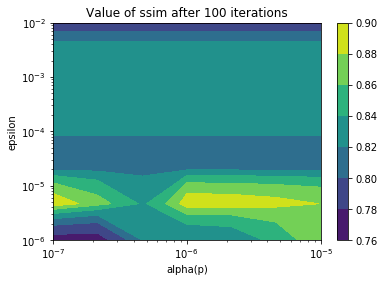

In [16]:
X,Y = np.meshgrid(alphas,eps)
const_to_test = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

plt.contourf(X,Y,ssims.transpose())
plt.title("Value of ssim after 100 iterations")
plt.xlabel("alpha(p)")
plt.ylabel("epsilon")
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
#plt.savefig("Comparisons/db8/Condat/ssims.png")
plt.show()

In [107]:
print(eps[np.argmax(ssims)//n],alphas[np.argmax(ssims)%n])
print(np.amax(ssims))

2.1544346900318833e-05 4.641588833612778e-07
0.8991215238617976


# Grid search over $\sigma$ and $\tau$

In [20]:
zeta,epsilon,gamma,pn1 = 1e15,1e-5,1e-10,1e-6
regularizer_G = RegularizerG(zeta,epsilon)
regularizer_F2 = RegularizerF2(linear_op,gamma,pn1)

n=7
s = np.logspace(-1,2,n)
t = np.logspace(-1,1,n)
ssims = np.zeros((n,n))
values = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        opt = Condat(x=fourier_op.adj_op(p*y),
            y=p*y,
            grad = gradient_op,
            prox = regularizer_G,
            prox_dual = regularizer_F2,
            linear = linear_op,
            sigma=s[i],
            tau=t[j],
            max_iter=100,
            metrics=metrics,
            verbose=-1000)
        
        uk = opt.x_final
        ssims[i,j] = ssim(uk,u0_mat)
        values[i,j] = opt._cost_func._calc_cost(opt.x_final,opt.y_final)
        print(f"(sigma,tau)=({s[i]},{t[j]})\nSSIM={ssims[i,j]}\nCost={values[i,j]}")

/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


 - ITERATION: 1
 - DATA FIDELITY (X): 3.052412931144635e-08
 - G (X): 0.3685739515827492
 - F2 (X): 1.645478985739017e-07
 - COST: 0.3685741466547771



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.3755516906036084e-08


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.05029063312721996
 - F2 (X): 1.6404228199164034e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:11

 - COST: 0.05029083092501886

 - ITERATION: 3
 - DATA FIDELITY (X): 3.551265131227105e-08
 - G (X): 0.00968833576834894
 - F2 (X): 1.6393038063138634e-07
 - COST: 0.009688535211380883



  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:39

 - ITERATION: 4
 - DATA FIDELITY (X): 3.618153085203313e-08
 - G (X): 0.007814762427966637
 - F2 (X): 1.6363892799542986e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - COST: 0.007814962248425483

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 22.930358977778244

 - ITERATION: 5
 - DATA FIDELITY (X): 3.6266038448016724e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - G (X): 0.0010567994118051234
 - F2 (X): 1.630964344755053e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:00:57

 - COST: 0.0010569987742780468

 - ITERATION: 6
 - DATA FIDELITY (X): 3.608471367008338e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - G (X): 0.0012402552464383968
 - F2 (X): 1.623256365908421e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:08

 - COST: 0.0012404536567886576

 - ITERATION: 7
 - DATA FIDELITY (X): 3.5806758413669464e-08
 - G (X): 0.0009676909552072857
 - F2 (X): 1.6135532508131028e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - COST: 0.0009678881172907807

 - ITERATION: 8
 - DATA FIDELITY (X): 3.55148029455104e-08
 - G (X): 0.00013092960400758614
 - F2 (X): 1.602020270246436e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 0.00013112532083755629

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.090468006450727

 - ITERATION: 9
 - DATA FIDELITY (X): 3.524649588152174e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - G (X): 1.405932008876315e-05
 - F2 (X): 1.5887884454703356e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - COST: 1.4253445429191706e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 3.501720784969466e-08
 - G (X): 1.761928619470614e-06
 - F2 (X): 1.5738978280475013e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 1.9543356101250588e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.4828964955278565e-08
 - G (X): 2.883310217426314e-07
 - F2 (X): 1.557408125290449e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - COST: 4.789007992269549e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 3.468187867334535e-08
 - G (X): 1.4651875706827376e-08
 - F2 (X): 1.5394537805514453e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:56

 - COST: 2.0327913243531726e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 22.758806565627285

 - ITERATION: 13
 - DATA FIDELITY (X): 3.4575803858803825e-08
 - G (X): 2.8693558128047766e-07
 - F2 (X): 1.520082634320016e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:52

 - COST: 4.735196485712831e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.450949039365524e-08
 - G (X): 1.5833949833548608e-08
 - F2 (X): 1.4993131573097085e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 2.002747559581747e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.448090119184697e-08
 - G (X): 7.984379971850669e-10
 - F2 (X): 1.4772631323132018e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 1.8300565242035222e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 3.448769454742088e-08
 - G (X): 1.6145930469147272e-09
 - F2 (X): 1.454032819677818e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - COST: 1.8150556956211738e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.848487409701374

 - ITERATION: 17
 - DATA FIDELITY (X): 3.4527484991678286e-08
 - G (X): 1.548653435195407e-09
 - F2 (X): 1.4297027174725214e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - COST: 1.7904641017412584e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 3.4597951257483025e-08
 - G (X): 1.0342049772709864e-08
 - F2 (X): 1.4043257143310738e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:49

 - COST: 1.8537257246330027e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 3.469684930369891e-08
 - G (X): 2.7115919877079753e-09
 - F2 (X): 1.378030126625222e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 1.7521145395392908e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 3.482207151754594e-08
 - G (X): 1.8217107592782126e-11
 - F2 (X): 1.3509080599951945e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 1.6993109462465817e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05585064530069004

 - ITERATION: 21
 - DATA FIDELITY (X): 3.497159895655234e-08
 - G (X): 4.7664234660345285e-09
 - F2 (X): 1.323059271057887e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - COST: 1.7204394952837555e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 3.514352569178693e-08
 - G (X): 1.8170791997472797e-11
 - F2 (X): 1.2945600481503864e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - COST: 1.6461770129882303e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 3.5336041069936535e-08
 - G (X): 6.285278059864687e-09
 - F2 (X): 1.265531611969555e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:56

 - COST: 1.6817448032675673e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 3.554739676831556e-08
 - G (X): 1.8128187883066324e-11
 - F2 (X): 1.2361004635563124e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:48

 - COST: 1.5917557131182989e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.028445387871490382

 - ITERATION: 25
 - DATA FIDELITY (X): 3.577593796673895e-08
 - G (X): 5.769234587433609e-10
 - F2 (X): 1.2063803591644885e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:51

 - COST: 1.5699089734193116e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 3.6020093909295296e-08
 - G (X): 1.8088999996149025e-11
 - F2 (X): 1.1765292481013175e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:51

 - COST: 1.5369110771942319e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 3.6278387081389215e-08
 - G (X): 7.114963130819973e-09
 - F2 (X): 1.1466895052614845e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:44

 - COST: 1.5806230073835762e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 3.654939333173966e-08
 - G (X): 4.96099462960113e-09
 - F2 (X): 1.1170667835272128e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:42

 - COST: 1.5321706631406207e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0019190542461002445

 - ITERATION: 29
 - DATA FIDELITY (X): 3.683175154734669e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:49

 - G (X): 1.803773861294533e-11
 - F2 (X): 1.0879157491392632e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:49

 - COST: 1.4564136419988596e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 3.712417845383046e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:51

 - G (X): 1.856568989175132e-08
 - F2 (X): 1.0595221881792706e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:51

 - COST: 1.6164208716350884e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 3.742543882542178e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:54

 - G (X): 4.3054828883180256e-09
 - F2 (X): 1.032322955312156e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:53

 - COST: 1.449632172449554e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 3.773435266386689e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:56

 - G (X): 1.7994151344255558e-11
 - F2 (X): 1.0069690802883977e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:53

 - COST: 1.384492548440509e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.08422698937149023

 - ITERATION: 33
 - DATA FIDELITY (X): 3.804979411865929e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:57

 - G (X): 2.0917472314863594e-11
 - F2 (X): 9.846378059800192e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:50

 - COST: 1.3653449218897608e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 3.837069962430712e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:52

 - G (X): 1.8015779561369537e-11
 - F2 (X): 9.681208472370404e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - COST: 1.3520080012757254e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 3.8696051625234886e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:49

 - G (X): 4.717010404575938e-08
 - F2 (X): 9.577954545074136e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - COST: 1.8164570112173564e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 3.9024832919072616e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:45

 - G (X): 1.7948832930705528e-11
 - F2 (X): 9.516273391725709e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:44

 - COST: 1.3420551566926042e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.13967311863686668

 - ITERATION: 37
 - DATA FIDELITY (X): 3.935608618694439e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:46

 - G (X): 7.56788500077196e-08
 - F2 (X): 9.486320406315288e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:44

 - COST: 2.098981402578169e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 3.9688877759772244e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:46

 - G (X): 1.793592727289136e-11
 - F2 (X): 9.481349703486311e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - COST: 1.3452031072190826e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.002231113065094e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:46

 - G (X): 1.2784368574253744e-10
 - F2 (X): 9.496481695081126e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:43

 - COST: 1.3511497176720473e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.035552709102288e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - G (X): 5.035420392490462e-10
 - F2 (X): 9.527493179886319e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:41

 - COST: 1.361340009291351e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.2697502503181744

 - ITERATION: 41
 - DATA FIDELITY (X): 4.06877012562597e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:32

 - G (X): 1.0068432852302399e-08
 - F2 (X): 9.571064925311131e-08
 - COST: 1.4646678336167342e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:43

 - ITERATION: 42
 - DATA FIDELITY (X): 4.101803569654952e-08
 - G (X): 1.7903975424346166e-11
 - F2 (X): 9.624256099863766e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:41

 - COST: 1.3727850067061153e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.134577238976402e-08
 - G (X): 1.7898827714939728e-11
 - F2 (X): 9.684701962938e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - COST: 1.3821069084685897e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.16701810244366e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - G (X): 1.789433681700933e-11
 - F2 (X): 9.750281611736789e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:40

 - COST: 1.391908914786215e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02286829676177301

 - ITERATION: 45
 - DATA FIDELITY (X): 4.199058367114369e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:39

 - G (X): 2.9512836986525415e-11
 - F2 (X): 9.81894742330783e-08
 - COST: 1.402095707412085e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 4.230633948996485e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:40

 - G (X): 8.080040488664869e-11
 - F2 (X): 9.888975922353416e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:38

 - COST: 1.4127689911838565e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.2616827829490946e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:40

 - G (X): 1.7880573816129756e-11
 - F2 (X): 9.959350332823254e-08


 - COST: 1.4222821173153963e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.292144369145541e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:38

 - G (X): 1.7879840503261217e-11
 - F2 (X): 1.0028908122660599e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:36

 - COST: 1.4322840475856467e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013908056079855421

 - ITERATION: 49
 - DATA FIDELITY (X): 4.32196436986976e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:36

 - G (X): 1.7878864267619182e-11
 - F2 (X): 1.0096442469196023e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:35

 - COST: 1.4420194725492545e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.3510932587085494e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:34

 - G (X): 1.7876711530323493e-11
 - F2 (X): 1.0160878488300791e-07
 - COST: 1.451375941816237e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:34

 - ITERATION: 51
 - DATA FIDELITY (X): 4.379485508686927e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:27

 - G (X): 4.5906769315227643e-10
 - F2 (X): 1.0222120869488099e-07
 - COST: 1.4647513147490254e-07



 50% (50 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:36

 - ITERATION: 52
 - DATA FIDELITY (X): 4.407099684312687e-08
 - G (X): 1.7873822356029216e-11
 - F2 (X): 1.0279426678844815e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:35

 - COST: 1.4688313745393104e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013699042835773582

 - ITERATION: 53
 - DATA FIDELITY (X): 4.433898952200629e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:35

 - G (X): 3.1449803225786866e-11
 - F2 (X): 1.0332520003716669e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 1.4769563936239877e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.459850233149413e-08
 - G (X): 1.787167188406785e-11
 - F2 (X): 1.0381414619705196e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:31

 - COST: 1.4843052020043017e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.484922342623823e-08
 - G (X): 1.787040666421502e-11
 - F2 (X): 1.0426179749922417e-07
 - COST: 1.491288913321266e-07



 54% (54 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:31

 - ITERATION: 56
 - DATA FIDELITY (X): 4.5090887392784104e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:24

 - G (X): 1.8511054582012157e-11
 - F2 (X): 1.0466233447971883e-07
 - COST: 1.4977173292708495e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009282231187234084



 55% (55 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:31

 - ITERATION: 57
 - DATA FIDELITY (X): 4.532327138860924e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:33

 - G (X): 1.7874829414012115e-11
 - F2 (X): 1.0501823605323039e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - COST: 1.5035938227125363e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.5546170242299285e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:33

 - G (X): 1.7963188738210737e-11
 - F2 (X): 1.0533921847420673e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:43

 - COST: 1.5090335190524422e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.575943413761679e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:43

 - G (X): 1.7865433048434778e-11
 - F2 (X): 1.0562525996810276e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:28

 - COST: 1.5140255953876797e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.5962955460804493e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:29

 - G (X): 1.786659003694863e-11
 - F2 (X): 1.0587955213390525e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:28

 - COST: 1.518603741847467e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006595595190147436

 - ITERATION: 61
 - DATA FIDELITY (X): 4.61566553567272e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:28

 - G (X): 1.7864457212615646e-11
 - F2 (X): 1.0609859421307861e-07


 - COST: 1.5227311402701844e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 4.6340475625308156e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:27

 - G (X): 2.0665262065133858e-10
 - F2 (X): 1.062799021546042e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:26

 - COST: 1.5282703040056368e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 4.651438788343526e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:26

 - G (X): 3.073164687705454e-11
 - F2 (X): 1.064149028991483e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:27

 - COST: 1.5296002242946062e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 4.6678400370089643e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:20

 - G (X): 1.7859295598891653e-11
 - F2 (X): 1.065005817394842e-07
 - COST: 1.5319684140517276e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00345156203201125



 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:26

 - ITERATION: 65
 - DATA FIDELITY (X): 4.683254770199072e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:27

 - G (X): 5.298916354572968e-10
 - F2 (X): 1.0653031755497576e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:24

 - COST: 1.5389275689242378e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 4.6976906609280064e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:19

 - G (X): 1.7975619748267414e-11
 - F2 (X): 1.0650235680129814e-07
 - COST: 1.5349723903032646e-07



 65% (65 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:35

 - ITERATION: 67
 - DATA FIDELITY (X): 4.711157016193757e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:37

 - G (X): 1.785481007412693e-11
 - F2 (X): 1.0641082659015496e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:23

 - COST: 1.5354025156216666e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 4.723666325390341e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:24

 - G (X): 1.7876735971562057e-11
 - F2 (X): 1.06248195050988e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:32

 - COST: 1.5350273504086297e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011301652695596368

 - ITERATION: 69
 - DATA FIDELITY (X): 4.735234376718788e-08
 - G (X): 1.0217203429913658e-09
 - F2 (X): 1.0600876600591981e-07
 - COST: 1.5438283011609905e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:21

 - ITERATION: 70
 - DATA FIDELITY (X): 4.745878782140286e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:22

 - G (X): 1.7853212192460418e-11
 - F2 (X): 1.0569163723435308e-07


 - COST: 1.531682782679484e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 4.755618918263218e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:20

 - G (X): 1.78479973955491e-11
 - F2 (X): 1.0529124379042797e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:20

 - COST: 1.528652809704557e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 4.7644754082783715e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:21

 - G (X): 1.7845501474616715e-11
 - F2 (X): 1.048068261803093e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:20

 - COST: 1.5246942576456764e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007258924714862377

 - ITERATION: 73
 - DATA FIDELITY (X): 4.772470362617467e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:20

 - G (X): 1.7843559868637314e-11
 - F2 (X): 1.0423995088207382e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:20

 - COST: 1.5198249806811712e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 4.7796257332642404e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:20

 - G (X): 1.7841175744198742e-11
 - F2 (X): 1.0358630038907616e-07
 - COST: 1.5140039889746275e-07



 73% (73 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:21

 - ITERATION: 75
 - DATA FIDELITY (X): 4.785968474484188e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:27

 - G (X): 1.7838496942858824e-11
 - F2 (X): 1.0284917928367293e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:21

 - COST: 1.5072670252545766e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 4.7915271197320097e-08
 - G (X): 2.9290698452214503e-08
 - F2 (X): 1.0202499732219249e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - COST: 1.7923096697172708e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.08053994493324411

 - Converged!
(sigma,tau)=(0.1,0.1)
SSIM=0.7800788926277551
Cost=1.4909477688654267e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 3.906948437428593e-08
 - G (X): 0.3839128210365132
 - F2 (X): 1.6706821281242718e-07
 - COST: 0.3839130271742104



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 5.00557334135684e-08
 - G (X): 0.058340857752299476


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:59

 - F2 (X): 1.6842094951805054e-07
 - COST: 0.05834107622898241

 - ITERATION: 3
 - DATA FIDELITY (X): 5.3894971454945024e-08
 - G (X): 0.010092318532591654
 - F2 (X): 1.6914385461952667e-07
 - COST: 0.010092541571417727



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:35

 - ITERATION: 4
 - DATA FIDELITY (X): 5.334351452857798e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:35

 - G (X): 0.01154370382039929
 - F2 (X): 1.6904189979010433e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - COST: 0.01154392620581361

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 19.44021731997259

 - ITERATION: 5
 - DATA FIDELITY (X): 5.097040004411395e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:09

 - G (X): 0.00368724450712761
 - F2 (X): 1.682918779958265e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.00368746376940565

 - ITERATION: 6
 - DATA FIDELITY (X): 4.8168789462597245e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - G (X): 0.00044827393048877474
 - F2 (X): 1.6704725205097366e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - COST: 0.00044848914653028833

 - ITERATION: 7
 - DATA FIDELITY (X): 4.5549120683556473e-08
 - G (X): 5.612402938409171e-05
 - F2 (X): 1.6539214415180344e-07
 - COST: 5.633497064892707e-05



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - ITERATION: 8
 - DATA FIDELITY (X): 4.332317739266065e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - G (X): 1.4385994572922248e-06
 - F2 (X): 1.6338021103661204e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 1.6453028457214976e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 70.33379452440278

 - ITERATION: 9
 - DATA FIDELITY (X): 4.1524219109776054e-08
 - G (X): 1.4111696705343607e-06
 - F2 (X): 1.610523272005575e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 1.6137462168446943e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 4.01150295402009e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:03

 - G (X): 1.892029890222012e-07
 - F2 (X): 1.5842036998836392e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:01

 - COST: 3.87738388550766e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 3.903138662039319e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:04

 - G (X): 1.2820066515501667e-08
 - F2 (X): 1.555119226500826e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:06

 - COST: 2.0736337578597747e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 3.8217555623755485e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:09

 - G (X): 5.387455162194445e-08
 - F2 (X): 1.5234890761275048e-07
 - COST: 2.444410148584504e-07

 - CONVERGENCE TEST - 


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:02

 - CHANGE IN COST: 3.4299804225909747

 - ITERATION: 13
 - DATA FIDELITY (X): 3.7627458681126454e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:05

 - G (X): 4.044836112783924e-08
 - F2 (X): 1.489479356434619e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - COST: 2.270237554524276e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.7221186887994825e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - G (X): 1.3656723014639863e-08
 - F2 (X): 1.453513712634534e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:58

 - COST: 1.962292811660881e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.696429516485153e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:58

 - G (X): 2.262691188077905e-11
 - F2 (X): 1.4159126533226077e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 1.7857818740899308e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 3.682820419719222e-08
 - G (X): 1.8175328679284554e-11
 - F2 (X): 1.3769718182425185e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 1.7454356135012335e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1986037056789715

 - ITERATION: 17
 - DATA FIDELITY (X): 3.678946905706646e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - G (X): 1.8151959774150577e-11
 - F2 (X): 1.337038327497861e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:59

 - COST: 1.705114537666267e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 3.6829036324840547e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:59

 - G (X): 1.780158344110552e-08
 - F2 (X): 1.296488174786564e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:58

 - COST: 1.8427943724460247e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 3.6931511156735985e-08
 - G (X): 7.435214990536502e-09
 - F2 (X): 1.255882582905339e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 1.6995498443780638e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 3.708435257445855e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - G (X): 2.1243621314869424e-07
 - F2 (X): 1.2157947363000347e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - COST: 3.7110003935315627e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.344260980102639

 - ITERATION: 21
 - DATA FIDELITY (X): 3.72774347012171e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:57

 - G (X): 1.80446482153201e-11
 - F2 (X): 1.1770225467345709e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:57

 - COST: 1.5499773402288951e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 3.750242940724677e-08
 - G (X): 1.210146556230628e-10
 - F2 (X): 1.1406619151211928e-07
 - COST: 1.5168963557498913e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:54

 - ITERATION: 23
 - DATA FIDELITY (X): 3.775256541181402e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:54

 - G (X): 2.3386114961119657e-11
 - F2 (X): 1.1086126389347673e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:53

 - COST: 1.4863721542025187e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 3.802222433042158e-08
 - G (X): 1.8079633214019754e-11
 - F2 (X): 1.0852701261410432e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 1.4656731657773992e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.038897904182463465

 - ITERATION: 25
 - DATA FIDELITY (X): 3.8306729307588676e-08
 - G (X): 1.795912771665497e-11
 - F2 (X): 1.0710440590772493e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:53

 - COST: 1.4542909434303026e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 3.860219221318868e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:39

 - G (X): 1.7946194552845752e-11
 - F2 (X): 1.0624752623610793e-07
 - COST: 1.4486766464384946e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - ITERATION: 27
 - DATA FIDELITY (X): 3.8905322082640717e-08
 - G (X): 1.7932692826311135e-11
 - F2 (X): 1.057840864193335e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - COST: 1.4470734119480052e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 3.9213331708615903e-08
 - G (X): 2.220723005438449e-10
 - F2 (X): 1.0560952583817256e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 1.4504492984733231e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0018791498778889884

 - ITERATION: 29
 - DATA FIDELITY (X): 3.952384235015697e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - G (X): 1.7907368715772117e-11
 - F2 (X): 1.0561767079096921e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:48

 - COST: 1.4515942050984194e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 3.98348015757204e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - G (X): 7.785651652345902e-09
 - F2 (X): 1.0576150149554407e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 1.5338195472361038e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.014444837201464e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:38

 - G (X): 1.7887316766961554e-11
 - F2 (X): 1.0597056395026427e-07
 - COST: 1.461328996390459e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:51

 - ITERATION: 32
 - DATA FIDELITY (X): 4.0451277222340367e-08
 - G (X): 1.787870185744378e-11
 - F2 (X): 1.0621101319836215e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 1.4668016912255997e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.019563015052822555

 - ITERATION: 33
 - DATA FIDELITY (X): 4.0753995335836636e-08
 - G (X): 1.7872329466931745e-11
 - F2 (X): 1.0644471990734149e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:45

 - COST: 1.4721658757264507e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.105144967353177e-08
 - G (X): 3.4672917715085846e-08
 - F2 (X): 1.0664181124746471e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - COST: 1.8236617863608232e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.134268779382317e-08
 - G (X): 6.295717558783347e-09
 - F2 (X): 1.0677948127482102e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 1.5441788662742754e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.162686050971194e-08
 - G (X): 1.7867810389140988e-11


 35% (35 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:35

 - F2 (X): 1.0684679418407885e-07
 - COST: 1.4849152250417994e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.08805720876610651



 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:44

 - ITERATION: 37
 - DATA FIDELITY (X): 4.190328116459556e-08
 - G (X): 1.7854954221396557e-11
 - F2 (X): 1.0683812680491406e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - COST: 1.4875926292373103e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.217139675314501e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - G (X): 1.7851554123743047e-11
 - F2 (X): 1.0675977132828752e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:43

 - COST: 1.4894901963555628e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.243075687355455e-08
 - G (X): 1.7850276545502982e-11
 - F2 (X): 1.0663067062553124e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:41

 - COST: 1.4907927777563128e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.268098752247566e-08
 - G (X): 7.192054322768172e-09
 - F2 (X): 1.0649598865230073e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - COST: 1.5636903049754455e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.025339887320529234

 - ITERATION: 41
 - DATA FIDELITY (X): 4.292180250260786e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:31

 - G (X): 1.784843143186805e-11
 - F2 (X): 1.0640996000895686e-07
 - COST: 1.4934961094299658e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:41

 - ITERATION: 42
 - DATA FIDELITY (X): 4.3152966983842134e-08
 - G (X): 2.4623965538435267e-07
 - F2 (X): 1.0640838940094686e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:42

 - COST: 3.9580101176914165e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.337427194837167e-08
 - G (X): 1.784656642628476e-11
 - F2 (X): 1.0647856027551946e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:39

 - COST: 1.4987067879031742e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.358559704526527e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:39

 - G (X): 1.7846826041025284e-11
 - F2 (X): 1.0658804122734414e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:39

 - COST: 1.5019148509865044e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8167922794620002

 - ITERATION: 45
 - DATA FIDELITY (X): 4.378688682297455e-08
 - G (X): 1.7846899608457584e-11
 - F2 (X): 1.0668461000621831e-07
 - COST: 1.5048934372880133e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:39

 - ITERATION: 46
 - DATA FIDELITY (X): 4.39781332848614e-08
 - G (X): 1.7886340744214267e-11
 - F2 (X): 1.06725075723967e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:38

 - COST: 1.5072109534957263e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.4159384768865665e-08
 - G (X): 1.7845548505322136e-11
 - F2 (X): 1.0666647903124617e-07


 - COST: 1.5084370934861716e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.4330735352982015e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - G (X): 1.7845702750014044e-11
 - F2 (X): 1.064811402324691e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:36

 - COST: 1.5082972128820114e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001534744234740721

 - ITERATION: 49
 - DATA FIDELITY (X): 4.4492330312031716e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:36

 - G (X): 1.784467878913936e-11
 - F2 (X): 1.061442445097632e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:35

 - COST: 1.5065441950058406e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.464435338288717e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:37

 - G (X): 1.784411017133745e-11
 - F2 (X): 1.0564019927316993e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:37

 - COST: 1.5030239676622844e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 4.478702286435098e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:39

 - G (X): 1.7843923581929793e-11
 - F2 (X): 1.0496164750617258e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:50

 - COST: 1.497665142941055e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.492060557776306e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:50

 - G (X): 1.78420746318681e-11
 - F2 (X): 1.0410084838978734e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:49

 - COST: 1.4903929604218227e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0071986750461911775

 - ITERATION: 53
 - DATA FIDELITY (X): 4.504539364033369e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:52

 - G (X): 1.806186870372671e-11
 - F2 (X): 1.0305561590963526e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:41

 - COST: 1.4811907141867266e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.516171637851016e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:43

 - G (X): 1.783817904997577e-11
 - F2 (X): 1.0182832551306978e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:41

 - COST: 1.4700788007062993e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.526993391583089e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:48

 - G (X): 1.7834942750281564e-11
 - F2 (X): 1.0042643015850641e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:38

 - COST: 1.457141990170876e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 4.537042252940487e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:46

 - G (X): 1.7832407072325178e-11
 - F2 (X): 9.885354417540013e-08
 - COST: 1.4424179911187732e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.017833579555880608



 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:45

 - ITERATION: 57
 - DATA FIDELITY (X): 4.5463581734701044e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:47

 - G (X): 1.7884751881035848e-11
 - F2 (X): 9.712108178699633e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:36

 - COST: 1.426025482735784e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.554982390948333e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:44

 - G (X): 7.614832959938925e-09
 - F2 (X): 9.524567961333415e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:32

 - COST: 1.4841033648275641e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.562957912113651e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:34

 - G (X): 1.1452501815147827e-09
 - F2 (X): 9.323643441243523e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:28

 - COST: 1.4001126371508652e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.570327908706803e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - G (X): 1.7820368453461293e-11
 - F2 (X): 9.111231242834736e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:27

 - COST: 1.3683341188386885e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05117746666691867

 - ITERATION: 61
 - DATA FIDELITY (X): 4.577135255754605e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:29

 - G (X): 1.7822868478502097e-11
 - F2 (X): 8.888800889254201e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:29

 - COST: 1.3467718431856656e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 4.583422662584508e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:29

 - G (X): 1.7810929925707996e-11
 - F2 (X): 8.658614322305364e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:28

 - COST: 1.3243818077882443e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 4.589231621165153e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:30

 - G (X): 1.7176551366761946e-08
 - F2 (X): 8.42337711214683e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:26

 - COST: 1.4730263869988177e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 4.594602193618376e-08
 - G (X): 1.7861693699690695e-11
 - F2 (X): 8.186503891715764e-08
 - COST: 1.278289225470411e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02913586544997488



 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - ITERATION: 65
 - DATA FIDELITY (X): 4.599572310866566e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:27

 - G (X): 1.7800773047532777e-11
 - F2 (X): 7.953341157231329e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:24

 - COST: 1.255469354540265e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 4.604176854492298e-08
 - G (X): 2.4992695369697108e-11
 - F2 (X): 7.735805579567428e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:23

 - COST: 1.2342481703596696e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 4.608448427248121e-08
 - G (X): 2.558400835119625e-07
 - F2 (X): 7.70762018102948e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:23

 - COST: 3.790007695947385e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 4.6124168652078213e-08
 - G (X): 1.7797362858611122e-11
 - F2 (X): 7.79261774222649e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:23

 - COST: 1.2406814343720173e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.505094141099937

 - ITERATION: 69
 - DATA FIDELITY (X): 4.616108644075423e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:22

 - G (X): 1.778781162862979e-11
 - F2 (X): 7.890290922089436e-08
 - COST: 1.250817834732772e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:21

 - ITERATION: 70
 - DATA FIDELITY (X): 4.6195480656966674e-08
 - G (X): 1.77841092617845e-11
 - F2 (X): 7.992403458288419e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:23

 - COST: 1.2613729934911264e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 4.622757043082015e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:23

 - G (X): 1.778347346177614e-11
 - F2 (X): 8.094621504776846e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:21

 - COST: 1.271915689520504e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 4.6257554849230634e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:23

 - G (X): 1.798127164316533e-11
 - F2 (X): 8.194312185813024e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:20

 - COST: 1.2821865797900403e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.016409460807518695

 - ITERATION: 73
 - DATA FIDELITY (X): 4.6285609383623623e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:22

 - G (X): 1.7786545947610943e-11
 - F2 (X): 8.288486331725418e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:18

 - COST: 1.2918825924682542e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 4.63118900555057e-08
 - G (X): 1.777593212313513e-11
 - F2 (X): 8.37566348078596e-08
 - COST: 1.3008630079548845e-07



 - ITERATION: 75
 - DATA FIDELITY (X): 4.633652850937518e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:19

 - G (X): 1.7775306501142925e-11
 - F2 (X): 8.454876168102774e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:18

 - COST: 1.3090306549690406e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 4.635964821675084e-08
 - G (X): 1.777698944986178e-11
 - F2 (X): 8.524878411923314e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:16

 - COST: 1.3162620932543385e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.012397530836233848

 - ITERATION: 77
 - DATA FIDELITY (X): 4.6381354791593487e-08
 - G (X): 1.7787286441299078e-11
 - F2 (X): 8.584752434842794e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:17

 - COST: 1.3224666642646273e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 4.640173846438861e-08
 - G (X): 1.7772671844147193e-11
 - F2 (X): 8.634408706289829e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:14

 - COST: 1.3276359819913105e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 4.642087825832956e-08
 - G (X): 1.7783752352717668e-11
 - F2 (X): 8.673894032105527e-08
 - COST: 1.3317760233173756e-07



 78% (78 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:14

 - ITERATION: 80
 - DATA FIDELITY (X): 4.64388436064374e-08
 - G (X): 4.60978178753782e-11
 - F2 (X): 8.703868048405031e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:14

 - COST: 1.3352362190836308e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006340276912206934

 - ITERATION: 81
 - DATA FIDELITY (X): 4.6455696127488515e-08
 - G (X): 1.8970789409132672e-11
 - F2 (X): 8.72550203114944e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:13

 - COST: 1.3372968722839205e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 4.647149105113686e-08
 - G (X): 1.7785374231970756e-11
 - F2 (X): 8.741343077846304e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:12

 - COST: 1.3390270720383186e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 4.6486275127147555e-08
 - G (X): 1.7776040416884e-11
 - F2 (X): 8.755279816108213e-08
 - COST: 1.340568493286466e-07



 82% (82 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 4.6500084382349474e-08
 - G (X): 1.7772740152693146e-11
 - F2 (X): 8.773090345175462e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:11

 - COST: 1.342487605742568e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0025091367672971498

 - ITERATION: 85
 - DATA FIDELITY (X): 4.651294911551904e-08
 - G (X): 1.777687370863669e-11
 - F2 (X): 8.79771030512536e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:10

 - COST: 1.3450782904048128e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 4.652489693547334e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10

 - G (X): 1.777804355302992e-11
 - F2 (X): 8.82704939091652e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10

 - COST: 1.3481316888819155e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 4.653595206008963e-08
 - G (X): 1.7799024060437093e-11
 - F2 (X): 8.85715637532874e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:09

 - COST: 1.3512531483743746e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 4.65461379913007e-08
 - G (X): 2.1558793592224256e-11
 - F2 (X): 8.884499188092722e-08
 - COST: 1.3541268866582015e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004498464388830831



 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:08

 - ITERATION: 89
 - DATA FIDELITY (X): 4.655547881218435e-08
 - G (X): 1.7790298155551283e-11
 - F2 (X): 8.905732549345382e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - COST: 1.3563059460379371e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 4.656399737095771e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:08

 - G (X): 1.8429906931899874e-11
 - F2 (X): 8.917593560581567e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:07

 - COST: 1.3575836288370527e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 4.6571716976676274e-08
 - G (X): 1.7959812636165936e-11
 - F2 (X): 8.918346728057379e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - COST: 1.3577314406988623e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 4.6578666411790794e-08
 - G (X): 2.097577862936655e-11
 - F2 (X): 8.906700014709467e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - COST: 1.3566664233751483e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00018725670460770685

 - ITERATION: 93
 - DATA FIDELITY (X): 4.658487465136535e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06

 - G (X): 1.7787865154846123e-11
 - F2 (X): 8.881707656858032e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - COST: 1.354197390851005e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 4.659036905708408e-08
 - G (X): 1.7830756556829307e-11
 - F2 (X): 8.842958528915822e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - COST: 1.3503778510279913e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 4.659517935512783e-08
 - G (X): 1.815808607317243e-11
 - F2 (X): 8.790168475584e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - COST: 1.34515022197041e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 4.659933770008841e-08
 - G (X): 1.5987298898977447e-10
 - F2 (X): 8.72348061445318e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:03

 - COST: 1.3399401683360997e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007256683664292667

 - ITERATION: 97
 - DATA FIDELITY (X): 4.660288193430189e-08
 - G (X): 6.79874283001261e-07
 - F2 (X): 8.643118456631732e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - COST: 8.129083495018801e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 4.660585335782996e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - G (X): 2.43057623181956e-11
 - F2 (X): 8.549583970705861e-08
 - COST: 1.3212599882720676e-07



 97% (97 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 4.660829633835069e-08
 - G (X): 1.78669215640515e-11
 - F2 (X): 8.443725866295632e-08


 98% (98 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:01

 - COST: 1.3106342192287107e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 4.6610261965167076e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:09 Time:  0:01:09


 - G (X): 8.527066686592495e-11
 - F2 (X): 8.326183927542045e-08
 - COST: 1.2995737190745345e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.6205328106671932

(sigma,tau)=(0.1,0.21544346900318834)
SSIM=0.796232867003683
Cost=1.2995737190745345e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 7.859368014487125e-08
 - G (X): 0.4256280759492747
 - F2 (X): 1.7437855998413771e-07
 - COST: 0.4256283289215148



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 1.1040301787999492e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.14223345420114245
 - F2 (X): 1.799947208192566e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:02

 - COST: 0.14223374459888113

 - ITERATION: 3
 - DATA FIDELITY (X): 1.0615102984920468e-07
 - G (X): 0.1761925891645759
 - F2 (X): 1.8202154190602354e-07
 - COST: 0.17619287733714764



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:36

 - ITERATION: 4
 - DATA FIDELITY (X): 8.89748463682781e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:36

 - G (X): 0.014828800717512169
 - F2 (X): 1.817833781842731e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - COST: 0.014829071475736722

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.9727582461041977

 - ITERATION: 5
 - DATA FIDELITY (X): 7.18385006791565e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:08

 - G (X): 0.001569934357917675
 - F2 (X): 1.8021622330709883e-07


 - COST: 0.0015701864126416612

 - ITERATION: 6
 - DATA FIDELITY (X): 5.8765140248541875e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:08

 - G (X): 0.0005961952072580508
 - F2 (X): 1.7779091808654435e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:07

 - COST: 0.0005964317633163858

 - ITERATION: 7
 - DATA FIDELITY (X): 4.9899897650046906e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - G (X): 4.000709131063999e-05
 - F2 (X): 1.7473262046775767e-07
 - COST: 4.02317238287578e-05



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - ITERATION: 8
 - DATA FIDELITY (X): 4.4269064787204355e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - G (X): 4.134443717368583e-05
 - F2 (X): 1.71097658561902e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 4.155980389703494e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 25.489518367008202

 - ITERATION: 9
 - DATA FIDELITY (X): 4.084426489630006e-08
 - G (X): 1.3960955047894893e-05
 - F2 (X): 1.6694647803318247e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 1.4168745790824375e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 3.883632152503509e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:05

 - G (X): 3.5757132886355176e-06
 - F2 (X): 1.623277195685828e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 3.7768773297291353e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.77100850994658e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:05

 - G (X): 3.2054738453700364e-06
 - F2 (X): 1.5731120674656e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:05

 - COST: 3.4004951372160624e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 3.7123458241021956e-08
 - G (X): 9.308261705420561e-10
 - F2 (X): 1.5198707428421e-07
 - COST: 1.9004135869577401e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.9980338985514527



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:04

 - ITERATION: 13
 - DATA FIDELITY (X): 3.686515438407696e-08
 - G (X): 4.1818134771121234e-07
 - F2 (X): 1.4645112252818972e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:02

 - COST: 6.014976246234791e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.680682846693525e-08
 - G (X): 2.4564740419269065e-08
 - F2 (X): 1.4085082815467195e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:01

 - COST: 2.0222239704087625e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.687145745796112e-08
 - G (X): 3.3902562212109123e-07
 - F2 (X): 1.353740426982825e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:00

 - COST: 5.112711222773348e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 3.70125501370902e-08
 - G (X): 1.8149812465781194e-11
 - F2 (X): 1.3030264248378009e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - COST: 1.6733334243333608e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1843718446606871

 - ITERATION: 17
 - DATA FIDELITY (X): 3.7201882266854064e-08
 - G (X): 3.201164642928248e-07
 - F2 (X): 1.2621441013220308e-07
 - COST: 4.83532756691882e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - ITERATION: 18
 - DATA FIDELITY (X): 3.742222856461318e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:57

 - G (X): 1.8082426268895962e-11
 - F2 (X): 1.2337779893023672e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:59

 - COST: 1.608181099211188e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 3.766269686049265e-08
 - G (X): 1.804345105764151e-11
 - F2 (X): 1.212998962351619e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - COST: 1.589806365467122e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 3.791629593290066e-08
 - G (X): 1.8008468038816095e-11
 - F2 (X): 1.1967807387408426e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:57

 - COST: 1.5761237827502375e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.035265582141209

 - ITERATION: 21
 - DATA FIDELITY (X): 3.8178353704089424e-08
 - G (X): 1.7976647661314733e-11
 - F2 (X): 1.1834847015290291e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:53

 - COST: 1.5654480050465365e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 3.8445604623253915e-08
 - G (X): 1.9163372845011783e-07
 - F2 (X): 1.1717641624188117e-07
 - COST: 3.4725574931525294e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:53

 - ITERATION: 23
 - DATA FIDELITY (X): 3.871550159652859e-08
 - G (X): 1.7925443093156754e-11
 - F2 (X): 1.1605519950379444e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:53

 - COST: 1.5478862654341617e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 3.898611053091484e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:56

 - G (X): 4.0707590413534635e-09
 - F2 (X): 1.1494346450257444e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - COST: 1.5800033407484275e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6106724125560378

 - ITERATION: 25
 - DATA FIDELITY (X): 3.9255884826965e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - G (X): 1.8814424975966345e-06
 - F2 (X): 1.1378728064743071e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 2.03448566307103e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 3.952350693683457e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:41

 - G (X): 1.7872325663100336e-11
 - F2 (X): 1.1262777399851523e-07
 - COST: 1.521691532610129e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:51

 - ITERATION: 27
 - DATA FIDELITY (X): 3.978780035663731e-08
 - G (X): 3.593591309732933e-08
 - F2 (X): 1.1150866710326109e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - COST: 1.8723238055722774e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.0047699000619025e-08
 - G (X): 4.889773279513156e-06
 - F2 (X): 1.1059710342149034e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:51

 - COST: 5.040418081935265e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5817136528119237

 - ITERATION: 29
 - DATA FIDELITY (X): 4.0302288805961794e-08
 - G (X): 1.7860122077230154e-11
 - F2 (X): 1.1023527080575249e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:51

 - COST: 1.5055541973379152e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.055077726878921e-08
 - G (X): 1.785993838540118e-11
 - F2 (X): 1.1049644010724647e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 1.510650773144211e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.079250615381816e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:51

 - G (X): 1.786378921456168e-11
 - F2 (X): 1.1104363857322933e-07
 - COST: 1.5185400851626206e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:50

 - ITERATION: 32
 - DATA FIDELITY (X): 4.102699413048668e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - G (X): 1.7864820206352573e-11
 - F2 (X): 1.1157363250476798e-07


 - COST: 1.5261849145546103e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009367029612773971

 - ITERATION: 33
 - DATA FIDELITY (X): 4.125389114949192e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48

 - G (X): 1.2408046117667835e-09
 - F2 (X): 1.1190788049552452e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - COST: 1.544025762567832e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.147297347760878e-08
 - G (X): 1.5635429702078974e-10
 - F2 (X): 1.1194255961042014e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 1.5357188738504972e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.16841272198782e-08
 - G (X): 2.5385000896891e-11
 - F2 (X): 1.1161434223646819e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 1.533238544572433e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.1887348818766844e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:35

 - G (X): 1.8853264910938006e-11
 - F2 (X): 1.1090006861444605e-07
 - COST: 1.5280627069812384e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006024687983679277



 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:44

 - ITERATION: 37
 - DATA FIDELITY (X): 4.208275752933667e-08
 - G (X): 1.8000396476307468e-11
 - F2 (X): 1.0979033519086048e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:40

 - COST: 1.5189109311667345e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.227054428928268e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - G (X): 1.7976988868322633e-11
 - F2 (X): 1.0829479971293379e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:01:03

 - COST: 1.5058332099108479e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.245099041008035e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:01:03

 - G (X): 7.573800429097166e-08
 - F2 (X): 1.064346759873628e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 2.246236706884148e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.2624437187918205e-08
 - G (X): 1.806026763031233e-11
 - F2 (X): 1.0424153954190507e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:41

 - COST: 1.468840369974536e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.18581927682771476

 - ITERATION: 41
 - DATA FIDELITY (X): 4.2791214037003294e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:32

 - G (X): 2.2325719224003776e-11
 - F2 (X): 1.0177148490066068e-07
 - COST: 1.4458502465688798e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:41

 - ITERATION: 42
 - DATA FIDELITY (X): 4.295165474891134e-08
 - G (X): 2.17415841807724e-11
 - F2 (X): 9.907635402916064e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:39

 - COST: 1.4204975036225275e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.310609321376797e-08
 - G (X): 1.7195035820059098e-07
 - F2 (X): 9.622989958034486e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:38

 - COST: 3.112863509947038e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.325486586855586e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:40

 - G (X): 1.99466083279298e-11
 - F2 (X): 9.333773649110574e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:38

 - COST: 1.3661254896798953e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3600458160468461

 - ITERATION: 45
 - DATA FIDELITY (X): 4.339829286088339e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:40

 - G (X): 1.787396399818332e-11
 - F2 (X): 9.056432107331882e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:38

 - COST: 1.339804878982004e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 4.3536643788437177e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:38

 - G (X): 1.7833567455439612e-11
 - F2 (X): 8.83146306457311e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:38

 - COST: 1.318691080016237e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.367014173947415e-08
 - G (X): 1.782840172374107e-11
 - F2 (X): 8.733106260340761e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:36

 - COST: 1.3101903274460551e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.379894285166445e-08
 - G (X): 1.7819925097405634e-11
 - F2 (X): 8.687436025676757e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:35

 - COST: 1.3069112303352944e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.015816887615161476

 - ITERATION: 49
 - DATA FIDELITY (X): 4.392318869967259e-08
 - G (X): 1.7812092400806595e-11
 - F2 (X): 8.661477426150018e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:36

 - COST: 1.3055577505357356e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.4043005284671175e-08
 - G (X): 4.782228828211576e-06


 49% (49 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:35

 - F2 (X): 8.641755459375598e-08
 - COST: 4.912689388090003e-06



 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:35

 - ITERATION: 51
 - DATA FIDELITY (X): 4.415849345499585e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:35

 - G (X): 1.7980482994197496e-11
 - F2 (X): 8.621432948818513e-08


 - COST: 1.3039080342617517e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.42697337492017e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - G (X): 1.7788508896040464e-11
 - F2 (X): 8.596887564585394e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:35

 - COST: 1.3025639790395166e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 18.348932723647295

 - ITERATION: 53
 - DATA FIDELITY (X): 4.437677386392813e-08
 - G (X): 1.777753140167211e-11
 - F2 (X): 8.565296757632294e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:33

 - COST: 1.3004751897165275e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.44796570387378e-08
 - G (X): 1.777808643140492e-11
 - F2 (X): 8.525455599384105e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:31

 - COST: 1.2975199111901025e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.4578434169609834e-08
 - G (X): 1.786747594172265e-11
 - F2 (X): 8.478224173461357e-08
 - COST: 1.2937854338016514e-07



 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:32

 - ITERATION: 56
 - DATA FIDELITY (X): 4.467316015558391e-08
 - G (X): 1.778454763312478e-11
 - F2 (X): 8.427293177224799e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - COST: 1.2896387647546502e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005640150912293294

 - ITERATION: 57
 - DATA FIDELITY (X): 4.4763898960655194e-08
 - G (X): 1.7770466927715428e-11
 - F2 (X): 8.382387684366694e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:29

 - COST: 1.2860554627124984e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.485070114112418e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:30

 - G (X): 1.777016316988098e-11
 - F2 (X): 8.367836250534439e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:31

 - COST: 1.2854683380963845e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.4933633828889544e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:33

 - G (X): 2.7098387010861423e-11
 - F2 (X): 8.39948747478511e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:30

 - COST: 1.289556069637515e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.50127763948109e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:31

 - G (X): 1.793665851709562e-11
 - F2 (X): 8.456239019067997e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - COST: 1.2959310324400797e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005400646267966994

 - ITERATION: 61
 - DATA FIDELITY (X): 4.508821346743248e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:29

 - G (X): 4.5045824290553465e-09
 - F2 (X): 8.51419924640198e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:26

 - COST: 1.3473478836050762e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 4.516002733494678e-08
 - G (X): 5.631135218066942e-10
 - F2 (X): 8.559638051388443e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:26

 - COST: 1.313195213706379e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 4.522832171146203e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:26

 - G (X): 7.240936870905008e-11
 - F2 (X): 8.58531686499452e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:25

 - COST: 1.3115389973011626e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 4.52932175564635e-08
 - G (X): 1.9822882568641527e-11
 - F2 (X): 8.587895127981543e-08
 - COST: 1.3119199171884758e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.014135606476243031



 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:25

 - ITERATION: 65
 - DATA FIDELITY (X): 4.535485532042431e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:26

 - G (X): 1.8272000128435645e-11
 - F2 (X): 8.565628578752294e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:24

 - COST: 1.3102941310807568e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 4.541338288030324e-08
 - G (X): 2.0236959001233034e-11
 - F2 (X): 8.51808875883798e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:24

 - COST: 1.3061450742768427e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 4.546896801703934e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - G (X): 9.284682954706321e-10
 - F2 (X): 8.445456293388611e-08


 - COST: 1.308519992463961e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 4.552178645772598e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:22

 - G (X): 1.168949923637021e-10
 - F2 (X): 8.349318261417908e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:22

 - COST: 1.2913186406426876e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006385231775371353

 - ITERATION: 69
 - DATA FIDELITY (X): 4.557200213074669e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:46 ETA:   0:00:22

 - G (X): 1.836045742626138e-11
 - F2 (X): 8.231266203955074e-08
 - COST: 1.279030246277237e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:21

 - ITERATION: 70
 - DATA FIDELITY (X): 4.561978225764848e-08
 - G (X): 1.7738055952148646e-11
 - F2 (X): 8.093883534454921e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:20

 - COST: 1.2657635565814984e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 4.566529621662002e-08
 - G (X): 1.775463712217424e-11
 - F2 (X): 7.94041444617224e-08


 - COST: 1.2508719531546462e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 4.570872180982229e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:21

 - G (X): 4.190271253404194e-11
 - F2 (X): 7.774794694455916e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:49 ETA:   0:00:20

 - COST: 1.234985714669155e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.023708571813175743

 - ITERATION: 73
 - DATA FIDELITY (X): 4.575021201832922e-08
 - G (X): 1.9214970266794354e-11
 - F2 (X): 7.601424131453905e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:18

 - COST: 1.2178366830313508e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 4.5789915269932854e-08
 - G (X): 1.8069856312086152e-11
 - F2 (X): 7.42755915067328e-08
 - COST: 1.2008357663297774e-07



 73% (73 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 4.582795858293162e-08
 - G (X): 1.7765054004098827e-11
 - F2 (X): 7.271105430752387e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:17

 - COST: 1.1855677794445958e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 4.586445700663559e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:17

 - G (X): 4.993882813058683e-10
 - F2 (X): 7.21669092785892e-08
 - COST: 1.1853075456653067e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.020160117128474354



 75% (75 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:16

 - ITERATION: 77
 - DATA FIDELITY (X): 4.5899507132215384e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:17

 - G (X): 6.527613390667276e-11
 - F2 (X): 7.214495488160828e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:16

 - COST: 1.1810973814773035e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 4.593318960985567e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:52 ETA:   0:00:16

 - G (X): 1.4718963019758278e-10
 - F2 (X): 7.221057522583999e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:15

 - COST: 1.1829095446589324e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 4.5965574224215245e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:53 ETA:   0:00:14

 - G (X): 2.719891765149884e-11
 - F2 (X): 7.227965146588909e-08
 - COST: 1.1827242460775583e-07



 78% (78 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:15

 - ITERATION: 80
 - DATA FIDELITY (X): 4.59967110629042e-08
 - G (X): 1.79136622383543e-11
 - F2 (X): 7.23156062503673e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:15

 - COST: 1.1833023097550986e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000853595531902393

 - ITERATION: 81
 - DATA FIDELITY (X): 4.602664179454566e-08
 - G (X): 1.7747488840538882e-11
 - F2 (X): 7.229933655699071e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:55 ETA:   0:00:13

 - COST: 1.1834372584037691e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 4.6055401774273753e-08
 - G (X): 6.706269853113568e-07
 - F2 (X): 7.221818349114869e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:13

 - COST: 7.889005705767792e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 4.6083016518585984e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:56 ETA:   0:00:12

 - G (X): 1.775842761197311e-11
 - F2 (X): 7.20701017900485e-08
 - COST: 1.1817087673624647e-07



 82% (82 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:14

 - ITERATION: 84
 - DATA FIDELITY (X): 4.610951397184677e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:14

 - G (X): 1.7822559072938156e-11
 - F2 (X): 7.185606117582924e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:14

 - COST: 1.1798339770674895e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.8417441249243747

 - ITERATION: 85
 - DATA FIDELITY (X): 4.6134917869570475e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:14

 - G (X): 1.7745055619826975e-11
 - F2 (X): 7.159389284691159e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:58 ETA:   0:00:13

 - COST: 1.1774655577210189e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 4.615924939296672e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:16

 - G (X): 1.7742146000376267e-11
 - F2 (X): 7.13296268920026e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:59 ETA:   0:00:12

 - COST: 1.1750661843096969e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 4.6182527940662377e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:15

 - G (X): 2.0043340325578894e-10
 - F2 (X): 7.119297023769398e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:12

 - COST: 1.1757593158161214e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 4.620477376732721e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:14

 - G (X): 2.960989180384128e-11
 - F2 (X): 7.134514935003255e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:10

 - COST: 1.175795330091636e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00041551070252976603

 - ITERATION: 89
 - DATA FIDELITY (X): 4.622600667713014e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:01 ETA:   0:00:11

 - G (X): 2.5901077242944823e-07
 - F2 (X): 7.169865023367184e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:09

 - COST: 3.769354293402502e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 4.6246246900981834e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:02 ETA:   0:00:12

 - G (X): 1.7727161222766986e-11
 - F2 (X): 7.20895641714502e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:11

 - COST: 1.183535382336548e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 4.626552205370838e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:10

 - G (X): 1.7741976397603517e-11
 - F2 (X): 7.241710245135355e-08
 - COST: 1.1870036648145954e-07



 90% (90 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:10

 - ITERATION: 92
 - DATA FIDELITY (X): 4.6283862895753834e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:10

 - G (X): 1.774563559581531e-11
 - F2 (X): 7.263193691359522e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:07

 - COST: 1.1893354544494487e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.08425204786132

 - ITERATION: 93
 - DATA FIDELITY (X): 4.630129945787005e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:07

 - G (X): 1.7748454914572344e-11
 - F2 (X): 7.270974240595278e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - COST: 1.190287903187374e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 4.631786525601869e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:05 ETA:   0:00:05

 - G (X): 1.7747296931666752e-11
 - F2 (X): 7.263935811221244e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:04

 - COST: 1.189749706651628e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 4.633359931295625e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - G (X): 1.7770828134520428e-11
 - F2 (X): 7.241673412782575e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:04

 - COST: 1.1876810426891652e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 4.6348545785019274e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:02

 - G (X): 1.784203410613465e-11
 - F2 (X): 7.204257158301587e-08
 - COST: 1.1840895940214127e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0034855702319890264



 95% (95 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:03

 - ITERATION: 97
 - DATA FIDELITY (X): 4.6362747331712176e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:03

 - G (X): 1.7760901337277523e-11
 - F2 (X): 7.152377341718399e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - COST: 1.1790428165023344e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 4.637625047067035e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:08 ETA:   0:00:02

 - G (X): 1.7953611860570243e-11
 - F2 (X): 7.08707466601542e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:03

 - COST: 1.1726495074268512e-07

 - ITERATION: 99
 - DATA FIDELITY (X): 4.6389097738881386e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:03

 - G (X): 1.774638278009468e-11
 - F2 (X): 7.009732443060473e-08


 98% (98 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:01

 - COST: 1.1650416855226622e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 4.6401333636648674e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:10 Time:  0:01:10


 - G (X): 1.77531150338222e-11
 - F2 (X): 6.92205953248076e-08
 - COST: 1.156396820764901e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013032357979623634

(sigma,tau)=(0.1,0.46415888336127786)
SSIM=0.8095280677262272
Cost=1.156396820764901e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 2.6159580328420706e-07
 - G (X): 0.6683380490348207


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 1.9435347015017678e-07
 - COST: 0.6683385049840941



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.6383111742112925e-07


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.08783085810832326
 - F2 (X): 2.0500764698869054e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:11

 - COST: 0.08783132694708767

 - ITERATION: 3
 - DATA FIDELITY (X): 1.640741628672692e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:21

 - G (X): 0.01166572465033787
 - F2 (X): 2.0658126895184516e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:38

 - COST: 0.011666095305769689

 - ITERATION: 4
 - DATA FIDELITY (X): 9.292869755151865e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:43

 - G (X): 0.008683095532899594
 - F2 (X): 2.0504624757552047e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - COST: 0.00868339350784472

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 36.15915612707096

 - ITERATION: 5
 - DATA FIDELITY (X): 5.855822271195441e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - G (X): 0.0038637115778907822
 - F2 (X): 2.021029722419072e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 0.003863972239085736

 - ITERATION: 6
 - DATA FIDELITY (X): 4.445114575586775e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - G (X): 0.00021392527471891717
 - F2 (X): 1.9792399618442412e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - COST: 0.00021416764986085745

 - ITERATION: 7
 - DATA FIDELITY (X): 3.9147809237405616e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:07

 - G (X): 1.491466743711874e-05
 - F2 (X): 1.9247926710908268e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - COST: 1.5146294513465228e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 3.726267598134186e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:08

 - G (X): 6.16568908165875e-05
 - F2 (X): 1.8571429028196508e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 6.187986778285081e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 51.94486661893111

 - ITERATION: 9
 - DATA FIDELITY (X): 3.663760304861277e-08
 - G (X): 0.00044674489747488944
 - F2 (X): 1.7785285104948643e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 0.0004469593879289875

 - ITERATION: 10
 - DATA FIDELITY (X): 3.6476271637346135e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:02

 - G (X): 1.58457110489558e-05
 - F2 (X): 1.692811638393771e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 1.6051468484432525e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 3.6495968117502814e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:02

 - G (X): 4.4812980543932474e-06
 - F2 (X): 1.6049955299659094e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:03

 - COST: 4.678293575507341e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 3.659611001244971e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:03

 - G (X): 1.541589005395524e-05
 - F2 (X): 1.5226276779371587e-07
 - COST: 1.5604748931761403e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 21.827485385759697



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:02

 - ITERATION: 13
 - DATA FIDELITY (X): 3.6739206015279014e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:05

 - G (X): 2.729102302318275e-11
 - F2 (X): 1.4546675710760623e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:02

 - COST: 1.8223325414590842e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.690997412169137e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:02

 - G (X): 6.10855704119728e-06
 - F2 (X): 1.397988448129711e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 6.2852658601319415e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 3.710143149563228e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - G (X): 3.910423826137225e-06
 - F2 (X): 1.3480442446185686e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:59

 - COST: 4.082329682094714e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 3.730941798169479e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:59

 - G (X): 5.707350878394691e-06
 - F2 (X): 1.3025114439428485e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:59

 - COST: 5.87491144077067e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.35047278312602465

 - ITERATION: 17
 - DATA FIDELITY (X): 3.753045258983565e-08
 - G (X): 2.1799685132794877e-06
 - F2 (X): 1.2612486977355003e-07
 - COST: 2.3436238356428735e-06



 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - ITERATION: 18
 - DATA FIDELITY (X): 3.776095505086022e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - G (X): 2.2309663388172393e-09
 - F2 (X): 1.223842718016326e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 1.6237619319131008e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 3.799747945025944e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:57

 - G (X): 1.796106934942741e-11
 - F2 (X): 1.1924530031528375e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - COST: 1.5726074083489261e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 3.8237414931857004e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - G (X): 1.7945458822762772e-11
 - F2 (X): 1.1750694697770387e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - COST: 1.5576230736838365e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.005800349905208

 - ITERATION: 21
 - DATA FIDELITY (X): 3.847879536478846e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:57

 - G (X): 1.792442099974715e-11
 - F2 (X): 1.1805479963516603e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - COST: 1.5655151942095424e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 3.8720060103912266e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:58

 - G (X): 3.34308167019884e-07
 - F2 (X): 1.1942693003345263e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - COST: 4.924551571572489e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 3.8960017605540295e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:59

 - G (X): 1.8271641857847044e-11
 - F2 (X): 1.2059349363200632e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 1.5957178287940445e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 3.919780753755231e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:56

 - G (X): 1.7938837036706022e-11
 - F2 (X): 1.2113222201366668e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - COST: 1.603479683882557e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.0286546048081073

 - ITERATION: 25
 - DATA FIDELITY (X): 3.943271943053095e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:55

 - G (X): 1.806641905611667e-11
 - F2 (X): 1.2087746232462314e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 1.6032824817421022e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 3.966437795390125e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - G (X): 1.9100148636687996e-11
 - F2 (X): 1.1978251272626078e-07
 - COST: 1.594659908287987e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - ITERATION: 27
 - DATA FIDELITY (X): 3.989234372961806e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - G (X): 1.8126854194256675e-11
 - F2 (X): 1.1788343337536409e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 1.577939039591764e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.0116344056739604e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - G (X): 1.7941422245811555e-11
 - F2 (X): 1.1526700569338834e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 1.5540129117237375e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02107006740217391

 - ITERATION: 29
 - DATA FIDELITY (X): 4.0336236448981865e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:53

 - G (X): 1.810223800208713e-11
 - F2 (X): 1.1206548217918294e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 1.524198208661669e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.055190659232599e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:51

 - G (X): 1.9579586412620458e-10
 - F2 (X): 1.0848006289844461e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:48

 - COST: 1.492277653548968e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.076319617878196e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:38

 - G (X): 6.828459942903148e-11
 - F2 (X): 1.047354446608589e-07
 - COST: 1.455669254390699e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - ITERATION: 32
 - DATA FIDELITY (X): 4.0969927223495674e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - G (X): 1.7801389694851437e-11
 - F2 (X): 1.0115817510607151e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 1.4214590371926205e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04843286656175953

 - ITERATION: 33
 - DATA FIDELITY (X): 4.117200963534236e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - G (X): 1.781353539855846e-11
 - F2 (X): 9.820379531103687e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:01:09

 - COST: 1.3939361848177778e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.136924724255402e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:01:13

 - G (X): 1.786472105848971e-11
 - F2 (X): 9.565004182439235e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:52

 - COST: 1.3703715378800487e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.156142267288831e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:55

 - G (X): 9.753909969003843e-07
 - F2 (X): 9.331062169759813e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:01:08

 - COST: 1.1102630412708708e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 4.174841311679849e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:01:06

 - G (X): 8.00819700988328e-11
 - F2 (X): 9.111971951948035e-08
 - COST: 1.3294821460637767e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7776477883682571



 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:01:05

 - ITERATION: 37
 - DATA FIDELITY (X): 4.193008117437863e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:01:08

 - G (X): 2.0178108885228773e-11
 - F2 (X): 8.906369676616999e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:53

 - COST: 1.3101395604943386e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.210635447288046e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:55

 - G (X): 1.78042331993244e-11
 - F2 (X): 8.717317350536598e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:48

 - COST: 1.2929733221144577e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.227715273582616e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:51

 - G (X): 3.985872337741638e-11
 - F2 (X): 8.554479436514564e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:46

 - COST: 1.278618058243492e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.244243455239694e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:49

 - G (X): 1.8300756670991844e-11
 - F2 (X): 8.45299272608582e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:45

 - COST: 1.2699066256992614e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.021419529114228893

 - ITERATION: 41
 - DATA FIDELITY (X): 4.2602196655741034e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:47

 - G (X): 1.8490270106408924e-11
 - F2 (X): 8.45881068740413e-08
 - COST: 1.2720879379988874e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:47

 - ITERATION: 42
 - DATA FIDELITY (X): 4.275648371914396e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:49

 - G (X): 3.5021989482836064e-08
 - F2 (X): 8.506906035122803e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:45

 - COST: 1.6284753355320807e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.290538547442256e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:47

 - G (X): 2.7527146568954873e-11
 - F2 (X): 8.548249221538122e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:45

 - COST: 1.2841540483637273e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.3048952715558745e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:47

 - G (X): 1.2589882368461014e-10
 - F2 (X): 8.564060540275265e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:40

 - COST: 1.28815456941996e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1276109147548969

 - ITERATION: 45
 - DATA FIDELITY (X): 4.318734631827674e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:42

 - G (X): 2.352225724460041e-11
 - F2 (X): 8.546791789091477e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:39

 - COST: 1.286787864664361e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 4.3320766802773596e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:40

 - G (X): 1.7767681246273326e-11
 - F2 (X): 8.494484625876401e-08
 - COST: 1.2828338074278388e-07



 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:40

 - ITERATION: 47
 - DATA FIDELITY (X): 4.3449475195688047e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:42

 - G (X): 1.7809708737804094e-11
 - F2 (X): 8.407830094097079e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:42

 - COST: 1.2754558584539664e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.357365559587338e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:44

 - G (X): 1.7790680486865644e-11
 - F2 (X): 8.290013971722951e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:42

 - COST: 1.2649158599358976e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0115140447717136

 - ITERATION: 49
 - DATA FIDELITY (X): 4.369347580522152e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:44

 - G (X): 1.7814075208022878e-11
 - F2 (X): 8.14743627827918e-08


 - COST: 1.2518565266322135e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.380908940514476e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:38

 - G (X): 2.8828127760439915e-07
 - F2 (X): 7.988090642707293e-08
 - COST: 4.119712734366168e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:36

 - ITERATION: 51
 - DATA FIDELITY (X): 4.392060417744736e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:37

 - G (X): 2.0608454728372334e-11
 - F2 (X): 7.822036623795392e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:35

 - COST: 1.2216157887012967e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.402816359730369e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:37

 - G (X): 1.780954022964393e-11
 - F2 (X): 7.663736464594707e-08


 - COST: 1.206833377834804e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.2119339926971986

 - ITERATION: 53
 - DATA FIDELITY (X): 4.413188955314896e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - G (X): 1.776961787579044e-11
 - F2 (X): 7.536213419310373e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:33

 - COST: 1.195117933641285e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.423189110828562e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:34

 - G (X): 3.113708411881337e-11
 - F2 (X): 7.42848643679427e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:33

 - COST: 1.1854789256034713e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.4328252127916605e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:34

 - G (X): 7.305642176371434e-05
 - F2 (X): 7.330055405073369e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:35

 - COST: 7.317405056989299e-05

 - ITERATION: 56
 - DATA FIDELITY (X): 4.442107578109547e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:37

 - G (X): 1.1290004946082867e-10
 - F2 (X): 7.236649702235075e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:33

 - COST: 1.1690047285290705e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9967518543212022

 - ITERATION: 57
 - DATA FIDELITY (X): 4.4510460013840135e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:35

 - G (X): 2.2227953455225852e-11
 - F2 (X): 7.146800999172449e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:31

 - COST: 1.1600069795901986e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.4596514306464854e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:31

 - G (X): 1.782231489610278e-11
 - F2 (X): 7.061808493933258e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:29

 - COST: 1.1523242156069354e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.467932677081303e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:30

 - G (X): 1.7914487397578967e-11
 - F2 (X): 6.985443888732846e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:29

 - COST: 1.1455168014553906e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.475899833136164e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:28

 - G (X): 1.7750772326508337e-11
 - F2 (X): 6.933940826272226e-08
 - COST: 1.1411615736641041e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011218376994665304



 59% (59 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:29

 - ITERATION: 61
 - DATA FIDELITY (X): 4.4835616999694955e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:31

 - G (X): 1.80466369311934e-11
 - F2 (X): 6.931280566710356e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:28

 - COST: 1.1416646930372971e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 4.4909273599442047e-08
 - G (X): 1.775649417281449e-11
 - F2 (X): 6.949113424681264e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:27

 - COST: 1.1441816434042749e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 4.4980039575633856e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:27

 - G (X): 1.7781435648659643e-11
 - F2 (X): 6.964758113544805e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:25

 - COST: 1.1464540214673057e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 4.504801657849398e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:25

 - G (X): 1.775255867186647e-11
 - F2 (X): 6.96957873723545e-08
 - COST: 1.1476155650952034e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003584568737192974



 63% (63 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:25

 - ITERATION: 65
 - DATA FIDELITY (X): 4.5113304013798576e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:25

 - G (X): 5.578758727744425e-10
 - F2 (X): 6.959248408294618e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:24

 - COST: 1.1526366396951919e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 4.5175994784427185e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:24

 - G (X): 7.203412834073963e-11
 - F2 (X): 6.932986095208765e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:24

 - COST: 1.1457788986485557e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 4.523619336612997e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:26

 - G (X): 1.8827227143123513e-11
 - F2 (X): 6.89119948135599e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:24

 - COST: 1.14167015406833e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 4.529399467491266e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:25

 - G (X): 1.7730230121190232e-11
 - F2 (X): 6.83558305462834e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:23

 - COST: 1.1366755545131726e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008808948390339048

 - ITERATION: 69
 - DATA FIDELITY (X): 4.5349489781216944e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:23

 - G (X): 1.7739677470140757e-11
 - F2 (X): 6.768397352577619e-08
 - COST: 1.1305120298446326e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:21

 - ITERATION: 70
 - DATA FIDELITY (X): 4.540277166169378e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:21

 - G (X): 1.7748878665053453e-11
 - F2 (X): 6.692858849738187e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:21

 - COST: 1.123491090377407e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 4.545392471737875e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:21

 - G (X): 1.7749480192037272e-11
 - F2 (X): 6.613580711339973e-08
 - COST: 1.1160748131097052e-07



 70% (70 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:21

 - ITERATION: 72
 - DATA FIDELITY (X): 4.5503043208822035e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:22

 - G (X): 1.7748881139054367e-11
 - F2 (X): 6.537396515116926e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:21

 - COST: 1.1089475724113035e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013024918261325694

 - ITERATION: 73
 - DATA FIDELITY (X): 4.555021239183686e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:21

 - G (X): 1.774805613351276e-11
 - F2 (X): 6.47565549971093e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:19

 - COST: 1.1032451544507967e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 4.559550142859797e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:20

 - G (X): 2.5031004085201435e-06
 - F2 (X): 6.423876190915973e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:18

 - COST: 2.6129346718579013e-06

 - ITERATION: 75
 - DATA FIDELITY (X): 4.563898190334033e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:18

 - G (X): 1.774662241285348e-11
 - F2 (X): 6.376672266132725e-08


 - COST: 1.0942345118708043e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 4.568073797357148e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:13

 - G (X): 1.774547058085737e-11
 - F2 (X): 6.332057143916432e-08
 - COST: 1.0901905488331665e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 11.466709141422141



 75% (75 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:17

 - ITERATION: 77
 - DATA FIDELITY (X): 4.572083710536838e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:17

 - G (X): 1.7743819131708983e-11
 - F2 (X): 6.289756338220112e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:16

 - COST: 1.0863614430670121e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 4.5759332692853436e-08
 - G (X): 3.5128564263640967e-06
 - F2 (X): 6.24966305907254e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:15

 - COST: 3.6211123896476756e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 4.5796279243881255e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:23

 - G (X): 3.7914900144985827e-06
 - F2 (X): 6.213162715557314e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:15

 - COST: 3.899417920898037e-06

 - ITERATION: 80
 - DATA FIDELITY (X): 4.583173893000509e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:15

 - G (X): 1.774257963012943e-11
 - F2 (X): 6.186798544337526e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:14

 - COST: 1.0771746695301049e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.06922322982589024

 - ITERATION: 81
 - DATA FIDELITY (X): 4.586577184312514e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:11

 - G (X): 1.774472423502631e-11
 - F2 (X): 6.182730430075302e-08
 - COST: 1.0771082086811317e-07



 80% (80 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:13

 - ITERATION: 82
 - DATA FIDELITY (X): 4.58984159160446e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:13

 - G (X): 1.7742916212364503e-11
 - F2 (X): 6.1889682329184e-08


 - COST: 1.0780584116144096e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 4.592973138174035e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:12

 - G (X): 1.6796626809481218e-06
 - F2 (X): 6.194628618226946e-08
 - COST: 1.7875386985121316e-06



 82% (82 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 4.595976823862943e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:12

 - G (X): 1.7742083242949155e-11
 - F2 (X): 6.195696512374893e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:11

 - COST: 1.079344754456213e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8862992813664808

 - ITERATION: 85
 - DATA FIDELITY (X): 4.5988567375763105e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:11

 - G (X): 1.7746934167647213e-11
 - F2 (X): 6.190016841612704e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:10

 - COST: 1.079064827260578e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 4.6016187261318945e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:11

 - G (X): 3.922458608892653e-11
 - F2 (X): 6.177096410272234e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:10

 - COST: 1.0782637595013021e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 4.604267257528926e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:10

 - G (X): 1.8242847217229305e-11
 - F2 (X): 6.156745223605797e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:09

 - COST: 1.0762836765856446e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 4.6068067242983806e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:09

 - G (X): 1.8913696005553122e-11
 - F2 (X): 6.129565282226419e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:08

 - COST: 1.0738263376125355e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0033573038198197055

 - ITERATION: 89
 - DATA FIDELITY (X): 4.609241279801006e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:09

 - G (X): 1.774936772839621e-11
 - F2 (X): 6.096813219766834e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:08

 - COST: 1.070782943634068e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 4.6115759773052984e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:08

 - G (X): 1.7739183001601165e-11
 - F2 (X): 6.060377837186654e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:07

 - COST: 1.0673727732792113e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 4.613815143454948e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:07

 - G (X): 1.774119387614429e-11
 - F2 (X): 6.022412729822472e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:06

 - COST: 1.0638001992665033e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 4.6159652578732686e-08
 - G (X): 1.7741530811315918e-11
 - F2 (X): 5.9859742934171e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:06

 - COST: 1.06037137043715e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006583341670266713

 - ITERATION: 93
 - DATA FIDELITY (X): 4.6180311331053256e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:06

 - G (X): 1.774143251794082e-11
 - F2 (X): 5.957118478213883e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:05

 - COST: 1.0576923754571003e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 4.6200148598689985e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:05

 - G (X): 1.77404381171555e-11
 - F2 (X): 5.9337745231756645e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:04

 - COST: 1.0555563426856378e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 4.6219187766810234e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:04

 - G (X): 1.774082143792185e-11
 - F2 (X): 5.9119822042616225e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:04

 - COST: 1.0535675063086438e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 4.623745786833108e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:04

 - G (X): 1.773994061991599e-11
 - F2 (X): 5.890835764338761e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:03

 - COST: 1.051635554523386e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0038217963199845117

 - ITERATION: 97
 - DATA FIDELITY (X): 4.6254995654908935e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:03

 - G (X): 1.7740274029761517e-11
 - F2 (X): 5.8702404201462626e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:02

 - COST: 1.0497514013040132e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 4.627183134835415e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:02

 - G (X): 1.773983362624551e-11
 - F2 (X): 5.850343486701455e-08
 - COST: 1.0479300604899495e-07



 97% (97 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 4.628799320319598e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - G (X): 1.7739801571610838e-11
 - F2 (X): 5.8318000140474425e-08


 98% (98 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:01

 - COST: 1.0462373314524202e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 4.630350825335094e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:11 Time:  0:01:11


 - G (X): 5.792699208366944e-08
 - F2 (X): 5.817446478396049e-08
 - COST: 1.6240496512098088e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.2144359481157297

(sigma,tau)=(0.1,1.0)
SSIM=0.8190689053952415
Cost=1.6240496512098088e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 1.1095172390370832e-06
 - G (X): 1.4014475854380062
 - F2 (X): 2.4503173458037094e-07
 - COST: 1.4014489399869798



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.018165085062667e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:01

 - G (X): 0.14259582437970136
 - F2 (X): 2.3345107535068718e-07
 - COST: 0.14259635964728523

 - ITERATION: 3
 - DATA FIDELITY (X): 1.030161679045614e-07
 - G (X): 0.01910764424575383
 - F2 (X): 2.3520298915561242e-07
 - COST: 0.01910798246491089



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:34

 - ITERATION: 4
 - DATA FIDELITY (X): 5.321352088269803e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:39

 - G (X): 0.0024273080281825296
 - F2 (X): 2.334890535504676e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - COST: 0.0024275947307569627

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 70.69741890850591

 - ITERATION: 5
 - DATA FIDELITY (X): 4.080841620401091e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:08

 - G (X): 0.0018209719443559073
 - F2 (X): 2.2716224716060417e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.0018212399150192718

 - ITERATION: 6
 - DATA FIDELITY (X): 3.767478374416417e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:08

 - G (X): 0.005310466606818254
 - F2 (X): 2.1648953497355898e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - COST: 0.005310720771136972

 - ITERATION: 7
 - DATA FIDELITY (X): 3.681879970732204e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - G (X): 0.0022027370680664424
 - F2 (X): 2.0285362634660005e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - COST: 0.0022029767404924965

 - ITERATION: 8
 - DATA FIDELITY (X): 3.6547496686349304e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - G (X): 3.148296967192857e-05
 - F2 (X): 1.8789688003682295e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 3.170741404865174e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.1914848779248004

 - ITERATION: 9
 - DATA FIDELITY (X): 3.6490216520236e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - G (X): 0.00013861216191838043
 - F2 (X): 1.7336843816587933e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:03

 - COST: 0.00013882202057306653

 - ITERATION: 10
 - DATA FIDELITY (X): 3.6533896988380394e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:03

 - G (X): 0.00041243395319950465
 - F2 (X): 1.606944685993195e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:03

 - COST: 0.00041263118156509233

 - ITERATION: 11
 - DATA FIDELITY (X): 3.663607930503913e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:03

 - G (X): 7.251252219427524e-09
 - F2 (X): 1.495204510705671e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - COST: 1.9340778259503375e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 3.677436268099861e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:05

 - G (X): 1.18755988042985e-08
 - F2 (X): 1.3969415305767953e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:03

 - COST: 1.8834411454297665e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1443.5329709489258

 - ITERATION: 13
 - DATA FIDELITY (X): 3.693584846563465e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:06

 - G (X): 1.6280387198091269e-10
 - F2 (X): 1.3140703893220713e-07


 - COST: 1.685056912698227e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.711413179126173e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:01

 - G (X): 2.3903484225918875e-11
 - F2 (X): 1.2596781744081443e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 1.6310585271630206e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.730511887965762e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - G (X): 2.176516306104086e-11
 - F2 (X): 1.2533763150661445e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 1.626645155493331e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 3.750643555546015e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - G (X): 1.7803758597040743e-11
 - F2 (X): 1.2620183414730145e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - COST: 1.6372607346135864e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.015996034050056392

 - ITERATION: 17
 - DATA FIDELITY (X): 3.77160524622252e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:59

 - G (X): 1.795135979689597e-11
 - F2 (X): 1.2654155918819882e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:00

 - COST: 1.6427556301022092e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 3.793200756087201e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:00

 - G (X): 2.6868958778763934e-10
 - F2 (X): 1.2569334025088118e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:03

 - COST: 1.6389403739954084e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 3.815187424067953e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:07

 - G (X): 2.1586741783919174e-07
 - F2 (X): 1.2354215805536742e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:01

 - COST: 3.775614501352387e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 3.8374399861686215e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:05

 - G (X): 1.8360890955137914e-11
 - F2 (X): 1.2029650258878745e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:02

 - COST: 1.586892633414288e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3880295314067856

 - ITERATION: 21
 - DATA FIDELITY (X): 3.859877177781762e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:05

 - G (X): 1.7991501210027747e-11
 - F2 (X): 1.1627648117142965e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:02

 - COST: 1.548932444504573e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 3.882372448935643e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:05

 - G (X): 1.7982840004249272e-11
 - F2 (X): 1.1183973297066745e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:01

 - COST: 1.5068144030002813e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 3.904862081738773e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:04

 - G (X): 1.7946812218057303e-11
 - F2 (X): 1.0737014061443662e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:01:00

 - COST: 1.4643670824404242e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 3.9272631648845616e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:01:03

 - G (X): 1.8519695444537682e-11
 - F2 (X): 1.0316494362587523e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:56

 - COST: 1.4245609497016537e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05774419213866114

 - ITERATION: 25
 - DATA FIDELITY (X): 3.949497513729247e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:56

 - G (X): 6.84176589023193e-11
 - F2 (X): 9.922110408762052e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:54

 - COST: 1.387844968838153e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 3.971507065245548e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:56

 - G (X): 1.966096387817454e-11
 - F2 (X): 9.563364948777475e-08
 - COST: 1.353683811041084e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:54

 - ITERATION: 27
 - DATA FIDELITY (X): 3.9932357234886664e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:57

 - G (X): 1.786313533244971e-11
 - F2 (X): 9.258118679756045e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:58

 - COST: 1.3253140716777958e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.014609355111504e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:01:01

 - G (X): 4.181581679389482e-11
 - F2 (X): 9.037923856347412e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:53

 - COST: 1.3056714793138304e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04201590116903041

 - ITERATION: 29
 - DATA FIDELITY (X): 4.035586689611797e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:56

 - G (X): 1.8395894471275867e-11
 - F2 (X): 8.924418655257667e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:50

 - COST: 1.2961844934316593e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.056170575929692e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:52

 - G (X): 1.781965716321376e-11
 - F2 (X): 8.850103826714843e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 1.2908056368360857e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.076332055215196e-08
 - G (X): 1.1097030492247301e-10


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:35

 - F2 (X): 8.7764081192697e-08
 - COST: 1.2863837204977143e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:47

 - ITERATION: 32
 - DATA FIDELITY (X): 4.096059774390506e-08
 - G (X): 2.2502383563157375e-11
 - F2 (X): 8.687409351529206e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 1.2785719364276027e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00859058646216168

 - ITERATION: 33
 - DATA FIDELITY (X): 4.115339563672051e-08
 - G (X): 1.8506228604948185e-11
 - F2 (X): 8.577701852945776e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:47

 - COST: 1.2694892039478322e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.134155206424516e-08
 - G (X): 1.6859892708660438e-06
 - F2 (X): 8.448995463014156e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 1.8118207775604305e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 4.152493357648602e-08
 - G (X): 0.00010062618676739155
 - F2 (X): 8.306114329980217e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:41

 - COST: 0.00010075077284426784

 - ITERATION: 36
 - DATA FIDELITY (X): 4.17035091896407e-08
 - G (X): 1.7829671722745343e-11


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:34

 - F2 (X): 8.156950590177632e-08
 - COST: 1.2329084476313977e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9807802954788066



 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:45

 - ITERATION: 37
 - DATA FIDELITY (X): 4.18771524171971e-08
 - G (X): 1.780566514489325e-11
 - F2 (X): 8.00739968604554e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 1.2196895494279737e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.204598754990696e-08
 - G (X): 1.780348151843408e-11
 - F2 (X): 7.862959632709944e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:42

 - COST: 1.2069338735852484e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.2209983051669205e-08
 - G (X): 1.7801300146355858e-11
 - F2 (X): 7.725762497519324e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - COST: 1.194854093270088e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.2369063082883925e-08
 - G (X): 1.779861410010396e-11
 - F2 (X): 7.602291163758023e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:37

 - COST: 1.1840977333456426e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02003890783501433

 - ITERATION: 41
 - DATA FIDELITY (X): 4.2523391919407014e-08
 - G (X): 0.0009829963352373672


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:30

 - F2 (X): 7.495435288459907e-08
 - COST: 0.0009831138129821713



 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:40

 - ITERATION: 42
 - DATA FIDELITY (X): 4.267303302797006e-08
 - G (X): 1.7793417798531017e-11
 - F2 (X): 7.41074101216571e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:41

 - COST: 1.167982365674257e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.281803798931168e-08
 - G (X): 2.0054397039864066e-11
 - F2 (X): 7.347600668770746e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:38

 - COST: 1.1631409907405901e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.295830759162773e-08
 - G (X): 1.7807784705738247e-11
 - F2 (X): 7.293574922101796e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:46

 - COST: 1.1591186459735143e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4232.939201604378

 - ITERATION: 45
 - DATA FIDELITY (X): 4.3094128536137514e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:45

 - G (X): 1.7783384838155432e-11
 - F2 (X): 7.242594241140156e-08
 - COST: 1.1553785433237724e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 4.322548029776772e-08
 - G (X): 1.7786209040266512e-11
 - F2 (X): 7.190230512059675e-08


 - COST: 1.1514557162740474e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.335251572905874e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - G (X): 1.809122047281659e-11
 - F2 (X): 7.133021061294843e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:37

 - COST: 1.1470081756247998e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.347536059173399e-08
 - G (X): 1.777919848926544e-11
 - F2 (X): 7.071626124073226e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 1.1420940103095552e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007746300611838627

 - ITERATION: 49
 - DATA FIDELITY (X): 4.3594086452505515e-08
 - G (X): 9.703882057486884e-05
 - F2 (X): 7.006713290829036e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:34

 - COST: 9.715248179422963e-05

 - ITERATION: 50
 - DATA FIDELITY (X): 4.3708880086602494e-08
 - G (X): 1.7781571917582973e-11
 - F2 (X): 6.940596284052555e-08
 - COST: 1.1313262449904563e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:35

 - ITERATION: 51
 - DATA FIDELITY (X): 4.381973851329402e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:25

 - G (X): 1.778186888418623e-11
 - F2 (X): 6.873972484891276e-08
 - COST: 1.1257724523109097e-07



 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:35

 - ITERATION: 52
 - DATA FIDELITY (X): 4.392680183662114e-08
 - G (X): 1.777926607456161e-11
 - F2 (X): 6.808266908912134e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:37

 - COST: 1.1202725019181705e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 432.0528391054113

 - ITERATION: 53
 - DATA FIDELITY (X): 4.403001215801768e-08
 - G (X): 8.850475721603056e-06
 - F2 (X): 6.745668584516716e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:49

 - COST: 8.961962419606242e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 4.4129592874499567e-08
 - G (X): 1.7777469867921595e-11
 - F2 (X): 6.686485975110665e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:33

 - COST: 1.1101223009547414e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.4225606407784096e-08
 - G (X): 1.7776758957453625e-11
 - F2 (X): 6.633903517439417e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:31

 - COST: 1.1058241834113573e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 4.431822071472692e-08
 - G (X): 2.4318429849929153e-05
 - F2 (X): 6.588363544308133e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - COST: 2.4428631706086963e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.630266291182087



 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - ITERATION: 57
 - DATA FIDELITY (X): 4.440756689657731e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:32

 - G (X): 2.9912390288904054e-11
 - F2 (X): 6.547185615176382e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:29

 - COST: 1.0990933543863004e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.449373497497702e-08
 - G (X): 1.8009726771739266e-11
 - F2 (X): 6.508665330187844e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:30

 - COST: 1.095983980036272e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.457680341607164e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:31

 - G (X): 1.7772535536682336e-11
 - F2 (X): 6.471182758284866e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:29

 - COST: 1.0930640353445698e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.4656810987049287e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:40 ETA:   0:00:31

 - G (X): 1.7770850250685596e-11
 - F2 (X): 6.433766483598364e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:32

 - COST: 1.0901224667328361e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005446549039146104

 - ITERATION: 61
 - DATA FIDELITY (X): 4.47338896820392e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:34

 - G (X): 6.119789468634975e-07
 - F2 (X): 6.399149581231085e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:32

 - COST: 7.207043323578475e-07

 - ITERATION: 62


 60% (60 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:40

 - DATA FIDELITY (X): 4.4808168465907555e-08
 - G (X): 7.651965073250715e-08
 - F2 (X): 6.363984337961301e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:40

 - COST: 1.849676625780277e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 4.487960400010146e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:40

 - G (X): 9.570294468476491e-09
 - F2 (X): 6.327070714343555e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:34

 - COST: 1.177206056120135e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 4.494837138631619e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:39

 - G (X): 1.1976858568636777e-09
 - F2 (X): 6.293264391022485e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:30

 - COST: 1.0907870115340472e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.9932749700713357

 - ITERATION: 65
 - DATA FIDELITY (X): 4.501465798036468e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:37

 - G (X): 1.5099653062939829e-10
 - F2 (X): 6.260811288405137e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:30

 - COST: 1.0777376739504544e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 4.50784044690195e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:36

 - G (X): 2.6028576714947837e-11
 - F2 (X): 6.228082962755499e-08
 - COST: 1.0738526267328943e-07



 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:28

 - ITERATION: 67
 - DATA FIDELITY (X): 4.513975832137133e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:29

 - G (X): 1.7890859160112473e-11
 - F2 (X): 6.196330083349556e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:25

 - COST: 1.07120950014027e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 4.51988414433854e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:26

 - G (X): 3.8946045514415736e-11
 - F2 (X): 6.166589054380996e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:24

 - COST: 1.0690367803270978e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005300334040764537

 - ITERATION: 69
 - DATA FIDELITY (X): 4.525568005553709e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:26

 - G (X): 1.827534084731385e-11
 - F2 (X): 6.138997771261584e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:32

 - COST: 1.0666393310900024e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 4.531040055296176e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:33

 - G (X): 1.7773722912246562e-11
 - F2 (X): 6.112949559168621e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:31

 - COST: 1.0645766986756021e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 4.536305050264241e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:31

 - G (X): 1.776411746663448e-11
 - F2 (X): 6.086901092622486e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:25

 - COST: 1.0624982554633391e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 4.541371554913367e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:26

 - G (X): 1.7765101340752087e-11
 - F2 (X): 6.062111161319389e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:22

 - COST: 1.0605259226366831e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003858576718101072

 - ITERATION: 73
 - DATA FIDELITY (X): 4.5462453398346515e-08
 - G (X): 1.7821913586227426e-11
 - F2 (X): 6.038306300749424e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:21

 - COST: 1.0586333831942699e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 4.5509329511606394e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:23

 - G (X): 1.7765232369866438e-11
 - F2 (X): 6.01545674703946e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:20

 - COST: 1.0568166221437085e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 4.5554412946586944e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:21

 - G (X): 0.0007094317844198488
 - F2 (X): 5.992921851091803e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:26

 - COST: 0.0007095372680513063

 - ITERATION: 76
 - DATA FIDELITY (X): 4.559776476548028e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:26

 - G (X): 1.7764153299922376e-11
 - F2 (X): 5.970047912956384e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:21

 - COST: 1.0531600804834405e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9997018992302805

 - ITERATION: 77
 - DATA FIDELITY (X): 4.5639454780667355e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:26

 - G (X): 1.776377303898302e-11
 - F2 (X): 5.949922138103039e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:20

 - COST: 1.0515643993473672e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 4.5679540111537585e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:21

 - G (X): 3.597510609669157e-11
 - F2 (X): 5.9348508350749216e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:17

 - COST: 1.0506402356838348e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 4.571812411904208e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:19

 - G (X): 1.8174686792433764e-11
 - F2 (X): 5.919582758835199e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:18

 - COST: 1.0493212639418651e-07

 - ITERATION: 80
 - DATA FIDELITY (X): 4.5755178784908486e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:23

 - G (X): 1.7764290564172814e-11
 - F2 (X): 5.9044935273238726e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:21

 - COST: 1.0481787834871138e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0022429499384230217

 - ITERATION: 81
 - DATA FIDELITY (X): 4.5790843188242666e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:20

 - G (X): 1.7761495445138977e-11
 - F2 (X): 5.889018877467806e-08
 - COST: 1.0469879345836586e-07



 80% (80 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:21

 - ITERATION: 82
 - DATA FIDELITY (X): 4.5825141106358443e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:20

 - G (X): 0.0006676533490504111
 - F2 (X): 5.873811250563443e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:20

 - COST: 0.0006677579123040231

 - ITERATION: 83
 - DATA FIDELITY (X): 4.5858099096765125e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:20

 - G (X): 1.776153116450761e-11
 - F2 (X): 5.857950372602155e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:02 ETA:   0:00:19

 - COST: 1.0445536435395118e-07

 - ITERATION: 84
 - DATA FIDELITY (X): 4.588978249547542e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:02 ETA:   0:00:18

 - G (X): 1.776188571477122e-11
 - F2 (X): 5.842277883470076e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:17

 - COST: 1.0433032321589095e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3197.794988636713

 - ITERATION: 85
 - DATA FIDELITY (X): 4.592022671627852e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:17

 - G (X): 1.7761885926947995e-11
 - F2 (X): 5.8258116296056e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:16

 - COST: 1.0419610489826147e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 4.594948733306828e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:04 ETA:   0:00:16

 - G (X): 1.776166097657037e-11
 - F2 (X): 5.807609226794733e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:05 ETA:   0:00:13

 - COST: 1.0404334126199218e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 4.5977618165893044e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:05 ETA:   0:00:15

 - G (X): 1.7761423119796748e-11
 - F2 (X): 5.790449744886543e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:05 ETA:   0:00:11

 - COST: 1.0389987703787828e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 4.600463944122576e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:06 ETA:   0:00:14

 - G (X): 1.776104198845757e-11
 - F2 (X): 5.774612646452724e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:13

 - COST: 1.0376852694774145e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002749778799635994

 - ITERATION: 89
 - DATA FIDELITY (X): 4.603062976822673e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:13

 - G (X): 1.776091890581651e-11
 - F2 (X): 5.760595933427207e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:12

 - COST: 1.0365435002140461e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 4.605561030476085e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:08 ETA:   0:00:12

 - G (X): 1.7760844554103514e-11
 - F2 (X): 5.747991922390202e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:08 ETA:   0:00:09

 - COST: 1.0355329037321698e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 4.607961897019933e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:08 ETA:   0:00:09

 - G (X): 0.0006846936415445032
 - F2 (X): 5.737921473682047e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:09 ETA:   0:00:07

 - COST: 0.0006847971003782102

 - ITERATION: 92
 - DATA FIDELITY (X): 4.610270788248659e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:09 ETA:   0:00:08

 - G (X): 1.7804379911062782e-11
 - F2 (X): 5.729201177818029e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:10 ETA:   0:00:07

 - COST: 1.0341252404057794e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.99969746315488

 - ITERATION: 93
 - DATA FIDELITY (X): 4.612489437017087e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:10 ETA:   0:00:07

 - G (X): 1.7758973604751966e-11
 - F2 (X): 5.720909278333353e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:11 ETA:   0:00:06

 - COST: 1.0335174612710916e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 4.6146188347699715e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:11 ETA:   0:00:06

 - G (X): 1.7759627612207328e-11
 - F2 (X): 5.712403748240191e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:11 ETA:   0:00:05

 - COST: 1.0328798545771383e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 4.6166656891767836e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:12 ETA:   0:00:05

 - G (X): 1.775999991413327e-11
 - F2 (X): 5.7035105805025173e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:12 ETA:   0:00:04

 - COST: 1.0321952269670715e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 4.618632034467875e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:12 ETA:   0:00:04

 - G (X): 1.7790129123026283e-11
 - F2 (X): 5.69517497518362e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:13 ETA:   0:00:04

 - COST: 1.0315586022563798e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0012809117964292492

 - ITERATION: 97
 - DATA FIDELITY (X): 4.6205219340505984e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:13 ETA:   0:00:04

 - G (X): 1.7757980692738265e-11
 - F2 (X): 5.6863450552729036e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:14 ETA:   0:00:02

 - COST: 1.0308642787392777e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 4.622337268167259e-08
 - G (X): 1.7758918387247613e-11
 - F2 (X): 5.67640530834855e-08
 - COST: 1.0300518468354534e-07



 97% (97 of 100) |###################### | Elapsed Time: 0:01:15 ETA:   0:00:02

 - ITERATION: 99
 - DATA FIDELITY (X): 4.624080162355729e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:15 ETA:   0:00:02

 - G (X): 1.7759287696662783e-11
 - F2 (X): 5.6647797035514686e-08


 98% (98 of 100) |###################### | Elapsed Time: 0:01:15 ETA:   0:00:01

 - COST: 1.0290635794676865e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 4.625755105737487e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:16 Time:  0:01:16


 - G (X): 1.775923338444711e-11
 - F2 (X): 5.6512148995104806e-08
 - COST: 1.0278745928586412e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0019339196976953558

(sigma,tau)=(0.1,2.1544346900318834)
SSIM=0.8198776167008068
Cost=1.0278745928586412e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 5.040647437491979e-06
 - G (X): 2.809155790474317


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 3.677766307420754e-07
 - COST: 2.809161198898386



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 1.2867651919325229e-06


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.19277155426806228
 - F2 (X): 2.896714957631238e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:30

 - COST: 0.19277313070474997

 - ITERATION: 3
 - DATA FIDELITY (X): 4.133151158947788e-07
 - G (X): 0.36251455067338156
 - F2 (X): 2.8425843698613203e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:40

 - COST: 0.3625152482469345

 - ITERATION: 4
 - DATA FIDELITY (X): 1.96684838396056e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:46

 - G (X): 0.031218099313808395
 - F2 (X): 2.679634083230934e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:08

 - COST: 0.031218563962055114

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.62427365016277

 - ITERATION: 5
 - DATA FIDELITY (X): 1.8532988140812498e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:08

 - G (X): 0.0003594966936683824
 - F2 (X): 2.7856667058559456e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.00035996059022037614

 - ITERATION: 6
 - DATA FIDELITY (X): 1.9579088799153827e-07
 - G (X): 0.0028214417611310996
 - F2 (X): 2.6913320435490363e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - COST: 0.002821906685223446

 - ITERATION: 7
 - DATA FIDELITY (X): 2.2561768179114567e-07
 - G (X): 9.035142001233989e-05
 - F2 (X): 2.8098331205905224e-07
 - COST: 9.085802100619009e-05



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - ITERATION: 8
 - DATA FIDELITY (X): 2.4112257240463705e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:07

 - G (X): 1.1375801408560072e-05
 - F2 (X): 2.683788616573249e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - COST: 1.1885302842622035e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 29.96909031409158

 - ITERATION: 9
 - DATA FIDELITY (X): 2.5983326098642083e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - G (X): 3.243656573373892e-05
 - F2 (X): 2.776469881422042e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:06

 - COST: 3.2974045982867545e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 2.6471461699026713e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:09

 - G (X): 0.00043230216686654583
 - F2 (X): 2.6480124303982225e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:04

 - COST: 0.00043283168272657596

 - ITERATION: 11


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:15

 - DATA FIDELITY (X): 2.7473462855833064e-07
 - G (X): 2.8095249765245475e-08
 - F2 (X): 2.731986056986707e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:14

 - COST: 5.760284840222467e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 2.7306106154644946e-07
 - G (X): 8.247039588971181e-10
 - F2 (X): 2.592130232936398e-07
 - COST: 5.330987887989864e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 418.9750020794242



 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:09

 - ITERATION: 13
 - DATA FIDELITY (X): 2.791865083784701e-07
 - G (X): 1.8314602930404014e-10
 - F2 (X): 2.67350893851325e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - COST: 5.467205482590991e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 2.7621479071854913e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:00

 - G (X): 1.2145961022384449e-11
 - F2 (X): 2.542115506249875e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:03

 - COST: 5.30438487304559e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 2.8092182077868537e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:03

 - G (X): 2.2230115826425958e-11
 - F2 (X): 2.6264176175614505e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:05

 - COST: 5.435858126506568e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 2.768350621127257e-07
 - G (X): 2.2077612001862876e-11
 - F2 (X): 2.494136128286589e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:04

 - COST: 5.262707525533865e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006825653640983244

 - ITERATION: 17
 - DATA FIDELITY (X): 2.8072374639955674e-07
 - G (X): 2.386606097769782e-11
 - F2 (X): 2.579782522558303e-07
 - COST: 5.387258647163648e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:01

 - ITERATION: 18
 - DATA FIDELITY (X): 2.7713463801219154e-07
 - G (X): 0.00011882399641289776
 - F2 (X): 2.459544669185496e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:57

 - COST: 0.0001193470855178285

 - ITERATION: 19
 - DATA FIDELITY (X): 2.80914164869109e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:57

 - G (X): 2.5554147169756885e-11
 - F2 (X): 2.548694651690375e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - COST: 5.358091841853163e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 2.770216749511429e-07
 - G (X): 2.2817465280309016e-11
 - F2 (X): 2.429067075457677e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - COST: 5.199511999621909e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 112.55399689423737

 - ITERATION: 21
 - DATA FIDELITY (X): 2.8039301857118457e-07
 - G (X): 2.397183682662429e-11
 - F2 (X): 2.516728076740799e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:46

 - COST: 5.32089798082091e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 2.769506624263831e-07
 - G (X): 2.286636954939671e-11
 - F2 (X): 2.403397806309925e-07
 - COST: 5.17313309426925e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:48

 - ITERATION: 23
 - DATA FIDELITY (X): 2.8043382118269703e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:48

 - G (X): 2.3978627327252515e-11
 - F2 (X): 2.492841026063379e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 5.297419024163622e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 2.7702251336043765e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:56

 - G (X): 2.2863662516269295e-11
 - F2 (X): 2.3811156250915072e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:55

 - COST: 5.151569395321046e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004310719257904423

 - ITERATION: 25
 - DATA FIDELITY (X): 2.801990505148984e-07
 - G (X): 2.3956548097802893e-11
 - F2 (X): 2.467882185554849e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:54

 - COST: 5.270112256184811e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 2.770803347783175e-07
 - G (X): 2.284812678720107e-11
 - F2 (X): 2.3633586478605218e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:53

 - COST: 5.134390476911569e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 2.8029972585423987e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - G (X): 2.8530832943234608e-11
 - F2 (X): 2.451698526929622e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:52

 - COST: 5.254981093801453e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 2.7725155621645197e-07
 - G (X): 2.523535866040671e-10
 - F2 (X): 2.348768236556569e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 5.12380733458713e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0024775825121805583

 - ITERATION: 29
 - DATA FIDELITY (X): 2.802502119834687e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - G (X): 1.2574291923269665e-08
 - F2 (X): 2.435811710843792e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - COST: 5.364056749911176e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 2.773581563049348e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - G (X): 1.5745696522678184e-09
 - F2 (X): 2.337265948280888e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 5.126593207852915e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 2.803802364418445e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:37

 - G (X): 1.9876945524213953e-10
 - F2 (X): 2.422883470095611e-07
 - COST: 5.228673529066478e-07



100% (100 of 100) |######################| Elapsed Time: 0:00:21 Time:  0:00:21


 - Converged!
(sigma,tau)=(0.1,4.6415888336127775)
SSIM=0.6785700116782232
Cost=5.101171115125555e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 2.326080878024736e-05
 - G (X): 224.61831478377675


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 6.58336975716046e-07
 - COST: 224.6183387029225



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 6.540386036558332e-06
 - G (X): 28.200493697182946
 - F2 (X): 6.081406508125426e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:06

 - COST: 28.200500845709634

 - ITERATION: 3
 - DATA FIDELITY (X): 3.2337262352698016e-06
 - G (X): 3.508330126039387
 - F2 (X): 6.61269687328991e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:34

 - COST: 3.5083340210353096

 - ITERATION: 4
 - DATA FIDELITY (X): 1.7601730806966042e-06


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:39

 - G (X): 0.45941118444977136
 - F2 (X): 5.854325376769315e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:10

 - COST: 0.4594135300553897

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 62.71847913538109

 - ITERATION: 5
 - DATA FIDELITY (X): 1.2370931971307643e-06


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:10

 - G (X): 0.05360753575414257
 - F2 (X): 5.454701025463851e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:17

 - COST: 0.05360931831744225

 - ITERATION: 6
 - DATA FIDELITY (X): 1.6116733375970379e-06


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:17

 - G (X): 0.049112742300313275
 - F2 (X): 5.699698794956851e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:18

 - COST: 0.04911492394353037

 - ITERATION: 7
 - DATA FIDELITY (X): 1.3810296490293851e-06


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:00

 - G (X): 0.05057653622886583
 - F2 (X): 5.350877401920778e-07
 - COST: 0.05057845234625505



  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:19

 - ITERATION: 8
 - DATA FIDELITY (X): 1.2648167993106603e-06


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:24

 - G (X): 0.00010766521104117131
 - F2 (X): 5.237110435544829e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:18

 - COST: 0.00010945373888403646

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.0266026000054043

 - ITERATION: 9
 - DATA FIDELITY (X): 1.7369056979396158e-06


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:22

 - G (X): 1.4297960889582807e-05
 - F2 (X): 5.591923464219764e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:47

 - COST: 1.65940589339444e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 1.5608537666356194e-06


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:47

 - G (X): 1.7662033246141632e-06
 - F2 (X): 5.292340429779471e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:05

 - COST: 3.85629113422773e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 1.3464305214948883e-06


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:05

 - G (X): 2.224682340719458e-07
 - F2 (X): 5.118970192776655e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:06

 - COST: 2.0807957748444997e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 1.688752851302776e-06


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:05

 - G (X): 3.0524188874804686e-08
 - F2 (X): 5.37278368912625e-07
 - COST: 2.2565554090902057e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.714939879417426



 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:11

 - ITERATION: 13
 - DATA FIDELITY (X): 1.5540735087855698e-06


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:14

 - G (X): 4.024639015828152e-09
 - F2 (X): 5.151850737759162e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:10

 - COST: 2.073283221577314e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 1.402651375606847e-06


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:14

 - G (X): 4.6095753506923594e-11
 - F2 (X): 5.08052687100433e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:09

 - COST: 1.910750158460787e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 1.7505494247466358e-06
 - G (X): 9.872250481933557e-11
 - F2 (X): 5.35392123339726e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:01

 - COST: 2.286040270591181e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 1.6253858032946775e-06


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:04

 - G (X): 3.170295751905945e-10
 - F2 (X): 5.15555344299843e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:00

 - COST: 2.141258177169711e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.10012089154436213

 - ITERATION: 17
 - DATA FIDELITY (X): 1.4373386023158883e-06
 - G (X): 0.29651413913340774
 - F2 (X): 5.049596337400213e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:56

 - COST: 0.29651608143164376

 - ITERATION: 18
 - DATA FIDELITY (X): 1.7295522265196728e-06
 - G (X): 4.4470549026992044e-10
 - F2 (X): 5.284715194365217e-07


 - COST: 2.2584684514464644e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 1.6247991995496238e-06


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:57

 - G (X): 5.2710866617451475e-09
 - F2 (X): 5.116490266607778e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - COST: 2.141719312872147e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 1.470717885473324e-06
 - G (X): 6.611116558373943e-10
 - F2 (X): 5.056514631918885e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - COST: 1.97703046032105e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 71991.31714195873

 - ITERATION: 21
 - DATA FIDELITY (X): 1.7563016651151944e-06
 - G (X): 5.487224227816373e-11
 - F2 (X): 5.280931006378435e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:47

 - COST: 2.284449637995316e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 1.652832718821418e-06
 - G (X): 5.3659214871224475e-11
 - F2 (X): 5.12449142188212e-07
 - COST: 2.1653355202245014e-06



 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:53

 - ITERATION: 23
 - DATA FIDELITY (X): 1.489730869483618e-06
 - G (X): 4.897989801266555e-11
 - F2 (X): 5.03783971351265e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:46

 - COST: 1.9935638207328956e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 1.7390817025025562e-06
 - G (X): 5.477079983341498e-11
 - F2 (X): 5.249662251699709e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - COST: 2.2641026984723605e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04512298888322103

 - ITERATION: 25
 - DATA FIDELITY (X): 1.6548757578995251e-06
 - G (X): 5.3654452533998724e-11
 - F2 (X): 5.110836392969358e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:50

 - COST: 2.166013051648995e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 1.5052061410040896e-06
 - G (X): 4.928804308819061e-11
 - F2 (X): 5.046082939267155e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 2.0098637229738934e-06

 - ITERATION: 27
 - DATA FIDELITY (X): 1.7543602516448957e-06
 - G (X): 5.490277097251936e-11
 - F2 (X): 5.254346574904381e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:51

 - COST: 2.2798498119063063e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 1.680144964771244e-06
 - G (X): 0.00022686326555194174
 - F2 (X): 5.121098250179351e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:51

 - COST: 0.00022905552034173092

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.981948818410909

 - ITERATION: 29
 - DATA FIDELITY (X): 1.5105452588652349e-06
 - G (X): 7.234535480080391e-10
 - F2 (X): 5.025477984862805e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 2.0138165108995232e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 1.740202964924651e-06
 - G (X): 1.0548612591963152e-10
 - F2 (X): 5.228703999297173e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:43

 - COST: 2.263178850980288e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 1.6819507624557836e-06
 - G (X): 5.4698537075616164e-11
 - F2 (X): 5.11468896186792e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:46

 - COST: 2.1934743571796513e-06

 - ITERATION: 32
 - DATA FIDELITY (X): 1.5244695890419276e-06
 - G (X): 4.958616717662414e-11
 - F2 (X): 5.03297045407943e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - COST: 2.0278162206170473e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013196150100661452

 - ITERATION: 33
 - DATA FIDELITY (X): 1.7444235141422506e-06
 - G (X): 5.460551434364728e-11
 - F2 (X): 5.226215121148341e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:45

 - COST: 2.2670996317714284e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 1.692120932315107e-06
 - G (X): 5.4244171790301194e-11
 - F2 (X): 5.120603458956207e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:48

 - COST: 2.2042355223825183e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 1.540190246331707e-06
 - G (X): 1.3167077277349432e-09
 - F2 (X): 5.038361339339521e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:47

 - COST: 2.045343087993394e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 1.7378182222791735e-06
 - G (X): 1.66901160583291e-09
 - F2 (X): 5.216272974321172e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - COST: 2.2611145313171238e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.038286115740255755

 - ITERATION: 37
 - DATA FIDELITY (X): 1.699182222596278e-06
 - G (X): 2.1541662672674237e-10
 - F2 (X): 5.123151386668576e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:42

 - COST: 2.2117127778898623e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 1.5386589689762828e-06
 - G (X): 5.603658446067912e-11
 - F2 (X): 5.032082760782044e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:37

 - COST: 2.041923281638948e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 1.7338791727794629e-06
 - G (X): 5.427684446108655e-11
 - F2 (X): 5.212671515283076e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:41

 - COST: 2.2552006011522317e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 1.7076849035830195e-06
 - G (X): 5.442865875427149e-11
 - F2 (X): 5.128276845767659e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:35

 - COST: 2.2205670168185398e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04962982384297047

 - ITERATION: 41
 - DATA FIDELITY (X): 1.5514201257899475e-06


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:41

 - G (X): 5.04673463034104e-11
 - F2 (X): 5.036565574033783e-07
 - COST: 2.055127150539629e-06



 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:42

 - ITERATION: 42
 - DATA FIDELITY (X): 1.7292517851541683e-06
 - G (X): 5.421862270920281e-11
 - F2 (X): 5.1959702197809e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:43

 - COST: 2.2489030257549673e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 1.70102065408214e-06


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:46

 - G (X): 5.439949747068783e-11
 - F2 (X): 5.110860336190419e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:58

 - COST: 2.2121610871986527e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 1.5474423675636615e-06


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:01:01

 - G (X): 5.0200943199828315e-11
 - F2 (X): 5.032472885571368e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:01:00

 - COST: 2.050739857063998e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009648179155394279

 - ITERATION: 45
 - DATA FIDELITY (X): 1.7324922094380458e-06


 43% (43 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:58

 - G (X): 5.422447154055548e-11
 - F2 (X): 5.192928178864195e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:47

 - COST: 2.2518392517960055e-06

 - ITERATION: 46
 - DATA FIDELITY (X): 1.705045467403595e-06


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:47

 - G (X): 6.010350392222444e-11
 - F2 (X): 5.11240667770792e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:40

 - COST: 2.216346238678309e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 1.5608449764090638e-06


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:42

 - G (X): 5.037290929204269e-11
 - F2 (X): 5.039368091454103e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 2.064832158463766e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 1.727246886156374e-06


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:38

 - G (X): 5.4124547627513576e-11
 - F2 (X): 5.180711090953514e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - COST: 2.245372119799353e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03665283638826896

 - ITERATION: 49
 - DATA FIDELITY (X): 1.7006884463834492e-06


 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - G (X): 5.4263996499081266e-11
 - F2 (X): 5.109328775287752e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:34

 - COST: 2.2116755879087236e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 1.5598176526467655e-06


 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:36

 - G (X): 5.0465716765493635e-11
 - F2 (X): 5.03377517793989e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 2.06324563615752e-06

 - ITERATION: 51
 - DATA FIDELITY (X): 1.726121459005858e-06


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - G (X): 1.9699317508070725e-10
 - F2 (X): 5.18536232109778e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:36

 - COST: 2.2448546842907168e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 1.7103641851263438e-06


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:36

 - G (X): 5.903375782117834e-11
 - F2 (X): 5.122488033156853e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:33

 - COST: 2.2226720221998505e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04311232927706977

 - ITERATION: 53
 - DATA FIDELITY (X): 1.5670737267887467e-06


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:33

 - G (X): 5.0619111781591974e-11
 - F2 (X): 5.03958754573101e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:33

 - COST: 2.071083100473629e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 1.7197869113085537e-06


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:35

 - G (X): 1.1683582449691213e-10
 - F2 (X): 5.173125165382725e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:33

 - COST: 2.2372162636713233e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 1.7053271484037535e-06


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:32

 - G (X): 4.0234235082608666e-07
 - F2 (X): 5.117780727151243e-07
 - COST: 2.619447571944964e-06



 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:33

 - ITERATION: 56
 - DATA FIDELITY (X): 1.5715725182923102e-06


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:34

 - G (X): 5.0333178943163665e-08
 - F2 (X): 5.040942209313109e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:32

 - COST: 2.1259999181667846e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.09211947384892503

 - ITERATION: 57
 - DATA FIDELITY (X): 1.7180256116151697e-06


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:33

 - G (X): 6.3009866382854396e-09
 - F2 (X): 5.172758657151271e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:32

 - COST: 2.241602463968582e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 1.7111740411521294e-06


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:34

 - G (X): 7.916473279831797e-10
 - F2 (X): 5.116290668024794e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:31

 - COST: 2.223594755282592e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 1.5699168962926527e-06


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:33

 - G (X): 1.109981261742885e-10
 - F2 (X): 5.036219442021399e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:31

 - COST: 2.073649838620967e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 1.719956612585613e-06


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:33

 - G (X): 5.505213037553032e-11
 - F2 (X): 5.173504202489384e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:33

 - COST: 2.237362084964927e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.035765453308472576

 - ITERATION: 61
 - DATA FIDELITY (X): 1.7077223830883408e-06


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:40

 - G (X): 6.517532182436e-10
 - F2 (X): 5.118001169609375e-07
 - COST: 2.220174253267522e-06



 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:40

 - ITERATION: 62
 - DATA FIDELITY (X): 1.5743405582444468e-06


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:42

 - G (X): 9.566164200999179e-11
 - F2 (X): 5.040721599749801e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:32

 - COST: 2.078508379861437e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 1.718237131078154e-06


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:33

 - G (X): 5.472342259596061e-11
 - F2 (X): 5.164649642341178e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:29

 - COST: 2.234756818734868e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 1.710792599676718e-06


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:30

 - G (X): 5.43599952050881e-11
 - F2 (X): 5.116343650012221e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - COST: 2.222481324673145e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.035572591182624895

 - ITERATION: 65
 - DATA FIDELITY (X): 1.5739818116529945e-06


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:27

 - G (X): 5.0766582346367613e-11
 - F2 (X): 5.039203329159775e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:24

 - COST: 2.0779529111513184e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 1.7163128659879574e-06


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:24

 - G (X): 5.38438821332447e-11
 - F2 (X): 5.165617043582896e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:47 Time:  0:00:47


 - COST: 2.23292841422838e-06

 - Converged!
(sigma,tau)=(0.1,10.0)
SSIM=0.6789975894510905
Cost=2.215764070753763e-06
 - ITERATION: 1
 - DATA FIDELITY (X): 3.052412931144635e-08
 - G (X): 0.3685739515827492


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 1.645478985739017e-07
 - COST: 0.3685741466547771



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.375076653097785e-08


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.05052645059304588
 - F2 (X): 1.6350453785717656e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:07

 - COST: 0.050526647848350266

 - ITERATION: 3
 - DATA FIDELITY (X): 3.550590434985302e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:18

 - G (X): 0.009704618021575323
 - F2 (X): 1.623448492255425e-07


 - COST: 0.009704815872328899

 - ITERATION: 4
 - DATA FIDELITY (X): 3.6186454039576876e-08
 - G (X): 0.001540448031472477
 - F2 (X): 1.6054758719463602e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - COST: 0.0015406447655137113

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 36.26844172952705

 - ITERATION: 5
 - DATA FIDELITY (X): 3.63049871072544e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:08

 - G (X): 0.0009035272799546546
 - F2 (X): 1.5809790001198154e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.0009037216828417738

 - ITERATION: 6
 - DATA FIDELITY (X): 3.6185825448621985e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:08

 - G (X): 0.0007778889153796281
 - F2 (X): 1.5507339811484125e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:13

 - COST: 0.0007780801746031915

 - ITERATION: 7
 - DATA FIDELITY (X): 3.600151838161765e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:12

 - G (X): 0.0007334800083123455
 - F2 (X): 1.515493618219265e-07
 - COST: 0.0007336675591925491



  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:09

 - ITERATION: 8
 - DATA FIDELITY (X): 3.583595540593703e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:12

 - G (X): 5.715054954904733e-07
 - F2 (X): 1.475943852989301e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:07

 - COST: 7.549358361953406e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.289965066196865

 - ITERATION: 9
 - DATA FIDELITY (X): 3.5720656927174184e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:07

 - G (X): 5.234288786418974e-07
 - F2 (X): 1.4327236462780397e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:04

 - COST: 7.024219001968756e-07

 - ITERATION: 10
 - DATA FIDELITY (X): 3.5673244876636745e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:08

 - G (X): 4.3210783572743995e-08
 - F2 (X): 1.3864319540111197e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:05

 - COST: 2.175272238504927e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 3.570036833494968e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:09

 - G (X): 7.974055494764414e-07
 - F2 (X): 1.3376212842004744e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:13

 - COST: 9.668680462314386e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 3.5802838273488755e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:16

 - G (X): 1.7480486190324135e-07
 - F2 (X): 1.286848028756837e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:10

 - COST: 3.392925030524138e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.2956844971686197

 - ITERATION: 13
 - DATA FIDELITY (X): 3.597819649830451e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:13

 - G (X): 1.0839898076595512e-07
 - F2 (X): 1.2346478392349705e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:05

 - COST: 2.6784196118775667e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.622223649463691e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:09

 - G (X): 4.958755242157142e-08
 - F2 (X): 1.1815412722210833e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:01

 - COST: 2.0396391613831667e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.6529707819639114e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:01

 - G (X): 1.4052751330587791e-08
 - F2 (X): 1.1280612902696404e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:00

 - COST: 1.6338858817719095e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 3.689483248355291e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:00

 - G (X): 1.8168646958841013e-11
 - F2 (X): 1.0748090620229009e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:59

 - COST: 1.4439390733280183e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.532919786566469

 - ITERATION: 17
 - DATA FIDELITY (X): 3.7311571513018484e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:02

 - G (X): 1.814232607758809e-11
 - F2 (X): 1.0225179022238151e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:03

 - COST: 1.3958150406147758e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 3.7773751750044824e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:03

 - G (X): 1.8116905945367353e-11
 - F2 (X): 9.722647543877724e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:01

 - COST: 1.3501834409476745e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 3.827516214719085e-08
 - G (X): 5.973112273580019e-09
 - F2 (X): 9.260108978568031e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - COST: 1.3684936420645119e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 3.88095412657309e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:56

 - G (X): 1.807166448333617e-11
 - F2 (X): 8.896211719735157e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:57

 - COST: 1.2778973012756582e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.037639011149486444

 - ITERATION: 21
 - DATA FIDELITY (X): 3.9370583629125316e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:59

 - G (X): 1.8049388343049498e-11
 - F2 (X): 8.701952578460228e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:58

 - COST: 1.2640815880207066e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 3.9951915253475756e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:02

 - G (X): 1.350937425565886e-09
 - F2 (X): 8.617640862217772e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:58

 - COST: 1.2747926130121936e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.0547163346020974e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:01

 - G (X): 1.8015992638117103e-11
 - F2 (X): 8.609335958533445e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:55

 - COST: 1.2665853892399355e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.114996165016489e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:58

 - G (X): 1.800216959242093e-11
 - F2 (X): 8.656477726618342e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 1.2773274108594074e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00198064928414448

 - ITERATION: 25
 - DATA FIDELITY (X): 4.1754043972905135e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:55

 - G (X): 1.7997024118004995e-11
 - F2 (X): 8.746235809980344e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - COST: 1.2923439909682658e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.2353397277885027e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:54

 - G (X): 1.797891356967464e-11
 - F2 (X): 8.86826623278433e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:52

 - COST: 1.31054038519298e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.2942352420091285e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:54

 - G (X): 1.7969237116454302e-11
 - F2 (X): 8.999795274256102e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:51

 - COST: 1.3295827439976877e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.351563866205225e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:51

 - G (X): 1.7962082877383954e-11
 - F2 (X): 9.129211958508764e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:51

 - COST: 1.3482572033001728e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02799105719975939

 - ITERATION: 29
 - DATA FIDELITY (X): 4.406849427543556e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:51

 - G (X): 1.826210655786075e-11
 - F2 (X): 9.250194162876476e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:50

 - COST: 1.365886980107582e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.459669631074018e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:50

 - G (X): 1.7947233440968122e-11
 - F2 (X): 9.358792379730461e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:47

 - COST: 1.3820256734148575e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.509654440443311e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:37

 - G (X): 1.7978309684926196e-11
 - F2 (X): 9.452474812661705e-08
 - COST: 1.396392708407351e-07



 - ITERATION: 32
 - DATA FIDELITY (X): 4.556490344808518e-08
 - G (X): 1.793144506709971e-11
 - F2 (X): 9.530454998469962e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:48

 - COST: 1.408873848778519e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02044508159715342

 - ITERATION: 33
 - DATA FIDELITY (X): 4.599918872443477e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:50

 - G (X): 1.6433375492854283e-10
 - F2 (X): 9.59288889823998e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:01:08

 - COST: 1.4209241146176312e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.63974089001531e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:01:12

 - G (X): 1.7921300295763096e-11
 - F2 (X): 9.641136296823847e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:46

 - COST: 1.4282669316868734e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.675822122043061e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:48

 - G (X): 1.7915140536543118e-11
 - F2 (X): 9.67533531859001e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:44

 - COST: 1.4352948954686725e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.708089599342367e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:45

 - G (X): 1.79538240250002e-11
 - F2 (X): 9.693347461782112e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - COST: 1.4403232443526978e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009190056618055399

 - ITERATION: 37
 - DATA FIDELITY (X): 4.7365153730088495e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:46

 - G (X): 1.7903911468242398e-11
 - F2 (X): 9.692986430686326e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:45

 - COST: 1.4431292194842e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.761119731339228e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:47

 - G (X): 1.8098765361506787e-11
 - F2 (X): 9.672398172118479e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:44

 - COST: 1.4435327779993857e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.7819652609983116e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:46

 - G (X): 1.0091035347775737e-08
 - F2 (X): 9.630314420703598e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:43

 - COST: 1.5421383216479485e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.799157210682257e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:43

 - G (X): 6.400504770096302e-11
 - F2 (X): 9.56639423895476e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:41

 - COST: 1.4371951954407112e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.031104782017030062

 - ITERATION: 41
 - DATA FIDELITY (X): 4.8128388193587035e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:43

 - G (X): 5.010342437352844e-08
 - F2 (X): 9.481099849443181e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:40

 - COST: 1.9304281106154729e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 4.823176527624027e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:42

 - G (X): 1.7890616455160855e-11
 - F2 (X): 9.374335981791712e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:41

 - COST: 1.4199301571061254e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.830362568290816e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:41

 - G (X): 1.7888709469633703e-11
 - F2 (X): 9.247121450470329e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:39

 - COST: 1.4079272889708108e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.8346099865150575e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:41

 - G (X): 1.7999628728577424e-11
 - F2 (X): 9.100137926542505e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:39

 - COST: 1.393654787593042e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.19588081882320585

 - ITERATION: 45
 - DATA FIDELITY (X): 4.8361436265917304e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:41

 - G (X): 1.7851252902819847e-11
 - F2 (X): 8.935129101197871e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:39

 - COST: 1.3773057853079884e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 4.835198360025193e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:40

 - G (X): 1.7844109836079373e-11
 - F2 (X): 8.753558572126024e-08
 - COST: 1.3590541343134823e-07



 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:37

 - ITERATION: 47
 - DATA FIDELITY (X): 4.832014919291279e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:39

 - G (X): 1.7837849881970512e-11
 - F2 (X): 8.557295925329225e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - COST: 1.3391094629608701e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.8268358188228926e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - G (X): 1.7831776557559643e-11
 - F2 (X): 8.348081532150288e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:36

 - COST: 1.3176700528628936e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02995371024344581

 - ITERATION: 49
 - DATA FIDELITY (X): 4.819903938878107e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:36

 - G (X): 1.7825040570701523e-11
 - F2 (X): 8.128648322073662e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 1.295033476500884e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.811457944643665e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - G (X): 1.781951329327303e-11
 - F2 (X): 7.900864993829442e-08
 - COST: 1.2714104889802433e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - ITERATION: 51
 - DATA FIDELITY (X): 4.801729769332711e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - G (X): 1.7813762377191078e-11
 - F2 (X): 7.668493415494199e-08
 - COST: 1.247200456106463e-07



 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:34

 - ITERATION: 52
 - DATA FIDELITY (X): 4.79094377397119e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:36

 - G (X): 1.7809241267648872e-11
 - F2 (X): 7.43537783382005e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:36

 - COST: 1.2228102531918006e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.039041634847915334

 - ITERATION: 53
 - DATA FIDELITY (X): 4.7793134142885716e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:36

 - G (X): 1.8401590666766162e-09
 - F2 (X): 7.207064130048829e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:32

 - COST: 1.2170393451005062e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.767040135512727e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:32

 - G (X): 1.7800157371342586e-11
 - F2 (X): 6.993292513078622e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - COST: 1.1762112664328484e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.754312802418242e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - G (X): 1.779674408102194e-11
 - F2 (X): 6.818363317106997e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:32

 - COST: 1.157445579393334e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 4.741305661320449e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:34

 - G (X): 7.664521480161341e-09
 - F2 (X): 6.76302147684146e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:33

 - COST: 1.2270779286178043e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0036598941016502047

 - ITERATION: 57
 - DATA FIDELITY (X): 4.728179533733508e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:35

 - G (X): 1.7791089894972965e-11
 - F2 (X): 6.788901509925133e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:31

 - COST: 1.1518860152648138e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.715079869396988e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:33

 - G (X): 3.5161826272490182e-09
 - F2 (X): 6.852319274812772e-08


 - COST: 1.1919017406934662e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.7021376493118106e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:31

 - G (X): 7.964870823587602e-10
 - F2 (X): 6.936574702364901e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:28

 - COST: 1.1718361059912587e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.689469725737673e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:30

 - G (X): 1.7785369574983706e-11
 - F2 (X): 7.031815300876557e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:27

 - COST: 1.1723063563571728e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001513160551667882

 - ITERATION: 61
 - DATA FIDELITY (X): 4.6771779421140046e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:28

 - G (X): 1.778400335257972e-11
 - F2 (X): 7.131807755775814e-08
 - COST: 1.1810764098225076e-07



 60% (60 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:28

 - ITERATION: 62
 - DATA FIDELITY (X): 4.6653513778888137e-08
 - G (X): 4.6106864416019564e-08
 - F2 (X): 7.231671457688155e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:27

 - COST: 1.6507709277178924e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 4.654066605560361e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:28

 - G (X): 5.961184529202971e-09
 - F2 (X): 7.32829034297873e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:28

 - COST: 1.257847540145939e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 4.6433877675062734e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:27

 - G (X): 1.7781645348089123e-11
 - F2 (X): 7.419623141639789e-08
 - COST: 1.2064789073680872e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.14913644675490248



 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:28

 - ITERATION: 65
 - DATA FIDELITY (X): 4.633367802340603e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:29

 - G (X): 1.7780901177339386e-11
 - F2 (X): 7.502937896618094e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:26

 - COST: 1.2138083789076432e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 4.624047939438688e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:27

 - G (X): 1.7780500097512784e-11
 - F2 (X): 7.576726440518698e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:26

 - COST: 1.2202552429967137e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 4.6154599248753426e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:27

 - G (X): 1.778022363373343e-11
 - F2 (X): 7.640169962666255e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:23

 - COST: 1.225740790990497e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 4.607626225065345e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:24

 - G (X): 1.7779669131470786e-11
 - F2 (X): 7.693228503130961e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:22

 - COST: 1.2302632695109454e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008933388568016546

 - ITERATION: 69
 - DATA FIDELITY (X): 4.600560954472503e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:23

 - G (X): 3.0959756377079023e-09
 - F2 (X): 7.7361981032708e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:21

 - COST: 1.2646356621514094e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 4.594270059038283e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:21

 - G (X): 1.4901482307245294e-08
 - F2 (X): 7.769559931464066e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:20

 - COST: 1.3853978221226878e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 4.588753693365735e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:21

 - G (X): 5.993518313639887e-11
 - F2 (X): 7.792318729566599e-08
 - COST: 1.2387065941245975e-07



 70% (70 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:21

 - ITERATION: 72
 - DATA FIDELITY (X): 4.584006008119958e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:23

 - G (X): 1.7775802416100013e-11
 - F2 (X): 7.803573588958605e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:22

 - COST: 1.2389357177320173e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.06957871666645106

 - ITERATION: 73
 - DATA FIDELITY (X): 4.580014952183362e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:23

 - G (X): 1.7774266410454827e-11
 - F2 (X): 7.802296715196266e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:21

 - COST: 1.2384089094020673e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 4.576763148613116e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:22

 - G (X): 4.849369888266561e-08
 - F2 (X): 7.787957209410884e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:19

 - COST: 1.7214090246290562e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 4.574229496699779e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:20

 - G (X): 1.7772501318363603e-11
 - F2 (X): 7.760154688913765e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:19

 - COST: 1.233616143574538e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 4.572388662823867e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:20

 - G (X): 1.7771392378162147e-11
 - F2 (X): 7.718597663311041e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:18

 - COST: 1.2292763465372724e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.20176497590309084

 - ITERATION: 77
 - DATA FIDELITY (X): 4.571211852183371e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:19

 - G (X): 1.7769776656891648e-11
 - F2 (X): 7.663471885099958e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:18

 - COST: 1.2236460714949017e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 4.570667737710792e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:18

 - G (X): 2.0756436854987997e-11
 - F2 (X): 7.595188311670197e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:17

 - COST: 1.2167931693066487e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 4.570722500554305e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:18

 - G (X): 1.7766654212855125e-11
 - F2 (X): 7.514253918335601e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:17

 - COST: 1.208675308431119e-07

 - ITERATION: 80
 - DATA FIDELITY (X): 4.5713399763450315e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:17

 - G (X): 2.924099909395134e-07
 - F2 (X): 7.421449583139131e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:15

 - COST: 4.1233788653435503e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5423078683625013

 - ITERATION: 81
 - DATA FIDELITY (X): 4.572482865157416e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:15

 - G (X): 1.776275195603575e-11
 - F2 (X): 7.31777339814081e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:15

 - COST: 1.189203253849383e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 4.574111816721063e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:15

 - G (X): 1.7760907111036236e-11
 - F2 (X): 7.204197329032408e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:13

 - COST: 1.1780085236464574e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 4.576187456728496e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:00 ETA:   0:00:10

 - G (X): 1.7758704099569553e-11
 - F2 (X): 7.081766031919409e-08
 - COST: 1.1659729359057861e-07



 82% (82 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:13

 - ITERATION: 84
 - DATA FIDELITY (X): 4.5786695152520105e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:01:01 ETA:   0:00:14

 - G (X): 1.7788415565576456e-11
 - F2 (X): 6.951838608630146e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:11

 - COST: 1.1532286965438714e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.020701151799152565

 - ITERATION: 85
 - DATA FIDELITY (X): 4.58151745413595e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:12

 - G (X): 3.930858271990711e-10
 - F2 (X): 6.815832762009513e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:16

 - COST: 1.143665879886537e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 4.584690590212288e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:17

 - G (X): 1.775399752441321e-11
 - F2 (X): 6.675422533311856e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:10

 - COST: 1.1261888523276586e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 4.5881484598512595e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:10

 - G (X): 7.976439712175464e-10
 - F2 (X): 6.532813888528687e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:09

 - COST: 1.1200726745501701e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 4.591851020560883e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:03 ETA:   0:00:09

 - G (X): 1.775009381250848e-11
 - F2 (X): 6.390866707628558e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:08

 - COST: 1.098449273757069e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.023138280847806794

 - ITERATION: 89
 - DATA FIDELITY (X): 4.595759197142082e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:09

 - G (X): 1.774980479922473e-11
 - F2 (X): 6.254012603281154e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:08

 - COST: 1.0851546780903158e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 4.5998348287907125e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:08

 - G (X): 1.774927743838642e-11
 - F2 (X): 6.131984995379252e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:07

 - COST: 1.0733594751913803e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 4.604041179745342e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:07

 - G (X): 1.830001926051389e-11
 - F2 (X): 6.073969354713053e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:06

 - COST: 1.0679840536384446e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 4.608342733145744e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:06

 - G (X): 1.774670975835068e-11
 - F2 (X): 6.103697221834836e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - COST: 1.0713814625956416e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008950614984819005

 - ITERATION: 93
 - DATA FIDELITY (X): 4.6127054190480045e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:07 ETA:   0:00:06

 - G (X): 1.0082426126022456e-08
 - F2 (X): 6.160323867035117e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:05

 - COST: 1.1781271898685366e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 4.6170968230919055e-08
 - G (X): 1.7746559250218566e-11
 - F2 (X): 6.22918521652777e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:04

 - COST: 1.0848056695544699e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 4.621486504972181e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:04

 - G (X): 6.80631284774353e-10
 - F2 (X): 6.30359699507223e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:04

 - COST: 1.0993146628521847e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 4.625845801137221e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:09 ETA:   0:00:04

 - G (X): 1.798680081776867e-11
 - F2 (X): 6.379423374466244e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:10 ETA:   0:00:03

 - COST: 1.1007067855685242e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02859581712144619

 - ITERATION: 97
 - DATA FIDELITY (X): 4.6301480065064174e-08
 - G (X): 1.6346808294660104e-10
 - F2 (X): 6.453961066748775e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:02

 - COST: 1.1100455881549852e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 4.6343686337004625e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - G (X): 6.735356363156138e-11
 - F2 (X): 6.525102797231914e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - COST: 1.1166206787295532e-07

 - ITERATION: 99
 - DATA FIDELITY (X): 4.638485225361314e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:02

 - G (X): 4.848724862231133e-10
 - F2 (X): 6.591319569883962e-08


 98% (98 of 100) |###################### | Elapsed Time: 0:01:12 ETA:   0:00:01

 - COST: 1.1278292043867587e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 4.642477335126066e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:12 Time:  0:01:12


 - G (X): 1.7746344707857805e-11
 - F2 (X): 6.651494428615297e-08
 - COST: 1.129574639821215e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013616339585095292

(sigma,tau)=(0.31622776601683794,0.1)
SSIM=0.8182822511168572
Cost=1.129574639821215e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 3.906948437428593e-08
 - G (X): 0.3839128210365132


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 1.6706821281242718e-07
 - COST: 0.3839130271742104



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 5.00307470574543e-08


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 0.05733104706982282
 - F2 (X): 1.6723346624558968e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:18

 - COST: 0.057331264334036125

 - ITERATION: 3
 - DATA FIDELITY (X): 5.385549154723913e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:28

 - G (X): 0.01287934216674211
 - F2 (X): 1.6573124989998994e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:53

 - COST: 0.012879561753483558

 - ITERATION: 4
 - DATA FIDELITY (X): 5.3339819881591546e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:58

 - G (X): 0.008313288386216956
 - F2 (X): 1.6252931908784084e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:20

 - COST: 0.008313504255355927

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 19.82021975131897

 - ITERATION: 5
 - DATA FIDELITY (X): 5.106948912312597e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:20

 - G (X): 0.0003181706684510539
 - F2 (X): 1.579653983482113e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:22

 - COST: 0.0003183797033385252

 - ITERATION: 6
 - DATA FIDELITY (X): 4.8439184649671994e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:38

 - G (X): 0.0003438792802217563
 - F2 (X): 1.5234210886427282e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:21

 - COST: 0.0003440800615152702

 - ITERATION: 7
 - DATA FIDELITY (X): 4.605590657106973e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:38

 - G (X): 0.0005587545336464448
 - F2 (X): 1.458837409095304e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:24

 - COST: 0.0005589464732939255

 - ITERATION: 8
 - DATA FIDELITY (X): 4.4123528389003594e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:38

 - G (X): 8.135386758869501e-06
 - F2 (X): 1.3880091336605728e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:15

 - COST: 8.318311200624561e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.16781401377500815

 - ITERATION: 9
 - DATA FIDELITY (X): 4.265235822209723e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:19

 - G (X): 3.6505041156538577e-07
 - F2 (X): 1.3127397519459807e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:12

 - COST: 5.389767449820811e-07

 - ITERATION: 10
 - DATA FIDELITY (X): 4.1615501492557755e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:15

 - G (X): 2.3312002220793267e-06
 - F2 (X): 1.234903497857361e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:11

 - COST: 2.4963060733576203e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 4.095823796377776e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:31

 - G (X): 2.676406825742727e-06
 - F2 (X): 1.156515535304128e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:11

 - COST: 2.833016617236918e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 4.061930726049676e-08
 - G (X): 1.7436868506584015e-06
 - F2 (X): 1.07983831296905e-07
 - COST: 1.8922899892158033e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3576537839481526



 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:08

 - ITERATION: 13
 - DATA FIDELITY (X): 4.053928772799799e-08
 - G (X): 1.7294628221300563e-07
 - F2 (X): 1.0081566661948583e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:00

 - COST: 3.1430123656048947e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 4.066408916966846e-08
 - G (X): 2.085563962265745e-07
 - F2 (X): 9.476870412892893e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:00:59

 - COST: 3.4398918952517183e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.094577745841276e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:02

 - G (X): 2.0662213301061274e-11
 - F2 (X): 9.13799419805081e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:59

 - COST: 1.3234638165222193e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.134272770667844e-08
 - G (X): 1.7964567572068468e-11
 - F2 (X): 8.995239112623018e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:57

 - COST: 1.313130834004807e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.4967449052287056

 - ITERATION: 17
 - DATA FIDELITY (X): 4.181926427967986e-08
 - G (X): 1.6456974638370587e-07
 - F2 (X): 8.955558041602564e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:56

 - COST: 2.9594459107941137e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.2345198114705536e-08
 - G (X): 1.792138426525283e-11
 - F2 (X): 8.971887046894591e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:56

 - COST: 1.320819899679167e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.289539799965559e-08
 - G (X): 1.7904237976013754e-11
 - F2 (X): 9.014099035435632e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - COST: 1.3305429259198793e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.3449372311040114e-08
 - G (X): 1.7890057367647816e-11
 - F2 (X): 9.061584148036336e-08


 - COST: 1.340831038487711e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6022712909169499

 - ITERATION: 21
 - DATA FIDELITY (X): 4.39906649925588e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:54

 - G (X): 1.7878698172206804e-11
 - F2 (X): 9.102084494806779e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:54

 - COST: 1.350293886387988e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.450646760376756e-08
 - G (X): 1.2509727671897096e-07
 - F2 (X): 9.130220406504901e-08
 - COST: 2.6090594838778756e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:55

 - ITERATION: 23
 - DATA FIDELITY (X): 4.498717730580933e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:53

 - G (X): 1.7860364579108562e-11
 - F2 (X): 9.146812280113248e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:56

 - COST: 1.3647316047152093e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.5426076200365806e-08
 - G (X): 1.7852083156454756e-11
 - F2 (X): 9.153796041234101e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:48

 - COST: 1.3698188869586326e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.4478991638008883

 - ITERATION: 25
 - DATA FIDELITY (X): 4.5818911974634394e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:48

 - G (X): 1.7848335441069792e-11
 - F2 (X): 9.150420495427544e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:47

 - COST: 1.373409652643509e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.6163528765529906e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:39

 - G (X): 1.7841040110954943e-11
 - F2 (X): 9.127869980034329e-08
 - COST: 1.3746006960598415e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:53

 - ITERATION: 27
 - DATA FIDELITY (X): 4.645953557098806e-08
 - G (X): 2.7886517870387473e-11
 - F2 (X): 9.076776719370571e-08


 - COST: 1.3725518928256417e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.670795221015569e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:51

 - G (X): 1.8015606367848323e-11
 - F2 (X): 8.991507322020469e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:50

 - COST: 1.3664104103672822e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0033034574809150856

 - ITERATION: 29
 - DATA FIDELITY (X): 4.691092344328716e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:01:15

 - G (X): 6.610324549942809e-09
 - F2 (X): 8.868901180210007e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:52

 - COST: 1.4221025979533004e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.7071423886794915e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:52

 - G (X): 3.393264893760476e-10
 - F2 (X): 8.709482017127993e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:49

 - COST: 1.345055705474509e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.719301330860904e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:38

 - G (X): 1.9084672972850766e-11
 - F2 (X): 8.515402023820477e-08
 - COST: 1.3236611821978667e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:48

 - ITERATION: 32
 - DATA FIDELITY (X): 4.727965690470183e-08
 - G (X): 2.0877875276580224e-11
 - F2 (X): 8.290318163182885e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48

 - COST: 1.3020371641180727e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05387517469794273

 - ITERATION: 33
 - DATA FIDELITY (X): 4.73354763149146e-08
 - G (X): 1.7830811896296536e-11
 - F2 (X): 8.039716672938249e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 1.2775047385619338e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.736466185293769e-08
 - G (X): 1.7783719805549232e-11
 - F2 (X): 7.769115643184896e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:53

 - COST: 1.250736020045922e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.737130893709029e-08
 - G (X): 2.2316883581297803e-11
 - F2 (X): 7.485892214046869e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:39

 - COST: 1.2225254796114028e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.7359344610684243e-08
 - G (X): 1.7849555207809454e-11
 - F2 (X): 7.19990785019153e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:43

 - COST: 1.1937627266780737e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04633244992338765

 - ITERATION: 37
 - DATA FIDELITY (X): 4.733240355202472e-08
 - G (X): 1.9257812236095636e-11
 - F2 (X): 6.924384979586603e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:38

 - COST: 1.1659551116012685e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.729382291423365e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:38

 - G (X): 4.325440417359673e-07
 - F2 (X): 6.689096883889017e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 5.467288334890912e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.724660319297162e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - G (X): 3.6738623889693786e-11
 - F2 (X): 6.62328948514743e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - COST: 1.1351623666833562e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.7193394230816516e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:44

 - G (X): 2.3942712309083764e-08
 - F2 (X): 6.68731187660838e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:46

 - COST: 1.3800922530598409e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.6372055514480768

 - ITERATION: 41
 - DATA FIDELITY (X): 4.7136509623636715e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:49

 - G (X): 1.7751670503152846e-11
 - F2 (X): 6.779107679044923e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:44

 - COST: 1.1494533808458909e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 4.707793529917143e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:49

 - G (X): 1.775541892991449e-11
 - F2 (X): 6.874901436400954e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:42

 - COST: 1.1584470508211088e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.701930617108317e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:45

 - G (X): 1.775511573392369e-11
 - F2 (X): 6.96351119619169e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:42

 - COST: 1.16672173248734e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.69619690648242e-08
 - G (X): 1.7755181200011495e-11
 - F2 (X): 7.038948450269732e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:40

 - COST: 1.1736920874872152e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013892153614060036

 - ITERATION: 45
 - DATA FIDELITY (X): 4.6906994412796784e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:42

 - G (X): 1.775468873837363e-11
 - F2 (X): 7.098305185335914e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:41

 - COST: 1.179078009548943e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 4.685520278759621e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:41

 - G (X): 1.7753848715525807e-11
 - F2 (X): 7.141683254534906e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:42

 - COST: 1.1828978918166079e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.6807174414712406e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:42

 - G (X): 1.7754902855513057e-11
 - F2 (X): 7.170826958662304e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:40

 - COST: 1.1853319890419095e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.676330837992591e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:42

 - G (X): 1.775366135591491e-11
 - F2 (X): 7.190424902480234e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:39

 - COST: 1.1868531106608416e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004303710675225001

 - ITERATION: 49
 - DATA FIDELITY (X): 4.67238484307585e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:41

 - G (X): 1.7753397411337654e-11
 - F2 (X): 7.202415186399203e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:40

 - COST: 1.1876575369216186e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.668889841031382e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:43

 - G (X): 1.77527762379866e-11
 - F2 (X): 7.202672815036582e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:40

 - COST: 1.1873337933691763e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 4.665844886388662e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:42

 - G (X): 1.7751874568888787e-11
 - F2 (X): 7.186331624430649e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:37

 - COST: 1.18539516982762e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.6632393133958836e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:41

 - G (X): 1.879183990223629e-11
 - F2 (X): 7.150984023443339e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:36

 - COST: 1.1816102520829446e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0033738445659259944

 - ITERATION: 53
 - DATA FIDELITY (X): 4.661055893601021e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:38

 - G (X): 6.398246461266256e-11
 - F2 (X): 7.095159696715199e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:35

 - COST: 1.1762613836777486e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.659271359278355e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:36

 - G (X): 1.9307579320339626e-11
 - F2 (X): 7.019216524190211e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:35

 - COST: 1.16804186414006e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.6578592449113206e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:37

 - G (X): 1.775819345380532e-11
 - F2 (X): 6.924189268780682e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:33

 - COST: 1.1583824333037384e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 4.6567902358715316e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:34

 - G (X): 1.7743254623806604e-11
 - F2 (X): 6.812189020264749e-08
 - COST: 1.1470753581598661e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.016849346146364814



 55% (55 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:34

 - ITERATION: 57
 - DATA FIDELITY (X): 4.6560345544079976e-08
 - G (X): 1.774871567075491e-11
 - F2 (X): 6.685541328612498e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:30

 - COST: 1.1343350754587571e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.655560623395965e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:32

 - G (X): 1.7745291675230554e-11
 - F2 (X): 6.547139799184333e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:29

 - COST: 1.1204474951747821e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.655338234108477e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:29

 - G (X): 1.773828123719874e-11
 - F2 (X): 6.400871721229794e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:29

 - COST: 1.1057983783461991e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.6553372887460175e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:22

 - G (X): 1.8456497810535526e-11
 - F2 (X): 6.250799375810659e-08
 - COST: 1.0907982314337731e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.026489142610210684



 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:29

 - ITERATION: 61
 - DATA FIDELITY (X): 4.655528437918385e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:29

 - G (X): 1.7766305851693247e-11
 - F2 (X): 6.10214617803144e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:31

 - COST: 1.0759451246534994e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 4.6558837535297874e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:31

 - G (X): 1.774172581655764e-11
 - F2 (X): 5.964480297925384e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:43

 - COST: 1.0622138224036827e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 4.6563774793308936e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:43

 - G (X): 1.7738844608617432e-11
 - F2 (X): 5.9085833248340525e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:29

 - COST: 1.0566734688625808e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 4.6569854394322245e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:30

 - G (X): 1.7737167448494205e-11
 - F2 (X): 5.960090678985306e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:27

 - COST: 1.0618849835162379e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00925180735813799

 - ITERATION: 65
 - DATA FIDELITY (X): 4.6576847935879016e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:28

 - G (X): 1.7738984765341508e-11
 - F2 (X): 6.02167271544573e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:26

 - COST: 1.0681131407510165e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 4.658454606764853e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:20

 - G (X): 1.7736465426539857e-11
 - F2 (X): 6.082380924135224e-08
 - COST: 1.074260917744273e-07



 65% (65 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:24

 - ITERATION: 67
 - DATA FIDELITY (X): 4.6592755378442234e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:24

 - G (X): 1.7736836932735335e-11
 - F2 (X): 6.137593472943267e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:24

 - COST: 1.0798642694480764e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 4.6601301777226826e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:24

 - G (X): 1.7743133167600535e-11
 - F2 (X): 6.184701746756119e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:34

 - COST: 1.0846606237795562e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010233578186903179

 - ITERATION: 69
 - DATA FIDELITY (X): 4.661003200190427e-08
 - G (X): 1.7738437223659596e-11
 - F2 (X): 6.222257612032675e-08
 - COST: 1.0885034655945468e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:23

 - ITERATION: 70
 - DATA FIDELITY (X): 4.661881056018329e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:24

 - G (X): 1.7773092098682697e-11
 - F2 (X): 6.250266642472829e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:23

 - COST: 1.0913925007701027e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 4.662751870011651e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:23

 - G (X): 1.7736931571800697e-11
 - F2 (X): 6.269711573836323e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:22

 - COST: 1.0934237137005154e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 4.663605570192643e-08
 - G (X): 1.7737584855335346e-11
 - F2 (X): 6.283169814925122e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:20

 - COST: 1.0948549143603299e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0038307103988965458

 - ITERATION: 73
 - DATA FIDELITY (X): 4.664433394837332e-08
 - G (X): 1.773766691946135e-11
 - F2 (X): 6.292665962900076e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:18

 - COST: 1.0958873124429355e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 4.665227941567065e-08
 - G (X): 1.7737928293877624e-11
 - F2 (X): 6.29630368383605e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:17

 - COST: 1.0963305418232503e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 4.665983235372451e-08
 - G (X): 1.524711728746315e-08
 - F2 (X): 6.29141127681701e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:15

 - COST: 1.2482106240935775e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 4.666694942661771e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:54 ETA:   0:00:12

 - G (X): 1.773888151310309e-11
 - F2 (X): 6.276276001549315e-08
 - COST: 1.0944744832362397e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.06422854381617406



 75% (75 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:17

 - ITERATION: 77
 - DATA FIDELITY (X): 4.6673596484164365e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:17

 - G (X): 1.7737243129099942e-11
 - F2 (X): 6.250128399861683e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:55 ETA:   0:00:16

 - COST: 1.091926177259103e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 4.667975264032324e-08
 - G (X): 1.7737237946999785e-11
 - F2 (X): 6.213019227312263e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:15

 - COST: 1.0882768215139287e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 4.668540409677747e-08
 - G (X): 1.774043235313831e-11
 - F2 (X): 6.165555491277094e-08
 - COST: 1.0835869944190155e-07



 78% (78 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:14

 - ITERATION: 80
 - DATA FIDELITY (X): 4.669055105101739e-08
 - G (X): 1.773505396452559e-11
 - F2 (X): 6.108847521985783e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:14

 - COST: 1.0779676132483974e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008627305106921402

 - ITERATION: 81
 - DATA FIDELITY (X): 4.669520029787708e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:57 ETA:   0:00:14

 - G (X): 1.7735614444331136e-11
 - F2 (X): 6.04422134831706e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:14

 - COST: 1.0715514939549201e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 4.669936436617487e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:14

 - G (X): 1.7735513118985123e-11
 - F2 (X): 5.973133888732833e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:14

 - COST: 1.0644843876662218e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 4.670306312985737e-08
 - G (X): 3.808125329696138e-09
 - F2 (X): 5.8972807604446135e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:13

 - COST: 1.0948399606399965e-07

 - ITERATION: 84
 - DATA FIDELITY (X): 4.670632127703461e-08
 - G (X): 1.7735283233863656e-11
 - F2 (X): 5.818781360752812e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:11

 - COST: 1.049118701677966e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0036953980671692926

 - ITERATION: 85
 - DATA FIDELITY (X): 4.670916637139088e-08
 - G (X): 1.7734363600628245e-11
 - F2 (X): 5.740135793995759e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:11

 - COST: 1.041282586749491e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 4.6711630218359955e-08
 - G (X): 1.7734256228874453e-11
 - F2 (X): 5.665089576537047e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:10

 - COST: 1.033802602399593e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 4.671374470842525e-08
 - G (X): 1.773429189341529e-11
 - F2 (X): 5.615000110734035e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:10

 - COST: 1.0288148010765903e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 4.671554428869394e-08
 - G (X): 1.7734212637718704e-11
 - F2 (X): 5.641892366874949e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:09

 - COST: 1.0315220217008115e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007158230736176995

 - ITERATION: 89
 - DATA FIDELITY (X): 4.671706218471539e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:09

 - G (X): 1.773412909335489e-11
 - F2 (X): 5.674560928345295e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:08

 - COST: 1.0348040559726168e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 4.6718331410557596e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:08

 - G (X): 1.7733992147542148e-11
 - F2 (X): 5.7070040805587705e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:07

 - COST: 1.0380610620829285e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 4.6719383107229245e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:07

 - G (X): 1.7733820999267537e-11
 - F2 (X): 5.7366763700886346e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:07

 - COST: 1.0410388062911485e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 4.672024531469395e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:07

 - G (X): 2.1686022538785246e-07
 - F2 (X): 5.762123676981378e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:06 ETA:   0:00:06

 - COST: 3.212017074723602e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5126174741064127

 - ITERATION: 93
 - DATA FIDELITY (X): 4.6720945402866854e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - G (X): 3.2420267018120327e-07
 - F2 (X): 5.782577597468217e-08
 - COST: 4.287493915587523e-07



 92% (92 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - ITERATION: 94
 - DATA FIDELITY (X): 4.67215075284187e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05

 - G (X): 1.773286352752702e-11
 - F2 (X): 5.797946343096255e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:05

 - COST: 1.0471870382290878e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 4.67219526792469e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:07 ETA:   0:00:05

 - G (X): 1.7733501293813443e-11
 - F2 (X): 5.8086623743498315e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:04

 - COST: 1.0482630992403904e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 4.672230157283646e-08
 - G (X): 4.918354006351895e-10
 - F2 (X): 5.8158944075707137e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:08 ETA:   0:00:03

 - COST: 1.0537308104917879e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.5379145625099933

 - ITERATION: 97
 - DATA FIDELITY (X): 4.672257215183209e-08
 - G (X): 1.3731216259955796e-07
 - F2 (X): 5.8210411330466766e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:09 ETA:   0:00:02

 - COST: 2.422451460818568e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 4.672278361279041e-08
 - G (X): 8.957450927927899e-09
 - F2 (X): 5.823457840577597e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:02

 - COST: 1.1391481294649427e-07

 - ITERATION: 99
 - DATA FIDELITY (X): 4.672294945896387e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:10 ETA:   0:00:02

 - G (X): 1.777687241322484e-11
 - F2 (X): 5.821710050455148e-08


 98% (98 of 100) |###################### | Elapsed Time: 0:01:11 ETA:   0:00:01

 - COST: 1.0495782683592857e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 4.672308218239096e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:11 Time:  0:01:11


 - G (X): 1.773204625398724e-11
 - F2 (X): 5.81475899216176e-08
 - COST: 1.0488840415026255e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6972425826022489

(sigma,tau)=(0.31622776601683794,0.21544346900318834)
SSIM=0.8219571783848242
Cost=1.0488840415026255e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 7.859368014487125e-08
 - G (X): 0.4256280759492747


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 1.7437855998413771e-07
 - COST: 0.4256283289215148



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 1.1025828859293221e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:36

 - G (X): 0.1533689497225036
 - F2 (X): 1.772305984108491e-07
 - COST: 0.1533692372113906

 - ITERATION: 3
 - DATA FIDELITY (X): 1.059144799103685e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:47

 - G (X): 0.024584721068229308
 - F2 (X): 1.7443289378083763e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:02:00

 - COST: 0.024585001415603

 - ITERATION: 4
 - DATA FIDELITY (X): 8.881257990151868e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:39

 - G (X): 0.013048274045469951
 - F2 (X): 1.6786968076416074e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:25

 - COST: 0.013048530727730616

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 14.385150772659237

 - ITERATION: 5
 - DATA FIDELITY (X): 7.190548993009642e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:38

 - G (X): 0.011553760988196937
 - F2 (X): 1.589575463971434e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:21

 - COST: 0.011553991851233264

 - ITERATION: 6
 - DATA FIDELITY (X): 5.917945411958593e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:21

 - G (X): 0.0004527916654131062
 - F2 (X): 1.4861485495159417e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:22

 - COST: 0.0004529994597221774

 - ITERATION: 7
 - DATA FIDELITY (X): 5.074453950661178e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:21

 - G (X): 7.411583805499487e-05
 - F2 (X): 1.375512828123538e-07
 - COST: 7.430413387731384e-05



  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:18

 - ITERATION: 8
 - DATA FIDELITY (X): 4.560328379548959e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:18

 - G (X): 8.740387844701057e-05
 - F2 (X): 1.263836841304221e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:20

 - COST: 8.757586541493649e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 73.17217298894721

 - ITERATION: 9
 - DATA FIDELITY (X): 4.271145903393971e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:20

 - G (X): 3.4803956504525946e-05
 - F2 (X): 1.1578659741135979e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:14

 - COST: 3.496245456097125e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 4.126325678388995e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:17

 - G (X): 9.585924646989585e-07
 - F2 (X): 1.0663559168449826e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:12

 - COST: 1.1064913131673467e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 4.0703892947587316e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:16

 - G (X): 6.685519920823846e-06
 - F2 (X): 1.0061631485249918e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:13

 - COST: 6.826840128623932e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 4.067208483197643e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:13

 - G (X): 1.0308695175756165e-06
 - F2 (X): 9.739131998504157e-08
 - COST: 1.1689329223926344e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.511001706026769



 11% (11 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:08

 - ITERATION: 13
 - DATA FIDELITY (X): 4.093971702193671e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:08

 - G (X): 2.054478930282325e-06
 - F2 (X): 9.532448952022899e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:10

 - COST: 2.1907431368244907e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 4.1364829516993007e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:10

 - G (X): 1.1664356720304675e-06
 - F2 (X): 9.371304642333282e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:12

 - COST: 1.3015135479707934e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 4.186012809038942e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:12

 - G (X): 6.749596784552052e-07
 - F2 (X): 9.220092371769265e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:26

 - COST: 8.090207302632872e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.23726994362517e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:31

 - G (X): 3.863355819753957e-11
 - F2 (X): 9.072319335640233e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:14

 - COST: 1.3313452635085156e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.706667940638093

 - ITERATION: 17
 - DATA FIDELITY (X): 4.287104052189649e-08
 - G (X): 1.0975967979041561e-05
 - F2 (X): 8.955022036568443e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:03

 - COST: 1.1108389239929142e-05

 - ITERATION: 18
 - DATA FIDELITY (X): 4.3337494110099174e-08
 - G (X): 1.1107967744384285e-06
 - F2 (X): 8.867028083016653e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:00:58

 - COST: 1.2428045493786941e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 4.376323200203405e-08
 - G (X): 3.358040417849941e-09
 - F2 (X): 8.763677828573796e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:49

 - COST: 1.3475805070562195e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.414497413799e-08
 - G (X): 3.7368621370316606e-11
 - F2 (X): 8.617472615453472e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:48

 - COST: 1.3035706891389504e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 45.588039969330275

 - ITERATION: 21
 - DATA FIDELITY (X): 4.448281867535674e-08
 - G (X): 1.8428881970094318e-11
 - F2 (X): 8.417314261113951e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:00:46

 - COST: 1.2867439016846635e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.4778948736145135e-08
 - G (X): 1.787949375026157e-11
 - F2 (X): 8.170237555009421e-08
 - COST: 1.264992037799896e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:00:54

 - ITERATION: 23
 - DATA FIDELITY (X): 4.503677523392916e-08
 - G (X): 1.7787659507804776e-11
 - F2 (X): 7.882485248489359e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:52

 - COST: 1.2387941537833057e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.5260202631051604e-08
 - G (X): 1.7782420893558338e-11
 - F2 (X): 7.568142434159255e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - COST: 1.2095940939353772e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0422104998511459

 - ITERATION: 25
 - DATA FIDELITY (X): 4.545324234930064e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - G (X): 1.7776986502610095e-11
 - F2 (X): 7.242896267805212e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:52

 - COST: 1.1789998201385537e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.5619755960835866e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:54

 - G (X): 1.77664565010273e-11
 - F2 (X): 6.926615111764929e-08
 - COST: 1.1490367353498618e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:59

 - ITERATION: 27
 - DATA FIDELITY (X): 4.5763310708876464e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:59

 - G (X): 1.7761708624894284e-11
 - F2 (X): 6.663223715370473e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:57

 - COST: 1.1241330957120609e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.588703890542667e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:01:00

 - G (X): 1.7766930017334687e-11
 - F2 (X): 6.618962051103292e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:54

 - COST: 1.1209442634647693e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03695159811419718

 - ITERATION: 29
 - DATA FIDELITY (X): 4.599372505987099e-08
 - G (X): 1.0617660666045067e-06
 - F2 (X): 6.625940961098976e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:49

 - COST: 1.1740192012753674e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 4.608578304959525e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:52

 - G (X): 1.5620603068468804e-08
 - F2 (X): 6.630824708488207e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:49

 - COST: 1.2801463320294612e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.6165252720392414e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:38

 - G (X): 1.9536770371930534e-09
 - F2 (X): 6.623706374441405e-08
 - COST: 1.1435599350199953e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:53

 - ITERATION: 32
 - DATA FIDELITY (X): 4.62338657522043e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:56

 - G (X): 3.8918592320425844e-07
 - F2 (X): 6.604019623161594e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:57

 - COST: 5.014599851880787e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.11432291388072

 - ITERATION: 33
 - DATA FIDELITY (X): 4.6293111755213056e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:57

 - G (X): 3.589255122319351e-11
 - F2 (X): 6.581969946569993e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:01:22

 - COST: 1.1214870377213618e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.634425996687144e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:01:25

 - G (X): 1.8001373492686706e-11
 - F2 (X): 6.574162078917222e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:56

 - COST: 1.1210388212953636e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.638838130476385e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:56

 - G (X): 1.7732488170375177e-11
 - F2 (X): 6.567712859938064e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:54

 - COST: 1.1208324239231487e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.642639449697611e-08
 - G (X): 1.7737767750593386e-11


 35% (35 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - F2 (X): 6.544386060651503e-08
 - COST: 1.1188799287124173e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0012561909469528366



 - ITERATION: 37


 35% (35 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:54

 - DATA FIDELITY (X): 4.6459104773960916e-08
 - G (X): 2.2995606245038205e-11
 - F2 (X): 6.497824827286015e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:52

 - COST: 1.1146034865306611e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.648724978950019e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:52

 - G (X): 1.3383150281990155e-10
 - F2 (X): 6.428641245522229e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:01:17

 - COST: 1.1090749374754238e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.651150369538968e-08
 - G (X): 5.14266925419105e-08
 - F2 (X): 6.33944646435027e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:49

 - COST: 1.6133266088080287e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.653246460793102e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:30 ETA:   0:00:52

 - G (X): 6.431140923817727e-09
 - F2 (X): 6.234577417332542e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:51

 - COST: 1.1530937970507417e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.19618926346236376

 - ITERATION: 41
 - DATA FIDELITY (X): 4.655062380907979e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:31 ETA:   0:00:54

 - G (X): 8.054306529444631e-10
 - F2 (X): 6.120130428743872e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:50

 - COST: 1.0855735874946297e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 4.656640571395308e-08
 - G (X): 1.0229863023428953e-10
 - F2 (X): 6.002431225032173e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:42

 - COST: 1.066930165945091e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.658020331195203e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:00:42

 - G (X): 2.1722239789699815e-11
 - F2 (X): 5.889573311754897e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:39

 - COST: 1.0549765866929069e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.659233909615095e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:38

 - G (X): 1.7855954361587682e-11
 - F2 (X): 5.8194392427145246e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:34 ETA:   0:00:40

 - COST: 1.0480458747765779e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.023528655959128873

 - ITERATION: 45
 - DATA FIDELITY (X): 4.6603086087752975e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:34 ETA:   0:00:39

 - G (X): 1.8166410425447426e-11
 - F2 (X): 5.8268576781769854e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:44

 - COST: 1.0488982927994828e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 4.6612663141268344e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:47

 - G (X): 4.5714897608802e-06
 - F2 (X): 5.834368432813826e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:55

 - COST: 4.676446108349607e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 4.6621239223138804e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:55

 - G (X): 1.7734847369394285e-11
 - F2 (X): 5.836850679323853e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:37 ETA:   0:00:54

 - COST: 1.0500748086374674e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.662893594137017e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:37 ETA:   0:00:54

 - G (X): 1.7735892907525562e-11
 - F2 (X): 5.832929311829569e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:37 ETA:   0:00:41

 - COST: 1.0497596495257339e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 21.770061320986024

 - ITERATION: 49
 - DATA FIDELITY (X): 4.663585288969529e-08
 - G (X): 1.7736102259043522e-11
 - F2 (X): 5.8241154494494904e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:34

 - COST: 1.0489474348644923e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.664207379742918e-08
 - G (X): 1.7734557153749473e-11
 - F2 (X): 5.816181509182877e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:34

 - COST: 1.048216234464117e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 4.6647666886415156e-08
 - G (X): 3.3275734935152065e-06
 - F2 (X): 5.813153738934145e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:30

 - COST: 3.4323526977909634e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 4.665269588805021e-08
 - G (X): 2.6018449970904477e-09
 - F2 (X): 5.8074022914801745e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:28

 - COST: 1.0732856379994241e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.940752753868408

 - ITERATION: 53
 - DATA FIDELITY (X): 4.6657221367793974e-08
 - G (X): 1.523884113993208e-07
 - F2 (X): 5.7940988426165826e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:32

 - COST: 2.569866211932806e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.6661312460649244e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:40 ETA:   0:00:34

 - G (X): 1.9050988179533073e-08
 - F2 (X): 5.772463676674277e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:33

 - COST: 1.234369374069251e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.66650278310351e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:32

 - G (X): 2.3821239980943757e-09
 - F2 (X): 5.742658915363134e-08
 - COST: 1.0647374098276082e-07



 54% (54 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:37

 - ITERATION: 56
 - DATA FIDELITY (X): 4.666840442730764e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:42 ETA:   0:00:37

 - G (X): 1.7734483610104195e-11
 - F2 (X): 5.7060947676618544e-08
 - COST: 1.0374708658753628e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8096378127566517



 55% (55 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:35

 - ITERATION: 57
 - DATA FIDELITY (X): 4.6671470253831884e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:35

 - G (X): 1.7734546836340352e-11
 - F2 (X): 5.664745059315747e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:43 ETA:   0:00:32

 - COST: 1.0333665539382569e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.6674264743793855e-08
 - G (X): 1.7734721545467674e-11
 - F2 (X): 5.620958927690653e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:29

 - COST: 1.0290158874224586e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.667682657064838e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:29

 - G (X): 1.773475859164645e-11
 - F2 (X): 5.5770854201346266e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:29

 - COST: 1.0246541553058629e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.6679171800128626e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:45 ETA:   0:00:28

 - G (X): 1.7734853963431076e-11
 - F2 (X): 5.536065630587999e-08
 - COST: 1.0205756295997204e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008386664707175806



 59% (59 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:30

 - ITERATION: 61
 - DATA FIDELITY (X): 4.668133096233761e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:46 ETA:   0:00:31

 - G (X): 1.7734393132973684e-11
 - F2 (X): 5.5234018469231427e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:47 ETA:   0:00:33

 - COST: 1.0193308382470201e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 4.668333135372032e-08
 - G (X): 1.7734218360497507e-11
 - F2 (X): 5.525511002057718e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:30

 - COST: 1.01956175592658e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 4.6685196825803966e-08
 - G (X): 1.773410289152996e-11
 - F2 (X): 5.526361703056839e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:25

 - COST: 1.0196654795926389e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 4.668694802465357e-08
 - G (X): 1.77341283401849e-11
 - F2 (X): 5.524746255243878e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:48 ETA:   0:00:24

 - COST: 1.0195214470543254e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001443381523871008

 - ITERATION: 65
 - DATA FIDELITY (X): 4.6688596949676716e-08
 - G (X): 1.7734056281321207e-11
 - F2 (X): 5.520883778912562e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:21

 - COST: 1.0191516879508366e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 4.66901403374009e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:49 ETA:   0:00:21

 - G (X): 1.2603523216373357e-06
 - F2 (X): 5.515837795366508e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:50 ETA:   0:00:24

 - COST: 1.3622008399284017e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 4.669158484268504e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:50 ETA:   0:00:25

 - G (X): 1.2436869908020969e-06
 - F2 (X): 5.5122100865032584e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:23

 - COST: 1.3455006765098145e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 4.669293435847689e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:25

 - G (X): 1.773385047380341e-11
 - F2 (X): 5.510008783977637e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:26

 - COST: 1.0181075604872707e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011610891606954764

 - ITERATION: 69
 - DATA FIDELITY (X): 4.669420174423688e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:51 ETA:   0:00:27

 - G (X): 1.773374747368155e-11
 - F2 (X): 5.506210555865114e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:52 ETA:   0:00:24

 - COST: 1.017740410503617e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 4.6695402551028805e-08
 - G (X): 1.773365730533772e-11
 - F2 (X): 5.499883554325797e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:53 ETA:   0:00:21

 - COST: 1.0171197175159211e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 4.6696547224418205e-08
 - G (X): 1.7733585089363593e-11
 - F2 (X): 5.490736939712101e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:53 ETA:   0:00:21

 - COST: 1.0162165020662859e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 4.669764725808459e-08
 - G (X): 1.773324902425497e-11
 - F2 (X): 5.478974172714636e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:19

 - COST: 1.0150512223425521e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0017685524992750975

 - ITERATION: 73
 - DATA FIDELITY (X): 4.669870075725328e-08
 - G (X): 1.7733287197808638e-11
 - F2 (X): 5.464964020729972e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:54 ETA:   0:00:18

 - COST: 1.013660742517508e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 4.66997171816463e-08
 - G (X): 1.7733252847303235e-11
 - F2 (X): 5.449302256197273e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:15

 - COST: 1.0121047299646632e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 4.670070961256389e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:55 ETA:   0:00:15

 - G (X): 1.7733072990470776e-11
 - F2 (X): 5.432727708318143e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:15

 - COST: 1.0104571976873579e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 4.670167643126901e-08
 - G (X): 1.773310695743149e-11
 - F2 (X): 5.416103349814331e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:56 ETA:   0:00:16

 - COST: 1.0088044303636975e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0032209023044692006

 - ITERATION: 77
 - DATA FIDELITY (X): 4.670261598086026e-08
 - G (X): 1.7733091232468433e-11
 - F2 (X): 5.401147740789379e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:57 ETA:   0:00:16

 - COST: 1.0073182647998651e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 4.670352593493709e-08
 - G (X): 1.773305141073513e-11
 - F2 (X): 5.40027408733776e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:16

 - COST: 1.0072399985972542e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 4.670440788633253e-08
 - G (X): 1.7791561654893913e-11
 - F2 (X): 5.400047676298145e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:58 ETA:   0:00:15

 - COST: 1.0072267621096887e-07

 - ITERATION: 80
 - DATA FIDELITY (X): 4.6705251336275625e-08
 - G (X): 1.7732801788215554e-11
 - F2 (X): 5.3990818185484345e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:58 Time:  0:00:58


 - COST: 1.0071380232354818e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.604916316876255e-05

 - Converged!
(sigma,tau)=(0.31622776601683794,0.46415888336127786)
SSIM=0.8223808785780896
Cost=1.0071380232354818e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 2.6159580328420706e-07
 - G (X): 0.6683380490348207
 - F2 (X): 1.9435347015017678e-07
 - COST: 0.6683385049840941



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.6281552607378577e-07
 - G (X): 0.21140296540157333
 - F2 (X): 1.9755118063426633e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:57

 - COST: 0.21140342576828003

 - ITERATION: 3
 - DATA FIDELITY (X): 1.629284947000356e-07
 - G (X): 0.028115775888578762
 - F2 (X): 1.8827964366226914e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:27

 - COST: 0.02811612709671712

 - ITERATION: 4
 - DATA FIDELITY (X): 9.244385375314152e-08
 - G (X): 0.025288590422676522
 - F2 (X): 1.7417498317943048e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:17

 - COST: 0.025288857041513454

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 15.473030466132107

 - ITERATION: 5
 - DATA FIDELITY (X): 5.8800784536591894e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:17

 - G (X): 0.004989622579266424
 - F2 (X): 1.5828428955360396e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 0.004989839664340514

 - ITERATION: 6
 - DATA FIDELITY (X): 4.524164044445879e-08
 - G (X): 0.0002254453977395732
 - F2 (X): 1.423751922284761e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:07

 - COST: 0.00022563301457224612

 - ITERATION: 7
 - DATA FIDELITY (X): 4.042382409233454e-08
 - G (X): 0.0002560265611673764
 - F2 (X): 1.279666924346932e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - COST: 0.00025619495168390346

 - ITERATION: 8
 - DATA FIDELITY (X): 3.903558220528836e-08
 - G (X): 0.0004240268181959684
 - F2 (X): 1.164436420667005e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:07

 - COST: 0.0004241822974202404

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.665560078294799

 - ITERATION: 9
 - DATA FIDELITY (X): 3.8925684662038615e-08
 - G (X): 0.0009264808152170352
 - F2 (X): 1.0870484696272214e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:06

 - COST: 0.00092662844574866

 - ITERATION: 10
 - DATA FIDELITY (X): 3.927698587833214e-08
 - G (X): 0.0001170526294560824
 - F2 (X): 1.029811458513241e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:00:57

 - COST: 0.00011719488758781205

 - ITERATION: 11
 - DATA FIDELITY (X): 3.978372256328194e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:00:57

 - G (X): 3.961042846129794e-06
 - F2 (X): 9.830203682404291e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 4.0991286055171184e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 4.0329865630160337e-08
 - G (X): 1.0664044893059297e-05
 - F2 (X): 9.470112705396737e-08
 - COST: 1.0799075885743423e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 69.06370022298934



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:59

 - ITERATION: 13


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:03

 - DATA FIDELITY (X): 4.086919863841758e-08
 - G (X): 4.4998701467620736e-07
 - F2 (X): 9.199998111104675e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:08

 - COST: 5.828561944256716e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 4.138266615248011e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:08

 - G (X): 2.347750498846625e-11
 - F2 (X): 8.933248768102879e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:13

 - COST: 1.3073863133849737e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.1863413082188465e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:28

 - G (X): 1.4186563605110662e-10
 - F2 (X): 8.63657576808288e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:08

 - COST: 1.2837103639906838e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.2309357262683436e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:11

 - G (X): 0.0006640587006372334
 - F2 (X): 8.309510274812094e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:16

 - COST: 0.0006641841050972442

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9989258145053705

 - ITERATION: 17
 - DATA FIDELITY (X): 4.272011776596102e-08
 - G (X): 8.145384025288295e-06
 - F2 (X): 7.966205781210611e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:05

 - COST: 8.267766200866361e-06

 - ITERATION: 18
 - DATA FIDELITY (X): 4.3097091240572264e-08
 - G (X): 2.891404861230044e-10
 - F2 (X): 7.636367887114095e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:59

 - COST: 1.197499105978362e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.3442062769934334e-08
 - G (X): 4.044737934804576e-11
 - F2 (X): 7.336030344909113e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - COST: 1.168428135983735e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.375714895675557e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - G (X): 1.784320224185738e-11
 - F2 (X): 7.094259317736153e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - COST: 1.1471758533635897e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 35.22172076939762

 - ITERATION: 21
 - DATA FIDELITY (X): 4.404424502038281e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

 - G (X): 8.202885816912204e-11
 - F2 (X): 6.909241549492983e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:02

 - COST: 1.1321868937348176e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.430496232727721e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:21

 - G (X): 2.255166381427243e-11
 - F2 (X): 6.75282134582984e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:23

 - COST: 1.1185572744938988e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.454131189879984e-08
 - G (X): 1.7822125499283573e-11
 - F2 (X): 6.621347413889011e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:01:02

 - COST: 1.1077260816318922e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.475508950042693e-08
 - G (X): 1.774439767260741e-11
 - F2 (X): 6.51820403417281e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:51

 - COST: 1.0995487423982764e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01969367100340455

 - ITERATION: 25
 - DATA FIDELITY (X): 4.494812005221701e-08
 - G (X): 1.0016674779989267e-09
 - F2 (X): 6.430433104910475e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:49

 - COST: 1.1025411857932069e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.51221797024076e-08
 - G (X): 1.1137810565984485e-10
 - F2 (X): 6.343416348862236e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 1.086677212966898e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.5279030935593e-08
 - G (X): 4.290500545070101e-06
 - F2 (X): 6.255486185205569e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - COST: 4.39833443785775e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 4.5420311195285936e-08
 - G (X): 1.8887039554554428e-11
 - F2 (X): 6.167893837651923e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - COST: 1.0711813661135972e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9514095784479971

 - ITERATION: 29
 - DATA FIDELITY (X): 4.5547497483428583e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:51

 - G (X): 1.7634105450181383e-11
 - F2 (X): 6.083667821061167e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:51

 - COST: 1.0640180979949044e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.566195776043799e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:53

 - G (X): 3.1389208169580255e-11
 - F2 (X): 6.005411106051513e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:50

 - COST: 1.057474580291227e-07

 - ITERATION: 31


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:57

 - DATA FIDELITY (X): 4.5764899529832936e-08
 - G (X): 1.826398800236028e-11
 - F2 (X): 5.936056356888322e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:53

 - COST: 1.0514372708671851e-07

 - ITERATION: 32


 30% (30 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:01:10

 - DATA FIDELITY (X): 4.585751976988291e-08
 - G (X): 1.774390140589181e-11
 - F2 (X): 5.879977138916996e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:58

 - COST: 1.0467503506045877e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011107232058690396

 - ITERATION: 33
 - DATA FIDELITY (X): 4.5940812745202865e-08
 - G (X): 1.5142062417990762e-06
 - F2 (X): 5.8338895239849654e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:51

 - COST: 1.618485949784129e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 4.6015734759049174e-08
 - G (X): 1.773756972245343e-11
 - F2 (X): 5.7936102138819134e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:47

 - COST: 1.0396957446759076e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.6083138399319284e-08
 - G (X): 8.465545449262997e-08
 - F2 (X): 5.759267927278621e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:42

 - COST: 1.8833127216473547e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.614368105310833e-08
 - G (X): 2.3133868712764924e-11
 - F2 (X): 5.729451572241474e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:38

 - COST: 1.0346133064423584e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.903012988233168

 - ITERATION: 37
 - DATA FIDELITY (X): 4.619801838130855e-08
 - G (X): 1.78232987909067e-11
 - F2 (X): 5.701080838173067e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:43

 - COST: 1.0322665006183013e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.624690236673949e-08
 - G (X): 1.775863218596612e-11
 - F2 (X): 5.673122950320724e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:42

 - COST: 1.029958905021327e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.629089242160424e-08
 - G (X): 1.774049360629631e-11
 - F2 (X): 5.645660509479548e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - COST: 1.0276523801000602e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.6330471397838776e-08
 - G (X): 1.7740762943514385e-11
 - F2 (X): 5.618198702520817e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:40

 - COST: 1.0253019918599046e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004515947264240678

 - ITERATION: 41
 - DATA FIDELITY (X): 4.636610646204294e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:32

 - G (X): 8.544474443562946e-08
 - F2 (X): 5.592938150602489e-08
 - COST: 1.877402324036973e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:45

 - ITERATION: 42
 - DATA FIDELITY (X): 4.6398194911923233e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:48

 - G (X): 1.781307038512529e-11
 - F2 (X): 5.570096579575808e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:46

 - COST: 1.0211697377806643e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.6427102761141916e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:48

 - G (X): 1.773967926574388e-11
 - F2 (X): 5.5504780854744265e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:01:09

 - COST: 1.0194962329515193e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.645321438823587e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:01:14

 - G (X): 1.7740110956911798e-11
 - F2 (X): 5.534443390864203e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:46

 - COST: 1.0181538840783482e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.42250724871386286

 - ITERATION: 45
 - DATA FIDELITY (X): 4.647679513357719e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:48

 - G (X): 1.774036328941289e-11
 - F2 (X): 5.520790102397587e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:47

 - COST: 1.0170243652084248e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 4.6498084777616385e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:47

 - G (X): 1.7746591278522117e-11
 - F2 (X): 5.5086037867786243e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:55

 - COST: 1.0160186923668115e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.6517295539138175e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:58

 - G (X): 6.874589387215592e-07
 - F2 (X): 5.497544187521744e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:46

 - COST: 7.889516761359148e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.6534659804584255e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:55

 - G (X): 1.878766370206774e-11
 - F2 (X): 5.487796669376952e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:53

 - COST: 1.0143141416205585e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7716664793246614

 - ITERATION: 49
 - DATA FIDELITY (X): 4.655036431197566e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:53

 - G (X): 1.7750359146731986e-11
 - F2 (X): 5.4774418681815616e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:52

 - COST: 1.0134253335293802e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.6564540763065896e-08
 - G (X): 1.773787461327008e-11
 - F2 (X): 5.465420072727094e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:40

 - COST: 1.0123647936495011e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 4.6577335924042183e-08
 - G (X): 1.7738834009753814e-11
 - F2 (X): 5.453470458811877e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:36

 - COST: 1.011297793461707e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.65889244092788e-08
 - G (X): 1.77381807976047e-11
 - F2 (X): 5.442731154444195e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:34

 - COST: 1.0103397413451835e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002054073641043455

 - ITERATION: 53
 - DATA FIDELITY (X): 4.659939724890213e-08
 - G (X): 1.7738468410408662e-11
 - F2 (X): 5.431976070324754e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:33

 - COST: 1.0093689642056008e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.66088522685246e-08
 - G (X): 1.7738612288394e-11
 - F2 (X): 5.4213769060865644e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:27

 - COST: 1.0084035994167864e-07

 - ITERATION: 55


 54% (54 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:31

 - DATA FIDELITY (X): 4.661738299460361e-08
 - G (X): 1.773852855692974e-11
 - F2 (X): 5.4123220894253696e-08
 - COST: 1.0075834241741424e-07



 54% (54 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:33

 - ITERATION: 56
 - DATA FIDELITY (X): 4.662510652467056e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:35

 - G (X): 1.7738374963600276e-11
 - F2 (X): 5.404229799020398e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:50

 - COST: 1.0068514288983814e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0016568967444007805

 - ITERATION: 57
 - DATA FIDELITY (X): 4.663214767676521e-08
 - G (X): 1.7738293129546657e-11
 - F2 (X): 5.3977232375047894e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:41 ETA:   0:00:38

 - COST: 1.0062711834494265e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.663859105841204e-08
 - G (X): 1.7738274343491538e-11
 - F2 (X): 5.3921539594084524e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:30

 - COST: 1.0057786892684006e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.664445648234278e-08
 - G (X): 1.7738196614341675e-11
 - F2 (X): 5.3874051444419e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:28

 - COST: 1.0053624612337613e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.664977867939931e-08
 - G (X): 4.895610502648951e-10
 - F2 (X): 5.383276376067766e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:24

 - COST: 1.0097210349034186e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0015054579252760983

 - ITERATION: 61
 - DATA FIDELITY (X): 4.665465607156273e-08
 - G (X): 1.7738105089820515e-11
 - F2 (X): 5.380198065483008e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:26

 - COST: 1.0047437483148262e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 4.665912106842246e-08
 - G (X): 1.2704777156157647e-06
 - F2 (X): 5.377474959858696e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:26

 - COST: 1.370911586282774e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 4.666318730261898e-08
 - G (X): 1.5884702325042336e-07
 - F2 (X): 5.374379793515081e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:25

 - COST: 2.5925400848819313e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 4.6666891783882974e-08
 - G (X): 1.9864794721944147e-08
 - F2 (X): 5.370718924912082e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:22

 - COST: 1.2023887575494794e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.8772425576537026

 - ITERATION: 65
 - DATA FIDELITY (X): 4.6670271992998566e-08
 - G (X): 2.4853134675923783e-09
 - F2 (X): 5.3674908851583215e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:21

 - COST: 1.0283049431217416e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 4.6673394948228904e-08
 - G (X): 1.773781122423151e-11
 - F2 (X): 5.365853134428752e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:23

 - COST: 1.0034966410374065e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 4.667627999666229e-08
 - G (X): 8.602399237469244e-07
 - F2 (X): 5.363755719899176e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:23

 - COST: 9.605537609425784e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 4.667893753774361e-08
 - G (X): 1.0755658998089907e-07
 - F2 (X): 5.3607711812819715e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:23

 - COST: 2.078432393314624e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.826103491905354

 - ITERATION: 69
 - DATA FIDELITY (X): 4.668136112108092e-08
 - G (X): 1.3450927287604497e-08
 - F2 (X): 5.356971985142018e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:21

 - COST: 1.137020082601056e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 4.6683588063459607e-08
 - G (X): 7.286365293106024e-09
 - F2 (X): 5.3528636891085786e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:18

 - COST: 1.0749859024765141e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 4.6685645417418916e-08
 - G (X): 9.48394636013098e-07
 - F2 (X): 5.348910708844923e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:50 Time:  0:00:50


 - COST: 1.0485693885189662e-06

 - Converged!
(sigma,tau)=(0.31622776601683794,1.0)
SSIM=0.8224173695972264
Cost=1.0016429689777669e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 1.1095172390370832e-06
 - G (X): 1.4014475854380062
 - F2 (X): 2.4503173458037094e-07
 - COST: 1.4014489399869798



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.975231246011873e-07
 - G (X): 0.21008112519275327
 - F2 (X): 2.0852341236134333e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:57

 - COST: 0.21008163123929025

 - ITERATION: 3
 - DATA FIDELITY (X): 1.0204205504236346e-07
 - G (X): 0.03761627943793805
 - F2 (X): 1.9001896095169992e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:27

 - COST: 0.037616571498954046

 - ITERATION: 4
 - DATA FIDELITY (X): 5.186927006389165e-08
 - G (X): 0.014359957207626232
 - F2 (X): 1.6526766453148085e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:17

 - COST: 0.014360174344560826

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 30.004837741825273

 - ITERATION: 5
 - DATA FIDELITY (X): 4.0744224918756285e-08
 - G (X): 0.004807972901600767
 - F2 (X): 1.4636135323435065e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:57

 - COST: 0.0048081600071789195

 - ITERATION: 6
 - DATA FIDELITY (X): 3.7788084062989566e-08
 - G (X): 0.0008873195378009685
 - F2 (X): 1.2795202628532108e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:03

 - COST: 0.0008874852779113168

 - ITERATION: 7
 - DATA FIDELITY (X): 3.773409857330675e-08
 - G (X): 0.00023002038079242984
 - F2 (X): 1.154093456570399e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - COST: 0.00023017352423666018

 - ITERATION: 8
 - DATA FIDELITY (X): 3.7958874501005816e-08
 - G (X): 0.0032678043847848576
 - F2 (X): 1.047827196078197e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:02

 - COST: 0.0032679471263789665

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6282014984497094

 - ITERATION: 9
 - DATA FIDELITY (X): 3.853909167088087e-08
 - G (X): 0.00011461582649310053
 - F2 (X): 9.775333679672167e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:54

 - COST: 0.00011475211892156814

 - ITERATION: 10
 - DATA FIDELITY (X): 3.907888264943348e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - G (X): 5.8183568338390186e-05
 - F2 (X): 9.184325106328482e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:03

 - COST: 5.8314490472102905e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 3.966433573931749e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:02

 - G (X): 8.05925984371024e-08
 - F2 (X): 8.749443259824171e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:08

 - COST: 2.0775136677466163e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 4.021171394243337e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:30

 - G (X): 2.0846802955323743e-09
 - F2 (X): 8.349319684659974e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:29

 - COST: 1.2578959108456548e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 517.8766336358451

 - ITERATION: 13
 - DATA FIDELITY (X): 4.0741161762187803e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:29

 - G (X): 3.077392868335725e-10
 - F2 (X): 8.024492441780785e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:10

 - COST: 1.2129382546682921e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 4.123620654564118e-08
 - G (X): 4.036596381641314e-11
 - F2 (X): 7.727157754167885e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:59

 - COST: 1.1854815005113644e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.1699429355249624e-08
 - G (X): 1.7834411394106498e-11
 - F2 (X): 7.481423655132061e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 1.1653150031796435e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.2130486374524065e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:02

 - G (X): 1.781507597699075e-11
 - F2 (X): 7.266275258623109e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:06

 - COST: 1.1481105403673215e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.036739549223779124

 - ITERATION: 17
 - DATA FIDELITY (X): 4.252909069335028e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:26

 - G (X): 2.203073968727582e-09
 - F2 (X): 7.084488706510975e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:26

 - COST: 1.1557705172718761e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.289772470887177e-08
 - G (X): 2.8407662134127047e-10
 - F2 (X): 6.922556800701536e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:03

 - COST: 1.124073693372284e-07

 - ITERATION: 19


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:12

 - DATA FIDELITY (X): 4.323604889936342e-08
 - G (X): 9.613762959514447e-11
 - F2 (X): 6.777245716863743e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:04

 - COST: 1.11104643697596e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.354758014022174e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:04

 - G (X): 2.098548299301091e-11
 - F2 (X): 6.648789959709253e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:05

 - COST: 1.1005646522030727e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.030852224335001018

 - ITERATION: 21
 - DATA FIDELITY (X): 4.383282373223456e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:05

 - G (X): 1.772836310093046e-11
 - F2 (X): 6.528674143381624e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:01

 - COST: 1.0913729352915174e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.409380299744657e-08
 - G (X): 1.7742951436769628e-11
 - F2 (X): 6.415656589947042e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - COST: 1.0826811184835377e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.4332183140887663e-08
 - G (X): 1.776535580026988e-11
 - F2 (X): 6.313298757659499e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 1.0748293607328292e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.4549569833341755e-08
 - G (X): 1.7770881553413788e-11
 - F2 (X): 6.221713017212563e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:48

 - COST: 1.067844708870208e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.014645243818081624

 - ITERATION: 25
 - DATA FIDELITY (X): 4.4747687402984555e-08
 - G (X): 1.776915666917013e-11
 - F2 (X): 6.143533332245952e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:45

 - COST: 1.0620078988211325e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.492787815351071e-08
 - G (X): 2.730189409637745e-10
 - F2 (X): 6.073775764509345e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:51

 - COST: 1.0593865473956794e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.5091736657185236e-08
 - G (X): 1.7768178225536105e-11
 - F2 (X): 6.005028043430269e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:43

 - COST: 1.0515978526971346e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.524053752674791e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - G (X): 1.776578098537611e-11
 - F2 (X): 5.945510499998775e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - COST: 1.0471340830772103e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010798192020700148

 - ITERATION: 29
 - DATA FIDELITY (X): 4.537582055728753e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - G (X): 1.7765369556101437e-11
 - F2 (X): 5.888542844350325e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:51

 - COST: 1.042790143703469e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.549854709922276e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - G (X): 1.776461576958704e-11
 - F2 (X): 5.840942540877085e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:51

 - COST: 1.0392573712376319e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.560988939488021e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:40

 - G (X): 1.776422880780212e-11
 - F2 (X): 5.799402644917604e-08
 - COST: 1.0362168007286405e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:58

 - ITERATION: 32
 - DATA FIDELITY (X): 4.571087399061333e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:01:11

 - G (X): 1.7763762417137272e-11
 - F2 (X): 5.763363475958322e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:59

 - COST: 1.0336227251261369e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005898036506613585

 - ITERATION: 33
 - DATA FIDELITY (X): 4.580256483391096e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:01:11

 - G (X): 1.7763413055638854e-11
 - F2 (X): 5.7280701257262206e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:01:23

 - COST: 1.031010295042288e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.588568622977972e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:01:08

 - G (X): 1.7763039013190938e-11
 - F2 (X): 5.698328757908375e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:55

 - COST: 1.0288673684787667e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.5961017110485514e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:58

 - G (X): 1.776235757159564e-11
 - F2 (X): 5.6666527135433665e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:01:06

 - COST: 1.0264530660349078e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.602921371202288e-08
 - G (X): 1.77617746835503e-11
 - F2 (X): 5.6350735240204314e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:51

 - COST: 1.0239771072691074e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00460756495882802

 - ITERATION: 37
 - DATA FIDELITY (X): 4.609100747482619e-08
 - G (X): 1.776138292140407e-11
 - F2 (X): 5.6071858432239763e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:44

 - COST: 1.0218062728998734e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.6147027559981033e-08
 - G (X): 1.7761080880609115e-11
 - F2 (X): 5.583137953169865e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - COST: 1.0199616817256029e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.619775792200005e-08
 - G (X): 4.059432717052333e-06
 - F2 (X): 5.562504345342481e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:36

 - COST: 4.161255518427758e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 4.624375582786277e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:42

 - G (X): 1.7760580638302276e-11
 - F2 (X): 5.5471725770876516e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:43

 - COST: 1.0173324217937759e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9521047774394159

 - ITERATION: 41
 - DATA FIDELITY (X): 4.628539310072057e-08
 - G (X): 1.776039103026277e-11


 40% (40 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:31

 - F2 (X): 5.5331066461112086e-08
 - COST: 1.0163421995286292e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:42

 - ITERATION: 42
 - DATA FIDELITY (X): 4.632331767265808e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:45

 - G (X): 1.7759398381250165e-11
 - F2 (X): 5.5190268244957765e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:43

 - COST: 1.015313453159971e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.635774637089096e-08
 - G (X): 1.7759233392771855e-11
 - F2 (X): 5.503551680436718e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:01:01

 - COST: 1.0141102240865092e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.638898617695478e-08
 - G (X): 1.775948581180394e-11
 - F2 (X): 5.4878643452407484e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - COST: 1.0128538911517407e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002314563644753377

 - ITERATION: 45
 - DATA FIDELITY (X): 4.641734053657582e-08
 - G (X): 1.926318588059691e-11
 - F2 (X): 5.475460226194554e-08
 - COST: 1.0119120598440196e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 4.644311629759616e-08
 - G (X): 1.7777492169459825e-11
 - F2 (X): 5.4641573035172156e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:37

 - COST: 1.0110246682493777e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.646657164098879e-08
 - G (X): 1.7757519471521507e-11
 - F2 (X): 5.451728436073316e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:36

 - COST: 1.0100161352119347e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.6487769984046384e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:36

 - G (X): 1.7758458000117218e-11
 - F2 (X): 5.439088294421532e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:37

 - COST: 1.0089641138626182e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0019596422603231937

 - ITERATION: 49
 - DATA FIDELITY (X): 4.650708260695002e-08
 - G (X): 1.7758729295407518e-11
 - F2 (X): 5.429995207968292e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:37

 - COST: 1.0082479341592835e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.652463033104421e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:35

 - G (X): 2.2080387869852304e-10
 - F2 (X): 5.421320507850543e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 1.0095863928824816e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 4.654061745739263e-08
 - G (X): 1.7758518456584756e-11
 - F2 (X): 5.4115749603692745e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:35

 - COST: 1.0067412557954196e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.655504857421884e-08
 - G (X): 1.7758254631483447e-11
 - F2 (X): 5.401799198980024e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34

 - COST: 1.0059079881865055e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0025762477368293647

 - ITERATION: 53
 - DATA FIDELITY (X): 4.656816455650793e-08
 - G (X): 1.7758080698558007e-11
 - F2 (X): 5.39273048030845e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:32

 - COST: 1.0051322744029098e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.658002224668078e-08
 - G (X): 1.7757930599327098e-11
 - F2 (X): 5.385491228181978e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:31

 - COST: 1.0045269245909988e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.659083470583991e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:33

 - G (X): 0.0004385802795089428
 - F2 (X): 5.3803821742091596e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31

 - COST: 0.0004386806741653907

 - ITERATION: 56
 - DATA FIDELITY (X): 4.6600733819606655e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:33

 - G (X): 1.7757832934966402e-11
 - F2 (X): 5.375258876236264e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:36

 - COST: 1.0037108041490426e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9995419904253456

 - ITERATION: 57
 - DATA FIDELITY (X): 4.660973787091093e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:39 ETA:   0:00:38

 - G (X): 1.7757737493528156e-11
 - F2 (X): 5.370558295086686e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:36

 - COST: 1.0033307855927131e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.6617919300350834e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:40 ETA:   0:00:45

 - G (X): 1.7757689038477494e-11
 - F2 (X): 5.3662845093540696e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:36

 - COST: 1.0029852208293001e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.662534570420401e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:41 ETA:   0:00:43

 - G (X): 1.775746981221974e-11
 - F2 (X): 5.362083896970418e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:34

 - COST: 1.002639421437204e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.663220858856635e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:42 ETA:   0:00:36

 - G (X): 1.7758391220713818e-11
 - F2 (X): 5.36032078293506e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:34

 - COST: 1.0025317480913766e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005709422271923848

 - ITERATION: 61
 - DATA FIDELITY (X): 4.663851940875067e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:43 ETA:   0:00:42

 - G (X): 1.7757908677601206e-11
 - F2 (X): 5.359351585916602e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:40

 - COST: 1.0024979317659429e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 4.664427937479126e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:44 ETA:   0:00:42

 - G (X): 4.976598076528932e-11
 - F2 (X): 5.3561545774819e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:33

 - COST: 1.0025559113037554e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 4.6649576478040495e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:33

 - G (X): 1.8647548327328236e-11
 - F2 (X): 5.3529198355177756e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:29

 - COST: 1.0019742238154557e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 4.665439566671802e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:30

 - G (X): 1.775361836259817e-11
 - F2 (X): 5.348293287446975e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:26

 - COST: 1.0015508215955037e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007630539294932743

 - ITERATION: 65
 - DATA FIDELITY (X): 4.665876322612614e-08
 - G (X): 1.7751693485591168e-11
 - F2 (X): 5.346124209869734e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:25

 - COST: 1.0013775701830908e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 4.666277965830338e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:25

 - G (X): 1.7756898968478268e-11
 - F2 (X): 5.345855459053401e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:47 Time:  0:00:47


 - COST: 1.0013909114780587e-07

 - Converged!
(sigma,tau)=(0.31622776601683794,2.1544346900318834)
SSIM=0.8223821351891623
Cost=1.0014412366796277e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 5.040647437491979e-06
 - G (X): 2.809155790474317


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 3.677766307420754e-07
 - COST: 2.809161198898386



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 1.3095352835730715e-06


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:15

 - G (X): 2.0104468675735494
 - F2 (X): 2.7531963070829196e-07
 - COST: 2.010448452428464

 - ITERATION: 3
 - DATA FIDELITY (X): 4.3074517114372907e-07
 - G (X): 0.22474548794282673
 - F2 (X): 2.6652301121635423e-07
 - COST: 0.2247461852110091



  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:45

 - ITERATION: 4
 - DATA FIDELITY (X): 2.458223833157547e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:54

 - G (X): 0.03415857710673681
 - F2 (X): 2.5311260953985344e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:13

 - COST: 0.034159076041729665

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 17.615340715776462

 - ITERATION: 5


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:37

 - DATA FIDELITY (X): 2.3909954798849784e-07
 - G (X): 0.0048719683732700355
 - F2 (X): 2.944512849187592e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:20

 - COST: 0.004872501924102943

 - ITERATION: 6


  4% (4 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:38

 - DATA FIDELITY (X): 2.496592872698643e-07
 - G (X): 0.0007701517456578569
 - F2 (X): 2.729252011461101e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:36

 - COST: 0.0007706743301462729

 - ITERATION: 7
 - DATA FIDELITY (X): 2.6969007235144225e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:36

 - G (X): 0.0004931133420932961
 - F2 (X): 2.974021941009108e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:38

 - COST: 0.0004936804343597485

 - ITERATION: 8
 - DATA FIDELITY (X): 2.6859461518710387e-07
 - G (X): 0.010778684801033186
 - F2 (X): 2.6790905409031217e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:12

 - COST: 0.010779221304702463

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.4994034025245864

 - ITERATION: 9
 - DATA FIDELITY (X): 2.8607340536621923e-07
 - G (X): 0.001479936473302785
 - F2 (X): 2.937038421155637e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:04

 - COST: 0.0014805162505502668

 - ITERATION: 10
 - DATA FIDELITY (X): 2.836464474477165e-07
 - G (X): 0.0018951415424509348
 - F2 (X): 2.66375238724182e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:02

 - COST: 0.0018956915641371067

 - ITERATION: 11
 - DATA FIDELITY (X): 2.9370664134630634e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:02

 - G (X): 0.000632853547531028
 - F2 (X): 2.894201395137473e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:08

 - COST: 0.000633436674311888

 - ITERATION: 12
 - DATA FIDELITY (X): 2.8430268195837274e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:11

 - G (X): 4.810508461477475e-05
 - F2 (X): 2.6182917925521595e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:33

 - COST: 4.865121647598834e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.9498134482163767

 - ITERATION: 13
 - DATA FIDELITY (X): 2.9487653533584627e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:33

 - G (X): 2.9330979580715865e-06
 - F2 (X): 2.8678619493186065e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:30

 - COST: 3.5147606883392938e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 2.8806712639978077e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:28

 - G (X): 2.879435222611589e-10
 - F2 (X): 2.609871742292576e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:17

 - COST: 5.493422441512995e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 2.9643535133648537e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:31

 - G (X): 4.014024879160171e-11
 - F2 (X): 2.845494877642828e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:10

 - COST: 5.810249793495598e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 2.8718657243092777e-07
 - G (X): 2.7073204556042173e-11
 - F2 (X): 2.583213055472717e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:03

 - COST: 5.455349511827556e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.6075337160005754

 - ITERATION: 17
 - DATA FIDELITY (X): 2.9646041379944787e-07
 - G (X): 2.433626239639832e-11
 - F2 (X): 2.832131417909158e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:57

 - COST: 5.796978918527601e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 2.886068787137533e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:01:00

 - G (X): 4.725034221044398e-11
 - F2 (X): 2.577718910538439e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:00:57

 - COST: 5.464260201098077e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 2.970847050776204e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:14 ETA:   0:01:00

 - G (X): 2.5237814042301082e-11
 - F2 (X): 2.8203791618510726e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:05

 - COST: 5.791478590767699e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 2.881064085965167e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:08

 - G (X): 2.3253405675478317e-11
 - F2 (X): 2.565278960443078e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:02

 - COST: 5.446575580465e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00206307498074949

 - ITERATION: 21
 - DATA FIDELITY (X): 2.969717692252715e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:21

 - G (X): 2.4785737991472955e-11
 - F2 (X): 2.8117149714327393e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:01:07

 - COST: 5.781680521065368e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 2.887636143742107e-07
 - G (X): 2.3292572615112887e-11
 - F2 (X): 2.561016159966558e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:01:00

 - COST: 5.448885229434817e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 2.972603974801307e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:17 ETA:   0:01:03

 - G (X): 2.4810769514061684e-11
 - F2 (X): 2.8057630771031414e-07


 - COST: 5.778615159599589e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 2.8852135130746806e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:01:01

 - G (X): 2.620716971263281e-11
 - F2 (X): 2.552639978961105e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:57

 - COST: 5.438115563732912e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001233427770438016

 - ITERATION: 25
 - DATA FIDELITY (X): 2.972583449697416e-07
 - G (X): 2.4883892294263244e-11
 - F2 (X): 2.800551200139641e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:52

 - COST: 5.773383488759999e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 2.8887544987594704e-07
 - G (X): 7.16924254104216e-11


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:39

 - F2 (X): 2.551096811675469e-07
 - COST: 5.440568234689043e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:00:51

 - ITERATION: 27
 - DATA FIDELITY (X): 2.9728675576657346e-07
 - G (X): 2.6141002010641504e-11
 - F2 (X): 2.7974516349507994e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:00:46

 - COST: 5.770580602636641e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 2.8867303361101473e-07
 - G (X): 2.3281173145197383e-11
 - F2 (X): 2.54600254845141e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:51

 - COST: 5.432965696293009e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0009287616832883339

 - ITERATION: 29
 - DATA FIDELITY (X): 2.9741549147220475e-07
 - G (X): 2.4784440545793974e-11
 - F2 (X): 2.7949815549901836e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:22 ETA:   0:00:52

 - COST: 5.769384314117689e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 2.8897125322688933e-07
 - G (X): 2.345013080416677e-11
 - F2 (X): 2.545493783776535e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:48

 - COST: 5.43544081735347e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 2.9745282162627617e-07
 - G (X): 2.4782454708816294e-11
 - F2 (X): 2.793861713839303e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:48

 - COST: 5.768637754649153e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 2.888996348923264e-07
 - G (X): 2.327951893628698e-11
 - F2 (X): 2.542825392634461e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:46

 - COST: 5.432054536747088e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00036898077077698296

 - ITERATION: 33
 - DATA FIDELITY (X): 2.974850361678048e-07
 - G (X): 2.484196962825189e-11
 - F2 (X): 2.7904996215648925e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:41

 - COST: 5.765598402939223e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 2.889273285920298e-07
 - G (X): 2.327863425357555e-11
 - F2 (X): 2.540813354927055e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:41

 - COST: 5.430319427189888e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 2.975341805007195e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:25 ETA:   0:00:47

 - G (X): 2.4793172222941397e-11
 - F2 (X): 2.788370665760259e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:26 ETA:   0:00:45

 - COST: 5.763960402489683e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 2.8898972285140686e-07
 - G (X): 2.3285483167914854e-11


 35% (35 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:32

 - F2 (X): 2.5406444367281067e-07
 - COST: 5.430774520073854e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001056664203088793



 35% (35 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:43

 - ITERATION: 37
 - DATA FIDELITY (X): 2.9753685253614975e-07
 - G (X): 7.351497845243314e-09
 - F2 (X): 2.7891781520042983e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:40

 - COST: 5.83806165581823e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 2.8901394780255884e-07
 - G (X): 2.3613666429757816e-11
 - F2 (X): 2.5390422600504985e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:42

 - COST: 5.429417874740384e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 2.9766234407264585e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:28 ETA:   0:00:44

 - G (X): 2.4778651558769665e-11
 - F2 (X): 2.788399807250794e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:42

 - COST: 5.765271034492839e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 2.891092723767711e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:42

 - G (X): 2.3279375694762807e-11
 - F2 (X): 2.5407904999066904e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:29 ETA:   0:00:48

 - COST: 5.432116017431348e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006259717406337322

 - ITERATION: 41
 - DATA FIDELITY (X): 2.9755595917854145e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:37

 - G (X): 2.4792649988606137e-11
 - F2 (X): 2.788129622153245e-07
 - COST: 5.763937140438546e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:45

 - ITERATION: 42
 - DATA FIDELITY (X): 2.890770832811562e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:00:48

 - G (X): 0.0025634917786496354
 - F2 (X): 2.5391196915236055e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:47

 - COST: 0.002564034767702069

 - ITERATION: 43
 - DATA FIDELITY (X): 2.976549644271711e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:47

 - G (X): 2.4793954193796973e-11
 - F2 (X): 2.7873759666493355e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:01:05

 - COST: 5.764173550462985e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 2.891052352441443e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:32 ETA:   0:01:10

 - G (X): 2.3286227539306758e-11
 - F2 (X): 2.5385129096210855e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:33 ETA:   0:00:48

 - COST: 5.429798124337921e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2290.0645443112817

 - ITERATION: 45
 - DATA FIDELITY (X): 2.9766095443624976e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:47

 - G (X): 2.4794033203511027e-11
 - F2 (X): 2.7882919781587517e-07
 - COST: 5.765149462853285e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:56

 - ITERATION: 46
 - DATA FIDELITY (X): 2.890972515824119e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:34 ETA:   0:00:56

 - G (X): 2.3287454332320947e-11
 - F2 (X): 2.5397568429665393e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:47

 - COST: 5.430962233333982e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 2.977013519044178e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:35 ETA:   0:00:49

 - G (X): 2.4794624731636776e-11
 - F2 (X): 2.787652450894384e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:47

 - COST: 5.764913916185879e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 2.8913329536353387e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:47

 - G (X): 2.3288420072429802e-11
 - F2 (X): 2.5384234680158925e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:36 ETA:   0:00:53

 - COST: 5.429989305851955e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00010794860174000646

 - ITERATION: 49
 - DATA FIDELITY (X): 2.976626026255149e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:37 ETA:   0:00:53

 - G (X): 2.4794348868119305e-11
 - F2 (X): 2.787314798389187e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:44

 - COST: 5.764188768133017e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 2.8917227619109755e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:43

 - G (X): 2.328841141577427e-11
 - F2 (X): 2.539802075688222e-07
 - COST: 5.431757721713355e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:38 ETA:   0:00:40

 - ITERATION: 51
 - DATA FIDELITY (X): 2.9780051575839793e-07
 - G (X): 2.479794796393638e-11
 - F2 (X): 2.787438441959974e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:39 ETA:   0:00:34

 - COST: 5.765691579023592e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 2.8911460248907046e-07
 - G (X): 2.3288535888106964e-11
 - F2 (X): 2.538916549047304e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:39 Time:  0:00:39


 - COST: 5.43029545929689e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.621697128758483e-06

 - Converged!
(sigma,tau)=(0.31622776601683794,4.6415888336127775)
SSIM=0.6497020570959757
Cost=5.43029545929689e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 2.326080878024736e-05
 - G (X): 224.61831478377675


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 6.58336975716046e-07
 - COST: 224.6183387029225



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 6.601878221945199e-06
 - G (X): 15.512192283191645
 - F2 (X): 6.502065089943838e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:59

 - COST: 15.512199535276377

 - ITERATION: 3
 - DATA FIDELITY (X): 3.3358747353055795e-06
 - G (X): 2.075921300478424
 - F2 (X): 6.998122846013022e-07
 - COST: 2.0759253361654437



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:32

 - ITERATION: 4
 - DATA FIDELITY (X): 1.7594529015245868e-06
 - G (X): 0.2328142324094988
 - F2 (X): 6.01162517401016e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - COST: 0.23281659302491772

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 103.00925941619155

 - ITERATION: 5
 - DATA FIDELITY (X): 1.241594256539791e-06
 - G (X): 0.028796289510956148
 - F2 (X): 5.795557400756277e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:00:59

 - COST: 0.028798110660952763

 - ITERATION: 6
 - DATA FIDELITY (X): 1.632102835681421e-06
 - G (X): 0.0024861432531058645
 - F2 (X): 6.100391552078291e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:58

 - COST: 0.002488385395096754

 - ITERATION: 7
 - DATA FIDELITY (X): 1.4151860278485202e-06
 - G (X): 0.0021579283314256017
 - F2 (X): 5.694906644840701e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 0.002159913008117934

 - ITERATION: 8
 - DATA FIDELITY (X): 1.2721730815695364e-06
 - G (X): 0.0027903138276645285
 - F2 (X): 5.547102383170633e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 0.0027921407109844153

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.317883009904175

 - ITERATION: 9
 - DATA FIDELITY (X): 1.7050960912724065e-06
 - G (X): 1.76130580727401e-05
 - F2 (X): 5.914479423475311e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:54

 - COST: 1.9909602106360035e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 1.5785575603074143e-06
 - G (X): 0.0020072979618898415
 - F2 (X): 5.621016851668586e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 0.0020094386211353156

 - ITERATION: 11
 - DATA FIDELITY (X): 1.35844095792324e-06
 - G (X): 2.2747183046825877e-07
 - F2 (X): 5.443956258503704e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 2.1303084142418694e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 1.6595112115044378e-06
 - G (X): 2.836704710666479e-08
 - F2 (X): 5.718308036740908e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 2.2597090622851932e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 461.26426981039964

 - ITERATION: 13
 - DATA FIDELITY (X): 1.5941032449796256e-06
 - G (X): 3.4308671389793756e-09
 - F2 (X): 5.544655644887281e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:51

 - COST: 2.151999676607333e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 1.4088346015328902e-06
 - G (X): 2.417460875172153e-10
 - F2 (X): 5.406825329691064e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 1.949758880589514e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 1.683838938845055e-06
 - G (X): 7.923064514341123e-11
 - F2 (X): 5.675185525774185e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:50

 - COST: 2.2514367220676167e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 1.6431137312886965e-06
 - G (X): 1.0397228493826686e-10
 - F2 (X): 5.544889827070516e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 2.1977066862806864e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.07807904112500137

 - ITERATION: 17
 - DATA FIDELITY (X): 1.4433310900257152e-06
 - G (X): 1.1003635281881454e-10
 - F2 (X): 5.403864599280619e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.9838275863065957e-06

 - ITERATION: 18
 - DATA FIDELITY (X): 1.6625520503661479e-06
 - G (X): 5.348299213440984e-11
 - F2 (X): 5.626124650735987e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 2.225217998431881e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 1.6444655486473463e-06
 - G (X): 3.259051817986588e-10
 - F2 (X): 5.531844081558952e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 2.1979758619850404e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 1.4697986557503816e-06
 - G (X): 4.883714665707661e-10
 - F2 (X): 5.409424081760177e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:11 Time:  0:00:11


 - COST: 2.01122943539297e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.7943656403042095e-05

 - Converged!
(sigma,tau)=(0.31622776601683794,10.0)
SSIM=0.619417268208398
Cost=2.01122943539297e-06
 - ITERATION: 1
 - DATA FIDELITY (X): 3.052412931144635e-08
 - G (X): 0.3685739515827492
 - F2 (X): 1.645478985739017e-07
 - COST: 0.3685741466547771



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.3750430461728386e-08
 - G (X): 0.05056016322898625
 - F2 (X): 1.620116675682292e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:55

 - COST: 0.050560358991084284

 - ITERATION: 3
 - DATA FIDELITY (X): 3.5531162780669776e-08
 - G (X): 0.008211783916271184
 - F2 (X): 1.5818482288345597e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:25

 - COST: 0.008211977632256848

 - ITERATION: 4
 - DATA FIDELITY (X): 3.629075484430318e-08
 - G (X): 0.0016527452971618647
 - F2 (X): 1.5294849007363978e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:15

 - COST: 0.0016529345364067827

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 41.487403686903804

 - ITERATION: 5
 - DATA FIDELITY (X): 3.6554896244772655e-08
 - G (X): 0.00013183648262181974
 - F2 (X): 1.4663323292402177e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56

 - COST: 0.00013201967075098854

 - ITERATION: 6
 - DATA FIDELITY (X): 3.66468383937348e-08
 - G (X): 2.143742719787654e-05
 - F2 (X): 1.3957822331767838e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:56

 - COST: 2.1613652259587953e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.6720771196157615e-08
 - G (X): 8.351507866171073e-06
 - F2 (X): 1.3205807770882657e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - COST: 8.520286715076057e-06

 - ITERATION: 8
 - DATA FIDELITY (X): 3.685434875892834e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - G (X): 1.2475806256338488e-06
 - F2 (X): 1.2429476755254232e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - COST: 1.4087297419453194e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 14.473166317690366

 - ITERATION: 9
 - DATA FIDELITY (X): 3.7082590411082967e-08
 - G (X): 1.0112852014609803e-06
 - F2 (X): 1.1648529381821504e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - COST: 1.1648530856902783e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 3.741539845500488e-08
 - G (X): 1.0427436880484084e-06
 - F2 (X): 1.0881572342639524e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:01

 - COST: 1.1889748099298086e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.784856275502179e-08
 - G (X): 2.6590079024682834e-07
 - F2 (X): 1.0150523953701954e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:01:02

 - COST: 4.0525459253886964e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 3.83692410211437e-08
 - G (X): 8.448020417244937e-07
 - F2 (X): 9.495552973492941e-08
 - COST: 9.781268124805668e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7015032058978816



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - ITERATION: 13
 - DATA FIDELITY (X): 3.895932253277148e-08
 - G (X): 5.478676762921206e-07
 - F2 (X): 9.070104420641826e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:06

 - COST: 6.775280430313103e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.959792413689033e-08
 - G (X): 1.3067009425214932e-08
 - F2 (X): 8.855880394324369e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:06

 - COST: 1.4122373750534896e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.0263358941349606e-08
 - G (X): 1.8126231725625408e-11
 - F2 (X): 8.777474372489969e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:01:01

 - COST: 1.280562288979749e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.093458119614598e-08
 - G (X): 1.8111351855167287e-11
 - F2 (X): 8.751920892185025e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 1.284719014698514e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.1916647089061185

 - ITERATION: 17
 - DATA FIDELITY (X): 4.159228882269483e-08
 - G (X): 1.809649586653334e-11
 - F2 (X): 8.748129507679255e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:51

 - COST: 1.290916803953539e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.221964762887716e-08
 - G (X): 7.973850652256342e-10
 - F2 (X): 8.748338288839304e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:49

 - COST: 1.3050041558249583e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.2802930107587267e-08
 - G (X): 1.8061769745599046e-11
 - F2 (X): 8.74155224755842e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 1.3023651435291706e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.3331824948202335e-08
 - G (X): 1.8045417716139382e-11
 - F2 (X): 8.720852029276e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:46

 - COST: 1.3055839065867848e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004612087930522733

 - ITERATION: 21
 - DATA FIDELITY (X): 4.3799297983848534e-08
 - G (X): 1.8029500014373653e-11
 - F2 (X): 8.681344732444942e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 1.3063077480831232e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.420153130531999e-08
 - G (X): 1.8014535829943113e-11
 - F2 (X): 8.617762266520738e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:45

 - COST: 1.303971685063573e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.453750665051418e-08
 - G (X): 1.8000150521186624e-11
 - F2 (X): 8.525765513458782e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 1.298131619356232e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.480873823986783e-08
 - G (X): 2.1800259459448996e-09
 - F2 (X): 8.403843137865556e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:44

 - COST: 1.3102719556446828e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007191594750749076

 - ITERATION: 25
 - DATA FIDELITY (X): 4.5018756592637424e-08
 - G (X): 1.797232708522928e-11
 - F2 (X): 8.252634690437781e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:43

 - COST: 1.2756307582410048e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.517260234552778e-08
 - G (X): 1.097688999921346e-08
 - F2 (X): 8.074646657981537e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:44

 - COST: 1.368959589245566e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.5276337556515416e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:44

 - G (X): 1.8173693540018555e-11
 - F2 (X): 7.873672613994675e-08


 - COST: 1.240312373900022e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.5336669049003524e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:51

 - G (X): 1.7935485728126128e-11
 - F2 (X): 7.65445211712615e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:49

 - COST: 1.2189912570599315e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.07534113079575007

 - ITERATION: 29
 - DATA FIDELITY (X): 4.5360574059855446e-08
 - G (X): 1.792590758876857e-11
 - F2 (X): 7.423165178018348e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 1.196101517476277e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.53549959138716e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:49

 - G (X): 1.7911560097716098e-11
 - F2 (X): 7.18716593535472e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 1.1724456682751652e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.532661243971069e-08
 - G (X): 1.7904466665238973e-11


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:35

 - F2 (X): 6.955985556587411e-08
 - COST: 1.1490437247225004e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - ITERATION: 32
 - DATA FIDELITY (X): 4.528163722571471e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - G (X): 1.7893722908640563e-11
 - F2 (X): 6.74748090447492e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:47

 - COST: 1.1277433999337254e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04030243324090791

 - ITERATION: 33
 - DATA FIDELITY (X): 4.522571132312948e-08
 - G (X): 1.788568755283846e-11
 - F2 (X): 6.628225802831089e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:47

 - COST: 1.1152585503899321e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.516381637916058e-08
 - G (X): 1.7878504860910443e-11
 - F2 (X): 6.578494822757717e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:45

 - COST: 1.1096664311159867e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.510027345034027e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:45

 - G (X): 2.7071159349069003e-08
 - F2 (X): 6.566086437443126e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:44

 - COST: 1.3783229717384052e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.503871204203527e-08
 - G (X): 5.0078084917053413e-11
 - F2 (X): 6.575407396559442e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:46

 - COST: 1.1084286409254675e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.10528861420038581

 - ITERATION: 37
 - DATA FIDELITY (X): 4.498210573942427e-08
 - G (X): 3.645240650749723e-07
 - F2 (X): 6.592018540246589e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:44

 - COST: 4.7542635621686244e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.493282442221444e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:43

 - G (X): 1.7862063408914282e-11
 - F2 (X): 6.608380499786883e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 1.1103449148349218e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.489270608329705e-08
 - G (X): 1.786101159955092e-11
 - F2 (X): 6.619767183882347e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:41

 - COST: 1.1110823893372008e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.486307382494015e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:44

 - G (X): 1.7841132823388743e-11
 - F2 (X): 6.62360106591854e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:42

 - COST: 1.1111692561694894e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.6390388725154355

 - ITERATION: 41
 - DATA FIDELITY (X): 4.4844775730459594e-08
 - G (X): 2.227747350229009e-10
 - F2 (X): 6.61796028602931e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:41

 - COST: 1.112471533257756e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:43

 - ITERATION: 42
 - DATA FIDELITY (X): 4.483826400321225e-08
 - G (X): 1.6135935053705345e-09
 - F2 (X): 6.601128998326611e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:39

 - COST: 1.124631474918489e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.484363025575073e-08
 - G (X): 1.7828258255586754e-11
 - F2 (X): 6.571450641552616e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:41

 - COST: 1.1057596492953247e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.486065118278279e-08
 - G (X): 1.7823831019124388e-11
 - F2 (X): 6.52844847092266e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:39

 - COST: 1.1016295972302852e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013461043038695691

 - ITERATION: 45
 - DATA FIDELITY (X): 4.488883632660248e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:39

 - G (X): 1.781976278103483e-11
 - F2 (X): 6.472504622541719e-08
 - COST: 1.096317023148007e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:37

 - ITERATION: 46
 - DATA FIDELITY (X): 4.492746321177683e-08
 - G (X): 1.7814926358206278e-11
 - F2 (X): 6.404480883147371e-08


 - COST: 1.0899008696960875e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.497562477902534e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:40

 - G (X): 1.7811027826439064e-11
 - F2 (X): 6.3262114320816e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:38

 - COST: 1.0825555012766777e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.50322420291962e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:40

 - G (X): 1.7807611149786468e-11
 - F2 (X): 6.239628882037638e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:39

 - COST: 1.0744633846072237e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013536741449636297

 - ITERATION: 49
 - DATA FIDELITY (X): 4.5096136225700795e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:41

 - G (X): 1.780409285174005e-11
 - F2 (X): 6.147376920128698e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:39

 - COST: 1.0658770951983953e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.5166046252552115e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:41

 - G (X): 1.7800738134304933e-11
 - F2 (X): 6.052579221756257e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:37

 - COST: 1.0570963920824898e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 4.524066195499345e-08
 - G (X): 2.2356058220237484e-08
 - F2 (X): 5.959418073285451e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:34

 - COST: 1.2719090090808544e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.531865923799639e-08
 - G (X): 3.561872106763229e-08
 - F2 (X): 5.875493335785851e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:34

 - COST: 1.3969231366348718e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.20453090664060966

 - ITERATION: 53
 - DATA FIDELITY (X): 4.539874434257275e-08
 - G (X): 1.7791681561294357e-11
 - F2 (X): 5.8324048286178726e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:33

 - COST: 1.0374058431031277e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.547968733196868e-08
 - G (X): 1.7788841841928956e-11
 - F2 (X): 5.8195645885157003e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:32

 - COST: 1.0369312205896762e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.556034135018343e-08
 - G (X): 1.778644340392819e-11
 - F2 (X): 5.819824280108726e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:28

 - COST: 1.0377637059467462e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 4.563966401911722e-08
 - G (X): 1.7784185881649643e-11
 - F2 (X): 5.827060133699307e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:26

 - COST: 1.0392804954199195e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0013033606468656567

 - ITERATION: 57
 - DATA FIDELITY (X): 4.571673695998957e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:30

 - G (X): 1.7781786331533336e-11
 - F2 (X): 5.83713606764108e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:29

 - COST: 1.0410587942273191e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.5790765991422284e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:31

 - G (X): 1.777962679808253e-11
 - F2 (X): 5.8468583692592e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:30

 - COST: 1.0427712931081237e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.586109204971559e-08
 - G (X): 1.8328815141294544e-11
 - F2 (X): 5.853980890459195e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:29

 - COST: 1.0441922976944885e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.592719896840539e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:28

 - G (X): 1.7780032195715933e-11
 - F2 (X): 5.857496406118007e-08
 - COST: 1.0451994306178118e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0026618469392286543



 59% (59 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:28

 - ITERATION: 61
 - DATA FIDELITY (X): 4.598870214286132e-08
 - G (X): 1.777299843207241e-11
 - F2 (X): 5.856602823459117e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:27

 - COST: 1.0457250337588456e-07



 60% (60 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:27

 - ITERATION: 62
 - DATA FIDELITY (X): 4.604536159477969e-08
 - G (X): 1.7779636742837396e-11
 - F2 (X): 5.850535299423487e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:27

 - COST: 1.045684942257574e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 4.6097055968441356e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:29

 - G (X): 1.777020546810776e-11
 - F2 (X): 5.83873589415326e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:25

 - COST: 1.0450218511544207e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 4.614377186456104e-08
 - G (X): 1.7768315884880506e-11
 - F2 (X): 5.8210144602404296e-08
 - COST: 1.0437168478285021e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0012788947869818875



 63% (63 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:24

 - ITERATION: 65
 - DATA FIDELITY (X): 4.618559825862031e-08
 - G (X): 1.7767339636099625e-11
 - F2 (X): 5.797519270324475e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:25

 - COST: 1.0417855830150117e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 4.6222714950463265e-08
 - G (X): 1.7765906045676344e-11
 - F2 (X): 5.76870573273529e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:23

 - COST: 1.0392753818386184e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 4.625537109866105e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:43 ETA:   0:00:23

 - G (X): 7.148411484255144e-11
 - F2 (X): 5.735288813652215e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:43 ETA:   0:00:23

 - COST: 1.0367974335002576e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 4.6283868998465495e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:43 ETA:   0:00:23

 - G (X): 1.973589287833677e-11
 - F2 (X): 5.698155773355943e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:44 ETA:   0:00:22

 - COST: 1.0328516262490326e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005513932446944553

 - ITERATION: 69
 - DATA FIDELITY (X): 4.630855830449479e-08
 - G (X): 5.697679477993527e-09
 - F2 (X): 5.6584037472646907e-08
 - COST: 1.0859027525513523e-07



 68% (68 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:22

 - ITERATION: 70
 - DATA FIDELITY (X): 4.632981796258493e-08
 - G (X): 1.7757590152770414e-11
 - F2 (X): 5.617477089115492e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:45 ETA:   0:00:20

 - COST: 1.0252234644389261e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 4.634804253259471e-08
 - G (X): 1.775855325406105e-11
 - F2 (X): 5.577087629281675e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:46 ETA:   0:00:20

 - COST: 1.0213667737866553e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 4.636362447376148e-08
 - G (X): 1.775996049511935e-11
 - F2 (X): 5.5403576537121785e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:47 ETA:   0:00:20

 - COST: 1.0178496097137838e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03526346398139544

 - ITERATION: 73
 - DATA FIDELITY (X): 4.637695655979917e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:47 ETA:   0:00:20

 - G (X): 1.77568955313034e-11
 - F2 (X): 5.522583612569001e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:47 ETA:   0:00:19

 - COST: 1.0162054958102049e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 4.638841991064638e-08
 - G (X): 1.7755690310350465e-11
 - F2 (X): 5.5190692325631045e-08
 - COST: 1.0159686792658778e-07



 73% (73 of 100) |################       | Elapsed Time: 0:00:48 ETA:   0:00:18

 - ITERATION: 75
 - DATA FIDELITY (X): 4.639837404190459e-08
 - G (X): 1.775516129573334e-11
 - F2 (X): 5.520828736389091e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:49 ETA:   0:00:17

 - COST: 1.0162441656709123e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 4.64071561805041e-08
 - G (X): 1.775435228217313e-11
 - F2 (X): 5.525067906638318e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:49 ETA:   0:00:17

 - COST: 1.0167558959916946e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004062403155310772

 - ITERATION: 77
 - DATA FIDELITY (X): 4.6415074495602504e-08
 - G (X): 1.7753517564830004e-11
 - F2 (X): 5.5301174638208306e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:50 ETA:   0:00:16

 - COST: 1.0173400265137564e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 4.642240079449594e-08
 - G (X): 1.7752597664111338e-11
 - F2 (X): 5.5348949674114415e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:50 ETA:   0:00:15

 - COST: 1.0178910306627447e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 4.642937052333354e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:16

 - G (X): 1.7751856342921622e-11
 - F2 (X): 5.538526370369603e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:51 ETA:   0:00:15

 - COST: 1.0183238608337249e-07

 - ITERATION: 80
 - DATA FIDELITY (X): 4.6436185085400624e-08
 - G (X): 1.7751121650207377e-11
 - F2 (X): 5.54051738836509e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:52 ETA:   0:00:14

 - COST: 1.0185911009070173e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008266936007983275

 - ITERATION: 81
 - DATA FIDELITY (X): 4.644300731328418e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:52 ETA:   0:00:10

 - G (X): 6.551708146493462e-10
 - F2 (X): 5.540522615169479e-08
 - COST: 1.0250340427962832e-07



 80% (80 of 100) |##################     | Elapsed Time: 0:00:53 ETA:   0:00:14

 - ITERATION: 82
 - DATA FIDELITY (X): 4.6449966224945367e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:53 ETA:   0:00:14

 - G (X): 1.7749671190169525e-11
 - F2 (X): 5.5382046012428714e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:53 ETA:   0:00:13

 - COST: 1.0184976190856425e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 4.645715792947661e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:53 ETA:   0:00:12

 - G (X): 1.774900642478298e-11
 - F2 (X): 5.533316654761952e-08
 - COST: 1.018080734835209e-07



 82% (82 of 100) |##################     | Elapsed Time: 0:00:54 ETA:   0:00:12

 - ITERATION: 84
 - DATA FIDELITY (X): 4.646464800877001e-08
 - G (X): 1.7748303840363777e-11
 - F2 (X): 5.525828531554514e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:55 ETA:   0:00:11

 - COST: 1.0174068162815552e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003951933167435954

 - ITERATION: 85
 - DATA FIDELITY (X): 4.647247371457446e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:55 ETA:   0:00:11

 - G (X): 1.7747612255312008e-11
 - F2 (X): 5.515781560102865e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:55 ETA:   0:00:11

 - COST: 1.0164803692785843e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 4.648064903067724e-08
 - G (X): 1.7747007276734416e-11
 - F2 (X): 5.503268986574829e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:56 ETA:   0:00:10

 - COST: 1.0153108590370226e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 4.648916587207466e-08
 - G (X): 1.7746488166492967e-11
 - F2 (X): 5.488658964462483e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:00:57 ETA:   0:00:07

 - COST: 1.0139350200486597e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 4.649799907922404e-08
 - G (X): 1.7745967512664493e-11
 - F2 (X): 5.4723636348211404e-08
 - COST: 1.0123938139494811e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002695709711976071



 87% (87 of 100) |####################   | Elapsed Time: 0:00:57 ETA:   0:00:08

 - ITERATION: 89
 - DATA FIDELITY (X): 4.650710903293925e-08
 - G (X): 1.7745440764776784e-11
 - F2 (X): 5.454805368468005e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:00:58 ETA:   0:00:07

 - COST: 1.0107290815838408e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 4.6516445321468363e-08
 - G (X): 1.774492862342087e-11
 - F2 (X): 5.4366676230963e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:00:58 ETA:   0:00:06

 - COST: 1.0090086648105479e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 4.652595119385721e-08
 - G (X): 1.774443997202835e-11
 - F2 (X): 5.418646058252497e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:00:59 ETA:   0:00:07

 - COST: 1.007301562163542e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 4.653556064541635e-08
 - G (X): 1.774396862674834e-11
 - F2 (X): 5.4019846340254916e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:01:00 ETA:   0:00:06

 - COST: 1.0057315095429802e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003330633153573898

 - ITERATION: 93
 - DATA FIDELITY (X): 4.6545203450154667e-08
 - G (X): 1.7744097996728102e-11
 - F2 (X): 5.393804475927229e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:00 ETA:   0:00:05

 - COST: 1.0050099230742368e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 4.6554809181167944e-08
 - G (X): 1.7742822171838118e-11
 - F2 (X): 5.392471596325904e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:01 ETA:   0:00:04

 - COST: 1.0049726796659883e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 4.656430962321845e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:01 ETA:   0:00:05

 - G (X): 1.4041631133010008e-09
 - F2 (X): 5.3933258220287124e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:02 ETA:   0:00:04

 - COST: 1.0190173095680657e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 4.657364152573263e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:02 ETA:   0:00:03

 - G (X): 1.77421214716673e-11
 - F2 (X): 5.395165412178506e-08
 - COST: 1.0054303776898936e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0071452004459185165



 95% (95 of 100) |#####################  | Elapsed Time: 0:01:03 ETA:   0:00:03

 - ITERATION: 97
 - DATA FIDELITY (X): 4.658274771960299e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:03 ETA:   0:00:03

 - G (X): 2.9772333861433762e-08
 - F2 (X): 5.39734900417381e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:03 ETA:   0:00:02

 - COST: 1.3032857162277487e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 4.65915779229721e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:01:03 ETA:   0:00:02

 - G (X): 1.774142741296149e-11
 - F2 (X): 5.399270054611641e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:04 ETA:   0:00:02

 - COST: 1.0060201989650146e-07

 - ITERATION: 99
 - DATA FIDELITY (X): 4.6600086683575806e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:01:04 ETA:   0:00:02

 - G (X): 1.7741110862202347e-11
 - F2 (X): 5.400748848666807e-08


 98% (98 of 100) |###################### | Elapsed Time: 0:01:05 ETA:   0:00:01

 - COST: 1.0062531628110608e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 4.660823797114648e-08
 - G (X): 1.7740606844649383e-11
 - F2 (X): 5.4014873127830513e-08


100% (100 of 100) |######################| Elapsed Time: 0:01:05 Time:  0:01:05


 - COST: 1.0064085170582165e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.14738902135939383

(sigma,tau)=(1.0,0.1)
SSIM=0.8212980021749773
Cost=1.0064085170582165e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 3.906948437428593e-08
 - G (X): 0.3839128210365132
 - F2 (X): 1.6706821281242718e-07
 - COST: 0.3839130271742104



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 5.001451777245018e-08
 - G (X): 0.05735437579400491
 - F2 (X): 1.6388570870332252e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:59

 - COST: 0.057354589694231385

 - ITERATION: 3
 - DATA FIDELITY (X): 5.3903269563198896e-08
 - G (X): 0.008083977773315794
 - F2 (X): 1.5678176793033772e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:24

 - COST: 0.008084188458353288

 - ITERATION: 4
 - DATA FIDELITY (X): 5.360355253412876e-08
 - G (X): 0.0016885143915082658
 - F2 (X): 1.4680623454543972e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:04

 - COST: 0.0016887148012953454

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 44.152152348667244

 - ITERATION: 5
 - DATA FIDELITY (X): 5.171164744180411e-08
 - G (X): 0.0002686525493334129
 - F2 (X): 1.3515558770119966e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:00:57

 - COST: 0.0002688394165685559

 - ITERATION: 6
 - DATA FIDELITY (X): 4.957573843319128e-08
 - G (X): 3.710912591478116e-05
 - F2 (X): 1.22806082522264e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 3.728150773573661e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 4.7756111845351104e-08
 - G (X): 1.896810439304041e-05
 - F2 (X): 1.1059115532086186e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:07

 - COST: 1.9126451660206624e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 4.644257570799057e-08
 - G (X): 7.024975388630172e-06
 - F2 (X): 9.929141213146913e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:05

 - COST: 7.170709376469632e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 10.640835445215941

 - ITERATION: 9
 - DATA FIDELITY (X): 4.56268277144006e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:08

 - G (X): 5.273924551227908e-06
 - F2 (X): 8.99082774403858e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 5.409459656382694e-06

 - ITERATION: 10


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03

 - DATA FIDELITY (X): 4.521699171733427e-08
 - G (X): 4.709521551879664e-06
 - F2 (X): 8.479479794052023e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:11

 - COST: 4.839533341537518e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 4.509919491686533e-08
 - G (X): 8.418456800551449e-06
 - F2 (X): 8.241699808458238e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:04

 - COST: 8.545972993552895e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 4.5167293079541715e-08
 - G (X): 9.393000488498644e-08
 - F2 (X): 8.126161422729619e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:03

 - COST: 2.2035891219182434e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.16913129780129368

 - ITERATION: 13
 - DATA FIDELITY (X): 4.5335168940022186e-08
 - G (X): 5.2963911190576045e-06
 - F2 (X): 8.059252886938163e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:58

 - COST: 5.422318816867008e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 4.5539762169531176e-08
 - G (X): 1.792738001272659e-11
 - F2 (X): 7.981295006246526e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:52

 - COST: 1.2537063961200916e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.573905932239286e-08
 - G (X): 2.3194980368776329e-07
 - F2 (X): 7.877516790482644e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:51

 - COST: 3.564640309149826e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.5908679428414837e-08
 - G (X): 2.598430334450948e-06
 - F2 (X): 7.738182676964319e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 2.7217208406490063e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.802259996703935

 - ITERATION: 17
 - DATA FIDELITY (X): 4.6037777290394986e-08
 - G (X): 1.8079686710237643e-11
 - F2 (X): 7.557633538769574e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.2163219236480097e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.612478456581775e-08
 - G (X): 1.7879971375220648e-11
 - F2 (X): 7.339204844914207e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 1.1953471298633504e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.617374002525233e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:56

 - G (X): 1.7864372393406195e-11
 - F2 (X): 7.092966389524182e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:58

 - COST: 1.1712126829288756e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.619176872186724e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:58

 - G (X): 1.785057740222983e-11
 - F2 (X): 6.831982475282716e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:59

 - COST: 1.1452944405209663e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04107992118746388

 - ITERATION: 21
 - DATA FIDELITY (X): 4.618719382263054e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:59

 - G (X): 1.7837861233647784e-11
 - F2 (X): 6.571997841146146e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:56

 - COST: 1.1192501009532564e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.6168087277454024e-08
 - G (X): 1.7826753614259358e-11
 - F2 (X): 6.331148158260137e-08
 - COST: 1.0949739561366965e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - ITERATION: 23
 - DATA FIDELITY (X): 4.614162527501258e-08
 - G (X): 1.78173530782327e-11
 - F2 (X): 6.143354819396558e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:54

 - COST: 1.0759299082205639e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.6113709388234966e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:54

 - G (X): 1.7808867954917436e-11
 - F2 (X): 6.08133704548506e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:54

 - COST: 1.0694488871104048e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03209002620367726

 - ITERATION: 25
 - DATA FIDELITY (X): 4.6088788882099815e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:54

 - G (X): 1.7802029800082978e-11
 - F2 (X): 6.063260812497418e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:53

 - COST: 1.0673919903687409e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.606991630259742e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:42

 - G (X): 1.9929025205452693e-11
 - F2 (X): 6.054830598780241e-08
 - COST: 1.066381513156053e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:54

 - ITERATION: 27
 - DATA FIDELITY (X): 4.605890903823553e-08
 - G (X): 1.781577461578313e-11
 - F2 (X): 6.043877657121178e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:50

 - COST: 1.065155013840631e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.6056615482162454e-08
 - G (X): 1.7780870581817902e-11
 - F2 (X): 6.025866148007937e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:51

 - COST: 1.0633305783282365e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0024843538407690806

 - ITERATION: 29
 - DATA FIDELITY (X): 4.6063126915099444e-08
 - G (X): 1.7904642515369325e-11
 - F2 (X): 5.999286419189354e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:48

 - COST: 1.0607389574950834e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.6077931031820624e-08
 - G (X): 1.777598856431088e-11
 - F2 (X): 5.961150998294032e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:49

 - COST: 1.0570721700332525e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.6100089687697084e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:51

 - G (X): 1.7773788268557598e-11
 - F2 (X): 5.910912624294909e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:51

 - COST: 1.0522698971891473e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 4.612838704193714e-08
 - G (X): 1.7837963962014733e-11
 - F2 (X): 5.8501351868356206e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:50

 - COST: 1.0464757687425536e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009084217257059218

 - ITERATION: 33
 - DATA FIDELITY (X): 4.6161423771079766e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:50

 - G (X): 1.168885689792388e-09
 - F2 (X): 5.781421663875633e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:49

 - COST: 1.0514452609962847e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.6197838295848335e-08
 - G (X): 1.776193049155964e-11
 - F2 (X): 5.7090583791846455e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:46

 - COST: 1.0330618401818634e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.623640818912472e-08
 - G (X): 1.775956552266447e-11
 - F2 (X): 5.637590624231755e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 1.0263007399696494e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.6275931408639556e-08
 - G (X): 1.7757440662712786e-11
 - F2 (X): 5.5719418566813344e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:46

 - COST: 1.0201310741611562e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.018605695427733823

 - ITERATION: 37
 - DATA FIDELITY (X): 4.631535217590934e-08
 - G (X): 1.775568126021667e-11
 - F2 (X): 5.525610626621086e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:44

 - COST: 1.0158921412338041e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.63538077955619e-08
 - G (X): 1.775313074341253e-11
 - F2 (X): 5.518959486812433e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:40

 - COST: 1.0156115579442963e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.639062577525755e-08
 - G (X): 1.7752203023600318e-11
 - F2 (X): 5.519227881997061e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:36

 - COST: 1.0160065679825177e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.642530165403788e-08
 - G (X): 1.775737321074892e-11
 - F2 (X): 5.519333766783241e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:34

 - COST: 1.0163639669508104e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00042651462434042616

 - ITERATION: 41
 - DATA FIDELITY (X): 4.645750546043161e-08
 - G (X): 1.774897842813087e-11


 40% (40 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:28

 - F2 (X): 5.51716571945861e-08
 - COST: 1.0164691163344584e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:40

 - ITERATION: 42
 - DATA FIDELITY (X): 4.6487044999566997e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:40

 - G (X): 1.7990020478426128e-11
 - F2 (X): 5.512336758798418e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:41

 - COST: 1.016284026080296e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.651384667471808e-08
 - G (X): 1.9977808975960412e-07
 - F2 (X): 5.504469760109905e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:38

 - COST: 3.0133663403542127e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.653793176817703e-08
 - G (X): 1.77444959076354e-11
 - F2 (X): 5.49297238209388e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:44

 - COST: 1.0148540008502345e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.49537190862629016

 - ITERATION: 45
 - DATA FIDELITY (X): 4.655939705133827e-08
 - G (X): 1.783634832926083e-11
 - F2 (X): 5.478008418263257e-08
 - COST: 1.0135731758230009e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:34

 - ITERATION: 46
 - DATA FIDELITY (X): 4.6578394250739343e-08
 - G (X): 1.7737864443310337e-11
 - F2 (X): 5.460012436218665e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:32

 - COST: 1.011962564773693e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.659511685599195e-08
 - G (X): 1.7740761106466463e-11
 - F2 (X): 5.4398754822555234e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:32

 - COST: 1.0101161243965364e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.6609772499182686e-08
 - G (X): 1.7772893097726475e-11
 - F2 (X): 5.418684028187764e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:32

 - COST: 1.0081438567415806e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003604966419873198

 - ITERATION: 49
 - DATA FIDELITY (X): 4.662258679003339e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:37

 - G (X): 4.517124478536856e-10
 - F2 (X): 5.397718803231083e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:36

 - COST: 1.010514872701979e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.663377542455936e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:38

 - G (X): 1.7739990345418257e-11
 - F2 (X): 5.3782695937604034e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:39

 - COST: 1.0043421135250881e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 4.664353757741209e-08
 - G (X): 1.7740644783827652e-11
 - F2 (X): 5.3656103055188866e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:36

 - COST: 1.0031738127738478e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.6652074893333486e-08
 - G (X): 1.7740442045594064e-11
 - F2 (X): 5.3642242638715725e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:33

 - COST: 1.003120579740948e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004267865047231885

 - ITERATION: 53
 - DATA FIDELITY (X): 4.66595769255216e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:33

 - G (X): 1.774013447945491e-11
 - F2 (X): 5.363969093290095e-08


 - COST: 1.0031700799290201e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.666620489278987e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:33

 - G (X): 1.7739719964105213e-11
 - F2 (X): 5.363809376040662e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:33

 - COST: 1.003220383731606e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.667210246975874e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:35

 - G (X): 1.7739258561490212e-11
 - F2 (X): 5.3628297748616164e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:34

 - COST: 1.0031813947693639e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 4.6677388819023414e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:36 Time:  0:00:36


 - G (X): 1.773888005389337e-11
 - F2 (X): 5.360837011238386e-08
 - COST: 1.0030349781146116e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.67756733538566e-05

 - Converged!
(sigma,tau)=(1.0,0.21544346900318834)
SSIM=0.8215596625317046
Cost=1.0030349781146116e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 7.859368014487125e-08
 - G (X): 0.4256280759492747


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 1.7437855998413771e-07
 - COST: 0.4256283289215148



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 1.0986194840508679e-07
 - G (X): 0.12440658756834538
 - F2 (X): 1.6890197787360186e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:02

 - COST: 0.12440686633227166

 - ITERATION: 3
 - DATA FIDELITY (X): 1.0534556847609046e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:01

 - G (X): 0.013488392107619318
 - F2 (X): 1.5456026695685107e-07
 - COST: 0.013488652013454751



  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:38

 - ITERATION: 4
 - DATA FIDELITY (X): 8.859303091433965e-08
 - G (X): 0.0020585901721448365
 - F2 (X): 1.3678595464133437e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:06

 - COST: 0.002058815551130392

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 34.377799822955495

 - ITERATION: 5
 - DATA FIDELITY (X): 7.241921086313067e-08
 - G (X): 0.0003054449812132455
 - F2 (X): 1.1913690539796814e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:10

 - COST: 0.0003056365373295066

 - ITERATION: 6
 - DATA FIDELITY (X): 6.058602021541196e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:16

 - G (X): 0.00032842066090762
 - F2 (X): 1.0373098822514563e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:13

 - COST: 0.0003285849779160605

 - ITERATION: 7
 - DATA FIDELITY (X): 5.3030681102740776e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:12

 - G (X): 3.403965502137346e-05
 - F2 (X): 9.171677468707664e-08
 - COST: 3.418440247716328e-05



  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:17

 - ITERATION: 8
 - DATA FIDELITY (X): 4.8641185263583936e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:17

 - G (X): 0.0002450231045331271
 - F2 (X): 8.397836264456742e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:10

 - COST: 0.00024515572408103525

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.2704275359932276

 - ITERATION: 9
 - DATA FIDELITY (X): 4.6311751456791145e-08
 - G (X): 0.0002019471764394907
 - F2 (X): 7.907963441711973e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:13

 - COST: 0.0002020725678253646

 - ITERATION: 10
 - DATA FIDELITY (X): 4.522309639000444e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:13

 - G (X): 1.4653194403497745e-05
 - F2 (X): 7.537592892763629e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:07

 - COST: 1.4773793428815386e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 4.48372624813782e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:07

 - G (X): 9.344203195805373e-06
 - F2 (X): 7.230247838175568e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:02

 - COST: 9.461342936668507e-06

 - ITERATION: 12


 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:12

 - DATA FIDELITY (X): 4.482187125063114e-08
 - G (X): 8.222027661617473e-06
 - F2 (X): 6.948097486210719e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:07

 - COST: 8.336330507730211e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 11.18397235636582

 - ITERATION: 13
 - DATA FIDELITY (X): 4.498162841637415e-08
 - G (X): 8.86635591150631e-06
 - F2 (X): 6.679284741656153e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:06

 - COST: 8.978130387339248e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 4.5207961961477906e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:06

 - G (X): 2.4092651624888845e-06
 - F2 (X): 6.427384570707341e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:00

 - COST: 2.518746970157436e-06

 - ITERATION: 15


 13% (13 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:03

 - DATA FIDELITY (X): 4.544434762969825e-08
 - G (X): 3.356224825300117e-11
 - F2 (X): 6.20164707789686e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:01

 - COST: 1.0749438065691984e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.56635724131927e-08
 - G (X): 1.536763915795124e-05
 - F2 (X): 6.01139997175319e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:01

 - COST: 1.5473416730081967e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.26211777502711964

 - ITERATION: 17
 - DATA FIDELITY (X): 4.5854923517427124e-08
 - G (X): 1.7760928659743018e-11
 - F2 (X): 5.862967748325199e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:58

 - COST: 1.0450236192933885e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.601606762317784e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:00:58

 - G (X): 1.781002665635173e-11
 - F2 (X): 5.770803521383672e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:13 ETA:   0:00:57

 - COST: 1.0374191286367091e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.614863619573014e-08
 - G (X): 2.2905760907916233e-09
 - F2 (X): 5.7137351601768006e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:49

 - COST: 1.0557656388828977e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.625624727636807e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:49

 - G (X): 2.8727476142104184e-10
 - F2 (X): 5.6673449373016424e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:54

 - COST: 1.0321697141080553e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0026306394271197243

 - ITERATION: 21
 - DATA FIDELITY (X): 4.634304163069386e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:57

 - G (X): 3.9856144898054574e-11
 - F2 (X): 5.6262060314766665e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:00:55

 - COST: 1.0264495809035857e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.641267761195584e-08
 - G (X): 1.815960601576238e-11
 - F2 (X): 5.585231229402781e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - COST: 1.0228314951199942e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.646842563562896e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:00:56

 - G (X): 1.77395575926577e-11
 - F2 (X): 5.5469706212296366e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - COST: 1.0195587140551797e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.6513062448043564e-08
 - G (X): 1.774664037898233e-11
 - F2 (X): 5.511125132480343e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:54

 - COST: 1.0164206041322599e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006533346246356943

 - ITERATION: 25
 - DATA FIDELITY (X): 4.654895537513277e-08
 - G (X): 1.7748323557367614e-11
 - F2 (X): 5.478695650459311e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:51

 - COST: 1.0135366020328325e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.6577899211120507e-08
 - G (X): 1.7745320340757305e-11
 - F2 (X): 5.449386000806554e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:52

 - COST: 1.0108950453952681e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.66013489544331e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - G (X): 1.774206334514984e-11
 - F2 (X): 5.42580573494527e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 1.0087714836723094e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.662048117152747e-08
 - G (X): 1.7741953903407262e-11
 - F2 (X): 5.41062254937056e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:50

 - COST: 1.0074444861913647e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004074800362275614

 - ITERATION: 29
 - DATA FIDELITY (X): 4.663608754737363e-08
 - G (X): 1.773841645707919e-11
 - F2 (X): 5.3996210104145795e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - COST: 1.006500360679765e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.664893978106054e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:49

 - G (X): 1.774086309333745e-11
 - F2 (X): 5.390218833617925e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:48

 - COST: 1.0056886898033313e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.665970818301125e-08
 - G (X): 1.7738070372076346e-11
 - F2 (X): 5.38105994111153e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:41

 - COST: 1.0048804566449863e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 4.666884755826518e-08
 - G (X): 1.7734486387801275e-11
 - F2 (X): 5.371829824527994e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - COST: 1.0040488028993291e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0016226509337218197

 - ITERATION: 33
 - DATA FIDELITY (X): 4.667664753657196e-08
 - G (X): 1.7724526771102985e-11
 - F2 (X): 5.363241383903892e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:42

 - COST: 1.0032678590238198e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.6683325148028354e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:47

 - G (X): 1.7760145187482184e-11
 - F2 (X): 5.354411647196321e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:46

 - COST: 1.0024520176517904e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.6689050154641725e-08
 - G (X): 2.4349908674172498e-11
 - F2 (X): 5.346095596644923e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:45

 - COST: 1.0017435602976512e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.669399779482647e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:24 ETA:   0:00:47

 - G (X): 1.784299038759042e-11
 - F2 (X): 5.338930808885968e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 1.0010114887407374e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0014803745663479698

 - ITERATION: 37
 - DATA FIDELITY (X): 4.6698297696531456e-08
 - G (X): 1.7734088024541248e-11
 - F2 (X): 5.3327937594614504e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:46

 - COST: 1.000439693791705e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.670204511044328e-08
 - G (X): 1.7850256710842407e-11
 - F2 (X): 5.3278501463831834e-08


 - COST: 9.999839683098596e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 4.670530490020321e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:39

 - G (X): 6.0747116829875556e-09
 - F2 (X): 5.3242167607057063e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:38

 - COST: 1.0602218419024784e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.6708158277991205e-08
 - G (X): 2.1377392765352095e-11
 - F2 (X): 5.321236260371866e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:27 ETA:   0:00:36

 - COST: 9.994189827447521e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0287512083840193

 - ITERATION: 41
 - DATA FIDELITY (X): 4.6710658963045846e-08
 - G (X): 1.7771888816594547e-11
 - F2 (X): 5.318492966786439e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:35

 - COST: 9.991336051972683e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 4.671286625191937e-08
 - G (X): 1.7728457291153204e-11
 - F2 (X): 5.315983871966918e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:36

 - COST: 9.98904334288797e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 4.67148405310465e-08
 - G (X): 1.7734168121177464e-11
 - F2 (X): 5.314139210932292e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:34

 - COST: 9.98739668084906e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 4.6716665591342635e-08
 - G (X): 1.7735861793689653e-11
 - F2 (X): 5.3130146660338124e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:00:33

 - COST: 9.986454811347445e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00032682242914926386

 - ITERATION: 45
 - DATA FIDELITY (X): 4.6718341943166245e-08
 - G (X): 1.773616700517668e-11
 - F2 (X): 5.311757451179778e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:37

 - COST: 9.98536526219692e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 4.671986266251936e-08
 - G (X): 1.773616466090636e-11
 - F2 (X): 5.310459863053829e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:32

 - COST: 9.984219745771855e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 4.672125662801002e-08
 - G (X): 1.7735871266710077e-11
 - F2 (X): 5.3090148158060684e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:36

 - COST: 9.982914065733742e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 4.672255986812594e-08
 - G (X): 1.773573101117469e-11
 - F2 (X): 5.307330202290574e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:32

 - COST: 9.981359762204285e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002660342207546163

 - ITERATION: 49
 - DATA FIDELITY (X): 4.672376186615566e-08
 - G (X): 1.7735641513094727e-11
 - F2 (X): 5.305545319492798e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:30

 - COST: 9.979695070259674e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 4.6724874308723514e-08
 - G (X): 1.7735470299361472e-11
 - F2 (X): 5.303537329426334e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:30

 - COST: 9.977798307328622e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 4.6725904470911395e-08
 - G (X): 1.7735338570663538e-11
 - F2 (X): 5.301430967789306e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:29

 - COST: 9.975794948737512e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 4.672687671114155e-08
 - G (X): 1.7734990765310053e-11
 - F2 (X): 5.300514302441832e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:33

 - COST: 9.974975472632518e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00033697727337207885

 - ITERATION: 53
 - DATA FIDELITY (X): 4.672778861570712e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:32

 - G (X): 1.7734939579652457e-11
 - F2 (X): 5.299374031273429e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:32

 - COST: 9.973926386802107e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 4.6728622495629536e-08
 - G (X): 1.773493202136735e-11
 - F2 (X): 5.29803885068229e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:33

 - COST: 9.97267459344738e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 4.672938668724919e-08
 - G (X): 1.7734854710443004e-11
 - F2 (X): 5.297284962591951e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:31

 - COST: 9.971997116787915e-08

 - ITERATION: 56
 - DATA FIDELITY (X): 4.6730097219395916e-08
 - G (X): 1.7734617886622906e-11
 - F2 (X): 5.296426774342922e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:26

 - COST: 9.971209958071176e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00017017851630666837

 - ITERATION: 57
 - DATA FIDELITY (X): 4.673075534046123e-08
 - G (X): 1.7734529454677072e-11
 - F2 (X): 5.295709558511968e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:25

 - COST: 9.970558545503559e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 4.673137266609835e-08
 - G (X): 6.100738445185078e-07
 - F2 (X): 5.2950719376924846e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:25

 - COST: 7.09755936561531e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.673195461605463e-08
 - G (X): 1.7734434581955527e-11
 - F2 (X): 5.29438767275634e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:24

 - COST: 9.969356577819998e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 4.6732494885343834e-08
 - G (X): 1.7734354397132614e-11
 - F2 (X): 5.2936178158055146e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:23

 - COST: 9.968640739779611e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.059893825454781

 - ITERATION: 61
 - DATA FIDELITY (X): 4.6733002477552034e-08
 - G (X): 1.7734280628001213e-11
 - F2 (X): 5.293034965172117e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:39 Time:  0:00:39


 - COST: 9.968108640990121e-08

 - Converged!
(sigma,tau)=(1.0,0.46415888336127786)
SSIM=0.8226813410698699
Cost=9.967527369990315e-08
 - ITERATION: 1
 - DATA FIDELITY (X): 2.6159580328420706e-07
 - G (X): 0.6683380490348207
 - F2 (X): 1.9435347015017678e-07
 - COST: 0.6683385049840941



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.5822031751194484e-07
 - G (X): 0.8075071831659446
 - F2 (X): 1.7541528014876844e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:55

 - COST: 0.8075076168015423

 - ITERATION: 3
 - DATA FIDELITY (X): 1.594509594415677e-07
 - G (X): 0.5673947331348752
 - F2 (X): 1.516101132711061e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:26

 - COST: 0.5673950441959479

 - ITERATION: 4
 - DATA FIDELITY (X): 9.121072956470938e-08
 - G (X): 0.0761590583521399
 - F2 (X): 1.2904603436049102e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:16

 - COST: 0.07615927860890383

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.2932735737883698

 - ITERATION: 5
 - DATA FIDELITY (X): 5.931161473095913e-08
 - G (X): 0.00736460414740998
 - F2 (X): 1.1151895826560051e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56

 - COST: 0.007364774977982977

 - ITERATION: 6
 - DATA FIDELITY (X): 4.6978730290281017e-08
 - G (X): 0.00178402967601444
 - F2 (X): 9.838495929587922e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:56

 - COST: 0.0017841750397040261

 - ITERATION: 7
 - DATA FIDELITY (X): 4.301449607216604e-08
 - G (X): 0.00047995436192946545
 - F2 (X): 8.874177448392398e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - COST: 0.00048008611820002156

 - ITERATION: 8
 - DATA FIDELITY (X): 4.2210300457340294e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - G (X): 0.0003872811656892793
 - F2 (X): 8.15453288954762e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:06

 - COST: 0.0003874049213186321

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.54644901319499

 - ITERATION: 9
 - DATA FIDELITY (X): 4.246488776643431e-08
 - G (X): 0.00022921054377245546
 - F2 (X): 7.603238145857987e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04

 - COST: 0.00022932904104168046

 - ITERATION: 10
 - DATA FIDELITY (X): 4.301226414729161e-08
 - G (X): 0.00022812135204404796
 - F2 (X): 7.179870265315197e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:00

 - COST: 0.0002282361630108484

 - ITERATION: 11
 - DATA FIDELITY (X): 4.35862763087745e-08
 - G (X): 6.652053535297691e-05
 - F2 (X): 6.849394906990431e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 6.663261557835559e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 4.410799639978045e-08
 - G (X): 5.82206939745145e-05
 - F2 (X): 6.582719344065531e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:51

 - COST: 5.833062916435494e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.6615982963200056

 - ITERATION: 13
 - DATA FIDELITY (X): 4.455552417108633e-08
 - G (X): 4.409746608546791e-05
 - F2 (X): 6.362549084022381e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:49

 - COST: 4.420564710047922e-05

 - ITERATION: 14
 - DATA FIDELITY (X): 4.4930950443645614e-08
 - G (X): 7.602032846113208e-11
 - F2 (X): 6.180036412505918e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 1.0680733489716592e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.524277497786062e-08
 - G (X): 2.0143240439507297e-11
 - F2 (X): 6.035595640444088e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:49

 - COST: 1.0561887462274101e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.550117498327498e-08
 - G (X): 1.7720416129616325e-11
 - F2 (X): 5.916491476867506e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:49

 - COST: 1.0468381016807966e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 209.70798254169765

 - ITERATION: 17
 - DATA FIDELITY (X): 4.571391693287558e-08
 - G (X): 1.775386175355568e-11
 - F2 (X): 5.812772955276311e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - COST: 1.0385940034739225e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.5888481325344076e-08
 - G (X): 1.7762510667246298e-11
 - F2 (X): 5.7304245339397324e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:48

 - COST: 1.0321048917540865e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.6032590287490104e-08
 - G (X): 1.783945901648923e-11
 - F2 (X): 5.662913017264031e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:47

 - COST: 1.026795599191469e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.615122691251538e-08
 - G (X): 2.1070681068550345e-11
 - F2 (X): 5.606676170841753e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:46

 - COST: 1.0223905930200145e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010498169028412547

 - ITERATION: 21
 - DATA FIDELITY (X): 4.62489565134536e-08
 - G (X): 1.7819799656424523e-11
 - F2 (X): 5.5621535026829306e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:46

 - COST: 1.0188831133993932e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.6329367303273985e-08
 - G (X): 2.299074644347347e-11
 - F2 (X): 5.523260914456247e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 1.0158496719427993e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.639567107397374e-08
 - G (X): 1.779654595231235e-11
 - F2 (X): 5.491490284551859e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:45

 - COST: 1.0132837046544464e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.6450350106318154e-08
 - G (X): 1.772740172009134e-11
 - F2 (X): 5.4629716363405896e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 1.0109779387144413e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0051728204244773784

 - ITERATION: 25
 - DATA FIDELITY (X): 4.6495091776401483e-08
 - G (X): 1.7729494096989808e-11
 - F2 (X): 5.4386744805742434e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:43

 - COST: 1.008995660762409e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.6532402357526e-08
 - G (X): 1.7737660090487208e-11
 - F2 (X): 5.4160992932888003e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:43

 - COST: 1.0071113295050449e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.6563386386231224e-08
 - G (X): 2.137901403132655e-11
 - F2 (X): 5.39907939985122e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:43

 - COST: 1.0057555939877475e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.658921018974559e-08
 - G (X): 1.767352036776075e-11
 - F2 (X): 5.386240486335983e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:42

 - COST: 1.0046928857347319e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0028145513809713224

 - ITERATION: 29
 - DATA FIDELITY (X): 4.661066759506919e-08
 - G (X): 1.7721832786778193e-11
 - F2 (X): 5.375595258362662e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:41

 - COST: 1.003843420114826e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.6628617997882236e-08
 - G (X): 2.3235273066147123e-11
 - F2 (X): 5.3663435818405396e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:40

 - COST: 1.0031528908935378e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.6643561387171534e-08
 - G (X): 1.7818930751126094e-11
 - F2 (X): 5.3578037076751985e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:40

 - COST: 1.0023941739467464e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 4.665611716130106e-08
 - G (X): 3.391202949779194e-07
 - F2 (X): 5.349216425446274e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:18 ETA:   0:00:40

 - COST: 4.3926857639368314e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6279950743796239

 - ITERATION: 33
 - DATA FIDELITY (X): 4.6666646571597404e-08
 - G (X): 4.239877982598443e-08
 - F2 (X): 5.343319113109042e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:39

 - COST: 1.4249861752867225e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.6675511614120705e-08
 - G (X): 5.2979539624671346e-09
 - F2 (X): 5.33660487189366e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:39

 - COST: 1.0533951429552445e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.6683105413461325e-08
 - G (X): 6.622706068803475e-10
 - F2 (X): 5.331326727048018e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:38

 - COST: 1.0065864329082186e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.668943965046933e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:20 ETA:   0:00:33

 - G (X): 2.242272795552142e-06
 - F2 (X): 5.326287984915714e-08
 - COST: 2.3422251150517685e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8985468993447538



 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:43

 - ITERATION: 37
 - DATA FIDELITY (X): 4.669485970921626e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:46

 - G (X): 2.0396028673879252e-11
 - F2 (X): 5.321752637599095e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:48

 - COST: 9.99327821138811e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 4.6699444356341595e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:50

 - G (X): 1.775048797384637e-11
 - F2 (X): 5.317712817548909e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:01:12

 - COST: 9.989432301980453e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 4.6703368894401845e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:01:16

 - G (X): 1.7752401067536285e-11
 - F2 (X): 5.3142455146533745e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:47

 - COST: 9.986357644200312e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 4.670668173681585e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:49

 - G (X): 1.7734681346865373e-11
 - F2 (X): 5.309987782689635e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:45

 - COST: 9.982429424505906e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006972604101809784

 - ITERATION: 41
 - DATA FIDELITY (X): 4.670950853744717e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:47

 - G (X): 1.7739048274810533e-11
 - F2 (X): 5.308182349489585e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:46

 - COST: 9.980907108061783e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 4.671196657914226e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:48

 - G (X): 1.774038935258523e-11
 - F2 (X): 5.307944089793526e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:45

 - COST: 9.98091478664301e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 4.671410185962081e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:47

 - G (X): 0.00014264973395537543
 - F2 (X): 5.3060656905358244e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:45

 - COST: 0.0001427495087141404

 - ITERATION: 44
 - DATA FIDELITY (X): 4.671604473324022e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:47

 - G (X): 1.7740456139047038e-11
 - F2 (X): 5.304986086332475e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:43

 - COST: 9.9783646052704e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9986025956751419

 - ITERATION: 45
 - DATA FIDELITY (X): 4.6717781227378743e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:45

 - G (X): 1.7740270698223125e-11
 - F2 (X): 5.304987255252477e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:42

 - COST: 9.978539405060174e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 4.6719359817288606e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:44

 - G (X): 1.7740265946652725e-11
 - F2 (X): 5.303451118297717e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:43

 - COST: 9.977161126621242e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 4.6720794106681165e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:45

 - G (X): 1.7739933723211045e-11
 - F2 (X): 5.3015117717787534e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:42

 - COST: 9.975365175819191e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 4.67220908783796e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:44

 - G (X): 1.7739545715899036e-11
 - F2 (X): 5.2998258956125496e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:40

 - COST: 9.973808938022099e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00032715228223897117

 - ITERATION: 49
 - DATA FIDELITY (X): 4.672333840356458e-08
 - G (X): 1.773979457223748e-11
 - F2 (X): 5.300225372062284e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:35

 - COST: 9.974333191875966e-08

 - ITERATION: 50
 - DATA FIDELITY (X): 4.6724504733672255e-08
 - G (X): 1.7738971740239874e-11
 - F2 (X): 5.299783614040425e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:34

 - COST: 9.974007984581675e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 4.672563223388803e-08
 - G (X): 1.7738008283067227e-11
 - F2 (X): 5.2988709841816854e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:29

 - COST: 9.973208008398796e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 4.672667526229948e-08
 - G (X): 1.7738678764657004e-11
 - F2 (X): 5.296974699758068e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:28

 - COST: 9.971416093864481e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001863697292717561

 - ITERATION: 53
 - DATA FIDELITY (X): 4.6727611484029154e-08
 - G (X): 1.7739334719852663e-11
 - F2 (X): 5.294319247905717e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:28

 - COST: 9.968854329780618e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 4.672845648981781e-08
 - G (X): 1.773946983390202e-11
 - F2 (X): 5.2915679531101016e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:27

 - COST: 9.966187549075274e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 4.6729272498726986e-08
 - G (X): 1.7739451846807846e-11
 - F2 (X): 5.290722677416957e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:26

 - COST: 9.965423872474336e-08

 - ITERATION: 56
 - DATA FIDELITY (X): 4.6730037555716986e-08
 - G (X): 7.190401973521641e-05
 - F2 (X): 5.290302433929236e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:26

 - COST: 7.200365279711143e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9972352111576592

 - ITERATION: 57
 - DATA FIDELITY (X): 4.67307356001357e-08
 - G (X): 1.7739384549119912e-11
 - F2 (X): 5.289061217114989e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:25

 - COST: 9.963908715583472e-08

 - ITERATION: 58
 - DATA FIDELITY (X): 4.6731421539358925e-08
 - G (X): 1.7739352274693562e-11
 - F2 (X): 5.289496814022247e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:25

 - COST: 9.96441290318561e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 4.673203158609985e-08
 - G (X): 1.773926063657316e-11
 - F2 (X): 5.2886955612112546e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:24

 - COST: 9.963672645884896e-08

 - ITERATION: 60
 - DATA FIDELITY (X): 4.673261254224766e-08
 - G (X): 1.773919220143746e-11
 - F2 (X): 5.287179889592376e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:23

 - COST: 9.962215063037286e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00012214812621922784

 - ITERATION: 61
 - DATA FIDELITY (X): 4.6733181623461824e-08
 - G (X): 1.7738983249278797e-11
 - F2 (X): 5.2861693050265614e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:38 Time:  0:00:38


 - COST: 9.961261365697672e-08

 - Converged!
(sigma,tau)=(1.0,1.0)
SSIM=0.8228634557038511
Cost=9.960913202146948e-08
 - ITERATION: 1
 - DATA FIDELITY (X): 1.1095172390370832e-06
 - G (X): 1.4014475854380062
 - F2 (X): 2.4503173458037094e-07
 - COST: 1.4014489399869798



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.9935789257549894e-07
 - G (X): 0.9865310567105778
 - F2 (X): 1.799346351021034e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:55

 - COST: 0.9865315360031055

 - ITERATION: 3
 - DATA FIDELITY (X): 1.0209283164608679e-07
 - G (X): 0.1101270752468483
 - F2 (X): 1.8267111445893523e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:25

 - COST: 0.1101273600107944

 - ITERATION: 4
 - DATA FIDELITY (X): 5.894826734715128e-08
 - G (X): 0.013767420687671362
 - F2 (X): 1.4036061627008438e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:15

 - COST: 0.01376761999655498

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 18.27423109353124

 - ITERATION: 5
 - DATA FIDELITY (X): 4.4700246316253153e-08
 - G (X): 0.0006753625668967979
 - F2 (X): 1.7172348249821441e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56

 - COST: 0.0006755789906256124

 - ITERATION: 6
 - DATA FIDELITY (X): 4.614545790845211e-08
 - G (X): 0.0008034157080384666
 - F2 (X): 1.2792768965934986e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:56

 - COST: 0.0008035897811860344

 - ITERATION: 7
 - DATA FIDELITY (X): 4.376537140970835e-08
 - G (X): 7.5064947706639e-05
 - F2 (X): 1.6509766919421915e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 7.527381074724292e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 4.5516007468910704e-08
 - G (X): 7.529263247899941e-05
 - F2 (X): 1.177943363706624e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:02

 - COST: 7.545594282283898e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.813382804503203

 - ITERATION: 9
 - DATA FIDELITY (X): 4.462008222133407e-08
 - G (X): 4.7420368866684223e-05
 - F2 (X): 1.5913483191779858e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 4.7624123780823356e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 4.574854909888074e-08
 - G (X): 0.00038878578591814447
 - F2 (X): 1.1186830496457462e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 0.00038894340277220794

 - ITERATION: 11
 - DATA FIDELITY (X): 4.518323615232885e-08
 - G (X): 5.382135424992078e-05
 - F2 (X): 1.5511843917888637e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:54

 - COST: 5.4021655925251996e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 4.6043868368737565e-08
 - G (X): 3.310570478559244e-05
 - F2 (X): 1.0863688298222841e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 3.3260385536943404e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.00180242395135

 - ITERATION: 13
 - DATA FIDELITY (X): 4.55722799020615e-08
 - G (X): 7.008102312109687e-07
 - F2 (X): 1.52697782079998e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:51

 - COST: 8.990802931930282e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 4.632073132658483e-08
 - G (X): 8.761044331938651e-08
 - F2 (X): 1.0684112977320671e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 2.407723044191781e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.586196262370179e-08
 - G (X): 1.0250895052655227e-08
 - F2 (X): 1.5131112912723048e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:49

 - COST: 2.074239868035875e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.653329230716046e-08
 - G (X): 1.3710973893369876e-09
 - F2 (X): 1.0594033290512487e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 1.538447226016223e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.1551379013390104

 - ITERATION: 17
 - DATA FIDELITY (X): 4.607736397004001e-08
 - G (X): 1.6960359295042408e-10
 - F2 (X): 1.5052673658649422e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.9677370414948466e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.670834505146393e-08
 - G (X): 7.162087042560342e-06
 - F2 (X): 1.0551892734301976e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:48

 - COST: 7.314314314954825e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 4.6235577333803494e-08
 - G (X): 1.8142030079394948e-11
 - F2 (X): 1.5007517123983292e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 1.963288906037158e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.6822751652361845e-08
 - G (X): 1.787868555543607e-11
 - F2 (X): 1.0523583244868132e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:47

 - COST: 1.520764627865986e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 20.55847476513866

 - ITERATION: 21
 - DATA FIDELITY (X): 4.6356532856074474e-08
 - G (X): 1.8109931423679378e-11
 - F2 (X): 1.497954502792508e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 1.9617009306674896e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.690818437271073e-08
 - G (X): 1.7897613642496643e-11
 - F2 (X): 1.0516725661754797e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:46

 - COST: 1.520933386039012e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.644789599681163e-08
 - G (X): 1.811833951388024e-11
 - F2 (X): 1.4967167437535122e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:45

 - COST: 1.9613768871167672e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.698395324177965e-08
 - G (X): 1.7904871370096802e-11
 - F2 (X): 1.0509821529443312e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:13 Time:  0:00:13


 - COST: 1.5210007340758288e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.371271637624687e-05

 - Converged!
(sigma,tau)=(1.0,2.1544346900318834)
SSIM=0.7633396219366924
Cost=1.5210007340758288e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 5.040647437491979e-06
 - G (X): 2.809155790474317
 - F2 (X): 3.677766307420754e-07
 - COST: 2.809161198898386



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 1.3232255094293815e-06
 - G (X): 0.4931568328808516
 - F2 (X): 2.815129654084273e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:57

 - COST: 0.49315843761932643

 - ITERATION: 3
 - DATA FIDELITY (X): 4.6441956173811004e-07
 - G (X): 0.054768845116348434
 - F2 (X): 3.366658872058484e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:26

 - COST: 0.054769646201797376

 - ITERATION: 4
 - DATA FIDELITY (X): 3.0016688643889055e-07
 - G (X): 0.009629204655208935
 - F2 (X): 3.1330885886625936e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:16

 - COST: 0.009629818130954239

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 50.278681751988614

 - ITERATION: 5
 - DATA FIDELITY (X): 2.943435819788707e-07
 - G (X): 0.0032173785911695516
 - F2 (X): 3.600092740203905e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:57

 - COST: 0.003218032944025551

 - ITERATION: 6
 - DATA FIDELITY (X): 2.621941250300026e-07
 - G (X): 0.00034901549539494684
 - F2 (X): 3.040825595287499e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:03

 - COST: 0.0003495817720795056

 - ITERATION: 7
 - DATA FIDELITY (X): 2.778721344691463e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:02

 - G (X): 0.0007273636744355808
 - F2 (X): 3.4237375195090985e-07
 - COST: 0.0007279839203220009



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - ITERATION: 8
 - DATA FIDELITY (X): 2.8216997534994235e-07
 - G (X): 0.0013015652471610466
 - F2 (X): 3.01757309987384e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:04

 - COST: 0.0013021491744463838

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7573304554754233

 - ITERATION: 9
 - DATA FIDELITY (X): 3.028654697786266e-07
 - G (X): 0.00013119422734689438
 - F2 (X): 3.4347011738232245e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:57

 - COST: 0.0001318405629340553

 - ITERATION: 10
 - DATA FIDELITY (X): 2.8350417909452155e-07
 - G (X): 1.0784163955403426e-05
 - F2 (X): 2.949941548265989e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:00:55

 - COST: 1.1362662289324547e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 2.961974437849588e-07
 - G (X): 1.3515043752899334e-06
 - F2 (X): 3.354979028921981e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 1.98319972196709e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 2.892070960329145e-07
 - G (X): 1.6787616587609084e-07
 - F2 (X): 2.9477790552146325e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 7.518611674304686e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 51.35833168413398

 - ITERATION: 13
 - DATA FIDELITY (X): 3.0438329548701135e-07
 - G (X): 2.0766184284512995e-08
 - F2 (X): 3.362596973372226e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 6.614091771087469e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 2.8796006128738266e-07
 - G (X): 2.909536854503934e-08
 - F2 (X): 2.917530614564924e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 6.088084912889145e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.0061263429789965e-07
 - G (X): 3.700329797720421e-09
 - F2 (X): 3.337416988195406e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 6.380546629151606e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 2.8979435380255225e-07
 - G (X): 3.009419386780939e-11
 - F2 (X): 2.922071218340334e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 5.820315698304535e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0410884364617691

 - ITERATION: 17
 - DATA FIDELITY (X): 3.035225285694058e-07
 - G (X): 2.5045929447539352e-11
 - F2 (X): 3.341558271439219e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 6.377034016427752e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 2.889905662660459e-07
 - G (X): 1.1186366174040063e-10
 - F2 (X): 2.9133323606162613e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 5.804356659894125e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 3.0188780213514086e-07
 - G (X): 7.019957144007633e-10
 - F2 (X): 3.3337983508713536e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 6.35969632936677e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 2.897584337385735e-07
 - G (X): 1.0921447389944346e-07
 - F2 (X): 2.917599298680049e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:47

 - COST: 6.907328375060219e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0818295022653312

 - ITERATION: 21
 - DATA FIDELITY (X): 3.0308550313237456e-07
 - G (X): 1.572059477353755e-09
 - F2 (X): 3.336609770289962e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 6.383185396387246e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 2.89434598868223e-07
 - G (X): 5.493313704772655e-09
 - F2 (X): 2.9141408649801073e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:47

 - COST: 5.863419990710063e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 3.0255751953422646e-07
 - G (X): 6.76166224700968e-10
 - F2 (X): 3.334872235569884e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 6.367209093159159e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 2.897615802613802e-07
 - G (X): 4.0905955015157085e-09
 - F2 (X): 2.916330254673748e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 5.854852012302707e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0020081949700345323

 - ITERATION: 25
 - DATA FIDELITY (X): 3.0298024995744706e-07
 - G (X): 1.605880286857844e-09
 - F2 (X): 3.335863675374378e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:43

 - COST: 6.381724977817428e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 2.895633814151738e-07
 - G (X): 1.0034635072622134e-09


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:36

 - F2 (X): 2.9161717359294067e-07
 - COST: 5.821840185153767e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:44

 - ITERATION: 27
 - DATA FIDELITY (X): 3.026162854215846e-07
 - G (X): 1.7910845891206967e-08
 - F2 (X): 3.3339820397312095e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:44

 - COST: 6.539253352859125e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 2.8979248711751155e-07
 - G (X): 2.243474347769905e-09
 - F2 (X): 2.9167610103157577e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:48

 - COST: 5.837120624968572e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013962798406551805

 - ITERATION: 29
 - DATA FIDELITY (X): 3.0295865676807376e-07
 - G (X): 3.0431362818289636e-10
 - F2 (X): 3.337086860818657e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:56

 - COST: 6.369716564781223e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 2.8965542067416186e-07
 - G (X): 2.7058015322841862e-11
 - F2 (X): 2.917775264987237e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:41

 - COST: 5.814600051882083e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 3.0260718408375296e-07
 - G (X): 1.180732308650214e-08
 - F2 (X): 3.333208361035083e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:41

 - COST: 6.477353432737634e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 2.897079851024131e-07
 - G (X): 1.4647550700836937e-09
 - F2 (X): 2.9166148701349043e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:40

 - COST: 5.828342271859872e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0098636510155902

 - ITERATION: 33
 - DATA FIDELITY (X): 3.0284638662416567e-07
 - G (X): 1.9113635179694067e-10
 - F2 (X): 3.3374920379223505e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:40

 - COST: 6.367867267681976e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 2.8973205308408594e-07
 - G (X): 3.4019583637250904e-11
 - F2 (X): 2.9184961456298425e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:39

 - COST: 5.816156872307074e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 3.028226464667887e-07
 - G (X): 2.5195869630624195e-11
 - F2 (X): 3.3373660462376696e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:38

 - COST: 6.365844469601863e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 2.8978084919071265e-07
 - G (X): 3.6474657222192386e-06
 - F2 (X): 2.9181381265037315e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:38

 - COST: 4.229060384060324e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7495907621059633

 - ITERATION: 37
 - DATA FIDELITY (X): 3.027166517894038e-07
 - G (X): 2.5400503993262715e-11
 - F2 (X): 3.3348526417687496e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 6.36227316470272e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 2.897384725176578e-07
 - G (X): 7.514077189265301e-07
 - F2 (X): 2.918897429199008e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 1.3330359343640887e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 3.0287284999743563e-07
 - G (X): 3.9811504653362557e-07
 - F2 (X): 3.33584084277326e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:36

 - COST: 1.034571980808387e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 2.89809625606461e-07
 - G (X): 2.520581160464421e-09
 - F2 (X): 2.9181634455829625e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:35

 - COST: 5.841465513252217e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.21655693175928747

 - ITERATION: 41
 - DATA FIDELITY (X): 3.0276154886848405e-07
 - G (X): 4.694037448211025e-10
 - F2 (X): 3.3356772675298995e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:35

 - COST: 6.367986793662951e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 2.8973427092031863e-07
 - G (X): 1.4097933246415393e-10
 - F2 (X): 2.919041074419736e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:35

 - COST: 5.817793576947564e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 3.027853511909848e-07
 - G (X): 1.4690319514256633e-10
 - F2 (X): 3.333162329802223e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:34

 - COST: 6.362484873663498e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 2.8981885937491126e-07
 - G (X): 2.9915024615170314e-11
 - F2 (X): 2.9200461379463594e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:34

 - COST: 5.818533881941624e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003909044966540712

 - ITERATION: 45
 - DATA FIDELITY (X): 3.028085754375394e-07
 - G (X): 2.249700486909636e-08
 - F2 (X): 3.3362790966975873e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:26 ETA:   0:00:33

 - COST: 6.589334899763945e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 2.8973059270090697e-07
 - G (X): 2.8094275343989294e-09
 - F2 (X): 2.920634036571363e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:32

 - COST: 5.846034238924422e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 3.0286444882226426e-07
 - G (X): 1.030575103336825e-06
 - F2 (X): 3.336751724742817e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:32

 - COST: 1.667114724633371e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 2.897925177135128e-07
 - G (X): 1.287897691028143e-07
 - F2 (X): 2.919959695593984e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:31

 - COST: 7.105782563757255e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.4769985343771853

 - ITERATION: 49
 - DATA FIDELITY (X): 3.0285532068261847e-07
 - G (X): 1.3268752641148098e-08
 - F2 (X): 3.3367651561658807e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:31

 - COST: 6.498005889403546e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 2.8981709643880085e-07
 - G (X): 5.231075233033154e-09
 - F2 (X): 2.9183079620341884e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:30

 - COST: 5.868789678752528e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 3.0275182182167354e-07
 - G (X): 5.544446833629452e-10
 - F2 (X): 3.335435254145874e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:33

 - COST: 6.36849791919624e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 2.8980949180281876e-07
 - G (X): 4.030184121809191e-06
 - F2 (X): 2.919884124062406e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:29

 - COST: 4.61198202601825e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7643895632949684

 - ITERATION: 53
 - DATA FIDELITY (X): 3.028379317398987e-07
 - G (X): 5.052222932648448e-07
 - F2 (X): 3.33552318809717e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:28

 - COST: 1.1416125438144604e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 2.89776796621373e-07
 - G (X): 6.315423695895899e-08
 - F2 (X): 2.9200025748805684e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:27

 - COST: 6.449312910683889e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 3.0285132015015984e-07
 - G (X): 1.632491775411194e-08
 - F2 (X): 3.338646340418153e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:26

 - COST: 6.530408719460871e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 2.898354782362389e-07
 - G (X): 2.3453593820778852e-11
 - F2 (X): 2.9192827182805525e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:26

 - COST: 5.817872036581149e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.4467956067557764

 - ITERATION: 57
 - DATA FIDELITY (X): 3.0273949252912764e-07
 - G (X): 7.052031153233616e-08
 - F2 (X): 3.3353287142141835e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:26

 - COST: 7.067926754828822e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 2.897447602915086e-07
 - G (X): 8.761308946841801e-09
 - F2 (X): 2.9236300388058593e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:34 ETA:   0:00:25

 - COST: 5.908690731189364e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 3.0275521913924826e-07
 - G (X): 8.115972095943074e-08
 - F2 (X): 3.337735062465919e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:24

 - COST: 7.176884463452709e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 2.9002860782273304e-07
 - G (X): 1.014896332540246e-08
 - F2 (X): 2.922226250940786e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:23

 - COST: 5.924001962422141e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009485536765758563

 - ITERATION: 61
 - DATA FIDELITY (X): 3.027896238731446e-07
 - G (X): 2.0562972536271655e-09
 - F2 (X): 3.337036901552154e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:23

 - COST: 6.385496112819872e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 2.8971721027052307e-07
 - G (X): 2.6043742976660955e-10
 - F2 (X): 2.9224578526138224e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:23

 - COST: 5.822234329616719e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 3.027789595619897e-07
 - G (X): 3.8352243111690325e-11
 - F2 (X): 3.336579957836659e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:25

 - COST: 6.364753075887673e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 2.899117838462894e-07
 - G (X): 1.5115985386125494e-08
 - F2 (X): 2.922428552122618e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:22

 - COST: 5.972706244446768e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010515039971319985

 - ITERATION: 65
 - DATA FIDELITY (X): 3.0281858329825746e-07
 - G (X): 6.906156339111059e-10
 - F2 (X): 3.3369180959526973e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:21

 - COST: 6.372010085274383e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 2.897613043513227e-07
 - G (X): 1.8044262280936444e-10
 - F2 (X): 2.92182430564367e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:21

 - COST: 5.82124177538499e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 3.0277729511780767e-07
 - G (X): 2.559560672265788e-11
 - F2 (X): 3.3351605485526395e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:20

 - COST: 6.363189455797942e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 2.899084418256429e-07
 - G (X): 2.299002744679191e-11
 - F2 (X): 2.92309634213231e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:19

 - COST: 5.822410660663208e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006279333085849729

 - ITERATION: 69
 - DATA FIDELITY (X): 3.0287275431125734e-07
 - G (X): 2.9645817965569226e-11
 - F2 (X): 3.337720150562089e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:19

 - COST: 6.366744151854318e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 2.897190073698231e-07
 - G (X): 3.1408007094993485e-10
 - F2 (X): 2.9229434322482077e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:18

 - COST: 5.823274306655937e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 3.0279391177588115e-07
 - G (X): 8.443466401315008e-10
 - F2 (X): 3.335214687358547e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:42 ETA:   0:00:20

 - COST: 6.371597271518673e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 2.8994324767066246e-07
 - G (X): 8.942160574005377e-11
 - F2 (X): 2.9247007766931954e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:19

 - COST: 5.825027469457221e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000541648415519732

 - ITERATION: 73
 - DATA FIDELITY (X): 3.02798877675835e-07
 - G (X): 4.053894790341339e-10
 - F2 (X): 3.3365033809012614e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:16

 - COST: 6.368546052449952e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 2.8972627213173895e-07
 - G (X): 5.126673814648928e-10
 - F2 (X): 2.9227139891547374e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:44 ETA:   0:00:16

 - COST: 5.825103384286776e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 3.028217974025412e-07
 - G (X): 3.276888193152103e-11
 - F2 (X): 3.3362317184019184e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:44 ETA:   0:00:15

 - COST: 6.364777381246645e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 2.9001834355943993e-07
 - G (X): 2.959891739639264e-11
 - F2 (X): 2.9244083404003745e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:45 ETA:   0:00:14

 - COST: 5.824887765168738e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003268580616029842

 - ITERATION: 77
 - DATA FIDELITY (X): 3.028817023639846e-07
 - G (X): 3.8162888420626514e-09
 - F2 (X): 3.3351274178057857e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:14

 - COST: 6.402107329866259e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 2.897331660612847e-07
 - G (X): 5.479649959952641e-10
 - F2 (X): 2.9208386886477994e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:13

 - COST: 5.823649999220599e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 3.027968797602518e-07
 - G (X): 1.243382996237663e-10
 - F2 (X): 3.3361557051480705e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:13

 - COST: 6.365367885746826e-07

 - ITERATION: 80
 - DATA FIDELITY (X): 2.899365410587136e-07
 - G (X): 4.86838632009531e-11
 - F2 (X): 2.923395892585285e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:47 ETA:   0:00:12

 - COST: 5.82324814180443e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0030472123702678772

 - ITERATION: 81
 - DATA FIDELITY (X): 3.0277189492800553e-07
 - G (X): 1.4630061639938203e-07
 - F2 (X): 3.3333731596477836e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:48 ETA:   0:00:11

 - COST: 7.824098272921659e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 2.897957094943935e-07
 - G (X): 2.750417726044852e-11
 - F2 (X): 2.9226929806247805e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:49 ETA:   0:00:11

 - COST: 5.820925117341321e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 3.0274291153156817e-07
 - G (X): 5.896643661426591e-09
 - F2 (X): 3.335400761301681e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:49 ETA:   0:00:12

 - COST: 6.421796313231629e-07

 - ITERATION: 84
 - DATA FIDELITY (X): 2.8986827876624516e-07
 - G (X): 7.151849029204413e-10
 - F2 (X): 2.9224698585870433e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:50 ETA:   0:00:11

 - COST: 5.828304495278698e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.11387029409452527

 - ITERATION: 85
 - DATA FIDELITY (X): 3.0275858731709335e-07
 - G (X): 9.387840536177665e-11
 - F2 (X): 3.3357487643921183e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:50 ETA:   0:00:10

 - COST: 6.36427342161667e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 2.8977559452430847e-07
 - G (X): 2.55779171227698e-11
 - F2 (X): 2.924155518840926e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:00:51 ETA:   0:00:09

 - COST: 5.822167243255239e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 3.027031920954674e-07
 - G (X): 6.638416878265949e-11
 - F2 (X): 3.3362335274928913e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:00:52 ETA:   0:00:08

 - COST: 6.363929290135392e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 2.8996207697506113e-07
 - G (X): 3.316102198597865e-11
 - F2 (X): 2.923472675378915e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


 - COST: 5.823425055349386e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.496956164300151e-05

 - Converged!
(sigma,tau)=(1.0,4.6415888336127775)
SSIM=0.5629096659732862
Cost=5.823425055349386e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 2.326080878024736e-05
 - G (X): 224.61831478377675
 - F2 (X): 6.58336975716046e-07
 - COST: 224.6183387029225



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 6.649787584520854e-06


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 11.185338248483038
 - F2 (X): 7.045541340052191e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:03

 - COST: 11.185345602824757

 - ITERATION: 3
 - DATA FIDELITY (X): 3.3698265557752433e-06
 - G (X): 1.314499477429335
 - F2 (X): 7.176370222679408e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:29

 - COST: 1.314503564892913

 - ITERATION: 4
 - DATA FIDELITY (X): 1.738758534811578e-06
 - G (X): 0.1674940686941894
 - F2 (X): 6.095401371071179e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - COST: 0.16749641699286133

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 158.11179972195296

 - ITERATION: 5
 - DATA FIDELITY (X): 1.205136542319633e-06
 - G (X): 0.006047663318625611
 - F2 (X): 6.028630832586591e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:00:56

 - COST: 0.006049471318251189

 - ITERATION: 6
 - DATA FIDELITY (X): 1.673085559180851e-06
 - G (X): 0.0013985239444233573
 - F2 (X): 6.392746661822295e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:57

 - COST: 0.0014008363046487202

 - ITERATION: 7
 - DATA FIDELITY (X): 1.4365045845234876e-06
 - G (X): 0.0003954409584530613
 - F2 (X): 5.906372966482476e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - COST: 0.00039746810033423305

 - ITERATION: 8
 - DATA FIDELITY (X): 1.2344333147158408e-06
 - G (X): 4.761688756491148e-05
 - F2 (X): 5.794086851321069e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - COST: 4.943072956475943e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 15.671128059529309

 - ITERATION: 9
 - DATA FIDELITY (X): 1.7364612439098785e-06
 - G (X): 6.8173282816503844e-06
 - F2 (X): 6.294636685756552e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 9.183253194135918e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 1.5917439488348476e-06
 - G (X): 5.879359338900508e-06
 - F2 (X): 5.94927721575464e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:00:54

 - COST: 8.06603100931082e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 1.3174042465756258e-06
 - G (X): 8.143330683960381e-07
 - F2 (X): 5.755558840531677e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:54

 - COST: 2.7072931990248315e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 1.6734310694213604e-06
 - G (X): 1.012625635226845e-07
 - F2 (X): 6.124994126653237e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - COST: 2.387193045609369e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.385873152884583

 - ITERATION: 13
 - DATA FIDELITY (X): 1.5974925877232205e-06
 - G (X): 1.2065589706951967e-08
 - F2 (X): 5.928665640877816e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:01

 - COST: 2.202424741517954e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 1.3773057780377755e-06
 - G (X): 1.8827749504347566e-09
 - F2 (X): 5.778575836256831e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:59

 - COST: 1.9570461366138936e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 1.6841931133208703e-06
 - G (X): 2.382131662978307e-10
 - F2 (X): 6.106676796445416e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:53

 - COST: 2.2950990061317097e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 1.648229175280376e-06
 - G (X): 1.003289191329551e-10
 - F2 (X): 5.96358937901898e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:51

 - COST: 2.244688442101407e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.08377409172521677

 - ITERATION: 17
 - DATA FIDELITY (X): 1.4101558157218487e-06
 - G (X): 4.94551270249689e-09
 - F2 (X): 5.797159752820534e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - COST: 1.994817303706399e-06

 - ITERATION: 18
 - DATA FIDELITY (X): 1.6585148457910124e-06
 - G (X): 5.919420639469127e-10
 - F2 (X): 6.059821827256666e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:58

 - COST: 2.265088970580626e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 1.6519593418715626e-06
 - G (X): 8.43381632800603e-09
 - F2 (X): 5.964157766251932e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:56

 - COST: 2.2568089348247616e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 1.4358127136011352e-06
 - G (X): 9.899813330653784e-10
 - F2 (X): 5.8202184417577e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:55

 - COST: 2.0188245391099705e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003678332051515631

 - ITERATION: 21
 - DATA FIDELITY (X): 1.6532580471743705e-06
 - G (X): 3.256127243311323e-09
 - F2 (X): 6.044686079563821e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:50

 - COST: 2.2609827823740638e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 1.6717681984302752e-06
 - G (X): 3.8848382615225056e-10
 - F2 (X): 5.988867054574444e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:47

 - COST: 2.2710433877138716e-06

 - ITERATION: 23
 - DATA FIDELITY (X): 1.4671312372870423e-06
 - G (X): 1.2842232773424282e-09
 - F2 (X): 5.844102692691006e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:46

 - COST: 2.052825729833485e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 1.6384724912590347e-06
 - G (X): 8.620033074311556e-11
 - F2 (X): 6.03151378555846e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 2.241710070145624e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.055300591535406805

 - ITERATION: 25
 - DATA FIDELITY (X): 1.6673776926785376e-06
 - G (X): 3.252034948856143e-07
 - F2 (X): 5.988812942852993e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 2.591462481849451e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 1.4867393415026882e-06
 - G (X): 4.0660928988365344e-08
 - F2 (X): 5.867487403082751e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 2.1141490107993284e-06

 - ITERATION: 27
 - DATA FIDELITY (X): 1.639939187019738e-06
 - G (X): 1.471202910340763e-09
 - F2 (X): 6.030404955140528e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:52

 - COST: 2.2444508854441314e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 1.6708657093276685e-06
 - G (X): 5.622283668563612e-10
 - F2 (X): 5.993851225904757e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:46

 - COST: 2.2708130602850006e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.042156460664872546

 - ITERATION: 29
 - DATA FIDELITY (X): 1.5055676366746683e-06
 - G (X): 4.6131448947434577e-10
 - F2 (X): 5.882419133786931e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:43

 - COST: 2.0942708645428357e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 1.6220071234434573e-06
 - G (X): 1.1371912476699785e-05
 - F2 (X): 6.006061647483661e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:42

 - COST: 1.3594525764891609e-05

 - ITERATION: 31
 - DATA FIDELITY (X): 1.6663072680550888e-06
 - G (X): 1.4245714656115733e-06
 - F2 (X): 5.997767786477449e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:42

 - COST: 3.6906555123144073e-06

 - ITERATION: 32
 - DATA FIDELITY (X): 1.5144409507759999e-06
 - G (X): 1.780215744596821e-07
 - F2 (X): 5.892384569000495e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:46

 - COST: 2.2817009821357316e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.6269022359956893

 - ITERATION: 33
 - DATA FIDELITY (X): 1.6212680256192772e-06
 - G (X): 2.081520671593596e-08
 - F2 (X): 5.999942178156396e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:45

 - COST: 2.2420774501508526e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 1.667842000806881e-06
 - G (X): 8.469654654306884e-10
 - F2 (X): 5.997704723023948e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:40

 - COST: 2.2684594385747068e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 1.531396693277623e-06
 - G (X): 1.98776099012628e-10
 - F2 (X): 5.919399405599439e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:39

 - COST: 2.1235354099365797e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 1.6194656869504535e-06
 - G (X): 2.0524935839404407e-09
 - F2 (X): 5.997532854278395e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:39

 - COST: 2.221271465962233e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03814439112266913

 - ITERATION: 37
 - DATA FIDELITY (X): 1.6605401445335875e-06
 - G (X): 1.7221530708959628e-05
 - F2 (X): 5.986279651651841e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:38

 - COST: 1.94806988186584e-05

 - ITERATION: 38
 - DATA FIDELITY (X): 1.5381297979477404e-06
 - G (X): 2.0041456496675428e-06
 - F2 (X): 5.917720708410038e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:37

 - COST: 4.134047518456287e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 1.6192389457724994e-06
 - G (X): 3.0311620565710214e-07
 - F2 (X): 5.99374887233162e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:37

 - COST: 2.5217300386627637e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 1.6533180838066462e-06
 - G (X): 3.788334893000254e-08
 - F2 (X): 5.992896144597606e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:35

 - COST: 2.2904910471964093e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.9072446830232272

 - ITERATION: 41
 - DATA FIDELITY (X): 1.54117714320744e-06
 - G (X): 6.493054423412109e-09
 - F2 (X): 5.920964343872465e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:41

 - COST: 2.139766632018099e-06

 - ITERATION: 42
 - DATA FIDELITY (X): 1.6141845654772507e-06
 - G (X): 3.391735762407983e-07
 - F2 (X): 5.992361283230036e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:40

 - COST: 2.552594270041053e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 1.6637559277857708e-06
 - G (X): 4.2439420140570235e-08
 - F2 (X): 5.999635860900769e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:39

 - COST: 2.306158934016418e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 1.5460530643663025e-06
 - G (X): 2.937113577492923e-09
 - F2 (X): 5.919224485413158e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:35

 - COST: 2.140912626485111e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05515749819190209

 - ITERATION: 45
 - DATA FIDELITY (X): 1.6118410668792548e-06
 - G (X): 3.947384232441771e-10
 - F2 (X): 5.991467594772145e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:33

 - COST: 2.2113825647797133e-06

 - ITERATION: 46
 - DATA FIDELITY (X): 1.6589910070648963e-06
 - G (X): 2.580649277319726e-08
 - F2 (X): 5.996163222622142e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:33

 - COST: 2.2844138221003074e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 1.5556307664881595e-06
 - G (X): 3.3133940720619342e-09
 - F2 (X): 5.931161425976116e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:32

 - COST: 2.152060303157833e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 1.607841836973365e-06
 - G (X): 4.786936990246862e-10
 - F2 (X): 5.98634377714943e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:31

 - COST: 2.2069549083873326e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.031378916727012374

 - ITERATION: 49
 - DATA FIDELITY (X): 1.6585933700033697e-06
 - G (X): 7.969313628296262e-11
 - F2 (X): 5.98863164829291e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:31

 - COST: 2.2575362279689436e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 1.5541351233583463e-06
 - G (X): 2.9703169905627883e-08
 - F2 (X): 5.940352398556867e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:30

 - COST: 2.1778735331196607e-06

 - ITERATION: 51
 - DATA FIDELITY (X): 1.6051452307709157e-06
 - G (X): 5.886457464094728e-08
 - F2 (X): 5.979640761376448e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:29

 - COST: 2.2619738815495077e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 1.6563013373831808e-06
 - G (X): 6.518234227689294e-09
 - F2 (X): 5.993251199056272e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:29

 - COST: 2.2621446915164973e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01960797679033466

 - ITERATION: 53
 - DATA FIDELITY (X): 1.5653228351501978e-06
 - G (X): 7.131901807543838e-11
 - F2 (X): 5.940800381437311e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:28

 - COST: 2.1594741923120044e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 1.610705233916711e-06
 - G (X): 2.094474105857714e-07
 - F2 (X): 5.988548175955514e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:28

 - COST: 2.419007462098034e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 1.653844182196129e-06
 - G (X): 2.502144942411143e-08
 - F2 (X): 5.999629316877398e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:27

 - COST: 2.27882856330798e-06

 - ITERATION: 56
 - DATA FIDELITY (X): 1.5627271899006602e-06
 - G (X): 3.163014630085955e-09
 - F2 (X): 5.933995799306797e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:26

 - COST: 2.159289784461426e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.031626760631829384

 - ITERATION: 57
 - DATA FIDELITY (X): 1.6011645221386812e-06
 - G (X): 7.187433422731221e-10
 - F2 (X): 5.970431663516359e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:26

 - COST: 2.1989264318325903e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 1.6452131560827393e-06
 - G (X): 2.767019187359304e-10
 - F2 (X): 6.003277131591436e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:25

 - COST: 2.2458175711606187e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 1.5715729186175331e-06
 - G (X): 7.001925479341999e-11
 - F2 (X): 5.950516552693752e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:25

 - COST: 2.166694593141702e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 1.6099853661410324e-06
 - G (X): 1.0761812113059577e-08
 - F2 (X): 5.981820467415778e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:24

 - COST: 2.2189292249956696e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013480450514551073

 - ITERATION: 61
 - DATA FIDELITY (X): 1.647748402708034e-06
 - G (X): 1.440619706564596e-09
 - F2 (X): 5.997266483827304e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:27

 - COST: 2.248915670797329e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 1.5712921467557465e-06
 - G (X): 7.570780882943413e-11
 - F2 (X): 5.950558145936285e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:26

 - COST: 2.1664236691582045e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 1.6041525854908415e-06
 - G (X): 5.530274282259957e-09
 - F2 (X): 5.966859787041296e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:25

 - COST: 2.206368838477231e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 1.647547544757555e-06
 - G (X): 5.2134294501515565e-09
 - F2 (X): 6.004814885439811e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:22

 - COST: 2.2532424627516875e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009927313903161266

 - ITERATION: 65
 - DATA FIDELITY (X): 1.5731747161356443e-06
 - G (X): 3.8172501469457595e-09
 - F2 (X): 5.949336731743335e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:21

 - COST: 2.1719256394569237e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 1.6106814847115647e-06
 - G (X): 1.124095052910136e-08
 - F2 (X): 5.976500662367707e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:20

 - COST: 2.219572501477437e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 1.6440654421450936e-06
 - G (X): 6.413762890512535e-11
 - F2 (X): 5.995204579040264e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:20

 - COST: 2.243650037678025e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 1.5744049778059039e-06
 - G (X): 5.8662650002428754e-09
 - F2 (X): 5.951288419023739e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:19

 - COST: 2.1754000847085205e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006234819857011341

 - ITERATION: 69
 - DATA FIDELITY (X): 1.5997076590484177e-06
 - G (X): 8.695276071282799e-10
 - F2 (X): 5.976642264771511e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:19

 - COST: 2.1982414131326968e-06

 - ITERATION: 70
 - DATA FIDELITY (X): 1.6373457616914875e-06
 - G (X): 4.266632868899308e-08
 - F2 (X): 5.979028162064053e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:42 ETA:   0:00:18

 - COST: 2.2779149065868857e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 1.5730735816667712e-06
 - G (X): 5.366511441771342e-09
 - F2 (X): 5.949658725756941e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:17

 - COST: 2.1734059656842363e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 1.5997337686961582e-06
 - G (X): 4.2140253161479556e-09
 - F2 (X): 5.97871861700304e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:17

 - COST: 2.20181965571261e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.023068684236337185

 - ITERATION: 73
 - DATA FIDELITY (X): 1.6394096474904015e-06
 - G (X): 1.0253052573556241e-07
 - F2 (X): 5.987928649197734e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:44 ETA:   0:00:18

 - COST: 2.340733038145737e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 1.5790843810615266e-06
 - G (X): 2.9099330993123576e-08
 - F2 (X): 5.954639878175511e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:44 ETA:   0:00:16

 - COST: 2.2036476998722016e-06

 - ITERATION: 75
 - DATA FIDELITY (X): 1.604117203216436e-06
 - G (X): 1.262517407643615e-08
 - F2 (X): 5.98554729575057e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:45 ETA:   0:00:15

 - COST: 2.2152971068679293e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 1.6389518832301773e-06
 - G (X): 2.582144778571143e-09
 - F2 (X): 5.982422595005331e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:16

 - COST: 2.2397762875092813e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02004621152896016

 - ITERATION: 77
 - DATA FIDELITY (X): 1.579205886128987e-06
 - G (X): 3.0821750268242697e-10
 - F2 (X): 5.954101436348447e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:14

 - COST: 2.1749242472665144e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 1.6061307556480937e-06
 - G (X): 9.172383655167245e-10
 - F2 (X): 5.979325664559332e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:13

 - COST: 2.2049805604695437e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 1.6325970653740213e-06
 - G (X): 8.062747383927768e-08
 - F2 (X): 5.979051911680223e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:13

 - COST: 2.3111297303813214e-06

 - ITERATION: 80
 - DATA FIDELITY (X): 1.5826059472118988e-06
 - G (X): 1.025478241288129e-08
 - F2 (X): 5.956254797886724e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:48 ETA:   0:00:12

 - COST: 2.1884862094134526e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.026604744418292806

 - ITERATION: 81
 - DATA FIDELITY (X): 1.603361229921234e-06
 - G (X): 1.0605925185525028e-09
 - F2 (X): 5.976318477140579e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:49 ETA:   0:00:12

 - COST: 2.2020536701538444e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 1.6353440166793726e-06
 - G (X): 2.1799463062711275e-07
 - F2 (X): 5.983873416770922e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:49 ETA:   0:00:11

 - COST: 2.4517259889835776e-06

 - ITERATION: 83
 - DATA FIDELITY (X): 1.5817870986952455e-06
 - G (X): 2.7179386859270524e-08
 - F2 (X): 5.959113123913642e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:50 ETA:   0:00:12

 - COST: 2.2048777979458805e-06

 - ITERATION: 84
 - DATA FIDELITY (X): 1.6070198350450347e-06
 - G (X): 3.1831253434225085e-09
 - F2 (X): 5.985283590882803e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:50 ETA:   0:00:10

 - COST: 2.2087313194767376e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.054415906648084524

 - ITERATION: 85
 - DATA FIDELITY (X): 1.6313651090635486e-06
 - G (X): 2.0824324379914574e-10
 - F2 (X): 5.983569482986549e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:51 ETA:   0:00:09

 - COST: 2.2299303006060028e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 1.5868939067841134e-06
 - G (X): 2.2648890403754048e-10
 - F2 (X): 5.955441523644906e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:00:52 ETA:   0:00:10

 - COST: 2.1826645480526414e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 1.5996179528723573e-06
 - G (X): 8.26099239814129e-10
 - F2 (X): 5.971338588982276e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:00:52 ETA:   0:00:09

 - COST: 2.197577911010399e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 1.6329640018538971e-06
 - G (X): 6.5271557227563205e-09
 - F2 (X): 5.982139946392117e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:00:53 ETA:   0:00:07

 - COST: 2.2377051522158653e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005115392691783801

 - ITERATION: 89
 - DATA FIDELITY (X): 1.5875505392638468e-06
 - G (X): 1.0379116175958269e-07
 - F2 (X): 5.958574858123792e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:00:53 ETA:   0:00:07

 - COST: 2.2871991868358086e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 1.6081757667819233e-06
 - G (X): 5.237721075728604e-08
 - F2 (X): 5.97807168983004e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:00:54 ETA:   0:00:06

 - COST: 2.2583601465222135e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 1.631005100498286e-06
 - G (X): 8.262121175190682e-09
 - F2 (X): 5.987992253487392e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:00:55 ETA:   0:00:06

 - COST: 2.2380664470222157e-06

 - ITERATION: 92
 - DATA FIDELITY (X): 1.594239933409605e-06
 - G (X): 1.078533087466913e-09
 - F2 (X): 5.9660251031016e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:00:55 ETA:   0:00:05

 - COST: 2.191920976807232e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.026088541224044626

 - ITERATION: 93
 - DATA FIDELITY (X): 1.6041800406639875e-06
 - G (X): 3.38780282438357e-10
 - F2 (X): 5.979198620736382e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:00:56 ETA:   0:00:05

 - COST: 2.2024386830200638e-06

 - ITERATION: 94
 - DATA FIDELITY (X): 1.6221034217164574e-06
 - G (X): 4.075233061681957e-09
 - F2 (X): 5.979679162355671e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:00:57 ETA:   0:00:04

 - COST: 2.2241465710137063e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 1.5892241327712841e-06
 - G (X): 2.33839901895819e-10
 - F2 (X): 5.967119133205139e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:00:57 ETA:   0:00:04

 - COST: 2.1861698859936936e-06

 - ITERATION: 96
 - DATA FIDELITY (X): 1.6120164359655714e-06
 - G (X): 3.476210875064347e-08
 - F2 (X): 5.980831601400929e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:00:58 ETA:   0:00:03

 - COST: 2.244861704856308e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010034540998111817

 - ITERATION: 97
 - DATA FIDELITY (X): 1.6358266836435225e-06
 - G (X): 3.0100648883931995e-09
 - F2 (X): 5.990590627904617e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:00:58 ETA:   0:00:02

 - COST: 2.2378958113223773e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 1.5881569570279145e-06
 - G (X): 3.37875417875341e-10
 - F2 (X): 5.95661581091475e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:00:59 ETA:   0:00:01

 - COST: 2.184156413537265e-06

 - ITERATION: 99
 - DATA FIDELITY (X): 1.6075691106052462e-06
 - G (X): 3.741475090744396e-09
 - F2 (X): 5.979382140238704e-07


 98% (98 of 100) |###################### | Elapsed Time: 0:00:59 ETA:   0:00:01

 - COST: 2.2092487997198607e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 1.6273637717418188e-06
 - G (X): 8.93637250244992e-05
 - F2 (X): 5.982923333964413e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:00 Time:  0:01:00


 - COST: 9.158938112963746e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9528558974881614

(sigma,tau)=(1.0,10.0)
SSIM=0.6004288121411289
Cost=9.158938112963746e-05
 - ITERATION: 1
 - DATA FIDELITY (X): 3.052412931144635e-08
 - G (X): 0.3685739515827492
 - F2 (X): 1.645478985739017e-07
 - COST: 0.3685741466547771



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.3748184047847936e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:57

 - G (X): 0.051213455479721774
 - F2 (X): 1.5968777728453722e-07
 - COST: 0.051213648915683106

 - ITERATION: 3
 - DATA FIDELITY (X): 3.5564126938570025e-08
 - G (X): 0.007050718653519264
 - F2 (X): 1.526376875455426e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:27

 - COST: 0.007050906855333748

 - ITERATION: 4
 - DATA FIDELITY (X): 3.6414610035994235e-08
 - G (X): 0.001003191616352421
 - F2 (X): 1.4411476128612746e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:16

 - COST: 0.001003372145723743

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 51.11984778716306

 - ITERATION: 5
 - DATA FIDELITY (X): 3.6808928212514524e-08
 - G (X): 0.00044289809350157714
 - F2 (X): 1.348680176923559e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:58

 - COST: 0.000443069770447482

 - ITERATION: 6
 - DATA FIDELITY (X): 3.706690611371716e-08
 - G (X): 5.1122130507849214e-05
 - F2 (X): 1.2547794883192024e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:56

 - COST: 5.1284675362794856e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.734149722746439e-08
 - G (X): 8.06708787878323e-06
 - F2 (X): 1.163790269776472e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - COST: 8.220808402988342e-06

 - ITERATION: 8
 - DATA FIDELITY (X): 3.768536654586939e-08
 - G (X): 1.0804307631781748e-06
 - F2 (X): 1.0797652941144569e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 1.22609265913549e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 51.32980027623336

 - ITERATION: 9
 - DATA FIDELITY (X): 3.810012064549008e-08
 - G (X): 1.6112001291431993e-06
 - F2 (X): 1.0133148089306792e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 1.7506317306817573e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 3.8565278639067675e-08
 - G (X): 4.897594913354066e-07
 - F2 (X): 9.630172650934449e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 6.246264964838188e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 3.905438201952357e-08
 - G (X): 2.622805008515703e-07
 - F2 (X): 9.21598553168442e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 3.934947381879381e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 3.954285524402288e-08
 - G (X): 5.416790263461601e-09
 - F2 (X): 8.864710288786954e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 1.3360674839535403e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.5062635709152756

 - ITERATION: 13
 - DATA FIDELITY (X): 4.001162670810961e-08
 - G (X): 7.71188371058027e-08
 - F2 (X): 8.558647259728841e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 2.0271693641120073e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 4.0447888059943426e-08
 - G (X): 1.0814566751116766e-07
 - F2 (X): 8.281853161994679e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 2.3141208719105787e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.08447099879849e-08
 - G (X): 3.737138996151366e-09
 - F2 (X): 8.023984530034245e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:50

 - COST: 1.2482169428447872e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.1199790823064255e-08
 - G (X): 1.840564919279203e-11
 - F2 (X): 7.77902419514088e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 1.1900843842366585e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7804568236932987

 - ITERATION: 17
 - DATA FIDELITY (X): 4.151423506292615e-08
 - G (X): 4.295062298573285e-11
 - F2 (X): 7.545020175919538e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.1700738744510728e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.1791480684682004e-08
 - G (X): 1.8663426657960478e-11
 - F2 (X): 7.323411469202302e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:48

 - COST: 1.1504425880336299e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.203607442774417e-08
 - G (X): 2.7950289598932987e-10
 - F2 (X): 7.116678251813516e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 1.1348235984186866e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.225306410136716e-08
 - G (X): 3.927354268380621e-11
 - F2 (X): 6.932564336594361e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:47

 - COST: 1.1161798100999459e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.030880919017273363

 - ITERATION: 21
 - DATA FIDELITY (X): 4.2447455210439624e-08
 - G (X): 1.8517098447308737e-11
 - F2 (X): 6.783870386741021e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 1.1030467617629715e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.262383543947048e-08
 - G (X): 1.7997997172966254e-11
 - F2 (X): 6.660832074192514e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 1.0925015417856858e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.278621838979744e-08
 - G (X): 1.798294479168073e-11
 - F2 (X): 6.555534921274724e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:45

 - COST: 1.0835955054733637e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.293800618911064e-08
 - G (X): 4.271445363833151e-11
 - F2 (X): 6.462938390279926e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:51

 - COST: 1.0761010454554822e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.016600365733969523

 - ITERATION: 25
 - DATA FIDELITY (X): 4.3081880940235016e-08
 - G (X): 1.9483624396898343e-11
 - F2 (X): 6.379503370572354e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:51

 - COST: 1.0689639827035544e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.321995241615539e-08
 - G (X): 1.7957036978879747e-11
 - F2 (X): 6.302399411519008e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:51

 - COST: 1.0626190356832435e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.3353759342801485e-08
 - G (X): 1.1518737093088297e-09
 - F2 (X): 6.229863221946471e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:45

 - COST: 1.0680426527157503e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.348429213637248e-08
 - G (X): 1.4510527681111184e-10
 - F2 (X): 6.16087914904185e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:42

 - COST: 1.052381889036021e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005262378554536127

 - ITERATION: 29
 - DATA FIDELITY (X): 4.361208268689099e-08
 - G (X): 1.0151714192127191e-08
 - F2 (X): 6.095242678952325e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:42

 - COST: 1.1471622366854143e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.373733293122116e-08
 - G (X): 7.520130597551268e-11
 - F2 (X): 6.033574999656774e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:40

 - COST: 1.0414828423376442e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.3859977654600673e-08
 - G (X): 2.0196833566127894e-11
 - F2 (X): 5.976316670366038e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:47

 - COST: 1.0364334119182717e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 4.397980329278237e-08
 - G (X): 1.7912444443452513e-11
 - F2 (X): 5.925832973113366e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:46

 - COST: 1.032560454683595e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05783062693061919

 - ITERATION: 33
 - DATA FIDELITY (X): 4.4096510845231345e-08
 - G (X): 1.7878953144273214e-11
 - F2 (X): 5.8823970768948733e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:46

 - COST: 1.0293836056732435e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.420980228503913e-08
 - G (X): 1.787379878510461e-11
 - F2 (X): 5.844262396806615e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:40

 - COST: 1.0267030005189039e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.4319416351572494e-08
 - G (X): 1.253476352043825e-07
 - F2 (X): 5.8101296448819446e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:37

 - COST: 2.2776834800477446e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.442511599145926e-08
 - G (X): 2.863773715750574e-09
 - F2 (X): 5.7789164010072924e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:37

 - COST: 1.0507805371728276e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3822716437508378

 - ITERATION: 37
 - DATA FIDELITY (X): 4.452673907291653e-08
 - G (X): 3.5834490319316303e-10
 - F2 (X): 5.75014622952206e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:37

 - COST: 1.023865462713303e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.462419085863672e-08
 - G (X): 4.492502385468877e-11
 - F2 (X): 5.723132112629696e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:36

 - COST: 1.0190043700878837e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.471746172229433e-08
 - G (X): 1.899149393721675e-11
 - F2 (X): 5.6973242406648594e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:35

 - COST: 1.0170969562288014e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.4806611084454575e-08
 - G (X): 5.340511931684671e-07
 - F2 (X): 5.672700306078756e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:34

 - COST: 6.355848073137093e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7229234960162341

 - ITERATION: 41
 - DATA FIDELITY (X): 4.48917710346613e-08
 - G (X): 1.8818819198748595e-11
 - F2 (X): 5.649234716443069e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:34

 - COST: 1.0140293701829073e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 4.497306986032564e-08
 - G (X): 6.998543373686858e-11
 - F2 (X): 5.6271438346591365e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:34

 - COST: 1.0131449364065388e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.505069409286719e-08
 - G (X): 1.9987975445788833e-11
 - F2 (X): 5.606660874664932e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:33

 - COST: 1.011372908149623e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.5124833164262914e-08
 - G (X): 1.784477694337466e-11
 - F2 (X): 5.588159474314347e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:33

 - COST: 1.0102427268434976e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0027496184240504806

 - ITERATION: 45
 - DATA FIDELITY (X): 4.519569058356942e-08
 - G (X): 1.7813471485253998e-11
 - F2 (X): 5.571463450852991e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:26 ETA:   0:00:32

 - COST: 1.0092813856358458e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 4.5263436584185084e-08
 - G (X): 1.786814698226656e-11
 - F2 (X): 5.555976597134051e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:32

 - COST: 1.0084107070250786e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.532825125923267e-08
 - G (X): 1.1211839553591044e-07
 - F2 (X): 5.5416299117769096e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:31

 - COST: 2.128629459129122e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.5390282422609303e-08
 - G (X): 1.8759379338893676e-11
 - F2 (X): 5.528344679295199e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:31

 - COST: 1.0069248859490018e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3565118410949907

 - ITERATION: 49
 - DATA FIDELITY (X): 4.544967600355995e-08
 - G (X): 1.781244288714901e-11
 - F2 (X): 5.5158158598668184e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:28 ETA:   0:00:30

 - COST: 1.0062564704511528e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.550654137997011e-08
 - G (X): 1.7797948091877287e-11
 - F2 (X): 5.503780574192458e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:29

 - COST: 1.0056214506998657e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 4.5560983197275024e-08
 - G (X): 5.304835651257591e-07
 - F2 (X): 5.492357734704217e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:29

 - COST: 6.309681256700763e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.561310473728882e-08
 - G (X): 8.573831616029151e-11
 - F2 (X): 5.481462117814572e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:28

 - COST: 1.0051346423159483e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7249585021789183

 - ITERATION: 53
 - DATA FIDELITY (X): 4.5662997196139014e-08
 - G (X): 2.062714786249387e-11
 - F2 (X): 5.471362144135507e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:28

 - COST: 1.0039724578535657e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.5710725341177115e-08
 - G (X): 1.7798111251299775e-11
 - F2 (X): 5.461683423834629e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:31 ETA:   0:00:27

 - COST: 1.003453576907747e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.575638405055611e-08
 - G (X): 1.7782915943346266e-11
 - F2 (X): 5.4525177962336565e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:26

 - COST: 1.0029934492883602e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 4.580005989184008e-08
 - G (X): 2.8896722079445372e-11
 - F2 (X): 5.4438546263402235e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:26

 - COST: 1.0026750287732176e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008762947211662642

 - ITERATION: 57
 - DATA FIDELITY (X): 4.584184465515651e-08
 - G (X): 1.97973440139394e-10
 - F2 (X): 5.4358131672159324e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:25

 - COST: 1.0039794976745523e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.588181172356735e-08
 - G (X): 1.7773162008570564e-11
 - F2 (X): 5.428445618559016e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:34 ETA:   0:00:24

 - COST: 1.0018404107116608e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.592005892448473e-08
 - G (X): 1.7774966893969907e-11
 - F2 (X): 5.4214681639708306e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:34 ETA:   0:00:24

 - COST: 1.0015251553108701e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.595664453024281e-08
 - G (X): 1.777501962908055e-11
 - F2 (X): 5.414900309177988e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:23

 - COST: 1.0012342264165177e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0015281549479925305

 - ITERATION: 61
 - DATA FIDELITY (X): 4.5991638491773786e-08
 - G (X): 1.5805754436463241e-09
 - F2 (X): 5.408660641878502e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:23

 - COST: 1.0165882035420512e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 4.602511562106678e-08
 - G (X): 2.054745482033329e-11
 - F2 (X): 5.402652006875398e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:36 ETA:   0:00:23

 - COST: 1.0007218314464109e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 4.605713278786483e-08
 - G (X): 1.7783160601280984e-11
 - F2 (X): 5.3969710187814686e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:22

 - COST: 1.000446261362808e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 4.6087752902855736e-08
 - G (X): 1.8490390622355772e-11
 - F2 (X): 5.3916192243527464e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:22

 - COST: 1.0002243553700556e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008316920394807907

 - ITERATION: 65
 - DATA FIDELITY (X): 4.6117036765982926e-08
 - G (X): 1.7773844977739898e-11
 - F2 (X): 5.3866714096330427e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:20

 - COST: 1.0000152470729108e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 4.614503968277421e-08
 - G (X): 1.777463318568164e-11
 - F2 (X): 5.3819129596332766e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:20

 - COST: 9.998194391229266e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 4.617181533051223e-08
 - G (X): 1.7762612129369452e-11
 - F2 (X): 5.3775253334545855e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:39 ETA:   0:00:19

 - COST: 9.996483127718746e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 4.6197414375019026e-08
 - G (X): 5.364135315580664e-10
 - F2 (X): 5.373198438994315e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:39 ETA:   0:00:19

 - COST: 1.0046581229652024e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002231070789130659

 - ITERATION: 69
 - DATA FIDELITY (X): 4.6221889613029286e-08
 - G (X): 5.388067663180308e-09
 - F2 (X): 5.369108683041275e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:18

 - COST: 1.0530104410662235e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 4.624529491848911e-08
 - G (X): 6.741281589927231e-10
 - F2 (X): 5.36522966324451e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:17

 - COST: 1.0057171970992694e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 4.6267672871316226e-08
 - G (X): 8.614907504902726e-11
 - F2 (X): 5.3615983118992154e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:41 ETA:   0:00:17

 - COST: 9.99698050653574e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 4.628907118897645e-08
 - G (X): 2.062332276969788e-11
 - F2 (X): 5.35815664579767e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:42 ETA:   0:00:16

 - COST: 9.989126096972286e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03007938414785515

 - ITERATION: 73
 - DATA FIDELITY (X): 4.6309532956556146e-08
 - G (X): 1.4312393634741002e-09
 - F2 (X): 5.354748465291611e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:42 ETA:   0:00:16

 - COST: 1.0128825697294636e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 4.632909918083084e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:42 ETA:   0:00:15

 - G (X): 1.799811479814141e-10
 - F2 (X): 5.351410179882163e-08
 - COST: 1.0002318212763388e-07



 73% (73 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:16

 - ITERATION: 75
 - DATA FIDELITY (X): 4.634780887533415e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:16

 - G (X): 2.8563433830100667e-11
 - F2 (X): 5.34816814359222e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:44 ETA:   0:00:17

 - COST: 9.985805374508644e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 4.636569351728936e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:44 ETA:   0:00:18

 - G (X): 1.7949079640368354e-11
 - F2 (X): 5.345046433273163e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:45 ETA:   0:00:19

 - COST: 9.983410692966136e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008108873279556833

 - ITERATION: 77
 - DATA FIDELITY (X): 4.638278739678471e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:45 ETA:   0:00:20

 - G (X): 1.7748768699103278e-11
 - F2 (X): 5.3420235224088446e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:45 ETA:   0:00:19

 - COST: 9.982077138957226e-08

 - ITERATION: 78
 - DATA FIDELITY (X): 4.639912509587764e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:20

 - G (X): 1.775031205553464e-11
 - F2 (X): 5.339089119091478e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:17

 - COST: 9.980776659884795e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 4.6414741488631174e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:16

 - G (X): 1.7751023575043027e-11
 - F2 (X): 5.336363149329177e-08
 - COST: 9.979612400549799e-08



 78% (78 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:16

 - ITERATION: 80
 - DATA FIDELITY (X): 4.642966516698918e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:47 Time:  0:00:47


 - G (X): 5.168795119379712e-11
 - F2 (X): 5.33381039349714e-08
 - COST: 9.981945705315438e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.490941087421266e-05

 - Converged!
(sigma,tau)=(3.1622776601683795,0.1)
SSIM=0.8202498858855141
Cost=9.981945705315438e-08
 - ITERATION: 1
 - DATA FIDELITY (X): 3.906948437428593e-08
 - G (X): 0.3839128210365132


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - F2 (X): 1.6706821281242718e-07
 - COST: 0.3839130271742104



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 4.987805256100067e-08


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:16

 - G (X): 0.054936660576553546
 - F2 (X): 1.5841187866624937e-07
 - COST: 0.05493686886648477

 - ITERATION: 3
 - DATA FIDELITY (X): 5.3721658315204173e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:15

 - G (X): 0.008436988507508661
 - F2 (X): 1.4468205705832634e-07
 - COST: 0.008437186911224035



  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:43

 - ITERATION: 4
 - DATA FIDELITY (X): 5.3539220236407085e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:43

 - G (X): 0.0015135683647672271
 - F2 (X): 1.2933009636222185e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:11

 - COST: 0.001513751234083826

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 43.10135905101821

 - ITERATION: 5
 - DATA FIDELITY (X): 5.189761233102207e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:14

 - G (X): 0.00039148712266799164
 - F2 (X): 1.1463157472101859e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:12

 - COST: 0.0003916536518550437

 - ITERATION: 6
 - DATA FIDELITY (X): 5.006514381237388e-08


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:15

 - G (X): 0.0001103298698811202
 - F2 (X): 1.017773580715641e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:11

 - COST: 0.00011048171238300414

 - ITERATION: 7
 - DATA FIDELITY (X): 4.850617076079184e-08
 - G (X): 5.14862841661805e-05
 - F2 (X): 9.126397571447674e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:05

 - COST: 5.162605431265577e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 4.7317926976444385e-08
 - G (X): 2.8968951358303498e-06
 - F2 (X): 8.320261375646963e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:02

 - COST: 3.027415676563264e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.187620920265434

 - ITERATION: 9
 - DATA FIDELITY (X): 4.646246989984103e-08
 - G (X): 5.0708723345424406e-06
 - F2 (X): 7.726757863609996e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 5.194602383078381e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 4.586800738848456e-08
 - G (X): 7.4978193018229264e-06
 - F2 (X): 7.281119304076906e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:00:52

 - COST: 7.61649850225218e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 4.546777087003524e-08
 - G (X): 3.651507960500709e-08
 - F2 (X): 6.937153642357946e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 1.5135438689862177e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 4.520926384065568e-08
 - G (X): 5.659487186029928e-06
 - F2 (X): 6.664261661519693e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 5.77133906648578e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.1630531760866198

 - ITERATION: 13
 - DATA FIDELITY (X): 4.505386991169222e-08
 - G (X): 7.508185515625549e-06
 - F2 (X): 6.442835110825133e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 7.617667736645492e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 4.497360553324796e-08
 - G (X): 2.2124871041937341e-10
 - F2 (X): 6.262112404360264e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:00:51

 - COST: 1.0781597828726997e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.494836671555228e-08
 - G (X): 8.321574702876302e-08
 - F2 (X): 6.114329244051143e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:49

 - COST: 1.8930740618482672e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.496322550607696e-08
 - G (X): 1.2235932221162942e-08
 - F2 (X): 5.993618213528847e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.1713533986252838e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 24.210202605803993

 - ITERATION: 17
 - DATA FIDELITY (X): 4.5007196860761787e-08
 - G (X): 1.5307465489745854e-09
 - F2 (X): 5.895946700990285e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - COST: 1.0549741041963922e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.507191232595025e-08
 - G (X): 1.9372839800035657e-10
 - F2 (X): 5.8172552579055384e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:49

 - COST: 1.0343819330300599e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.515067183581889e-08
 - G (X): 2.9886076872026173e-11
 - F2 (X): 5.751848657087193e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:49

 - COST: 1.0269904448356285e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.523832342355598e-08
 - G (X): 1.8086977262244888e-11
 - F2 (X): 5.696384647551942e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 1.0222025687633764e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01959943419722507

 - ITERATION: 21
 - DATA FIDELITY (X): 4.53308663065448e-08
 - G (X): 1.7828373684011345e-11
 - F2 (X): 5.6492881407241464e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 1.0184157608747028e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.542517402703721e-08
 - G (X): 1.7819134683846023e-11
 - F2 (X): 5.6085162923549206e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 1.0152815608527027e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.551888735504658e-08
 - G (X): 1.781265896255485e-11
 - F2 (X): 5.573051823844803e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 1.0126721825245716e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.5610328025003084e-08
 - G (X): 1.7805076398350556e-11
 - F2 (X): 5.5422110764322695e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:44

 - COST: 1.0105024386572414e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005201083700548675

 - ITERATION: 25
 - DATA FIDELITY (X): 4.5698338489787834e-08
 - G (X): 1.779732058532412e-11
 - F2 (X): 5.5155559081733276e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:43

 - COST: 1.0087169489210644e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.578213540839871e-08
 - G (X): 1.7790706699893515e-11
 - F2 (X): 5.4924911372479514e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:43

 - COST: 1.0072483748757812e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.5861250399785e-08
 - G (X): 1.781410202790621e-11
 - F2 (X): 5.4717334276510226e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:43

 - COST: 1.0059639877832314e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.593541040472737e-08
 - G (X): 1.7778490768414832e-11
 - F2 (X): 5.453506817162944e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:41

 - COST: 1.0048825706712523e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002545577294717214

 - ITERATION: 29
 - DATA FIDELITY (X): 4.6004497277900197e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:41

 - G (X): 1.777649333277728e-11
 - F2 (X): 5.437475402626413e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:43

 - COST: 1.003970277974971e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.606853835734422e-08
 - G (X): 1.7788259451703713e-11
 - F2 (X): 5.4231831110268345e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:39

 - COST: 1.0031815772706427e-07

 - ITERATION: 31


 28% (29 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:48

 - DATA FIDELITY (X): 4.612770162379446e-08
 - G (X): 1.776867780207792e-11
 - F2 (X): 5.410619098335389e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:48

 - COST: 1.0025166128495042e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 4.618216670093564e-08
 - G (X): 1.860940703363772e-11
 - F2 (X): 5.39940439336332e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:46

 - COST: 1.0019482004160249e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0013405283855828943

 - ITERATION: 33
 - DATA FIDELITY (X): 4.623222626641097e-08
 - G (X): 3.2295738725095524e-10
 - F2 (X): 5.38927306126619e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:45

 - COST: 1.0044791426632383e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.6278126878025e-08
 - G (X): 2.4368096796374946e-07
 - F2 (X): 5.380412858260719e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:39

 - COST: 3.437632234243817e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.6320076533222505e-08
 - G (X): 3.657666599552443e-06
 - F2 (X): 5.3729029808884936e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:37

 - COST: 3.7577157058945504e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 4.635836157048386e-08
 - G (X): 1.8048764730089185e-11
 - F2 (X): 5.3645485027123815e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 1.0002189536233776e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8848519045084929

 - ITERATION: 37
 - DATA FIDELITY (X): 4.639324656227619e-08
 - G (X): 1.7922653331603516e-11
 - F2 (X): 5.3571787928776715e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 9.99829571443845e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 4.642516785174351e-08
 - G (X): 1.788188726679985e-11
 - F2 (X): 5.3505753946278064e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:36

 - COST: 9.994880368528837e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 4.645421725585785e-08
 - G (X): 3.5257008926980276e-08
 - F2 (X): 5.344650202814718e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:36

 - COST: 1.351577282109853e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.6480717014305933e-08
 - G (X): 1.7775371948651306e-11
 - F2 (X): 5.339057045244765e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:34

 - COST: 9.988906283870223e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.14939591416328488

 - ITERATION: 41
 - DATA FIDELITY (X): 4.650489236147178e-08
 - G (X): 1.20217935568449e-10
 - F2 (X): 5.3337877941690204e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:34

 - COST: 9.996298823873043e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 4.652693806866686e-08
 - G (X): 2.308065860598796e-11
 - F2 (X): 5.329077220560365e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:34

 - COST: 9.98407909328765e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 4.6547004004974996e-08
 - G (X): 7.582822891329505e-11
 - F2 (X): 5.3246458506898205e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:33

 - COST: 9.98692907407865e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 4.6565275826184765e-08
 - G (X): 1.9886055934908544e-11
 - F2 (X): 5.320700528460068e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:33

 - COST: 9.979216716672035e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007128129063649364

 - ITERATION: 45
 - DATA FIDELITY (X): 4.658188081834382e-08
 - G (X): 1.7748412280875514e-11
 - F2 (X): 5.317227837815875e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:32

 - COST: 9.977190760878345e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 4.65969678001016e-08
 - G (X): 1.773543640080807e-11
 - F2 (X): 5.3142024352512396e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:31

 - COST: 9.97567275890148e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 4.661067041475313e-08
 - G (X): 1.773993688258008e-11
 - F2 (X): 5.311223994726746e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:31

 - COST: 9.974065029890318e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 4.6623100704200824e-08
 - G (X): 1.7765762754003094e-11
 - F2 (X): 5.308589600727236e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:30

 - COST: 9.972676247422719e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00030692945688084154

 - ITERATION: 49
 - DATA FIDELITY (X): 4.6634387332290986e-08
 - G (X): 4.016114719228917e-08
 - F2 (X): 5.3060534815051e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:29

 - COST: 1.3985606933963117e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.664462993791763e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:29

 - G (X): 1.7738472215556558e-11
 - F2 (X): 5.303469203749365e-08
 - COST: 9.969706044762684e-08



 49% (49 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:30

 - ITERATION: 51
 - DATA FIDELITY (X): 4.665392428184868e-08
 - G (X): 1.7739575562001354e-11
 - F2 (X): 5.3014374863123993e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:29

 - COST: 9.968603872053468e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 4.666238087182362e-08
 - G (X): 1.7739943942693543e-11
 - F2 (X): 5.299464616050624e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:29

 - COST: 9.967476697627256e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.20160594731732903

 - ITERATION: 53
 - DATA FIDELITY (X): 4.667007606000683e-08
 - G (X): 1.7757638510979196e-11
 - F2 (X): 5.298317401051284e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:28

 - COST: 9.967100770903065e-08

 - ITERATION: 54
 - DATA FIDELITY (X): 4.667699638906152e-08
 - G (X): 1.7739069479562946e-11
 - F2 (X): 5.296864336191501e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:27

 - COST: 9.96633788204561e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 4.668329580367843e-08
 - G (X): 1.7739371776861135e-11
 - F2 (X): 5.295354671516662e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:26

 - COST: 9.965458189062191e-08

 - ITERATION: 56
 - DATA FIDELITY (X): 4.668905999325295e-08
 - G (X): 1.7738182572387486e-11
 - F2 (X): 5.294101521883297e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:25

 - COST: 9.96478133946583e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001605161049908374

 - ITERATION: 57
 - DATA FIDELITY (X): 4.669435431876626e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:25

 - G (X): 8.561053041465902e-09
 - F2 (X): 5.292795826823034e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:26

 - COST: 1.0818336562846251e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.669921796693021e-08
 - G (X): 1.793713000044566e-11
 - F2 (X): 5.2916084797300045e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:34 ETA:   0:00:25

 - COST: 9.96332398942307e-08

 - ITERATION: 59
 - DATA FIDELITY (X): 4.670368149601962e-08
 - G (X): 1.2344965294369562e-07
 - F2 (X): 5.2905534717633174e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:25

 - COST: 2.230588691573484e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.6707775303010157e-08
 - G (X): 1.773761173582947e-11
 - F2 (X): 5.2894925371277686e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:24

 - COST: 9.962043828602367e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3559655028106705

 - ITERATION: 61
 - DATA FIDELITY (X): 4.671152055077484e-08
 - G (X): 1.7737418186742735e-11
 - F2 (X): 5.288431401938505e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:23

 - COST: 9.961357198834663e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 4.671494439820614e-08
 - G (X): 6.80005323095561e-10
 - F2 (X): 5.2876414558962795e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:22

 - COST: 1.002713642802645e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 4.6718079175086075e-08
 - G (X): 5.489402469982635e-11
 - F2 (X): 5.287050438307377e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:22

 - COST: 9.964347758285967e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 4.672095393479347e-08
 - G (X): 1.8840114101649564e-11
 - F2 (X): 5.286353097128509e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:21

 - COST: 9.96033250201802e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0032027297664725734

 - ITERATION: 65
 - DATA FIDELITY (X): 4.6723587172463776e-08
 - G (X): 1.773809359933528e-11
 - F2 (X): 5.285490336722266e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:20

 - COST: 9.959622863328577e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 4.672599707133289e-08
 - G (X): 1.7733896313477053e-11
 - F2 (X): 5.28451791131445e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:20

 - COST: 9.958891008079087e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 4.6728203644097295e-08
 - G (X): 1.7735373863401042e-11
 - F2 (X): 5.283871188999666e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:19

 - COST: 9.958465090795736e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 4.673022412779217e-08
 - G (X): 1.7735683978905587e-11
 - F2 (X): 5.2832483544039175e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:19

 - COST: 9.958044335581026e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00010064238607231305

 - ITERATION: 69
 - DATA FIDELITY (X): 4.67320774228789e-08
 - G (X): 7.272616828344917e-09
 - F2 (X): 5.282677463428564e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:18

 - COST: 1.0683146888550946e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 4.673378486490292e-08
 - G (X): 1.7735502625949383e-11
 - F2 (X): 5.2821890991391455e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:17

 - COST: 9.957341135892032e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 4.6735353119288396e-08
 - G (X): 1.774839942511257e-11
 - F2 (X): 5.281781775669246e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:42 ETA:   0:00:17

 - COST: 9.957091927540597e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 4.6736787490841066e-08
 - G (X): 1.773308800470057e-11
 - F2 (X): 5.281244642628398e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:16

 - COST: 9.956696700512976e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03649227226232924

 - ITERATION: 73
 - DATA FIDELITY (X): 4.67381045947736e-08
 - G (X): 1.7734243187714956e-11
 - F2 (X): 5.280867892381538e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:16

 - COST: 9.95645177617767e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 4.6739319403026235e-08
 - G (X): 1.7734638844247884e-11
 - F2 (X): 5.280297129007188e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:44 ETA:   0:00:15

 - COST: 9.956002533194236e-08

 - ITERATION: 75
 - DATA FIDELITY (X): 4.6740447140547774e-08
 - G (X): 1.7734702571867064e-11
 - F2 (X): 5.279698559038411e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:44 ETA:   0:00:14

 - COST: 9.955516743350375e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 4.6741498942148e-08
 - G (X): 1.7734637180388593e-11
 - F2 (X): 5.279322771568316e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:44 Time:  0:00:44


 - COST: 9.955246129501155e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.495086457396497e-05

 - Converged!
(sigma,tau)=(3.1622776601683795,0.21544346900318834)
SSIM=0.8224788565053645
Cost=9.955246129501155e-08
 - ITERATION: 1
 - DATA FIDELITY (X): 7.859368014487125e-08
 - G (X): 0.4256280759492747
 - F2 (X): 1.7437855998413771e-07
 - COST: 0.4256283289215148



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 1.0880375951041313e-07
 - G (X): 0.11408136449602603
 - F2 (X): 1.57764632420709e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:03

 - COST: 0.11408163106441797

 - ITERATION: 3
 - DATA FIDELITY (X): 1.036726074624074e-07
 - G (X): 0.009981523433191579
 - F2 (X): 1.3750414813932542e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:29

 - COST: 0.00998176460994718

 - ITERATION: 4
 - DATA FIDELITY (X): 8.711775595194942e-08
 - G (X): 0.005155958264653151
 - F2 (X): 1.1856863392297054e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:04

 - COST: 0.0051561639510430265

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 34.65282778363363

 - ITERATION: 5
 - DATA FIDELITY (X): 7.14476035689706e-08
 - G (X): 0.000539880828469068
 - F2 (X): 1.0333799253842744e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:57

 - COST: 0.0005400556140651754

 - ITERATION: 6
 - DATA FIDELITY (X): 6.016005362259668e-08
 - G (X): 0.00010140570566733946
 - F2 (X): 9.138567531166954e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:55

 - COST: 0.00010155725139627373

 - ITERATION: 7
 - DATA FIDELITY (X): 5.3022013069682605e-08
 - G (X): 0.0001008352527356783
 - F2 (X): 8.226943574026399e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:54

 - COST: 0.00010097054418448825

 - ITERATION: 8
 - DATA FIDELITY (X): 4.890803942791508e-08
 - G (X): 1.4032736854850472e-05
 - F2 (X): 7.535252873833147e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:53

 - COST: 1.415699742301672e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.573061462989005

 - ITERATION: 9
 - DATA FIDELITY (X): 4.67292937511915e-08
 - G (X): 3.13437292487386e-05
 - F2 (X): 7.014643065330249e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 3.146060497314309e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 4.5699570966342634e-08
 - G (X): 0.00015501552055351606
 - F2 (X): 6.621731954686555e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:52

 - COST: 0.00015512743744402926

 - ITERATION: 11
 - DATA FIDELITY (X): 4.531163706104165e-08
 - G (X): 1.9776315784717072e-05
 - F2 (X): 6.324292820461969e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:52

 - COST: 1.9884870349982736e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 4.5259436921927265e-08
 - G (X): 9.909231944300951e-07
 - F2 (X): 6.099898335946513e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:51

 - COST: 1.0971816147114874e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.892745224877797

 - ITERATION: 13
 - DATA FIDELITY (X): 4.536656381632034e-08
 - G (X): 1.662919382261713e-05
 - F2 (X): 5.928923710749524e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:51

 - COST: 1.6733849623540942e-05

 - ITERATION: 14
 - DATA FIDELITY (X): 4.553707257302859e-08
 - G (X): 1.2651240163516217e-08
 - F2 (X): 5.7979290084732225e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:50

 - COST: 1.1616760282127703e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.572093677818754e-08
 - G (X): 1.5516955796093746e-09
 - F2 (X): 5.6972050540893077e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:49

 - COST: 1.0424468289869e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.589397969698119e-08
 - G (X): 1.82363425918674e-10
 - F2 (X): 5.619494723614761e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:49

 - COST: 1.0227129035904747e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 80.59183505545573

 - ITERATION: 17
 - DATA FIDELITY (X): 4.604608531874526e-08
 - G (X): 2.7971394691436343e-11
 - F2 (X): 5.5583581675339043e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:48

 - COST: 1.0165763838877574e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.6174545734455795e-08
 - G (X): 7.784516684889802e-09
 - F2 (X): 5.5121195089165604e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:48

 - COST: 1.090802575085112e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.628057304665239e-08
 - G (X): 2.0377890955225296e-09
 - F2 (X): 5.4747627195659064e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:47

 - COST: 1.0306598933783399e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.636706349417296e-08
 - G (X): 2.5435366237658577e-10
 - F2 (X): 5.4450623880083264e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:46

 - COST: 1.0107204103663281e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03233040659162576

 - ITERATION: 21
 - DATA FIDELITY (X): 4.643704534055672e-08
 - G (X): 3.631372102522835e-11
 - F2 (X): 5.4200557123288674e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:46

 - COST: 1.0067391618487062e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.649327074705336e-08
 - G (X): 1.8199391170288383e-11
 - F2 (X): 5.399114757456025e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:45

 - COST: 1.005026177127839e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.653845744227881e-08
 - G (X): 1.774477645513611e-11
 - F2 (X): 5.383498395949927e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:45

 - COST: 1.0039118617823322e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.6574851930323895e-08
 - G (X): 1.7743892973509984e-11
 - F2 (X): 5.367759523371074e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:45

 - COST: 1.0027019105700814e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002567293564467305

 - ITERATION: 25
 - DATA FIDELITY (X): 4.660397463112743e-08
 - G (X): 1.7746484437775193e-11
 - F2 (X): 5.3553247879109766e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:43

 - COST: 1.0017496899467497e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.662753937081796e-08
 - G (X): 1.7742145643909774e-11
 - F2 (X): 5.344362791463873e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:43

 - COST: 1.000889094311006e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.6646406264462774e-08
 - G (X): 1.7742468071499506e-11
 - F2 (X): 5.3366725279409335e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:43

 - COST: 1.0003087401194361e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.666129713807085e-08
 - G (X): 1.8367323752087828e-11
 - F2 (X): 5.3293270982869655e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:42

 - COST: 9.99729354446926e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0013003200781321266

 - ITERATION: 29
 - DATA FIDELITY (X): 4.667410913460464e-08
 - G (X): 1.773855119956434e-11
 - F2 (X): 5.322803300976796e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:41

 - COST: 9.991988069557218e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 4.668489835376003e-08
 - G (X): 1.7736689728574515e-11
 - F2 (X): 5.317183375120916e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:40

 - COST: 9.987446879469776e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 4.6693895532103296e-08
 - G (X): 1.7747552051452918e-11
 - F2 (X): 5.3120358068825513e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:40

 - COST: 9.983200115298026e-08

 - ITERATION: 32
 - DATA FIDELITY (X): 4.670142726648939e-08
 - G (X): 1.774622928657511e-11
 - F2 (X): 5.307889793616505e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:18 ETA:   0:00:39

 - COST: 9.979807143194102e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008229066053100028

 - ITERATION: 33
 - DATA FIDELITY (X): 4.6707802302280476e-08
 - G (X): 1.7736425641288594e-11
 - F2 (X): 5.303620788476312e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:39

 - COST: 9.976174661268489e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 4.6713340896327524e-08
 - G (X): 1.7838042718513308e-11
 - F2 (X): 5.300377812909884e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:38

 - COST: 9.973495706814487e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 4.671801970053822e-08
 - G (X): 1.7736663617703217e-11
 - F2 (X): 5.297981470559634e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:37

 - COST: 9.971557106975226e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 4.6722034070835047e-08
 - G (X): 1.773803087462679e-11
 - F2 (X): 5.295901916552279e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:20 ETA:   0:00:37

 - COST: 9.969879126723247e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004129158144882825

 - ITERATION: 37
 - DATA FIDELITY (X): 4.672551505656594e-08
 - G (X): 1.7698560819933832e-11
 - F2 (X): 5.2940019817086116e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:37

 - COST: 9.968323343447199e-08

 - ITERATION: 38
 - DATA FIDELITY (X): 4.6728478075735466e-08
 - G (X): 1.7697443091726108e-11
 - F2 (X): 5.291547887271592e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:36

 - COST: 9.966165439154312e-08

 - ITERATION: 39
 - DATA FIDELITY (X): 4.673106694259001e-08
 - G (X): 1.7722210438911672e-11
 - F2 (X): 5.28952838739694e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:35

 - COST: 9.964407302699832e-08

 - ITERATION: 40
 - DATA FIDELITY (X): 4.673332704759573e-08
 - G (X): 4.635807128126611e-10
 - F2 (X): 5.288074927059777e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:34

 - COST: 1.0007765703100616e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0018868364092374716

 - ITERATION: 41
 - DATA FIDELITY (X): 4.673525144740212e-08
 - G (X): 6.059230806113564e-11
 - F2 (X): 5.286786547522127e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:23 ETA:   0:00:34

 - COST: 9.966370923068453e-08

 - ITERATION: 42
 - DATA FIDELITY (X): 4.673693750086117e-08
 - G (X): 1.914176565919207e-11
 - F2 (X): 5.28549837087876e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:33

 - COST: 9.961106297530795e-08

 - ITERATION: 43
 - DATA FIDELITY (X): 4.673844498007759e-08
 - G (X): 1.7753567598772992e-11
 - F2 (X): 5.2843693457838915e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:33

 - COST: 9.959989200551528e-08

 - ITERATION: 44
 - DATA FIDELITY (X): 4.6739791216361685e-08
 - G (X): 1.773360622733215e-11
 - F2 (X): 5.2836424730809115e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:32

 - COST: 9.959394955339814e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004062909096271167

 - ITERATION: 45
 - DATA FIDELITY (X): 4.67409644638856e-08
 - G (X): 1.7735621640385314e-11
 - F2 (X): 5.282685573194915e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:26 ETA:   0:00:32

 - COST: 9.958555581747513e-08

 - ITERATION: 46
 - DATA FIDELITY (X): 4.674202079577779e-08
 - G (X): 1.7736357012557082e-11
 - F2 (X): 5.282063697683926e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:26 ETA:   0:00:32

 - COST: 9.95803941296296e-08

 - ITERATION: 47
 - DATA FIDELITY (X): 4.6742899254639274e-08
 - G (X): 1.7734780913903113e-11
 - F2 (X): 5.2810610791396326e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:31

 - COST: 9.95712448269495e-08

 - ITERATION: 48
 - DATA FIDELITY (X): 4.6743745470297514e-08
 - G (X): 1.773628550728206e-11
 - F2 (X): 5.2809952888079925e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:37

 - COST: 9.957143464388472e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00011685328495298223

 - ITERATION: 49
 - DATA FIDELITY (X): 4.6744415821367334e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:36

 - G (X): 1.774424910221202e-11
 - F2 (X): 5.280692482553078e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:28 ETA:   0:00:35

 - COST: 9.956908489600032e-08

 - ITERATION: 50


 48% (48 of 100) |###########            | Elapsed Time: 0:00:28 ETA:   0:00:36

 - DATA FIDELITY (X): 4.6745037500857895e-08
 - G (X): 1.77347089706927e-11
 - F2 (X): 5.2803477476292876e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:35

 - COST: 9.956624968612147e-08

 - ITERATION: 51
 - DATA FIDELITY (X): 4.674564201222437e-08
 - G (X): 1.7735451094238987e-11
 - F2 (X): 5.2796264479984074e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:34

 - COST: 9.955964194330268e-08

 - ITERATION: 52
 - DATA FIDELITY (X): 4.67462156362328e-08
 - G (X): 2.213732922034403e-08
 - F2 (X): 5.2787169721911264e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:29

 - COST: 1.2167071457848809e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.09987337310778444

 - ITERATION: 53
 - DATA FIDELITY (X): 4.67467451239185e-08
 - G (X): 2.769552301753544e-09
 - F2 (X): 5.277909508729325e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:27

 - COST: 1.0229539251296529e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.674724509802706e-08
 - G (X): 3.4719015296146067e-10
 - F2 (X): 5.277637828625299e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:31 ETA:   0:00:27

 - COST: 9.987081353724152e-08

 - ITERATION: 55
 - DATA FIDELITY (X): 4.674767589101575e-08
 - G (X): 1.773551367505797e-11
 - F2 (X): 5.277403319138855e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:26

 - COST: 9.953944459607936e-08

 - ITERATION: 56
 - DATA FIDELITY (X): 4.67480806673084e-08
 - G (X): 1.773540100379387e-11
 - F2 (X): 5.2770589257774554e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:32 Time:  0:00:32


 - COST: 9.953640532608675e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.015523510909278863

 - Converged!
(sigma,tau)=(3.1622776601683795,0.46415888336127786)
SSIM=0.8227461265210482
Cost=9.953117458037865e-08
 - ITERATION: 1
 - DATA FIDELITY (X): 2.6159580328420706e-07
 - G (X): 0.6683380490348207
 - F2 (X): 1.9435347015017678e-07
 - COST: 0.6683385049840941



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.5846461537904715e-07
 - G (X): 0.20011444150449512
 - F2 (X): 1.600198205006957e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:55

 - COST: 0.200114859988931

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5718857302494163e-07
 - G (X): 0.23596882756991605
 - F2 (X): 1.63868055099409e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:25

 - COST: 0.23596914862654417

 - ITERATION: 4
 - DATA FIDELITY (X): 9.072271179018615e-08
 - G (X): 0.0038964177387410728
 - F2 (X): 1.2891813166310762e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:15

 - COST: 0.003896637379584526

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.620580406372902

 - ITERATION: 5
 - DATA FIDELITY (X): 5.722791745576296e-08
 - G (X): 0.0005178156700838721
 - F2 (X): 1.3791366288764793e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56

 - COST: 0.0005180108116642155

 - ITERATION: 6
 - DATA FIDELITY (X): 4.608657036496553e-08
 - G (X): 0.00014723491447803816
 - F2 (X): 1.088438888622019e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:56

 - COST: 0.00014738984493726533

 - ITERATION: 7
 - DATA FIDELITY (X): 4.009503656405353e-08
 - G (X): 0.00029712872670413585
 - F2 (X): 1.2431511278237968e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - COST: 0.0002972931368534823

 - ITERATION: 8
 - DATA FIDELITY (X): 3.999643452337369e-08
 - G (X): 4.556625089072068e-06
 - F2 (X): 9.832009502409568e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 4.694941618619537e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.2034004122548558

 - ITERATION: 9
 - DATA FIDELITY (X): 3.849479885898617e-08
 - G (X): 5.858031206547299e-06
 - F2 (X): 1.1668177370455433e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 6.013207779110839e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 3.9742455425168594e-08
 - G (X): 1.0226776507433713e-07
 - F2 (X): 9.201042125048037e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:54

 - COST: 2.3402064174998608e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 3.871016956959237e-08
 - G (X): 7.832838905906378e-06
 - F2 (X): 1.1274187085108011e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 7.98429094632705e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 3.9968778681441375e-08
 - G (X): 1.0970693183753592e-06
 - F2 (X): 8.902845464115769e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - COST: 1.2260665516979584e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.32171705363223646

 - ITERATION: 13
 - DATA FIDELITY (X): 3.8988021505155244e-08
 - G (X): 4.54599465916058e-07
 - F2 (X): 1.1032780361378251e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:59

 - COST: 6.039152910349957e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 4.020476670015829e-08
 - G (X): 4.0717947940096495e-07
 - F2 (X): 8.711814372004269e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:53

 - COST: 5.345023898211658e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.917159960966208e-08
 - G (X): 7.233863312233022e-07
 - F2 (X): 1.0907171725025993e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 8.716296480832243e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.031243056850586e-08
 - G (X): 6.632969369603564e-08
 - F2 (X): 8.622199954375885e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 1.9286412380830035e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.06944513055560643

 - ITERATION: 17
 - DATA FIDELITY (X): 3.9286476593314146e-08
 - G (X): 1.2278870822226746e-10
 - F2 (X): 1.0814718254839952e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.4755644784993595e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.040692462178176e-08
 - G (X): 2.5496139598838445e-11
 - F2 (X): 8.556338060430916e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.2599580136568975e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 3.935503183581658e-08
 - G (X): 1.794954894431199e-11
 - F2 (X): 1.0775774820379646e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 1.4713072958855737e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.043080476896408e-08
 - G (X): 1.777614827529651e-11
 - F2 (X): 8.534127608556631e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:47

 - COST: 1.257898570028057e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0023144557622120274

 - ITERATION: 21
 - DATA FIDELITY (X): 3.940019873946195e-08
 - G (X): 2.3344078824078655e-11
 - F2 (X): 1.0749075517872742e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 1.4691429799701345e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.0462947493917607e-08
 - G (X): 2.051200478432484e-11
 - F2 (X): 8.516019195729769e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 1.2564365145599962e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 3.9425302569400225e-08
 - G (X): 1.778986052709615e-11
 - F2 (X): 1.0736504039996169e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:45

 - COST: 1.46808132829889e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.0459790774855006e-08
 - G (X): 1.777730836567806e-11
 - F2 (X): 8.511275205909118e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 1.2559032014231186e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005855263826646688

 - ITERATION: 25
 - DATA FIDELITY (X): 3.9439999541740784e-08
 - G (X): 1.7867751329165338e-11
 - F2 (X): 1.0727177227691421e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:50

 - COST: 1.4672963956998415e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.046628425684448e-08
 - G (X): 1.7731480224631504e-11
 - F2 (X): 8.506550429832241e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:51

 - COST: 1.2554952003539154e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 3.944899146608857e-08
 - G (X): 2.3743574121651955e-11
 - F2 (X): 1.0724657273054537e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:50

 - COST: 1.467193077707556e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.045851688013748e-08
 - G (X): 1.7861500229226566e-11
 - F2 (X): 8.506207184439634e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:16 Time:  0:00:16


 - COST: 1.2553845022476304e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.86078972169218e-05

 - Converged!
(sigma,tau)=(3.1622776601683795,1.0)
SSIM=0.895542846443329
Cost=1.2553845022476304e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 1.1095172390370832e-06
 - G (X): 1.4014475854380062
 - F2 (X): 2.4503173458037094e-07
 - COST: 1.4014489399869798



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.045272545702354e-07
 - G (X): 1.8857737700053634
 - F2 (X): 1.81252471678635e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:56

 - COST: 1.8857742557850896

 - ITERATION: 3
 - DATA FIDELITY (X): 1.0517235113484452e-07
 - G (X): 0.24279800720893743
 - F2 (X): 2.0693213848876592e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:30

 - COST: 0.24279831931342705

 - ITERATION: 4
 - DATA FIDELITY (X): 5.970694807509625e-08
 - G (X): 0.034332389084414494
 - F2 (X): 1.573559934002849e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - COST: 0.03433260614735597

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 10.861625296081389

 - ITERATION: 5
 - DATA FIDELITY (X): 4.67855979750929e-08
 - G (X): 0.004251512854643799
 - F2 (X): 1.933047068828829e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.004251752944948657

 - ITERATION: 6
 - DATA FIDELITY (X): 4.502267144258233e-08
 - G (X): 0.00047307867557552384
 - F2 (X): 1.4161429004913422e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:58

 - COST: 0.00047326531253701553

 - ITERATION: 7
 - DATA FIDELITY (X): 4.377239715456717e-08
 - G (X): 8.461339701098185e-05
 - F2 (X): 1.8321986290667312e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 8.484038927104309e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 4.404482818178707e-08
 - G (X): 0.00013646198913750787
 - F2 (X): 1.3223971124495903e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 0.00013663827367693462

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 20.33396596581186

 - ITERATION: 9
 - DATA FIDELITY (X): 4.3704955169159635e-08
 - G (X): 1.7126985249340983e-05
 - F2 (X): 1.7705481410239724e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:54

 - COST: 1.734774501861254e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 4.4024208577813674e-08
 - G (X): 1.968461316996758e-06
 - F2 (X): 1.2715759610463014e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 2.139643121679202e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 4.3812763439100256e-08
 - G (X): 4.487931143394065e-07
 - F2 (X): 1.7365385717450526e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 6.662597349530119e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 4.409009196447953e-08
 - G (X): 5.601540157680135e-08
 - F2 (X): 1.2441179790630918e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 2.2451729144759007e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 20.876841861352446

 - ITERATION: 13
 - DATA FIDELITY (X): 4.3914398396504666e-08
 - G (X): 3.035210750726884e-08
 - F2 (X): 1.7182953346523557e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 2.4609603936900905e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 4.415237872894439e-08
 - G (X): 3.810382371872599e-09
 - F2 (X): 1.230572458387054e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 1.7102000693952238e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.3983786075077966e-08
 - G (X): 4.734778372185703e-10
 - F2 (X): 1.7084666398758434e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:50

 - COST: 2.1530392789988087e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.4219971291402716e-08
 - G (X): 3.402821941572449e-11
 - F2 (X): 1.2236149349357841e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 1.6661549300439684e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.09215720248244515

 - ITERATION: 17
 - DATA FIDELITY (X): 4.404886541497597e-08
 - G (X): 1.9581501668862327e-11
 - F2 (X): 1.7029708146692277e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:56

 - COST: 2.143655283835676e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.4252752972090374e-08
 - G (X): 1.7835918646604373e-11
 - F2 (X): 1.2198863268629845e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:56

 - COST: 1.662592215770354e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.4084765009701765e-08
 - G (X): 1.8085486162165283e-11
 - F2 (X): 1.7005423402191658e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:50

 - COST: 2.141570845177805e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.4281547594996564e-08
 - G (X): 9.378493090786677e-09
 - F2 (X): 1.2179028598736715e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 1.754503266731504e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.023055673409471775

 - ITERATION: 21
 - DATA FIDELITY (X): 4.411295019933219e-08
 - G (X): 2.8415092313448655e-09
 - F2 (X): 1.69847437563473e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 2.1680189699415005e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.4307463698598225e-08
 - G (X): 3.5830257164402313e-09
 - F2 (X): 1.2172257708094237e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 1.6961306649598083e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.4119927564863086e-08
 - G (X): 1.0993782233405916e-09
 - F2 (X): 1.6976879361990485e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 2.1498809940810853e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.431247325710425e-08
 - G (X): 1.3582512946376104e-10
 - F2 (X): 1.2162726215077428e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:46

 - COST: 1.660755605373423e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.014043069720807598

 - ITERATION: 25
 - DATA FIDELITY (X): 4.413707532906642e-08
 - G (X): 1.8022163239506842e-11
 - F2 (X): 1.697386777880509e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:44

 - COST: 2.1389377528035682e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.432604875353972e-08
 - G (X): 5.0574229409122405e-11
 - F2 (X): 1.2168981062765914e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:45

 - COST: 1.6606643361060798e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.414637321193284e-08
 - G (X): 1.814830591796123e-11
 - F2 (X): 1.6974572808867592e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:44

 - COST: 2.1391024960652672e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.4335968744999203e-08
 - G (X): 2.825584624864919e-11
 - F2 (X): 1.2165013153626305e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:16 Time:  0:00:16


 - COST: 1.660143561275109e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.371111107251612e-05

 - Converged!
(sigma,tau)=(3.1622776601683795,2.1544346900318834)
SSIM=0.7200769470865117
Cost=1.660143561275109e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 5.040647437491979e-06
 - G (X): 2.809155790474317
 - F2 (X): 3.677766307420754e-07
 - COST: 2.809161198898386



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 1.339661160293916e-06
 - G (X): 2.20402622677787
 - F2 (X): 3.2398361433073264e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:57

 - COST: 2.2040278904226445

 - ITERATION: 3
 - DATA FIDELITY (X): 4.817071528882615e-07
 - G (X): 0.27036541036447836
 - F2 (X): 3.4843583342973114e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:27

 - COST: 0.27036624050746466

 - ITERATION: 4
 - DATA FIDELITY (X): 3.223130166069344e-07
 - G (X): 0.05873956011475772
 - F2 (X): 3.322138772403562e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:17

 - COST: 0.05874021464165157

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 14.232727924007396

 - ITERATION: 5
 - DATA FIDELITY (X): 2.966945587794281e-07
 - G (X): 0.003996978767547338
 - F2 (X): 3.656061754369456e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:57

 - COST: 0.003997641068281555

 - ITERATION: 6
 - DATA FIDELITY (X): 2.608632677790927e-07
 - G (X): 0.0004658805326895987
 - F2 (X): 3.100835832490839e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:57

 - COST: 0.0004664514795406269

 - ITERATION: 7
 - DATA FIDELITY (X): 2.8196155801312616e-07
 - G (X): 0.0003274720792334299
 - F2 (X): 3.5391293112831063e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - COST: 0.00032810795372257136

 - ITERATION: 8
 - DATA FIDELITY (X): 2.866892836013614e-07
 - G (X): 0.00011207347991014535
 - F2 (X): 3.1114748653749314e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - COST: 0.0001126713166802842

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 9.127727975370007

 - ITERATION: 9
 - DATA FIDELITY (X): 3.0327473329293555e-07
 - G (X): 0.00012111315860463662
 - F2 (X): 3.5255503380166423e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 0.00012176898837173121

 - ITERATION: 10
 - DATA FIDELITY (X): 2.8139234492406513e-07
 - G (X): 0.0001751461060254821
 - F2 (X): 3.0231250779179147e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:54

 - COST: 0.00017572981087819793

 - ITERATION: 11
 - DATA FIDELITY (X): 2.9735570373608014e-07
 - G (X): 4.2897572906316625e-07
 - F2 (X): 3.4673067331252386e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:01:00

 - COST: 1.0730621061117701e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 2.90781993054403e-07
 - G (X): 3.341673624134709e-08
 - F2 (X): 3.032226801560738e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:59

 - COST: 6.274214094518239e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 173.94953436895187

 - ITERATION: 13
 - DATA FIDELITY (X): 3.0454451397719053e-07
 - G (X): 2.634171512760277e-09
 - F2 (X): 3.468691189873003e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:59

 - COST: 6.540478044772512e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 2.867833678489733e-07
 - G (X): 1.0042421676562023e-09
 - F2 (X): 2.995366981515714e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:52

 - COST: 5.873243081682009e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.0103102367463326e-07
 - G (X): 5.769385660787326e-11
 - F2 (X): 3.444224922876208e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:51

 - COST: 6.455112098188619e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 2.9045301039861574e-07
 - G (X): 2.2930253464304003e-11
 - F2 (X): 3.0060491883843914e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:51

 - COST: 5.910808594905192e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0038654973250318242

 - ITERATION: 17
 - DATA FIDELITY (X): 3.0383805592117595e-07
 - G (X): 2.4658859494699626e-11
 - F2 (X): 3.446450273044462e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - COST: 6.485077420851168e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 2.8845954085844423e-07
 - G (X): 2.373715201238461e-11
 - F2 (X): 2.9912940475888055e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 5.876126827693371e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 3.021596983116777e-07
 - G (X): 2.36452781941418e-10
 - F2 (X): 3.439675900731792e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:49

 - COST: 6.463637411667983e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 2.8992195530799483e-07
 - G (X): 1.1286902079281073e-08
 - F2 (X): 2.9942300521787864e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 6.006318626051546e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008721104456666432

 - ITERATION: 21
 - DATA FIDELITY (X): 3.03324741983625e-07
 - G (X): 4.5142220360471637e-10
 - F2 (X): 3.4389434848503154e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 6.476705126722612e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 2.8898602003148195e-07
 - G (X): 4.742977437096774e-10
 - F2 (X): 2.9895057351298965e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:47

 - COST: 5.884108912881813e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 3.0270052687066456e-07
 - G (X): 5.241321567369385e-09
 - F2 (X): 3.438322550272773e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 6.517741034653112e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 2.898174892208107e-07
 - G (X): 7.908211723165017e-10
 - F2 (X): 2.9947170201581236e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:46

 - COST: 5.900800124089397e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004648462198592837

 - ITERATION: 25
 - DATA FIDELITY (X): 3.0315784438430524e-07
 - G (X): 3.766332830925087e-08
 - F2 (X): 3.4378319811915814e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:44

 - COST: 6.846043708127143e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 2.8926686676103873e-07
 - G (X): 5.703924316161726e-09
 - F2 (X): 2.989149585752394e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:45

 - COST: 5.938857496524399e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 3.028191940425191e-07
 - G (X): 8.309334332025187e-10
 - F2 (X): 3.4367437713912225e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:44

 - COST: 6.473245046148439e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 2.896201093433876e-07
 - G (X): 1.4485220079327417e-08
 - F2 (X): 2.991340692112778e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:43

 - COST: 6.032393986339928e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.022330899799496894

 - ITERATION: 29
 - DATA FIDELITY (X): 3.030302453869465e-07
 - G (X): 6.362841181973634e-09
 - F2 (X): 3.4365928917147606e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:43

 - COST: 6.530523757403962e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 2.893412155620998e-07
 - G (X): 5.175609378577706e-10
 - F2 (X): 2.990078360843629e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:42

 - COST: 5.888666125843204e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 3.0286826148680175e-07
 - G (X): 6.726559919279125e-11
 - F2 (X): 3.4357886059347147e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:46

 - COST: 6.46514387679466e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 2.895881983222182e-07
 - G (X): 3.005622832442777e-10
 - F2 (X): 2.990149560617045e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:46

 - COST: 5.889037166671669e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005262092206040505

 - ITERATION: 33
 - DATA FIDELITY (X): 3.0305290587189094e-07
 - G (X): 4.951556193193803e-10
 - F2 (X): 3.4360261342812913e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:41

 - COST: 6.471506749193394e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 2.8946120449795963e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:47

 - G (X): 5.4227541469956885e-08
 - F2 (X): 2.9900892801230247e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:45

 - COST: 6.426976739802191e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 3.029525846486506e-07
 - G (X): 6.489002616023746e-09
 - F2 (X): 3.436339213856981e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:45

 - COST: 6.530755086503725e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 2.8955849444064935e-07
 - G (X): 8.084514841629515e-10
 - F2 (X): 2.991065810511772e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:44

 - COST: 5.894735269759895e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.038066355465282135

 - ITERATION: 37
 - DATA FIDELITY (X): 3.029627256324468e-07
 - G (X): 3.580651130318177e-07
 - F2 (X): 3.4342127840759704e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:38

 - COST: 1.0044491170718615e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 2.8948752142853375e-07
 - G (X): 4.4530834182412843e-08
 - F2 (X): 2.9912924417545463e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 6.331475997864012e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 3.0302461410607646e-07
 - G (X): 5.177445162122151e-09
 - F2 (X): 3.4361810497615354e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:42

 - COST: 6.518201642443522e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 2.8954955897555864e-07
 - G (X): 8.221472303768074e-09
 - F2 (X): 2.990696161295532e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:43

 - COST: 5.968406474088799e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.31148243107756207

 - ITERATION: 41
 - DATA FIDELITY (X): 3.0302288158684935e-07
 - G (X): 6.077723158871298e-08
 - F2 (X): 3.4371780794156547e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:43

 - COST: 7.075179211171278e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 2.894468017809482e-07
 - G (X): 7.336791475873016e-09
 - F2 (X): 2.988835712800215e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:41

 - COST: 5.956671645368427e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 3.0301995820049654e-07
 - G (X): 8.666561485533722e-10
 - F2 (X): 3.436259653955723e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:36

 - COST: 6.475125797446222e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 2.895563865030595e-07
 - G (X): 9.158737620198988e-06
 - F2 (X): 2.99198484529599e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:33

 - COST: 9.747492491231646e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8746335305508822

 - ITERATION: 45
 - DATA FIDELITY (X): 3.029310654452018e-07
 - G (X): 1.143461960902597e-06
 - F2 (X): 3.434115194978097e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:33

 - COST: 1.7898045458456085e-06

 - ITERATION: 46
 - DATA FIDELITY (X): 2.8949509228991765e-07
 - G (X): 2.638884818825609e-07
 - F2 (X): 2.991129601468969e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:32

 - COST: 8.524965343193755e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 3.030688813714378e-07
 - G (X): 4.1035019401777035e-08
 - F2 (X): 3.4358515882664617e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:32

 - COST: 6.87689059599861e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 2.895676075400349e-07
 - G (X): 5.603134050504265e-09
 - F2 (X): 2.989224611970871e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:31

 - COST: 5.940932027876263e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.061427402844031

 - ITERATION: 49
 - DATA FIDELITY (X): 3.029770757849107e-07
 - G (X): 2.9772943457613515e-07
 - F2 (X): 3.435021418812583e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:31

 - COST: 9.442086522423041e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 2.8952311002154727e-07
 - G (X): 3.717981246330326e-08
 - F2 (X): 2.990880652903077e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:30

 - COST: 6.257909877751582e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 3.029644056820178e-07
 - G (X): 4.287838942136674e-09
 - F2 (X): 3.4343006965019857e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:30

 - COST: 6.506823142743531e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 2.895482857316598e-07
 - G (X): 3.936098963876379e-09
 - F2 (X): 2.9911814496924713e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:29

 - COST: 5.926025296647832e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.26278354286310257

 - ITERATION: 53
 - DATA FIDELITY (X): 3.0306136232379855e-07
 - G (X): 1.576430687406939e-08
 - F2 (X): 3.433769145445061e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:28

 - COST: 6.62202583742374e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 2.895608848953801e-07
 - G (X): 3.8246083451050905e-09
 - F2 (X): 2.9905787435593155e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:28

 - COST: 5.924433675964168e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 3.029982969715055e-07
 - G (X): 4.851740261388479e-10
 - F2 (X): 3.433974788979845e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:27

 - COST: 6.468809498956288e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 2.8961994470578055e-07
 - G (X): 4.101947455159813e-11
 - F2 (X): 2.991167872855082e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:26

 - COST: 5.887777514658404e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.015366095796841913

 - ITERATION: 57
 - DATA FIDELITY (X): 3.0301125906179764e-07
 - G (X): 3.756529923820116e-11
 - F2 (X): 3.433781612448782e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:26

 - COST: 6.46426985605914e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 2.895544372148517e-07
 - G (X): 3.6195260550672743e-10
 - F2 (X): 2.989921628427216e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:25

 - COST: 5.8890855266308e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 3.02985055441869e-07
 - G (X): 3.759857709274623e-10
 - F2 (X): 3.4341921396713755e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:25

 - COST: 6.46780255179934e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 2.895003358227913e-07
 - G (X): 1.3383734678542405e-10
 - F2 (X): 2.988497360684951e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:35 Time:  0:00:35


 - COST: 5.884839092380719e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.7780232798889635e-05

 - Converged!
(sigma,tau)=(3.1622776601683795,4.6415888336127775)
SSIM=0.5480959554147157
Cost=5.884839092380719e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 2.326080878024736e-05
 - G (X): 224.61831478377675
 - F2 (X): 6.58336975716046e-07
 - COST: 224.6183387029225



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 6.678472700664495e-06
 - G (X): 11.73187151812059
 - F2 (X): 7.3697320491687e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:56

 - COST: 11.731878933566495

 - ITERATION: 3
 - DATA FIDELITY (X): 3.415779367120398e-06
 - G (X): 1.430935731697944
 - F2 (X): 7.250918645526218e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:26

 - COST: 1.4309398725691758

 - ITERATION: 4
 - DATA FIDELITY (X): 1.7268738895966968e-06
 - G (X): 0.171062568592893
 - F2 (X): 6.091379558096005e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:16

 - COST: 0.17106490460473842

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 146.53402799049877

 - ITERATION: 5
 - DATA FIDELITY (X): 1.1731753968524194e-06
 - G (X): 0.031427471335065835
 - F2 (X): 6.010241646382228e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56

 - COST: 0.03142924553462732

 - ITERATION: 6
 - DATA FIDELITY (X): 1.695935283631649e-06
 - G (X): 0.0017499495474488588
 - F2 (X): 6.431425342712444e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:56

 - COST: 0.0017522886252667618

 - ITERATION: 7
 - DATA FIDELITY (X): 1.4402830170744492e-06
 - G (X): 0.002977930549746637
 - F2 (X): 5.927376009891975e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - COST: 0.0029799635703647003

 - ITERATION: 8
 - DATA FIDELITY (X): 1.205470649273075e-06
 - G (X): 0.000551418583122352
 - F2 (X): 5.758020105117723e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 0.0005531998557821368

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.391451840109438

 - ITERATION: 9
 - DATA FIDELITY (X): 1.7387438670749465e-06
 - G (X): 6.8139884048818e-05
 - F2 (X): 6.323681125075066e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 7.051099602840045e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 1.596427801214873e-06
 - G (X): 8.501105382871799e-06
 - F2 (X): 5.982521361769399e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 1.069578532026361e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 1.300952592724177e-06
 - G (X): 1.1823380766242855e-06
 - F2 (X): 5.763350405379021e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:54

 - COST: 3.0596257098863644e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 1.6728976010649575e-06
 - G (X): 1.922325929163219e-07
 - F2 (X): 6.163550651639263e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 2.4814852591452055e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 13.655324862201185

 - ITERATION: 13
 - DATA FIDELITY (X): 1.6215681219899284e-06
 - G (X): 2.486792839426716e-08
 - F2 (X): 5.982523798262746e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 2.2446884302104704e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 1.3524208375379098e-06


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - G (X): 2.6406329155656406e-05
 - F2 (X): 5.777351224826262e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:59

 - COST: 2.8336485115676943e-05

 - ITERATION: 15
 - DATA FIDELITY (X): 1.6860577698479137e-06
 - G (X): 6.728764950755213e-06
 - F2 (X): 6.148288089933937e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:58

 - COST: 9.02965152959652e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 1.6649672405475294e-06
 - G (X): 8.445707331143107e-07
 - F2 (X): 6.019366413034014e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:58

 - COST: 3.1114746149652417e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.5188086493595405

 - ITERATION: 17
 - DATA FIDELITY (X): 1.4012624112043128e-06
 - G (X): 1.0569310680581731e-07
 - F2 (X): 5.820471197344179e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:52

 - COST: 2.089002637744548e-06

 - ITERATION: 18
 - DATA FIDELITY (X): 1.6571699423723718e-06
 - G (X): 6.406427418851715e-07
 - F2 (X): 6.107900968466568e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 2.9086027811042e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 1.654261451084487e-06
 - G (X): 1.9007764978211091e-06
 - F2 (X): 6.013609814827747e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:49

 - COST: 4.156398930388371e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 1.4314366593541272e-06
 - G (X): 2.3743740956197278e-07
 - F2 (X): 5.841569918465759e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 2.253031060762676e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.22027303118241176

 - ITERATION: 21
 - DATA FIDELITY (X): 1.6531424273362676e-06


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - G (X): 2.793090027455949e-08
 - F2 (X): 6.097220127633314e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:55

 - COST: 2.2907953403741584e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 1.6728454371934154e-06
 - G (X): 3.386221489468954e-09
 - F2 (X): 6.037899500183891e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - COST: 2.2800216087012736e-06

 - ITERATION: 23
 - DATA FIDELITY (X): 1.4613700150406456e-06
 - G (X): 5.409961593207147e-10
 - F2 (X): 5.867781724203219e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:53

 - COST: 2.048689183620288e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 1.6343103990716493e-06
 - G (X): 2.1130064443201975e-10
 - F2 (X): 6.069283307176499e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:47

 - COST: 2.2414500304337315e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.06542392239905499

 - ITERATION: 25
 - DATA FIDELITY (X): 1.655711583019123e-06
 - G (X): 1.1903705734282554e-08
 - F2 (X): 6.021763960383765e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:44

 - COST: 2.269791684791782e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 1.4760699626596858e-06
 - G (X): 1.552243653220305e-09
 - F2 (X): 5.886871804412217e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:45

 - COST: 2.066309386754128e-06

 - ITERATION: 27
 - DATA FIDELITY (X): 1.6352233690217922e-06
 - G (X): 1.1651011162578463e-10
 - F2 (X): 6.062701226266595e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:49

 - COST: 2.2416100017600774e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 1.6720274136072172e-06
 - G (X): 6.192014918416141e-09
 - F2 (X): 6.045029440382133e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:43

 - COST: 2.2827223725638466e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04160421631404597

 - ITERATION: 29
 - DATA FIDELITY (X): 1.4960402477400395e-06
 - G (X): 6.328815371324094e-10
 - F2 (X): 5.907374917141282e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:48

 - COST: 2.0874106209913e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 1.6262295054984679e-06
 - G (X): 3.3791675705501466e-10
 - F2 (X): 6.053918081863707e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:43

 - COST: 2.231959230441894e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 1.6629340833177247e-06
 - G (X): 1.9530179559543076e-10
 - F2 (X): 6.03604372297162e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:46

 - COST: 2.266733757410482e-06

 - ITERATION: 32
 - DATA FIDELITY (X): 1.5064404917490428e-06
 - G (X): 6.545264110437903e-08
 - F2 (X): 5.930229773766615e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:43

 - COST: 2.1649161102300834e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.025335940239148466

 - ITERATION: 33
 - DATA FIDELITY (X): 1.625285292849277e-06
 - G (X): 8.062447648651864e-09
 - F2 (X): 6.056474351958944e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:41

 - COST: 2.2389951756938234e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 1.6717293416325835e-06
 - G (X): 5.4022868819492125e-08
 - F2 (X): 6.047737277211598e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:40

 - COST: 2.3305259381732354e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 1.5177844511803563e-06
 - G (X): 1.2832369039570551e-08
 - F2 (X): 5.927957906610192e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:39

 - COST: 2.123412610880946e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 1.6200995598457562e-06
 - G (X): 5.321889321806018e-09
 - F2 (X): 6.056522345795508e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:39

 - COST: 2.231073683747113e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.049382362163885696

 - ITERATION: 37
 - DATA FIDELITY (X): 1.6636364861049525e-06
 - G (X): 2.047407120548276e-10
 - F2 (X): 6.053176920788792e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:38

 - COST: 2.2691589188958865e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 1.516255200670016e-06
 - G (X): 1.7263586565068097e-09
 - F2 (X): 5.92715532584908e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 2.110697091911431e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 1.6169705357789562e-06
 - G (X): 3.022134262734736e-08
 - F2 (X): 6.044060151317239e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:37

 - COST: 2.2515978935380273e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 1.6693898205263649e-06
 - G (X): 3.6907983803927286e-07
 - F2 (X): 6.059956676980435e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:36

 - COST: 2.6444653262636814e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.10543311755179867

 - ITERATION: 41
 - DATA FIDELITY (X): 1.5276405802974469e-06
 - G (X): 3.8444521425487566e-08
 - F2 (X): 5.942699545749735e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:36

 - COST: 2.160355056297908e-06

 - ITERATION: 42
 - DATA FIDELITY (X): 1.6166153046231062e-06
 - G (X): 1.611298844216314e-08
 - F2 (X): 6.032605063959368e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:35

 - COST: 2.235988799461206e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 1.6515949148821596e-06
 - G (X): 5.669497896120246e-07
 - F2 (X): 6.038785708700694e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:34

 - COST: 2.8224232753642535e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 1.543314388794079e-06
 - G (X): 7.124002708687956e-08
 - F2 (X): 5.960996687504693e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:34

 - COST: 2.210654084631428e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.12650977894707222

 - ITERATION: 45
 - DATA FIDELITY (X): 1.606928619935436e-06
 - G (X): 8.450393490907327e-09
 - F2 (X): 6.024933194633008e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:33

 - COST: 2.217872332889644e-06

 - ITERATION: 46
 - DATA FIDELITY (X): 1.648666842741208e-06
 - G (X): 4.406285326569814e-08
 - F2 (X): 6.032434335449862e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:37

 - COST: 2.2959731295518923e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 1.5524727140246593e-06
 - G (X): 6.4542653456523235e-09
 - F2 (X): 5.971730467246064e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:36

 - COST: 2.156100026094918e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 1.613821147100555e-06
 - G (X): 1.6365236656783287e-10
 - F2 (X): 6.029844931563027e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:32

 - COST: 2.2169692926234257e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03219161039149753

 - ITERATION: 49
 - DATA FIDELITY (X): 1.6387466243768757e-06
 - G (X): 5.987614964016927e-11
 - F2 (X): 6.033254589671328e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:31

 - COST: 2.2421319594936488e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 1.557247639942049e-06
 - G (X): 1.7078301659063517e-10
 - F2 (X): 5.972572448298615e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:30

 - COST: 2.154675667788501e-06

 - ITERATION: 51
 - DATA FIDELITY (X): 1.6096889341172697e-06
 - G (X): 5.755621542298403e-11
 - F2 (X): 6.02887265825094e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:30

 - COST: 2.212633756157787e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 1.6331274534934717e-06
 - G (X): 4.625438110942457e-07
 - F2 (X): 6.026873631877751e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:29

 - COST: 2.6983586277754924e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.10470078478095954

 - ITERATION: 53
 - DATA FIDELITY (X): 1.562677468458406e-06
 - G (X): 5.760305421040889e-08
 - F2 (X): 5.981537926046873e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:28

 - COST: 2.218434315273502e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 1.6139848105921538e-06
 - G (X): 6.347809181152281e-07
 - F2 (X): 6.028211421302467e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:28

 - COST: 2.8515868708376287e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 1.6312247891655411e-06
 - G (X): 1.5433294698930476e-07
 - F2 (X): 6.020809793288071e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:27

 - COST: 2.387638715483653e-06

 - ITERATION: 56
 - DATA FIDELITY (X): 1.5725479644766865e-06
 - G (X): 2.0221903394239716e-08
 - F2 (X): 5.987450751453557e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:30

 - COST: 2.1915149430162823e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.10719612492147658

 - ITERATION: 57
 - DATA FIDELITY (X): 1.6133128156263289e-06
 - G (X): 1.2123955659930966e-09
 - F2 (X): 6.03329224280179e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:31

 - COST: 2.217854435472501e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 1.6367814004274643e-06


 56% (56 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:31

 - G (X): 1.5744211413647153e-10
 - F2 (X): 6.025222503537444e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:33

 - COST: 2.2394610928953454e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 1.5701666553454817e-06


 56% (57 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:34

 - G (X): 1.686168477761121e-06
 - F2 (X): 5.97954298730101e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:31

 - COST: 3.854289431836703e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 1.6130442633723055e-06


 59% (59 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:31

 - G (X): 2.0295140001696633e-07
 - F2 (X): 6.032943141572729e-07
 - COST: 2.419289977546545e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.2895099850491823



 59% (59 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:32

 - ITERATION: 61
 - DATA FIDELITY (X): 1.631408822848185e-06


 59% (59 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:32

 - G (X): 2.483206788774953e-08
 - F2 (X): 6.02297520189052e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:31

 - COST: 2.2585384109249865e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 1.5741088542623922e-06


 60% (60 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:33

 - G (X): 7.824927297432998e-07
 - F2 (X): 5.996798660184558e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:32

 - COST: 2.9562814500241474e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 1.6080023945690769e-06


 61% (61 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:32

 - G (X): 9.770796886612363e-08
 - F2 (X): 6.031848801961728e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:30

 - COST: 2.308895243631373e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 1.639359105447639e-06


 63% (63 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:30

 - G (X): 6.3356086923679046e-09
 - F2 (X): 6.041167945057787e-07
 - COST: 2.249811508645786e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1439252718644897



 63% (63 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:27

 - ITERATION: 65
 - DATA FIDELITY (X): 1.5795365727472954e-06


 63% (63 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:27

 - G (X): 2.7331457787102257e-09
 - F2 (X): 5.994506906662575e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:28

 - COST: 2.1817204091922634e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 1.6108727101508888e-06


 64% (64 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:30

 - G (X): 8.135841604766683e-08
 - F2 (X): 6.034408792855146e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:28

 - COST: 2.2956720054840703e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 1.6272833205637368e-06


 65% (65 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:28

 - G (X): 8.563897509492963e-09
 - F2 (X): 6.033540236791218e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:42 ETA:   0:00:27

 - COST: 2.2392012417523514e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 1.5806884781486059e-06


 66% (66 of 100) |###############        | Elapsed Time: 0:00:42 ETA:   0:00:27

 - G (X): 3.958327647255482e-08
 - F2 (X): 5.991241536317676e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:43 ETA:   0:00:24

 - COST: 2.219395908252928e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004215510852114426

 - ITERATION: 69
 - DATA FIDELITY (X): 1.6060908061973136e-06


 68% (68 of 100) |###############        | Elapsed Time: 0:00:43 ETA:   0:00:24

 - G (X): 5.109759016463703e-09
 - F2 (X): 6.015526569379864e-07
 - COST: 2.212753222151764e-06



 68% (68 of 100) |###############        | Elapsed Time: 0:00:44 ETA:   0:00:24

 - ITERATION: 70
 - DATA FIDELITY (X): 1.6350815203266524e-06
 - G (X): 3.79344125189241e-09
 - F2 (X): 6.029597782444134e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:44 ETA:   0:00:21

 - COST: 2.2418347398229584e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 1.5785753661419814e-06
 - G (X): 2.740996291676049e-07
 - F2 (X): 5.992529697588738e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:45 ETA:   0:00:20

 - COST: 2.45192796506846e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 1.6079076052783984e-06
 - G (X): 4.71316619714473e-08
 - F2 (X): 6.018793350370574e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:46 ETA:   0:00:18

 - COST: 2.256918602286903e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.053995941839200784

 - ITERATION: 73
 - DATA FIDELITY (X): 1.6237530557841326e-06
 - G (X): 5.77556808118993e-09
 - F2 (X): 6.02364685265591e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:46 ETA:   0:00:16

 - COST: 2.2318933091309135e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 1.5857402531127455e-06
 - G (X): 3.391440803019517e-08
 - F2 (X): 5.989264328253646e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:47 ETA:   0:00:16

 - COST: 2.2185810939683054e-06

 - ITERATION: 75
 - DATA FIDELITY (X): 1.600175673487377e-06
 - G (X): 2.362999921271584e-06
 - F2 (X): 6.014353713503198e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:15

 - COST: 4.5646109661092804e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 1.6269115936326327e-06
 - G (X): 5.15640150514827e-07
 - F2 (X): 6.023352020400154e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:48 ETA:   0:00:15

 - COST: 2.744886946187475e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.39113815251083206

 - ITERATION: 77
 - DATA FIDELITY (X): 1.587350723013345e-06
 - G (X): 6.525238277246332e-08
 - F2 (X): 5.995966975589955e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:49 ETA:   0:00:14

 - COST: 2.252199803344804e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 1.6050589574631464e-06
 - G (X): 3.471541299132664e-08
 - F2 (X): 6.021309877898181e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:49 ETA:   0:00:13

 - COST: 2.241905358244291e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 1.625730777603745e-06
 - G (X): 6.218164505543265e-09
 - F2 (X): 6.035560982634574e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:50 ETA:   0:00:13

 - COST: 2.235505040372746e-06

 - ITERATION: 80
 - DATA FIDELITY (X): 1.593413861252097e-06
 - G (X): 8.241648993810804e-10
 - F2 (X): 6.007616952163505e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:50 ETA:   0:00:12

 - COST: 2.1949997213678286e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.014355113755375848

 - ITERATION: 81
 - DATA FIDELITY (X): 1.6021099168853324e-06
 - G (X): 0.002812023140069527
 - F2 (X): 6.010936974733814e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:51 ETA:   0:00:11

 - COST: 0.0028142263436838856

 - ITERATION: 82
 - DATA FIDELITY (X): 1.6172283460416474e-06
 - G (X): 0.0003514807169900322
 - F2 (X): 6.015180648148189e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:52 ETA:   0:00:11

 - COST: 0.0003536994634008887

 - ITERATION: 83
 - DATA FIDELITY (X): 1.5899845602447533e-06
 - G (X): 4.393150552604521e-05
 - F2 (X): 5.996934223480544e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:52 ETA:   0:00:10

 - COST: 4.612118350863802e-05

 - ITERATION: 84
 - DATA FIDELITY (X): 1.6066074460227146e-06
 - G (X): 5.503055156730311e-06
 - F2 (X): 6.025342557758294e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:53 ETA:   0:00:10

 - COST: 7.712196858528856e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 57.846867602928775

 - ITERATION: 85
 - DATA FIDELITY (X): 1.615960269480391e-06
 - G (X): 1.8480208996905156e-09
 - F2 (X): 6.016297595646735e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:53 ETA:   0:00:09

 - COST: 2.219438049944755e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 1.5850545716886733e-06
 - G (X): 1.73430105592359e-10
 - F2 (X): 5.994125570952763e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:00:54 ETA:   0:00:10

 - COST: 2.184640558889542e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 1.6063239283663557e-06
 - G (X): 1.3958518402766684e-08
 - F2 (X): 6.019871910195203e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:00:55 ETA:   0:00:08

 - COST: 2.222269637788643e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 1.6171286509462433e-06
 - G (X): 1.866522680829787e-09
 - F2 (X): 6.023835299344103e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:00:55 ETA:   0:00:07

 - COST: 2.2213787035614837e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00890478486958922

 - ITERATION: 89
 - DATA FIDELITY (X): 1.5886853565427524e-06
 - G (X): 8.138451010523706e-11
 - F2 (X): 5.99717040887345e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:00:56 ETA:   0:00:07

 - COST: 2.1884837819402026e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 1.6042304250714438e-06
 - G (X): 0.00014169515048250897
 - F2 (X): 6.02378607923466e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:00:56 ETA:   0:00:06

 - COST: 0.00014390175951550387

 - ITERATION: 91
 - DATA FIDELITY (X): 1.612845166813837e-06
 - G (X): 1.7710586057812056e-05
 - F2 (X): 6.012806348862154e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:00:57 ETA:   0:00:05

 - COST: 1.992471185951211e-05

 - ITERATION: 92
 - DATA FIDELITY (X): 1.5883434888200544e-06
 - G (X): 1.5979032941862316e-09
 - F2 (X): 5.996820180464459e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:00:58 ETA:   0:00:05

 - COST: 2.1896234101606866e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.606133149197101

 - ITERATION: 93
 - DATA FIDELITY (X): 1.5993753821818713e-06
 - G (X): 2.9736827982244114e-09
 - F2 (X): 6.018614328169385e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:00:58 ETA:   0:00:04

 - COST: 2.204210497797034e-06

 - ITERATION: 94
 - DATA FIDELITY (X): 1.6137731109803782e-06
 - G (X): 1.8640098063493693e-09
 - F2 (X): 6.013293632909959e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:00:59 ETA:   0:00:04

 - COST: 2.2169664840777234e-06

 - ITERATION: 95
 - DATA FIDELITY (X): 1.587575457415434e-06
 - G (X): 2.777048929792075e-05
 - F2 (X): 5.98956444363954e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:00:59 ETA:   0:00:03

 - COST: 2.995702119970014e-05

 - ITERATION: 96
 - DATA FIDELITY (X): 1.6053979792576358e-06
 - G (X): 3.472135274559802e-06
 - F2 (X): 6.019981985348859e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:00 ETA:   0:00:03

 - COST: 5.679531452352324e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8759370182339979

 - ITERATION: 97
 - DATA FIDELITY (X): 1.6180674709477633e-06
 - G (X): 4.354458962308229e-07
 - F2 (X): 6.023701022099498e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:01:01 ETA:   0:00:02

 - COST: 2.655883469388536e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 1.5885187682440791e-06
 - G (X): 5.363994631734825e-08
 - F2 (X): 5.997193477301864e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:01:01 ETA:   0:00:01

 - COST: 2.241878062291614e-06

 - ITERATION: 99
 - DATA FIDELITY (X): 1.591066054501338e-06
 - G (X): 6.677382396380046e-09
 - F2 (X): 6.004445061334839e-07


 98% (98 of 100) |###################### | Elapsed Time: 0:01:02 ETA:   0:00:01

 - COST: 2.198187943031202e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 1.6130213953605094e-06
 - G (X): 7.678239456201509e-09
 - F2 (X): 6.018334922010034e-07


100% (100 of 100) |######################| Elapsed Time: 0:01:02 Time:  0:01:02


 - COST: 2.2225331270177143e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.10791010201101761

(sigma,tau)=(3.1622776601683795,10.0)
SSIM=0.575270807767782
Cost=2.2225331270177143e-06
 - ITERATION: 1
 - DATA FIDELITY (X): 3.052412931144635e-08
 - G (X): 0.3685739515827492
 - F2 (X): 1.645478985739017e-07
 - COST: 0.3685741466547771



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.369700373882506e-08
 - G (X): 0.05114291314360981
 - F2 (X): 1.587459139343717e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:57

 - COST: 0.05114310558652748

 - ITERATION: 3
 - DATA FIDELITY (X): 3.544757817345764e-08
 - G (X): 0.007125460681874987
 - F2 (X): 1.505990960230759e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:27

 - COST: 0.007125646728549183

 - ITERATION: 4
 - DATA FIDELITY (X): 3.625708780086733e-08
 - G (X): 0.001773763769318297
 - F2 (X): 1.4125151175312865e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:16

 - COST: 0.001773941277917851

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 46.16142499364129

 - ITERATION: 5
 - DATA FIDELITY (X): 3.665116674161853e-08
 - G (X): 0.00017388553804228676
 - F2 (X): 1.3165365512295868e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56

 - COST: 0.00017405384286415133

 - ITERATION: 6
 - DATA FIDELITY (X): 3.692327994151972e-08
 - G (X): 3.996353086020345e-05
 - F2 (X): 1.2241732758851584e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:54

 - COST: 4.0122871467733486e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.7199384741711757e-08
 - G (X): 4.588782821885694e-06
 - F2 (X): 1.1389128832833996e-07
 - COST: 4.739873494955746e-06



  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - ITERATION: 8
 - DATA FIDELITY (X): 3.7516657165884287e-08
 - G (X): 2.9508800948403774e-06
 - F2 (X): 1.0624615998727127e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 3.094642911993533e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 26.33757939952852

 - ITERATION: 9
 - DATA FIDELITY (X): 3.787500600007886e-08
 - G (X): 4.34172167407989e-06
 - F2 (X): 9.952008529383041e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 4.4791167653738e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 3.8261746152969585e-08
 - G (X): 1.0105941546792818e-06
 - F2 (X): 9.368220756218698e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 1.1425381083944383e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.866207565278717e-08
 - G (X): 2.792334019407389e-07
 - F2 (X): 8.866114048227314e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 4.065566180757992e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 3.906356346522386e-08
 - G (X): 3.9513295836792967e-07
 - F2 (X): 8.436388470502575e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 5.185604065381793e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.076695946779245

 - ITERATION: 13
 - DATA FIDELITY (X): 3.9457234611879894e-08
 - G (X): 1.9729775585408247e-06
 - F2 (X): 8.069339260317101e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 2.0931281857558757e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 3.9837436487729566e-08
 - G (X): 4.8376112612080015e-08
 - F2 (X): 7.755746908601125e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 1.6577101818582084e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.02006435740114e-08
 - G (X): 1.4289100327026803e-10
 - F2 (X): 7.487319126309082e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:49

 - COST: 1.1521672584037249e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.054487505991996e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:49

 - G (X): 1.5531962591710598e-07
 - F2 (X): 7.25706232902567e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:57

 - COST: 2.684351242672826e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.887888207258313

 - ITERATION: 17
 - DATA FIDELITY (X): 4.086950172865226e-08
 - G (X): 1.630018540189204e-08
 - F2 (X): 7.058722899335809e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:57

 - COST: 1.277569161239024e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.117455118462818e-08
 - G (X): 2.4285113858930265e-09
 - F2 (X): 6.887329291878178e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:56

 - COST: 1.1247635548930298e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.146029262144362e-08
 - G (X): 3.1349185718043167e-10
 - F2 (X): 6.738988908509825e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:50

 - COST: 1.091636735637223e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.172760714482031e-08
 - G (X): 2.0539622845578033e-11
 - F2 (X): 6.609509156700806e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:46

 - COST: 1.0784323833467395e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.10703050659365103

 - ITERATION: 21
 - DATA FIDELITY (X): 4.197763215870389e-08
 - G (X): 3.654382505731069e-07
 - F2 (X): 6.496615631579165e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:45

 - COST: 4.723820390476025e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.221162364992689e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:45

 - G (X): 8.514847072553864e-09
 - F2 (X): 6.397264998544932e-08
 - COST: 1.1469912070793007e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:46

 - ITERATION: 23
 - DATA FIDELITY (X): 4.243087728449832e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:46

 - G (X): 4.7678871947080195e-11
 - F2 (X): 6.308995791137146e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:54

 - COST: 1.0556851406781687e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.2636696614874665e-08
 - G (X): 7.287342756680854e-09
 - F2 (X): 6.230779037887873e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:52

 - COST: 1.1223182975043425e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.6955015288930715

 - ITERATION: 25
 - DATA FIDELITY (X): 4.283014286128106e-08
 - G (X): 9.116944324449491e-10
 - F2 (X): 6.160733450441165e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:50

 - COST: 1.0534917179813766e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.301258851970133e-08
 - G (X): 1.1545523120296735e-10
 - F2 (X): 6.097971638748849e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:46

 - COST: 1.041077601383928e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.31850277334134e-08
 - G (X): 2.2914043028082797e-11
 - F2 (X): 6.041199515419367e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:43

 - COST: 1.0361993693063516e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.334827047569233e-08
 - G (X): 1.806497998672466e-11
 - F2 (X): 5.989914449841087e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:43

 - COST: 1.0326547995408993e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.012429658361266721

 - ITERATION: 29
 - DATA FIDELITY (X): 4.350296716088238e-08
 - G (X): 1.7908986320686116e-11
 - F2 (X): 5.9432263702256435e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:42

 - COST: 1.029531398494595e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.364976723130072e-08
 - G (X): 1.790325837725083e-11
 - F2 (X): 5.900673561091953e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:41

 - COST: 1.026744061005975e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.378921811308611e-08
 - G (X): 1.8496836731001476e-11
 - F2 (X): 5.861837840994669e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:41

 - COST: 1.0242609335976381e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 4.392179123488097e-08
 - G (X): 1.8223136815622266e-11
 - F2 (X): 5.8264077932820384e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:40

 - COST: 1.0220409230451697e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004873964623247206

 - ITERATION: 33
 - DATA FIDELITY (X): 4.404788690335062e-08
 - G (X): 1.7882192680626422e-11
 - F2 (X): 5.793504360683979e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:39

 - COST: 1.0200081270287103e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.4167976644314155e-08
 - G (X): 1.7874109249262505e-11
 - F2 (X): 5.763048002126466e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:39

 - COST: 1.0181633077482807e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.42823868395283e-08
 - G (X): 2.5154898812498443e-11
 - F2 (X): 5.734646925813639e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:38

 - COST: 1.016540109964772e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.4391546889884204e-08
 - G (X): 1.7992874632126263e-11
 - F2 (X): 5.708886257658082e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:37

 - COST: 1.0149840234109715e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003272076020185809

 - ITERATION: 37
 - DATA FIDELITY (X): 4.449574002519907e-08
 - G (X): 2.2061667988281805e-07
 - F2 (X): 5.684704271017749e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 3.2195946261819457e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.459520372429865e-08
 - G (X): 1.7896833617906504e-11
 - F2 (X): 5.662008635616011e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:36

 - COST: 1.0123318691407667e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.469019666548928e-08
 - G (X): 1.7850151454849815e-11
 - F2 (X): 5.6409578592944614e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:36

 - COST: 1.0111762540988874e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.478098446736342e-08
 - G (X): 1.7835293424615377e-11
 - F2 (X): 5.621364944499793e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:35

 - COST: 1.0101246920578598e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.0936647278423308

 - ITERATION: 41
 - DATA FIDELITY (X): 4.486775175421407e-08
 - G (X): 2.002953058396121e-09
 - F2 (X): 5.603030733176455e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:35

 - COST: 1.0290101214437475e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 4.495070617207125e-08
 - G (X): 1.782648773479604e-11
 - F2 (X): 5.585789618848177e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:34

 - COST: 1.0082642884828782e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.503001992324638e-08
 - G (X): 1.7830034614073058e-11
 - F2 (X): 5.5697799564579004e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:33

 - COST: 1.0074564952243946e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.5105836536411143e-08
 - G (X): 5.155139642357951e-08
 - F2 (X): 5.5546390688169005e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:33

 - COST: 1.5220362364815966e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.19459171224714045

 - ITERATION: 45
 - DATA FIDELITY (X): 4.517828758223913e-08
 - G (X): 6.446020632996939e-09
 - F2 (X): 5.540552709550618e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:26 ETA:   0:00:32

 - COST: 1.0702983531074225e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 4.5247528207252714e-08
 - G (X): 8.064625134119717e-10
 - F2 (X): 5.527285105184071e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:32

 - COST: 1.013268417725054e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.5313727299888144e-08
 - G (X): 1.0240864754602349e-10
 - F2 (X): 5.514899528605646e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:32

 - COST: 1.0056513123349063e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.537704568244271e-08
 - G (X): 1.780443968967704e-11
 - F2 (X): 5.5031251305455005e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:31

 - COST: 1.0042610142758739e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0366456005301965

 - ITERATION: 49
 - DATA FIDELITY (X): 4.5437585714699405e-08
 - G (X): 1.856073757364207e-11
 - F2 (X): 5.491974722048049e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:30

 - COST: 1.0037589367275354e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.5495453098268984e-08
 - G (X): 2.9573083813749547e-09
 - F2 (X): 5.481679916654113e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:29

 - COST: 1.0326956064618507e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 4.55507744709777e-08
 - G (X): 3.7045899613188154e-10
 - F2 (X): 5.4715866927709846e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:29

 - COST: 1.0063710039481942e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.5603649340570316e-08
 - G (X): 1.1337700547727529e-10
 - F2 (X): 5.4621496907662714e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:28

 - COST: 1.003385232537103e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013284350718463015

 - ITERATION: 53
 - DATA FIDELITY (X): 4.565413993312825e-08
 - G (X): 2.2432869119133252e-11
 - F2 (X): 5.4532957120509137e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:27

 - COST: 1.0020952992275651e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.570240715688103e-08
 - G (X): 5.779895730379986e-10
 - F2 (X): 5.4447445652429884e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:31 ETA:   0:00:27

 - COST: 1.0072784238234891e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.574857142230046e-08
 - G (X): 7.4495236292445e-11
 - F2 (X): 5.4367152999423394e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:26

 - COST: 1.001902196580163e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 4.5792682869183226e-08
 - G (X): 1.778041526080014e-11
 - F2 (X): 5.4294570471218914e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:26

 - COST: 1.0010503375566294e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003205861749004981

 - ITERATION: 57
 - DATA FIDELITY (X): 4.583487101199184e-08
 - G (X): 1.606665374915075e-10
 - F2 (X): 5.422523083971884e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:25

 - COST: 1.0022076838920219e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.5875218843682266e-08
 - G (X): 1.777845208034308e-11
 - F2 (X): 5.415438067242643e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:34 ETA:   0:00:25

 - COST: 1.0004737796818903e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.5913800586058357e-08
 - G (X): 1.777604724812283e-11
 - F2 (X): 5.4087755182644397e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:34 ETA:   0:00:24

 - COST: 1.0001933181595087e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.595068081579674e-08
 - G (X): 1.7433163461879605e-08
 - F2 (X): 5.4026991294311946e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:23

 - COST: 1.174108355719883e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0789311862135829

 - ITERATION: 61
 - DATA FIDELITY (X): 4.598595984550563e-08
 - G (X): 1.777225032713571e-11
 - F2 (X): 5.396909504338229e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:23

 - COST: 9.997282713921505e-08

 - ITERATION: 62
 - DATA FIDELITY (X): 4.601971559238896e-08
 - G (X): 2.7557260453719492e-11
 - F2 (X): 5.3912330304344615e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:36 ETA:   0:00:22

 - COST: 9.995960315718728e-08

 - ITERATION: 63
 - DATA FIDELITY (X): 4.605200918510733e-08
 - G (X): 1.7914667086197663e-11
 - F2 (X): 5.385724402669173e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:22

 - COST: 9.992716787888527e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 4.60828972059088e-08
 - G (X): 1.7762434108350884e-11
 - F2 (X): 5.3807051539789725e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:21

 - COST: 9.990771117980688e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00048815921509642044

 - ITERATION: 65
 - DATA FIDELITY (X): 4.611242722854392e-08
 - G (X): 1.776600517463935e-11
 - F2 (X): 5.3760684521408785e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:20

 - COST: 9.989087775512734e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 4.6140663231071314e-08
 - G (X): 1.3693186837536447e-07
 - F2 (X): 5.37149989706996e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:20

 - COST: 2.3678753057713538e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 4.616764592040894e-08
 - G (X): 1.946035335427484e-11
 - F2 (X): 5.367315424918285e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:39 ETA:   0:00:19

 - COST: 9.986026052294606e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 4.6193434560929816e-08
 - G (X): 1.9253130656041928e-11
 - F2 (X): 5.363220703093301e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:19

 - COST: 9.984489472251887e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.685877402205461

 - ITERATION: 69
 - DATA FIDELITY (X): 4.621808956555783e-08
 - G (X): 1.777639157656095e-11
 - F2 (X): 5.359378360781256e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:18

 - COST: 9.982964956494695e-08

 - ITERATION: 70
 - DATA FIDELITY (X): 4.6241670620085185e-08
 - G (X): 1.77604621332897e-11
 - F2 (X): 5.35576383937385e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:17

 - COST: 9.981706947595698e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 4.6264223412593056e-08
 - G (X): 1.7802230083345236e-11
 - F2 (X): 5.3521387660770535e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:41 ETA:   0:00:17

 - COST: 9.980341330344693e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 4.628579274907439e-08
 - G (X): 1.7755174252613616e-11
 - F2 (X): 5.3487943595317374e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:42 ETA:   0:00:16

 - COST: 9.979149151864438e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002595969013276965

 - ITERATION: 73
 - DATA FIDELITY (X): 4.630641850631371e-08
 - G (X): 5.9848645665594e-11
 - F2 (X): 5.345486904145066e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:42 ETA:   0:00:16

 - COST: 9.982113619342997e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 4.632615464801144e-08
 - G (X): 3.866255051168869e-11
 - F2 (X): 5.3421922747928195e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:15

 - COST: 9.978673994645132e-08

 - ITERATION: 75
 - DATA FIDELITY (X): 4.6345025156472245e-08
 - G (X): 1.8152791390144158e-11
 - F2 (X): 5.33918094803412e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:44 ETA:   0:00:14

 - COST: 9.97549874282036e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 4.636304329920909e-08
 - G (X): 9.583799579102725e-10
 - F2 (X): 5.336462212537328e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:44 ETA:   0:00:14

 - COST: 1.0068604538249264e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0041566173309524265

 - ITERATION: 77
 - DATA FIDELITY (X): 4.638025654398626e-08
 - G (X): 1.7750019564980228e-11
 - F2 (X): 5.333736938693912e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:45 ETA:   0:00:14

 - COST: 9.973537595049037e-08

 - ITERATION: 78
 - DATA FIDELITY (X): 4.639669052207898e-08
 - G (X): 1.833998420222807e-11
 - F2 (X): 5.3312744500252596e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:45 ETA:   0:00:13

 - COST: 9.972777500653381e-08

 - ITERATION: 79
 - DATA FIDELITY (X): 4.641238376744025e-08
 - G (X): 4.780829712882687e-11
 - F2 (X): 5.328827701548777e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:12

 - COST: 9.974846908005685e-08

 - ITERATION: 80
 - DATA FIDELITY (X): 4.6427372150183894e-08
 - G (X): 1.8575426479015893e-11
 - F2 (X): 5.326414734337065e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:46 Time:  0:00:46


 - COST: 9.971009492003356e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.2997041800432344e-05

 - Converged!
(sigma,tau)=(10.0,0.1)
SSIM=0.8203050598935784
Cost=9.971009492003356e-08
 - ITERATION: 1
 - DATA FIDELITY (X): 3.906948437428593e-08
 - G (X): 0.3839128210365132
 - F2 (X): 1.6706821281242718e-07
 - COST: 0.3839130271742104



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 4.9702009933961295e-08
 - G (X): 0.055543998280583144
 - F2 (X): 1.5688445321697725e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:00

 - COST: 0.055544204867046296

 - ITERATION: 3
 - DATA FIDELITY (X): 5.3371171537414334e-08
 - G (X): 0.010464822573788139
 - F2 (X): 1.426463095497856e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:28

 - COST: 0.010465018591269226

 - ITERATION: 4
 - DATA FIDELITY (X): 5.3123213468119743e-08
 - G (X): 0.0017602027747980434
 - F2 (X): 1.2767655374527846e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:17

 - COST: 0.0017603835745652568

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 34.94623932040277

 - ITERATION: 5
 - DATA FIDELITY (X): 5.1453107187120406e-08
 - G (X): 0.0002702555447175243
 - F2 (X): 1.1437567803587696e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56

 - COST: 0.0002704213735027473

 - ITERATION: 6
 - DATA FIDELITY (X): 4.959371032436285e-08
 - G (X): 5.8791335123395045e-05
 - F2 (X): 1.0280177518795461e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:56

 - COST: 5.8943730608907366e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 4.799840538182066e-08
 - G (X): 1.0170372951225452e-05
 - F2 (X): 9.350443769927915e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 1.0311875794306551e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 4.677936461539228e-08
 - G (X): 3.708678955040341e-05
 - F2 (X): 8.579336229074337e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:54

 - COST: 3.721936227730954e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.929445086521729

 - ITERATION: 9
 - DATA FIDELITY (X): 4.5904858964023696e-08
 - G (X): 2.938133689222471e-05
 - F2 (X): 7.977551712039281e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:54

 - COST: 2.9507017268309128e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 4.5313336877786865e-08
 - G (X): 1.3122057141584107e-05
 - F2 (X): 7.488414723794224e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:52

 - COST: 1.3242254625699836e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 4.493408272411969e-08
 - G (X): 4.248950152686213e-06
 - F2 (X): 7.103281214567534e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:52

 - COST: 4.364917047556008e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 4.471437710329949e-08
 - G (X): 8.054487806463094e-07
 - F2 (X): 6.797665565204144e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 9.181398134016504e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.091768273389323

 - ITERATION: 13
 - DATA FIDELITY (X): 4.460698278933067e-08
 - G (X): 1.4938097913820252e-06
 - F2 (X): 6.549834951592575e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:51

 - COST: 1.6039151236872816e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 4.458161598978157e-08
 - G (X): 1.8739178106568395e-07
 - F2 (X): 6.35613094722331e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 2.9553470652769864e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.461051584266699e-08
 - G (X): 1.4519401265006796e-06
 - F2 (X): 6.196339251729472e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:50

 - COST: 1.5585140348606412e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 4.4678591430330534e-08
 - G (X): 1.7855306252048452e-07
 - F2 (X): 6.070048022586945e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 2.839321341766845e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.030939118947197652

 - ITERATION: 17
 - DATA FIDELITY (X): 4.477018403400212e-08
 - G (X): 4.1457136462181955e-08
 - F2 (X): 5.965457703818258e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.4588189753436665e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.487799156504746e-08
 - G (X): 1.649144697130185e-07
 - F2 (X): 5.8807643868713644e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:48

 - COST: 2.686001051467796e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.499318912606193e-08
 - G (X): 3.498981147417423e-10
 - F2 (X): 5.8092264813181275e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:47

 - COST: 1.0343535205398495e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.5112245151104824e-08
 - G (X): 1.783967461409794e-11
 - F2 (X): 5.750567754749231e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:46

 - COST: 1.0263576237321123e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.0113542057229012

 - ITERATION: 21
 - DATA FIDELITY (X): 4.52301196239964e-08
 - G (X): 1.7831644934586807e-11
 - F2 (X): 5.700270248050134e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:46

 - COST: 1.0225065374943232e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.53456948870309e-08
 - G (X): 1.7818252613505306e-11
 - F2 (X): 5.658602522719028e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:42

 - COST: 1.0194953836683468e-07

 - ITERATION: 23


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - DATA FIDELITY (X): 4.54559938640129e-08
 - G (X): 3.0085503827313755e-11
 - F2 (X): 5.6224336429152435e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:54

 - COST: 1.0171041579699265e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.556134245638182e-08
 - G (X): 1.8011893597044705e-11
 - F2 (X): 5.591437421753034e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:52

 - COST: 1.014937285675092e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004901709829197612

 - ITERATION: 25
 - DATA FIDELITY (X): 4.565991243001592e-08
 - G (X): 1.7787196503313822e-11
 - F2 (X): 5.563791162891287e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:51

 - COST: 1.013156112554321e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.57526955410747e-08
 - G (X): 1.7783818659560067e-11
 - F2 (X): 5.5409317947245675e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:43

 - COST: 1.0117979730697994e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.5838314095918697e-08
 - G (X): 1.778365506535836e-11
 - F2 (X): 5.519217857723783e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:42

 - COST: 1.010482763282219e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.591825256489096e-08
 - G (X): 1.441547412580457e-10
 - F2 (X): 5.5011685426099056e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:42

 - COST: 1.0107409273224806e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0018456121589910098

 - ITERATION: 29
 - DATA FIDELITY (X): 4.599126023198428e-08
 - G (X): 2.525664143241263e-11
 - F2 (X): 5.484565577982822e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:41

 - COST: 1.0086217265324492e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.605914660901501e-08
 - G (X): 1.7904674162937582e-11
 - F2 (X): 5.47034550945902e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:40

 - COST: 1.0078050637776815e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.6120664560175094e-08
 - G (X): 2.1509860108370142e-11
 - F2 (X): 5.457558093834771e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:40

 - COST: 1.0071775535863117e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 4.617753920046373e-08
 - G (X): 3.3730421495644074e-10
 - F2 (X): 5.446096536516326e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:18 ETA:   0:00:39

 - COST: 1.0097580878058343e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00025228920128748564

 - ITERATION: 33
 - DATA FIDELITY (X): 4.6228901993127736e-08
 - G (X): 5.592456035479541e-11
 - F2 (X): 5.4354204546073264e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:39

 - COST: 1.0063903109955579e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.627665545883958e-08
 - G (X): 1.8917914691207043e-11
 - F2 (X): 5.425820070994625e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:37

 - COST: 1.0055377408347703e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.631924248536708e-08
 - G (X): 1.7759896984157023e-11
 - F2 (X): 5.417125636410895e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:37

 - COST: 1.0050825874646018e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.635914496104704e-08
 - G (X): 1.775080813745586e-11
 - F2 (X): 5.4083900365068816e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:37

 - COST: 1.0046079613425331e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011133569914638726

 - ITERATION: 37
 - DATA FIDELITY (X): 4.6394387347747655e-08
 - G (X): 1.7752381900328014e-11
 - F2 (X): 5.400655705974567e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:37

 - COST: 1.0041869678939366e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.642729013717357e-08
 - G (X): 1.7756284598762847e-11
 - F2 (X): 5.3941175378203526e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 1.0038622179997586e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.645661016610348e-08
 - G (X): 1.775111087923494e-11
 - F2 (X): 5.387993253271836e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:35

 - COST: 1.0035429380970107e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.648399978714872e-08
 - G (X): 1.916353060995869e-11
 - F2 (X): 5.38201002691562e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:34

 - COST: 1.0032326358691488e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006346558848225035

 - ITERATION: 41
 - DATA FIDELITY (X): 4.6508189451550656e-08
 - G (X): 8.995233960196648e-11
 - F2 (X): 5.37668597231522e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:34

 - COST: 1.0036500151430482e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 4.6530821739902874e-08
 - G (X): 1.773795941654159e-11
 - F2 (X): 5.372171326183656e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:33

 - COST: 1.0027027296115598e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.655043739075467e-08
 - G (X): 3.116376971475059e-07
 - F2 (X): 5.367605597075104e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:34

 - COST: 4.118641905090116e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.6569010365515014e-08
 - G (X): 1.80596548088138e-11
 - F2 (X): 5.363612811190442e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:34

 - COST: 1.0022319813222825e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6082011021442619

 - ITERATION: 45
 - DATA FIDELITY (X): 4.6585381163882944e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:25 ETA:   0:00:33

 - G (X): 1.778468792272096e-11
 - F2 (X): 5.3593652406378236e-08
 - COST: 1.0019681825818391e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:26 ETA:   0:00:38

 - ITERATION: 46
 - DATA FIDELITY (X): 4.6600865620221196e-08
 - G (X): 1.9657088130794638e-11
 - F2 (X): 5.356177713539649e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:37

 - COST: 1.0018229984374849e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.661418006930301e-08
 - G (X): 2.392281678324189e-11
 - F2 (X): 5.3526404584769996e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:36

 - COST: 1.0016450747085625e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.662704796095451e-08
 - G (X): 1.7741081028194728e-11
 - F2 (X): 5.3499089212336145e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:31

 - COST: 1.0014387825431884e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00035311740195612226

 - ITERATION: 49
 - DATA FIDELITY (X): 4.663802285681e-08
 - G (X): 1.7740495582179525e-11
 - F2 (X): 5.347353589664419e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:28 ETA:   0:00:30

 - COST: 1.0012929924903638e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.66485927880331e-08
 - G (X): 1.774001904805649e-11
 - F2 (X): 5.3450118525918816e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:29

 - COST: 1.0011645133299997e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 4.665755020375018e-08
 - G (X): 1.7742930186321156e-11
 - F2 (X): 5.343052164743451e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:28

 - COST: 1.00105814781371e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.6666229896050664e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:28

 - G (X): 1.7740147169931057e-11
 - F2 (X): 5.3407628604579426e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:29

 - COST: 1.0009159864780002e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00024144743949172366

 - ITERATION: 53
 - DATA FIDELITY (X): 4.6673614704066e-08
 - G (X): 3.6906121989719246e-11
 - F2 (X): 5.338777148814748e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:28

 - COST: 1.000982923142032e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.668083661008631e-08
 - G (X): 1.8173244671989156e-11
 - F2 (X): 5.3374269045199314e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:31 ETA:   0:00:27

 - COST: 1.0007327889995762e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.6686532727359027e-08
 - G (X): 1.7737995936571614e-11
 - F2 (X): 5.3357174546677395e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:27

 - COST: 1.00061445269973e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 4.669252013011449e-08
 - G (X): 1.7732972706386555e-11
 - F2 (X): 5.334307779630471e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:26

 - COST: 1.0005333089912559e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002838123508392138

 - ITERATION: 57
 - DATA FIDELITY (X): 4.6697359384758387e-08
 - G (X): 1.7738250168789047e-11
 - F2 (X): 5.332680277305496e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:25

 - COST: 1.0004190040798213e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.670255410958342e-08
 - G (X): 1.7738309368949893e-11
 - F2 (X): 5.331364280913238e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:34 ETA:   0:00:25

 - COST: 1.0003393522808475e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.670661058673477e-08
 - G (X): 1.7738124388339175e-11
 - F2 (X): 5.3297369371969674e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:34 ETA:   0:00:25

 - COST: 1.0002171808309278e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.6711047863350976e-08
 - G (X): 1.7737532153766945e-11
 - F2 (X): 5.3282151616678895e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:24

 - COST: 1.0001093701218363e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00021586745809032027

 - ITERATION: 61
 - DATA FIDELITY (X): 4.671442109975327e-08
 - G (X): 1.8385783715172595e-10
 - F2 (X): 5.326877161246822e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:23

 - COST: 1.0016705054937322e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 4.671814745591387e-08
 - G (X): 1.0187383244441828e-10
 - F2 (X): 5.325823237419281e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:36 ETA:   0:00:23

 - COST: 1.000782536625511e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 4.6720885226787796e-08
 - G (X): 1.7864529469989116e-11
 - F2 (X): 5.324566887229293e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:21

 - COST: 9.998441862855071e-08

 - ITERATION: 64
 - DATA FIDELITY (X): 4.6724024660748356e-08
 - G (X): 1.803809704180592e-11
 - F2 (X): 5.323390731091617e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:21

 - COST: 9.997597006870633e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0014248597760962466

 - ITERATION: 65
 - DATA FIDELITY (X): 4.67262597080718e-08
 - G (X): 1.7731038540096538e-11
 - F2 (X): 5.322262407385878e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:20

 - COST: 9.996661482047067e-08

 - ITERATION: 66
 - DATA FIDELITY (X): 4.672891655707531e-08
 - G (X): 1.8498610248906918e-11
 - F2 (X): 5.3213774375596554e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:20

 - COST: 9.996118954292078e-08

 - ITERATION: 67
 - DATA FIDELITY (X): 4.6730755119949945e-08
 - G (X): 1.7739891765522282e-11
 - F2 (X): 5.320452433894172e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:39 ETA:   0:00:19

 - COST: 9.99530193506572e-08

 - ITERATION: 68
 - DATA FIDELITY (X): 4.673302420870476e-08
 - G (X): 1.7732914605880028e-11
 - F2 (X): 5.3194596221086714e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:39 ETA:   0:00:19

 - COST: 9.994535334439736e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00014723315622884416

 - ITERATION: 69
 - DATA FIDELITY (X): 4.67345428301797e-08
 - G (X): 1.7734407606989076e-11
 - F2 (X): 5.318593977564716e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:18

 - COST: 9.993821701343385e-08

 - ITERATION: 70
 - DATA FIDELITY (X): 4.673646489154386e-08
 - G (X): 2.7795285003822e-11
 - F2 (X): 5.3177394382476384e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:17

 - COST: 9.994165455902406e-08

 - ITERATION: 71
 - DATA FIDELITY (X): 4.673770269835357e-08
 - G (X): 1.791707798973255e-11
 - F2 (X): 5.3169191448630096e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:41 ETA:   0:00:17

 - COST: 9.99248112249734e-08

 - ITERATION: 72
 - DATA FIDELITY (X): 4.6739355087810916e-08
 - G (X): 1.773158630772327e-11
 - F2 (X): 5.3162719943844476e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:42 ETA:   0:00:16

 - COST: 9.991980661796311e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001764056990972079

 - ITERATION: 73
 - DATA FIDELITY (X): 4.674034954168011e-08
 - G (X): 1.7864963663259823e-11
 - F2 (X): 5.315497704533161e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:42 ETA:   0:00:16

 - COST: 9.991319155067499e-08

 - ITERATION: 74
 - DATA FIDELITY (X): 4.6741807026038015e-08
 - G (X): 1.773396706344552e-11
 - F2 (X): 5.3149732973707105e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:15

 - COST: 9.990927396680856e-08

 - ITERATION: 75
 - DATA FIDELITY (X): 4.674257069588112e-08
 - G (X): 1.7733698739041803e-11
 - F2 (X): 5.314281321282494e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:44 ETA:   0:00:14

 - COST: 9.99031176074451e-08

 - ITERATION: 76
 - DATA FIDELITY (X): 4.6743875286893733e-08
 - G (X): 1.77342746236775e-11
 - F2 (X): 5.313411172071482e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:44 Time:  0:00:44


 - COST: 9.989572128223223e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00011825207762718326

 - Converged!
(sigma,tau)=(10.0,0.21544346900318834)
SSIM=0.822490273257359
Cost=9.989454469054547e-08
 - ITERATION: 1
 - DATA FIDELITY (X): 7.859368014487125e-08
 - G (X): 0.4256280759492747
 - F2 (X): 1.7437855998413771e-07
 - COST: 0.4256283289215148



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 1.0887578518072372e-07
 - G (X): 0.11267667200771656
 - F2 (X): 1.5557070666675874e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:56

 - COST: 0.1126769364542084

 - ITERATION: 3
 - DATA FIDELITY (X): 1.033359585112747e-07
 - G (X): 0.009832420782693647
 - F2 (X): 1.4351190807423318e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:26

 - COST: 0.009832667630560232

 - ITERATION: 4
 - DATA FIDELITY (X): 8.657196040276798e-08
 - G (X): 0.0015104693400606296
 - F2 (X): 1.2495629892329944e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:16

 - COST: 0.0015106808683199556

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 46.45558733639053

 - ITERATION: 5
 - DATA FIDELITY (X): 6.99304869104835e-08
 - G (X): 0.00037696571609401134
 - F2 (X): 1.1842084869492578e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56

 - COST: 0.0003771540674296168

 - ITERATION: 6
 - DATA FIDELITY (X): 5.877736494605861e-08
 - G (X): 0.00018395246360105978
 - F2 (X): 1.0314641541620766e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:56

 - COST: 0.00018411438738142206

 - ITERATION: 7
 - DATA FIDELITY (X): 5.058616913454362e-08
 - G (X): 5.091554793883124e-05
 - F2 (X): 1.0176576909083626e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - COST: 5.1067899877056616e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 4.649529387652505e-08
 - G (X): 2.2654718170253427e-05
 - F2 (X): 9.087966779125337e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 2.2792093131921206e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.599086216306786

 - ITERATION: 9
 - DATA FIDELITY (X): 4.3702364483983807e-08
 - G (X): 2.763552224924098e-06
 - F2 (X): 9.195652701224921e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:54

 - COST: 2.899211116420331e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 4.258350468984902e-08
 - G (X): 6.4071960233510154e-06
 - F2 (X): 8.349649355235747e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 6.533276021593222e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 4.1605386027028866e-08
 - G (X): 3.844382716283818e-07
 - F2 (X): 8.732098469225667e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 5.133646423476673e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 4.179775215759549e-08
 - G (X): 6.299033822998532e-06
 - F2 (X): 7.899145481831476e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 6.4198230299744415e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.36048345779948593

 - ITERATION: 13
 - DATA FIDELITY (X): 4.130037283218217e-08
 - G (X): 2.0926289854647624e-06
 - F2 (X): 8.444625260037387e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 2.218375610897319e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 4.1658839986023226e-08
 - G (X): 1.5471972662406972e-07
 - F2 (X): 7.681043200683856e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 2.731889986169315e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.158242098723963e-08
 - G (X): 1.9344325196801162e-08
 - F2 (X): 8.24599025446113e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:50

 - COST: 1.4338664872865208e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.178291543517751e-08
 - G (X): 7.731913909849049e-10
 - F2 (X): 7.567126836823177e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 1.1822737519439418e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.52381899162693

 - ITERATION: 17
 - DATA FIDELITY (X): 4.1644153149970245e-08
 - G (X): 3.514518194976559e-11
 - F2 (X): 8.182620259279904e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.2350550092471906e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.213256349828182e-08
 - G (X): 1.7904838811208717e-11
 - F2 (X): 7.426766453995386e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.1641813287704689e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.176973195401037e-08
 - G (X): 1.9062934423081594e-11
 - F2 (X): 8.143154300451672e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:49

 - COST: 1.2322033789295017e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.206710738708715e-08
 - G (X): 1.7757061972375036e-11
 - F2 (X): 7.44822137414017e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:54

 - COST: 1.1656707819046123e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005680770099593758

 - ITERATION: 21
 - DATA FIDELITY (X): 4.2035772558165536e-08
 - G (X): 1.7764233613494792e-11
 - F2 (X): 8.05497962963569e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:54

 - COST: 1.2260333308813592e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.2185182323325825e-08
 - G (X): 1.7783415166469707e-11
 - F2 (X): 7.403545342446268e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:53

 - COST: 1.1623841916295497e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.195611765856368e-08
 - G (X): 1.0297093091091287e-09
 - F2 (X): 8.079671214161695e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:47

 - COST: 1.2378253910928976e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.235782009559808e-08
 - G (X): 1.3059959178320632e-10
 - F2 (X): 7.360078035540358e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 1.1608920004278486e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004293906837981928

 - ITERATION: 25
 - DATA FIDELITY (X): 4.200661234866186e-08
 - G (X): 1.8124582394543833e-11
 - F2 (X): 8.054838120713424e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:44

 - COST: 1.2257311813819065e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.227432973822789e-08
 - G (X): 1.7710781684224368e-11
 - F2 (X): 7.365877523391998e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:44

 - COST: 1.1595081575383209e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.217905013249899e-08
 - G (X): 1.775567280095525e-11
 - F2 (X): 8.009570566664314e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:43

 - COST: 1.222925114719431e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.225270177967535e-08
 - G (X): 1.998080717715342e-11
 - F2 (X): 7.385437677487529e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:43

 - COST: 1.161270593617278e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00043772857231045155

 - ITERATION: 29
 - DATA FIDELITY (X): 4.2060217509316994e-08
 - G (X): 1.7811371524011384e-11
 - F2 (X): 8.032163619188998e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:42

 - COST: 1.22399665072731e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.246986987762717e-08
 - G (X): 3.831978449120804e-09
 - F2 (X): 7.313563802346151e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:41

 - COST: 1.1943748635020948e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.206301472858589e-08
 - G (X): 4.794768761702773e-10
 - F2 (X): 8.039555389457748e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:41

 - COST: 1.2293804549933364e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 4.2286521720552184e-08
 - G (X): 6.223108599100858e-11
 - F2 (X): 7.374171143171402e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:40

 - COST: 1.160904642382572e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011750237193182649

 - ITERATION: 33
 - DATA FIDELITY (X): 4.223461691535946e-08
 - G (X): 1.7754124567370164e-11
 - F2 (X): 7.981037769367116e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:40

 - COST: 1.22062748733598e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.2337424089460834e-08
 - G (X): 1.7748392870761866e-11
 - F2 (X): 7.351043591091909e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:39

 - COST: 1.1586560839325068e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.2082298518946714e-08
 - G (X): 1.995304911274449e-11
 - F2 (X): 8.028388272586134e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:38

 - COST: 1.2238613429392078e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.245534601084257e-08
 - G (X): 1.9519474981849844e-10
 - F2 (X): 7.327477437419263e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:38

 - COST: 1.159253151348537e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0016075278919416393

 - ITERATION: 37
 - DATA FIDELITY (X): 4.2092762553456796e-08
 - G (X): 2.8423637806514665e-11
 - F2 (X): 8.021099487897915e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:37

 - COST: 1.2233218107024246e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.23504375612689e-08
 - G (X): 2.1004790949600553e-10
 - F2 (X): 7.342637793833618e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 1.1598686340910108e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.224217364278218e-08
 - G (X): 3.138201965250874e-11
 - F2 (X): 7.985505314342559e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:36

 - COST: 1.221286088058603e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.230407341909889e-08
 - G (X): 1.8024813623388166e-11
 - F2 (X): 7.369531242704466e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:35

 - COST: 1.1601741065976694e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007265500977281351

 - ITERATION: 41
 - DATA FIDELITY (X): 4.2108132865572955e-08
 - G (X): 1.4353903971838535e-09
 - F2 (X): 8.013543713827009e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:35

 - COST: 1.236789604010269e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 4.251134664207158e-08
 - G (X): 1.8050191665946958e-10
 - F2 (X): 7.299649978986876e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:34

 - COST: 1.1568834834859981e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.209771043022848e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:34

 - G (X): 2.8668231967655862e-11
 - F2 (X): 8.026323502362125e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:38

 - COST: 1.2238961368581738e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.2312375880199084e-08
 - G (X): 1.9160426401989643e-11
 - F2 (X): 7.365311570262206e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:34

 - COST: 1.1598465200922313e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004165898746203613

 - ITERATION: 45
 - DATA FIDELITY (X): 4.226223886861754e-08
 - G (X): 1.7791428908459277e-11
 - F2 (X): 7.971156676409957e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:26 ETA:   0:00:33

 - COST: 1.2199159706162558e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 4.2360545499843375e-08
 - G (X): 1.775672822026302e-11
 - F2 (X): 7.343137116428097e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:33

 - COST: 1.1580967339234461e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.2105105870497344e-08
 - G (X): 1.7749282726913736e-11
 - F2 (X): 8.020489069916145e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:31

 - COST: 1.223277458523857e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.2471081729845654e-08
 - G (X): 2.302220418197354e-11
 - F2 (X): 7.323360572255634e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:31

 - COST: 1.1572770965658396e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010677556389372168

 - ITERATION: 49
 - DATA FIDELITY (X): 4.211274228739246e-08
 - G (X): 1.185145107071912e-09
 - F2 (X): 8.014417975628538e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:30

 - COST: 1.2344206715074974e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.2365884205772354e-08
 - G (X): 1.4976763623908197e-10
 - F2 (X): 7.338986618095795e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:29

 - COST: 1.159055180229694e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 4.225834358165544e-08
 - G (X): 2.3379073434433883e-11
 - F2 (X): 7.980601719362419e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:29

 - COST: 1.2208773984871405e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.2317524028614834e-08
 - G (X): 1.779230578765415e-11
 - F2 (X): 7.367776402624375e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:29

 - COST: 1.1601308036064624e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00523629008611814

 - ITERATION: 53
 - DATA FIDELITY (X): 4.212135585424917e-08
 - G (X): 1.3982480646377933e-09
 - F2 (X): 8.00904181133226e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:28

 - COST: 1.2361002203220957e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.252248449059356e-08
 - G (X): 1.7559886392683601e-10
 - F2 (X): 7.297218721835267e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:27

 - COST: 1.1567027057287305e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.2107344707199e-08
 - G (X): 1.0023397417470615e-10
 - F2 (X): 8.024182154006904e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:26

 - COST: 1.2244940022144274e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 4.2320368684878154e-08
 - G (X): 2.1588015428854465e-11
 - F2 (X): 7.363489228905176e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:26

 - COST: 1.1597684898935877e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0035820023890322564

 - ITERATION: 57
 - DATA FIDELITY (X): 4.227342078603849e-08
 - G (X): 1.7798901684625616e-11
 - F2 (X): 7.968694502483293e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:26

 - COST: 1.2197816471255603e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.2368863103146444e-08
 - G (X): 1.7800723998594834e-11
 - F2 (X): 7.341310086098508e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:34 ETA:   0:00:25

 - COST: 1.1579976468813012e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.211308432284004e-08
 - G (X): 1.8579335013343787e-09
 - F2 (X): 8.018891699940572e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:24

 - COST: 1.2415993482358013e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.247735638574896e-08
 - G (X): 2.355235483401032e-10
 - F2 (X): 7.321752649012777e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:24

 - COST: 1.1593040642421683e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009631423884412824

 - ITERATION: 61
 - DATA FIDELITY (X): 4.212070063987007e-08
 - G (X): 3.1059786853695396e-11
 - F2 (X): 8.011853805587839e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:36 Time:  0:00:36


 - COST: 1.2227029848260215e-07

 - Converged!
(sigma,tau)=(10.0,0.46415888336127786)
SSIM=0.8180284076770635
Cost=1.1576014997395539e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 2.6159580328420706e-07
 - G (X): 0.6683380490348207
 - F2 (X): 1.9435347015017678e-07
 - COST: 0.6683385049840941



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.5900798675565634e-07
 - G (X): 0.16980154139172957
 - F2 (X): 1.6180848394613058e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:56

 - COST: 0.16980196220820026

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5674834743388163e-07
 - G (X): 0.095024608657046
 - F2 (X): 1.6485997678677404e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:26

 - COST: 0.09502493026537022

 - ITERATION: 4
 - DATA FIDELITY (X): 8.988893691945615e-08
 - G (X): 0.012222514375310342
 - F2 (X): 1.3594162217247173e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:14

 - COST: 0.012222740205869434

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.814999276996478

 - ITERATION: 5
 - DATA FIDELITY (X): 5.6115284254761565e-08


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:14

 - G (X): 0.0008214295147176519
 - F2 (X): 1.4508966912633502e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:57

 - COST: 0.000821630719671033

 - ITERATION: 6
 - DATA FIDELITY (X): 4.4151395631080686e-08
 - G (X): 0.0004372612484814928
 - F2 (X): 1.193085839006148e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:03

 - COST: 0.0004374247084610245

 - ITERATION: 7
 - DATA FIDELITY (X): 3.850809502042101e-08
 - G (X): 4.3654754329554745e-05
 - F2 (X): 1.344466316967726e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - COST: 4.3827709056271934e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 3.746915434757695e-08
 - G (X): 1.0864772256677161e-05
 - F2 (X): 1.095803090124708e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:57

 - COST: 1.1011821720037209e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 21.958902279229083

 - ITERATION: 9
 - DATA FIDELITY (X): 3.6634558144994215e-08
 - G (X): 9.437069011849381e-06
 - F2 (X): 1.2784457122048206e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 9.601548141214857e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 3.680746707255208e-08
 - G (X): 1.0863010221937897e-06
 - F2 (X): 1.037421560985018e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 1.2268506453648436e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.6590192449011994e-08
 - G (X): 3.941267258518851e-07
 - F2 (X): 1.24234023271301e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 5.549509415721981e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 3.6857133075131223e-08
 - G (X): 3.4831354482460586e-08
 - F2 (X): 1.0044646300756084e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 1.7213495056515264e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 13.892874285799172

 - ITERATION: 13
 - DATA FIDELITY (X): 3.670165331498265e-08
 - G (X): 1.4421006988703392e-06
 - F2 (X): 1.2205888985065554e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 1.6008612420359775e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 3.697721560281366e-08
 - G (X): 1.8019815742262706e-07
 - F2 (X): 9.841066554669122e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:58

 - COST: 3.1558603857213196e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.681881668369086e-08
 - G (X): 2.273710210295456e-08
 - F2 (X): 1.2072836174560793e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:57

 - COST: 1.8028428053225336e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 3.699001747770745e-08
 - G (X): 2.8700298265699836e-09
 - F2 (X): 9.755073729159613e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:52

 - COST: 1.3741078459587357e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.032348282889453

 - ITERATION: 17
 - DATA FIDELITY (X): 3.6887519318283954e-08
 - G (X): 3.9781441010353536e-09
 - F2 (X): 1.1990277417644142e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:52

 - COST: 1.6076843759576073e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 3.708984496099712e-08
 - G (X): 5.013453767583412e-10
 - F2 (X): 9.67027524585496e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.3429394279630507e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 3.690488271601549e-08
 - G (X): 6.417314677305523e-11
 - F2 (X): 1.1959471468436024e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:49

 - COST: 1.565637705471488e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 3.7088420901279434e-08
 - G (X): 1.902892007593676e-11
 - F2 (X): 9.644243818752911e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:47

 - COST: 1.3354988800888447e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.017057872630552792

 - ITERATION: 21
 - DATA FIDELITY (X): 3.698123541604938e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - G (X): 1.781067309208368e-11
 - F2 (X): 1.1917278280857694e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:54

 - COST: 1.561718288977184e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 3.709615946816282e-08
 - G (X): 1.7754109751944646e-11
 - F2 (X): 9.630438115851767e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:54

 - COST: 1.3341829473643243e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 3.698514637528436e-08
 - G (X): 1.8529958253087985e-11
 - F2 (X): 1.1907215255295113e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:52

 - COST: 1.5607582888648857e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 3.7138982568758e-08
 - G (X): 2.117008552146003e-11
 - F2 (X): 9.61196818501626e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:47

 - COST: 1.3327983450444207e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008102839269588695

 - ITERATION: 25
 - DATA FIDELITY (X): 3.6973244429212904e-08
 - G (X): 2.6788271908823238e-11
 - F2 (X): 1.190290030866062e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:44

 - COST: 1.5602903578772793e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 3.715217319233866e-08
 - G (X): 3.467984315715233e-10
 - F2 (X): 9.601602746824296e-08


 - COST: 1.3351499909215315e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 3.701973342259771e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:43

 - G (X): 4.7294569137101206e-11
 - F2 (X): 1.188970010314523e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:44

 - COST: 1.559640290231871e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 3.710079745962014e-08
 - G (X): 1.8761317544287023e-11
 - F2 (X): 9.615110234222067e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:43

 - COST: 1.332706611193851e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010695284758421616

 - ITERATION: 29
 - DATA FIDELITY (X): 3.7023243594925206e-08
 - G (X): 8.487730108019826e-11
 - F2 (X): 1.1884298112496646e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:43

 - COST: 1.5595110202097186e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 3.716454964041157e-08
 - G (X): 3.911425596646745e-08
 - F2 (X): 9.598033811317964e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:43

 - COST: 1.7225914372005866e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 3.69906331061388e-08
 - G (X): 4.890012760595376e-09
 - F2 (X): 1.1892832132739296e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:41

 - COST: 1.6080896719412712e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 3.7151574449423e-08
 - G (X): 6.133843446610462e-10
 - F2 (X): 9.601501941646624e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:41

 - COST: 1.3377997821055029e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.11412953833066423

 - ITERATION: 33
 - DATA FIDELITY (X): 3.703889278827178e-08
 - G (X): 7.7875497100209e-11
 - F2 (X): 1.1877343235316628e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:40

 - COST: 1.5589020063853826e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 3.712726803514402e-08
 - G (X): 1.9939166028576235e-11
 - F2 (X): 9.607654109192319e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:39

 - COST: 1.3322374829309578e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 3.7034699787529194e-08
 - G (X): 3.51895515455023e-11
 - F2 (X): 1.1878746828389574e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:38

 - COST: 1.5585735762297043e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 3.7164688290047674e-08
 - G (X): 1.849972192912859e-11
 - F2 (X): 9.599059239208884e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:38

 - COST: 1.3317378040406565e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002865120525187468

 - ITERATION: 37
 - DATA FIDELITY (X): 3.700802277906968e-08
 - G (X): 1.8004637921226658e-11
 - F2 (X): 1.1884744408633586e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 1.5587347150332677e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 3.716893353226587e-08
 - G (X): 1.783893821434043e-11
 - F2 (X): 9.597572876033434e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 1.3316250123081455e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 3.705020594673128e-08
 - G (X): 1.3879235127317423e-09
 - F2 (X): 1.1877272332320612e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:36

 - COST: 1.5721085278266915e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 3.7117843158581384e-08
 - G (X): 1.8320952823561135e-10
 - F2 (X): 9.612514968377777e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:35

 - COST: 1.3342620237059477e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005508872288422777

 - ITERATION: 41
 - DATA FIDELITY (X): 3.7047128511816874e-08
 - G (X): 1.1184446405875939e-10
 - F2 (X): 1.1874658939578815e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:35

 - COST: 1.5590556237166378e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 3.7175694466954166e-08
 - G (X): 3.62959816172069e-07
 - F2 (X): 9.598880362459544e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:34

 - COST: 4.961243142636187e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 3.701504414555883e-08
 - G (X): 4.532111242056774e-08
 - F2 (X): 1.1886068063392777e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:34

 - COST: 2.0119683720005435e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 3.716394508636685e-08
 - G (X): 5.66484597059723e-09
 - F2 (X): 9.601250417965597e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:33

 - COST: 1.3884129523662006e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9175198733239441

 - ITERATION: 45
 - DATA FIDELITY (X): 3.7063013977438414e-08
 - G (X): 6.851826883930131e-10
 - F2 (X): 1.1872152417403707e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:26 ETA:   0:00:32

 - COST: 1.564697208398685e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 3.713478680960555e-08
 - G (X): 3.86494984226523e-09
 - F2 (X): 9.611718945781057e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:32

 - COST: 1.3711692610968136e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 3.705678726374301e-08
 - G (X): 5.234982993820055e-10
 - F2 (X): 1.1874702974647899e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:31

 - COST: 1.5632731530960401e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 3.717302873258118e-08
 - G (X): 2.0371282065616026e-10
 - F2 (X): 9.603985836436434e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:31

 - COST: 1.3341659991760168e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01326251051495194

 - ITERATION: 49
 - DATA FIDELITY (X): 3.70251255643436e-08
 - G (X): 3.579315285114774e-11
 - F2 (X): 1.1884016155389202e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:30

 - COST: 1.5590108027108677e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 3.717701552438218e-08
 - G (X): 5.627320271567481e-10
 - F2 (X): 9.603697357087573e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:29

 - COST: 1.3377672112241467e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 3.7066908538919506e-08
 - G (X): 1.0206634258691464e-10
 - F2 (X): 1.1875335209644792e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:29

 - COST: 1.5592232697795433e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 3.713098987189399e-08
 - G (X): 2.2029391320340066e-11
 - F2 (X): 9.61735613260157e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:29

 - COST: 1.3332658058923002e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0014827846021076552

 - ITERATION: 53
 - DATA FIDELITY (X): 3.706423196888848e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:34

 - G (X): 6.521619910052904e-07
 - F2 (X): 1.1874743992823712e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:32

 - COST: 8.07973662902416e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 3.71817735064838e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:34

 - G (X): 1.779144764275026e-11
 - F2 (X): 9.605913914960874e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:35

 - COST: 1.332587041037353e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 3.7027228692048084e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:36

 - G (X): 2.516420313822468e-11
 - F2 (X): 1.1886469328085851e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:35

 - COST: 1.559170861760448e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 3.717354453277681e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:37

 - G (X): 1.7873952420868638e-11
 - F2 (X): 9.607351084310162e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:34

 - COST: 1.3326492932829928e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.2548094851770344

 - ITERATION: 57
 - DATA FIDELITY (X): 3.707545879869507e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:36

 - G (X): 2.0054138112769467e-11
 - F2 (X): 1.18745746902488e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:34

 - COST: 1.5584125983929584e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 3.713893521626738e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:36

 - G (X): 1.813319255711069e-11
 - F2 (X): 9.618084163289297e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:33

 - COST: 1.3333791004171747e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 3.706756070318665e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:35

 - G (X): 1.8216569087652962e-11
 - F2 (X): 1.1876199042028515e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:32

 - COST: 1.5584776769255945e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 3.7180357991012664e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:34

 - G (X): 7.793131213149952e-10
 - F2 (X): 9.609115262358468e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:31

 - COST: 1.3405082373591234e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0024816317454786846

 - ITERATION: 61
 - DATA FIDELITY (X): 3.7034158616102063e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:37 ETA:   0:00:32

 - G (X): 1.497170353546593e-10
 - F2 (X): 1.1885344778238999e-07
 - COST: 1.5603732343384672e-07



 60% (60 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:31

 - ITERATION: 62
 - DATA FIDELITY (X): 3.718118665991036e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:31

 - G (X): 2.199709569472899e-11
 - F2 (X): 9.608020206984495e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:30

 - COST: 1.3328338582545003e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 3.707340883161516e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:30

 - G (X): 1.7822012823334492e-11
 - F2 (X): 1.1876513247916999e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:29

 - COST: 1.5585636332360847e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 3.713761134764944e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:28

 - G (X): 2.605536153715503e-11
 - F2 (X): 9.62038794872767e-08
 - COST: 1.3336754619646328e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003346878872692261



 63% (63 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:28

 - ITERATION: 65
 - DATA FIDELITY (X): 3.707177033235645e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:40 ETA:   0:00:28

 - G (X): 2.838580847898657e-09
 - F2 (X): 1.187627633243125e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:27

 - COST: 1.586731145045676e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 3.71841337584632e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:41 ETA:   0:00:27

 - G (X): 3.5526598727097077e-10
 - F2 (X): 9.608693985872729e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:42 ETA:   0:00:27

 - COST: 1.3362633960446147e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 3.703476953640474e-08
 - G (X): 1.4157129127727873e-10
 - F2 (X): 1.1888308739230347e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:42 ETA:   0:00:24

 - COST: 1.560594282199855e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 3.717297079256592e-08
 - G (X): 1.1030440762404315e-10
 - F2 (X): 9.609621114776109e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:43 ETA:   0:00:22

 - COST: 1.3337948634795106e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009883050955199476

 - ITERATION: 69
 - DATA FIDELITY (X): 3.707914597679395e-08
 - G (X): 2.1958707054292876e-11
 - F2 (X): 1.1876054119714738e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:44 ETA:   0:00:20

 - COST: 1.5586164588099564e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 3.7137110900408244e-08
 - G (X): 1.961270974576954e-11
 - F2 (X): 9.62084091373938e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:44 ETA:   0:00:18

 - COST: 1.3336513274754782e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 3.706809536776391e-08
 - G (X): 1.7999940822398688e-11
 - F2 (X): 1.1878216853889962e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:45 ETA:   0:00:17

 - COST: 1.5586826384748593e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 3.718036670256496e-08
 - G (X): 5.334459283011249e-10
 - F2 (X): 9.611317083246151e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:45 ETA:   0:00:17

 - COST: 1.338269834633276e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0016171086223152388

 - ITERATION: 73
 - DATA FIDELITY (X): 3.703403980027481e-08
 - G (X): 5.5861237747472304e-11
 - F2 (X): 1.1887769960912966e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:46 ETA:   0:00:16

 - COST: 1.5596760064715193e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 3.7177804684087116e-08
 - G (X): 1.8832601674453894e-11
 - F2 (X): 9.61083715024071e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:47 ETA:   0:00:16

 - COST: 1.3330500878816867e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 3.7073184091453535e-08
 - G (X): 1.781135689514877e-11
 - F2 (X): 1.1879222080061481e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:15

 - COST: 1.558832162489635e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 3.713277235135065e-08
 - G (X): 1.7794461413444355e-11
 - F2 (X): 9.623298702481067e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:47 Time:  0:00:47


 - COST: 1.3338355383757476e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.0186725148524188e-05

 - Converged!
(sigma,tau)=(10.0,1.0)
SSIM=0.7836285499713626
Cost=1.3338355383757476e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 1.1095172390370832e-06
 - G (X): 1.4014475854380062
 - F2 (X): 2.4503173458037094e-07
 - COST: 1.4014489399869798



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.0648328973142544e-07
 - G (X): 0.4076018999227035
 - F2 (X): 1.9095878477851488e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:56

 - COST: 0.40760239736477805

 - ITERATION: 3
 - DATA FIDELITY (X): 1.0449806326888221e-07
 - G (X): 0.06916304439673811
 - F2 (X): 2.0336751661022145e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:26

 - COST: 0.06916335226231798

 - ITERATION: 4
 - DATA FIDELITY (X): 6.063559038480356e-08
 - G (X): 0.009391310683071785
 - F2 (X): 1.6341470452567113e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:15

 - COST: 0.009391534733366695

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 22.029138052876785

 - ITERATION: 5
 - DATA FIDELITY (X): 4.6131526636482606e-08
 - G (X): 0.0004380017755624043
 - F2 (X): 1.9326947689382428e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56

 - COST: 0.00043824117656593464

 - ITERATION: 6
 - DATA FIDELITY (X): 4.5178841522910254e-08
 - G (X): 7.128460699000148e-05
 - F2 (X): 1.4520610716441847e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:56

 - COST: 7.147499193868881e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 4.332870412845988e-08
 - G (X): 6.235270620241186e-05
 - F2 (X): 1.8499615638318384e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 6.25810310629235e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 4.390420001610034e-08
 - G (X): 1.0666190733216631e-05
 - F2 (X): 1.3501527235370834e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 1.0845110205586441e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.94188962811837

 - ITERATION: 9
 - DATA FIDELITY (X): 4.337645114727725e-08
 - G (X): 1.413320273325857e-06
 - F2 (X): 1.795924907701147e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:54

 - COST: 1.636289215243249e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 4.378297017693221e-08
 - G (X): 1.7656515977797818e-07
 - F2 (X): 1.297149702612292e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 3.500631002161396e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 4.355267056849258e-08
 - G (X): 7.006502898449422e-06
 - F2 (X): 1.7639962381083012e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 7.226455192828745e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 4.3829898031461474e-08
 - G (X): 8.730872647564215e-07
 - F2 (X): 1.2691460903554739e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 1.0438317718234304e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.759820629689247

 - ITERATION: 13
 - DATA FIDELITY (X): 4.3667049037909094e-08
 - G (X): 1.091006367475551e-07
 - F2 (X): 1.7464186613340814e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 3.274095519188723e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 4.388806566921934e-08
 - G (X): 1.3686081250080084e-08
 - F2 (X): 1.2546503190796243e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 1.8303917882726186e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.3736884486160515e-08
 - G (X): 1.5803155360110554e-06
 - F2 (X): 1.7362975457532223e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:50

 - COST: 1.7976821750725382e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 4.393992279982375e-08
 - G (X): 1.9751172399873925e-07
 - F2 (X): 1.246834528001562e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 3.661350995987192e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7640980425097654

 - ITERATION: 17
 - DATA FIDELITY (X): 4.378244936279798e-08
 - G (X): 2.474098577463961e-08
 - F2 (X): 1.7304712612828672e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 2.415705612657243e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.3978775567499367e-08
 - G (X): 3.098398454870497e-09
 - F2 (X): 1.2424093233728222e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.7131810635965208e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.3830750667301016e-08
 - G (X): 3.782631287151166e-10
 - F2 (X): 1.727662693989841e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 2.1697528319500024e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.400087438153384e-08
 - G (X): 1.5275212397968307e-10
 - F2 (X): 1.240381842449722e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:47

 - COST: 1.6819181075048572e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.07197285052552783

 - ITERATION: 21
 - DATA FIDELITY (X): 4.3852708959142716e-08
 - G (X): 1.8542659141081823e-11
 - F2 (X): 1.7257601820086943e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 2.1644726981915323e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.4021007882217994e-08
 - G (X): 2.7588777912085867e-08
 - F2 (X): 1.2395613307502214e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:46

 - COST: 1.95565918869326e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.387307819285427e-08
 - G (X): 3.471734230698832e-09
 - F2 (X): 1.7247357401405845e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:45

 - COST: 2.1981838643761157e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.403990600278023e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:45

 - G (X): 4.4537770129765484e-10
 - F2 (X): 1.2391504754002357e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:46

 - COST: 1.6840033124410146e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.06129140590865174

 - ITERATION: 25
 - DATA FIDELITY (X): 4.388551700999595e-08
 - G (X): 2.0866164565051106e-11
 - F2 (X): 1.7240623097935183e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:50

 - COST: 2.1631261415391284e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.405352130700575e-08
 - G (X): 2.640958892268315e-10
 - F2 (X): 1.2385827000676085e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:50

 - COST: 1.6817588720299343e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.3901971689552574e-08
 - G (X): 3.412983671136675e-11
 - F2 (X): 1.7241792821651947e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:45

 - COST: 2.1635402974278342e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.405841896940923e-08
 - G (X): 2.7896481327961733e-10
 - F2 (X): 1.2382443700505796e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:16 Time:  0:00:16


 - COST: 1.681618207877468e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.112625808853252e-05

 - Converged!
(sigma,tau)=(10.0,2.1544346900318834)
SSIM=0.7144990027194492
Cost=1.681618207877468e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 5.040647437491979e-06
 - G (X): 2.809155790474317
 - F2 (X): 3.677766307420754e-07
 - COST: 2.809161198898386



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 1.3456018617938767e-06
 - G (X): 1.9750013924945315


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:56

 - F2 (X): 3.3856374832872764e-07
 - COST: 1.9750030766601416

 - ITERATION: 3
 - DATA FIDELITY (X): 4.860851164373161e-07
 - G (X): 0.2518604112724363
 - F2 (X): 3.5142877224321186e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:26

 - COST: 0.251861248786325

 - ITERATION: 4
 - DATA FIDELITY (X): 3.2821013999647844e-07
 - G (X): 0.030292221827629293
 - F2 (X): 3.3848365069265987e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:16

 - COST: 0.03029288852141998

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 15.955853708926654

 - ITERATION: 5
 - DATA FIDELITY (X): 2.952926916544143e-07
 - G (X): 0.004794066063650591
 - F2 (X): 3.657154279959115e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:58

 - COST: 0.004794727071770242

 - ITERATION: 6
 - DATA FIDELITY (X): 2.6087214926220794e-07
 - G (X): 0.003973890446509446
 - F2 (X): 3.1230289697094326e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:56

 - COST: 0.003974463621555679

 - ITERATION: 7
 - DATA FIDELITY (X): 2.8305958349119564e-07
 - G (X): 0.00041371536837349685
 - F2 (X): 3.5572772197488253e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 0.0004143541556789629

 - ITERATION: 8
 - DATA FIDELITY (X): 2.879660721486625e-07
 - G (X): 0.0003263026071595575
 - F2 (X): 3.1351366172976203e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 0.0003269040868934359

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 10.830142573381815

 - ITERATION: 9
 - DATA FIDELITY (X): 3.028692409139634e-07
 - G (X): 4.074560533826843e-05
 - F2 (X): 3.538950598380174e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:54

 - COST: 4.140236963902041e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 2.812158680963302e-07
 - G (X): 5.09259555191105e-06
 - F2 (X): 3.0399335417376145e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 5.677804774181141e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 2.977632274674837e-07
 - G (X): 2.648344859150952e-09
 - F2 (X): 3.4856362578790694e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:52

 - COST: 6.489751981145416e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 2.9104248255245484e-07
 - G (X): 2.0106668347731325e-05
 - F2 (X): 3.051481386630765e-07
 - COST: 2.0702858968946856e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.204970966186606



 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00

 - ITERATION: 13
 - DATA FIDELITY (X): 3.039676168337744e-07
 - G (X): 2.51340364726461e-06
 - F2 (X): 3.476317030780972e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:59

 - COST: 3.1650029671764815e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 2.8674893798429385e-07
 - G (X): 3.141360807299143e-07
 - F2 (X): 3.0133498554936645e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:52

 - COST: 9.022200042635746e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.010493734591212e-07
 - G (X): 3.747911790318596e-08
 - F2 (X): 3.4573451141694743e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:52

 - COST: 6.842630027792546e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 2.9046199003493565e-07
 - G (X): 4.480248608035676e-09
 - F2 (X): 3.0177208662361507e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 5.967143252665864e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.1750936432611914

 - ITERATION: 17
 - DATA FIDELITY (X): 3.035247808082862e-07
 - G (X): 5.897375146875591e-10
 - F2 (X): 3.455527619506916e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - COST: 6.496672802736653e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 2.8831198264119765e-07
 - G (X): 6.287505142839314e-10
 - F2 (X): 3.0033092739252943e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 5.89271660548011e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 3.020430743216933e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - G (X): 6.370049797575932e-11
 - F2 (X): 3.4466093906845867e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:54

 - COST: 6.467677138881278e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 2.899618151201751e-07
 - G (X): 1.9716860643261767e-08
 - F2 (X): 3.0068453506967397e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:49

 - COST: 6.103632108331108e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.014471033638438428

 - ITERATION: 21
 - DATA FIDELITY (X): 3.0322516576169367e-07
 - G (X): 2.3641464297519103e-09
 - F2 (X): 3.4500190183663397e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:48

 - COST: 6.505912140280795e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 2.8885939718323127e-07
 - G (X): 3.1151861519180505e-10
 - F2 (X): 2.998968712386115e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:48

 - COST: 5.890677870370345e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 3.0246022174848064e-07
 - G (X): 4.461711569227694e-11
 - F2 (X): 3.4457973499052723e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:47

 - COST: 6.470845738547001e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 2.8969067908690677e-07
 - G (X): 2.1866603194918153e-10
 - F2 (X): 3.0045083768761e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:46

 - COST: 5.90360182806466e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0017893682865667902

 - ITERATION: 25
 - DATA FIDELITY (X): 3.030063510995074e-07
 - G (X): 1.5935048221432105e-10
 - F2 (X): 3.4458527745138524e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 6.477509790331069e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 2.8921359821449326e-07
 - G (X): 2.1269332551049336e-11
 - F2 (X): 3.0013842745417864e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:44

 - COST: 5.893732950012229e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 3.0259712803257597e-07
 - G (X): 2.9055797796964284e-08
 - F2 (X): 3.443939612917156e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:49

 - COST: 6.760468871212558e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 2.8957864729585897e-07
 - G (X): 1.2722224030505076e-09
 - F2 (X): 3.001211529652154e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:48

 - COST: 5.909720226641248e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.023594466917715093

 - ITERATION: 29
 - DATA FIDELITY (X): 3.02908459732118e-07
 - G (X): 4.5333442679889035e-10
 - F2 (X): 3.44400751317863e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:43

 - COST: 6.4776254547678e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 2.892511128921813e-07
 - G (X): 1.8094923169562025e-09
 - F2 (X): 3.0005096885366946e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:43

 - COST: 5.91111574062807e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 3.0269775580188936e-07
 - G (X): 2.2336981767369998e-10
 - F2 (X): 3.4430349212826593e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:41

 - COST: 6.47224617747829e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 2.894298209784736e-07
 - G (X): 2.3109149286909752e-11
 - F2 (X): 2.998695050602438e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:41

 - COST: 5.893224351880043e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0018819070396300596

 - ITERATION: 33
 - DATA FIDELITY (X): 3.028556319265341e-07
 - G (X): 1.0905499398417869e-09
 - F2 (X): 3.442105792466829e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:40

 - COST: 6.481567611130587e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 2.893103827598949e-07
 - G (X): 1.3926096366210414e-10
 - F2 (X): 2.9994894983123794e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:40

 - COST: 5.893985935547949e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 3.027792123571796e-07
 - G (X): 5.370581457127395e-11
 - F2 (X): 3.4403379209703126e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:38

 - COST: 6.468667102687821e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 2.8941746397778245e-07
 - G (X): 1.1199219085590123e-09
 - F2 (X): 2.9991894802659524e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:39

 - COST: 5.904563339129368e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001877524929541793

 - ITERATION: 37
 - DATA FIDELITY (X): 3.0287727223530806e-07
 - G (X): 2.0047903288168794e-10
 - F2 (X): 3.4418554820582616e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:38

 - COST: 6.472632994740158e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 2.894135533849792e-07
 - G (X): 1.5014084004788076e-10
 - F2 (X): 2.998479097632646e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 5.894116039882917e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 3.0268840678041704e-07
 - G (X): 4.812439409554217e-07
 - F2 (X): 3.439979125272076e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:37

 - COST: 1.1279302602630464e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 2.8945352140859827e-07
 - G (X): 6.012006389658382e-08
 - F2 (X): 2.998205548817177e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:36

 - COST: 6.493941401868997e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3041929187776684

 - ITERATION: 41
 - DATA FIDELITY (X): 3.0285146414813437e-07
 - G (X): 3.106174207938524e-07
 - F2 (X): 3.4415285075066276e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:35

 - COST: 9.576217356926495e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 2.893162715499048e-07
 - G (X): 1.2837893463381647e-08
 - F2 (X): 2.9998350489577193e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:35

 - COST: 6.021376699090584e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 3.026972128152845e-07
 - G (X): 1.6147811993747547e-09
 - F2 (X): 3.442506784148702e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:34

 - COST: 6.485626724295295e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 2.894248850516011e-07
 - G (X): 5.744855835174229e-10
 - F2 (X): 2.999610464173476e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:34

 - COST: 5.899604170524661e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.2593704702381185

 - ITERATION: 45
 - DATA FIDELITY (X): 3.028297443895247e-07
 - G (X): 2.308731114076414e-11
 - F2 (X): 3.4422451755064296e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:26 ETA:   0:00:33

 - COST: 6.470773492513084e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 2.893334433362266e-07
 - G (X): 2.9356515410315e-11
 - F2 (X): 2.9981158241258033e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:32

 - COST: 5.891743822642173e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 3.027216567197172e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:32

 - G (X): 8.967666734873772e-06
 - F2 (X): 3.4405321233256824e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:36

 - COST: 9.614441603926056e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 2.8946346852205365e-07
 - G (X): 1.1211037284357145e-06
 - F2 (X): 2.998787166500656e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:35

 - COST: 1.7104459136078338e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8908376149783842

 - ITERATION: 49
 - DATA FIDELITY (X): 3.0288723811903615e-07
 - G (X): 1.4017089723901188e-07
 - F2 (X): 3.442227121442171e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:31

 - COST: 7.872808475022651e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 2.8937433045571954e-07
 - G (X): 1.754849046367921e-08
 - F2 (X): 2.9983498314959875e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:31

 - COST: 6.067578040689975e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 3.0282217318028784e-07
 - G (X): 2.177527180644396e-09
 - F2 (X): 3.442881049982069e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:29

 - COST: 6.492878053591392e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 2.895077652695662e-07
 - G (X): 9.124582074196335e-10
 - F2 (X): 2.998982896780257e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:29

 - COST: 5.903185131550115e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.12458175692603889

 - ITERATION: 53
 - DATA FIDELITY (X): 3.0292340226991125e-07
 - G (X): 1.5702460423245134e-10
 - F2 (X): 3.4413660835191486e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:28

 - COST: 6.472170352260586e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 2.893524159306461e-07
 - G (X): 7.071894519954176e-10
 - F2 (X): 2.9987574195816395e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:28

 - COST: 5.899353473408055e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 3.028035839725476e-07
 - G (X): 4.4659622189399425e-09
 - F2 (X): 3.441427972708054e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:27

 - COST: 6.51412343462293e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 2.8949629532378147e-07
 - G (X): 4.4757157941339576e-10
 - F2 (X): 3.0002166188649955e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:26

 - COST: 5.899655287896944e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003403870634054313

 - ITERATION: 57
 - DATA FIDELITY (X): 3.0282873520946255e-07
 - G (X): 4.3965915514779675e-09
 - F2 (X): 3.438895215867997e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:26

 - COST: 6.511148483477402e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 2.893894794583453e-07
 - G (X): 4.822122539509829e-09
 - F2 (X): 2.9980393321751165e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:34 ETA:   0:00:25

 - COST: 5.940155352153668e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 3.0287811860944616e-07
 - G (X): 1.7227051486538552e-10
 - F2 (X): 3.440320925199357e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:25

 - COST: 6.470824816442473e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 2.89485473378458e-07
 - G (X): 1.0907838612514017e-09
 - F2 (X): 2.9990418902599675e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:24

 - COST: 5.904804462657061e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006114804736381229

 - ITERATION: 61
 - DATA FIDELITY (X): 3.028651896124925e-07
 - G (X): 6.380932317552076e-09
 - F2 (X): 3.441030629105874e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:24

 - COST: 6.53349184840632e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 2.894587827114139e-07
 - G (X): 2.4319466054001157e-08
 - F2 (X): 2.999251421246534e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:23

 - COST: 6.137033908900685e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 3.02799289507779e-07
 - G (X): 3.266711968848973e-09
 - F2 (X): 3.440766124174301e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:22

 - COST: 6.501426138940581e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 2.894208187013109e-07
 - G (X): 3.924645168851344e-09
 - F2 (X): 2.9974838612309616e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:22

 - COST: 5.930938499932584e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.019156542246932147

 - ITERATION: 65
 - DATA FIDELITY (X): 3.0287682048038714e-07
 - G (X): 7.812880336278325e-10
 - F2 (X): 3.440836747579474e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:21

 - COST: 6.477417832719624e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 2.894533236357012e-07
 - G (X): 2.3901482051694796e-09
 - F2 (X): 2.9998226629821243e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:20

 - COST: 5.918257381390832e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 3.0282861993849714e-07
 - G (X): 1.2598605383510735e-09
 - F2 (X): 3.4399317647388754e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:20

 - COST: 6.480816569507358e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 2.895250879385213e-07
 - G (X): 1.443851916273313e-10
 - F2 (X): 2.999194520134822e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:19

 - COST: 5.895889251436307e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001532668986499722

 - ITERATION: 69
 - DATA FIDELITY (X): 3.0286417117881087e-07
 - G (X): 1.219989616145079e-09
 - F2 (X): 3.438230255718872e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:19

 - COST: 6.479071863668432e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 2.894883044598025e-07
 - G (X): 4.966733951555063e-09
 - F2 (X): 2.9981588914035326e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:18

 - COST: 5.942709275517107e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 3.028737352770515e-07
 - G (X): 1.1620970342168858e-08
 - F2 (X): 3.438274665566879e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:42 ETA:   0:00:17

 - COST: 6.583221721759083e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 2.8951184702103186e-07
 - G (X): 3.115393821737195e-09
 - F2 (X): 2.998755742241159e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:17

 - COST: 5.92502815066885e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006912936192056437

 - ITERATION: 73
 - DATA FIDELITY (X): 3.0292303698478276e-07
 - G (X): 2.992949965285586e-09
 - F2 (X): 3.4403201248337103e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:16

 - COST: 6.499479994334393e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 2.8946208454369477e-07
 - G (X): 8.730450825122815e-10
 - F2 (X): 2.998404240474529e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:44 ETA:   0:00:16

 - COST: 5.901755536736599e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 3.027590101307284e-07
 - G (X): 1.1655510118092233e-10
 - F2 (X): 3.439317188625645e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:44 ETA:   0:00:15

 - COST: 6.468072840944739e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 2.8947788267535087e-07
 - G (X): 3.133082132374528e-09
 - F2 (X): 2.997293012707251e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:45 ETA:   0:00:14

 - COST: 5.923402660784505e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007876406115145067

 - ITERATION: 77
 - DATA FIDELITY (X): 3.029023539310758e-07
 - G (X): 1.2611770548246854e-07
 - F2 (X): 3.43958524326255e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:14

 - COST: 7.729785837397994e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 2.894122491204408e-07
 - G (X): 1.5866819800543604e-08
 - F2 (X): 2.998199077095085e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:13

 - COST: 6.050989766304928e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 3.0279109178514487e-07
 - G (X): 4.1199160104521196e-10
 - F2 (X): 3.44011161041954e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:13

 - COST: 6.472142444281442e-07

 - ITERATION: 80
 - DATA FIDELITY (X): 2.8956487365933876e-07
 - G (X): 1.3092163396059768e-09
 - F2 (X): 2.9981551683067937e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:47 ETA:   0:00:12

 - COST: 5.906896068296241e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.11323473060537036

 - ITERATION: 81
 - DATA FIDELITY (X): 3.0297925090577803e-07
 - G (X): 1.092692346651727e-06
 - F2 (X): 3.4394271300245226e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:48 ETA:   0:00:12

 - COST: 1.7396143105599572e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 2.8947807998588403e-07
 - G (X): 1.3577439749109175e-07
 - F2 (X): 2.9999362871082084e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:49 ETA:   0:00:11

 - COST: 7.252461061877965e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 3.0278485276936435e-07
 - G (X): 1.3237676068431018e-08
 - F2 (X): 3.438181451180713e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:49 ETA:   0:00:10

 - COST: 6.598406739558667e-07

 - ITERATION: 84
 - DATA FIDELITY (X): 2.8952525682729885e-07
 - G (X): 1.6603603089346935e-09
 - F2 (X): 2.9998212814790207e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:50 ETA:   0:00:10

 - COST: 5.911677452841357e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9702988236043819

 - ITERATION: 85
 - DATA FIDELITY (X): 3.0291328948266724e-07
 - G (X): 1.0394683343725304e-09
 - F2 (X): 3.440056437617475e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:50 ETA:   0:00:09

 - COST: 6.479584015787873e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 2.8950057800924253e-07
 - G (X): 1.3395709038632481e-10
 - F2 (X): 2.997982780919229e-07


 - COST: 5.894328131915518e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 3.028634808311871e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:00:51 ETA:   0:00:08

 - G (X): 3.881900720543669e-11
 - F2 (X): 3.441117663512592e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:00:52 ETA:   0:00:08

 - COST: 6.470140661896517e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 2.895143795276125e-07
 - G (X): 5.641710343987878e-11
 - F2 (X): 2.9968259028723874e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:00:52 ETA:   0:00:07

 - COST: 5.892533869182911e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0009089955895636981

 - ITERATION: 89
 - DATA FIDELITY (X): 3.0295195815613084e-07
 - G (X): 8.2277063449563e-11
 - F2 (X): 3.44090054586356e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:00:53 ETA:   0:00:07

 - COST: 6.471242898059364e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 2.8947521639543964e-07
 - G (X): 4.918192832294421e-08
 - F2 (X): 2.999053305930204e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:00:53 ETA:   0:00:06

 - COST: 6.385624753114043e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 3.0284496026167974e-07
 - G (X): 2.8027674764906104e-11
 - F2 (X): 3.439959889300788e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:00:54 ETA:   0:00:06

 - COST: 6.468689768665234e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 2.895703260617666e-07
 - G (X): 3.6014778540004997e-11
 - F2 (X): 2.9991475246396655e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:00:55 ETA:   0:00:05

 - COST: 5.895210933042731e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.039871474331506354

 - ITERATION: 93
 - DATA FIDELITY (X): 3.029255344782763e-07
 - G (X): 2.5874090907658654e-10
 - F2 (X): 3.4400827495930145e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:00:55 ETA:   0:00:04

 - COST: 6.471925503466544e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 2.8942808792661134e-07
 - G (X): 3.866519426094399e-09
 - F2 (X): 2.9985133492244937e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:00:56 ETA:   0:00:04

 - COST: 5.931459422751551e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 3.027882400115534e-07
 - G (X): 4.711781285723376e-10
 - F2 (X): 3.4394309286589673e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:00:57 ETA:   0:00:04

 - COST: 6.472025110060224e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 2.8955998186857357e-07
 - G (X): 1.0932175459819635e-10
 - F2 (X): 3.00088603893689e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:00:57 ETA:   0:00:03

 - COST: 5.897579075168607e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0027309476102398695

 - ITERATION: 97
 - DATA FIDELITY (X): 3.029412236351637e-07
 - G (X): 1.0298190237055695e-10
 - F2 (X): 3.4404278938171207e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:00:58 ETA:   0:00:02

 - COST: 6.470869949192463e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 2.894479019272659e-07
 - G (X): 2.7268799045962476e-11
 - F2 (X): 2.998662242108298e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:00:58 ETA:   0:00:01

 - COST: 5.893413949371416e-07

 - ITERATION: 99
 - DATA FIDELITY (X): 3.028012651175015e-07
 - G (X): 1.1272202124810293e-09
 - F2 (X): 3.439566544808669e-07


 98% (98 of 100) |###################### | Elapsed Time: 0:00:59 ETA:   0:00:01

 - COST: 6.478851398108493e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 2.8950933594113e-07
 - G (X): 2.065744047172887e-06
 - F2 (X): 2.998605118674159e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:59 Time:  0:00:59


 - COST: 2.6551138949814325e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6256649254715438

(sigma,tau)=(10.0,4.6415888336127775)
SSIM=0.5470362821353003
Cost=2.6551138949814325e-06
 - ITERATION: 1
 - DATA FIDELITY (X): 2.326080878024736e-05
 - G (X): 224.61831478377675
 - F2 (X): 6.58336975716046e-07
 - COST: 224.6183387029225



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 6.686520676550211e-06
 - G (X): 11.575046419849171
 - F2 (X): 7.458749096650197e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:56

 - COST: 11.575053852244757

 - ITERATION: 3
 - DATA FIDELITY (X): 3.4321562091596236e-06
 - G (X): 1.1996105341716188
 - F2 (X): 7.273902877984615e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:27

 - COST: 1.1996146937181158

 - ITERATION: 4
 - DATA FIDELITY (X): 1.714763307454211e-06
 - G (X): 0.17154645715207006
 - F2 (X): 6.080577371879444e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:16

 - COST: 0.1715487799731147

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 171.25764621582616

 - ITERATION: 5
 - DATA FIDELITY (X): 1.161762050250457e-06
 - G (X): 0.02949967683208773
 - F2 (X): 5.996448914851076e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:57

 - COST: 0.029501438239029464

 - ITERATION: 6
 - DATA FIDELITY (X): 1.7019802587863195e-06
 - G (X): 0.012783824183124848
 - F2 (X): 6.424863016891783e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:03

 - COST: 0.012786168649685323

 - ITERATION: 7
 - DATA FIDELITY (X): 1.4362020586877069e-06
 - G (X): 0.005095759824845397
 - F2 (X): 5.916647658126538e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:02

 - COST: 0.005097787691669898

 - ITERATION: 8
 - DATA FIDELITY (X): 1.1971899427556678e-06
 - G (X): 5.9857681603618524e-05
 - F2 (X): 5.749034333242658e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:02

 - COST: 6.162977497969846e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.196197954916674

 - ITERATION: 9
 - DATA FIDELITY (X): 1.7632536109266644e-06
 - G (X): 7.539485675949555e-06
 - F2 (X): 6.340565535231524e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 9.93679584039937e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 1.6000867055702466e-06
 - G (X): 1.030718615713817e-06
 - F2 (X): 5.97952617607393e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 3.2287579388914564e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 1.2943178613658523e-06
 - G (X): 8.37315478182599e-08
 - F2 (X): 5.752753965808703e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:54

 - COST: 1.9533248057649822e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 1.6882119189885722e-06
 - G (X): 1.8772662834055268e-08
 - F2 (X): 6.175284569395814e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 2.324513038762209e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.0776187078091435

 - ITERATION: 13
 - DATA FIDELITY (X): 1.6163397142372892e-06
 - G (X): 1.2993222729118307e-08
 - F2 (X): 5.965138180769804e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 2.225846755043388e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 1.3454637476397491e-06
 - G (X): 1.3488554957152558e-09
 - F2 (X): 5.782206741810013e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:52

 - COST: 1.9250332773164656e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 1.6930882499400096e-06
 - G (X): 4.136392157383347e-10
 - F2 (X): 6.153430075661135e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 2.3088448967218614e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 1.651146034827945e-06
 - G (X): 3.3719438729232085e-10
 - F2 (X): 5.989901059016833e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:51

 - COST: 2.2504733351169204e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.08958317421817799

 - ITERATION: 17
 - DATA FIDELITY (X): 1.3927583094585755e-06
 - G (X): 9.248628697402152e-11
 - F2 (X): 5.816277215417023e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:56

 - COST: 1.974478517287252e-06

 - ITERATION: 18
 - DATA FIDELITY (X): 1.6644831026509652e-06
 - G (X): 4.886245209757081e-10
 - F2 (X): 6.11620376841431e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - COST: 2.2765921040133718e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 1.6669208430999742e-06
 - G (X): 3.639955775691978e-09
 - F2 (X): 6.019620712707337e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:56

 - COST: 2.2725228701464e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 1.4197532267983752e-06
 - G (X): 2.8392432314120183e-09
 - F2 (X): 5.835803820924576e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:56

 - COST: 2.006172852122245e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0064564303613002935

 - ITERATION: 21
 - DATA FIDELITY (X): 1.662962162512805e-06
 - G (X): 3.102955904925995e-10
 - F2 (X): 6.106002626434976e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:50

 - COST: 2.273872720746795e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 1.672766476682658e-06
 - G (X): 9.183530938636206e-09
 - F2 (X): 6.021945975861686e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:47

 - COST: 2.2841446052074627e-06

 - ITERATION: 23
 - DATA FIDELITY (X): 1.4384159317744466e-06
 - G (X): 2.2812421883231457e-08
 - F2 (X): 5.849279579280182e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 2.046156311585696e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 1.6440081634065728e-06
 - G (X): 2.3261647053173672e-09
 - F2 (X): 6.091460234852524e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:42

 - COST: 2.2554803515971424e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.059600724758031944

 - ITERATION: 25
 - DATA FIDELITY (X): 1.6761191134288345e-06


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:46

 - G (X): 8.483157629304256e-09
 - F2 (X): 6.040262613056817e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:51

 - COST: 2.2886285323638203e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 1.4664526545732838e-06
 - G (X): 8.852848094702243e-10
 - F2 (X): 5.87923067054556e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - COST: 2.0552610064373102e-06

 - ITERATION: 27
 - DATA FIDELITY (X): 1.636126618772102e-06
 - G (X): 1.557548974962793e-08
 - F2 (X): 6.073602458710472e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:51

 - COST: 2.2590623543927774e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 1.6800374833078079e-06
 - G (X): 1.1660818140929624e-09
 - F2 (X): 6.04342433628385e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:45

 - COST: 2.285545998750286e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.044166361266997765

 - ITERATION: 29
 - DATA FIDELITY (X): 1.4793081398187056e-06
 - G (X): 1.8947276411672366e-09
 - F2 (X): 5.880114844179236e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:43

 - COST: 2.0692143518777964e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 1.6198036357911426e-06
 - G (X): 8.25714688433007e-09
 - F2 (X): 6.06076485913838e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:42

 - COST: 2.234137268589311e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 1.6877854904771634e-06
 - G (X): 1.0914219566627119e-09
 - F2 (X): 6.061215886925747e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:41

 - COST: 2.2949985011264006e-06

 - ITERATION: 32
 - DATA FIDELITY (X): 1.5033372174469508e-06
 - G (X): 1.11499499904029e-10
 - F2 (X): 5.906644249331097e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:41

 - COST: 2.094113141879965e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.019539266602140108

 - ITERATION: 33
 - DATA FIDELITY (X): 1.6167200929679515e-06
 - G (X): 5.532618276665812e-08
 - F2 (X): 6.050014405306588e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:40

 - COST: 2.277047716265268e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 1.6782602112803116e-06
 - G (X): 8.003827626905297e-09
 - F2 (X): 6.057619462180846e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:40

 - COST: 2.2920259851253015e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 1.5038842508637002e-06
 - G (X): 8.549336231018235e-10
 - F2 (X): 5.904876067004314e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:38

 - COST: 2.0952267911872334e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 1.605337772585959e-06
 - G (X): 3.560049457816588e-08
 - F2 (X): 6.039332853643311e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:38

 - COST: 2.244871552528456e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.052758103513121705

 - ITERATION: 37
 - DATA FIDELITY (X): 1.673166099301236e-06
 - G (X): 1.2548158392681545e-06
 - F2 (X): 6.056214242288918e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:38

 - COST: 3.5336033627982824e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 1.5213422701898522e-06
 - G (X): 7.017421700554594e-07
 - F2 (X): 5.928510427298457e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 2.815935482975157e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 1.6062590099966567e-06
 - G (X): 8.734993355762357e-08
 - F2 (X): 6.036105285776024e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:37

 - COST: 2.2972194721318827e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 1.6755620532977458e-06
 - G (X): 7.451211870215942e-09
 - F2 (X): 6.057167029037544e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:36

 - COST: 2.2887299680717162e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3845636391254117

 - ITERATION: 41
 - DATA FIDELITY (X): 1.5234847651672393e-06
 - G (X): 1.228242558468577e-09
 - F2 (X): 5.932866050499077e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:35

 - COST: 2.1179996127756155e-06

 - ITERATION: 42
 - DATA FIDELITY (X): 1.6030592245026798e-06
 - G (X): 1.7499780562796417e-10
 - F2 (X): 6.042505333238839e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:35

 - COST: 2.207484755632192e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 1.6699944840216514e-06
 - G (X): 2.456719296210687e-10
 - F2 (X): 6.053830985541229e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:34

 - COST: 2.2756232545053955e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 1.5350954634965075e-06
 - G (X): 3.521124062424782e-08
 - F2 (X): 5.945841721740248e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:34

 - COST: 2.16489087629478e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02590460451291017

 - ITERATION: 45
 - DATA FIDELITY (X): 1.6062666568666076e-06
 - G (X): 4.4318026268655586e-09
 - F2 (X): 6.040168494283466e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:33

 - COST: 2.21471530892182e-06

 - ITERATION: 46
 - DATA FIDELITY (X): 1.6656871290723332e-06
 - G (X): 2.226227588379761e-09
 - F2 (X): 6.051165335327083e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:36

 - COST: 2.273029890193421e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 1.5366939412140137e-06
 - G (X): 2.2646183496913213e-09
 - F2 (X): 5.949393386646167e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:36

 - COST: 2.1338978982283218e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 1.6073966530327868e-06
 - G (X): 1.0596192660605343e-09
 - F2 (X): 6.044694640538083e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:35

 - COST: 2.2129257363526556e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03241943459890304

 - ITERATION: 49
 - DATA FIDELITY (X): 1.6627764960408622e-06
 - G (X): 1.7081559176314724e-08
 - F2 (X): 6.051655369861077e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:30

 - COST: 2.2850235922032847e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 1.5467884791608452e-06


 49% (49 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:30

 - G (X): 1.6893237860998794e-09
 - F2 (X): 5.958238968422953e-07
 - COST: 2.1443016997892406e-06



 49% (49 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:35

 - ITERATION: 51
 - DATA FIDELITY (X): 1.6034951320216884e-06
 - G (X): 8.628164417864237e-11
 - F2 (X): 6.034600972927328e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:30 Time:  0:00:30


 - COST: 2.2070415109585997e-06

 - Converged!
(sigma,tau)=(10.0,10.0)
SSIM=0.579321106992362
Cost=2.265893116490634e-06
 - ITERATION: 1
 - DATA FIDELITY (X): 3.052412931144635e-08
 - G (X): 0.3685739515827492
 - F2 (X): 1.645478985739017e-07
 - COST: 0.3685741466547771



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.368172864794244e-08
 - G (X): 0.05071253531635757
 - F2 (X): 1.586974848115676e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:56

 - COST: 0.05071272769557103

 - ITERATION: 3
 - DATA FIDELITY (X): 3.5416171539138174e-08
 - G (X): 0.0069955160816784386
 - F2 (X): 1.5058711005509002e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:26

 - COST: 0.006995702084960032

 - ITERATION: 4
 - DATA FIDELITY (X): 3.620999177220442e-08
 - G (X): 0.0018948916183099771
 - F2 (X): 1.4142003902794887e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:16

 - COST: 0.0018950692483407773

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 46.15978610088521

 - ITERATION: 5
 - DATA FIDELITY (X): 3.658547562531851e-08
 - G (X): 0.0009617266141668745
 - F2 (X): 1.32183362943015e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56

 - COST: 0.0009618953830054428

 - ITERATION: 6
 - DATA FIDELITY (X): 3.683158826477609e-08
 - G (X): 4.276393870695618e-05
 - F2 (X): 1.233798249072138e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:56

 - COST: 4.292415012012817e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.7073399667794206e-08
 - G (X): 5.834529890557914e-06
 - F2 (X): 1.1535033369320173e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - COST: 5.98695362391891e-06

 - ITERATION: 8
 - DATA FIDELITY (X): 3.734860766932631e-08
 - G (X): 1.2507642749624528e-05
 - F2 (X): 1.0814369793000154e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 1.2653135055223855e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 52.90637085594495

 - ITERATION: 9
 - DATA FIDELITY (X): 3.766487569830445e-08
 - G (X): 3.0356328084232237e-07
 - F2 (X): 1.0179947480669239e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:54

 - COST: 4.430276313473192e-07

 - ITERATION: 10
 - DATA FIDELITY (X): 3.8007821902361203e-08
 - G (X): 1.1915244901488163e-06
 - F2 (X): 9.623380421663127e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 1.3257661162678087e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.837192752578072e-08
 - G (X): 2.813735241819919e-08
 - F2 (X): 9.14100076949582e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 1.579192876389381e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 3.873903647928938e-08
 - G (X): 1.0215474508413297e-06
 - F2 (X): 8.7222361775404e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 1.147508849096023e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.35495298273492243

 - ITERATION: 13
 - DATA FIDELITY (X): 3.910618826073368e-08
 - G (X): 1.1151584726907618e-06
 - F2 (X): 8.362945289231627e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 1.2378941138438116e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 3.946254613992133e-08
 - G (X): 2.5423832181031775e-07
 - F2 (X): 8.051710011746396e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 3.7421796806770304e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.981087548901576e-08
 - G (X): 1.0977598238068161e-07
 - F2 (X): 7.784832726303562e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:50

 - COST: 2.2743518513273298e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.01412668626536e-08
 - G (X): 5.181944601647228e-09
 - F2 (X): 7.553387911571705e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:51

 - COST: 1.2085709058001787e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.628618531985709

 - ITERATION: 17
 - DATA FIDELITY (X): 4.045919551685342e-08
 - G (X): 6.48335812513741e-10
 - F2 (X): 7.35489058426309e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - COST: 1.1465643717199805e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.0758548836476325e-08
 - G (X): 8.305676855260966e-11
 - F2 (X): 7.181259511417666e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.126542007192056e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.104470265699143e-08
 - G (X): 2.04503577889379e-11
 - F2 (X): 7.030915335154542e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:49

 - COST: 1.1137430636632579e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.131208340761966e-08
 - G (X): 1.8079328776534344e-11
 - F2 (X): 6.898176160051834e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:47

 - COST: 1.1031192433691453e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.025371026292979035

 - ITERATION: 21
 - DATA FIDELITY (X): 4.156637183961892e-08
 - G (X): 2.5356889384850304e-11
 - F2 (X): 6.783219529315663e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:45

 - COST: 1.094239240221604e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.180370069564874e-08
 - G (X): 1.8253089107562148e-11
 - F2 (X): 6.679796417228538e-08
 - COST: 1.0861991795704169e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:47

 - ITERATION: 23
 - DATA FIDELITY (X): 4.2029268403112494e-08
 - G (X): 1.7976369876056007e-11
 - F2 (X): 6.589383360441069e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 1.0794107837739924e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.2239675643678685e-08
 - G (X): 1.7967989123215056e-11
 - F2 (X): 6.506642299099181e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:46

 - COST: 1.0732406662379371e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01290825311266129

 - ITERATION: 25
 - DATA FIDELITY (X): 4.243729303752624e-08
 - G (X): 6.528474668253444e-11
 - F2 (X): 6.435584916919988e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:46

 - COST: 1.0685842695340867e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.2623853582644114e-08
 - G (X): 3.1149369470064407e-08
 - F2 (X): 6.368339119500724e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:44

 - COST: 1.3745661424771575e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.2801015962163606e-08
 - G (X): 1.79452773360096e-11
 - F2 (X): 6.310732668260252e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:44

 - COST: 1.0592628792210214e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.2965908484630516e-08
 - G (X): 1.7918955735546002e-11
 - F2 (X): 6.255743962540495e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:43

 - COST: 1.0554126706577102e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1553310918790117

 - ITERATION: 29
 - DATA FIDELITY (X): 4.3123799153027866e-08
 - G (X): 1.791369686628393e-11
 - F2 (X): 6.209422237890925e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:42

 - COST: 1.052359352288034e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.327198425053466e-08
 - G (X): 4.611166489655082e-08
 - F2 (X): 6.164350987380669e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:41

 - COST: 1.5102715902089216e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.341380423248362e-08
 - G (X): 1.7886271655075432e-11
 - F2 (X): 6.125623411347734e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:41

 - COST: 1.0468792461761604e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 4.354615934160518e-08
 - G (X): 1.893444320336592e-11
 - F2 (X): 6.088578553973133e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:41

 - COST: 1.0445087932453988e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.22532542703349012

 - ITERATION: 33
 - DATA FIDELITY (X): 4.367378903909774e-08
 - G (X): 4.9086113655890805e-11
 - F2 (X): 6.056417531337489e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:45

 - COST: 1.0428705046612851e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.379297485520944e-08
 - G (X): 1.878936531361953e-11
 - F2 (X): 6.025003518909201e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:40

 - COST: 1.0406179940961508e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.390815567078558e-08
 - G (X): 1.7866895067898687e-11
 - F2 (X): 5.997399186096398e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:39

 - COST: 1.0390001442681746e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.4015475652743716e-08
 - G (X): 1.7856049321238758e-11
 - F2 (X): 5.970875260914633e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:39

 - COST: 1.0374208431121129e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0034036986815785403

 - ITERATION: 37
 - DATA FIDELITY (X): 4.411910773867915e-08
 - G (X): 2.2518861642083847e-11
 - F2 (X): 5.9473837506611224e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:38

 - COST: 1.0361546410693246e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.421728086893016e-08
 - G (X): 1.7896152762524598e-11
 - F2 (X): 5.924666278433438e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 1.0348183980602707e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.431109093526798e-08
 - G (X): 1.8313147806598045e-11
 - F2 (X): 5.904054409338667e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:37

 - COST: 1.0336994817646125e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.4399731851232084e-08
 - G (X): 1.816184001701196e-11
 - F2 (X): 5.88466958528662e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:35

 - COST: 1.0326458954411529e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002239539418181841

 - ITERATION: 41
 - DATA FIDELITY (X): 4.448477556963929e-08
 - G (X): 1.782941982839273e-11
 - F2 (X): 5.866855378699806e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:41

 - COST: 1.0317115877646574e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 4.456567029301143e-08
 - G (X): 3.505685675140765e-11
 - F2 (X): 5.8498693805277966e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:35

 - COST: 1.0309942095504081e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.464280230077591e-08
 - G (X): 1.7975536479736777e-11
 - F2 (X): 5.834220668748135e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:40

 - COST: 1.03002984524737e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.471683485080723e-08
 - G (X): 1.7816165846077146e-11
 - F2 (X): 5.818923500436566e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:35

 - COST: 1.0292388602101896e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0016690837132603284

 - ITERATION: 45
 - DATA FIDELITY (X): 4.4786830290051174e-08
 - G (X): 1.781414951017324e-11
 - F2 (X): 5.806165956370822e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:26 ETA:   0:00:33

 - COST: 1.0286630400326957e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 4.4854944045567715e-08
 - G (X): 1.7812039938113487e-11
 - F2 (X): 5.791811800448314e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:33

 - COST: 1.0279087408998897e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.4918434317319815e-08
 - G (X): 1.7810203492395188e-11
 - F2 (X): 5.7814225570260074e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:32

 - COST: 1.0275047009107228e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.498047416103805e-08
 - G (X): 1.7852259802550464e-11
 - F2 (X): 5.7676701119975045e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:31

 - COST: 1.0267502754081564e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011278077163807078

 - ITERATION: 49
 - DATA FIDELITY (X): 4.503787676578473e-08
 - G (X): 1.7800562329586616e-11
 - F2 (X): 5.760001743543637e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:31

 - COST: 1.026556947635507e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.5095109887839315e-08
 - G (X): 1.7798546744962178e-11
 - F2 (X): 5.746536271794482e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:30

 - COST: 1.025782711525291e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 4.514755237455535e-08
 - G (X): 1.7795806552398133e-11
 - F2 (X): 5.7406933963768e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:29

 - COST: 1.0257228214487575e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.520011596589219e-08
 - G (X): 1.7792940397325388e-11
 - F2 (X): 5.727286237657618e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:29

 - COST: 1.024907712828657e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000833463100648578

 - ITERATION: 53
 - DATA FIDELITY (X): 4.524767289577537e-08
 - G (X): 1.783270075594262e-11
 - F2 (X): 5.723913372700214e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:28

 - COST: 1.0250463932353345e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.529535991677291e-08
 - G (X): 2.5895398591347525e-11
 - F2 (X): 5.71065181685978e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:28

 - COST: 1.0242777348396206e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.5338897006915094e-08
 - G (X): 1.792154958132555e-11
 - F2 (X): 5.708537465031609e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:27

 - COST: 1.0244219320681251e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 4.5381950935168876e-08
 - G (X): 1.7775445123007224e-11
 - F2 (X): 5.6955320720551816e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:27

 - COST: 1.023550471008437e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006600308658272157

 - ITERATION: 57
 - DATA FIDELITY (X): 4.542154732358223e-08
 - G (X): 1.135362021085549e-09
 - F2 (X): 5.695081654609165e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:26

 - COST: 1.0350772589075942e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.546124514895771e-08
 - G (X): 1.4435625901506857e-10
 - F2 (X): 5.6822803548749175e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:34 ETA:   0:00:25

 - COST: 1.0242840495672196e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.549770909405301e-08
 - G (X): 2.199497170832259e-11
 - F2 (X): 5.6824546543303445e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:25

 - COST: 1.0234425060906477e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.5533986211950445e-08
 - G (X): 1.7767276647816538e-11
 - F2 (X): 5.669655179008187e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:24

 - COST: 1.0224830527868014e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0065670764701413215

 - ITERATION: 61
 - DATA FIDELITY (X): 4.5567435599332684e-08
 - G (X): 1.776931004258156e-11
 - F2 (X): 5.671331082454712e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:23

 - COST: 1.0229851573392239e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 4.560058520828744e-08
 - G (X): 1.7769722721192495e-11
 - F2 (X): 5.658938272662996e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:23

 - COST: 1.0220773765763859e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 4.563147059933006e-08
 - G (X): 1.7768918102763103e-11
 - F2 (X): 5.6608954628041684e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:22

 - COST: 1.022581941454745e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 4.566156828683779e-08
 - G (X): 1.7767538593531365e-11
 - F2 (X): 5.6488083182795976e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:22

 - COST: 1.021674190082273e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003944722807241013

 - ITERATION: 65
 - DATA FIDELITY (X): 4.5689607630754074e-08
 - G (X): 2.03761431684557e-11
 - F2 (X): 5.651709213240976e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:21

 - COST: 1.0222707590633228e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 4.571694779381202e-08
 - G (X): 1.7801042746578427e-11
 - F2 (X): 5.640362257677674e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:21

 - COST: 1.0213837141333533e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 4.5742898025404075e-08
 - G (X): 1.7766068255871926e-11
 - F2 (X): 5.643060579314396e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:20

 - COST: 1.0219126988680391e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 4.5767743916444826e-08
 - G (X): 4.913003413607481e-08
 - F2 (X): 5.6322381088474165e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:19

 - COST: 1.5122015914099382e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.19354289542619676

 - ITERATION: 69
 - DATA FIDELITY (X): 4.579111240151414e-08
 - G (X): 6.142606956281156e-09
 - F2 (X): 5.63552607777659e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:18

 - COST: 1.082889801355612e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 4.581390653864133e-08
 - G (X): 7.682700908092347e-10
 - F2 (X): 5.625462935506269e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:18

 - COST: 1.0283680598451327e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 4.583549856488862e-08
 - G (X): 1.778453775227467e-11
 - F2 (X): 5.628519461006182e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:42 ETA:   0:00:20

 - COST: 1.0213847771270271e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 4.5856471833707966e-08
 - G (X): 2.141105867361481e-11
 - F2 (X): 5.618795524982505e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:17

 - COST: 1.0206583814220663e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03389482850148447

 - ITERATION: 73
 - DATA FIDELITY (X): 4.5875666088627274e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:17

 - G (X): 1.7808422700434827e-11
 - F2 (X): 5.6225212566515954e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:18

 - COST: 1.0211868707784367e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 4.589509677201005e-08
 - G (X): 1.7751571595029203e-11
 - F2 (X): 5.6131989004804684e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:44 ETA:   0:00:16

 - COST: 1.0204483734840976e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 4.591278608991081e-08
 - G (X): 9.192361517430607e-11
 - F2 (X): 5.616922668529715e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:44 ETA:   0:00:15

 - COST: 1.0217393639038227e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 4.593072282521698e-08
 - G (X): 2.7167818977074495e-11
 - F2 (X): 5.607583905196185e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:45 ETA:   0:00:15

 - COST: 1.020337296961559e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00021616064240242804

 - ITERATION: 77
 - DATA FIDELITY (X): 4.5946076126685633e-08
 - G (X): 1.8005680072122687e-11
 - F2 (X): 5.612140351470096e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:14

 - COST: 1.0208548532145872e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 4.5962624501670885e-08
 - G (X): 2.011173805966087e-11
 - F2 (X): 5.6029425305784014e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:13

 - COST: 1.0201216154551455e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 4.5976782441104906e-08
 - G (X): 1.777384261690679e-11
 - F2 (X): 5.607512299512758e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:13

 - COST: 1.020696792788494e-07

 - ITERATION: 80
 - DATA FIDELITY (X): 4.599220857606677e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:13

 - G (X): 2.2069629506984205e-10
 - F2 (X): 5.598007637330755e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:47 ETA:   0:00:14

 - COST: 1.0219298124444416e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008078503231943102

 - ITERATION: 81
 - DATA FIDELITY (X): 4.600437584630949e-08
 - G (X): 3.2725682691790755e-11
 - F2 (X): 5.603625376813002e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:48 ETA:   0:00:13

 - COST: 1.020733552971313e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 4.6018528919167793e-08
 - G (X): 1.7996316889510906e-11
 - F2 (X): 5.594029732401973e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:49 ETA:   0:00:13

 - COST: 1.0197682256007703e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 4.602990853983307e-08
 - G (X): 1.774772986169175e-11
 - F2 (X): 5.59986803649803e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:49 ETA:   0:00:11

 - COST: 1.0204633663467505e-07

 - ITERATION: 84
 - DATA FIDELITY (X): 4.604298064195986e-08
 - G (X): 1.8669346304746103e-11
 - F2 (X): 5.589899149308343e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:50 ETA:   0:00:10

 - COST: 1.0196064148134804e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00021175619375471988

 - ITERATION: 85
 - DATA FIDELITY (X): 4.6052622662988776e-08
 - G (X): 1.7746514978900892e-11
 - F2 (X): 5.596817028060585e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:50 ETA:   0:00:09

 - COST: 1.0203853945857353e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 4.60646224035849e-08
 - G (X): 1.685342601028747e-10
 - F2 (X): 5.5866827413173924e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:51 ETA:   0:00:08

 - COST: 1.020999840768617e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 4.607389660405554e-08
 - G (X): 1.8521962084263367e-11
 - F2 (X): 5.5937623310652195e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:00:52 ETA:   0:00:08

 - COST: 1.02030041876792e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 4.608503150581404e-08
 - G (X): 1.784130810453808e-11
 - F2 (X): 5.5832259936863425e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:00:52 ETA:   0:00:07

 - COST: 1.01935132750782e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000849894636070795

 - ITERATION: 89
 - DATA FIDELITY (X): 4.609302173585803e-08
 - G (X): 1.5881665447401591e-09
 - F2 (X): 5.5913315122158864e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:00:53 ETA:   0:00:07

 - COST: 1.0359450340275705e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 4.610319128879847e-08
 - G (X): 1.78239124168407e-11
 - F2 (X): 5.580675304130543e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:00:53 ETA:   0:00:06

 - COST: 1.0192776824252074e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 4.611083250725308e-08
 - G (X): 1.7743873700673643e-11
 - F2 (X): 5.5887868539937646e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:00:54 ETA:   0:00:05

 - COST: 1.020164449208914e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 4.61203166393737e-08
 - G (X): 1.774330249090116e-11
 - F2 (X): 5.577799138112919e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:00:55 ETA:   0:00:05

 - COST: 1.0191605132299379e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007795596242255372

 - ITERATION: 93
 - DATA FIDELITY (X): 4.6126924518150186e-08
 - G (X): 1.774236962047004e-11
 - F2 (X): 5.586610832604763e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:00:55 ETA:   0:00:04

 - COST: 1.0201077521381829e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 4.613553442110162e-08
 - G (X): 1.7742476846439044e-11
 - F2 (X): 5.5757552855151485e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:00:56 ETA:   0:00:04

 - COST: 1.0191082975309954e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 4.614184467161376e-08
 - G (X): 1.7742494468529853e-11
 - F2 (X): 5.5844678958039114e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:00:56 ETA:   0:00:03

 - COST: 1.020042661241214e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 4.614978386166587e-08
 - G (X): 4.4518437090537394e-11
 - F2 (X): 5.573353640302146e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:56 Time:  0:00:56


 - COST: 1.0192783870177787e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.1487032855328054e-05

 - Converged!
(sigma,tau)=(31.622776601683793,0.1)
SSIM=0.8212450328745566
Cost=1.0192783870177787e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 3.906948437428593e-08
 - G (X): 0.3839128210365132
 - F2 (X): 1.6706821281242718e-07
 - COST: 0.3839130271742104



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 4.969472834852785e-08
 - G (X): 0.05372507033822241
 - F2 (X): 1.5685285060375224e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:56

 - COST: 0.05372527688580136

 - ITERATION: 3
 - DATA FIDELITY (X): 5.3327734890057695e-08
 - G (X): 0.008186828828388568
 - F2 (X): 1.436860109845237e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:26

 - COST: 0.008187025842134443

 - ITERATION: 4
 - DATA FIDELITY (X): 5.296036480188112e-08
 - G (X): 0.0018567619721223054
 - F2 (X): 1.304824736157653e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:16

 - COST: 0.0018569454149607232

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 42.57223779895423

 - ITERATION: 5
 - DATA FIDELITY (X): 5.104480439840958e-08
 - G (X): 0.00040456796837013787
 - F2 (X): 1.1958810223308605e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56

 - COST: 0.00040473860127676934

 - ITERATION: 6
 - DATA FIDELITY (X): 4.9023977499022796e-08
 - G (X): 4.881079387963084e-05
 - F2 (X): 1.0885236453188677e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:03

 - COST: 4.896867022166175e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 4.7137609427040216e-08
 - G (X): 5.424905443014001e-05
 - F2 (X): 1.0125413284616675e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:02

 - COST: 5.439744617241322e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 4.5695339376023355e-08
 - G (X): 8.181932832494736e-06
 - F2 (X): 9.406145104357575e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 8.321689622914335e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.2339528557762955

 - ITERATION: 9
 - DATA FIDELITY (X): 4.454018954329948e-08
 - G (X): 9.23166507432574e-06
 - F2 (X): 8.941218989486215e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 9.3656174537639e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 4.3869696836691294e-08
 - G (X): 2.059659983475588e-06
 - F2 (X): 8.416878952407603e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:01

 - COST: 2.1876984698363553e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 4.321464623556733e-08
 - G (X): 7.386820205671054e-07
 - F2 (X): 8.169788038134578e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:01:06

 - COST: 8.635945471840185e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 4.2926803980494983e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:11

 - G (X): 2.032666012395624e-06
 - F2 (X): 7.800889590840206e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:15

 - COST: 2.1536017122845208e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.8291562530424526

 - ITERATION: 13
 - DATA FIDELITY (X): 4.2683574508930876e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:15

 - G (X): 6.125595363219443e-08
 - F2 (X): 7.650926897636018e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:19

 - COST: 1.8044879711748546e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 4.263333289146514e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:19

 - G (X): 1.387831319297814e-08
 - F2 (X): 7.370475397910882e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:10

 - COST: 1.3021640006355212e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.2500999443206913e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:10

 - G (X): 3.71369099811233e-10
 - F2 (X): 7.331306514470854e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:12

 - COST: 1.1618543368772668e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.262302663037724e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:01:12

 - G (X): 8.821409362041684e-11
 - F2 (X): 7.080076650124198e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:12

 - COST: 1.1351200722523963e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.35249742420400065

 - ITERATION: 17
 - DATA FIDELITY (X): 4.258438699719627e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:01:11

 - G (X): 5.130781136891439e-07
 - F2 (X): 7.102090726835628e-08
 - COST: 6.266834079546965e-07



 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:10

 - ITERATION: 18
 - DATA FIDELITY (X): 4.269493403627163e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:10

 - G (X): 2.1788059465540303e-10
 - F2 (X): 6.898598905409856e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:07

 - COST: 1.1189880368502559e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.276840386640594e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:12 ETA:   0:01:07

 - G (X): 1.784520348747808e-11
 - F2 (X): 6.942470009542056e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:05

 - COST: 1.1221094916531399e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.288783252693183e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:01:05

 - G (X): 1.7856587973446506e-11
 - F2 (X): 6.759780270297926e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:04

 - COST: 1.1050349181788453e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.3162744561114486

 - ITERATION: 21
 - DATA FIDELITY (X): 4.292271041796743e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:14 ETA:   0:01:07

 - G (X): 1.7830604441892793e-11
 - F2 (X): 6.85033795593912e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:04

 - COST: 1.1144392058180052e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.309596022456392e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:03

 - G (X): 1.7818467876815323e-11
 - F2 (X): 6.656743360174361e-08
 - COST: 1.0968121229418435e-07



 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:01

 - ITERATION: 23
 - DATA FIDELITY (X): 4.313647423865903e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:16 ETA:   0:01:01

 - G (X): 1.7815223857292418e-11
 - F2 (X): 6.768163946722501e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:56

 - COST: 1.1083592892974134e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.323691604615918e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:56

 - G (X): 1.7809255471708227e-11
 - F2 (X): 6.603520908132333e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:00:55

 - COST: 1.0928993438295422e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004539537282222135

 - ITERATION: 25
 - DATA FIDELITY (X): 4.334087168209316e-08
 - G (X): 1.7801406120574783e-11
 - F2 (X): 6.699829351584278e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:50

 - COST: 1.1035696660405651e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.3419633058265206e-08
 - G (X): 1.779598355175655e-11
 - F2 (X): 6.54943724670179e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:49

 - COST: 1.0893180150883486e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.3465133947224125e-08
 - G (X): 1.9668024797417764e-11
 - F2 (X): 6.665127409401717e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:19 ETA:   0:00:45

 - COST: 1.1013607606603871e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.358624644659977e-08
 - G (X): 1.7804420654550796e-11
 - F2 (X): 6.505657751383237e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:43

 - COST: 1.0866062838108668e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0022489537354292996

 - ITERATION: 29
 - DATA FIDELITY (X): 4.361922223353497e-08
 - G (X): 1.7769509457813897e-11
 - F2 (X): 6.623752566621592e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:42

 - COST: 1.098745174092087e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.3674035516394224e-08
 - G (X): 3.237436495542784e-10
 - F2 (X): 6.491066427320111e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:41

 - COST: 1.0890844343914961e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.375216304066117e-08
 - G (X): 4.345303841523288e-11
 - F2 (X): 6.589145351176872e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:41

 - COST: 1.0968706959084513e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 4.379724181774806e-08
 - G (X): 2.0517225974039947e-11
 - F2 (X): 6.467313445495853e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:41

 - COST: 1.0849089349868064e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002772955390477759

 - ITERATION: 33
 - DATA FIDELITY (X): 4.38110240795098e-08
 - G (X): 3.070558388049242e-11
 - F2 (X): 6.57942360021802e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:40

 - COST: 1.0963596566557051e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.390499630066185e-08
 - G (X): 1.7936952559170126e-11
 - F2 (X): 6.44490909733752e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:39

 - COST: 1.0837202422659621e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.390801007646181e-08
 - G (X): 1.7747582897617313e-11
 - F2 (X): 6.55927400090737e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:23 ETA:   0:00:39

 - COST: 1.0951849766843313e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.39456886833442e-08
 - G (X): 2.1652163656352037e-11
 - F2 (X): 6.442343773886733e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:38

 - COST: 1.0839077858586788e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00045300337627895754

 - ITERATION: 37
 - DATA FIDELITY (X): 4.3990868150325244e-08
 - G (X): 1.7929020582808947e-11
 - F2 (X): 6.540663321154094e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:38

 - COST: 1.0941543038244898e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.4025439137750814e-08
 - G (X): 1.7764926289675273e-11
 - F2 (X): 6.42428903740022e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:25 ETA:   0:00:37

 - COST: 1.0828609443804268e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.4010899313221925e-08
 - G (X): 1.7824123998042628e-11
 - F2 (X): 6.540102584732647e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:36

 - COST: 1.0942974928454644e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.4089067123195235e-08
 - G (X): 1.775261649629186e-11
 - F2 (X): 6.407973892937431e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:26 ETA:   0:00:35

 - COST: 1.0818655866906583e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00039159228313705776

 - ITERATION: 41
 - DATA FIDELITY (X): 4.407211449461789e-08
 - G (X): 1.77536035370648e-11
 - F2 (X): 6.528176143581516e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:40

 - COST: 1.0937162953397011e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 4.4097660970452874e-08
 - G (X): 1.7899131013336488e-11
 - F2 (X): 6.409190171080619e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:39

 - COST: 1.082074618122724e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.412219580196004e-08
 - G (X): 1.7755438303913174e-11
 - F2 (X): 6.517975975321973e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:28 ETA:   0:00:38

 - COST: 1.0931971099348368e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.41461918394481e-08
 - G (X): 1.774337980334275e-11
 - F2 (X): 6.397652425975926e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:32

 - COST: 1.081404594790107e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005468627817670802

 - ITERATION: 45
 - DATA FIDELITY (X): 4.412207167528417e-08
 - G (X): 1.774695150902973e-11
 - F2 (X): 6.523846681341626e-08
 - COST: 1.0937828544020946e-07



 44% (44 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:32

 - ITERATION: 46
 - DATA FIDELITY (X): 4.4188353089405587e-08
 - G (X): 1.7746258356012724e-11
 - F2 (X): 6.386635718852273e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:32

 - COST: 1.0807245653628433e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.4166709290419504e-08
 - G (X): 1.7746668907980354e-11
 - F2 (X): 6.515617952078011e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:32

 - COST: 1.0934063548010759e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.417866133403273e-08
 - G (X): 7.837725553263239e-11
 - F2 (X): 6.393008385721158e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:31 ETA:   0:00:32

 - COST: 1.0818712244677696e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003540511386902435

 - ITERATION: 49
 - DATA FIDELITY (X): 4.420125099791597e-08
 - G (X): 1.7745186688396954e-11
 - F2 (X): 6.507536870002971e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:30

 - COST: 1.0929436488463409e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.421493403406707e-08
 - G (X): 1.7744203444530733e-11
 - F2 (X): 6.385643997040088e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:29

 - COST: 1.0808911820791248e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 4.418927029061459e-08
 - G (X): 1.861131779275336e-11
 - F2 (X): 6.5128980272961e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:29

 - COST: 1.0933686188136833e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.424456385581586e-08
 - G (X): 1.7775566353374952e-11
 - F2 (X): 6.377972987881312e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:33 Time:  0:00:33


 - COST: 1.0804206930098235e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.09399787326957e-05

 - Converged!
(sigma,tau)=(31.622776601683793,0.21544346900318834)
SSIM=0.8208560260938706
Cost=1.0804206930098235e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 7.859368014487125e-08
 - G (X): 0.4256280759492747
 - F2 (X): 1.7437855998413771e-07
 - COST: 0.4256283289215148



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 1.08887932983664e-07
 - G (X): 0.11131875397699159
 - F2 (X): 1.559121751548567e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:57

 - COST: 0.11131901877709974

 - ITERATION: 3
 - DATA FIDELITY (X): 1.0324402309250333e-07
 - G (X): 0.013484792216736402
 - F2 (X): 1.452959895515954e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:26

 - COST: 0.013485040756749047

 - ITERATION: 4
 - DATA FIDELITY (X): 8.616634099363257e-08
 - G (X): 0.0024490448519721483
 - F2 (X): 1.2930151097499657e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:16

 - COST: 0.002449260319824117

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 32.697577641986584

 - ITERATION: 5
 - DATA FIDELITY (X): 6.945730981544291e-08
 - G (X): 0.001808025832695773
 - F2 (X): 1.226162296652224e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56

 - COST: 0.0018082179062352535

 - ITERATION: 6
 - DATA FIDELITY (X): 5.7973977132666776e-08
 - G (X): 0.00036073384427412914
 - F2 (X): 1.091836984785132e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:56

 - COST: 0.0003609010019497403

 - ITERATION: 7
 - DATA FIDELITY (X): 4.95492267601024e-08
 - G (X): 6.085652088618542e-06
 - F2 (X): 1.0795034583587385e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - COST: 6.243151661214518e-06

 - ITERATION: 8
 - DATA FIDELITY (X): 4.514018490327104e-08
 - G (X): 5.364869935005832e-05
 - F2 (X): 9.79998094718905e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 5.379183934443348e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 35.13091085465352

 - ITERATION: 9
 - DATA FIDELITY (X): 4.251864273971867e-08
 - G (X): 6.2944822336487695e-06
 - F2 (X): 9.79682065674621e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 6.43496908295595e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 4.0987449106390616e-08
 - G (X): 2.699704225794018e-06
 - F2 (X): 9.067268784129436e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 2.831364362741703e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 4.010666666034497e-08
 - G (X): 1.9808853589220953e-07
 - F2 (X): 9.365277434681359e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 3.3184797689936806e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 4.031956548418375e-08
 - G (X): 2.098585276198656e-07
 - F2 (X): 8.514098537351218e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 3.353190784775616e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 12.889075263859437

 - ITERATION: 13
 - DATA FIDELITY (X): 3.973308654713074e-08
 - G (X): 7.858672915545196e-10
 - F2 (X): 9.063566976022531e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 1.3115462359891057e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.985515164357675e-08
 - G (X): 2.893228077389071e-10
 - F2 (X): 8.339127633606056e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:52

 - COST: 1.2353575078737623e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.016628694157007e-08
 - G (X): 5.808152752858351e-11
 - F2 (X): 8.784413104028953e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:50

 - COST: 1.2806849950938819e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.000232051401603e-08
 - G (X): 1.7906992829882283e-11
 - F2 (X): 8.186049021523043e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 1.2188071772207635e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.018968481707353307

 - ITERATION: 17
 - DATA FIDELITY (X): 4.006746113449363e-08
 - G (X): 1.7966264171894092e-11
 - F2 (X): 8.754272494386448e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.2762815234253002e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.039561319791175e-08
 - G (X): 2.8007811976005467e-08
 - F2 (X): 8.02312174382591e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.486346426121763e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.02093433290715e-08
 - G (X): 5.233563718689686e-09
 - F2 (X): 8.687169270214036e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 1.3231459974990154e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.025769155497621e-08
 - G (X): 6.540605221659473e-10
 - F2 (X): 8.052233435577921e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:47

 - COST: 1.2143408643292137e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.08872601119858518

 - ITERATION: 21
 - DATA FIDELITY (X): 4.060602527827537e-08
 - G (X): 8.561010630991907e-11
 - F2 (X): 8.552857560344396e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 1.2622021098802925e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.030626821616029e-08
 - G (X): 2.0499652565388873e-11
 - F2 (X): 8.042612367998814e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 1.2075289154871382e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.0370662974735905e-08
 - G (X): 1.776905451712541e-11
 - F2 (X): 8.608063443724301e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 1.2646906646649603e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.073179231432064e-08
 - G (X): 1.776260386981819e-11
 - F2 (X): 7.927519838845801e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 1.2002475330664847e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0019444007319926449

 - ITERATION: 25
 - DATA FIDELITY (X): 4.039237627110772e-08
 - G (X): 9.385092834529195e-09
 - F2 (X): 8.601851294920407e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:41

 - COST: 1.3579598205484098e-07

 - ITERATION: 26


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:39

 - DATA FIDELITY (X): 4.04744829074999e-08
 - G (X): 1.1683069078282739e-09
 - F2 (X): 7.985022312292361e-08
 - COST: 1.2149301293825178e-07



 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:52

 - ITERATION: 27
 - DATA FIDELITY (X): 4.0725854012382884e-08
 - G (X): 7.567805402281787e-10
 - F2 (X): 8.50219612841696e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:51

 - COST: 1.2650459583678067e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.052386577928525e-08
 - G (X): 1.1341940347302099e-10
 - F2 (X): 7.968552745815706e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:51

 - COST: 1.2032281264091533e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04238421729547149

 - ITERATION: 29
 - DATA FIDELITY (X): 4.0466459533791e-08
 - G (X): 2.2463251340966655e-11
 - F2 (X): 8.581275271853871e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:56

 - COST: 1.2630167550367067e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.080581102239147e-08
 - G (X): 4.156082298192176e-10
 - F2 (X): 7.871743482708589e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:42

 - COST: 1.1993885407929658e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.047713584811971e-08
 - G (X): 3.9283251696689706e-11
 - F2 (X): 8.58818249230467e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:42

 - COST: 1.2639824402286312e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 4.056286759784323e-08
 - G (X): 6.719082377218695e-11
 - F2 (X): 7.934548974061385e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:40

 - COST: 1.1997554816222927e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005408960139111324

 - ITERATION: 33
 - DATA FIDELITY (X): 4.0810711769108124e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:40

 - G (X): 1.9426013163151333e-11
 - F2 (X): 8.49305377398069e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:46

 - COST: 1.2576067552207818e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.050945448236248e-08
 - G (X): 1.8575468408453686e-11
 - F2 (X): 7.949811153021767e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:44

 - COST: 1.200261414809886e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.054699942943523e-08
 - G (X): 4.508552168242186e-10
 - F2 (X): 8.565666841266828e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:39

 - COST: 1.2665452305892775e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.084862930439678e-08
 - G (X): 5.92028381493424e-11
 - F2 (X): 7.858231856310753e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:40

 - COST: 1.1949015070565365e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0014538472681188306

 - ITERATION: 37
 - DATA FIDELITY (X): 4.0535055058912346e-08
 - G (X): 1.7762531520588224e-11
 - F2 (X): 8.56907889320914e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 1.2624360652252433e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.054650757140927e-08
 - G (X): 1.930935821118493e-08
 - F2 (X): 7.942065529671367e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 1.3927652107930787e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.084504090694846e-08
 - G (X): 2.4178420321296366e-09
 - F2 (X): 8.47268949521603e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:36

 - COST: 1.279897778912384e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.055833189554978e-08
 - G (X): 3.005075640654835e-10
 - F2 (X): 7.951317124908261e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:35

 - COST: 1.2037201070869788e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.06908606633339534

 - ITERATION: 41
 - DATA FIDELITY (X): 4.0562153994937316e-08
 - G (X): 2.5248069552723007e-09
 - F2 (X): 8.549744225962352e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:35

 - COST: 1.2858440320983313e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 4.0838746941676754e-08
 - G (X): 3.1178389251628274e-10
 - F2 (X): 7.869417061392372e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:35

 - COST: 1.1984470144811675e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.0540200528026696e-08
 - G (X): 4.266058038529793e-11
 - F2 (X): 8.559484945513558e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:34

 - COST: 1.2617771056354758e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.060102331434879e-08
 - G (X): 1.7700116912147284e-11
 - F2 (X): 7.938559503785833e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:33

 - COST: 1.2000431846911925e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009127699670494111

 - ITERATION: 45
 - DATA FIDELITY (X): 4.085077823966761e-08
 - G (X): 1.830841261219601e-10
 - F2 (X): 8.469111007884518e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:26 ETA:   0:00:32

 - COST: 1.2572497244463475e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 4.0547366990388956e-08
 - G (X): 2.6656283809781034e-10
 - F2 (X): 7.954558561826402e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:32

 - COST: 1.203595154467508e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.057150276650354e-08
 - G (X): 7.526323424869468e-07
 - F2 (X): 8.547249324005335e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:32

 - COST: 8.786763384935037e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.088607371331436e-08
 - G (X): 9.393975940803944e-08
 - F2 (X): 7.85815865397912e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:31

 - COST: 2.1340741966114501e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.7746651884034907

 - ITERATION: 49
 - DATA FIDELITY (X): 4.054701006670119e-08
 - G (X): 1.8004070635664115e-11
 - F2 (X): 8.559114354703061e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:31

 - COST: 1.2615615768436746e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.058299565346676e-08
 - G (X): 1.7712490627037257e-11
 - F2 (X): 7.937006901317794e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:30

 - COST: 1.1997077715727173e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 4.085243987947571e-08
 - G (X): 2.3588242660075656e-11
 - F2 (X): 8.470849216217214e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:30

 - COST: 1.2558452028430793e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.0584724259671344e-08
 - G (X): 1.7784466853591234e-11
 - F2 (X): 7.944795491204453e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:29

 - COST: 1.2005046363856946e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0020027722065690235

 - ITERATION: 53
 - DATA FIDELITY (X): 4.057496785722247e-08
 - G (X): 1.657484158204367e-10
 - F2 (X): 8.551708219386168e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:28

 - COST: 1.262577984669046e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.08639700371773e-08
 - G (X): 2.7388617371368483e-11
 - F2 (X): 7.860939016111772e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:28

 - COST: 1.1950074881566638e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.055062402634291e-08
 - G (X): 3.67296465524279e-10
 - F2 (X): 8.563579481531778e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:27

 - COST: 1.2655371530718498e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 4.061820266647648e-08
 - G (X): 3.9801165591358333e-10
 - F2 (X): 7.930253151046606e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:26

 - COST: 1.203187458328561e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004512102533940613

 - ITERATION: 57
 - DATA FIDELITY (X): 4.086272425727747e-08
 - G (X): 5.1855408167111106e-11
 - F2 (X): 8.473122216223218e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:26

 - COST: 1.2564580182767677e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.055910891300381e-08
 - G (X): 1.8552913715440572e-11
 - F2 (X): 7.947679646597917e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:34 ETA:   0:00:25

 - COST: 1.2005445829269842e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.058651841515061e-08
 - G (X): 1.8405680243912183e-11
 - F2 (X): 8.549817579001747e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:24

 - COST: 1.26103099885412e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.089075625951583e-08
 - G (X): 1.7736839156292193e-11
 - F2 (X): 7.85481043885083e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:23

 - COST: 1.1945659748718043e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005724178246133649

 - ITERATION: 61
 - DATA FIDELITY (X): 4.056096818010075e-08
 - G (X): 7.302127126166328e-11
 - F2 (X): 8.559987493128199e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:36 Time:  0:00:36


 - COST: 1.262338643826444e-07

 - Converged!
(sigma,tau)=(31.622776601683793,0.46415888336127786)
SSIM=0.8127251532426097
Cost=1.1997182810989704e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 2.6159580328420706e-07
 - G (X): 0.6683380490348207
 - F2 (X): 1.9435347015017678e-07
 - COST: 0.6683385049840941



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.5908157921867534e-07
 - G (X): 0.09960325515908387
 - F2 (X): 1.625161952686005e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:56

 - COST: 0.09960367675685836

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5662517795007222e-07
 - G (X): 0.09544039526970675
 - F2 (X): 1.6521294283680893e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:26

 - COST: 0.09544071710782755

 - ITERATION: 4
 - DATA FIDELITY (X): 8.964063448470671e-08
 - G (X): 0.009509515494172494
 - F2 (X): 1.378299514760849e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:16

 - COST: 0.009509742964758455

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.31718737783357

 - ITERATION: 5
 - DATA FIDELITY (X): 5.584244059740252e-08
 - G (X): 0.0015005729343702545
 - F2 (X): 1.4618892934487631e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56

 - COST: 0.0015007749657401969

 - ITERATION: 6
 - DATA FIDELITY (X): 4.375011426121003e-08
 - G (X): 0.00013188838510431683
 - F2 (X): 1.2153107200354997e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:56

 - COST: 0.00013205366629058158

 - ITERATION: 7
 - DATA FIDELITY (X): 3.8111359589997036e-08
 - G (X): 4.10521973843682e-05
 - F2 (X): 1.3606729637740782e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - COST: 4.1226376040335604e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 3.7054564584459176e-08
 - G (X): 1.127236400336516e-05
 - F2 (X): 1.1155927850445794e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 1.1420977846454078e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 30.014448238783928

 - ITERATION: 9
 - DATA FIDELITY (X): 3.613387137263448e-08
 - G (X): 7.2068887401716425e-06
 - F2 (X): 1.2983474626798164e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 7.372857357812258e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 3.628166983589591e-08
 - G (X): 6.000277060701735e-06
 - F2 (X): 1.0580580073681197e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 6.142364531274442e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.6111215487999296e-08
 - G (X): 2.426988704412358e-08
 - F2 (X): 1.2607501711137973e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 1.864561196435026e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 3.6327019859250174e-08
 - G (X): 2.2911003742931103e-09
 - F2 (X): 1.0232073737852381e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 1.409388576120671e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 40.28109112234946

 - ITERATION: 13
 - DATA FIDELITY (X): 3.6151442019351354e-08
 - G (X): 4.0610850677373417e-07
 - F2 (X): 1.2402524271435138e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 5.66285191507437e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.6415105029926325e-08
 - G (X): 5.118067730882381e-08
 - F2 (X): 1.0016860030654564e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 1.877643826452958e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.628456299737452e-08
 - G (X): 6.399499073063799e-09
 - F2 (X): 1.2257473112106576e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:50

 - COST: 1.652587931915041e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 3.6391470365338005e-08
 - G (X): 8.411104897546951e-10
 - F2 (X): 9.923473450243459e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 1.364673153575273e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.4991194092512463

 - ITERATION: 17
 - DATA FIDELITY (X): 3.6363763972290394e-08
 - G (X): 1.8576922321773897e-11
 - F2 (X): 1.2161478604365654e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.579971269382687e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 3.6485340066909165e-08
 - G (X): 1.746772735583559e-11
 - F2 (X): 9.845740163869578e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.349602094329608e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 3.632031109857634e-08
 - G (X): 3.86523111930214e-10
 - F2 (X): 1.213689777084925e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 1.5807581191899906e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 3.6542687840646e-08
 - G (X): 1.3171827833954062e-10
 - F2 (X): 9.800209145705844e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:47

 - COST: 1.3467649757604398e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007003424722423892

 - ITERATION: 21
 - DATA FIDELITY (X): 3.638705646984481e-08
 - G (X): 2.439282656937167e-11
 - F2 (X): 1.2101740653614583e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 1.5742885583256002e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 3.647676840697885e-08
 - G (X): 1.853751048391189e-11
 - F2 (X): 9.79942212665751e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 1.3448952718403788e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 3.643729073378564e-08
 - G (X): 1.7846450888638088e-11
 - F2 (X): 1.2074392524649983e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 1.5719906243117412e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 3.652993355547944e-08
 - G (X): 1.7805253149005127e-11
 - F2 (X): 9.776422563658186e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 1.343119644452103e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001397395304659488

 - ITERATION: 25
 - DATA FIDELITY (X): 3.637957606013979e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - G (X): 1.8995594816198396e-11
 - F2 (X): 1.2083096837813588e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 1.5722954003309187e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 3.657723758054919e-08
 - G (X): 1.3237229668815932e-10
 - F2 (X): 9.756662998513906e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:51

 - COST: 1.342762398623764e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 3.642674308221013e-08
 - G (X): 2.4221739879369e-11
 - F2 (X): 1.2067432435243164e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:50

 - COST: 1.5712528917452115e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 3.650062903392833e-08
 - G (X): 1.778865609802804e-11
 - F2 (X): 9.77470903019227e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:45

 - COST: 1.3426550799194907e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003945997269515982

 - ITERATION: 29
 - DATA FIDELITY (X): 3.6465559004643e-08
 - G (X): 3.89334782933496e-11
 - F2 (X): 1.2053624171169864e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:43

 - COST: 1.57040734194635e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 3.654429725663305e-08
 - G (X): 1.9661165817586287e-11
 - F2 (X): 9.763193995384436e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:41

 - COST: 1.34195898376295e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 3.639058213395264e-08
 - G (X): 2.667792136253753e-11
 - F2 (X): 1.2072494823106073e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:41

 - COST: 1.5714220828637592e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 3.658581398824258e-08
 - G (X): 7.651377463329737e-10
 - F2 (X): 9.750576012713871e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:40

 - COST: 1.3485671186171426e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0026105835486432655

 - ITERATION: 33
 - DATA FIDELITY (X): 3.6428578212540266e-08
 - G (X): 8.939502367380033e-10
 - F2 (X): 1.206418094375542e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:40

 - COST: 1.5796433788683246e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 3.650218336050076e-08
 - G (X): 2.1941086607283517e-11
 - F2 (X): 9.771872883944485e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:39

 - COST: 1.342428532865529e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 3.647121676164203e-08
 - G (X): 1.8829229047102345e-11
 - F2 (X): 1.2050414290693805e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:38

 - COST: 1.5699418889762718e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 3.65421666986571e-08
 - G (X): 9.816483743674801e-09
 - F2 (X): 9.763380744594452e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:38

 - COST: 1.439924578882764e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.029168920635748878

 - ITERATION: 37
 - DATA FIDELITY (X): 3.639737475250835e-08
 - G (X): 2.1226185297413786e-11
 - F2 (X): 1.2070486136599668e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:37

 - COST: 1.5712346230380245e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 3.658517721130484e-08
 - G (X): 2.026783057285052e-11
 - F2 (X): 9.750921936203683e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 1.3411466440391452e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 3.6433681435530407e-08
 - G (X): 2.493763044857211e-10
 - F2 (X): 1.206234981021079e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:36

 - COST: 1.5730655584212404e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 3.6501753854327035e-08
 - G (X): 3.4404547878283424e-11
 - F2 (X): 9.773766707600022e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:35

 - COST: 1.3427382547820553e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011737916353041398

 - ITERATION: 41
 - DATA FIDELITY (X): 3.64749214834107e-08
 - G (X): 1.7816628767930006e-11
 - F2 (X): 1.2048870793159032e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:35

 - COST: 1.5698144604376897e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 3.6544021233075055e-08
 - G (X): 2.3535734365005497e-11
 - F2 (X): 9.764831457718595e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:34

 - COST: 1.34215871544626e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 3.640117430559554e-08
 - G (X): 1.787169487275329e-11
 - F2 (X): 1.2068943151727673e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:34

 - COST: 1.5710847751774501e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 3.659094897868544e-08
 - G (X): 1.8014446341880454e-11
 - F2 (X): 9.752872128158204e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:33

 - COST: 1.3413768470660936e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00016770911446978686

 - ITERATION: 45
 - DATA FIDELITY (X): 3.643745650567771e-08
 - G (X): 6.329186050136933e-11
 - F2 (X): 1.206078570586082e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:26 ETA:   0:00:32

 - COST: 1.5710860542478727e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 3.6509984679282184e-08
 - G (X): 2.749493553840408e-11
 - F2 (X): 9.774779167183454e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:32

 - COST: 1.3428527128665513e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 3.647928376794203e-08
 - G (X): 4.836259150496359e-10
 - F2 (X): 1.2048361472824898e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:32

 - COST: 1.5744652441124065e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 3.6550410998352185e-08
 - G (X): 4.1447616272249656e-08
 - F2 (X): 9.76588817038919e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:31

 - COST: 1.7565690897449376e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.12521503080994145

 - ITERATION: 49
 - DATA FIDELITY (X): 3.6407231717769936e-08
 - G (X): 5.182680657107251e-09
 - F2 (X): 1.206911423820361e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:30

 - COST: 1.6228105475691328e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 3.659712416003152e-08
 - G (X): 3.0414642492530557e-10
 - F2 (X): 9.753190618996898e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:30

 - COST: 1.3443317677492583e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 3.644162207042089e-08
 - G (X): 5.5807417668510357e-11
 - F2 (X): 1.206233701139604e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:29

 - COST: 1.571207996020498e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 3.651083356840276e-08
 - G (X): 1.8061916285786266e-11
 - F2 (X): 9.776356018270417e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:29

 - COST: 1.3429245566739272e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01819058044389648

 - ITERATION: 53
 - DATA FIDELITY (X): 3.6485774274415495e-08
 - G (X): 2.778288740609771e-11
 - F2 (X): 1.2049342485170285e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:28

 - COST: 1.5700698201352443e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 3.6554645437407756e-08
 - G (X): 1.8190966940602835e-11
 - F2 (X): 9.767663018645689e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:28

 - COST: 1.3424946659080524e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 3.641149055864774e-08
 - G (X): 1.7872826471682705e-11
 - F2 (X): 1.2069526857370685e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:27

 - COST: 1.5712463195882627e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 3.659794030757961e-08
 - G (X): 1.7810855904222864e-11
 - F2 (X): 9.756608884274295e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:26

 - COST: 1.3418184000622678e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001717207324160054

 - ITERATION: 57
 - DATA FIDELITY (X): 3.644829749795942e-08
 - G (X): 1.7886750504716067e-11
 - F2 (X): 1.206186052191929e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:26

 - COST: 1.5708478946765704e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 3.651768145415571e-08
 - G (X): 9.893964578649977e-11
 - F2 (X): 9.778514381013961e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:34 ETA:   0:00:25

 - COST: 1.3440176491008182e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 3.648798631728577e-08
 - G (X): 2.688189853245178e-11
 - F2 (X): 1.2050204877556337e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:24

 - COST: 1.570169169913816e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 3.6555102936717105e-08
 - G (X): 3.707093644441226e-11
 - F2 (X): 9.770247297064445e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:23

 - COST: 1.3429464684380598e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006006989226499218

 - ITERATION: 61
 - DATA FIDELITY (X): 3.641687000602315e-08
 - G (X): 5.033618093746464e-10
 - F2 (X): 1.2069350581277837e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:23

 - COST: 1.5761373762817615e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 3.6603046615725536e-08
 - G (X): 6.552312118849957e-11
 - F2 (X): 9.757461535800605e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:36 ETA:   0:00:23

 - COST: 1.3424318509492008e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 3.645233186098416e-08
 - G (X): 1.962147249436876e-11
 - F2 (X): 1.206226875209022e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:22

 - COST: 1.5709464085438073e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 3.651604379031434e-08
 - G (X): 1.7786512273362875e-11
 - F2 (X): 9.780316987275264e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:21

 - COST: 1.3433700017534034e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0014592845576838255

 - ITERATION: 65
 - DATA FIDELITY (X): 3.649316280771773e-08
 - G (X): 1.7861978363840292e-11
 - F2 (X): 1.2050245319349348e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:21

 - COST: 1.5701347797957506e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 3.6555902720177774e-08
 - G (X): 9.866652935668462e-10
 - F2 (X): 9.771449239355334e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:20

 - COST: 1.3525706040729795e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 3.641858759079067e-08
 - G (X): 1.918343053328335e-11
 - F2 (X): 1.207151016136777e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:39 ETA:   0:00:20

 - COST: 1.5715287263500166e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 3.659956884559777e-08
 - G (X): 1.9275962792033404e-11
 - F2 (X): 9.758694002496354e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:19

 - COST: 1.3420578483335335e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0031297539823987542

 - ITERATION: 69
 - DATA FIDELITY (X): 3.645261097428256e-08
 - G (X): 1.8094398344719256e-11
 - F2 (X): 1.2064154275418674e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:19

 - COST: 1.5711224812681402e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 3.651725340791254e-08
 - G (X): 2.2030883562995667e-07
 - F2 (X): 9.780261782941431e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:18

 - COST: 3.546287068672835e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 3.649720200595957e-08
 - G (X): 2.753120128106411e-08
 - F2 (X): 1.205185215842247e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:42 ETA:   0:00:17

 - COST: 1.8454692487124838e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 3.6554484549222085e-08
 - G (X): 3.4439983502550694e-09
 - F2 (X): 9.772965589986837e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:42 ETA:   0:00:19

 - COST: 1.3772813879934552e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5879011834349117

 - ITERATION: 73
 - DATA FIDELITY (X): 3.6422248729803554e-08
 - G (X): 2.4220104945658657e-09
 - F2 (X): 1.2072156264430274e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:18

 - COST: 1.5956582186867218e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 3.6602421518111794e-08
 - G (X): 1.5864282902941982e-10
 - F2 (X): 9.761058377446862e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:16

 - COST: 1.3437164812160984e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 3.645728072130918e-08
 - G (X): 2.5863267387397688e-11
 - F2 (X): 1.2064263261323342e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:44 ETA:   0:00:15

 - COST: 1.5712577660193e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 3.651807906826233e-08
 - G (X): 2.1083716160270757e-11
 - F2 (X): 9.78375475511576e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:45 ETA:   0:00:14

 - COST: 1.343767103355802e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.008353215364827438

 - ITERATION: 77
 - DATA FIDELITY (X): 3.650086213950742e-08
 - G (X): 1.834704205374268e-11
 - F2 (X): 1.2050445361868783e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:45 ETA:   0:00:14

 - COST: 1.57023662800249e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 3.655961019008095e-08
 - G (X): 1.779359754845226e-11
 - F2 (X): 9.775349708191035e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:13

 - COST: 1.3433090086953975e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 3.642582648000217e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:12

 - G (X): 1.786712467446829e-11
 - F2 (X): 1.2070666874512142e-07
 - COST: 1.5715036234979808e-07



 78% (78 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:13

 - ITERATION: 80
 - DATA FIDELITY (X): 3.6602362335406845e-08
 - G (X): 3.15006715121561e-11
 - F2 (X): 9.763045812112272e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:47 ETA:   0:00:12

 - COST: 1.3426432112804173e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00020630329032683657

 - ITERATION: 81
 - DATA FIDELITY (X): 3.6461685110174146e-08
 - G (X): 1.8340221056175134e-11
 - F2 (X): 1.2062165022020629e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:48 ETA:   0:00:13

 - COST: 1.571016755514366e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 3.652309069248792e-08
 - G (X): 1.954304516545504e-11
 - F2 (X): 9.785175731820016e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:48 ETA:   0:00:11

 - COST: 1.3439439105585353e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 3.650259980507568e-08
 - G (X): 1.7861260423805842e-11
 - F2 (X): 1.2049779259335998e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:49 ETA:   0:00:10

 - COST: 1.5701825365885947e-07

 - ITERATION: 84
 - DATA FIDELITY (X): 3.656125525936588e-08
 - G (X): 1.780917632842598e-11
 - F2 (X): 9.776835240647142e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:49 ETA:   0:00:10

 - COST: 1.3434741684216572e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00044753421376208017

 - ITERATION: 85
 - DATA FIDELITY (X): 3.642876882884759e-08
 - G (X): 3.423184336925277e-11
 - F2 (X): 1.207041169411491e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:50 ETA:   0:00:09

 - COST: 1.5716711761336593e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 3.660628755241778e-08
 - G (X): 1.8377565026658405e-11
 - F2 (X): 9.764959813871278e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:51 ETA:   0:00:08

 - COST: 1.3427426325615722e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 3.646256483758288e-08
 - G (X): 1.7842006997450382e-11
 - F2 (X): 1.206294398413657e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:00:51 ETA:   0:00:07

 - COST: 1.5710984668594603e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 3.652228308609846e-08
 - G (X): 1.801733965108739e-11
 - F2 (X): 9.78692252197206e-08
 - COST: 1.3440952564547015e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0002675344052414669



 87% (87 of 100) |####################   | Elapsed Time: 0:00:52 ETA:   0:00:07

 - ITERATION: 89
 - DATA FIDELITY (X): 3.6503529442320644e-08
 - G (X): 1.7871928396833808e-11
 - F2 (X): 1.205069102572193e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:00:52 ETA:   0:00:07

 - COST: 1.5702831162793677e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 3.655965717830388e-08
 - G (X): 2.018764098791041e-11
 - F2 (X): 9.778721862447632e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:00:53 ETA:   0:00:06

 - COST: 1.3436706344376812e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 3.6429090293940785e-08
 - G (X): 1.7943435233416004e-11
 - F2 (X): 1.2070827992749857e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:00:54 ETA:   0:00:06

 - COST: 1.5715531365667278e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 3.6605495305334696e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:00:54 ETA:   0:00:06

 - G (X): 9.434568235631556e-11
 - F2 (X): 9.765416845469517e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:00:54 ETA:   0:00:06

 - COST: 1.343540094423862e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003908898217823189

 - ITERATION: 93
 - DATA FIDELITY (X): 3.6465223194202266e-08
 - G (X): 2.831383331148203e-10
 - F2 (X): 1.2063985376196609e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:00:55 ETA:   0:00:05

 - COST: 1.5738821528928318e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 3.652227030054295e-08
 - G (X): 3.8782390752098557e-11
 - F2 (X): 9.787572677318874e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:00:55 ETA:   0:00:04

 - COST: 1.344367794644838e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 3.650826405979786e-08
 - G (X): 1.5747154428734842e-10
 - F2 (X): 1.2050748088739981e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:00:56 ETA:   0:00:03

 - COST: 1.5717321649148503e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 3.655949415818155e-08
 - G (X): 2.6216411186431867e-11
 - F2 (X): 9.779468068922201e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:00:57 ETA:   0:00:02

 - COST: 1.3438039125859e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0009308305453197489

 - ITERATION: 97
 - DATA FIDELITY (X): 3.6435756175099e-08
 - G (X): 2.6209485874454976e-11
 - F2 (X): 1.206998242339738e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:00:57 ETA:   0:00:02

 - COST: 1.5716178989494726e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 3.660764654087258e-08
 - G (X): 1.1868523098678236e-09
 - F2 (X): 9.766089162174986e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:00:58 ETA:   0:00:01

 - COST: 1.3545539047249025e-07

 - ITERATION: 99
 - DATA FIDELITY (X): 3.646811280829974e-08
 - G (X): 7.762262591631653e-11
 - F2 (X): 1.2062723538304174e-07


 98% (98 of 100) |###################### | Elapsed Time: 0:00:58 ETA:   0:00:01

 - COST: 1.5717297081725778e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 3.6524087631855054e-08
 - G (X): 1.594744751825676e-08
 - F2 (X): 9.788160135704767e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:58 Time:  0:00:58


 - COST: 1.5035313650715948e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04848019924777299

(sigma,tau)=(31.622776601683793,1.0)
SSIM=0.7802695766653711
Cost=1.5035313650715948e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 1.1095172390370832e-06
 - G (X): 1.4014475854380062
 - F2 (X): 2.4503173458037094e-07
 - COST: 1.4014489399869798



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.0674324098378277e-07
 - G (X): 0.41540526038451364
 - F2 (X): 1.9221881492899198e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:57

 - COST: 0.41540575934656954

 - ITERATION: 3
 - DATA FIDELITY (X): 1.0438467284489905e-07
 - G (X): 0.0605405079972667
 - F2 (X): 2.032144100514872e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:28

 - COST: 0.06054081559634959

 - ITERATION: 4
 - DATA FIDELITY (X): 6.071373309605921e-08


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:34

 - G (X): 0.009671926686844499
 - F2 (X): 1.6445952523886396e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:07

 - COST: 0.009672151860102835

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 24.87634115393857

 - ITERATION: 5
 - DATA FIDELITY (X): 4.598684367639197e-08
 - G (X): 0.0015837343390257125
 - F2 (X): 1.935739369978117e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:06

 - COST: 0.0015839738998063868

 - ITERATION: 6
 - DATA FIDELITY (X): 4.515255894962314e-08
 - G (X): 0.00017528857089599997
 - F2 (X): 1.4595986371683956e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:05

 - COST: 0.00017547968331866644

 - ITERATION: 7
 - DATA FIDELITY (X): 4.322403732636774e-08
 - G (X): 7.798241436834857e-05
 - F2 (X): 1.855337007786939e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:59

 - COST: 7.821117210645363e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 4.385514853547459e-08
 - G (X): 1.441835368713674e-06
 - F2 (X): 1.3571178731614516e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 1.6214023045652938e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 21.039294061425185

 - ITERATION: 9
 - DATA FIDELITY (X): 4.3294751348592275e-08
 - G (X): 1.8431554870058367e-06
 - F2 (X): 1.801813840767025e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 2.0666316224311317e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 4.3710559146050286e-08
 - G (X): 2.586331170557984e-07
 - F2 (X): 1.3031691314203222e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 4.326605893438809e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 4.347234103363596e-08
 - G (X): 1.565452189150349e-05
 - F2 (X): 1.7703302661717985e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 1.5875027259154304e-05

 - ITERATION: 12
 - DATA FIDELITY (X): 4.3762921245911006e-08
 - G (X): 1.9573189872948126e-06
 - F2 (X): 1.275721470056604e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 2.128654055546384e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.8611788240367128

 - ITERATION: 13
 - DATA FIDELITY (X): 4.3593752296464907e-08
 - G (X): 2.44855172026927e-07
 - F2 (X): 1.7526918172898138e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:52

 - COST: 4.637181060523733e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 4.382955734068479e-08
 - G (X): 3.0493253818579613e-08
 - F2 (X): 1.2608520564866173e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 2.0040801680792613e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.367481372838975e-08
 - G (X): 3.8179258417313225e-09
 - F2 (X): 1.742698743609508e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 2.217626139310719e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.387383851976097e-08
 - G (X): 7.295597574628531e-08
 - F2 (X): 1.2530612276345567e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 2.4213593702950195e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.431619308758614

 - ITERATION: 17
 - DATA FIDELITY (X): 4.37298816779612e-08
 - G (X): 7.56914354717019e-09
 - F2 (X): 1.7372803987825952e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - COST: 2.250270651033909e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.391087933961504e-08
 - G (X): 1.1466024656175285e-09
 - F2 (X): 1.2491369026026068e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:11 ETA:   0:00:49

 - COST: 1.6997117206549324e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.3761572254407465e-08
 - G (X): 1.511379772663513e-10
 - F2 (X): 1.733917270344837e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 2.1730443726615752e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.3935778979699846e-08
 - G (X): 4.649226029069177e-09
 - F2 (X): 1.2469782968710676e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 1.7328283469587577e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011293161665748393

 - ITERATION: 21
 - DATA FIDELITY (X): 4.3797213845662246e-08
 - G (X): 2.259878522125087e-11
 - F2 (X): 1.732144255177891e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 2.170342381486726e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.395475627086445e-08
 - G (X): 1.786126958947471e-11
 - F2 (X): 1.2454869324757128e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:47

 - COST: 1.685213107880252e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.381592076508975e-08
 - G (X): 2.0381731079789444e-09
 - F2 (X): 1.7309129464636934e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 2.1894538851943804e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.397379582480704e-08
 - G (X): 4.4444076339111025e-10
 - F2 (X): 1.2447169511845778e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 1.6888993170665594e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005878194095543306

 - ITERATION: 25
 - DATA FIDELITY (X): 4.3837518498951657e-08
 - G (X): 6.211988687869915e-11
 - F2 (X): 1.7305872901252318e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:45

 - COST: 2.1695836739835354e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.398189699324399e-08
 - G (X): 1.6517672314080542e-08
 - F2 (X): 1.2444564370329212e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:50

 - COST: 1.8494521301061666e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.384970614366541e-08
 - G (X): 1.829716160062723e-11
 - F2 (X): 1.7305175423375657e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:50

 - COST: 2.169197575390226e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.3988760156759316e-08
 - G (X): 1.815438709412412e-11
 - F2 (X): 1.2446156476537622e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:44

 - COST: 1.6846847930922967e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.042853782190609174

 - ITERATION: 29
 - DATA FIDELITY (X): 4.386552949792543e-08
 - G (X): 1.8482057669255137e-11
 - F2 (X): 1.7302431295707012e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:43

 - COST: 2.169083245126648e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.400667602510589e-08
 - G (X): 2.6812490428747992e-11
 - F2 (X): 1.244963470293284e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:40

 - COST: 1.6852983554486305e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.387340008678691e-08
 - G (X): 3.5206640843245927e-11


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:33

 - F2 (X): 1.7297547680339246e-07
 - COST: 2.1688408353102262e-07



 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:41

 - ITERATION: 32
 - DATA FIDELITY (X): 4.401608757682104e-08
 - G (X): 1.7858877736117367e-11
 - F2 (X): 1.2450717789384978e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:18 Time:  0:00:18


 - COST: 1.6854112434840694e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.360490656422475e-05

 - Converged!
(sigma,tau)=(31.622776601683793,2.1544346900318834)
SSIM=0.7133482559624682
Cost=1.6854112434840694e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 5.040647437491979e-06
 - G (X): 2.809155790474317
 - F2 (X): 3.677766307420754e-07
 - COST: 2.809161198898386



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 1.3463828564951676e-06
 - G (X): 2.151554648786555
 - F2 (X): 3.4039024321731644e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:57

 - COST: 2.1515563355596545

 - ITERATION: 3
 - DATA FIDELITY (X): 4.8658616056433e-07
 - G (X): 0.267410763991807
 - F2 (X): 3.5182780017205193e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:26

 - COST: 0.2674116024057678

 - ITERATION: 4
 - DATA FIDELITY (X): 3.287952729413833e-07
 - G (X): 0.034084437738873735
 - F2 (X): 3.393010271342161e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:16

 - COST: 0.03408510583517381

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 15.453637465566207

 - ITERATION: 5
 - DATA FIDELITY (X): 2.9495286388921105e-07
 - G (X): 0.004944655058769794
 - F2 (X): 3.6548331213387616e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:57

 - COST: 0.004945315494945817

 - ITERATION: 6
 - DATA FIDELITY (X): 2.6072839238132843e-07
 - G (X): 0.0006008773013149473
 - F2 (X): 3.126892399321946e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:57

 - COST: 0.0006014507189472608

 - ITERATION: 7
 - DATA FIDELITY (X): 2.8301784614397545e-07
 - G (X): 1.0633210084191535e-05
 - F2 (X): 3.5635016770107526e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - COST: 1.1272578098036585e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 2.8795784312061834e-07
 - G (X): 6.971154638582235e-05
 - F2 (X): 3.139926315058826e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 7.031349686044885e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 66.98667807852645

 - ITERATION: 9
 - DATA FIDELITY (X): 3.0263383821030717e-07
 - G (X): 0.00029615765813757327
 - F2 (X): 3.5383492285513365e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 0.0002968141268986387

 - ITERATION: 10
 - DATA FIDELITY (X): 2.809469469755978e-07
 - G (X): 3.6973972963971665e-05
 - F2 (X): 3.0458265887055246e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 3.755950256981781e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 2.974589911564953e-07
 - G (X): 4.628170046846556e-06
 - F2 (X): 3.4881995921463426e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 5.274448997217685e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 2.909235943619488e-07
 - G (X): 1.294572717693027e-05
 - F2 (X): 3.0555172022192366e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 1.3542202491514143e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 16.77009207343256

 - ITERATION: 13
 - DATA FIDELITY (X): 3.040298020275489e-07
 - G (X): 1.6715192400109108e-06
 - F2 (X): 3.4823414528023793e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 2.3237831873186976e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 2.8653595750869106e-07
 - G (X): 1.968943980367554e-07
 - F2 (X): 3.014709881448208e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:52

 - COST: 7.849013436902673e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.0081145844853264e-07
 - G (X): 1.7039731027742207e-09
 - F2 (X): 3.459229066626828e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 6.484383382139897e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 2.9033093475537983e-07
 - G (X): 2.1442789117368488e-10
 - F2 (X): 3.023137836911039e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:51

 - COST: 5.928591463376574e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.504383171397316

 - ITERATION: 17
 - DATA FIDELITY (X): 3.0364365071598847e-07
 - G (X): 2.577001055581492e-10
 - F2 (X): 3.459095958265088e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - COST: 6.498109466480554e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 2.883448016470523e-07
 - G (X): 1.9039004273521313e-10
 - F2 (X): 3.0068854128099776e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 5.892237329707852e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 3.0200519036500017e-07
 - G (X): 4.8841619532793605e-09
 - F2 (X): 3.4513202845003005e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:49

 - COST: 6.520213807683096e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 2.898337745442851e-07
 - G (X): 2.3618188788056763e-08
 - F2 (X): 3.0108701467646854e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:47

 - COST: 6.145389780088104e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.021732623295470696

 - ITERATION: 21
 - DATA FIDELITY (X): 3.0308849270018245e-07
 - G (X): 1.7127952821935627e-08
 - F2 (X): 3.448313202473548e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 6.650477657694728e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 2.888544541898994e-07
 - G (X): 2.586096459732678e-09
 - F2 (X): 3.002995402744826e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:47

 - COST: 5.917400909241147e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 3.025296018126329e-07
 - G (X): 5.4240406137481454e-09
 - F2 (X): 3.44862791986807e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 6.52816434413188e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 2.8953991636669496e-07
 - G (X): 3.286573072853217e-10
 - F2 (X): 3.0043793148731046e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:46

 - COST: 5.903065051612908e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.010992410069905142

 - ITERATION: 25
 - DATA FIDELITY (X): 3.0293369730694805e-07
 - G (X): 1.406312515296585e-10
 - F2 (X): 3.448501724534258e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 6.479245010119036e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 2.891125048561638e-07
 - G (X): 2.0216304836901452e-08
 - F2 (X): 3.0015040584585323e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:45

 - COST: 6.094792155389185e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 3.0264942608766945e-07
 - G (X): 2.5646754697503405e-09
 - F2 (X): 3.445490380178617e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:44

 - COST: 6.497631395752815e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 2.894198465254123e-07
 - G (X): 1.0354443060897824e-07
 - F2 (X): 3.0057983117225964e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:43

 - COST: 6.935441083066502e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.06394928000765161

 - ITERATION: 29
 - DATA FIDELITY (X): 3.0287239979281175e-07
 - G (X): 2.9161983851412623e-06
 - F2 (X): 3.445422371302852e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:43

 - COST: 3.5636130220643593e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 2.8921461067940526e-07
 - G (X): 1.9855735973727056e-05
 - F2 (X): 3.002176059414205e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:42

 - COST: 2.0445168190347884e-05

 - ITERATION: 31
 - DATA FIDELITY (X): 3.02676613734851e-07
 - G (X): 2.4362800962778968e-06
 - F2 (X): 3.444891180587939e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:42

 - COST: 3.0834458280715415e-06

 - ITERATION: 32
 - DATA FIDELITY (X): 2.893606752478838e-07
 - G (X): 3.045108901764929e-07
 - F2 (X): 3.002758927201993e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:41

 - COST: 8.94147458144576e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.036007073828251

 - ITERATION: 33
 - DATA FIDELITY (X): 3.0280870176861463e-07
 - G (X): 3.821604075598822e-08
 - F2 (X): 3.4424589459555803e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:45

 - COST: 6.852706371201609e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 2.892908098431949e-07
 - G (X): 3.808007048207575e-09
 - F2 (X): 3.002070519251488e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:40

 - COST: 5.933058688165513e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 3.0269544722173277e-07
 - G (X): 3.8839796143762603e-10
 - F2 (X): 3.4431652458871473e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:39

 - COST: 6.474003697718851e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 2.8933025101507075e-07
 - G (X): 6.68913843371934e-07
 - F2 (X): 3.0015540342161135e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:39

 - COST: 1.258399497808616e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.32911292120094293

 - ITERATION: 37
 - DATA FIDELITY (X): 3.028623042005989e-07
 - G (X): 1.905777508208404e-08
 - F2 (X): 3.4440790191581897e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:38

 - COST: 6.663279811985019e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 2.893991584865691e-07
 - G (X): 2.7054466147373477e-09
 - F2 (X): 3.0007485822632737e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 5.921794633276338e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 3.027553663398805e-07
 - G (X): 4.1544170629784763e-10
 - F2 (X): 3.4440667452541025e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:37

 - COST: 6.475774825715886e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 2.8926247380997886e-07
 - G (X): 1.2552545808732805e-10
 - F2 (X): 3.001705852183355e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:36

 - COST: 5.895585844864017e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01727488029588206

 - ITERATION: 41
 - DATA FIDELITY (X): 3.02868561291971e-07
 - G (X): 8.522928529742681e-08
 - F2 (X): 3.442515854107738e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:35

 - COST: 7.323494320001717e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 2.8941949693116823e-07
 - G (X): 1.0629817139665676e-08
 - F2 (X): 3.00255315375453e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:35

 - COST: 6.003046294462869e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 3.0272255944766847e-07
 - G (X): 1.3035663437325397e-09
 - F2 (X): 3.4427473286881065e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:34

 - COST: 6.483008586602117e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 2.892736174934401e-07
 - G (X): 2.273179277637485e-10
 - F2 (X): 2.9998595370712614e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:34

 - COST: 5.8948688912833e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0766418263772662

 - ITERATION: 45
 - DATA FIDELITY (X): 3.028823155733643e-07
 - G (X): 1.8126060463602982e-09
 - F2 (X): 3.4437257163808915e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:38

 - COST: 6.490674932578137e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 2.8941969628840944e-07
 - G (X): 2.1057822111667133e-10
 - F2 (X): 3.0025620429643475e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:38

 - COST: 5.898864788059609e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 3.027875056743928e-07
 - G (X): 2.0135880796066947e-10
 - F2 (X): 3.441611456799516e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:37

 - COST: 6.471500101623051e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 2.892756865072939e-07
 - G (X): 2.3846159438778997e-10
 - F2 (X): 3.0018224943600914e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:33

 - COST: 5.896963975376908e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0017039822815978112

 - ITERATION: 49
 - DATA FIDELITY (X): 3.027948854476413e-07
 - G (X): 1.777176106049712e-10
 - F2 (X): 3.4432310603375934e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:31

 - COST: 6.472957090920056e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 2.89346665665229e-07
 - G (X): 3.4131546786052896e-09
 - F2 (X): 3.001801924003458e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:30

 - COST: 5.9294001274418e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 3.0273153739403547e-07
 - G (X): 4.2736864826001475e-10
 - F2 (X): 3.4423818006269895e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:30

 - COST: 6.473970861049944e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 2.893421493006142e-07
 - G (X): 1.2975103426948545e-10
 - F2 (X): 3.0024207008175894e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:33

 - COST: 5.897139704166427e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00252577591807662

 - ITERATION: 53
 - DATA FIDELITY (X): 3.028477809821837e-07
 - G (X): 1.7520455662176216e-08
 - F2 (X): 3.442388544739777e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:32

 - COST: 6.646070911183377e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 2.894226658650043e-07
 - G (X): 4.269185444307788e-09
 - F2 (X): 3.003286508098703e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:28

 - COST: 5.940205021191824e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 3.027313139020562e-07
 - G (X): 5.286340770819522e-10
 - F2 (X): 3.441248454091084e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:27

 - COST: 6.473847933882466e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 2.893915344539456e-07
 - G (X): 9.698942913002908e-09
 - F2 (X): 3.001457654906682e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:27

 - COST: 5.992362428576167e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.009631280591745738

 - ITERATION: 57
 - DATA FIDELITY (X): 3.028748695535471e-07
 - G (X): 5.31802020147449e-11
 - F2 (X): 3.443248349619428e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:26

 - COST: 6.472528847175046e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 2.8941300125219684e-07
 - G (X): 1.6813024116377346e-09
 - F2 (X): 3.002895673894397e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:34 ETA:   0:00:25

 - COST: 5.913838710532744e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 3.0283238025269526e-07
 - G (X): 3.777418062596815e-08
 - F2 (X): 3.442983448946993e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:25

 - COST: 6.849049057733628e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 2.893533311138581e-07
 - G (X): 1.1940193420406563e-06
 - F2 (X): 3.002481768041362e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:24

 - COST: 1.7836208499586506e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.4982281416774299

 - ITERATION: 61
 - DATA FIDELITY (X): 3.0289174880976474e-07
 - G (X): 1.4925808498311087e-07
 - F2 (X): 3.4424260726858965e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:23

 - COST: 7.963924410614653e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 2.8939879204278405e-07
 - G (X): 1.8733435843237127e-08
 - F2 (X): 3.002434289236191e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:23

 - COST: 6.083756568096402e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 3.0278577979942913e-07
 - G (X): 3.268702478090141e-08
 - F2 (X): 3.4436430430007364e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:22

 - COST: 6.798371088804041e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 2.893830862203527e-07
 - G (X): 2.696305727078426e-08
 - F2 (X): 3.00098673838954e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:22

 - COST: 6.164448173300909e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.08369026017184025

 - ITERATION: 65
 - DATA FIDELITY (X): 3.02879134760426e-07
 - G (X): 1.7322443560097668e-08
 - F2 (X): 3.440410406547886e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:21

 - COST: 6.642426189753122e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 2.894193025793206e-07
 - G (X): 3.8123677267197893e-10
 - F2 (X): 3.0009444692788845e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:21

 - COST: 5.898949862798809e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 3.027666196452862e-07
 - G (X): 2.6189054507803184e-10
 - F2 (X): 3.442089915271189e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:20

 - COST: 6.472375017174832e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 2.893756702386915e-07
 - G (X): 2.4988092808611967e-10
 - F2 (X): 2.999406678446036e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:19

 - COST: 5.895662190113812e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.014015064990355737

 - ITERATION: 69
 - DATA FIDELITY (X): 3.0288734612705636e-07
 - G (X): 1.5965384206363626e-09
 - F2 (X): 3.442763587965166e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:19

 - COST: 6.487602433442093e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 2.894150579354454e-07
 - G (X): 1.560398209747512e-08
 - F2 (X): 3.0017263658133264e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:42 ETA:   0:00:18

 - COST: 6.051916766142532e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 3.0277963381948316e-07
 - G (X): 1.901997919175345e-09
 - F2 (X): 3.441962146026458e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:42 ETA:   0:00:17

 - COST: 6.488778463413042e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 2.89367617525755e-07
 - G (X): 1.5123052662732736e-09
 - F2 (X): 3.001744473242839e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:17

 - COST: 5.910543701163122e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.011306830578932179

 - ITERATION: 73
 - DATA FIDELITY (X): 3.028559558373871e-07
 - G (X): 1.865863707051287e-09
 - F2 (X): 3.4428600537554337e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:16

 - COST: 6.490078249199818e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 2.893984926155174e-07
 - G (X): 9.099438993317032e-10
 - F2 (X): 3.0018242971260125e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:44 ETA:   0:00:18

 - COST: 5.904908662274504e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 3.02710711492015e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:44 ETA:   0:00:18

 - G (X): 1.229070619914121e-10
 - F2 (X): 3.44225239378759e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:45 ETA:   0:00:17

 - COST: 6.470588579327654e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 2.8939809510746345e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:45 ETA:   0:00:17

 - G (X): 2.5698627362752227e-11
 - F2 (X): 3.0008644476843867e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:19

 - COST: 5.895102385032648e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0023691314297319137

 - ITERATION: 77
 - DATA FIDELITY (X): 3.0292777398369144e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:20

 - G (X): 6.047954271840338e-11
 - F2 (X): 3.442896426686913e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:19

 - COST: 6.472778961951011e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 2.894124332149914e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:19

 - G (X): 7.186882611793314e-09
 - F2 (X): 3.000948845261121e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:18

 - COST: 5.966942003528969e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 3.0274903882346646e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:19

 - G (X): 1.0010682712796336e-09
 - F2 (X): 3.4421143804345386e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:48 ETA:   0:00:17

 - COST: 6.479615451381999e-07

 - ITERATION: 80
 - DATA FIDELITY (X): 2.894581962379082e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:48 ETA:   0:00:18

 - G (X): 2.0187302958052105e-10
 - F2 (X): 3.0010981510621684e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:49 ETA:   0:00:17

 - COST: 5.897698843737055e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005042020334373792

 - ITERATION: 81
 - DATA FIDELITY (X): 3.029203620402745e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:49 ETA:   0:00:18

 - G (X): 7.0145193650326925e-09
 - F2 (X): 3.4424446660891464e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:50 ETA:   0:00:16

 - COST: 6.541793480142219e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 2.8943887312040326e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:50 ETA:   0:00:17

 - G (X): 2.8473539446544802e-09
 - F2 (X): 3.0007304102564406e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:51 ETA:   0:00:15

 - COST: 5.923592680907019e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 3.028432686274107e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:51 ETA:   0:00:14

 - G (X): 8.637435086946721e-10
 - F2 (X): 3.4426588786745614e-07
 - COST: 6.479729000035615e-07



 82% (82 of 100) |##################     | Elapsed Time: 0:00:51 ETA:   0:00:14

 - ITERATION: 84
 - DATA FIDELITY (X): 2.894004539864393e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:52 ETA:   0:00:14

 - G (X): 2.6193755720664107e-10
 - F2 (X): 3.0002997757055757e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:52 ETA:   0:00:12

 - COST: 5.896923691142035e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007169423921448408

 - ITERATION: 85
 - DATA FIDELITY (X): 3.029181773755528e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:52 ETA:   0:00:13

 - G (X): 3.5312047859178186e-11
 - F2 (X): 3.441684520774602e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:53 ETA:   0:00:12

 - COST: 6.471219415008722e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 2.8940938904095013e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:53 ETA:   0:00:13

 - G (X): 4.575150471805403e-11
 - F2 (X): 2.998792960098119e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:00:54 ETA:   0:00:12

 - COST: 5.893344365554802e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 3.027644585069044e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:00:54 ETA:   0:00:12

 - G (X): 9.246409716539811e-11
 - F2 (X): 3.442325161458755e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:00:55 ETA:   0:00:10

 - COST: 6.470894387499453e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 2.8939826138886253e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:55 Time:  0:00:55


 - G (X): 2.3602628377254688e-11
 - F2 (X): 3.000359078839317e-07
 - COST: 5.894577719011715e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 7.34566331007132e-05

 - Converged!
(sigma,tau)=(31.622776601683793,4.6415888336127775)
SSIM=0.5459408511842992
Cost=5.894577719011715e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 2.326080878024736e-05
 - G (X): 224.61831478377675
 - F2 (X): 6.58336975716046e-07
 - COST: 224.6183387029225



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 6.6875448660032745e-06
 - G (X): 11.629887308897407
 - F2 (X): 7.469855432664694e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:59

 - COST: 11.629894743427817

 - ITERATION: 3
 - DATA FIDELITY (X): 3.4343562090777813e-06
 - G (X): 1.4396429249780398
 - F2 (X): 7.275855218306686e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:28

 - COST: 1.4396470869197706

 - ITERATION: 4
 - DATA FIDELITY (X): 1.7151006269289506e-06
 - G (X): 0.16046422410540184
 - F2 (X): 6.079046217863928e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:17

 - COST: 0.16046654711065056

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 146.64465999285324

 - ITERATION: 5
 - DATA FIDELITY (X): 1.1648857801276863e-06
 - G (X): 0.01949451793180497
 - F2 (X): 6.000391610098214e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:00:57

 - COST: 0.01949628285674611

 - ITERATION: 6
 - DATA FIDELITY (X): 1.7036698821287343e-06
 - G (X): 0.002418721586659171
 - F2 (X): 6.426774549755225e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:57

 - COST: 0.002421067933996275

 - ITERATION: 7
 - DATA FIDELITY (X): 1.444592957803588e-06
 - G (X): 0.0002946522532815925
 - F2 (X): 5.92256124214747e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - COST: 0.00029668910236361085

 - ITERATION: 8
 - DATA FIDELITY (X): 1.1978388487838372e-06
 - G (X): 3.4725831953036475e-05
 - F2 (X): 5.748498976626573e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 3.649852069948297e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 64.78080718980375

 - ITERATION: 9
 - DATA FIDELITY (X): 1.757943094661577e-06
 - G (X): 5.510235914950191e-06
 - F2 (X): 6.334033598637086e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 7.901582369475477e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 1.59456628145112e-06
 - G (X): 9.125869252045286e-07
 - F2 (X): 5.967857353436406e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 3.1039389419992894e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 1.291773813771466e-06
 - G (X): 1.6071860821610304e-07
 - F2 (X): 5.748311869334025e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:54

 - COST: 2.0273236089209714e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 1.6877044265488006e-06
 - G (X): 5.621630529976573e-09
 - F2 (X): 6.178361142385852e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 2.311162171317362e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.5367194613393849

 - ITERATION: 13
 - DATA FIDELITY (X): 1.6114484464949151e-06
 - G (X): 6.076887328143317e-10
 - F2 (X): 5.967911343496254e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 2.2088472695773548e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 1.3440666013439429e-06
 - G (X): 1.3268130540614029e-09
 - F2 (X): 5.77314527625362e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:52

 - COST: 1.9227079420233663e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 1.6958249093610027e-06
 - G (X): 5.086730125217128e-10
 - F2 (X): 6.1470269196944e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:51

 - COST: 2.3110362743429646e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 1.6492568509042312e-06
 - G (X): 7.638714092540882e-09
 - F2 (X): 6.004933304366698e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:51

 - COST: 2.257388895433442e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0956281304695349

 - ITERATION: 17
 - DATA FIDELITY (X): 1.40330943965569e-06
 - G (X): 2.2997830386924202e-10
 - F2 (X): 5.81856376555281e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - COST: 1.98539579451484e-06

 - ITERATION: 18
 - DATA FIDELITY (X): 1.6643842165188926e-06
 - G (X): 2.7855503235530555e-10
 - F2 (X): 6.103959420819237e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - COST: 2.2750587136331716e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 1.6553566917845539e-06
 - G (X): 1.3052886885139116e-07
 - F2 (X): 6.012517394726098e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:49

 - COST: 2.3871373001085547e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 1.4208604464128063e-06
 - G (X): 2.054868532185773e-07
 - F2 (X): 5.833890110895706e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:48

 - COST: 2.209736310720954e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0731843272542771

 - ITERATION: 21
 - DATA FIDELITY (X): 1.6566222423672633e-06
 - G (X): 2.5561041392150764e-08
 - F2 (X): 6.089116613753481e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:48

 - COST: 2.291094945134762e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 1.66160784466728e-06
 - G (X): 4.122571708026656e-09
 - F2 (X): 6.016534157451228e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:48

 - COST: 2.2673838321204298e-06

 - ITERATION: 23
 - DATA FIDELITY (X): 1.4526236033330028e-06
 - G (X): 8.925906786019118e-10
 - F2 (X): 5.875684887286046e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 2.0410846827402093e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 1.649253557684242e-06
 - G (X): 1.014403131844908e-08
 - F2 (X): 6.083260814062057e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:46

 - COST: 2.2677236704088967e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.057944193299665596

 - ITERATION: 25
 - DATA FIDELITY (X): 1.6619588825401185e-06
 - G (X): 1.3771574325602726e-08
 - F2 (X): 6.016311429878615e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:45

 - COST: 2.2773615998535828e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 1.4731942304704942e-06
 - G (X): 2.303105509689879e-06
 - F2 (X): 5.890648678395641e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:44

 - COST: 4.3653646079999374e-06

 - ITERATION: 27
 - DATA FIDELITY (X): 1.640274507115457e-06
 - G (X): 1.9360199352772537e-10
 - F2 (X): 6.075378776709979e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:44

 - COST: 2.2480059867799825e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 1.6606082707570117e-06
 - G (X): 1.18958674393902e-05
 - F2 (X): 6.026151723807319e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:43

 - COST: 1.4159090882527943e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.5951309204323775

 - ITERATION: 29
 - DATA FIDELITY (X): 1.4936104400733606e-06
 - G (X): 1.487513938818853e-06
 - F2 (X): 5.906778324310743e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:43

 - COST: 3.571802211323288e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 1.631087512096476e-06
 - G (X): 1.215322803665416e-09
 - F2 (X): 6.062026206684209e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:39

 - COST: 2.2385054555685622e-06

 - ITERATION: 31


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:37

 - DATA FIDELITY (X): 1.6601899413045357e-06
 - G (X): 4.335631849633768e-09
 - F2 (X): 6.02298873251624e-07
 - COST: 2.2668244464057936e-06



 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:49

 - ITERATION: 32
 - DATA FIDELITY (X): 1.5023395272198628e-06
 - G (X): 6.078052712560646e-10
 - F2 (X): 5.917692488839072e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:48

 - COST: 2.094716581375026e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.332168522520622

 - ITERATION: 33
 - DATA FIDELITY (X): 1.621147296933723e-06
 - G (X): 5.450457159605034e-10
 - F2 (X): 6.048259567964505e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:48

 - COST: 2.226518299446134e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 1.6577247796126456e-06
 - G (X): 1.2684426155233938e-09
 - F2 (X): 6.038093446587894e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:53

 - COST: 2.2628025668869582e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 1.5154340284108426e-06
 - G (X): 4.0643070122485095e-09
 - F2 (X): 5.937726772374621e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:39

 - COST: 2.113271012660553e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 1.6224801387424967e-06
 - G (X): 2.153924096961214e-09
 - F2 (X): 6.046297738006547e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:38

 - COST: 2.2292638366401126e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03380192033601421

 - ITERATION: 37
 - DATA FIDELITY (X): 1.6524758941165082e-06
 - G (X): 5.293294321257982e-05
 - F2 (X): 6.029163680889784e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:38

 - COST: 5.518833547478531e-05

 - ITERATION: 38
 - DATA FIDELITY (X): 1.5246079557026112e-06
 - G (X): 6.638542540902348e-06
 - F2 (X): 5.938369905559622e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:36

 - COST: 8.756987487160922e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 1.6091634328550883e-06
 - G (X): 8.27868183489039e-07
 - F2 (X): 6.030253218401822e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:37

 - COST: 3.0400569381843095e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 1.6470904504384528e-06
 - G (X): 1.3335566291923478e-05
 - F2 (X): 6.033106988058158e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:36

 - COST: 1.5585967441167745e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.4331171085995704

 - ITERATION: 41
 - DATA FIDELITY (X): 1.5336375600544154e-06
 - G (X): 1.6265748648307893e-06
 - F2 (X): 5.94364115615734e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:40

 - COST: 3.7545765405009383e-06

 - ITERATION: 42
 - DATA FIDELITY (X): 1.6159948577703942e-06
 - G (X): 2.0294096633677096e-07
 - F2 (X): 6.04726453855401e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:36

 - COST: 2.423662277962566e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 1.6567506831968503e-06
 - G (X): 2.5408460584958683e-08
 - F2 (X): 6.041174948481152e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:34

 - COST: 2.286276638629924e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 1.5364292298495354e-06
 - G (X): 5.7122945795774934e-08
 - F2 (X): 5.950148827312676e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:34

 - COST: 2.188567058376578e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.38066025023321104

 - ITERATION: 45
 - DATA FIDELITY (X): 1.5964784218675365e-06
 - G (X): 2.347599900369527e-10
 - F2 (X): 6.019354875708636e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:33

 - COST: 2.1986486694284367e-06

 - ITERATION: 46
 - DATA FIDELITY (X): 1.6457736138307863e-06
 - G (X): 3.462091583200546e-10
 - F2 (X): 6.032975693351774e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:32

 - COST: 2.2494173923242836e-06

 - ITERATION: 47
 - DATA FIDELITY (X): 1.5472485887382411e-06
 - G (X): 1.436414882292348e-09
 - F2 (X): 5.964726599871388e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:32

 - COST: 2.1451576636076725e-06

 - ITERATION: 48
 - DATA FIDELITY (X): 1.6137901896558536e-06
 - G (X): 1.3361642726755009e-09
 - F2 (X): 6.036533506714891e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:31

 - COST: 2.218779704600018e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.019278162458958963

 - ITERATION: 49
 - DATA FIDELITY (X): 1.6377220891013706e-06
 - G (X): 5.3144869932460836e-11
 - F2 (X): 6.024351406934734e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:31

 - COST: 2.2402103746647768e-06

 - ITERATION: 50
 - DATA FIDELITY (X): 1.5507138947904755e-06
 - G (X): 2.3122814072878892e-10
 - F2 (X): 5.957147547142602e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:30

 - COST: 2.1466598776454647e-06

 - ITERATION: 51
 - DATA FIDELITY (X): 1.5990636800934765e-06
 - G (X): 7.552572921651255e-10
 - F2 (X): 6.010963967789679e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:29

 - COST: 2.2009153341646093e-06

 - ITERATION: 52
 - DATA FIDELITY (X): 1.6359120390822105e-06
 - G (X): 7.420673993243429e-10
 - F2 (X): 6.032353816182478e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:29

 - COST: 2.2398894880997825e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.012145224145799959

 - ITERATION: 53
 - DATA FIDELITY (X): 1.5579724555856209e-06
 - G (X): 6.458014307152574e-10
 - F2 (X): 5.969515335993657e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:32

 - COST: 2.155569790615702e-06

 - ITERATION: 54
 - DATA FIDELITY (X): 1.6123540151378732e-06
 - G (X): 4.1925291017282756e-10
 - F2 (X): 6.028437983035598e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:31

 - COST: 2.215617066351606e-06

 - ITERATION: 55
 - DATA FIDELITY (X): 1.6323594875567058e-06
 - G (X): 4.634804401747856e-09
 - F2 (X): 6.025536817008195e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:30

 - COST: 2.239547973659273e-06

 - ITERATION: 56
 - DATA FIDELITY (X): 1.5602827375775878e-06
 - G (X): 3.631004364809907e-10
 - F2 (X): 5.9732550570351e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:30

 - COST: 2.1579713437175786e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005988026091321823

 - ITERATION: 57
 - DATA FIDELITY (X): 1.6104602278276947e-06
 - G (X): 8.855993376924863e-08
 - F2 (X): 6.0278897488064e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:26

 - COST: 2.3018091364775833e-06

 - ITERATION: 58
 - DATA FIDELITY (X): 1.639660077234278e-06
 - G (X): 1.1288797105073432e-08
 - F2 (X): 6.034062765381379e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:29

 - COST: 2.2543551508774894e-06

 - ITERATION: 59
 - DATA FIDELITY (X): 1.560898094787789e-06
 - G (X): 5.5453018527409266e-08
 - F2 (X): 5.976504089284853e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:28

 - COST: 2.2140015222436835e-06

 - ITERATION: 60
 - DATA FIDELITY (X): 1.605354529979217e-06
 - G (X): 9.37486882360808e-09
 - F2 (X): 6.026233831731907e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:27

 - COST: 2.2173527819760156e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.028165200651305292

 - ITERATION: 61
 - DATA FIDELITY (X): 1.6375588234222256e-06
 - G (X): 2.206716867318979e-09
 - F2 (X): 6.03272096944392e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:24

 - COST: 2.2430376372339365e-06

 - ITERATION: 62
 - DATA FIDELITY (X): 1.5637258771701275e-06
 - G (X): 1.2860472140743528e-08
 - F2 (X): 5.976267854767758e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:23

 - COST: 2.174213134787647e-06

 - ITERATION: 63
 - DATA FIDELITY (X): 1.6009938964111884e-06
 - G (X): 2.8357806633870407e-09
 - F2 (X): 6.022454062272349e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:22

 - COST: 2.2060750833018104e-06

 - ITERATION: 64
 - DATA FIDELITY (X): 1.633036000354033e-06
 - G (X): 3.634797577877364e-08
 - F2 (X): 6.022836533780446e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:22

 - COST: 2.2716676295108515e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.013509472220899453

 - ITERATION: 65
 - DATA FIDELITY (X): 1.5636256740537594e-06
 - G (X): 4.495558587259144e-09
 - F2 (X): 5.984825719999841e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:24

 - COST: 2.1666038046410027e-06

 - ITERATION: 66
 - DATA FIDELITY (X): 1.6012675103642895e-06
 - G (X): 1.01077618065417e-09
 - F2 (X): 6.017026779122224e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:24

 - COST: 2.203980964457166e-06

 - ITERATION: 67
 - DATA FIDELITY (X): 1.6292684684359344e-06
 - G (X): 1.3275702740235419e-08
 - F2 (X): 6.03901428266007e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:23

 - COST: 2.2464455994421767e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 1.565747341925817e-06
 - G (X): 1.4694623209737423e-09
 - F2 (X): 5.985330628450457e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:22

 - COST: 2.165749867091836e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00943083726717376

 - ITERATION: 69
 - DATA FIDELITY (X): 1.5983794816538722e-06
 - G (X): 2.0307071585372658e-10
 - F2 (X): 6.017570803886961e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:21

 - COST: 2.200339632758422e-06

 - ITERATION: 70
 - DATA FIDELITY (X): 1.634560358324145e-06
 - G (X): 5.570053630612205e-07
 - F2 (X): 6.030797518093658e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:42 ETA:   0:00:20

 - COST: 2.7946454731947316e-06

 - ITERATION: 71
 - DATA FIDELITY (X): 1.5709851605667587e-06
 - G (X): 6.703839638413582e-08
 - F2 (X): 5.982205332270894e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:42 ETA:   0:00:18

 - COST: 2.236244090177984e-06

 - ITERATION: 72
 - DATA FIDELITY (X): 1.5930504437828195e-06
 - G (X): 1.0705540143623109e-08
 - F2 (X): 6.009554796261493e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:17

 - COST: 2.204711463552592e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.12475458164790022

 - ITERATION: 73
 - DATA FIDELITY (X): 1.6311514828377348e-06
 - G (X): 2.4766692384118577e-09
 - F2 (X): 6.03558989010566e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:44 ETA:   0:00:16

 - COST: 2.2371871410867127e-06

 - ITERATION: 74
 - DATA FIDELITY (X): 1.56901600700345e-06
 - G (X): 6.221196603921119e-08
 - F2 (X): 5.97273634679042e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:44 ETA:   0:00:16

 - COST: 2.2285016077217033e-06

 - ITERATION: 75
 - DATA FIDELITY (X): 1.598514989799116e-06
 - G (X): 8.404927063336634e-09
 - F2 (X): 6.014782808647117e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:45 ETA:   0:00:15

 - COST: 2.2083981977271643e-06

 - ITERATION: 76
 - DATA FIDELITY (X): 1.6232129328058594e-06
 - G (X): 4.964952177940083e-10
 - F2 (X): 6.017823068093655e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:45 ETA:   0:00:14

 - COST: 2.2254917348330188e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007171764913404493

 - ITERATION: 77
 - DATA FIDELITY (X): 1.5769603794587275e-06
 - G (X): 2.3985619707454307e-10
 - F2 (X): 5.995411663384159e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:16

 - COST: 2.176741401994218e-06

 - ITERATION: 78
 - DATA FIDELITY (X): 1.6039801496801398e-06
 - G (X): 6.816615343184541e-11
 - F2 (X): 6.022065673877443e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:15

 - COST: 2.206254883221316e-06

 - ITERATION: 79
 - DATA FIDELITY (X): 1.6245930815970573e-06
 - G (X): 4.833144092872282e-07
 - F2 (X): 6.033563043219783e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:13

 - COST: 2.711263795206264e-06

 - ITERATION: 80
 - DATA FIDELITY (X): 1.5836124406342144e-06
 - G (X): 5.880350132083463e-08
 - F2 (X): 5.991444396469636e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:48 ETA:   0:00:12

 - COST: 2.2415603816020126e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.11505110443067544

 - ITERATION: 81
 - DATA FIDELITY (X): 1.5968376449404567e-06
 - G (X): 7.596366256559889e-09
 - F2 (X): 6.017017298772623e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:49 ETA:   0:00:13

 - COST: 2.2061357410742787e-06

 - ITERATION: 82
 - DATA FIDELITY (X): 1.6124974942004324e-06
 - G (X): 5.0961875316082115e-09
 - F2 (X): 6.016840322147133e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:49 ETA:   0:00:12

 - COST: 2.219277713946754e-06

 - ITERATION: 83
 - DATA FIDELITY (X): 1.5789841703260776e-06
 - G (X): 2.2268839247991375e-09
 - F2 (X): 5.991593428574852e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:50 ETA:   0:00:12

 - COST: 2.180370397108362e-06

 - ITERATION: 84
 - DATA FIDELITY (X): 1.6074964884119636e-06
 - G (X): 1.1251980619770962e-07
 - F2 (X): 6.029946690060436e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:50 ETA:   0:00:10

 - COST: 2.323010963615717e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.017313191901320656

 - ITERATION: 85
 - DATA FIDELITY (X): 1.6172595473225701e-06
 - G (X): 1.1508484463807464e-06
 - F2 (X): 6.025560995860194e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:51 ETA:   0:00:09

 - COST: 3.3706640932893357e-06

 - ITERATION: 86
 - DATA FIDELITY (X): 1.5890260267468738e-06
 - G (X): 9.632848654732456e-07
 - F2 (X): 6.004579280901285e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:00:52 ETA:   0:00:10

 - COST: 3.152768820310248e-06

 - ITERATION: 87
 - DATA FIDELITY (X): 1.6033214021189587e-06
 - G (X): 2.4584793348914465e-07
 - F2 (X): 6.025521307707689e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:00:52 ETA:   0:00:09

 - COST: 2.4517214663788722e-06

 - ITERATION: 88
 - DATA FIDELITY (X): 1.6051475444644366e-06
 - G (X): 1.3099971613843952e-08
 - F2 (X): 6.005195471713084e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:00:53 ETA:   0:00:08

 - COST: 2.2187670632495887e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3967345968663636

 - ITERATION: 89
 - DATA FIDELITY (X): 1.5792142969525292e-06
 - G (X): 4.138851255905771e-08
 - F2 (X): 5.985606705231878e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:00:53 ETA:   0:00:07

 - COST: 2.2191634800347745e-06

 - ITERATION: 90
 - DATA FIDELITY (X): 1.6077425550413843e-06
 - G (X): 5.47137933482801e-09
 - F2 (X): 6.02191556485549e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:00:54 ETA:   0:00:06

 - COST: 2.2154054908617614e-06

 - ITERATION: 91
 - DATA FIDELITY (X): 1.6083549611111768e-06
 - G (X): 4.374984649614923e-08
 - F2 (X): 6.015127804989485e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:00:55 ETA:   0:00:06

 - COST: 2.2536175881062744e-06

 - ITERATION: 92
 - DATA FIDELITY (X): 1.5811036514704404e-06
 - G (X): 1.9258997673908773e-09
 - F2 (X): 6.000607769469339e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:00:55 ETA:   0:00:06

 - COST: 2.183090328184765e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00048210191765151323

 - ITERATION: 93
 - DATA FIDELITY (X): 1.612954113722659e-06
 - G (X): 0.00022420834398120443
 - F2 (X): 6.03299924803702e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:00:56 ETA:   0:00:05

 - COST: 0.0002264245980197308

 - ITERATION: 94
 - DATA FIDELITY (X): 1.610722448628314e-06
 - G (X): 2.8026228807053076e-05
 - F2 (X): 6.005835716706756e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:00:56 ETA:   0:00:04

 - COST: 3.023753482735207e-05

 - ITERATION: 95
 - DATA FIDELITY (X): 1.5814246491104766e-06
 - G (X): 3.5025072106097083e-06
 - F2 (X): 5.990272951561185e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:00:57 ETA:   0:00:03

 - COST: 5.682959154876303e-06

 - ITERATION: 96
 - DATA FIDELITY (X): 1.6062083827072555e-06
 - G (X): 4.376868252951991e-07
 - F2 (X): 6.019662102213727e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:00:58 ETA:   0:00:03

 - COST: 2.6458614182238276e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 29.816143845868535

 - ITERATION: 97
 - DATA FIDELITY (X): 1.6116049567494998e-06
 - G (X): 8.577008002686197e-08
 - F2 (X): 6.02064437991319e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:00:58 ETA:   0:00:02

 - COST: 2.2994394747676806e-06

 - ITERATION: 98
 - DATA FIDELITY (X): 1.5746269136415834e-06
 - G (X): 1.143622911459018e-08
 - F2 (X): 5.975143810723453e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:00:59 ETA:   0:00:02

 - COST: 2.183577523828519e-06

 - ITERATION: 99
 - DATA FIDELITY (X): 1.6023751143159097e-06
 - G (X): 2.18778215337346e-10
 - F2 (X): 6.020147485887376e-07


 98% (98 of 100) |###################### | Elapsed Time: 0:00:59 ETA:   0:00:01

 - COST: 2.2046086411199847e-06

 - ITERATION: 100
 - DATA FIDELITY (X): 1.6123996718514002e-06
 - G (X): 6.599012941247493e-10
 - F2 (X): 6.020240865362402e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:59 Time:  0:00:59


 - COST: 2.2150836596817653e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.014327852140965254

(sigma,tau)=(31.622776601683793,10.0)
SSIM=0.605567796555419
Cost=2.2150836596817653e-06
 - ITERATION: 1
 - DATA FIDELITY (X): 3.052412931144635e-08
 - G (X): 0.3685739515827492
 - F2 (X): 1.645478985739017e-07
 - COST: 0.3685741466547771



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.367967126906142e-08
 - G (X): 0.05095730087777739
 - F2 (X): 1.5871272569340466e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:57

 - COST: 0.05095749327017435

 - ITERATION: 3
 - DATA FIDELITY (X): 3.5410407951767266e-08
 - G (X): 0.007354472198525158
 - F2 (X): 1.5068467016822955e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:27

 - COST: 0.007354658293603278

 - ITERATION: 4
 - DATA FIDELITY (X): 3.619395029104027e-08
 - G (X): 0.002167467239771293
 - F2 (X): 1.4179076757052167e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:16

 - COST: 0.0021676452244891544

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 43.05778907675426

 - ITERATION: 5
 - DATA FIDELITY (X): 3.654446418074755e-08
 - G (X): 0.0010730176359586118
 - F2 (X): 1.3298625058218452e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56

 - COST: 0.0010731871666733747

 - ITERATION: 6
 - DATA FIDELITY (X): 3.6757627920413087e-08
 - G (X): 6.549110383145706e-05
 - F2 (X): 1.245577659774823e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:57

 - COST: 6.565241922535495e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 3.6957812132308246e-08
 - G (X): 7.2423404193169e-06
 - F2 (X): 1.1687183694923976e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:02

 - COST: 7.3961700683984475e-06

 - ITERATION: 8
 - DATA FIDELITY (X): 3.718315889517441e-08
 - G (X): 1.7631726298946714e-06
 - F2 (X): 1.0996318474669773e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:02

 - COST: 1.9103189735365435e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 121.37048588002678

 - ITERATION: 9
 - DATA FIDELITY (X): 3.743444507638817e-08
 - G (X): 1.998933251767661e-06
 - F2 (X): 1.039755207597615e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 2.1403432176038104e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 3.7718915017317567e-08
 - G (X): 1.568152333726898e-06
 - F2 (X): 9.8651189339615e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:00:54

 - COST: 1.7045224380838304e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.802384238547135e-08
 - G (X): 4.0169979585969874e-07
 - F2 (X): 9.405618577156886e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:01:00

 - COST: 5.337798240167389e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 3.8344775547632795e-08
 - G (X): 2.2588184961922308e-07
 - F2 (X): 8.996451235374981e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:59

 - COST: 3.541911375206057e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.329945259731267

 - ITERATION: 13
 - DATA FIDELITY (X): 3.866069153801273e-08
 - G (X): 3.9013109738838056e-07
 - F2 (X): 8.65247602191629e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 5.153165491455562e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.8982902441335057e-08
 - G (X): 5.428962766171717e-08
 - F2 (X): 8.340809539117334e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:52

 - COST: 1.7668062549422557e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.9290002139571876e-08
 - G (X): 4.116351208434633e-09
 - F2 (X): 8.080487840816229e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:51

 - COST: 1.242112317561688e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 3.95934495191821e-08
 - G (X): 5.401949603801926e-11
 - F2 (X): 7.841836880026731e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:51

 - COST: 1.1806583781548743e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.8562223237354938

 - ITERATION: 17
 - DATA FIDELITY (X): 3.987125235821314e-08
 - G (X): 6.237925530646703e-09
 - F2 (X): 7.648041231984043e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:56

 - COST: 1.2258959020870027e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.014909932641289e-08
 - G (X): 7.798207750208316e-10
 - F2 (X): 7.460977482131121e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:55

 - COST: 1.1553869492274492e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.039939235435251e-08
 - G (X): 1.0845969350743325e-10
 - F2 (X): 7.314622177080719e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:49

 - COST: 1.1365407381866713e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.064785694665833e-08
 - G (X): 1.8135255066396265e-11
 - F2 (X): 7.16800683806181e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:48

 - COST: 1.1234606058234283e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05366435184908031

 - ITERATION: 21
 - DATA FIDELITY (X): 4.087302991074526e-08
 - G (X): 1.8016686886240445e-11
 - F2 (X): 7.058295870972839e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 1.1147400530735988e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.109950469151537e-08
 - G (X): 1.7998096212427644e-11
 - F2 (X): 6.937928188928125e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:47

 - COST: 1.1049678467700904e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.1295624519656494e-08
 - G (X): 1.0506240358324705e-10
 - F2 (X): 6.857734992262155e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 1.099780368458613e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.1487441921234004e-08
 - G (X): 1.8172536718754208e-10
 - F2 (X): 6.76121390788044e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:46

 - COST: 1.0928130636722594e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.012366391012339053

 - ITERATION: 25
 - DATA FIDELITY (X): 4.1672662289356616e-08
 - G (X): 1.043840242056684e-10
 - F2 (X): 6.69894723990483e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:45

 - COST: 1.0876651871261057e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.185248617502929e-08
 - G (X): 8.78904267897186e-10
 - F2 (X): 6.61576785688321e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:45

 - COST: 1.0888906901175857e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.2008033684018514e-08
 - G (X): 1.1137114077001153e-10
 - F2 (X): 6.57353322330578e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:49

 - COST: 1.0785473705784632e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.2167076858255585e-08
 - G (X): 1.7919148321047165e-11
 - F2 (X): 6.501144000494129e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:48

 - COST: 1.0719643601151792e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.012110674021596

 - ITERATION: 29
 - DATA FIDELITY (X): 4.231618449164057e-08
 - G (X): 1.791445023879386e-11
 - F2 (X): 6.468550714977623e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:43

 - COST: 1.070196060916556e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.245577159191589e-08
 - G (X): 3.2256250355193986e-10
 - F2 (X): 6.407705668351295e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:42

 - COST: 1.0685539077898078e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.259467388367055e-08
 - G (X): 1.7903555863998562e-11
 - F2 (X): 6.382145534646035e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:42

 - COST: 1.064340327859949e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 4.272314948467397e-08
 - G (X): 1.788902833651627e-11
 - F2 (X): 6.328635909681244e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:41

 - COST: 1.0602739760982293e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006653285126552365

 - ITERATION: 33
 - DATA FIDELITY (X): 4.2841121201931075e-08
 - G (X): 1.837768773605265e-11
 - F2 (X): 6.311599966663e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:40

 - COST: 1.0597549855629712e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.2960268492620116e-08
 - G (X): 1.789100635216338e-11
 - F2 (X): 6.264298262947987e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:40

 - COST: 1.0562114212845215e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.3076460190884634e-08
 - G (X): 1.7869043577353936e-11
 - F2 (X): 6.248912367473123e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:39

 - COST: 1.0558345290919323e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.3179645813415966e-08
 - G (X): 1.8016934154967784e-11
 - F2 (X): 6.209290798368379e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:38

 - COST: 1.0529057073125473e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0034267712628911606

 - ITERATION: 37
 - DATA FIDELITY (X): 4.328390610501833e-08
 - G (X): 1.7856132407952285e-11
 - F2 (X): 6.197168944351082e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:38

 - COST: 1.052734516809371e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.338150662931438e-08
 - G (X): 1.7849314914969698e-11
 - F2 (X): 6.160998259521844e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 1.0500933853944777e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.3474205511641045e-08
 - G (X): 1.7844019570653807e-11
 - F2 (X): 6.152628325189541e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:37

 - COST: 1.0501833278310711e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.356366226752872e-08
 - G (X): 1.7838489013339612e-11
 - F2 (X): 6.120266472081937e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:36

 - COST: 1.0478416547736143e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002289257582243113

 - ITERATION: 41
 - DATA FIDELITY (X): 4.365084674556961e-08
 - G (X): 1.834135964511677e-11
 - F2 (X): 6.112763093085051e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:40

 - COST: 1.0479681903606523e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 4.3727339135503266e-08
 - G (X): 1.7823738061636254e-11
 - F2 (X): 6.084905942389297e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:39

 - COST: 1.0459422229745788e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.380811202628227e-08
 - G (X): 1.7823182979697422e-11
 - F2 (X): 6.078986811084988e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:35

 - COST: 1.0461580332011184e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.388384750967175e-08
 - G (X): 3.384183351998214e-11
 - F2 (X): 6.051882690946854e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:34

 - COST: 1.0443651625266028e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0016202726735737812

 - ITERATION: 45
 - DATA FIDELITY (X): 4.394971877321872e-08
 - G (X): 1.8164522454674236e-11
 - F2 (X): 6.049583674458565e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:33

 - COST: 1.0446372004025904e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 4.401545798339619e-08
 - G (X): 1.7811583853829535e-11
 - F2 (X): 6.025273077009356e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:36

 - COST: 1.0428600033734359e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.4085726049682414e-08
 - G (X): 1.792584550910885e-11
 - F2 (X): 6.021822566694869e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:36

 - COST: 1.0432187756214021e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.414171651763068e-08
 - G (X): 1.7804883948761193e-11
 - F2 (X): 6.000573485885437e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:35

 - COST: 1.0416525626043381e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001259485658487022

 - ITERATION: 49
 - DATA FIDELITY (X): 4.4199339424528145e-08
 - G (X): 6.480526562239919e-11
 - F2 (X): 6.000156797385529e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:31

 - COST: 1.0426571266400583e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.4255798856603974e-08
 - G (X): 1.945375198171813e-11
 - F2 (X): 5.97881443509127e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:30

 - COST: 1.0406339695949839e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 4.430780508809597e-08
 - G (X): 1.7816406132023324e-11
 - F2 (X): 5.980230183978529e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:29

 - COST: 1.0412792333401328e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.435634704565906e-08
 - G (X): 1.8441109108657744e-11
 - F2 (X): 5.96111007429881e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:29

 - COST: 1.0398588889775581e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010345175528058545

 - ITERATION: 53
 - DATA FIDELITY (X): 4.4407414979260794e-08
 - G (X): 2.1625367960323276e-11
 - F2 (X): 5.962095037716829e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:28

 - COST: 1.040499907243894e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.4448095319972906e-08
 - G (X): 1.7843267110150778e-11
 - F2 (X): 5.9456348497768816e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:28

 - COST: 1.0392228708485187e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.4495529385473864e-08
 - G (X): 1.778538851758355e-11
 - F2 (X): 5.94711971862754e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:27

 - COST: 1.0398451196026684e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 4.4538506689431754e-08
 - G (X): 1.7782917396340966e-11
 - F2 (X): 5.930296761516995e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:30

 - COST: 1.0385925722199805e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000618294344266298

 - ITERATION: 57
 - DATA FIDELITY (X): 4.4575363144520676e-08
 - G (X): 1.7781259069976254e-11
 - F2 (X): 5.933885292793596e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:26

 - COST: 1.0393199733152661e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.4611940319421045e-08
 - G (X): 2.012838341677387e-11
 - F2 (X): 5.918974304219463e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:34 ETA:   0:00:25

 - COST: 1.0382181174503245e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.4654756661552816e-08
 - G (X): 1.8109778206884877e-11
 - F2 (X): 5.92042189781399e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:25

 - COST: 1.038770854178996e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.4685064795781584e-08
 - G (X): 1.7776549749978968e-11
 - F2 (X): 5.9076784537328596e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:24

 - COST: 1.0377962588286016e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00046758794931822147

 - ITERATION: 61
 - DATA FIDELITY (X): 4.471915769430836e-08
 - G (X): 1.777380610022728e-11
 - F2 (X): 5.91049524391858e-08


 60% (60 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:23

 - COST: 1.0384188393959439e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 4.4752299221044235e-08
 - G (X): 1.7770463685321547e-11
 - F2 (X): 5.8968378861913255e-08


 61% (61 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:23

 - COST: 1.0373844854664281e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 4.4782857894655014e-08
 - G (X): 1.796194706572866e-11
 - F2 (X): 5.900361614395749e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:22

 - COST: 1.0380443598567824e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 4.481029028909347e-08


 62% (62 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:26

 - G (X): 2.976246911049113e-11
 - F2 (X): 5.8881533125525344e-08


 63% (63 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:25

 - COST: 1.0372158588372931e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00026170509288619666

 - ITERATION: 65
 - DATA FIDELITY (X): 4.484037895604871e-08
 - G (X): 5.1739488465739e-11
 - F2 (X): 5.890992634709213e-08


 64% (64 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:24

 - COST: 1.0380204479160658e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 4.4863194886846485e-08
 - G (X): 5.6453818130243235e-11
 - F2 (X): 5.880169197207333e-08


 65% (65 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:24

 - COST: 1.0372134067705005e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 4.4891529561676787e-08
 - G (X): 1.7761746482927815e-11
 - F2 (X): 5.883402368336475e-08


 66% (66 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:20

 - COST: 1.0374331499152447e-07

 - ITERATION: 68
 - DATA FIDELITY (X): 4.491731528451426e-08
 - G (X): 2.978033499783056e-11
 - F2 (X): 5.871502208956951e-08


 67% (67 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:19

 - COST: 1.0366211770908161e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005687062605580145

 - ITERATION: 69
 - DATA FIDELITY (X): 4.4936697853938794e-08
 - G (X): 1.7868735095792448e-11
 - F2 (X): 5.876589735294251e-08


 68% (68 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:19

 - COST: 1.037204639419771e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 4.49587733185822e-08
 - G (X): 1.7780958579015846e-11
 - F2 (X): 5.8657743001567146e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:42 ETA:   0:00:18

 - COST: 1.0363429727872836e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 4.498532657577457e-08


 69% (69 of 100) |###############        | Elapsed Time: 0:00:42 ETA:   0:00:21

 - G (X): 1.7758349797865815e-11
 - F2 (X): 5.8684152219381983e-08


 70% (70 of 100) |################       | Elapsed Time: 0:00:42 ETA:   0:00:20

 - COST: 1.0368723714495442e-07

 - ITERATION: 72
 - DATA FIDELITY (X): 4.5002025603771014e-08
 - G (X): 1.7757893040238382e-11
 - F2 (X): 5.8591809078667174e-08


 71% (71 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:20

 - COST: 1.0361159257547842e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00026981097938682456

 - ITERATION: 73
 - DATA FIDELITY (X): 4.50203256212327e-08
 - G (X): 1.7757525669614026e-11
 - F2 (X): 5.863520103611308e-08


 72% (72 of 100) |################       | Elapsed Time: 0:00:44 ETA:   0:00:19

 - COST: 1.036732841830154e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 4.504216447892742e-08
 - G (X): 1.7765472816876205e-11
 - F2 (X): 5.852319671698199e-08


 73% (73 of 100) |################       | Elapsed Time: 0:00:44 ETA:   0:00:16

 - COST: 1.0358312666872628e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 4.5058835956170096e-08
 - G (X): 1.7755735748627682e-11
 - F2 (X): 5.857545617532363e-08


 74% (74 of 100) |#################      | Elapsed Time: 0:00:45 ETA:   0:00:15

 - COST: 1.0365204786724235e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 4.5076223559617775e-08
 - G (X): 1.8244732538338223e-11
 - F2 (X): 5.846896791211071e-08


 75% (75 of 100) |#################      | Elapsed Time: 0:00:45 ETA:   0:00:14

 - COST: 1.0356343620426682e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00019750831080934372

 - ITERATION: 77
 - DATA FIDELITY (X): 4.5093288784620375e-08
 - G (X): 1.7760345635424958e-11
 - F2 (X): 5.8518355279532134e-08


 76% (76 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:14

 - COST: 1.0362940440978794e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 4.5106144091334755e-08
 - G (X): 1.7751912960671132e-11
 - F2 (X): 5.8417789779174984e-08


 77% (77 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:13

 - COST: 1.0354168578347041e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 4.512281579876413e-08
 - G (X): 9.470937149769223e-11
 - F2 (X): 5.847520135324032e-08


 78% (78 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:13

 - COST: 1.0369272652350213e-07

 - ITERATION: 80
 - DATA FIDELITY (X): 4.5139911609736754e-08
 - G (X): 2.1353959529627917e-11
 - F2 (X): 5.835319363144621e-08


 79% (79 of 100) |##################     | Elapsed Time: 0:00:48 ETA:   0:00:12

 - COST: 1.0351445920071259e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0001742001891981334

 - ITERATION: 81
 - DATA FIDELITY (X): 4.5148033083226965e-08
 - G (X): 1.7800179503741118e-11
 - F2 (X): 5.843511210394425e-08


 80% (80 of 100) |##################     | Elapsed Time: 0:00:48 ETA:   0:00:11

 - COST: 1.0360094536667497e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 4.51617794309667e-08
 - G (X): 1.7746777431683888e-11
 - F2 (X): 5.831510684527032e-08


 81% (81 of 100) |##################     | Elapsed Time: 0:00:49 ETA:   0:00:11

 - COST: 1.034946330536687e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 4.5178346142438444e-08
 - G (X): 1.7748474891669414e-11
 - F2 (X): 5.837929249097187e-08


 82% (82 of 100) |##################     | Elapsed Time: 0:00:49 ETA:   0:00:10

 - COST: 1.0357538710830198e-07

 - ITERATION: 84
 - DATA FIDELITY (X): 4.5186555253915874e-08
 - G (X): 1.774793470645596e-11
 - F2 (X): 5.826862700789104e-08


 83% (83 of 100) |###################    | Elapsed Time: 0:00:50 ETA:   0:00:10

 - COST: 1.0347293019651336e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00022826128772033982

 - ITERATION: 85
 - DATA FIDELITY (X): 4.519576885627434e-08
 - G (X): 3.063447079344469e-10
 - F2 (X): 5.835300554254488e-08


 84% (84 of 100) |###################    | Elapsed Time: 0:00:51 ETA:   0:00:09

 - COST: 1.0385511910675366e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 4.52093121931054e-08
 - G (X): 4.216445433577675e-11
 - F2 (X): 5.822178835739207e-08


 85% (85 of 100) |###################    | Elapsed Time: 0:00:51 ETA:   0:00:08

 - COST: 1.0347326500483325e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 4.52181571047269e-08
 - G (X): 1.8360801036341562e-11
 - F2 (X): 5.8313508538300314e-08


 86% (86 of 100) |###################    | Elapsed Time: 0:00:52 ETA:   0:00:08

 - COST: 1.0355002644406355e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 4.522779099241613e-08
 - G (X): 1.7750476878148868e-11
 - F2 (X): 5.818948880394103e-08


 87% (87 of 100) |####################   | Elapsed Time: 0:00:52 ETA:   0:00:07

 - COST: 1.0343503027323531e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0016587061874566704

 - ITERATION: 89
 - DATA FIDELITY (X): 4.523868841951695e-08
 - G (X): 1.7744371483765018e-11
 - F2 (X): 5.82734325068386e-08


 88% (88 of 100) |####################   | Elapsed Time: 0:00:53 ETA:   0:00:07

 - COST: 1.0352986529783932e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 4.524369022752891e-08
 - G (X): 1.7745044077558017e-11
 - F2 (X): 5.816146292898496e-08


 89% (89 of 100) |####################   | Elapsed Time: 0:00:54 ETA:   0:00:06

 - COST: 1.0342289820059143e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 4.525449567823677e-08
 - G (X): 1.7744571431153816e-11
 - F2 (X): 5.824880590177715e-08


 90% (90 of 100) |####################   | Elapsed Time: 0:00:54 ETA:   0:00:05

 - COST: 1.0352104615144507e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 4.5264935715324576e-08
 - G (X): 5.36485534489903e-10
 - F2 (X): 5.812007102583089e-08


 91% (91 of 100) |####################   | Elapsed Time: 0:00:55 ETA:   0:00:05

 - COST: 1.0392149227564537e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002361014921883057

 - ITERATION: 93
 - DATA FIDELITY (X): 4.526853940086364e-08
 - G (X): 7.034949774638395e-11
 - F2 (X): 5.822514313026508e-08


 92% (92 of 100) |#####################  | Elapsed Time: 0:00:55 ETA:   0:00:04

 - COST: 1.0356403202887511e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 4.5275217837142646e-08
 - G (X): 1.9640465888768416e-11
 - F2 (X): 5.810856697351033e-08


 93% (93 of 100) |#####################  | Elapsed Time: 0:00:56 ETA:   0:00:04

 - COST: 1.0340342527654175e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 4.528784789833463e-08
 - G (X): 1.77430181875289e-11
 - F2 (X): 5.8188737493693065e-08


 94% (94 of 100) |#####################  | Elapsed Time: 0:00:57 ETA:   0:00:03

 - COST: 1.0349432841021522e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 4.528951530455888e-08
 - G (X): 3.3177450700163987e-09
 - F2 (X): 5.808629609324119e-08


 95% (95 of 100) |#####################  | Elapsed Time: 0:00:57 ETA:   0:00:02

 - COST: 1.0669355646781648e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01532166125789604

 - ITERATION: 97
 - DATA FIDELITY (X): 4.5295186015257534e-08
 - G (X): 4.153113862980351e-10
 - F2 (X): 5.818180180953411e-08


 96% (96 of 100) |###################### | Elapsed Time: 0:00:58 ETA:   0:00:02

 - COST: 1.0389229921108968e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 4.530395314422183e-08
 - G (X): 5.482033512611829e-11
 - F2 (X): 5.8062098749045786e-08


 97% (97 of 100) |###################### | Elapsed Time: 0:00:58 ETA:   0:00:01

 - COST: 1.0342087222839373e-07

 - ITERATION: 99
 - DATA FIDELITY (X): 4.5309598573776185e-08
 - G (X): 1.9072044292566673e-11
 - F2 (X): 5.8158853514346286e-08


 98% (98 of 100) |###################### | Elapsed Time: 0:00:59 ETA:   0:00:01

 - COST: 1.0348752413241505e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 4.531309933844212e-08
 - G (X): 2.2938840588352744e-11
 - F2 (X): 5.805435247674109e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:59 Time:  0:00:59


 - COST: 1.0339039065577156e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0021039300001762956

(sigma,tau)=(100.0,0.1)
SSIM=0.8213323165222486
Cost=1.0339039065577156e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 3.906948437428593e-08
 - G (X): 0.3839128210365132
 - F2 (X): 1.6706821281242718e-07
 - COST: 0.3839130271742104



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 4.969264508519303e-08
 - G (X): 0.05383503196963393
 - F2 (X): 1.568856597756348e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:00

 - COST: 0.053835238547938785

 - ITERATION: 3
 - DATA FIDELITY (X): 5.331324166445789e-08
 - G (X): 0.008840930356917943
 - F2 (X): 1.4407975275085384e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:28

 - COST: 0.008841127749912359

 - ITERATION: 4
 - DATA FIDELITY (X): 5.2904133950572714e-08
 - G (X): 0.0018441256218961503
 - F2 (X): 1.3150536444270853e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:17

 - COST: 0.0018443100313945437

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 39.96680685258827

 - ITERATION: 5
 - DATA FIDELITY (X): 5.0944970144438924e-08
 - G (X): 0.0002149200814258044
 - F2 (X): 1.2088829262135525e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56

 - COST: 0.00021509191468857018

 - ITERATION: 6
 - DATA FIDELITY (X): 4.884218943540073e-08
 - G (X): 5.168746697840357e-05
 - F2 (X): 1.107694419860452e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:56

 - COST: 5.184707860982502e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 4.6843017891189946e-08
 - G (X): 1.4441196685148306e-05
 - F2 (X): 1.0342176271073356e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - COST: 1.4591461465750228e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 4.529011258412089e-08
 - G (X): 1.440875664515624e-05
 - F2 (X): 9.663360293528507e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 1.4550680360675646e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.159896169894314

 - ITERATION: 9
 - DATA FIDELITY (X): 4.406296620919419e-08
 - G (X): 5.308178917017667e-06
 - F2 (X): 9.191606340704665e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 5.4441579466339085e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 4.333171706012099e-08
 - G (X): 2.7143585519503687e-06
 - F2 (X): 8.689808529481438e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 2.8445883543053043e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 4.262495567276706e-08
 - G (X): 1.852558476136289e-06
 - F2 (X): 8.424590265887624e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 1.9794293344679323e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 4.2258409881376734e-08
 - G (X): 1.9392294748969187e-08
 - F2 (X): 8.074287634586733e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 1.4239358097621326e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.906426988137316

 - ITERATION: 13
 - DATA FIDELITY (X): 4.2005645476491954e-08
 - G (X): 8.549546317631373e-08
 - F2 (X): 7.898352339711831e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 2.0648463204992402e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 4.187609301611043e-08
 - G (X): 2.537215011459404e-11
 - F2 (X): 7.63489274600849e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 1.1825039262630993e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.178428761892541e-08
 - G (X): 1.7509236288560556e-11
 - F2 (X): 7.562648747628484e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:50

 - COST: 1.1742828433149881e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.185268753522058e-08
 - G (X): 1.783536871975521e-11
 - F2 (X): 7.3189133144766e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:51

 - COST: 1.1505965604870634e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3967822337157368

 - ITERATION: 17
 - DATA FIDELITY (X): 4.178907183581633e-08
 - G (X): 6.643408616648229e-09
 - F2 (X): 7.331452842337021e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - COST: 1.2174700887583478e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.19025120486761e-08
 - G (X): 8.315657311151011e-10
 - F2 (X): 7.129222828053352e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.1402630606032472e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.2053291937893394e-08
 - G (X): 1.055095885094131e-10
 - F2 (X): 7.132894642779476e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:49

 - COST: 1.1348774795419757e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.2102453538048574e-08
 - G (X): 2.065858507936448e-11
 - F2 (X): 6.976981310012492e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:47

 - COST: 1.1189292522325287e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04611150376024725

 - ITERATION: 21
 - DATA FIDELITY (X): 4.218110527373112e-08
 - G (X): 1.7840502990238693e-11
 - F2 (X): 7.028904065188847e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 1.1248798642860983e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.2332147965513185e-08
 - G (X): 1.7816023505216484e-11
 - F2 (X): 6.860965536960469e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:47

 - COST: 1.1095961935862309e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.2418342337831e-08
 - G (X): 1.1729944779848507e-09
 - F2 (X): 6.930841714119448e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 1.1289975395701033e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.2505860893827585e-08
 - G (X): 1.9507989082489246e-10
 - F2 (X): 6.79412835218938e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 1.1064222430654628e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0004221689235139772

 - ITERATION: 25
 - DATA FIDELITY (X): 4.263801783164398e-08
 - G (X): 1.8771589230776363e-11
 - F2 (X): 6.854276366481421e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:44

 - COST: 1.1119955308568897e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.268915661670433e-08
 - G (X): 9.051715455042518e-10
 - F2 (X): 6.738080423097476e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:44

 - COST: 1.1097513239318334e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.2788098638443226e-08
 - G (X): 1.7789398174957652e-11
 - F2 (X): 6.810065211341557e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:44

 - COST: 1.1090654015003376e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.287271810184638e-08
 - G (X): 1.7783741719089413e-11
 - F2 (X): 6.691131061275229e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:43

 - COST: 1.0980181245631776e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006643757951182258

 - ITERATION: 29
 - DATA FIDELITY (X): 4.2924662426506156e-08
 - G (X): 2.0096948369396918e-11
 - F2 (X): 6.770083485739168e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:43

 - COST: 1.1064559423226724e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.297149664461936e-08
 - G (X): 1.7804206464027254e-11
 - F2 (X): 6.672821401265046e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:41

 - COST: 1.0971751486373384e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.309732519926215e-08
 - G (X): 1.777080003718519e-11
 - F2 (X): 6.726898101660983e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:41

 - COST: 1.1038407701590916e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 4.3091612521770994e-08
 - G (X): 1.776631992939779e-11
 - F2 (X): 6.647064629723686e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:41

 - COST: 1.0958002513893724e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0018139639024997722

 - ITERATION: 33
 - DATA FIDELITY (X): 4.313098449364624e-08
 - G (X): 1.776779397908526e-11
 - F2 (X): 6.720243562785159e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:40

 - COST: 1.1035118791547691e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.321069219775468e-08
 - G (X): 1.7763627738237014e-11
 - F2 (X): 6.621213716879175e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:39

 - COST: 1.0944059299428467e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.324681388278343e-08
 - G (X): 1.7761355537224988e-11
 - F2 (X): 6.695726696975258e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:38

 - COST: 1.1022184220807324e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.3259282159807107e-08
 - G (X): 1.777713106586481e-11
 - F2 (X): 6.616286674563803e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:39

 - COST: 1.0943992603651101e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005918766211176596

 - ITERATION: 37
 - DATA FIDELITY (X): 4.3308513978192586e-08
 - G (X): 1.7779519341348858e-11
 - F2 (X): 6.683774069703134e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:38

 - COST: 1.1016403419456528e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.3331767505569795e-08
 - G (X): 1.8155848966928258e-10
 - F2 (X): 6.600938652174441e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 1.095227125169835e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.336397466955996e-08
 - G (X): 2.680020937323736e-11
 - F2 (X): 6.677432082456251e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:37

 - COST: 1.101650957034957e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.34122810957373e-08
 - G (X): 3.923998844192043e-11
 - F2 (X): 6.581316750652744e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:35

 - COST: 1.0926468859070667e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011710462103990912

 - ITERATION: 41
 - DATA FIDELITY (X): 4.339972220393509e-08
 - G (X): 7.020208623795907e-11
 - F2 (X): 6.670555465089761e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:35

 - COST: 1.1017547894107066e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 4.3425644466017934e-08
 - G (X): 1.9628134718096828e-11
 - F2 (X): 6.577589424784345e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:35

 - COST: 1.0922116684857949e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.34773347675819e-08
 - G (X): 1.7765145403824398e-11
 - F2 (X): 6.65440390448442e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:34

 - COST: 1.1003913895782992e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.3480146022756324e-08
 - G (X): 1.7745195329514243e-11
 - F2 (X): 6.560962188672061e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:33

 - COST: 1.0910751310480645e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011407599644384198

 - ITERATION: 45
 - DATA FIDELITY (X): 4.346174263232825e-08
 - G (X): 8.16753772057969e-11
 - F2 (X): 6.660333309223467e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:26 ETA:   0:00:32

 - COST: 1.1014675110176872e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 4.352152302641963e-08
 - G (X): 2.0106730923213278e-11
 - F2 (X): 6.546687216128423e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:32

 - COST: 1.0900850191862707e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.35222728326512e-08
 - G (X): 1.778514715464444e-11
 - F2 (X): 6.647271025965562e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:32

 - COST: 1.1001276823946145e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.352145018893938e-08
 - G (X): 2.0616837202951085e-10
 - F2 (X): 6.545746661808932e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:31

 - COST: 1.0918508517905821e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00019434678515096776

 - ITERATION: 49
 - DATA FIDELITY (X): 4.353566045713896e-08
 - G (X): 3.109883779450026e-11
 - F2 (X): 6.64411604571176e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:31

 - COST: 1.1000791975205105e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.35474279803953e-08
 - G (X): 1.808377660638202e-11
 - F2 (X): 6.537645500964265e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:30

 - COST: 1.0894196676664434e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 4.355237625579991e-08
 - G (X): 1.774484148952818e-11
 - F2 (X): 6.645160974279513e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:29

 - COST: 1.1002173084008457e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.357589793059059e-08
 - G (X): 1.774374064603556e-11
 - F2 (X): 6.531657676385397e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:30 Time:  0:00:30


 - COST: 1.089102184350906e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.19306801936143e-05

 - Converged!
(sigma,tau)=(100.0,0.21544346900318834)
SSIM=0.8193858115568956
Cost=1.089102184350906e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 7.859368014487125e-08
 - G (X): 0.4256280759492747
 - F2 (X): 1.7437855998413771e-07
 - COST: 0.4256283289215148



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 1.088881108311989e-07
 - G (X): 0.11101806518976799
 - F2 (X): 1.559576303800339e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:57

 - COST: 0.1110183300355092

 - ITERATION: 3
 - DATA FIDELITY (X): 1.0321384738282158e-07
 - G (X): 0.015079497406474893
 - F2 (X): 1.4589823922033063e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:27

 - COST: 0.015079746518561496

 - ITERATION: 4
 - DATA FIDELITY (X): 8.604415869416538e-08
 - G (X): 0.001533711982339794
 - F2 (X): 1.303216111354903e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:16

 - COST: 0.0015339283481096235

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 31.301502422778057

 - ITERATION: 5
 - DATA FIDELITY (X): 6.936377343403938e-08
 - G (X): 0.0012586310374850078
 - F2 (X): 1.233705818575822e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:57

 - COST: 0.0012588237718402994

 - ITERATION: 6
 - DATA FIDELITY (X): 5.7728286428586016e-08
 - G (X): 0.0002977497989811007
 - F2 (X): 1.1060619661407321e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:03

 - COST: 0.00029791813346414337

 - ITERATION: 7
 - DATA FIDELITY (X): 4.9322539084880576e-08
 - G (X): 7.988347066612334e-05
 - F2 (X): 1.0911032884914885e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:02

 - COST: 8.004190353405736e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 4.4864223485838735e-08
 - G (X): 5.360370685208155e-05
 - F2 (X): 9.949067484688987e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - COST: 5.374806175041428e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 10.635714995473776

 - ITERATION: 9
 - DATA FIDELITY (X): 4.223312378842032e-08
 - G (X): 3.1235896295751975e-05
 - F2 (X): 9.912394651913769e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 3.137725336605953e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 4.068089369300785e-08
 - G (X): 2.787629422576941e-06
 - F2 (X): 9.205068528187661e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 2.9203610015518254e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.982190619089598e-08
 - G (X): 2.86913986097619e-07
 - F2 (X): 9.450548616438664e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 4.2124137845290164e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 3.997613177777439e-08
 - G (X): 3.1611329567739785e-07
 - F2 (X): 8.639885574341507e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 4.4248828319858736e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 38.7087374561536

 - ITERATION: 13
 - DATA FIDELITY (X): 3.93731659222542e-08
 - G (X): 3.952034636606162e-08
 - F2 (X): 9.152378102934211e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 1.7041729331765794e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.949687314484326e-08
 - G (X): 4.620582423737066e-09
 - F2 (X): 8.460500123526263e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:52

 - COST: 1.2872245680384297e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.9825631913497327e-08
 - G (X): 2.2432337738515378e-09
 - F2 (X): 8.854494737921244e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:50

 - COST: 1.306138130665613e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 3.962932458056254e-08
 - G (X): 2.3788274982613923e-11
 - F2 (X): 8.304676775271071e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 1.2269988060825586e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.18090635283819825

 - ITERATION: 17
 - DATA FIDELITY (X): 3.9707713600643674e-08
 - G (X): 1.8029749477207357e-11
 - F2 (X): 8.820626748138404e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - COST: 1.2793201083150492e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.00260234145622e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:58

 - G (X): 1.7776399799140176e-11
 - F2 (X): 8.132210392652082e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:56

 - COST: 1.2136590374088216e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 3.981238922467937e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:56

 - G (X): 1.7787592942397485e-11
 - F2 (X): 8.769280773679255e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:57

 - COST: 1.2752298455441432e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 3.9932236752929836e-08
 - G (X): 1.7814743816386305e-11
 - F2 (X): 8.142871587044639e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:55

 - COST: 1.2137876736719261e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001591642677167373

 - ITERATION: 21
 - DATA FIDELITY (X): 4.02216952784843e-08
 - G (X): 1.777160629231088e-11
 - F2 (X): 8.636219197766853e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:53

 - COST: 1.2660165886244515e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 3.995079949017061e-08
 - G (X): 1.7794808066767596e-11
 - F2 (X): 8.131308203027702e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:48

 - COST: 1.212816763285144e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.001782544560933e-08
 - G (X): 1.781220273407212e-11
 - F2 (X): 8.686476485276152e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 1.2690040250110494e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.0375414779976494e-08
 - G (X): 1.7763107517636353e-11
 - F2 (X): 8.007139317359371e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 1.2046457106108785e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0020955336614642476

 - ITERATION: 25
 - DATA FIDELITY (X): 4.004490063250061e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:51

 - G (X): 1.8017367674572127e-11
 - F2 (X): 8.67640364445947e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:51

 - COST: 1.2682695444476987e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.009837936755429e-08
 - G (X): 1.8098381670857458e-11
 - F2 (X): 8.06883031729974e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:50

 - COST: 1.2080478092222255e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.03888537748292e-08
 - G (X): 1.9827517348817026e-11
 - F2 (X): 8.572918023119567e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:50

 - COST: 1.2613786152337368e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.0138044312600433e-08
 - G (X): 1.109356425415009e-08
 - F2 (X): 8.061488063208096e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:43

 - COST: 1.3184648919883148e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0401288501656456

 - ITERATION: 29
 - DATA FIDELITY (X): 4.0132615611875285e-08
 - G (X): 1.3870760841719279e-09
 - F2 (X): 8.644519156614839e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:42

 - COST: 1.279648832621956e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.042869972042175e-08
 - G (X): 1.7953178869730178e-10
 - F2 (X): 7.965378602432623e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:41

 - COST: 1.202620175334453e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.013135084006346e-08
 - G (X): 4.083729370536333e-11
 - F2 (X): 8.650337865893418e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:41

 - COST: 1.26675566792703e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 4.021231947652537e-08
 - G (X): 1.7751620891498178e-11
 - F2 (X): 8.027210842696767e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:41

 - COST: 1.2050217952438454e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00424453452701797

 - ITERATION: 33
 - DATA FIDELITY (X): 4.044931282731621e-08
 - G (X): 3.25314098401821e-11
 - F2 (X): 8.555528266530518e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:40

 - COST: 1.2603712690246158e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.0148106779954453e-08
 - G (X): 1.9341711399477717e-09
 - F2 (X): 8.043994460742595e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:40

 - COST: 1.2252222252732817e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.020360865237137e-08
 - G (X): 1.6603715922231854e-10
 - F2 (X): 8.619404798570772e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:38

 - COST: 1.265636937973014e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.0504688185109314e-08
 - G (X): 2.7387211384211825e-11
 - F2 (X): 7.942538917577532e-08


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:38

 - COST: 1.1995746457226884e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00826781390165298

 - ITERATION: 37
 - DATA FIDELITY (X): 4.017438356998265e-08
 - G (X): 1.7806617210182467e-11
 - F2 (X): 8.631008416038557e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 1.265022743475784e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.019725725726028e-08
 - G (X): 3.4883915136167965e-10
 - F2 (X): 8.025015268564682e-08


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 1.2079624909426878e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.0484349597311106e-08
 - G (X): 4.5925956857114226e-11
 - F2 (X): 8.540859442817702e-08


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:37

 - COST: 1.2593886998234524e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.0216560344607e-08
 - G (X): 1.7979470214091578e-11
 - F2 (X): 8.028588076898017e-08


 39% (39 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:36

 - COST: 1.2052042058380127e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0034051582059368606

 - ITERATION: 41
 - DATA FIDELITY (X): 4.021753132096117e-08
 - G (X): 1.7940221036309432e-11
 - F2 (X): 8.615893787037303e-08


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:37

 - COST: 1.263944094123705e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 4.048281527491016e-08
 - G (X): 1.7750690762172615e-11
 - F2 (X): 7.948004139496246e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:35

 - COST: 1.1998060736063478e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.019576140737852e-08


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:35

 - G (X): 1.7756824493111354e-11
 - F2 (X): 8.627714834631021e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:38

 - COST: 1.2649066657818183e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.0257002523965577e-08


 42% (42 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:41

 - G (X): 2.159188418552636e-09
 - F2 (X): 8.015997151115824e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:42

 - COST: 1.2257616245367646e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01080759035362647

 - ITERATION: 45
 - DATA FIDELITY (X): 4.050858916700637e-08


 43% (43 of 100) |#########              | Elapsed Time: 0:00:27 ETA:   0:00:44

 - G (X): 2.740002806507914e-10
 - F2 (X): 8.533508378467355e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:45

 - COST: 1.261176732323307e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 4.0189582988723914e-08


 44% (44 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:46

 - G (X): 3.002730744946246e-10
 - F2 (X): 8.034527754064755e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:41

 - COST: 1.2083513360386608e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.024198571759687e-08


 45% (45 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:43

 - G (X): 1.318901655543646e-10
 - F2 (X): 8.605779138252374e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:41

 - COST: 1.2643166726567497e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.0532405573301904e-08


 46% (46 of 100) |##########             | Elapsed Time: 0:00:29 ETA:   0:00:41

 - G (X): 2.4718406537903552e-11
 - F2 (X): 7.93892384874479e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:41

 - COST: 1.199463624672877e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002332907296389621

 - ITERATION: 49
 - DATA FIDELITY (X): 4.0203351716935994e-08


 47% (47 of 100) |##########             | Elapsed Time: 0:00:30 ETA:   0:00:41

 - G (X): 1.2615906649064882e-10
 - F2 (X): 8.620261741759043e-08


 48% (48 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:40

 - COST: 1.2653212820101706e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.023854220337712e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:39

 - G (X): 2.3531557587751154e-11
 - F2 (X): 8.015741968270501e-08
 - COST: 1.2041949344366988e-07



 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:38

 - ITERATION: 51
 - DATA FIDELITY (X): 4.050982576595134e-08


 49% (49 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:42

 - G (X): 1.7832569635536317e-11
 - F2 (X): 8.53087383620512e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:41

 - COST: 1.2583639669763806e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.024273732398693e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:32 ETA:   0:00:41

 - G (X): 1.5844110550344885e-08
 - F2 (X): 8.023046114221672e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:42

 - COST: 1.3631730901654853e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.05798920151856941

 - ITERATION: 53
 - DATA FIDELITY (X): 4.023976736954346e-08


 51% (51 of 100) |###########            | Elapsed Time: 0:00:33 ETA:   0:00:50

 - G (X): 1.9568352683078514e-09
 - F2 (X): 8.608124210692133e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:39

 - COST: 1.2827784474477264e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.050717715874964e-08


 52% (52 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:39

 - G (X): 2.454892193968998e-10
 - F2 (X): 7.941719792368157e-08


 53% (53 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:38

 - COST: 1.201698643018281e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.021803600148774e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:37

 - G (X): 8.611887764467737e-10
 - F2 (X): 8.618247914857358e-08
 - COST: 1.272617039265081e-07



 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:33

 - ITERATION: 56
 - DATA FIDELITY (X): 4.027946058379563e-08


 54% (54 of 100) |############           | Elapsed Time: 0:00:35 ETA:   0:00:33

 - G (X): 1.111398035139429e-10
 - F2 (X): 8.008335745619057e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:35

 - COST: 1.2047395784350016e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0028742219489317614

 - ITERATION: 57
 - DATA FIDELITY (X): 4.051707982825663e-08


 55% (55 of 100) |############           | Elapsed Time: 0:00:36 ETA:   0:00:35

 - G (X): 2.3269200625206208e-11
 - F2 (X): 8.530905795366223e-08


 56% (56 of 100) |############           | Elapsed Time: 0:00:37 ETA:   0:00:35

 - COST: 1.2584940698254408e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.0205866887040504e-08
 - G (X): 1.7637292952144414e-11
 - F2 (X): 8.029409530224975e-08


 56% (57 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:31

 - COST: 1.205175994822424e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.0252180699692876e-08
 - G (X): 4.595534741228538e-11
 - F2 (X): 8.605013398974889e-08


 57% (58 of 100) |#############          | Elapsed Time: 0:00:38 ETA:   0:00:29

 - COST: 1.2634827003685405e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.055004339298918e-08
 - G (X): 1.8492297891394262e-11
 - F2 (X): 7.931611834564296e-08


 59% (59 of 100) |#############          | Elapsed Time: 0:00:39 ETA:   0:00:26

 - COST: 1.1988465403652354e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0005445347810959874

 - ITERATION: 61
 - DATA FIDELITY (X): 4.0219499258967825e-08
 - G (X): 1.7876482276302884e-11
 - F2 (X): 8.618577213918834e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:39 Time:  0:00:39


 - COST: 1.2642314788043246e-07

 - Converged!
(sigma,tau)=(100.0,0.46415888336127786)
SSIM=0.8121101688524347
Cost=1.2040193764463297e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 2.6159580328420706e-07
 - G (X): 0.6683380490348207
 - F2 (X): 1.9435347015017678e-07
 - COST: 0.6683385049840941



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 2.5908863145736845e-07
 - G (X): 0.09906745506562405
 - F2 (X): 1.6259550241795383e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:56

 - COST: 0.09906787674975792

 - ITERATION: 3
 - DATA FIDELITY (X): 1.5659086238650127e-07
 - G (X): 0.0999714362845236
 - F2 (X): 1.6540078633604365e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:26

 - COST: 0.09997175827617232

 - ITERATION: 4
 - DATA FIDELITY (X): 8.954548488934578e-08
 - G (X): 0.013405245018520338
 - F2 (X): 1.3820616375929118e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:16

 - COST: 0.013405472770168987

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 5.768611075183038

 - ITERATION: 5
 - DATA FIDELITY (X): 5.5748424725237034e-08
 - G (X): 0.0012899581549934295
 - F2 (X): 1.4656760262990622e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56

 - COST: 0.0012901604710207847

 - ITERATION: 6
 - DATA FIDELITY (X): 4.364766616988713e-08
 - G (X): 0.00030976905486730904
 - F2 (X): 1.220227662704869e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:56

 - COST: 0.00030993472529974945

 - ITERATION: 7
 - DATA FIDELITY (X): 3.799059211656738e-08
 - G (X): 6.535731072857009e-05
 - F2 (X): 1.3660313956820696e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - COST: 6.553190446025487e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 3.693966390047407e-08
 - G (X): 9.760592088833557e-06
 - F2 (X): 1.1213487992700586e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 9.909666632661037e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 20.209727914465265

 - ITERATION: 9
 - DATA FIDELITY (X): 3.6010637307761226e-08
 - G (X): 7.593431242175434e-07
 - F2 (X): 1.303843692548957e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:54

 - COST: 9.257381307802004e-07

 - ITERATION: 10
 - DATA FIDELITY (X): 3.613293521400935e-08
 - G (X): 6.5035963392475905e-06
 - F2 (X): 1.0638793368606898e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 6.6461172081476695e-06

 - ITERATION: 11
 - DATA FIDELITY (X): 3.5975560218343504e-08
 - G (X): 1.3487294480534615e-06
 - F2 (X): 1.2660264107274513e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 1.51130764934455e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 3.618925818431782e-08
 - G (X): 4.631585925497488e-07
 - F2 (X): 1.027977430872161e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 6.021455938212826e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 2.5826935672282305

 - ITERATION: 13
 - DATA FIDELITY (X): 3.599087606914394e-08
 - G (X): 4.53150099600281e-07
 - F2 (X): 1.2463484632665307e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 6.13775821996078e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 3.62735298777003e-08
 - G (X): 5.666243102552792e-08
 - F2 (X): 1.0068828630559014e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 1.9362424720881835e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.613527383521798e-08
 - G (X): 1.0851502800864435e-05
 - F2 (X): 1.2311141272207283e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:50

 - COST: 1.1010749487421727e-05

 - ITERATION: 16
 - DATA FIDELITY (X): 3.6220360310080437e-08
 - G (X): 1.356258045100694e-06
 - F2 (X): 9.980213281058794e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 1.4922805382213623e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9354236479038314

 - ITERATION: 17
 - DATA FIDELITY (X): 3.6216321605633856e-08
 - G (X): 1.6985285593602496e-07
 - F2 (X): 1.2211634578639453e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 3.2818552332805336e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 3.632772696256141e-08
 - G (X): 2.13034952708058e-08
 - F2 (X): 9.885948414818168e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.564907063815489e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 3.615036941006443e-08
 - G (X): 2.457648979102175e-09
 - F2 (X): 1.2190074522343173e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 1.6050876361259833e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 3.63815797271351e-08
 - G (X): 3.074396601736818e-10
 - F2 (X): 9.8362153017365e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:47

 - COST: 1.3505117240467377e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6398576757077065

 - ITERATION: 21
 - DATA FIDELITY (X): 3.623003589495596e-08
 - G (X): 1.8615536506755185e-11
 - F2 (X): 1.215060923115435e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 1.5775474374300623e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 3.6304708114641766e-08
 - G (X): 1.9486503206800122e-11
 - F2 (X): 9.839697136088694e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:47

 - COST: 1.347211659787355e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 3.628328465461899e-08
 - G (X): 2.0536913703993253e-10
 - F2 (X): 1.2121317860177853e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 1.5770183239343745e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 3.637168038180235e-08
 - G (X): 3.011637663062495e-11
 - F2 (X): 9.813723649164856e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 1.3453903325008153e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008042820353177158

 - ITERATION: 25
 - DATA FIDELITY (X): 3.620911930448572e-08
 - G (X): 1.7885359856397755e-11
 - F2 (X): 1.213368335868633e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:44

 - COST: 1.5756383825120542e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 3.641401983732999e-08
 - G (X): 4.242833154688198e-11
 - F2 (X): 9.793429908857913e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:44

 - COST: 1.34390747257456e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 3.6272717667494e-08
 - G (X): 1.7930221210767654e-11
 - F2 (X): 1.2115981309850357e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:44

 - COST: 1.5745046098720832e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 3.632151667494034e-08
 - G (X): 1.7815450263794382e-11
 - F2 (X): 9.815469037034654e-08


100% (100 of 100) |######################| Elapsed Time: 0:00:16 Time:  0:00:16


 - COST: 1.3449402249555068e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.460255793112376e-05

 - Converged!
(sigma,tau)=(100.0,1.0)
SSIM=0.8869828237076
Cost=1.3449402249555068e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 1.1095172390370832e-06
 - G (X): 1.4014475854380062
 - F2 (X): 2.4503173458037094e-07
 - COST: 1.4014489399869798



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 3.0676914262259076e-07
 - G (X): 0.40551806164836696
 - F2 (X): 1.9234038739617953e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:56

 - COST: 0.405518560757897

 - ITERATION: 3
 - DATA FIDELITY (X): 1.0436711765123229e-07
 - G (X): 0.07377217290628511
 - F2 (X): 2.03220575920553e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:26

 - COST: 0.07377248049397869

 - ITERATION: 4
 - DATA FIDELITY (X): 6.06983051677046e-08
 - G (X): 0.011548409671892646
 - F2 (X): 1.6457548981472902e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:16

 - COST: 0.01154863494568763

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 20.178432694338717

 - ITERATION: 5
 - DATA FIDELITY (X): 4.5953532207604743e-08
 - G (X): 0.0013417619490721422
 - F2 (X): 1.9366726094316253e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56

 - COST: 0.001342001569865293

 - ITERATION: 6
 - DATA FIDELITY (X): 4.513358945494261e-08
 - G (X): 6.43561385015623e-05
 - F2 (X): 1.4613438668391497e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:56

 - COST: 6.454740647770117e-05

 - ITERATION: 7
 - DATA FIDELITY (X): 4.3198944406074706e-08
 - G (X): 7.485966819859288e-06
 - F2 (X): 1.8577477442547787e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - COST: 7.71494053869084e-06

 - ITERATION: 8
 - DATA FIDELITY (X): 4.3825449864675655e-08
 - G (X): 2.0981879246979167e-05
 - F2 (X): 1.3590636776076093e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:02

 - COST: 2.1161611064604603e-05

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 47.70903547162038

 - ITERATION: 9
 - DATA FIDELITY (X): 4.327755545839848e-08
 - G (X): 4.395128258424134e-06
 - F2 (X): 1.804780249699626e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 4.6188838388524954e-06

 - ITERATION: 10
 - DATA FIDELITY (X): 4.368538136921282e-08
 - G (X): 4.6858485206309506e-07
 - F2 (X): 1.3055439316806432e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:54

 - COST: 6.428246266003723e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 4.345251061396599e-08
 - G (X): 5.84457963143761e-08
 - F2 (X): 1.7727360998895743e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:54

 - COST: 2.791719169172995e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 4.37332110136235e-08
 - G (X): 1.240468689892024e-07
 - F2 (X): 1.2768675450329414e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:59

 - COST: 2.9546683450612e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 8.156550010627122

 - ITERATION: 13
 - DATA FIDELITY (X): 4.357754104120771e-08
 - G (X): 1.5397593107530425e-08
 - F2 (X): 1.7550750005281253e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 2.3448263420155066e-07

 - ITERATION: 14
 - DATA FIDELITY (X): 4.379504047090978e-08
 - G (X): 2.0917795105988073e-09
 - F2 (X): 1.26180013660077e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:52

 - COST: 1.720668336415856e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 4.36610335671618e-08
 - G (X): 5.355925182959652e-10
 - F2 (X): 1.7452793640716267e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:50

 - COST: 2.1872456249262043e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 4.3859633607008906e-08
 - G (X): 6.929934973563948e-11
 - F2 (X): 1.2543489655500018e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 1.6936382951174474e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.04756925540448386

 - ITERATION: 17
 - DATA FIDELITY (X): 4.371723774403739e-08
 - G (X): 1.8395566044702878e-11
 - F2 (X): 1.7400394237206523e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 2.1773957568214733e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 4.3888355725420165e-08
 - G (X): 3.146457688656376e-11
 - F2 (X): 1.2502535440624336e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 1.689451747085501e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 4.3757356306034864e-08
 - G (X): 1.878823046701394e-11
 - F2 (X): 1.7365683325472113e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 2.1743297779122301e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 4.391940555560202e-08
 - G (X): 9.327801979202738e-10
 - F2 (X): 1.2482279640562005e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:47

 - COST: 1.6967498215914235e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010932597710525624

 - ITERATION: 21
 - DATA FIDELITY (X): 4.377885505637364e-08
 - G (X): 2.1212937555213246e-10
 - F2 (X): 1.7346094613712347e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 2.1745193056904925e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 4.3930473644805326e-08
 - G (X): 3.337144053961042e-11
 - F2 (X): 1.2470363417840692e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:47

 - COST: 1.6866747926375187e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 4.380469449709095e-08
 - G (X): 5.715760326604358e-11
 - F2 (X): 1.7337574000653577e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 2.1723759210689276e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 4.3952644446325286e-08
 - G (X): 1.8870195202578756e-11
 - F2 (X): 1.2464823032559502e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 1.686197449671229e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0006791959970821022

 - ITERATION: 25
 - DATA FIDELITY (X): 4.3813893829208125e-08
 - G (X): 1.859653960567212e-11
 - F2 (X): 1.7330523934059716e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:44

 - COST: 2.1713772970941097e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 4.3959122114815914e-08
 - G (X): 5.0837027577331366e-11
 - F2 (X): 1.2458058461970815e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:44

 - COST: 1.685905437621014e-07

 - ITERATION: 27
 - DATA FIDELITY (X): 4.382836457071691e-08
 - G (X): 3.0376326043425513e-10
 - F2 (X): 1.732652694365524e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:44

 - COST: 2.1739739726770355e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 4.398166230695908e-08
 - G (X): 4.684968067561375e-11
 - F2 (X): 1.2461230397690546e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:44

 - COST: 1.6864081596454013e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008028732651522855

 - ITERATION: 29
 - DATA FIDELITY (X): 4.383806617165265e-08
 - G (X): 2.2944387139238288e-11
 - F2 (X): 1.732465094406356e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:48

 - COST: 2.1710751999942748e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 4.399262870988071e-08
 - G (X): 1.8055408234568084e-11
 - F2 (X): 1.2466360701457263e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:47

 - COST: 1.686742911326879e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 4.3859489533413555e-08
 - G (X): 2.004769644236325e-10
 - F2 (X): 1.7325644201869374e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:47

 - COST: 2.1731640851653094e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 4.399937700947548e-08
 - G (X): 1.1483391638517777e-09
 - F2 (X): 1.2467578503084527e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:42

 - COST: 1.6982350120417254e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.003508030441934745

 - ITERATION: 33
 - DATA FIDELITY (X): 4.3859797924751015e-08
 - G (X): 1.3860776504510075e-09
 - F2 (X): 1.7321923038966316e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:40

 - COST: 2.1846510596486518e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 4.400697526288495e-08
 - G (X): 1.7875526471373392e-10
 - F2 (X): 1.2465983312492562e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:39

 - COST: 1.688455636525243e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 4.3878489152147424e-08
 - G (X): 4.3857375805624293e-10
 - F2 (X): 1.7320779070658785e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:38

 - COST: 2.175248536167915e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 4.401732663167771e-08
 - G (X): 5.6458381621220305e-11
 - F2 (X): 1.2468183485428933e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:43

 - COST: 1.6875561986758827e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0026669640422592425

 - ITERATION: 37
 - DATA FIDELITY (X): 4.388313852726877e-08
 - G (X): 2.925062941347608e-11
 - F2 (X): 1.7324985940177408e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:43

 - COST: 2.171622485584563e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 4.401276414045634e-08
 - G (X): 6.840099008464972e-11
 - F2 (X): 1.2469706620183956e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:42

 - COST: 1.6877823133238054e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 4.3881991328769396e-08
 - G (X): 6.158584647800142e-11
 - F2 (X): 1.7323291024992614e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:37

 - COST: 2.1717648742517354e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 4.4017948812103374e-08
 - G (X): 3.6797154940653405e-10
 - F2 (X): 1.2471515272349815e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:34

 - COST: 1.6910107308500807e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.000872638366307326

 - ITERATION: 41
 - DATA FIDELITY (X): 4.388251500529946e-08
 - G (X): 7.757625156103707e-11


 40% (40 of 100) |#########              | Elapsed Time: 0:00:23 ETA:   0:00:28

 - F2 (X): 1.732381876718325e-07
 - COST: 2.1719827892869297e-07



 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:35

 - ITERATION: 42
 - DATA FIDELITY (X): 4.4018852590558654e-08
 - G (X): 3.1019747782832464e-11
 - F2 (X): 1.2471161321359544e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:35

 - COST: 1.687614855519369e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 4.389618846847341e-08
 - G (X): 3.2684924104160706e-10
 - F2 (X): 1.7323660018864473e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:34

 - COST: 2.1745963789815975e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 4.402348201880454e-08
 - G (X): 2.2235151860940737e-11
 - F2 (X): 1.2473669171883528e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:44

 - COST: 1.6878240888950075e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0007308430280398835

 - ITERATION: 45
 - DATA FIDELITY (X): 4.3896961457091606e-08
 - G (X): 1.8136322422273035e-11
 - F2 (X): 1.7324932679844516e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:26 ETA:   0:00:32

 - COST: 2.1716442457795904e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 4.402541643542755e-08
 - G (X): 2.6384478109711057e-10
 - F2 (X): 1.2475172641586368e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:32

 - COST: 1.6904098763238833e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 4.389661644644016e-08
 - G (X): 2.860918736229789e-09
 - F2 (X): 1.7323536971397452e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:32

 - COST: 2.1999290489664446e-07

 - ITERATION: 48
 - DATA FIDELITY (X): 4.4026019755960265e-08
 - G (X): 3.6259381116248965e-10
 - F2 (X): 1.247500513711025e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:31

 - COST: 1.6913866493822527e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.007519712743338001

 - ITERATION: 49
 - DATA FIDELITY (X): 4.3900911771906325e-08
 - G (X): 9.834733528544222e-09
 - F2 (X): 1.7321536694561637e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:31

 - COST: 2.269510122460669e-07

 - ITERATION: 50
 - DATA FIDELITY (X): 4.403371413929593e-08
 - G (X): 1.2250209882110712e-09
 - F2 (X): 1.247651904185933e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:30

 - COST: 1.700239255461003e-07

 - ITERATION: 51
 - DATA FIDELITY (X): 4.3899425279895944e-08
 - G (X): 1.4477383338534428e-10
 - F2 (X): 1.7321209750063486e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:29

 - COST: 2.1725629661391615e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 4.403452555716042e-08


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:29

 - G (X): 1.3387487114817831e-08
 - F2 (X): 1.2477183355788452e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:32

 - COST: 1.8219384622986277e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.006196530645827512

 - ITERATION: 53
 - DATA FIDELITY (X): 4.3903290647096226e-08
 - G (X): 1.799525657122413e-09
 - F2 (X): 1.732193430858931e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:32

 - COST: 2.1892215939011172e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 4.403894342895042e-08
 - G (X): 8.0350333318401e-10
 - F2 (X): 1.2476785426036228e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:31

 - COST: 1.6961030102249672e-07

 - ITERATION: 55
 - DATA FIDELITY (X): 4.389819254389762e-08
 - G (X): 7.259546746836909e-09
 - F2 (X): 1.732163989202083e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:28

 - COST: 2.2437413821094283e-07

 - ITERATION: 56
 - DATA FIDELITY (X): 4.404109592421037e-08
 - G (X): 3.7390893691501624e-10
 - F2 (X): 1.2476422998479987e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:27

 - COST: 1.6917923484592525e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.012757895086149081

 - ITERATION: 57
 - DATA FIDELITY (X): 4.3906161655609276e-08
 - G (X): 1.4100042005375585e-10
 - F2 (X): 1.732290903695038e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:26

 - COST: 2.1727625244516685e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 4.404343601773187e-08
 - G (X): 2.198015059417353e-09
 - F2 (X): 1.2476144833397747e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:34 ETA:   0:00:25

 - COST: 1.710028994111267e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 4.390690972115446e-08
 - G (X): 2.830683675815203e-10
 - F2 (X): 1.7321080155135764e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:24

 - COST: 2.1740077964009363e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 4.404683529870444e-08
 - G (X): 3.6832553251628476e-11
 - F2 (X): 1.2479389857994805e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:23

 - COST: 1.6887756643190414e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.005179699573226618

 - ITERATION: 61
 - DATA FIDELITY (X): 4.390754974540871e-08
 - G (X): 2.512953168178899e-11
 - F2 (X): 1.7318760044351588e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:23

 - COST: 2.1712027972060638e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 4.4045630922268714e-08
 - G (X): 3.7065500095398954e-11
 - F2 (X): 1.2475770325478629e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:23

 - COST: 1.688403996771504e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 4.390909564076133e-08
 - G (X): 1.8433772321260045e-11
 - F2 (X): 1.7321522323040661e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:22

 - COST: 2.171427526434892e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 4.4040538761091484e-08
 - G (X): 2.100827093358373e-11
 - F2 (X): 1.24779983869496e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:37 Time:  0:00:37


 - COST: 1.6884153090152105e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 6.115313047640227e-05

 - Converged!
(sigma,tau)=(100.0,2.1544346900318834)
SSIM=0.7121474952541953
Cost=1.6884153090152105e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 5.040647437491979e-06
 - G (X): 2.809155790474317
 - F2 (X): 3.677766307420754e-07
 - COST: 2.809161198898386



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 1.3464592391383772e-06
 - G (X): 2.1456653844096554
 - F2 (X): 3.405717181577278e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:56

 - COST: 2.1456670714406125

 - ITERATION: 3
 - DATA FIDELITY (X): 4.866201668571399e-07
 - G (X): 0.26673763538819933
 - F2 (X): 3.51828059448759e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:27

 - COST: 0.2667384738364257

 - ITERATION: 4
 - DATA FIDELITY (X): 3.288349361225787e-07
 - G (X): 0.007578477961023216
 - F2 (X): 3.3940012892245395e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:16

 - COST: 0.007579146196088261

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 17.062376998428753

 - ITERATION: 5
 - DATA FIDELITY (X): 2.949401652813415e-07
 - G (X): 0.001997926530296734
 - F2 (X): 3.6547282950303756e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:57

 - COST: 0.0019985869432915184

 - ITERATION: 6
 - DATA FIDELITY (X): 2.60744588625438e-07
 - G (X): 0.00015384782105604545
 - F2 (X): 3.126980288867605e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:57

 - COST: 0.00015442126367355764

 - ITERATION: 7
 - DATA FIDELITY (X): 2.8300567428022896e-07
 - G (X): 7.279061271432025e-05
 - F2 (X): 3.562763378998715e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - COST: 7.342989472650036e-05

 - ITERATION: 8
 - DATA FIDELITY (X): 2.8797572983116985e-07
 - G (X): 0.00031112008434141055
 - F2 (X): 3.1410405957872054e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 0.00031172216413082043

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 4.59002128497684

 - ITERATION: 9
 - DATA FIDELITY (X): 3.0243434355571197e-07
 - G (X): 0.000310285075531003
 - F2 (X): 3.5375107073799034e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 0.0003109412609452967

 - ITERATION: 10
 - DATA FIDELITY (X): 2.808287976131065e-07
 - G (X): 3.878941812236705e-05
 - F2 (X): 3.0438728917940994e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 3.937463420915956e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 2.975369380752466e-07
 - G (X): 4.718895312016953e-07
 - F2 (X): 3.490856787596644e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 1.1185121480366062e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 2.9086651612749585e-07
 - G (X): 6.736147997701913e-07
 - F2 (X): 3.055021111749294e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 1.2699834270726166e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 145.6680109459431

 - ITERATION: 13
 - DATA FIDELITY (X): 3.038437283815162e-07
 - G (X): 3.829581768754453e-07
 - F2 (X): 3.481987227786959e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 1.0350006280356573e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 2.864778884466217e-07
 - G (X): 7.707925379859308e-08
 - F2 (X): 3.017622056546812e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 6.653193478998961e-07

 - ITERATION: 15
 - DATA FIDELITY (X): 3.008755131074415e-07
 - G (X): 9.639871430015604e-09
 - F2 (X): 3.4604641550847724e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:50

 - COST: 6.565618000459343e-07

 - ITERATION: 16
 - DATA FIDELITY (X): 2.9036042108273416e-07
 - G (X): 1.5313864114020047e-09
 - F2 (X): 3.0232390026198426e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 5.942157077561203e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.35941041898287984

 - ITERATION: 17
 - DATA FIDELITY (X): 3.035683195709056e-07
 - G (X): 1.8501537061965152e-10
 - F2 (X): 3.459294147185531e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:56

 - COST: 6.496827496600784e-07

 - ITERATION: 18
 - DATA FIDELITY (X): 2.8823550491705297e-07
 - G (X): 2.0649283372316013e-09
 - F2 (X): 3.008710112065559e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:55

 - COST: 5.911714444608405e-07

 - ITERATION: 19
 - DATA FIDELITY (X): 3.0203666100694205e-07
 - G (X): 4.453227959466815e-08
 - F2 (X): 3.4513504708474804e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:49

 - COST: 6.917039876863583e-07

 - ITERATION: 20
 - DATA FIDELITY (X): 2.8988873090006786e-07
 - G (X): 5.873361795999706e-09
 - F2 (X): 3.012394123006127e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:48

 - COST: 5.970015049966803e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03713129092240843

 - ITERATION: 21
 - DATA FIDELITY (X): 3.0312951967359267e-07
 - G (X): 1.8452872183992394e-09
 - F2 (X): 3.4494997822423334e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 6.499247851162252e-07

 - ITERATION: 22
 - DATA FIDELITY (X): 2.888447163433516e-07
 - G (X): 4.693196215689071e-10
 - F2 (X): 3.004306016207391e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:47

 - COST: 5.897446375856596e-07

 - ITERATION: 23
 - DATA FIDELITY (X): 3.024312765342054e-07
 - G (X): 6.256262687079919e-10
 - F2 (X): 3.4481891294228843e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 6.478758157452018e-07

 - ITERATION: 24
 - DATA FIDELITY (X): 2.8958475226188973e-07
 - G (X): 1.756742309665392e-10
 - F2 (X): 3.0056786184307394e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:46

 - COST: 5.903282883359302e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0011834225196986012

 - ITERATION: 25
 - DATA FIDELITY (X): 3.0292944309681075e-07
 - G (X): 8.611693834687574e-09
 - F2 (X): 3.449422219272022e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:44

 - COST: 6.564833588587006e-07

 - ITERATION: 26
 - DATA FIDELITY (X): 2.890533085433688e-07
 - G (X): 4.3421458968132195e-07
 - F2 (X): 3.0032811362615203e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:45

 - COST: 1.0235960118508428e-06

 - ITERATION: 27
 - DATA FIDELITY (X): 3.026550827605668e-07
 - G (X): 5.576583254238888e-08
 - F2 (X): 3.44626210085838e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:44

 - COST: 7.030471253887937e-07

 - ITERATION: 28
 - DATA FIDELITY (X): 2.8940115596313125e-07
 - G (X): 6.741965555086241e-09
 - F2 (X): 3.0044349852089143e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:43

 - COST: 5.965866200391089e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.292732953895699

 - ITERATION: 29
 - DATA FIDELITY (X): 3.0285970714436067e-07
 - G (X): 2.4066961703805234e-09
 - F2 (X): 3.447893233438722e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:43

 - COST: 6.500557266586134e-07

 - ITERATION: 30
 - DATA FIDELITY (X): 2.8925063464251043e-07
 - G (X): 3.150202127380443e-10
 - F2 (X): 3.002030923187197e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:41

 - COST: 5.897687471739682e-07

 - ITERATION: 31
 - DATA FIDELITY (X): 3.0269518934593333e-07
 - G (X): 1.936538370039986e-08
 - F2 (X): 3.4463862948303525e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:41

 - COST: 6.666992025293685e-07

 - ITERATION: 32
 - DATA FIDELITY (X): 2.893345705690397e-07
 - G (X): 1.819920581666029e-09
 - F2 (X): 3.002307808606544e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:41

 - COST: 5.913852720113601e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.014514129279604262

 - ITERATION: 33
 - DATA FIDELITY (X): 3.027233772826121e-07
 - G (X): 5.877399738901221e-10
 - F2 (X): 3.445346823286783e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:40

 - COST: 6.478457995851805e-07

 - ITERATION: 34
 - DATA FIDELITY (X): 2.8922725171071357e-07
 - G (X): 1.2632433290565799e-09
 - F2 (X): 3.0006000285531175e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:40

 - COST: 5.90550497895082e-07

 - ITERATION: 35
 - DATA FIDELITY (X): 3.027352959803622e-07
 - G (X): 4.2108069349732137e-10
 - F2 (X): 3.4447169092894014e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:38

 - COST: 6.476280676027997e-07

 - ITERATION: 36
 - DATA FIDELITY (X): 2.893441208795731e-07
 - G (X): 4.055206352880214e-10
 - F2 (X): 3.00433101546871e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:39

 - COST: 5.901827430617321e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00047300185996616053

 - ITERATION: 37
 - DATA FIDELITY (X): 3.027402935569571e-07
 - G (X): 4.2527851084320734e-09
 - F2 (X): 3.4435676371182537e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:38

 - COST: 6.513498423772146e-07

 - ITERATION: 38
 - DATA FIDELITY (X): 2.8927367666191383e-07
 - G (X): 5.270307500210735e-10
 - F2 (X): 3.0003716400532965e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:37

 - COST: 5.898378714172646e-07

 - ITERATION: 39
 - DATA FIDELITY (X): 3.027337224703906e-07
 - G (X): 6.096636135939948e-10
 - F2 (X): 3.4444654807596283e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:37

 - COST: 6.477899341599474e-07

 - ITERATION: 40
 - DATA FIDELITY (X): 2.892633612024302e-07
 - G (X): 1.5952944269870286e-09
 - F2 (X): 3.0019274993932355e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:36

 - COST: 5.910514055687408e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0018940069164182622

 - ITERATION: 41
 - DATA FIDELITY (X): 3.027809747542662e-07
 - G (X): 1.5672428453664345e-10
 - F2 (X): 3.4431989051357437e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:35

 - COST: 6.472575895523772e-07

 - ITERATION: 42
 - DATA FIDELITY (X): 2.893686569466069e-07
 - G (X): 3.768879358803214e-10
 - F2 (X): 3.0020952113710676e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:35

 - COST: 5.89955066019594e-07

 - ITERATION: 43
 - DATA FIDELITY (X): 3.0275728849697175e-07
 - G (X): 9.518152134045434e-09
 - F2 (X): 3.4441967871645875e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:34

 - COST: 6.56695119347476e-07

 - ITERATION: 44
 - DATA FIDELITY (X): 2.8926386898996556e-07
 - G (X): 3.641597333697194e-08
 - F2 (X): 2.9999505315497906e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:34

 - COST: 6.256748954819165e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03521398561664664

 - ITERATION: 45
 - DATA FIDELITY (X): 3.027873673293811e-07
 - G (X): 4.142132636272183e-09
 - F2 (X): 3.443849695321671e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:26 ETA:   0:00:33

 - COST: 6.513144694978204e-07

 - ITERATION: 46
 - DATA FIDELITY (X): 2.8926788753460056e-07
 - G (X): 3.8985058128154746e-10
 - F2 (X): 3.0000090247369585e-07


 45% (45 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:32

 - COST: 5.89658640589578e-07

 - ITERATION: 47
 - DATA FIDELITY (X): 3.0277137665631286e-07
 - G (X): 0.001326252154396586
 - F2 (X): 3.444885518304114e-07


 46% (46 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:32

 - COST: 0.0013268994143250728

 - ITERATION: 48
 - DATA FIDELITY (X): 2.8930165047903126e-07
 - G (X): 0.00016577793346237926
 - F2 (X): 3.001803729685215e-07


 47% (47 of 100) |##########             | Elapsed Time: 0:00:28 ETA:   0:00:31

 - COST: 0.00016636741548582682

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9991689542114557

 - ITERATION: 49
 - DATA FIDELITY (X): 3.0280181680942284e-07
 - G (X): 2.0722463322846963e-05
 - F2 (X): 3.443772718168463e-07


 48% (48 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:31

 - COST: 2.136964241147323e-05

 - ITERATION: 50
 - DATA FIDELITY (X): 2.893117486709299e-07
 - G (X): 2.5903847261012692e-06
 - F2 (X): 3.0021600773947167e-07


 49% (49 of 100) |###########            | Elapsed Time: 0:00:29 ETA:   0:00:30

 - COST: 3.1799124825116706e-06

 - ITERATION: 51
 - DATA FIDELITY (X): 3.0272273492149844e-07
 - G (X): 3.1937181100704587e-07
 - F2 (X): 3.44369564791175e-07


 50% (50 of 100) |###########            | Elapsed Time: 0:00:30 ETA:   0:00:29

 - COST: 9.664641107197193e-07

 - ITERATION: 52
 - DATA FIDELITY (X): 2.892759973096563e-07
 - G (X): 3.946446892221279e-08
 - F2 (X): 3.000477280275079e-07


 51% (51 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:29

 - COST: 6.287881942593769e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 14.389136136873718

 - ITERATION: 53
 - DATA FIDELITY (X): 3.0278173021785094e-07
 - G (X): 5.119742207032284e-09
 - F2 (X): 3.444321151213372e-07


 52% (52 of 100) |###########            | Elapsed Time: 0:00:31 ETA:   0:00:28

 - COST: 6.523335875462205e-07

 - ITERATION: 54
 - DATA FIDELITY (X): 2.893657371108758e-07
 - G (X): 1.4910573522854968e-05
 - F2 (X): 3.001811070580142e-07


 53% (53 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:28

 - COST: 1.5500120367023857e-05

 - ITERATION: 55
 - DATA FIDELITY (X): 3.028106580498764e-07
 - G (X): 1.8672715776898732e-06
 - F2 (X): 3.4429534572833894e-07


 54% (54 of 100) |############           | Elapsed Time: 0:00:32 ETA:   0:00:27

 - COST: 2.5143775814680885e-06

 - ITERATION: 56
 - DATA FIDELITY (X): 2.893748018574866e-07
 - G (X): 2.3341762887378832e-07
 - F2 (X): 3.0007859880848206e-07


 55% (55 of 100) |############           | Elapsed Time: 0:00:33 ETA:   0:00:26

 - COST: 8.22871029539757e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 3.8400511431157818

 - ITERATION: 57
 - DATA FIDELITY (X): 3.028304468051159e-07
 - G (X): 2.9087365052036114e-08
 - F2 (X): 3.4436978691942935e-07


 56% (56 of 100) |############           | Elapsed Time: 0:00:34 ETA:   0:00:26

 - COST: 6.762875987765813e-07

 - ITERATION: 58
 - DATA FIDELITY (X): 2.89369458179644e-07
 - G (X): 3.7182127126306225e-09
 - F2 (X): 3.000404513533552e-07


 56% (57 of 100) |#############          | Elapsed Time: 0:00:34 ETA:   0:00:25

 - COST: 5.931281222456298e-07

 - ITERATION: 59
 - DATA FIDELITY (X): 3.027460927808605e-07
 - G (X): 4.890637529281636e-10
 - F2 (X): 3.442598880723496e-07


 57% (58 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:25

 - COST: 6.474950446061382e-07

 - ITERATION: 60
 - DATA FIDELITY (X): 2.8927652223534386e-07
 - G (X): 1.4396152238262716e-09
 - F2 (X): 2.9989897303122117e-07


 59% (59 of 100) |#############          | Elapsed Time: 0:00:35 ETA:   0:00:24

 - COST: 5.906151104903913e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0252849601441488

 - ITERATION: 61
 - DATA FIDELITY (X): 3.028204511743629e-07
 - G (X): 1.449336492039538e-09
 - F2 (X): 3.4447414580564847e-07


 60% (60 of 100) |#############          | Elapsed Time: 0:00:36 ETA:   0:00:23

 - COST: 6.487439334720509e-07

 - ITERATION: 62
 - DATA FIDELITY (X): 2.894385019394102e-07
 - G (X): 2.1402184790115012e-10
 - F2 (X): 3.0023544797237873e-07


 - COST: 5.8988797175969e-07

 - ITERATION: 63
 - DATA FIDELITY (X): 3.02826415118466e-07


 61% (61 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:22

 - G (X): 3.133717260862088e-11
 - F2 (X): 3.442764929353724e-07


 62% (62 of 100) |##############         | Elapsed Time: 0:00:37 ETA:   0:00:25

 - COST: 6.47134245226447e-07

 - ITERATION: 64
 - DATA FIDELITY (X): 2.893293258676634e-07
 - G (X): 2.9222101863094076e-11
 - F2 (X): 3.000013138494942e-07


 63% (63 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:22

 - COST: 5.893598618190207e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0017289190252441481

 - ITERATION: 65
 - DATA FIDELITY (X): 3.027937987351712e-07
 - G (X): 7.826499900913172e-11
 - F2 (X): 3.445177919344795e-07


 64% (64 of 100) |##############         | Elapsed Time: 0:00:38 ETA:   0:00:21

 - COST: 6.473898556686599e-07

 - ITERATION: 66
 - DATA FIDELITY (X): 2.892858254615131e-07
 - G (X): 7.4186174260646304e-09
 - F2 (X): 2.9995679956209014e-07


 65% (65 of 100) |##############         | Elapsed Time: 0:00:39 ETA:   0:00:21

 - COST: 5.966612424496679e-07

 - ITERATION: 67
 - DATA FIDELITY (X): 3.028022744231011e-07
 - G (X): 2.4837367760105104e-06
 - F2 (X): 3.441938781265903e-07


 66% (66 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:20

 - COST: 3.130732928560202e-06

 - ITERATION: 68
 - DATA FIDELITY (X): 2.8936996377946526e-07
 - G (X): 3.092131406470443e-07
 - F2 (X): 3.0025986927204593e-07


 67% (67 of 100) |###############        | Elapsed Time: 0:00:40 ETA:   0:00:19

 - COST: 8.988429736985555e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.6912699677847037

 - ITERATION: 69
 - DATA FIDELITY (X): 3.0271474161116374e-07
 - G (X): 3.8667286936477214e-08
 - F2 (X): 3.4425665903122364e-07


 68% (68 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:19

 - COST: 6.856386875788645e-07

 - ITERATION: 70
 - DATA FIDELITY (X): 2.893817935231566e-07
 - G (X): 4.822623342661129e-09
 - F2 (X): 3.0006968831364756e-07


 69% (69 of 100) |###############        | Elapsed Time: 0:00:41 ETA:   0:00:18

 - COST: 5.942741051794653e-07

 - ITERATION: 71
 - DATA FIDELITY (X): 3.028512439766208e-07
 - G (X): 4.8169399524474136e-08
 - F2 (X): 3.444018698194084e-07


 70% (70 of 100) |################       | Elapsed Time: 0:00:42 ETA:   0:00:16

 - COST: 6.954225133205033e-07

 - ITERATION: 72


 70% (70 of 100) |################       | Elapsed Time: 0:00:42 ETA:   0:00:20

 - DATA FIDELITY (X): 2.893858632717331e-07
 - G (X): 5.081423750959977e-09
 - F2 (X): 3.0021052754250276e-07


 71% (71 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:20

 - COST: 5.946778145651958e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00789669989780199

 - ITERATION: 73
 - DATA FIDELITY (X): 3.0278967350507215e-07
 - G (X): 1.5065163855134567e-09
 - F2 (X): 3.441424876739699e-07


 72% (72 of 100) |################       | Elapsed Time: 0:00:43 ETA:   0:00:19

 - COST: 6.484386775645555e-07

 - ITERATION: 74
 - DATA FIDELITY (X): 2.893925681405972e-07
 - G (X): 2.4119702699456886e-10
 - F2 (X): 3.0021945808875557e-07


 73% (73 of 100) |################       | Elapsed Time: 0:00:44 ETA:   0:00:18

 - COST: 5.898532232563474e-07

 - ITERATION: 75
 - DATA FIDELITY (X): 3.0284990203812924e-07
 - G (X): 2.7011063423146887e-10
 - F2 (X): 3.4409111978013703e-07


 74% (74 of 100) |#################      | Elapsed Time: 0:00:44 ETA:   0:00:16

 - COST: 6.472111324524978e-07

 - ITERATION: 76
 - DATA FIDELITY (X): 2.89452303586766e-07
 - G (X): 3.73412012940484e-11
 - F2 (X): 3.002515933083408e-07


 75% (75 of 100) |#################      | Elapsed Time: 0:00:45 ETA:   0:00:16

 - COST: 5.897412380964008e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010829279315015313

 - ITERATION: 77
 - DATA FIDELITY (X): 3.0282241752567906e-07
 - G (X): 1.5877934261236573e-10
 - F2 (X): 3.4430145124958985e-07


 76% (76 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:16

 - COST: 6.472826481178812e-07

 - ITERATION: 78
 - DATA FIDELITY (X): 2.8934196820186464e-07
 - G (X): 3.7204362935595943e-10
 - F2 (X): 3.001781257164381e-07


 77% (77 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:13

 - COST: 5.898921375476587e-07

 - ITERATION: 79
 - DATA FIDELITY (X): 3.027854983203058e-07


 78% (78 of 100) |#################      | Elapsed Time: 0:00:46 ETA:   0:00:13

 - G (X): 7.218323398653246e-10
 - F2 (X): 3.4404250915500523e-07
 - COST: 6.475498398151764e-07



 78% (78 of 100) |#################      | Elapsed Time: 0:00:47 ETA:   0:00:14

 - ITERATION: 80
 - DATA FIDELITY (X): 2.8944605853223753e-07
 - G (X): 1.5580793030725788e-09
 - F2 (X): 3.0038702501301637e-07


 79% (79 of 100) |##################     | Elapsed Time: 0:00:48 ETA:   0:00:14

 - COST: 5.913911628483265e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.001425586040147128

 - ITERATION: 81
 - DATA FIDELITY (X): 3.027746189286293e-07
 - G (X): 5.206333609635537e-10
 - F2 (X): 3.4418182539859227e-07


 80% (80 of 100) |##################     | Elapsed Time: 0:00:48 ETA:   0:00:13

 - COST: 6.474770776881852e-07

 - ITERATION: 82
 - DATA FIDELITY (X): 2.893634882431812e-07
 - G (X): 2.620495172614387e-11
 - F2 (X): 3.00163619141722e-07


 81% (81 of 100) |##################     | Elapsed Time: 0:00:49 ETA:   0:00:12

 - COST: 5.895533123366294e-07

 - ITERATION: 83
 - DATA FIDELITY (X): 3.02794588039495e-07
 - G (X): 6.707950682666912e-10
 - F2 (X): 3.441971568638176e-07


 82% (82 of 100) |##################     | Elapsed Time: 0:00:49 ETA:   0:00:12

 - COST: 6.476625399715793e-07

 - ITERATION: 84
 - DATA FIDELITY (X): 2.8938175000955846e-07
 - G (X): 1.9526533272478207e-07
 - F2 (X): 3.0036806354245927e-07


 83% (83 of 100) |###################    | Elapsed Time: 0:00:50 ETA:   0:00:10

 - COST: 7.850151462767998e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.1365605803046239

 - ITERATION: 85
 - DATA FIDELITY (X): 3.02759016079152e-07
 - G (X): 2.5752810778204613e-08
 - F2 (X): 3.4429169096566416e-07


 84% (84 of 100) |###################    | Elapsed Time: 0:00:51 ETA:   0:00:09

 - COST: 6.728035178230207e-07

 - ITERATION: 86
 - DATA FIDELITY (X): 2.893487887767915e-07
 - G (X): 2.686624274216386e-09
 - F2 (X): 3.0008198424645193e-07


 85% (85 of 100) |###################    | Elapsed Time: 0:00:51 ETA:   0:00:10

 - COST: 5.921173972974599e-07

 - ITERATION: 87
 - DATA FIDELITY (X): 3.0283176874333507e-07
 - G (X): 1.139200881554381e-08
 - F2 (X): 3.441393844296363e-07


 86% (86 of 100) |###################    | Elapsed Time: 0:00:52 ETA:   0:00:09

 - COST: 6.583631619885152e-07

 - ITERATION: 88
 - DATA FIDELITY (X): 2.8935144428605894e-07
 - G (X): 1.4283768418903459e-09
 - F2 (X): 3.001059679725446e-07


 87% (87 of 100) |####################   | Elapsed Time: 0:00:53 ETA:   0:00:09

 - COST: 5.908857891004938e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.012545108817429734

 - ITERATION: 89
 - DATA FIDELITY (X): 3.0280345517126024e-07
 - G (X): 2.2931411169498056e-10
 - F2 (X): 3.445319300913033e-07


 88% (88 of 100) |####################   | Elapsed Time: 0:00:53 ETA:   0:00:08

 - COST: 6.475646993742586e-07

 - ITERATION: 90
 - DATA FIDELITY (X): 2.8933855379980675e-07
 - G (X): 1.2083546121853944e-09
 - F2 (X): 3.0007115703993117e-07


 89% (89 of 100) |####################   | Elapsed Time: 0:00:54 ETA:   0:00:07

 - COST: 5.906180654519233e-07

 - ITERATION: 91
 - DATA FIDELITY (X): 3.028675823720703e-07
 - G (X): 4.550869274090963e-11
 - F2 (X): 3.4424210792375633e-07


 90% (90 of 100) |####################   | Elapsed Time: 0:00:54 ETA:   0:00:06

 - COST: 6.471551989885675e-07

 - ITERATION: 92
 - DATA FIDELITY (X): 2.894114828082768e-07
 - G (X): 2.872272367493086e-09
 - F2 (X): 3.0003426462435654e-07


 91% (91 of 100) |####################   | Elapsed Time: 0:00:55 ETA:   0:00:06

 - COST: 5.923180198001264e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0010411309764103902

 - ITERATION: 93
 - DATA FIDELITY (X): 3.027523626231492e-07
 - G (X): 3.4865911592652625e-10
 - F2 (X): 3.4401541696994296e-07


 92% (92 of 100) |#####################  | Elapsed Time: 0:00:56 ETA:   0:00:05

 - COST: 6.471164387090187e-07

 - ITERATION: 94
 - DATA FIDELITY (X): 2.8939935218429633e-07
 - G (X): 6.649249791123967e-09
 - F2 (X): 3.0009296846944747e-07


 93% (93 of 100) |#####################  | Elapsed Time: 0:00:56 ETA:   0:00:04

 - COST: 5.961415704448678e-07

 - ITERATION: 95
 - DATA FIDELITY (X): 3.0286750268654324e-07
 - G (X): 1.7266031822607517e-09
 - F2 (X): 3.4414386493928537e-07


 94% (94 of 100) |#####################  | Elapsed Time: 0:00:57 ETA:   0:00:03

 - COST: 6.487379708080894e-07

 - ITERATION: 96
 - DATA FIDELITY (X): 2.8934140708275373e-07
 - G (X): 2.0388694132665152e-09
 - F2 (X): 3.002069745164835e-07


 95% (95 of 100) |#####################  | Elapsed Time: 0:00:57 ETA:   0:00:03

 - COST: 5.915872510125038e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.002364530916325693

 - ITERATION: 97
 - DATA FIDELITY (X): 3.0271500020794883e-07
 - G (X): 5.523085752557295e-10
 - F2 (X): 3.441719073800969e-07


 96% (96 of 100) |###################### | Elapsed Time: 0:00:58 ETA:   0:00:02

 - COST: 6.474392161633015e-07

 - ITERATION: 98
 - DATA FIDELITY (X): 2.8938146646440025e-07
 - G (X): 1.4753633015097178e-07
 - F2 (X): 3.00071715243125e-07


 97% (97 of 100) |###################### | Elapsed Time: 0:00:59 ETA:   0:00:02

 - COST: 7.369895118584971e-07

 - ITERATION: 99
 - DATA FIDELITY (X): 3.0282483498993764e-07
 - G (X): 1.844876760657143e-08
 - F2 (X): 3.4417229052147545e-07


 98% (98 of 100) |###################### | Elapsed Time: 0:00:59 ETA:   0:00:01

 - COST: 6.654458931179845e-07

 - ITERATION: 100
 - DATA FIDELITY (X): 2.894296533862554e-07
 - G (X): 2.438462378390759e-09
 - F2 (X): 3.0014416878445814e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:59 Time:  0:00:59


 - COST: 5.920122845491042e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.10097397480866767

(sigma,tau)=(100.0,4.6415888336127775)
SSIM=0.5461046813368797
Cost=5.920122845491042e-07
 - ITERATION: 1
 - DATA FIDELITY (X): 2.326080878024736e-05
 - G (X): 224.61831478377675
 - F2 (X): 6.58336975716046e-07
 - COST: 224.6183387029225



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 6.687636962587651e-06


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - G (X): 11.612804994631789
 - F2 (X): 7.470871291943689e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:59

 - COST: 11.612812429355882

 - ITERATION: 3
 - DATA FIDELITY (X): 3.4346561481811296e-06
 - G (X): 1.4395494401837658
 - F2 (X): 7.275388923513863e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:28

 - COST: 1.4395536023788063

 - ITERATION: 4
 - DATA FIDELITY (X): 1.7148888865041684e-06
 - G (X): 0.1467029672290277
 - F2 (X): 6.077949298967683e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05

 - COST: 0.1467052899128441

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 147.92345271016757

 - ITERATION: 5
 - DATA FIDELITY (X): 1.164035040588273e-06
 - G (X): 0.01390317173755316
 - F2 (X): 5.998091544336757e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.013904935581748181

 - ITERATION: 6
 - DATA FIDELITY (X): 1.7037467714166742e-06
 - G (X): 0.009985355327431656
 - F2 (X): 6.427547788633981e-07


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:04

 - COST: 0.009987701828981935

 - ITERATION: 7
 - DATA FIDELITY (X): 1.4430878365576127e-06
 - G (X): 0.009930906386127047
 - F2 (X): 5.919057462882817e-07


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03

 - COST: 0.009932941379709893

 - ITERATION: 8
 - DATA FIDELITY (X): 1.1970359918652259e-06
 - G (X): 0.0012416572741209564
 - F2 (X): 5.746962814679531e-07


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:56

 - COST: 0.0012434290063942895

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 1.137781460825273

 - ITERATION: 9
 - DATA FIDELITY (X): 1.7554729621315774e-06
 - G (X): 9.597038915426249e-05
 - F2 (X): 6.33779584015876e-07


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:55

 - COST: 9.835964170040994e-05

 - ITERATION: 10
 - DATA FIDELITY (X): 1.5945206240159714e-06
 - G (X): 1.1786764694854014e-05
 - F2 (X): 5.968845155329056e-07


  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 1.3978169834402891e-05

 - ITERATION: 11
 - DATA FIDELITY (X): 1.2864171560392e-06
 - G (X): 1.516490536720966e-06
 - F2 (X): 5.744831382982274e-07


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:54

 - COST: 3.377390831058393e-06

 - ITERATION: 12
 - DATA FIDELITY (X): 1.6881694633034128e-06
 - G (X): 1.8994024756074117e-07
 - F2 (X): 6.167456011176437e-07


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:53

 - COST: 2.4948553119817974e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 18.130296789067

 - ITERATION: 13
 - DATA FIDELITY (X): 1.6110625758305901e-06
 - G (X): 1.4572883200871433e-08
 - F2 (X): 5.966214917000911e-07


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 2.2222569507315525e-06

 - ITERATION: 14
 - DATA FIDELITY (X): 1.34435563728728e-06
 - G (X): 1.0934667764893178e-08
 - F2 (X): 5.769261632778922e-07


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:52

 - COST: 1.9322164683300654e-06

 - ITERATION: 15
 - DATA FIDELITY (X): 1.704384508056927e-06
 - G (X): 1.936078155651754e-09
 - F2 (X): 6.161772716193063e-07


 14% (14 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:51

 - COST: 2.322497857831885e-06

 - ITERATION: 16
 - DATA FIDELITY (X): 1.637274602550422e-06
 - G (X): 3.996691388971024e-10
 - F2 (X): 5.976075940033999e-07


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:56

 - COST: 2.235281865692719e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.08848744979520495

 - ITERATION: 17
 - DATA FIDELITY (X): 1.3849193612112186e-06
 - G (X): 1.0202250661654207e-10
 - F2 (X): 5.796540799299068e-07


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:56

 - COST: 1.964675463647742e-06

 - ITERATION: 18
 - DATA FIDELITY (X): 1.6716758539391416e-06
 - G (X): 7.958296577929098e-08
 - F2 (X): 6.116266482685854e-07


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:50

 - COST: 2.362885467987018e-06

 - ITERATION: 19
 - DATA FIDELITY (X): 1.6460126612810223e-06
 - G (X): 2.6822981332400696e-09
 - F2 (X): 5.997033902420596e-07


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:49

 - COST: 2.248398349656322e-06

 - ITERATION: 20
 - DATA FIDELITY (X): 1.414847306398899e-06
 - G (X): 9.213170254546348e-09
 - F2 (X): 5.831313000463227e-07


 19% (19 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:48

 - COST: 2.007191776699768e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.01691206228554154

 - ITERATION: 21
 - DATA FIDELITY (X): 1.670553765908226e-06
 - G (X): 1.9267568527377113e-09
 - F2 (X): 6.105541129258371e-07


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:53

 - COST: 2.283034635686801e-06

 - ITERATION: 22
 - DATA FIDELITY (X): 1.656750638279764e-06
 - G (X): 5.755143934936111e-10
 - F2 (X): 6.007105783490754e-07


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:52

 - COST: 2.258036731022333e-06

 - ITERATION: 23
 - DATA FIDELITY (X): 1.4418208074471253e-06
 - G (X): 3.424813501760377e-06
 - F2 (X): 5.863613929869442e-07


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:52

 - COST: 5.452995702194447e-06

 - ITERATION: 24
 - DATA FIDELITY (X): 1.659206515131298e-06
 - G (X): 4.2052145328879534e-07
 - F2 (X): 6.084714101587946e-07


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:46

 - COST: 2.688199378578888e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.4422107170194753

 - ITERATION: 25
 - DATA FIDELITY (X): 1.654119877883945e-06
 - G (X): 6.71986005461309e-08
 - F2 (X): 6.012942533563068e-07


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:45

 - COST: 2.3226127317863826e-06

 - ITERATION: 26
 - DATA FIDELITY (X): 1.4639622799582953e-06
 - G (X): 1.7055675126767946e-08
 - F2 (X): 5.880752203176778e-07


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:45

 - COST: 2.069093175402741e-06

 - ITERATION: 27
 - DATA FIDELITY (X): 1.6473324201931557e-06
 - G (X): 1.5975497208484262e-10
 - F2 (X): 6.076540152995143e-07


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:44

 - COST: 2.255146190464755e-06

 - ITERATION: 28
 - DATA FIDELITY (X): 1.6564022893686115e-06
 - G (X): 8.972001319799143e-10
 - F2 (X): 6.01840727718735e-07


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:43

 - COST: 2.2591402172193262e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.027153904166626486

 - ITERATION: 29
 - DATA FIDELITY (X): 1.4828265855428763e-06
 - G (X): 2.7221032089357216e-10
 - F2 (X): 5.89879342716198e-07


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:43

 - COST: 2.072978138579968e-06

 - ITERATION: 30
 - DATA FIDELITY (X): 1.6369611815066422e-06
 - G (X): 5.288060369604054e-08
 - F2 (X): 6.068751870182428e-07


 28% (29 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:42

 - COST: 2.296716972220926e-06

 - ITERATION: 31
 - DATA FIDELITY (X): 1.6525615873457677e-06
 - G (X): 1.2051959428002836e-07
 - F2 (X): 6.016605302847763e-07


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:42

 - COST: 2.3747417119105724e-06

 - ITERATION: 32
 - DATA FIDELITY (X): 1.496216559022826e-06
 - G (X): 1.4867279240639681e-08
 - F2 (X): 5.907812491152178e-07


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:41

 - COST: 2.1018650873786833e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.023882304897838234

 - ITERATION: 33
 - DATA FIDELITY (X): 1.6375362262522942e-06
 - G (X): 8.945620393349729e-09
 - F2 (X): 6.062910451844014e-07


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:40

 - COST: 2.2527728918300456e-06

 - ITERATION: 34
 - DATA FIDELITY (X): 1.657336728492239e-06
 - G (X): 9.55116227947667e-09
 - F2 (X): 6.0204687073796e-07


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:40

 - COST: 2.2689347615096756e-06

 - ITERATION: 35
 - DATA FIDELITY (X): 1.5033455476876982e-06
 - G (X): 1.4560377700104908e-09
 - F2 (X): 5.914126340584054e-07


 34% (34 of 100) |#######                | Elapsed Time: 0:00:21 ETA:   0:00:39

 - COST: 2.096214219516114e-06

 - ITERATION: 36
 - DATA FIDELITY (X): 1.6178711811463344e-06
 - G (X): 5.282404557524602e-07
 - F2 (X): 6.039422786625999e-07


 35% (35 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:39

 - COST: 2.7500539155613947e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.06697121840795472

 - ITERATION: 37
 - DATA FIDELITY (X): 1.6439298584920446e-06
 - G (X): 6.562045600269924e-08
 - F2 (X): 6.017224865173925e-07


 36% (36 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:38

 - COST: 2.3112728010121364e-06

 - ITERATION: 38
 - DATA FIDELITY (X): 1.5253727394847764e-06
 - G (X): 8.22275053939693e-09
 - F2 (X): 5.940133093372063e-07


 37% (37 of 100) |########               | Elapsed Time: 0:00:22 ETA:   0:00:43

 - COST: 2.1276087993613794e-06

 - ITERATION: 39
 - DATA FIDELITY (X): 1.6222098149678617e-06
 - G (X): 1.0080181996405063e-09
 - F2 (X): 6.04299701633046e-07


 38% (38 of 100) |########               | Elapsed Time: 0:00:23 ETA:   0:00:41

 - COST: 2.2275175348005483e-06

 - ITERATION: 40
 - DATA FIDELITY (X): 1.645341251126654e-06
 - G (X): 9.065360250459063e-08
 - F2 (X): 6.012345075776123e-07


 39% (39 of 100) |########               | Elapsed Time: 0:00:24 ETA:   0:00:41

 - COST: 2.337229361208857e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.02757333506178026

 - ITERATION: 41
 - DATA FIDELITY (X): 1.5190357266405428e-06
 - G (X): 2.6939398226042795e-07
 - F2 (X): 5.941110899920554e-07


 40% (40 of 100) |#########              | Elapsed Time: 0:00:24 ETA:   0:00:36

 - COST: 2.3825407988930264e-06

 - ITERATION: 42
 - DATA FIDELITY (X): 1.6243161940736996e-06
 - G (X): 2.9532475474193673e-08
 - F2 (X): 6.050239708560961e-07


 41% (41 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:35

 - COST: 2.2588726404039893e-06

 - ITERATION: 43
 - DATA FIDELITY (X): 1.64774709913343e-06
 - G (X): 3.3315700898947496e-09
 - F2 (X): 6.022980152374441e-07


 42% (42 of 100) |#########              | Elapsed Time: 0:00:25 ETA:   0:00:35

 - COST: 2.253376684460769e-06

 - ITERATION: 44
 - DATA FIDELITY (X): 1.528652279010642e-06
 - G (X): 4.767557807832111e-10
 - F2 (X): 5.95018514494099e-07


 43% (43 of 100) |#########              | Elapsed Time: 0:00:26 ETA:   0:00:34

 - COST: 2.1241475492855244e-06

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.06028275149601765

 - ITERATION: 45
 - DATA FIDELITY (X): 1.616592352105432e-06
 - G (X): 1.2003500007127684e-08
 - F2 (X): 6.036915583703563e-07


 44% (44 of 100) |##########             | Elapsed Time: 0:00:27 ETA:   0:00:33

 - COST: 2.232287410482916e-06

 - ITERATION: 46
 - DATA FIDELITY (X): 1.6453759727799283e-06
 - G (X): 1.2642695416646346e-09
 - F2 (X): 6.02113700363768e-07


100% (100 of 100) |######################| Elapsed Time: 0:00:27 Time:  0:00:27


 - COST: 2.248753942685361e-06

 - Converged!
(sigma,tau)=(100.0,10.0)
SSIM=0.5983260015625992
Cost=2.1294674890023596e-06


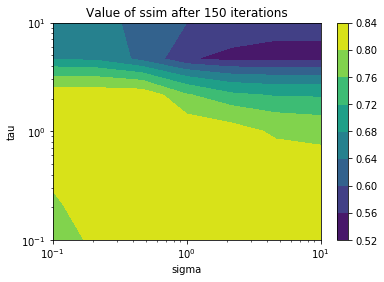

In [18]:
X,Y = np.meshgrid(s,t)
const_to_test = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

plt.contourf(X,Y,ssims.transpose())
plt.title("Value of ssim after 150 iterations")
plt.xlabel("sigma")
plt.ylabel("tau")
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
#plt.savefig("Comparisons/Condat/ssim_grid.png")
plt.show()

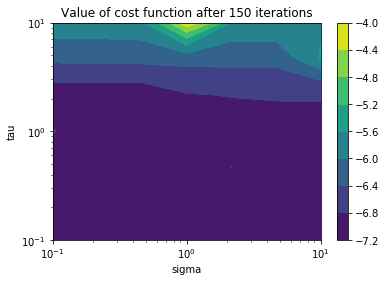

In [19]:
X,Y = np.meshgrid(s,t)
const_to_test = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

plt.contourf(X,Y,np.log10(values.transpose()))
plt.title("Value of cost function after 150 iterations")
plt.xlabel("sigma")
plt.ylabel("tau")
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
#plt.savefig("Comparisons/Condat/cost_grid.png")
plt.show()